## 라이브러리 불러오기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import KFold

## Data Preprocessing (데이터 전처리)

### 데이터 불러오기 및 정보 확인

In [3]:
df = pd.read_csv("data/Global YouTube Statistics.csv", encoding='unicode_escape')

display(df.columns)
display(df)

Index(['rank', 'Youtuber', 'subscribers', 'video views', 'category', 'Title',
       'uploads', 'Country', 'Abbreviation', 'channel_type',
       'video_views_rank', 'country_rank', 'channel_type_rank',
       'video_views_for_the_last_30_days', 'lowest_monthly_earnings',
       'highest_monthly_earnings', 'lowest_yearly_earnings',
       'highest_yearly_earnings', 'subscribers_for_last_30_days',
       'created_year', 'created_month', 'created_date',
       'Gross tertiary education enrollment (%)', 'Population',
       'Unemployment rate', 'Urban_population', 'Latitude', 'Longitude'],
      dtype='object')

rank                    Youtuber  subscribers   video views  \
0       1                    T-Series    245000000  2.280000e+11   
1       2              YouTube Movies    170000000  0.000000e+00   
2       3                     MrBeast    166000000  2.836884e+10   
3       4  Cocomelon - Nursery Rhymes    162000000  1.640000e+11   
4       5                   SET India    159000000  1.480000e+11   
..    ...                         ...          ...           ...   
990   991               Natan por Aï¿     12300000  9.029610e+09   
991   992    Free Fire India Official     12300000  1.674410e+09   
992   993                       Panda     12300000  2.214684e+09   
993   994                 RobTopGames     12300000  3.741235e+08   
994   995                Make Joke Of     12300000  2.129774e+09   

             category                       Title  uploads         Country  \
0               Music                    T-Series    20082           India   
1    Film & Animation               youtubemovies        1   United States   
2       Entertainment                     MrBeast      741   United States   
3           Education  Cocomelon - Nursery Rhymes      966   United States   
4               Shows                   SET India   116536           India   
..                ...                         ...      ...             ...   
990            Sports               Natan por Aï¿     1200          Brazil   
991    People & Blogs    Free Fire India Official     1500           India   
992               NaN                 HybridPanda     2452  United Kingdom   
993            Gaming                 RobTopGames       39          Sweden   
994            Comedy                Make Joke Of       62           India   

    Abbreviation   channel_type  ...  subscribers_for_last_30_days  \
0             IN          Music  ...                     2000000.0   
1             US          Games  ...                           NaN   
2             US  Entertainment  ...                     8000000.0   
3             US      Education  ...                     1000000.0   
4             IN  Entertainment  ...                     1000000.0   
..           ...            ...  ...                           ...   
990           BR  Entertainment  ...                      700000.0   
991           IN          Games  ...                      300000.0   
992           GB          Games  ...                        1000.0   
993           SE          Games  ...                      100000.0   
994           IN         Comedy  ...                      100000.0   

     created_year  created_month  created_date  \
0          2006.0            Mar          13.0   
1          2006.0            Mar           5.0   
2          2012.0            Feb          20.0   
3          2006.0            Sep           1.0   
4          2006.0            Sep          20.0   
..            ...            ...           ...   
990        2017.0            Feb          12.0   
991        2018.0            Sep          14.0   
992        2006.0            Sep          11.0   
993        2012.0            May           9.0   
994        2017.0            Aug           1.0   

     Gross tertiary education enrollment (%)    Population  Unemployment rate  \
0                                       28.1  1.366418e+09               5.36   
1                                       88.2  3.282395e+08              14.70   
2                                       88.2  3.282395e+08              14.70   
3                                       88.2  3.282395e+08              14.70   
4                                       28.1  1.366418e+09               5.36   
..                                       ...           ...                ...   
990                                     51.3  2.125594e+08              12.08   
991                                     28.1  1.366418e+09               5.36   
992                                     60.0  6.683440e+07               3.85   

In [4]:
def check_df(dataframe):
    print("SHAPE".center(70, "-"))
    print(dataframe.shape)
    print("TYPE".center(70, "-"))
    print(dataframe.dtypes)
    print("INFO".center(70, "-"))
    print(dataframe.info())
    print("NA".center(70, "-"))
    print(dataframe.isnull().sum())
    print("DESCRIBE".center(70, "-"))
    print(dataframe.describe().T)
    print("NUNIQUE".center(70, "-"))
    print(dataframe.nunique())

check_df(df)

--------------------------------SHAPE---------------------------------
(995, 28)
---------------------------------TYPE---------------------------------
rank                                         int64
Youtuber                                    object
subscribers                                  int64
video views                                float64
category                                    object
Title                                       object
uploads                                      int64
Country                                     object
Abbreviation                                object
channel_type                                object
video_views_rank                           float64
country_rank                               float64
channel_type_rank                          float64
video_views_for_the_last_30_days           float64
lowest_monthly_earnings                    float64
highest_monthly_earnings                   float64
lowest_yearly_earnings          

### 사용하지 않을 feature 삭제
- subscribers_for_last_30_days : 결측치 337개로 너무 많음
- Gross tertiary education enrollment, Population, Unemployment rate, Urban_population, Latitude, Longitude, country_rank, video_views_for_the_last_30_days : 타겟(연수입)과 상관관계 없다고 판단
- lowest_monthly_earnings, highest_monthly_earnings : 타겟값과 상관관계가 매우 높음 (다중 공산성)
- Abbreviation : Country와 동일함.
- Youtuber, Title : Id 열
    - 각 데이터의 Id로 사용하기 위해 Youtuber 열은 데이터 전처리 마지막 과정에서 삭제 

In [5]:
df.drop(columns=['subscribers_for_last_30_days', 
                 'Gross tertiary education enrollment (%)', 
                 'Unemployment rate',
                 'Urban_population',
                 'Population', 
                 'Latitude',
                 'Longitude',
                 'lowest_monthly_earnings',
                 'highest_monthly_earnings',
                 'Title',
                 'Abbreviation',
                 'country_rank',
                 'video_views_for_the_last_30_days',
                ], inplace=True )

### 결측치 처리

In [6]:
missing_df = df.isnull().sum()
missing_df = missing_df[missing_df>0]
missing_df

category              46
Country              122
channel_type          30
video_views_rank       1
channel_type_rank     33
created_year           5
created_month          5
created_date           5
dtype: int64

In [7]:
for missing_column in missing_df.index:
    print(f"{missing_column}".center(70, "-"))
    display(df[df[missing_column].isna()])

-------------------------------category-------------------------------


rank                                   Youtuber  subscribers  \
5       6                                      Music    119000000   
12     13                                     Gaming     93600000   
18     19                                     Sports     75000000   
91     92                              Vlad vï¿½ï¿½ï     37900000   
102   103                                       News     36300000   
132   133                              BETER Bï¿½ï¿½     32700000   
155   156                         Diana and Roma ESP     30700000   
161   162  ýýýýýýýýýýýýýýý ýýýýýý ýýýýýýýýýýýýýýýýýý     30400000   
173   174                         Popular on YouTube     29300000   
214   215                                 D Billions     26200000   
255   256                            shfa show India     24200000   
256   257   Super JoJo - Nursery Rhymes & Kids Songs     24100000   
261   262                         Diana and Roma ARA     24100000   
312   313                       Vlad and Niki Arabic     22500000   
319   320                          Vlad and Niki ESP     22000000   
332   333                 ZAMZAM ELECTRONICS TRADING     21700000   
355   356                          Vlad and Niki IDN     21000000   
360   361                          Minecraft - Topic     20900000   
424   425                             Manoj  parihar     19300000   
445   446                               Busy Fun Ltd     18800000   
452   453                       Smile Family Spanish     18600000   
495   496                           ýýýýýýýýý KIMPRO     17700000   
496   497                           Jane ASMR ï¿½ï¿½     17700000   
553   554                                Ivana Alawi     16600000   
592   593                                       Live     16100000   
593   594                          Vlad and Niki ARA     16100000   
598   599                               Panda Shorts     16100000   
619   620                                  MY FAMILY     15700000   
712   713                                 Filaretiki     14800000   
738   739                                Lotus Music     14500000   
742   743                Eli Kids - Cartoons & Songs     14500000   
763   764                          Vlad and Niki PRT     14400000   
810   811                   ýýýýýýýý ýý ýýýýýýýýýýýý     13900000   
832   833                              Zeinab Harake     13600000   
849   850                           Vlad y Niki Show     13400000   
852   853                                   Vibhu 96     13400000   
879   880                                     Vilmei     13200000   
888   889                                 WiederDude     13100000   
907   908                             Wolfoo Channel     13000000   
930   931                             FACT FIRE KING     12700000   
934   935                         Diana and Roma IND     12700000   
941   942                             Heidi y Zidane     12700000   
950   951                              Wolfoo Family     12500000   
957   958     Bebefinn - Nursery Rhymes & Kids Songs     12500000   
971   972                               DEV Ke Facts     12400000   
992   993                                      Panda     12300000   

      video views category  uploads               Country   channel_type  \
5    0.000000e+00      NaN        0                   NaN          Music   
12   0.000000e+00      NaN        0                   NaN          Games   
18   0.000000e+00      NaN        3         United States  Entertainment   
91   2.351015e+10      NaN      515         United States  Entertainment   
102  0.000000e+00      NaN        0                   NaN            NaN   
132  1.918004e+10      NaN     2738                Turkey          Games   
155  1.235599e+10      NaN      578         United States  Entertainment   
161  1.799996e+10      NaN      532         United States  Entertainment   
173  0.000000e+00      NaN        3                   NaN      Education   
2

-------------------------------Country--------------------------------


rank                                           Youtuber  subscribers  \
5       6                                              Music    119000000   
12     13                                             Gaming     93600000   
14     15                                          Goldmines     86900000   
38     39  LooLoo Kids - Nursery Rhymes and Children's Songs     54000000   
48     49                                            Badabun     46800000   
..    ...                                                ...          ...   
958   959                                     Troom Troom PT     12500000   
967   968                              Troom Troom Indonesia     12500000   
972   973                                   Hero Movies 2023     12400000   
985   986                                               TKOR     12400000   
986   987                                          ANNA KOVA     12400000   

      video views          category  uploads Country channel_type  \
5    0.000000e+00               NaN        0     NaN        Music   
12   0.000000e+00               NaN        0     NaN        Games   
14   2.411823e+10  Film & Animation        1     NaN        Music   
38   3.231243e+10             Music       11     NaN          NaN   
48   1.939805e+10     Entertainment        1     NaN        Music   
..            ...               ...      ...     ...          ...   
958  4.384178e+09     Howto & Style     2738     NaN        Howto   
967  5.379684e+09    People & Blogs        8     NaN       People   
972  1.689091e+09    People & Blogs      689     NaN       People   
985  3.392023e+09         Education        0     NaN       People   
986  1.395959e+10    People & Blogs        1     NaN         Film   

     video_views_rank  channel_type_rank  lowest_yearly_earnings  \
5           4057944.0                NaN                    0.00   
12          4057944.0                1.0                    0.00   
14          4056562.0             5663.0                    0.05   
38          3800129.0                NaN                    0.48   
48          4047729.0             5525.0                    1.00   
..                ...                ...                     ...   
958            1667.0               37.0                40500.00   
967         4057418.0             7712.0                    0.00   
972            6116.0               63.0                65500.00   
985         4057944.0             7741.0                    0.00   
986         4049634.0             5307.0                    0.01   

     highest_yearly_earnings  created_year created_month  created_date  
5                       0.00        2013.0           Sep          24.0  
12                      0.00        2013.0           Dec          15.0  
14                      0.86        2006.0           Aug          15.0  
38                      8.00        2016.0           Nov          29.0  
48                     21.00        2007.0           Jul          21.0  
..                       ...           ...           ...           ...  
958                648100.00        2015.0           Apr          19.0  
967                     0.05        2020.0           Jul          29.0  
972               1000000.00        2017.0           Feb          22.0  
985                     0.00        2006.0           Aug          16.0  
986                     0.10        2006.0           Jun          18.0  

[122 rows x 15 columns]

-----------------------------channel_type-----------------------------


rank                                           Youtuber  subscribers  \
38     39  LooLoo Kids - Nursery Rhymes and Children's Songs     54000000   
57     58                                        BRIGHT SIDE     44500000   
102   103                                               News     36300000   
149   150                                         Luis Fonsi     31400000   
166   167                                      Frost Diamond     30100000   
178   179                                       Shorts Break     29000000   
183   184                                     Masha y el Oso     28300000   
190   191                                 Sandeep Maheshwari     27800000   
226   227                                      Fede Vigevani     25600000   
236   237                                        Chris Brown     25200000   
340   341                                               YOLO     21400000   
440   441                                     Masha e o Urso     18900000   
444   445                                            Cardi B     18800000   
445   446                                       Busy Fun Ltd     18800000   
463   464                                          Dhar Mann     18400000   
468   469                              Good Mythical Morning     18300000   
476   477                                        Ajay Sharma     18100000   
508   509                                 The Game Theorists     17600000   
544   545                               Doggy Doggy Cartoons     16800000   
548   549                                       Salman Noman     16700000   
555   556                                 IDEAS EN 5 MINUTOS     16600000   
592   593                                               Live     16100000   
629   630                                        Super Senya     15500000   
710   711                               Major Lazer Official     14800000   
778   779                                           The Dodo     14200000   
784   785          ýýýýýýýýýýýýýýýýýýýý ýýýýýýýýýýýýýýýýýýýý     14100000   
853   854                                 Blockbuster Movies     13400000   
904   905                                    Jomy Production     13000000   
951   952                                            Ja Mill     12500000   
969   970                                    Quantum Tech HD     12500000   

      video views              category  uploads    Country channel_type  \
38   3.231243e+10                 Music       11        NaN          NaN   
57   1.070853e+10         Howto & Style        0        NaN          NaN   
102  0.000000e+00                   NaN        0        NaN          NaN   
149  1.517676e+10         Entertainment        0        NaN          NaN   
166  7.277494e+09                Gaming        0        NaN          NaN   
178  1.946624e+10                Comedy       42        NaN          NaN   
183  1.357714e+10      Film & Animation        6        NaN          NaN   
190  2.303069e+09        People & Blogs        0  Singapore          NaN   
226  7.962726e+09         Howto & Style        0        NaN          NaN   
236  1.552057e+10                 Music        0        NaN          NaN   
340  1.573059e+09                Comedy        0    Germany          NaN   
440  8.301731e+09                 Shows        0        NaN          NaN   
444  7.634430e+09        People & Blogs        9        NaN          NaN   
445  7.762077e+09                   NaN        2        NaN          NaN   
463  1.128073e+10        People & Blogs        0        NaN          NaN   
468  8.798045e+09         Entertainment        0        NaN          NaN   
476  1.224983e+10         Entertainment        0        NaN          NaN   
508  3.752347e+09                Gaming        0  Australia          NaN   
544  6.518419e+09         Entertainment        0        NaN          NaN   
548  1.039304e+10         Entertainment        3        NaN          NaN   
555  3.696973e+09    

---------------------------video_views_rank---------------------------


rank      Youtuber  subscribers   video views category  uploads Country  \
735   736  LEGENDA FUNK     14500000  2.440718e+09    Music        0  Brazil   

    channel_type  video_views_rank  channel_type_rank  lowest_yearly_earnings  \
735        Music               NaN                NaN                     0.0   

     highest_yearly_earnings  created_year created_month  created_date  
735                      0.0           NaN           NaN           NaN

--------------------------channel_type_rank---------------------------


rank                                           Youtuber  subscribers  \
5       6                                              Music    119000000   
38     39  LooLoo Kids - Nursery Rhymes and Children's Songs     54000000   
57     58                                        BRIGHT SIDE     44500000   
73     74                                   Luisito Comunica     40600000   
102   103                                               News     36300000   
149   150                                         Luis Fonsi     31400000   
166   167                                      Frost Diamond     30100000   
178   179                                       Shorts Break     29000000   
183   184                                     Masha y el Oso     28300000   
190   191                                 Sandeep Maheshwari     27800000   
226   227                                      Fede Vigevani     25600000   
236   237                                        Chris Brown     25200000   
340   341                                               YOLO     21400000   
440   441                                     Masha e o Urso     18900000   
444   445                                            Cardi B     18800000   
445   446                                       Busy Fun Ltd     18800000   
463   464                                          Dhar Mann     18400000   
468   469                              Good Mythical Morning     18300000   
476   477                                        Ajay Sharma     18100000   
508   509                                 The Game Theorists     17600000   
544   545                               Doggy Doggy Cartoons     16800000   
548   549                                       Salman Noman     16700000   
555   556                                 IDEAS EN 5 MINUTOS     16600000   
592   593                                               Live     16100000   
629   630                                        Super Senya     15500000   
710   711                               Major Lazer Official     14800000   
735   736                                       LEGENDA FUNK     14500000   
778   779                                           The Dodo     14200000   
784   785          ýýýýýýýýýýýýýýýýýýýý ýýýýýýýýýýýýýýýýýýýý     14100000   
853   854                                 Blockbuster Movies     13400000   
904   905                                    Jomy Production     13000000   
951   952                                            Ja Mill     12500000   
969   970                                    Quantum Tech HD     12500000   

      video views              category  uploads    Country channel_type  \
5    0.000000e+00                   NaN        0        NaN        Music   
38   3.231243e+10                 Music       11        NaN          NaN   
57   1.070853e+10         Howto & Style        0        NaN          NaN   
73   8.670474e+09                Comedy        0     Mexico       Comedy   
102  0.000000e+00                   NaN        0        NaN          NaN   
149  1.517676e+10         Entertainment        0        NaN          NaN   
166  7.277494e+09                Gaming        0        NaN          NaN   
178  1.946624e+10                Comedy       42        NaN          NaN   
183  1.357714e+10      Film & Animation        6        NaN          NaN   
190  2.303069e+09        People & Blogs        0  Singapore          NaN   
226  7.962726e+09         Howto & Style        0        NaN          NaN   
236  1.552057e+10                 Music        0        NaN          NaN   
340  1.573059e+09                Comedy        0    Germany          NaN   
440  8.301731e+09                 Shows        0        NaN          NaN   
444  7.634430e+09        People & Blogs        9        NaN          NaN   
445  7.762077e+09                   NaN        2        NaN          NaN   
463  1.128073e+10        People & Blogs        0        NaN          NaN   
468  8.798045e+09 

-----------------------------created_year-----------------------------


rank               Youtuber  subscribers   video views        category  \
236   237            Chris Brown     25200000  1.552057e+10           Music   
468   469  Good Mythical Morning     18300000  8.798045e+09   Entertainment   
508   509     The Game Theorists     17600000  3.752347e+09          Gaming   
735   736           LEGENDA FUNK     14500000  2.440718e+09           Music   
762   763           Harry Styles     14400000  5.689224e+09  People & Blogs   

     uploads        Country channel_type  video_views_rank  channel_type_rank  \
236        0            NaN          NaN         3612215.0                NaN   
468        0            NaN          NaN         3612215.0                NaN   
508        0      Australia          NaN         3612215.0                NaN   
735        0         Brazil        Music               NaN                NaN   
762        0  United States        Games         4037956.0             7340.0   

     lowest_yearly_earnings  highest_yearly_earnings  created_year  \
236                     0.0                      0.0           NaN   
468                     0.0                      0.0           NaN   
508                     0.0                      0.0           NaN   
735                     0.0                      0.0           NaN   
762                     0.0                      0.0           NaN   

    created_month  created_date  
236           NaN           NaN  
468           NaN           NaN  
508           NaN           NaN  
735           NaN           NaN  
762           NaN           NaN

----------------------------created_month-----------------------------


rank               Youtuber  subscribers   video views        category  \
236   237            Chris Brown     25200000  1.552057e+10           Music   
468   469  Good Mythical Morning     18300000  8.798045e+09   Entertainment   
508   509     The Game Theorists     17600000  3.752347e+09          Gaming   
735   736           LEGENDA FUNK     14500000  2.440718e+09           Music   
762   763           Harry Styles     14400000  5.689224e+09  People & Blogs   

     uploads        Country channel_type  video_views_rank  channel_type_rank  \
236        0            NaN          NaN         3612215.0                NaN   
468        0            NaN          NaN         3612215.0                NaN   
508        0      Australia          NaN         3612215.0                NaN   
735        0         Brazil        Music               NaN                NaN   
762        0  United States        Games         4037956.0             7340.0   

     lowest_yearly_earnings  highest_yearly_earnings  created_year  \
236                     0.0                      0.0           NaN   
468                     0.0                      0.0           NaN   
508                     0.0                      0.0           NaN   
735                     0.0                      0.0           NaN   
762                     0.0                      0.0           NaN   

    created_month  created_date  
236           NaN           NaN  
468           NaN           NaN  
508           NaN           NaN  
735           NaN           NaN  
762           NaN           NaN

-----------------------------created_date-----------------------------


rank               Youtuber  subscribers   video views        category  \
236   237            Chris Brown     25200000  1.552057e+10           Music   
468   469  Good Mythical Morning     18300000  8.798045e+09   Entertainment   
508   509     The Game Theorists     17600000  3.752347e+09          Gaming   
735   736           LEGENDA FUNK     14500000  2.440718e+09           Music   
762   763           Harry Styles     14400000  5.689224e+09  People & Blogs   

     uploads        Country channel_type  video_views_rank  channel_type_rank  \
236        0            NaN          NaN         3612215.0                NaN   
468        0            NaN          NaN         3612215.0                NaN   
508        0      Australia          NaN         3612215.0                NaN   
735        0         Brazil        Music               NaN                NaN   
762        0  United States        Games         4037956.0             7340.0   

     lowest_yearly_earnings  highest_yearly_earnings  created_year  \
236                     0.0                      0.0           NaN   
468                     0.0                      0.0           NaN   
508                     0.0                      0.0           NaN   
735                     0.0                      0.0           NaN   
762                     0.0                      0.0           NaN   

    created_month  created_date  
236           NaN           NaN  
468           NaN           NaN  
508           NaN           NaN  
735           NaN           NaN  
762           NaN           NaN

#### 결측치 삭제
상위 1000명의 구독자 중에 Youtube Movies, Music 같이 채널이 아닌 데이터 존재한다. 또한, 유일하게 video_views_rank 가 NaN 인 데이터가 존재한다.이를 삭제한다.

In [8]:
# Youtuber 아닌 채널 삭제
no_youtuber = df[(df['lowest_yearly_earnings']<10) & (df['video views']==0)] 
display(no_youtuber)
df.drop(no_youtuber.index, inplace=True)
# 유일한 video_views_rank 가 NaN인 채널 삭제
missing_video_views_rank = df[df['video_views_rank'].isna()]
display(missing_video_views_rank)
df.drop(missing_video_views_rank.index, inplace=True)

rank            Youtuber  subscribers  video views          category  \
1       2      YouTube Movies    170000000          0.0  Film & Animation   
5       6               Music    119000000          0.0               NaN   
12     13              Gaming     93600000          0.0               NaN   
18     19              Sports     75000000          0.0               NaN   
102   103                News     36300000          0.0               NaN   
173   174  Popular on YouTube     29300000          0.0               NaN   
360   361   Minecraft - Topic     20900000          0.0               NaN   
592   593                Live     16100000          0.0               NaN   

     uploads        Country   channel_type  video_views_rank  \
1          1  United States          Games         4055159.0   
5          0            NaN          Music         4057944.0   
12         0            NaN          Games         4057944.0   
18         3  United States  Entertainment         3898122.0   
102        0            NaN            NaN         4057944.0   
173        3            NaN      Education         4019724.0   
360        0            NaN          Games         4057944.0   
592        0            NaN            NaN         4057944.0   

     channel_type_rank  lowest_yearly_earnings  highest_yearly_earnings  \
1               7423.0                    0.04                     0.58   
5                  NaN                    0.00                     0.00   
12                 1.0                    0.00                     0.00   
18              5395.0                    0.05                     0.77   
102                NaN                    0.00                     0.00   
173             4847.0                    0.00                     0.05   
360               24.0                    0.00                     0.00   
592                NaN                    0.00                     0.00   

     created_year created_month  created_date  
1          2006.0           Mar           5.0  
5          2013.0           Sep          24.0  
12         2013.0           Dec          15.0  
18         2006.0           Jan          30.0  
102        2013.0           Sep           9.0  
173        2017.0           Aug           7.0  
360        2013.0           Dec          20.0  
592        2015.0           Jan          13.0

rank      Youtuber  subscribers   video views category  uploads Country  \
735   736  LEGENDA FUNK     14500000  2.440718e+09    Music        0  Brazil   

    channel_type  video_views_rank  channel_type_rank  lowest_yearly_earnings  \
735        Music               NaN                NaN                     0.0   

     highest_yearly_earnings  created_year created_month  created_date  
735                      0.0           NaN           NaN           NaN

#### 결측치 대체
- 명목형(카테고리) column : category, country, channel_type -> "Unknown" 으로 대체
- 이산형 column : created_year, created_month, created_date -> 결측치 개수 적음, 최빈값으로 대체
- 연속형 column : channel_type_rank의 결측치를 video_views_rank의 값으로 대체, 

In [9]:
missing_df.index

Index(['category', 'Country', 'channel_type', 'video_views_rank',
       'channel_type_rank', 'created_year', 'created_month', 'created_date'],
      dtype='object')

In [10]:
# 카테고리형 결측치: "Unknown" 으로 대체
df[['category', 'Country', 'channel_type']] = df[['category', 'Country', 'channel_type']].fillna('Unknown')
# created_year, created_month, created_date 열의 결측치를 최빈값(mode)으로 대체
for column in ['created_year', 'created_month', 'created_date']:
    mode_value = df[column].mode()[0]
    df[column].fillna(mode_value, inplace=True)
# channel_type_rank 열의 결측치를 video_views_rank 열의 값으로 대체
df['channel_type_rank'].fillna(df['video_views_rank'], inplace=True)

In [11]:
display(df.isna().sum())

rank                       0
Youtuber                   0
subscribers                0
video views                0
category                   0
uploads                    0
Country                    0
channel_type               0
video_views_rank           0
channel_type_rank          0
lowest_yearly_earnings     0
highest_yearly_earnings    0
created_year               0
created_month              0
created_date               0
dtype: int64

### 타겟값 (yearly_earnings) 생성
- 연수입 = (lowest_yearly_earnings + highest_yearly_earnings)/2
- 타겟값 열 생성 후 lowest_yearly_earnings, highest_yearly_earnings 열 삭제

In [12]:
df['yearly_earnings'] = (df['lowest_yearly_earnings'] + df['highest_yearly_earnings'])/2
df.drop(columns=['lowest_yearly_earnings', 'highest_yearly_earnings'], inplace=True)

In [13]:
print(f"최종 feature: {list(df.columns)}")
print(f"최종 데이터 수 {df.shape}")
display(df)

최종 feature: ['rank', 'Youtuber', 'subscribers', 'video views', 'category', 'uploads', 'Country', 'channel_type', 'video_views_rank', 'channel_type_rank', 'created_year', 'created_month', 'created_date', 'yearly_earnings']
최종 데이터 수 (986, 14)


rank                    Youtuber  subscribers   video views  \
0       1                    T-Series    245000000  2.280000e+11   
2       3                     MrBeast    166000000  2.836884e+10   
3       4  Cocomelon - Nursery Rhymes    162000000  1.640000e+11   
4       5                   SET India    159000000  1.480000e+11   
6       7         ýýý Kids Diana Show    112000000  9.324704e+10   
..    ...                         ...          ...           ...   
990   991               Natan por Aï¿     12300000  9.029610e+09   
991   992    Free Fire India Official     12300000  1.674410e+09   
992   993                       Panda     12300000  2.214684e+09   
993   994                 RobTopGames     12300000  3.741235e+08   
994   995                Make Joke Of     12300000  2.129774e+09   

           category  uploads         Country   channel_type  video_views_rank  \
0             Music    20082           India          Music               1.0   
2     Entertainment      741   United States  Entertainment              48.0   
3         Education      966   United States      Education               2.0   
4             Shows   116536           India  Entertainment               3.0   
6    People & Blogs     1111   United States  Entertainment               5.0   
..              ...      ...             ...            ...               ...   
990          Sports     1200          Brazil  Entertainment             525.0   
991  People & Blogs     1500           India          Games            6141.0   
992         Unknown     2452  United Kingdom          Games          129005.0   
993          Gaming       39          Sweden          Games           35112.0   
994          Comedy       62           India         Comedy            4568.0   

     channel_type_rank  created_year created_month  created_date  \
0                  1.0        2006.0           Mar          13.0   
2                  1.0        2012.0           Feb          20.0   
3                  1.0        2006.0           Sep           1.0   
4                  2.0        2006.0           Sep          20.0   
6                  3.0        2015.0           May          12.0   
..                 ...           ...           ...           ...   
990              172.0        2017.0           Feb          12.0   
991               69.0        2018.0           Sep          14.0   
992             1202.0        2006.0           Sep          11.0   
993               69.0        2012.0           May           9.0   
994               44.0        2017.0           Aug           1.0   

     yearly_earnings  
0         57600000.0  
2         34350000.0  
3         50350000.0  
4         46500000.0  
6         18650000.0  
..               ...  
990       14100000.0  
991        1647100.0  
992           1700.5  
993          98700.0  
994         636000.0  

[986 rows x 14 columns]

## Xgboost 를 이용한 연수입(yearly_earnings) 예측 Baseline 모델 

### 카테고리형 변수 타겟 인코딩 (Target encoding)

In [14]:
y = df['yearly_earnings'].copy()
X = df.drop(columns=['yearly_earnings', 'Youtuber']).copy() # Youtuber 열 삭제
categorical_features = list(X.dtypes[X.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

for i in categorical_features:
    le = TargetEncoder(cols=[i])
    X[i] = le.fit_transform(X[i], y)

['category', 'Country', 'channel_type', 'created_month']

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/category_encoders/utils.py:28: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(cols):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

### train, test dataset 분리
- 데이터셋의 크기가 작기 때문에 9:1 비율로 분리

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### 훈련 및 검증

In [16]:
# XGBoostRegressor 모델 초기화 및 훈련
model = xgb.XGBRegressor()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["rmse"], eval_set=eval_set, verbose=True)

# 예측
y_pred = model.predict(X_test)

# 검증 결과
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

[0]	validation_0-rmse:5967991.83263	validation_1-rmse:7127797.14775
[1]	validation_0-rmse:4966834.04438	validation_1-rmse:7010789.34069
[2]	validation_0-rmse:4219676.05753	validation_1-rmse:6847300.36552
[3]	validation_0-rmse:3665043.67758	validation_1-rmse:6780885.53741
[4]	validation_0-rmse:3235588.92669	validation_1-rmse:6741839.60716
[5]	validation_0-rmse:2959514.84658	validation_1-rmse:6708058.78556
[6]	validation_0-rmse:2685414.87407	validation_1-rmse:6578164.83025
[7]	validation_0-rmse:2485048.64991	validation_1-rmse:6535478.20987
[8]	validation_0-rmse:2331471.58306	validation_1-rmse:6491222.08673
[9]	validation_0-rmse:2182559.26034	validation_1-rmse:6520746.51169
[10]	validation_0-rmse:2077230.91076	validation_1-rmse:6555036.68982
[11]	validation_0-rmse:1966927.12017	validation_1-rmse:6591283.08602
[12]	validation_0-rmse:1819001.97672	validation_1-rmse:6622245.94840
[13]	validation_0-rmse:1736677.59383	validation_1-rmse:6593410.25243
[14]	validation_0-rmse:1613459.88250	validat

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[65]	validation_0-rmse:297051.21896	validation_1-rmse:6733376.65165
[66]	validation_0-rmse:293507.04953	validation_1-rmse:6731545.80550
[67]	validation_0-rmse:288956.73795	validation_1-rmse:6730649.59645
[68]	validation_0-rmse:280978.87034	validation_1-rmse:6733584.60639
[69]	validation_0-rmse:277649.18410	validation_1-rmse:6732070.27656
[70]	validation_0-rmse:270098.71930	validation_1-rmse:6732924.86347
[71]	validation_0-rmse:262894.30755	validation_1-rmse:6735967.16088
[72]	validation_0-rmse:258936.22108	validation_1-rmse:6736167.43117
[73]	validation_0-rmse:250761.53568	validation_1-rmse:6736185.20892
[74]	validation_0-rmse:241507.29625	validation_1-rmse:6736174.15353
[75]	validation_0-rmse:237099.15174	validation_1-rmse:6737338.76728
[76]	validation_0-rmse:232401.43017	validation_1-rmse:6735988.83570
[77]	validation_0-rmse:224085.53218	validation_1-rmse:6742738.90033
[78]	validation_0-rmse:214109.36389	validation_1-rmse:6741901.17379
[79]	validation_0-rmse:205187.38785	validation_1

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


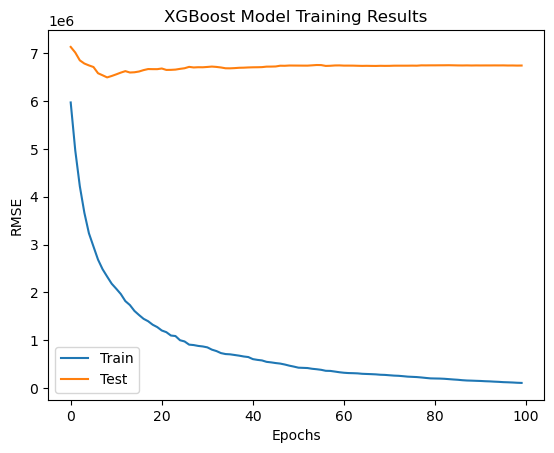

In [17]:
# 훈련 결과(history) 시각화
results = model.evals_result()
train_error = results['validation_0']['rmse']
test_error = results['validation_1']['rmse']

epochs = len(train_error)
x_axis = range(0, epochs)

# 훈련 및 검증 세트에 대한 오차 시각화
plt.plot(x_axis, train_error, label='Train')
plt.plot(x_axis, test_error, label='Test')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('XGBoost Model Training Results')
plt.legend()
plt.show()

- 과적합(overfitting) 발생

## 하이퍼 파라미터 최적화, K-Fold 교차검증을 이용한 Baseline 모델 최적화
- K-Fold 교차검증
- 사용한 하이퍼 파라미터 최적화 라이브러리 : optuna
- 최적화할 xgboost 하이퍼 파라미터: max_depth, n_esimators, learning_rate
- 최적화할 K-Fold 하이퍼 파라미터 : n_splits
- 조기 중단(early_stopping) 적용

### Optuna를 이용한 하이퍼 파라미터 최적화

In [21]:
def objective(trial):
    # 하이퍼파라미터 탐색 범위 설정
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300, step=20),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, step=0.005)
    }
    cv = KFold(n_splits=trial.suggest_int('n_splits', 5, 15, step=1), shuffle=True, random_state=42)
    # K-Fold Cross Validation 수행
    rmse_values = []
    for train_idx, valid_idx in cv.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        # XGBoost 모델 초기화
        model = xgb.XGBRegressor(
            **params,
            eval_metric=["rmse"],
            verbose=-1
        )

        # 모델 훈련
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=30,
        )

        # 검증 세트에서의 예측
        y_pred = model.predict(X_valid)

        # RMSE 계산 및 저장
        rmse = mean_squared_error(y_valid, y_pred, squared=False)
        rmse_values.append(rmse)

    # 평균 RMSE를 반환
    return np.mean(rmse_values)

# Optuna 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100) # 100회 탐색

[I 2023-12-09 15:02:55,446] A new study created in memory with name: no-name-71b9cd2f-e1fd-413b-9dc2-43983d54d28d


[0]	validation_0-rmse:6245707.16115
[1]	validation_0-rmse:6144429.28194
[2]	validation_0-rmse:6063339.07578
[3]	validation_0-rmse:5998430.17616
[4]	validation_0-rmse:5892820.95893
[5]	validation_0-rmse:5798285.66262
[6]	validation_0-rmse:5710646.60659
[7]	validation_0-rmse:5684974.57647
[8]	validation_0-rmse:5623334.58926
[9]	validation_0-rmse:5621279.92388
[10]	validation_0-rmse:5604917.20072
[11]	validation_0-rmse:5604765.48260
[12]	validation_0-rmse:5577107.53763
[13]	validation_0-rmse:5561221.56312
[14]	validation_0-rmse:5534509.54072
[15]	validation_0-rmse:5512138.64928
[16]	validation_0-rmse:5493178.29182
[17]	validation_0-rmse:5474915.29439
[18]	validation_0-rmse:5474626.73814
[19]	validation_0-rmse:5475636.70650
[20]	validation_0-rmse:5477331.28234
[21]	validation_0-rmse:5448853.53933
[22]	validation_0-rmse:5438463.09990
[23]	validation_0-rmse:5423696.67829
[24]	validation_0-rmse:5424220.07964
[25]	validation_0-rmse:5435160.89968
[26]	validation_0-rmse:5419081.28660
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:02:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[11]	validation_0-rmse:6815420.84085
[12]	validation_0-rmse:6737642.50631
[13]	validation_0-rmse:6669811.59372
[14]	validation_0-rmse:6619985.70928
[15]	validation_0-rmse:6581306.16977
[16]	validation_0-rmse:6566153.57562
[17]	validation_0-rmse:6571500.18778
[18]	validation_0-rmse:6570987.30512
[19]	validation_0-rmse:6537669.25138
[20]	validation_0-rmse:6528153.80577
[21]	validation_0-rmse:6530776.84681
[22]	validation_0-rmse:6549131.83015
[23]	validation_0-rmse:6526893.60316
[24]	validation_0-rmse:6528769.81285
[25]	validation_0-rmse:6489340.74317
[26]	validation_0-rmse:6496274.28844
[27]	validation_0-rmse:6444389.80042
[28]	validation_0-rmse:6431672.27115
[29]	validation_0-rmse:6416009.89469
[30]	validation_0-rmse:6400590.37369
[31]	validation_0-rmse:6388094.09837
[32]	validation_0-rmse:6364284.45189
[33]	validation_0-rmse:6355247.60496
[34]	validation_0-rmse:6376955.79927
[35]	validation_0-rmse:6367078.62128
[36]	validation_0-rmse:6373034.19011
[37]	validation_0-rmse:6373903.88116
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:02:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[92]	validation_0-rmse:4222714.66061
[0]	validation_0-rmse:7171581.01105
[1]	validation_0-rmse:6906559.80885
[2]	validation_0-rmse:6686333.07386
[3]	validation_0-rmse:6435756.86729
[4]	validation_0-rmse:6281110.99854
[5]	validation_0-rmse:6120429.01357
[6]	validation_0-rmse:5998484.65429
[7]	validation_0-rmse:5860552.28852
[8]	validation_0-rmse:5756851.92426
[9]	validation_0-rmse:5634119.35107
[10]	validation_0-rmse:5567509.31853
[11]	validation_0-rmse:5455841.30305
[12]	validation_0-rmse:5382722.59952
[13]	validation_0-rmse:5237602.27426
[14]	validation_0-rmse:5201803.74073
[15]	validation_0-rmse:5057695.63838
[16]	validation_0-rmse:4934803.00658
[17]	validation_0-rmse:4826848.20750
[18]	validation_0-rmse:4755708.93009
[19]	validation_0-rmse:4683833.72735
[20]	validation_0-rmse:4607332.22023
[21]	validation_0-rmse:4573834.39558
[22]	validation_0-rmse:4536902.08866
[23]	validation_0-rmse:4510970.91100
[24]	validation_0-rmse:4461164.86004
[25]	validation_0-rmse:4416808.24704
[26]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:02:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[99]	validation_0-rmse:4124509.63225
[100]	validation_0-rmse:4125869.45895
[101]	validation_0-rmse:4128410.79706
[102]	validation_0-rmse:4130675.10961
[103]	validation_0-rmse:4132220.47252
[104]	validation_0-rmse:4136320.71393
[0]	validation_0-rmse:8886014.08814
[1]	validation_0-rmse:8777202.89237
[2]	validation_0-rmse:8701599.26776
[3]	validation_0-rmse:8609139.09546
[4]	validation_0-rmse:8566938.96715
[5]	validation_0-rmse:8497266.13904
[6]	validation_0-rmse:8456492.25655
[7]	validation_0-rmse:8414587.87018
[8]	validation_0-rmse:8351554.81252
[9]	validation_0-rmse:8253792.32486
[10]	validation_0-rmse:8207157.28347
[11]	validation_0-rmse:8106943.79247
[12]	validation_0-rmse:8091782.75591
[13]	validation_0-rmse:8081422.72027
[14]	validation_0-rmse:8073271.90884
[15]	validation_0-rmse:8070107.96737
[16]	validation_0-rmse:8016451.05334
[17]	validation_0-rmse:8015800.15618
[18]	validation_0-rmse:8010974.89343
[19]	validation_0-rmse:8014212.52847
[20]	validation_0-rmse:7957990.55518
[21]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:02:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[31]	validation_0-rmse:5246742.27947
[32]	validation_0-rmse:5238438.81938
[33]	validation_0-rmse:5228411.38714
[34]	validation_0-rmse:5229046.03220
[35]	validation_0-rmse:5243929.05229
[36]	validation_0-rmse:5245361.63290
[37]	validation_0-rmse:5247910.57679
[38]	validation_0-rmse:5254840.36464
[39]	validation_0-rmse:5263121.56938
[40]	validation_0-rmse:5271233.91639
[41]	validation_0-rmse:5267839.05724
[42]	validation_0-rmse:5301431.51180
[43]	validation_0-rmse:5307623.12384
[44]	validation_0-rmse:5342050.76791
[45]	validation_0-rmse:5349281.92015
[46]	validation_0-rmse:5376756.48276
[47]	validation_0-rmse:5385226.96500
[48]	validation_0-rmse:5386820.83273
[49]	validation_0-rmse:5404537.04998
[50]	validation_0-rmse:5413273.53503
[51]	validation_0-rmse:5431361.95323
[52]	validation_0-rmse:5438547.60448
[53]	validation_0-rmse:5449709.19780


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:02:56,527] Trial 0 finished with value: 5476700.4532438405 and parameters: {'max_depth': 5, 'n_estimators': 140, 'learning_rate': 0.07500000000000001, 'n_splits': 6}. Best is trial 0 with value: 5476700.4532438405.


[0]	validation_0-rmse:7160284.33952
[1]	validation_0-rmse:7081145.65991
[2]	validation_0-rmse:6997409.15480
[3]	validation_0-rmse:6946604.07321
[4]	validation_0-rmse:6864495.80680
[5]	validation_0-rmse:6767988.30109
[6]	validation_0-rmse:6710393.55163
[7]	validation_0-rmse:6649727.99542
[8]	validation_0-rmse:6590050.02773
[9]	validation_0-rmse:6554271.33739
[10]	validation_0-rmse:6513614.18165
[11]	validation_0-rmse:6477151.89896
[12]	validation_0-rmse:6480581.21047
[13]	validation_0-rmse:6461117.65607
[14]	validation_0-rmse:6473369.44752
[15]	validation_0-rmse:6456554.38603
[16]	validation_0-rmse:6446687.35435
[17]	validation_0-rmse:6426553.58071
[18]	validation_0-rmse:6418842.37146
[19]	validation_0-rmse:6416909.70008
[20]	validation_0-rmse:6421920.89975
[21]	validation_0-rmse:6412776.05052
[22]	validation_0-rmse:6430375.35668
[23]	validation_0-rmse:6470431.83256
[24]	validation_0-rmse:6483191.72401
[25]	validation_0-rmse:6483269.92728
[26]	validation_0-rmse:6497492.86434
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:02:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[31]	validation_0-rmse:2630243.75013
[32]	validation_0-rmse:2649951.07115
[33]	validation_0-rmse:2641382.65805
[34]	validation_0-rmse:2657572.04865
[35]	validation_0-rmse:2645706.39320
[36]	validation_0-rmse:2649278.56526
[37]	validation_0-rmse:2660160.24199
[38]	validation_0-rmse:2667917.54849
[39]	validation_0-rmse:2679188.55706
[40]	validation_0-rmse:2663456.35435
[41]	validation_0-rmse:2674190.48466
[42]	validation_0-rmse:2689839.32713
[43]	validation_0-rmse:2694468.68318
[44]	validation_0-rmse:2685626.16028
[45]	validation_0-rmse:2701954.81831
[46]	validation_0-rmse:2719314.38769
[47]	validation_0-rmse:2716015.95325
[48]	validation_0-rmse:2715860.08513
[49]	validation_0-rmse:2705442.32910
[50]	validation_0-rmse:2710379.88309
[51]	validation_0-rmse:2716684.08748
[52]	validation_0-rmse:2743977.84985
[53]	validation_0-rmse:2755310.18130
[54]	validation_0-rmse:2773478.46226
[55]	validation_0-rmse:2777419.05648
[0]	validation_0-rmse:9179161.83817
[1]	validation_0-rmse:8957900.38027
[2]

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:02:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[30]	validation_0-rmse:5085780.08640
[31]	validation_0-rmse:5071616.87753
[32]	validation_0-rmse:5063530.17540
[33]	validation_0-rmse:5050864.83462
[34]	validation_0-rmse:5039330.05268
[35]	validation_0-rmse:5035231.40291
[36]	validation_0-rmse:5017229.49340
[37]	validation_0-rmse:5009561.95743
[38]	validation_0-rmse:5000817.34676
[39]	validation_0-rmse:4997971.75068
[40]	validation_0-rmse:4996369.98862
[41]	validation_0-rmse:4992406.54199
[42]	validation_0-rmse:4991805.18728
[43]	validation_0-rmse:4999273.54629
[44]	validation_0-rmse:4995954.73133
[45]	validation_0-rmse:4989343.65195
[46]	validation_0-rmse:4982678.11286
[47]	validation_0-rmse:4981549.10309
[48]	validation_0-rmse:4979028.32718
[49]	validation_0-rmse:4980318.25857
[50]	validation_0-rmse:4974606.73476
[51]	validation_0-rmse:4975687.83145
[52]	validation_0-rmse:4977706.99526
[53]	validation_0-rmse:4978382.00646
[54]	validation_0-rmse:4983159.46409
[55]	validation_0-rmse:4984452.70251
[56]	validation_0-rmse:4990151.63182
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:02:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[29]	validation_0-rmse:4445101.83754
[30]	validation_0-rmse:4443917.13480
[31]	validation_0-rmse:4435938.04399
[32]	validation_0-rmse:4442658.69739
[33]	validation_0-rmse:4430871.49564
[34]	validation_0-rmse:4394111.74876
[35]	validation_0-rmse:4383726.92617
[36]	validation_0-rmse:4359552.14669
[37]	validation_0-rmse:4342926.54146
[38]	validation_0-rmse:4330410.83654
[39]	validation_0-rmse:4317589.43461
[40]	validation_0-rmse:4300303.83787
[41]	validation_0-rmse:4298853.32000
[42]	validation_0-rmse:4309035.84842
[43]	validation_0-rmse:4293823.20487
[44]	validation_0-rmse:4273710.73075
[45]	validation_0-rmse:4253518.32871
[46]	validation_0-rmse:4236140.68463
[47]	validation_0-rmse:4225962.56471
[48]	validation_0-rmse:4218508.89147
[49]	validation_0-rmse:4205142.09726
[50]	validation_0-rmse:4208714.30695
[51]	validation_0-rmse:4209035.78738
[52]	validation_0-rmse:4209791.98469
[53]	validation_0-rmse:4221674.28215
[54]	validation_0-rmse:4221164.10594
[55]	validation_0-rmse:4219342.12911
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:02:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[77]	validation_0-rmse:9262323.78068
[78]	validation_0-rmse:9265850.80512
[79]	validation_0-rmse:9266093.54496
[80]	validation_0-rmse:9264663.77770
[81]	validation_0-rmse:9266011.39581
[82]	validation_0-rmse:9266297.49643
[83]	validation_0-rmse:9268867.38591
[84]	validation_0-rmse:9269569.93857
[85]	validation_0-rmse:9271493.79898
[86]	validation_0-rmse:9276857.26207
[87]	validation_0-rmse:9276736.53360
[88]	validation_0-rmse:9273135.86682
[89]	validation_0-rmse:9280577.51217
[90]	validation_0-rmse:9279988.23205
[91]	validation_0-rmse:9277955.80128
[92]	validation_0-rmse:9283470.96877
[93]	validation_0-rmse:9284353.09767
[94]	validation_0-rmse:9286353.04799
[95]	validation_0-rmse:9287338.75870
[96]	validation_0-rmse:9286911.68691
[97]	validation_0-rmse:9292458.83241
[0]	validation_0-rmse:6452344.72796
[1]	validation_0-rmse:6319387.71888
[2]	validation_0-rmse:6144213.69316
[3]	validation_0-rmse:5974388.88185
[4]	validation_0-rmse:5835644.65758
[5]	validation_0-rmse:5731074.16909
[6]	val

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:02:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[6]	validation_0-rmse:4962493.67132
[7]	validation_0-rmse:4857659.17685
[8]	validation_0-rmse:4778630.15562
[9]	validation_0-rmse:4715301.88389
[10]	validation_0-rmse:4616483.68972
[11]	validation_0-rmse:4529619.48379
[12]	validation_0-rmse:4506667.98118
[13]	validation_0-rmse:4432835.96798
[14]	validation_0-rmse:4403071.95282
[15]	validation_0-rmse:4371268.28853
[16]	validation_0-rmse:4344354.25067
[17]	validation_0-rmse:4336937.92856
[18]	validation_0-rmse:4306416.64867
[19]	validation_0-rmse:4280506.15562
[20]	validation_0-rmse:4263960.81936
[21]	validation_0-rmse:4256466.16293
[22]	validation_0-rmse:4263036.11944
[23]	validation_0-rmse:4268127.86702
[24]	validation_0-rmse:4284904.57803
[25]	validation_0-rmse:4283852.11262
[26]	validation_0-rmse:4280978.69549
[27]	validation_0-rmse:4297298.10047
[28]	validation_0-rmse:4312259.52419
[29]	validation_0-rmse:4289375.17503
[30]	validation_0-rmse:4298580.59920
[31]	validation_0-rmse:4313769.01296
[32]	validation_0-rmse:4317278.21580
[33]	

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:02:58,097] Trial 1 finished with value: 5194867.000655139 and parameters: {'max_depth': 6, 'n_estimators': 260, 'learning_rate': 0.09000000000000001, 'n_splits': 9}. Best is trial 1 with value: 5194867.000655139.


[0]	validation_0-rmse:7231860.87671
[1]	validation_0-rmse:7107767.20470
[2]	validation_0-rmse:7016383.44909
[3]	validation_0-rmse:6930030.76026
[4]	validation_0-rmse:6841072.75918
[5]	validation_0-rmse:6717821.89615
[6]	validation_0-rmse:6619973.85098
[7]	validation_0-rmse:6562617.52169
[8]	validation_0-rmse:6476764.43462
[9]	validation_0-rmse:6455764.86209
[10]	validation_0-rmse:6437560.88429
[11]	validation_0-rmse:6362389.93792
[12]	validation_0-rmse:6305015.25908
[13]	validation_0-rmse:6299516.95870
[14]	validation_0-rmse:6236183.20615
[15]	validation_0-rmse:6236264.78883
[16]	validation_0-rmse:6185971.62485
[17]	validation_0-rmse:6192984.00452
[18]	validation_0-rmse:6193677.21660
[19]	validation_0-rmse:6179217.34908
[20]	validation_0-rmse:6196805.74095
[21]	validation_0-rmse:6187889.94252
[22]	validation_0-rmse:6194844.23901
[23]	validation_0-rmse:6196897.29159
[24]	validation_0-rmse:6184632.18405
[25]	validation_0-rmse:6076086.70990
[26]	validation_0-rmse:6083561.87756
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:02:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[4]	validation_0-rmse:5361634.91115
[5]	validation_0-rmse:5314419.68687
[6]	validation_0-rmse:5159829.16210
[7]	validation_0-rmse:5114321.24006
[8]	validation_0-rmse:5093679.39274
[9]	validation_0-rmse:5078638.57446
[10]	validation_0-rmse:4995289.28298
[11]	validation_0-rmse:4996293.98097
[12]	validation_0-rmse:5004811.10848
[13]	validation_0-rmse:4980285.00669
[14]	validation_0-rmse:4980044.74969
[15]	validation_0-rmse:4973542.38784
[16]	validation_0-rmse:4971560.52027
[17]	validation_0-rmse:4984804.20030
[18]	validation_0-rmse:4979167.83014
[19]	validation_0-rmse:4970926.26147
[20]	validation_0-rmse:4976823.01815
[21]	validation_0-rmse:4970764.32053
[22]	validation_0-rmse:4963966.11500
[23]	validation_0-rmse:4968667.29101
[24]	validation_0-rmse:4974239.00772
[25]	validation_0-rmse:4975997.64083
[26]	validation_0-rmse:4980032.17032
[27]	validation_0-rmse:4976055.54301
[28]	validation_0-rmse:4972800.85296
[29]	validation_0-rmse:4988717.46162
[30]	validation_0-rmse:4994215.36661
[31]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:02:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[13]	validation_0-rmse:5990040.97616
[14]	validation_0-rmse:5872602.98729
[15]	validation_0-rmse:5751221.55648
[16]	validation_0-rmse:5738560.51122
[17]	validation_0-rmse:5674552.44862
[18]	validation_0-rmse:5589473.59237
[19]	validation_0-rmse:5570811.44347
[20]	validation_0-rmse:5551742.66805
[21]	validation_0-rmse:5467853.55801
[22]	validation_0-rmse:5389670.93690
[23]	validation_0-rmse:5347897.92994
[24]	validation_0-rmse:5286188.32947
[25]	validation_0-rmse:5255663.17676
[26]	validation_0-rmse:5204675.23814
[27]	validation_0-rmse:5143805.65850
[28]	validation_0-rmse:5150864.12414
[29]	validation_0-rmse:5143722.10748
[30]	validation_0-rmse:5096028.32661
[31]	validation_0-rmse:5102720.91220
[32]	validation_0-rmse:5092689.25079
[33]	validation_0-rmse:5043659.20561
[34]	validation_0-rmse:5003394.69082
[35]	validation_0-rmse:4980097.09011
[36]	validation_0-rmse:4982453.76015
[37]	validation_0-rmse:4948393.57029
[38]	validation_0-rmse:4973867.24479
[39]	validation_0-rmse:4994526.56080
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:02:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[6]	validation_0-rmse:5871532.54851
[7]	validation_0-rmse:5765470.00545
[8]	validation_0-rmse:5695195.53159
[9]	validation_0-rmse:5617888.46207
[10]	validation_0-rmse:5515039.46830
[11]	validation_0-rmse:5366149.55101
[12]	validation_0-rmse:5236102.68440
[13]	validation_0-rmse:5078074.89383
[14]	validation_0-rmse:5024193.16389
[15]	validation_0-rmse:4919367.27902
[16]	validation_0-rmse:4848624.54671
[17]	validation_0-rmse:4762282.67023
[18]	validation_0-rmse:4658634.04119
[19]	validation_0-rmse:4582299.62293
[20]	validation_0-rmse:4549621.78073
[21]	validation_0-rmse:4489123.94629
[22]	validation_0-rmse:4405532.65407
[23]	validation_0-rmse:4404293.97055
[24]	validation_0-rmse:4359525.50119
[25]	validation_0-rmse:4343303.00811
[26]	validation_0-rmse:4295627.28832
[27]	validation_0-rmse:4252219.19594
[28]	validation_0-rmse:4232322.50043
[29]	validation_0-rmse:4198594.10913
[30]	validation_0-rmse:4193542.46882
[31]	validation_0-rmse:4185036.14560
[32]	validation_0-rmse:4120092.70622
[33]	

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:02:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[40]	validation_0-rmse:4720817.03580
[41]	validation_0-rmse:4673415.26391
[42]	validation_0-rmse:4678329.23526
[43]	validation_0-rmse:4661087.04114
[44]	validation_0-rmse:4659205.85852
[45]	validation_0-rmse:4618635.74989
[46]	validation_0-rmse:4635786.03246
[47]	validation_0-rmse:4615375.12263
[48]	validation_0-rmse:4639615.89746
[49]	validation_0-rmse:4604901.19025
[50]	validation_0-rmse:4574054.35293
[51]	validation_0-rmse:4593243.19019
[52]	validation_0-rmse:4570032.12939
[53]	validation_0-rmse:4572256.85265
[54]	validation_0-rmse:4575850.56718
[55]	validation_0-rmse:4568038.94832
[56]	validation_0-rmse:4564538.09497
[57]	validation_0-rmse:4554549.32115
[58]	validation_0-rmse:4537401.38257
[59]	validation_0-rmse:4543411.16861
[60]	validation_0-rmse:4520729.96877
[61]	validation_0-rmse:4544449.79222
[62]	validation_0-rmse:4548089.68486
[63]	validation_0-rmse:4546287.18051
[64]	validation_0-rmse:4504371.68070
[65]	validation_0-rmse:4505899.38901
[66]	validation_0-rmse:4518143.21748
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:02:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[112]	validation_0-rmse:4534001.15759
[113]	validation_0-rmse:4536309.75871
[114]	validation_0-rmse:4538342.63519
[115]	validation_0-rmse:4547746.33335
[116]	validation_0-rmse:4561204.99407
[117]	validation_0-rmse:4560536.45257
[118]	validation_0-rmse:4553735.25258
[119]	validation_0-rmse:4552173.29984
[120]	validation_0-rmse:4552785.02319
[121]	validation_0-rmse:4551502.77239
[122]	validation_0-rmse:4549992.93074
[123]	validation_0-rmse:4549859.99145
[124]	validation_0-rmse:4547438.65948
[125]	validation_0-rmse:4550451.35320
[126]	validation_0-rmse:4558083.94043
[127]	validation_0-rmse:4562826.00715
[128]	validation_0-rmse:4557944.82976
[129]	validation_0-rmse:4564533.90793
[130]	validation_0-rmse:4563026.35581
[131]	validation_0-rmse:4576701.62308
[132]	validation_0-rmse:4578016.78029
[133]	validation_0-rmse:4578339.32649
[134]	validation_0-rmse:4578138.73923
[135]	validation_0-rmse:4580104.83073
[136]	validation_0-rmse:4577882.24406
[137]	validation_0-rmse:4578838.49318
[138]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:02:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7463385.86274
[1]	validation_0-rmse:7406986.32229
[2]	validation_0-rmse:7361637.57913
[3]	validation_0-rmse:7318258.50242
[4]	validation_0-rmse:7299522.18847
[5]	validation_0-rmse:7291208.03708
[6]	validation_0-rmse:7285725.97484
[7]	validation_0-rmse:7271919.40265
[8]	validation_0-rmse:7278919.19229
[9]	validation_0-rmse:7280565.78988
[10]	validation_0-rmse:7285337.41240
[11]	validation_0-rmse:7269699.91554
[12]	validation_0-rmse:7265909.15448
[13]	validation_0-rmse:7269660.45578
[14]	validation_0-rmse:7280513.47123
[15]	validation_0-rmse:7269803.43731
[16]	validation_0-rmse:7274894.24059
[17]	validation_0-rmse:7285342.55306
[18]	validation_0-rmse:7290931.67466
[19]	validation_0-rmse:7293906.59579
[20]	validation_0-rmse:7298842.87377
[21]	validation_0-rmse:7310141.80598
[22]	validation_0-rmse:7316726.95273
[23]	validation_0-rmse:7324815.59415
[24]	validation_0-rmse:7328311.50805
[25]	validation_0-rmse:7336039.21134
[26]	validation_0-rmse:7340501.50165
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:02:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[14]	validation_0-rmse:5506943.57887
[15]	validation_0-rmse:5483310.99988
[16]	validation_0-rmse:5471426.96625
[17]	validation_0-rmse:5483313.88679
[18]	validation_0-rmse:5499243.83143
[19]	validation_0-rmse:5469562.88372
[20]	validation_0-rmse:5495597.85954
[21]	validation_0-rmse:5522099.80902
[22]	validation_0-rmse:5515024.41280
[23]	validation_0-rmse:5560028.89156
[24]	validation_0-rmse:5604650.07219
[25]	validation_0-rmse:5585011.42843
[26]	validation_0-rmse:5606581.66241
[27]	validation_0-rmse:5608526.08528
[28]	validation_0-rmse:5660015.34359
[29]	validation_0-rmse:5663818.24252
[30]	validation_0-rmse:5691052.95890
[31]	validation_0-rmse:5668761.27989
[32]	validation_0-rmse:5663344.05948
[33]	validation_0-rmse:5722781.22637
[34]	validation_0-rmse:5720960.89226
[35]	validation_0-rmse:5706943.54100
[36]	validation_0-rmse:5678774.32578
[37]	validation_0-rmse:5688162.04805
[38]	validation_0-rmse:5676092.81452
[39]	validation_0-rmse:5653799.57841
[40]	validation_0-rmse:5732196.20033
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[108]	validation_0-rmse:6006554.00145
[109]	validation_0-rmse:6006345.10687
[110]	validation_0-rmse:6006881.73781
[111]	validation_0-rmse:6002470.11246
[112]	validation_0-rmse:6020307.63086
[113]	validation_0-rmse:6011328.34015
[114]	validation_0-rmse:6035569.16571
[115]	validation_0-rmse:6038901.14932
[116]	validation_0-rmse:6037862.54467
[117]	validation_0-rmse:6043402.58866
[118]	validation_0-rmse:6043502.54324
[119]	validation_0-rmse:6043868.61522
[120]	validation_0-rmse:6044894.31794
[121]	validation_0-rmse:6047731.49504
[122]	validation_0-rmse:6048327.21089
[123]	validation_0-rmse:6071959.20424
[124]	validation_0-rmse:6071469.80241
[125]	validation_0-rmse:6074889.30863
[126]	validation_0-rmse:6072862.47455
[127]	validation_0-rmse:6072744.57326
[128]	validation_0-rmse:6079362.38770
[129]	validation_0-rmse:6074400.59148
[130]	validation_0-rmse:6074836.32385
[131]	validation_0-rmse:6079516.69550
[132]	validation_0-rmse:6074547.39547
[133]	validation_0-rmse:6065249.32244
[134]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6366196.27091
[1]	validation_0-rmse:6355425.17877
[2]	validation_0-rmse:6344739.26450
[3]	validation_0-rmse:6334138.29655
[4]	validation_0-rmse:6323550.49088
[5]	validation_0-rmse:6313116.63406
[6]	validation_0-rmse:6302695.19532
[7]	validation_0-rmse:6292426.29500
[8]	validation_0-rmse:6281650.45832
[9]	validation_0-rmse:6271543.38843
[10]	validation_0-rmse:6260930.04758
[11]	validation_0-rmse:6250982.59139
[12]	validation_0-rmse:6240529.89537
[13]	validation_0-rmse:6230518.14364
[14]	validation_0-rmse:6220475.68041
[15]	validation_0-rmse:6210641.57634
[16]	validation_0-rmse:6200823.53729
[17]	validation_0-rmse:6191164.89177
[18]	validation_0-rmse:6181543.67436
[19]	validation_0-rmse:6172032.87502
[20]	validation_0-rmse:6162597.81181
[21]	validation_0-rmse:6152968.05262
[22]	validation_0-rmse:6143702.30402
[23]	validation_0-rmse:6134418.63214
[24]	validation_0-rmse:6127281.66790
[25]	validation_0-rmse:6117866.71244
[26]	validation_0-rmse:6110814.27527
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[55]	validation_0-rmse:5900745.60163
[56]	validation_0-rmse:5893936.82119
[57]	validation_0-rmse:5887586.79438
[58]	validation_0-rmse:5880080.09880
[59]	validation_0-rmse:5873534.99230
[60]	validation_0-rmse:5867165.04207
[61]	validation_0-rmse:5860619.00941
[62]	validation_0-rmse:5853444.62356
[63]	validation_0-rmse:5847293.15219
[64]	validation_0-rmse:5840633.85378
[65]	validation_0-rmse:5834298.96776
[66]	validation_0-rmse:5827966.87198
[67]	validation_0-rmse:5821542.67262
[68]	validation_0-rmse:5816214.05675
[69]	validation_0-rmse:5810097.65453
[70]	validation_0-rmse:5803317.00070
[71]	validation_0-rmse:5797305.25383
[72]	validation_0-rmse:5791641.10114
[73]	validation_0-rmse:5785807.78093
[74]	validation_0-rmse:5779256.29869
[75]	validation_0-rmse:5773403.77527
[76]	validation_0-rmse:5767581.88644
[77]	validation_0-rmse:5761831.20364
[78]	validation_0-rmse:5755885.80168
[79]	validation_0-rmse:5750855.12047
[80]	validation_0-rmse:5744582.96152
[81]	validation_0-rmse:5739019.89094
[

[13]	validation_0-rmse:8238240.80286
[14]	validation_0-rmse:8227888.30096
[15]	validation_0-rmse:8217556.88741
[16]	validation_0-rmse:8207399.02855
[17]	validation_0-rmse:8197498.44589
[18]	validation_0-rmse:8187458.14678
[19]	validation_0-rmse:8177700.53862
[20]	validation_0-rmse:8167460.36342
[21]	validation_0-rmse:8157512.84550
[22]	validation_0-rmse:8147698.48054
[23]	validation_0-rmse:8137750.80676
[24]	validation_0-rmse:8128085.33466
[25]	validation_0-rmse:8118770.09242
[26]	validation_0-rmse:8109333.79225
[27]	validation_0-rmse:8099755.24218
[28]	validation_0-rmse:8090470.79699
[29]	validation_0-rmse:8081079.30432
[30]	validation_0-rmse:8072361.91310
[31]	validation_0-rmse:8063349.05701
[32]	validation_0-rmse:8054427.10873
[33]	validation_0-rmse:8045403.27648
[34]	validation_0-rmse:8036660.78766
[35]	validation_0-rmse:8028023.67477
[36]	validation_0-rmse:8019788.68207
[37]	validation_0-rmse:8011306.38796
[38]	validation_0-rmse:8002932.22375
[39]	validation_0-rmse:7994622.14207
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[97]	validation_0-rmse:7621507.77310
[98]	validation_0-rmse:7614418.09436
[99]	validation_0-rmse:7608206.60836
[100]	validation_0-rmse:7604282.80701
[101]	validation_0-rmse:7597563.40005
[102]	validation_0-rmse:7593735.67865
[103]	validation_0-rmse:7587576.43785
[104]	validation_0-rmse:7583276.91718
[105]	validation_0-rmse:7577243.47440
[106]	validation_0-rmse:7571894.00912
[107]	validation_0-rmse:7565341.60210
[108]	validation_0-rmse:7558239.22569
[109]	validation_0-rmse:7553544.36882
[110]	validation_0-rmse:7547217.47457
[111]	validation_0-rmse:7543230.64339
[112]	validation_0-rmse:7537546.25251
[113]	validation_0-rmse:7531347.93365
[114]	validation_0-rmse:7526958.22417
[115]	validation_0-rmse:7521238.70511
[116]	validation_0-rmse:7515296.56031
[117]	validation_0-rmse:7511541.03786
[118]	validation_0-rmse:7507158.18704
[119]	validation_0-rmse:7501210.45129
[120]	validation_0-rmse:7492998.72676
[121]	validation_0-rmse:7487247.49157
[122]	validation_0-rmse:7483573.56294
[123]	validatio

[55]	validation_0-rmse:5273836.71443
[56]	validation_0-rmse:5263467.70618
[57]	validation_0-rmse:5256028.56585
[58]	validation_0-rmse:5245827.01147
[59]	validation_0-rmse:5235650.15274
[60]	validation_0-rmse:5228430.91514
[61]	validation_0-rmse:5218416.89720
[62]	validation_0-rmse:5211233.61438
[63]	validation_0-rmse:5201486.29103
[64]	validation_0-rmse:5191702.98284
[65]	validation_0-rmse:5184756.48679
[66]	validation_0-rmse:5176321.36924
[67]	validation_0-rmse:5166812.53661
[68]	validation_0-rmse:5159974.90617
[69]	validation_0-rmse:5150560.35218
[70]	validation_0-rmse:5141040.35242
[71]	validation_0-rmse:5134410.94479
[72]	validation_0-rmse:5128962.31899
[73]	validation_0-rmse:5119701.37440
[74]	validation_0-rmse:5113150.19378
[75]	validation_0-rmse:5103231.87478
[76]	validation_0-rmse:5094325.57180
[77]	validation_0-rmse:5087945.13164
[78]	validation_0-rmse:5080346.18178
[79]	validation_0-rmse:5071440.72448
[80]	validation_0-rmse:5065263.65941
[81]	validation_0-rmse:5056528.84089
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[97]	validation_0-rmse:4960393.45793
[98]	validation_0-rmse:4954760.85742
[99]	validation_0-rmse:4949139.36890
[100]	validation_0-rmse:4944034.69330
[101]	validation_0-rmse:4936629.05947
[102]	validation_0-rmse:4932142.88995
[103]	validation_0-rmse:4927314.44535
[104]	validation_0-rmse:4921903.11107
[105]	validation_0-rmse:4917033.46612
[106]	validation_0-rmse:4909884.68237
[107]	validation_0-rmse:4904555.61673
[108]	validation_0-rmse:4899975.54461
[109]	validation_0-rmse:4894518.15434
[110]	validation_0-rmse:4886741.72287
[111]	validation_0-rmse:4881694.73015
[112]	validation_0-rmse:4877939.60516
[113]	validation_0-rmse:4873458.62422
[114]	validation_0-rmse:4866025.79285
[115]	validation_0-rmse:4862119.23521
[116]	validation_0-rmse:4857975.57386
[117]	validation_0-rmse:4853027.23783
[118]	validation_0-rmse:4848758.63393
[119]	validation_0-rmse:4843924.36203
[120]	validation_0-rmse:4836978.13914
[121]	validation_0-rmse:4834487.87887
[122]	validation_0-rmse:4829962.67084
[123]	validatio

[55]	validation_0-rmse:6625149.40568
[56]	validation_0-rmse:6613250.50658
[57]	validation_0-rmse:6601681.74039
[58]	validation_0-rmse:6589978.82726
[59]	validation_0-rmse:6577252.85098
[60]	validation_0-rmse:6565967.67338
[61]	validation_0-rmse:6554473.15346
[62]	validation_0-rmse:6543502.26785
[63]	validation_0-rmse:6530352.97852
[64]	validation_0-rmse:6519071.21412
[65]	validation_0-rmse:6507939.29106
[66]	validation_0-rmse:6497038.66621
[67]	validation_0-rmse:6486176.19690
[68]	validation_0-rmse:6472928.47461
[69]	validation_0-rmse:6462232.12528
[70]	validation_0-rmse:6451542.66765
[71]	validation_0-rmse:6440746.08280
[72]	validation_0-rmse:6427997.07227
[73]	validation_0-rmse:6416604.01411
[74]	validation_0-rmse:6406000.52445
[75]	validation_0-rmse:6394850.75090
[76]	validation_0-rmse:6384621.36065
[77]	validation_0-rmse:6372053.16799
[78]	validation_0-rmse:6361812.90310
[79]	validation_0-rmse:6350735.69362
[80]	validation_0-rmse:6340882.72050
[81]	validation_0-rmse:6328604.27748
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[92]	validation_0-rmse:6216469.92062
[93]	validation_0-rmse:6206535.95635
[94]	validation_0-rmse:6196249.67998
[95]	validation_0-rmse:6187116.46540
[96]	validation_0-rmse:6178094.85399
[97]	validation_0-rmse:6168336.39564
[98]	validation_0-rmse:6158232.08385
[99]	validation_0-rmse:6149249.70836
[100]	validation_0-rmse:6139737.76434
[101]	validation_0-rmse:6129775.02351
[102]	validation_0-rmse:6120183.46336
[103]	validation_0-rmse:6111443.63844
[104]	validation_0-rmse:6102129.55861
[105]	validation_0-rmse:6092915.28920
[106]	validation_0-rmse:6083732.29205
[107]	validation_0-rmse:6075276.59843
[108]	validation_0-rmse:6067061.96438
[109]	validation_0-rmse:6057390.24560
[110]	validation_0-rmse:6049159.18841
[111]	validation_0-rmse:6040191.10633
[112]	validation_0-rmse:6030755.94833
[113]	validation_0-rmse:6021681.12818
[114]	validation_0-rmse:6013140.08209
[115]	validation_0-rmse:6005189.23971
[116]	validation_0-rmse:5996051.32121
[117]	validation_0-rmse:5987735.31069
[118]	validation_0-r

[50]	validation_0-rmse:8667695.81716
[51]	validation_0-rmse:8660844.85236
[52]	validation_0-rmse:8654561.27552
[53]	validation_0-rmse:8650048.70421
[54]	validation_0-rmse:8645879.57199
[55]	validation_0-rmse:8639722.14987
[56]	validation_0-rmse:8635626.96301
[57]	validation_0-rmse:8629212.43985
[58]	validation_0-rmse:8623186.05294
[59]	validation_0-rmse:8619200.27158
[60]	validation_0-rmse:8613259.48978
[61]	validation_0-rmse:8607030.75653
[62]	validation_0-rmse:8603875.17637
[63]	validation_0-rmse:8599794.13282
[64]	validation_0-rmse:8595981.53888
[65]	validation_0-rmse:8590236.42772
[66]	validation_0-rmse:8584218.52653
[67]	validation_0-rmse:8581202.77147
[68]	validation_0-rmse:8577461.68005
[69]	validation_0-rmse:8571371.71883
[70]	validation_0-rmse:8565758.77088
[71]	validation_0-rmse:8559952.16318
[72]	validation_0-rmse:8557024.63924
[73]	validation_0-rmse:8553506.80707
[74]	validation_0-rmse:8548062.73916
[75]	validation_0-rmse:8544631.42423
[76]	validation_0-rmse:8539021.21523
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[95]	validation_0-rmse:8468691.36079
[96]	validation_0-rmse:8463829.78762
[97]	validation_0-rmse:8461599.19200
[98]	validation_0-rmse:8458392.77389
[99]	validation_0-rmse:8453414.01748
[100]	validation_0-rmse:8451282.76681
[101]	validation_0-rmse:8446394.63152
[102]	validation_0-rmse:8444326.73764
[103]	validation_0-rmse:8442343.12549
[104]	validation_0-rmse:8437516.69415
[105]	validation_0-rmse:8435598.22680
[106]	validation_0-rmse:8431075.25365
[107]	validation_0-rmse:8429187.17159
[108]	validation_0-rmse:8425796.30205
[109]	validation_0-rmse:8421113.27999
[110]	validation_0-rmse:8419314.72488
[111]	validation_0-rmse:8414950.84973
[112]	validation_0-rmse:8413260.67213
[113]	validation_0-rmse:8410256.62346
[114]	validation_0-rmse:8405764.75645
[115]	validation_0-rmse:8404128.72410
[116]	validation_0-rmse:8399766.71278
[117]	validation_0-rmse:8398170.42447
[118]	validation_0-rmse:8395297.95816
[119]	validation_0-rmse:8393815.37457
[120]	validation_0-rmse:8389707.80548
[121]	validation_

[53]	validation_0-rmse:6020237.53169
[54]	validation_0-rmse:6015558.02795
[55]	validation_0-rmse:6007921.43305
[56]	validation_0-rmse:6003397.92316
[57]	validation_0-rmse:5997494.19840
[58]	validation_0-rmse:5990796.06457
[59]	validation_0-rmse:5983438.59422
[60]	validation_0-rmse:5976148.34032
[61]	validation_0-rmse:5971997.10129
[62]	validation_0-rmse:5964832.54160
[63]	validation_0-rmse:5960832.65454
[64]	validation_0-rmse:5955285.20398
[65]	validation_0-rmse:5951251.66638
[66]	validation_0-rmse:5944949.95851
[67]	validation_0-rmse:5938732.40489
[68]	validation_0-rmse:5932861.33016
[69]	validation_0-rmse:5926807.67884
[70]	validation_0-rmse:5923103.81864
[71]	validation_0-rmse:5916466.13632
[72]	validation_0-rmse:5913113.29766
[73]	validation_0-rmse:5908012.50098
[74]	validation_0-rmse:5902283.72066
[75]	validation_0-rmse:5898865.06674
[76]	validation_0-rmse:5893272.52552
[77]	validation_0-rmse:5890260.04770
[78]	validation_0-rmse:5884811.71683
[79]	validation_0-rmse:5881950.89859
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[95]	validation_0-rmse:5810316.14697
[96]	validation_0-rmse:5808114.42462
[97]	validation_0-rmse:5802797.39379
[98]	validation_0-rmse:5797571.45382
[99]	validation_0-rmse:5795883.14168
[100]	validation_0-rmse:5790834.64505
[101]	validation_0-rmse:5788844.53643
[102]	validation_0-rmse:5783786.36207
[103]	validation_0-rmse:5781878.72868
[104]	validation_0-rmse:5776840.15577
[105]	validation_0-rmse:5771814.81865
[106]	validation_0-rmse:5769950.55072
[107]	validation_0-rmse:5765078.12788
[108]	validation_0-rmse:5763345.88240
[109]	validation_0-rmse:5758578.83524
[110]	validation_0-rmse:5753660.25929
[111]	validation_0-rmse:5750133.45875
[112]	validation_0-rmse:5745489.33126
[113]	validation_0-rmse:5743943.35783
[114]	validation_0-rmse:5739380.47062
[115]	validation_0-rmse:5734865.36047
[116]	validation_0-rmse:5733355.11342
[117]	validation_0-rmse:5728945.20533
[118]	validation_0-rmse:5725730.90961
[119]	validation_0-rmse:5721368.45376
[120]	validation_0-rmse:5720069.54943
[121]	validation_

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:03:03,760] Trial 3 finished with value: 5850236.453178336 and parameters: {'max_depth': 4, 'n_estimators': 260, 'learning_rate': 0.005, 'n_splits': 6}. Best is trial 2 with value: 5120116.4137579715.


[0]	validation_0-rmse:7421675.11275
[1]	validation_0-rmse:7368733.11954
[2]	validation_0-rmse:7321081.67431
[3]	validation_0-rmse:7290733.16283
[4]	validation_0-rmse:7260426.34148
[5]	validation_0-rmse:7216801.15142
[6]	validation_0-rmse:7201539.42456
[7]	validation_0-rmse:7188139.06318
[8]	validation_0-rmse:7150032.04322
[9]	validation_0-rmse:7143414.10712
[10]	validation_0-rmse:7107742.24186
[11]	validation_0-rmse:7081334.79644
[12]	validation_0-rmse:7064934.70483
[13]	validation_0-rmse:7044297.85675
[14]	validation_0-rmse:7014450.74297
[15]	validation_0-rmse:6996384.18144
[16]	validation_0-rmse:6992676.54936
[17]	validation_0-rmse:6954774.25907
[18]	validation_0-rmse:6937468.21782
[19]	validation_0-rmse:6916533.52505
[20]	validation_0-rmse:6901512.63080
[21]	validation_0-rmse:6887493.67382
[22]	validation_0-rmse:6876619.03330
[23]	validation_0-rmse:6873235.54064
[24]	validation_0-rmse:6875006.93034
[25]	validation_0-rmse:6874367.73382
[26]	validation_0-rmse:6863663.75897
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[0]	validation_0-rmse:5174031.89934
[1]	validation_0-rmse:5033900.90401
[2]	validation_0-rmse:4915800.32965
[3]	validation_0-rmse:4809315.10735
[4]	validation_0-rmse:4730954.20545
[5]	validation_0-rmse:4639825.80731
[6]	validation_0-rmse:4535934.19996
[7]	validation_0-rmse:4463638.80442
[8]	validation_0-rmse:4381400.92033
[9]	validation_0-rmse:4304804.13722
[10]	validation_0-rmse:4251596.44757
[11]	validation_0-rmse:4189614.18154
[12]	validation_0-rmse:4139792.07427
[13]	validation_0-rmse:4090330.47286
[14]	validation_0-rmse:4047521.30184
[15]	validation_0-rmse:3956062.77322
[16]	validation_0-rmse:3895970.63419
[17]	validation_0-rmse:3852031.74119
[18]	validation_0-rmse:3765382.36276
[19]	validation_0-rmse:3729032.07071
[20]	validation_0-rmse:3695489.52414
[21]	validation_0-rmse:3673356.06354
[22]	validation_0-rmse:3654650.01551
[23]	validation_0-rmse:3648274.02663
[24]	validation_0-rmse:3658984.66800
[25]	validation_0-rmse:3643329.87334
[26]	validation_0-rmse:3641965.00240
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[67]	validation_0-rmse:3600890.61471
[68]	validation_0-rmse:3600168.95514
[69]	validation_0-rmse:3598477.64531
[70]	validation_0-rmse:3609144.97009
[71]	validation_0-rmse:3612220.52069
[72]	validation_0-rmse:3617992.68807
[73]	validation_0-rmse:3626825.99206
[74]	validation_0-rmse:3636504.90968
[75]	validation_0-rmse:3649286.44874
[76]	validation_0-rmse:3657421.86725
[0]	validation_0-rmse:7167125.07765
[1]	validation_0-rmse:7044632.92069
[2]	validation_0-rmse:6944809.42586
[3]	validation_0-rmse:6844403.46282
[4]	validation_0-rmse:6761098.70627
[5]	validation_0-rmse:6673230.32235
[6]	validation_0-rmse:6593986.42610
[7]	validation_0-rmse:6519575.41816
[8]	validation_0-rmse:6429320.68406
[9]	validation_0-rmse:6350987.87868
[10]	validation_0-rmse:6283547.73812
[11]	validation_0-rmse:6223162.50885
[12]	validation_0-rmse:6178640.15140
[13]	validation_0-rmse:6129940.64297
[14]	validation_0-rmse:6088497.22002
[15]	validation_0-rmse:6044786.89409
[16]	validation_0-rmse:6015066.70953
[17]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:8191614.26733
[1]	validation_0-rmse:8079420.57160
[2]	validation_0-rmse:7975658.86442
[3]	validation_0-rmse:7883321.03286
[4]	validation_0-rmse:7793561.06747
[5]	validation_0-rmse:7718520.17679
[6]	validation_0-rmse:7642835.02718
[7]	validation_0-rmse:7571792.72347
[8]	validation_0-rmse:7517004.37358
[9]	validation_0-rmse:7461598.66009
[10]	validation_0-rmse:7395163.06636
[11]	validation_0-rmse:7365678.29901
[12]	validation_0-rmse:7368428.62621
[13]	validation_0-rmse:7342850.24230
[14]	validation_0-rmse:7323564.05117
[15]	validation_0-rmse:7323952.42562
[16]	validation_0-rmse:7302943.55620
[17]	validation_0-rmse:7289545.85279
[18]	validation_0-rmse:7292856.55779
[19]	validation_0-rmse:7257107.89763
[20]	validation_0-rmse:7218906.83762
[21]	validation_0-rmse:7213854.48525
[22]	validation_0-rmse:7186490.32544
[23]	validation_0-rmse:7183584.60025
[24]	validation_0-rmse:7151879.84871
[25]	validation_0-rmse:7150848.89856
[26]	validation_0-rmse:7123671.63151
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[68]	validation_0-rmse:6617839.37339
[69]	validation_0-rmse:6610824.87404
[70]	validation_0-rmse:6599405.58059
[71]	validation_0-rmse:6593337.01635
[72]	validation_0-rmse:6585745.21121
[73]	validation_0-rmse:6581038.14795
[74]	validation_0-rmse:6576102.24155
[75]	validation_0-rmse:6564852.62646
[76]	validation_0-rmse:6559904.34941
[77]	validation_0-rmse:6557400.04849
[78]	validation_0-rmse:6550372.99487
[79]	validation_0-rmse:6544353.46855
[80]	validation_0-rmse:6541142.05891
[81]	validation_0-rmse:6537083.36267
[82]	validation_0-rmse:6529274.11748
[83]	validation_0-rmse:6525795.21882
[84]	validation_0-rmse:6520918.53545
[85]	validation_0-rmse:6519580.77581
[86]	validation_0-rmse:6513514.17344
[87]	validation_0-rmse:6513324.25334
[88]	validation_0-rmse:6508562.97051
[89]	validation_0-rmse:6506192.01425
[90]	validation_0-rmse:6503010.98253
[91]	validation_0-rmse:6500316.91270
[92]	validation_0-rmse:6498977.95902
[93]	validation_0-rmse:6499139.35944
[94]	validation_0-rmse:6497641.13473
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[65]	validation_0-rmse:3486491.10599
[66]	validation_0-rmse:3482458.39627
[67]	validation_0-rmse:3478810.76427
[68]	validation_0-rmse:3476320.48559
[69]	validation_0-rmse:3472858.88661
[70]	validation_0-rmse:3473635.73320
[71]	validation_0-rmse:3469767.05231
[72]	validation_0-rmse:3466233.47956
[73]	validation_0-rmse:3462645.83578
[74]	validation_0-rmse:3462638.22976
[75]	validation_0-rmse:3457357.08334
[76]	validation_0-rmse:3456401.59079
[77]	validation_0-rmse:3455059.28510
[78]	validation_0-rmse:3449486.85295
[79]	validation_0-rmse:3450486.25229
[80]	validation_0-rmse:3449816.90683
[81]	validation_0-rmse:3453539.18941
[82]	validation_0-rmse:3454125.70232
[83]	validation_0-rmse:3450137.58756
[84]	validation_0-rmse:3448815.03583
[85]	validation_0-rmse:3453282.05230
[86]	validation_0-rmse:3449952.87227
[87]	validation_0-rmse:3449274.05989
[88]	validation_0-rmse:3442339.06994
[89]	validation_0-rmse:3440765.45847
[90]	validation_0-rmse:3440294.52752
[91]	validation_0-rmse:3436171.17654
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[67]	validation_0-rmse:5496328.24090
[68]	validation_0-rmse:5494487.99624
[69]	validation_0-rmse:5494402.94376
[70]	validation_0-rmse:5494665.64785
[71]	validation_0-rmse:5494997.02826
[72]	validation_0-rmse:5499930.25282
[73]	validation_0-rmse:5495780.72258
[74]	validation_0-rmse:5497031.77456
[75]	validation_0-rmse:5498268.37878
[76]	validation_0-rmse:5501507.74524
[77]	validation_0-rmse:5502378.05901
[0]	validation_0-rmse:5596003.61428
[1]	validation_0-rmse:5532789.40210
[2]	validation_0-rmse:5453798.68193
[3]	validation_0-rmse:5388029.95782
[4]	validation_0-rmse:5332625.07005
[5]	validation_0-rmse:5280109.91013
[6]	validation_0-rmse:5233934.98107
[7]	validation_0-rmse:5203221.91140
[8]	validation_0-rmse:5164893.93241
[9]	validation_0-rmse:5138655.54845
[10]	validation_0-rmse:5113195.61327
[11]	validation_0-rmse:5082687.91818
[12]	validation_0-rmse:5057891.64065
[13]	validation_0-rmse:5035677.00312
[14]	validation_0-rmse:5018564.47733
[15]	validation_0-rmse:5001158.67880
[16]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[70]	validation_0-rmse:4291896.73912
[71]	validation_0-rmse:4287481.99476
[72]	validation_0-rmse:4287993.95970
[73]	validation_0-rmse:4288303.15068
[74]	validation_0-rmse:4282914.44893
[75]	validation_0-rmse:4285420.22672
[76]	validation_0-rmse:4281399.11962
[77]	validation_0-rmse:4276824.35584
[78]	validation_0-rmse:4270092.34839
[79]	validation_0-rmse:4267725.07426
[80]	validation_0-rmse:4261715.55286
[81]	validation_0-rmse:4257310.76701
[82]	validation_0-rmse:4249111.03796
[83]	validation_0-rmse:4245843.88329
[84]	validation_0-rmse:4240474.40256
[85]	validation_0-rmse:4236656.60346
[86]	validation_0-rmse:4235509.71159
[87]	validation_0-rmse:4233063.23997
[88]	validation_0-rmse:4231474.35231
[89]	validation_0-rmse:4230679.28873
[90]	validation_0-rmse:4229361.46818
[91]	validation_0-rmse:4224236.52112
[92]	validation_0-rmse:4221868.72568
[93]	validation_0-rmse:4221648.29696
[94]	validation_0-rmse:4220281.79811
[95]	validation_0-rmse:4219161.94300
[96]	validation_0-rmse:4217427.12712
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[76]	validation_0-rmse:9275836.51093
[77]	validation_0-rmse:9277503.96005
[78]	validation_0-rmse:9277533.41113
[79]	validation_0-rmse:9283889.99278
[80]	validation_0-rmse:9284456.47172
[81]	validation_0-rmse:9285167.26751
[82]	validation_0-rmse:9284297.98948
[83]	validation_0-rmse:9287386.70158
[84]	validation_0-rmse:9287544.96609
[85]	validation_0-rmse:9289289.78467
[86]	validation_0-rmse:9295833.93053
[87]	validation_0-rmse:9298201.30652
[88]	validation_0-rmse:9297633.26515
[89]	validation_0-rmse:9298421.86450
[90]	validation_0-rmse:9298822.04553
[91]	validation_0-rmse:9298555.36597
[0]	validation_0-rmse:6832793.62041
[1]	validation_0-rmse:6746105.70992
[2]	validation_0-rmse:6680028.21011
[3]	validation_0-rmse:6628505.13624
[4]	validation_0-rmse:6542641.05023
[5]	validation_0-rmse:6506416.65587
[6]	validation_0-rmse:6421401.39833
[7]	validation_0-rmse:6339106.36046
[8]	validation_0-rmse:6269010.30454
[9]	validation_0-rmse:6203931.11278
[10]	validation_0-rmse:6131895.61532
[11]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[79]	validation_0-rmse:5293105.61394
[80]	validation_0-rmse:5290905.05028
[81]	validation_0-rmse:5289607.44157
[82]	validation_0-rmse:5298416.43963
[83]	validation_0-rmse:5296095.08260
[84]	validation_0-rmse:5294232.60258
[85]	validation_0-rmse:5295094.77111
[86]	validation_0-rmse:5298740.53789
[0]	validation_0-rmse:5962021.40950
[1]	validation_0-rmse:5889774.06319
[2]	validation_0-rmse:5835480.47707
[3]	validation_0-rmse:5743289.16966
[4]	validation_0-rmse:5691585.66163
[5]	validation_0-rmse:5618578.97348
[6]	validation_0-rmse:5573431.17515
[7]	validation_0-rmse:5508346.02865
[8]	validation_0-rmse:5463825.66270
[9]	validation_0-rmse:5399559.67374
[10]	validation_0-rmse:5371200.33426
[11]	validation_0-rmse:5329494.83449
[12]	validation_0-rmse:5298667.54958
[13]	validation_0-rmse:5235110.49534
[14]	validation_0-rmse:5197311.28269
[15]	validation_0-rmse:5157580.26333
[16]	validation_0-rmse:5139136.35358
[17]	validation_0-rmse:5122654.00353
[18]	validation_0-rmse:5078047.72700
[19]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[73]	validation_0-rmse:4595981.60459
[74]	validation_0-rmse:4589274.35256
[75]	validation_0-rmse:4582762.37717
[76]	validation_0-rmse:4577026.08603
[77]	validation_0-rmse:4570892.27216
[78]	validation_0-rmse:4574916.71773
[79]	validation_0-rmse:4567377.44543
[80]	validation_0-rmse:4565365.79345
[81]	validation_0-rmse:4569302.24382
[82]	validation_0-rmse:4572215.80202
[83]	validation_0-rmse:4571489.54014
[84]	validation_0-rmse:4572047.46653
[85]	validation_0-rmse:4571534.52509
[86]	validation_0-rmse:4578843.56558
[87]	validation_0-rmse:4576653.82612
[88]	validation_0-rmse:4578699.55347
[89]	validation_0-rmse:4580176.89940
[90]	validation_0-rmse:4582779.83576
[91]	validation_0-rmse:4584063.31532
[92]	validation_0-rmse:4586040.97733
[93]	validation_0-rmse:4586904.37808
[94]	validation_0-rmse:4585333.41058
[95]	validation_0-rmse:4587550.10108
[96]	validation_0-rmse:4589742.01187
[97]	validation_0-rmse:4591390.25750
[98]	validation_0-rmse:4591030.79005
[99]	validation_0-rmse:4593304.11452
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:03:06,666] Trial 4 finished with value: 5477664.552349519 and parameters: {'max_depth': 7, 'n_estimators': 160, 'learning_rate': 0.045, 'n_splits': 10}. Best is trial 2 with value: 5120116.4137579715.


[0]	validation_0-rmse:7509943.53760
[1]	validation_0-rmse:7347057.59746
[2]	validation_0-rmse:7243996.86113
[3]	validation_0-rmse:7125035.52825
[4]	validation_0-rmse:7015422.38579
[5]	validation_0-rmse:6898064.74780
[6]	validation_0-rmse:6808357.05448
[7]	validation_0-rmse:6804779.77601
[8]	validation_0-rmse:6728015.60411
[9]	validation_0-rmse:6741278.05944
[10]	validation_0-rmse:6759528.20643
[11]	validation_0-rmse:6736444.75128
[12]	validation_0-rmse:6776847.39376
[13]	validation_0-rmse:6767267.50308
[14]	validation_0-rmse:6812965.78290
[15]	validation_0-rmse:6862415.25060
[16]	validation_0-rmse:6922681.01873
[17]	validation_0-rmse:6956855.13292
[18]	validation_0-rmse:7022771.86449
[19]	validation_0-rmse:7036089.26115
[20]	validation_0-rmse:7042085.05840
[21]	validation_0-rmse:7048828.24968
[22]	validation_0-rmse:7099540.13562
[23]	validation_0-rmse:7168168.59679
[24]	validation_0-rmse:7237399.68746
[25]	validation_0-rmse:7256811.50483
[26]	validation_0-rmse:7277674.51429
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[15]	validation_0-rmse:5535335.69936
[16]	validation_0-rmse:5507894.01140
[17]	validation_0-rmse:5482083.04642
[18]	validation_0-rmse:5466505.46298
[19]	validation_0-rmse:5434602.87597
[20]	validation_0-rmse:5433040.64226
[21]	validation_0-rmse:5435370.49977
[22]	validation_0-rmse:5431388.12652
[23]	validation_0-rmse:5436121.57596
[24]	validation_0-rmse:5445158.71049
[25]	validation_0-rmse:5462845.63219
[26]	validation_0-rmse:5454943.21733
[27]	validation_0-rmse:5468607.22773
[28]	validation_0-rmse:5471116.87641
[29]	validation_0-rmse:5484498.38168
[30]	validation_0-rmse:5494106.51285
[31]	validation_0-rmse:5503384.69723
[32]	validation_0-rmse:5503433.02954
[33]	validation_0-rmse:5518326.77890
[34]	validation_0-rmse:5519377.40471
[35]	validation_0-rmse:5525680.09902
[36]	validation_0-rmse:5538039.23169
[37]	validation_0-rmse:5537147.87177
[38]	validation_0-rmse:5545844.77076
[39]	validation_0-rmse:5551778.48556
[40]	validation_0-rmse:5561207.95367
[41]	validation_0-rmse:5573438.38284
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[54]	validation_0-rmse:2603413.67872
[55]	validation_0-rmse:2605134.81134
[56]	validation_0-rmse:2612406.52247
[57]	validation_0-rmse:2624795.45066
[58]	validation_0-rmse:2640903.23094
[59]	validation_0-rmse:2648405.22072
[60]	validation_0-rmse:2650117.10093
[61]	validation_0-rmse:2667609.90014
[62]	validation_0-rmse:2681718.63034
[63]	validation_0-rmse:2698300.23549
[0]	validation_0-rmse:7502336.26920
[1]	validation_0-rmse:7308066.90756
[2]	validation_0-rmse:7143282.21887
[3]	validation_0-rmse:7013058.46894
[4]	validation_0-rmse:6896347.72496
[5]	validation_0-rmse:6811246.36984
[6]	validation_0-rmse:6731795.47201
[7]	validation_0-rmse:6664023.83973
[8]	validation_0-rmse:6634139.49536
[9]	validation_0-rmse:6600106.49517
[10]	validation_0-rmse:6502638.23335
[11]	validation_0-rmse:6419392.32196
[12]	validation_0-rmse:6332047.04386
[13]	validation_0-rmse:6255426.18061
[14]	validation_0-rmse:6145873.52899
[15]	validation_0-rmse:6048728.58738
[16]	validation_0-rmse:5979395.61107
[17]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[54]	validation_0-rmse:6478853.63154
[55]	validation_0-rmse:6515776.20889
[56]	validation_0-rmse:6548481.86179
[57]	validation_0-rmse:6584017.40423
[58]	validation_0-rmse:6618453.27965
[59]	validation_0-rmse:6648519.09606
[60]	validation_0-rmse:6677759.65940
[61]	validation_0-rmse:6707709.29397
[62]	validation_0-rmse:6738854.55079
[63]	validation_0-rmse:6765276.95631
[64]	validation_0-rmse:6791304.19587
[65]	validation_0-rmse:6821257.82141
[0]	validation_0-rmse:9305185.98923
[1]	validation_0-rmse:9067262.77867
[2]	validation_0-rmse:8851465.51440
[3]	validation_0-rmse:8648536.21513
[4]	validation_0-rmse:8463154.33280
[5]	validation_0-rmse:8291572.93602
[6]	validation_0-rmse:8082972.55320
[7]	validation_0-rmse:7904444.10889
[8]	validation_0-rmse:7741456.21941
[9]	validation_0-rmse:7625656.81107
[10]	validation_0-rmse:7475791.24446
[11]	validation_0-rmse:7352778.36363
[12]	validation_0-rmse:7239035.10000
[13]	validation_0-rmse:7126340.97723
[14]	validation_0-rmse:7032639.15422
[15]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[59]	validation_0-rmse:6172582.10627
[60]	validation_0-rmse:6172597.53465
[61]	validation_0-rmse:6173180.99997
[62]	validation_0-rmse:6169216.44044
[63]	validation_0-rmse:6169086.07409
[64]	validation_0-rmse:6169720.72890
[65]	validation_0-rmse:6169136.40878
[66]	validation_0-rmse:6168498.59488
[67]	validation_0-rmse:6168116.22823
[68]	validation_0-rmse:6169507.13509
[69]	validation_0-rmse:6170161.70350
[70]	validation_0-rmse:6167955.97891
[71]	validation_0-rmse:6168967.92432
[72]	validation_0-rmse:6167363.52395
[73]	validation_0-rmse:6168256.12326
[74]	validation_0-rmse:6170158.37392
[75]	validation_0-rmse:6167472.62604
[76]	validation_0-rmse:6167561.73807
[77]	validation_0-rmse:6167384.40660
[78]	validation_0-rmse:6167013.03803
[79]	validation_0-rmse:6167738.50050
[80]	validation_0-rmse:6166565.76426
[81]	validation_0-rmse:6165516.40939
[82]	validation_0-rmse:6165663.98093
[83]	validation_0-rmse:6165072.31987
[84]	validation_0-rmse:6164554.92493
[85]	validation_0-rmse:6164397.56252
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[12]	validation_0-rmse:4532095.72040
[13]	validation_0-rmse:4478032.35614
[14]	validation_0-rmse:4433146.01292
[15]	validation_0-rmse:4387900.12771
[16]	validation_0-rmse:4367854.79815
[17]	validation_0-rmse:4321466.78013
[18]	validation_0-rmse:4240209.64475
[19]	validation_0-rmse:4232040.23310
[20]	validation_0-rmse:4189421.13278
[21]	validation_0-rmse:4154178.92889
[22]	validation_0-rmse:4139862.59807
[23]	validation_0-rmse:4111420.67873
[24]	validation_0-rmse:4082299.15874
[25]	validation_0-rmse:4062996.09855
[26]	validation_0-rmse:4028670.50516
[27]	validation_0-rmse:4008508.34726
[28]	validation_0-rmse:3991154.64491
[29]	validation_0-rmse:3978754.45049
[30]	validation_0-rmse:3969938.58805
[31]	validation_0-rmse:3954057.21695
[32]	validation_0-rmse:3938444.07228
[33]	validation_0-rmse:3920524.85304
[34]	validation_0-rmse:3908653.77847
[35]	validation_0-rmse:3898527.73453
[36]	validation_0-rmse:3889359.44136
[37]	validation_0-rmse:3875392.65451
[38]	validation_0-rmse:3860807.92083
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[43]	validation_0-rmse:2749648.56726
[44]	validation_0-rmse:2754560.91641
[45]	validation_0-rmse:2763402.00548
[46]	validation_0-rmse:2772562.27095
[47]	validation_0-rmse:2779770.56527
[48]	validation_0-rmse:2785277.80024
[49]	validation_0-rmse:2794713.44861
[50]	validation_0-rmse:2796463.04098
[51]	validation_0-rmse:2798413.43153
[52]	validation_0-rmse:2800503.41747
[53]	validation_0-rmse:2801192.19026
[54]	validation_0-rmse:2801070.76123
[55]	validation_0-rmse:2799322.47399
[56]	validation_0-rmse:2805995.52051
[57]	validation_0-rmse:2803649.45717
[58]	validation_0-rmse:2804356.84487
[59]	validation_0-rmse:2805001.85350
[60]	validation_0-rmse:2812707.63600
[61]	validation_0-rmse:2817058.80426
[62]	validation_0-rmse:2822452.04649
[63]	validation_0-rmse:2823570.48913
[64]	validation_0-rmse:2823461.14067
[65]	validation_0-rmse:2827071.99672
[66]	validation_0-rmse:2831373.14792
[67]	validation_0-rmse:2836332.19214
[68]	validation_0-rmse:2842551.85459
[69]	validation_0-rmse:2847040.75174
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[54]	validation_0-rmse:6102302.67195
[55]	validation_0-rmse:6115313.60100
[56]	validation_0-rmse:6128588.84856
[57]	validation_0-rmse:6130171.65929
[58]	validation_0-rmse:6128416.14685
[59]	validation_0-rmse:6126270.64766
[60]	validation_0-rmse:6122273.84356
[61]	validation_0-rmse:6120737.56896
[62]	validation_0-rmse:6118873.98250
[63]	validation_0-rmse:6125539.74631
[64]	validation_0-rmse:6125243.64409
[65]	validation_0-rmse:6131429.18572
[66]	validation_0-rmse:6142529.78860
[67]	validation_0-rmse:6132300.65192
[68]	validation_0-rmse:6141275.47391
[69]	validation_0-rmse:6149285.31021
[70]	validation_0-rmse:6153572.76587
[71]	validation_0-rmse:6161732.57917
[72]	validation_0-rmse:6165921.80163
[73]	validation_0-rmse:6165081.18017
[74]	validation_0-rmse:6159529.17752
[75]	validation_0-rmse:6162015.66076
[76]	validation_0-rmse:6167720.44009
[77]	validation_0-rmse:6164590.53288
[78]	validation_0-rmse:6168760.36229
[79]	validation_0-rmse:6170290.25282
[80]	validation_0-rmse:6175966.26612
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[53]	validation_0-rmse:5256371.07622
[54]	validation_0-rmse:5252469.22440
[55]	validation_0-rmse:5251949.39340
[56]	validation_0-rmse:5252407.67864
[57]	validation_0-rmse:5254346.58185
[58]	validation_0-rmse:5251961.57074
[59]	validation_0-rmse:5249318.58135
[60]	validation_0-rmse:5246351.90146
[61]	validation_0-rmse:5244222.12476
[62]	validation_0-rmse:5245882.75858
[63]	validation_0-rmse:5245687.08458
[64]	validation_0-rmse:5242867.21843
[65]	validation_0-rmse:5239912.12262
[66]	validation_0-rmse:5240328.21060
[67]	validation_0-rmse:5247861.14070
[68]	validation_0-rmse:5244977.36029
[69]	validation_0-rmse:5250617.05212
[70]	validation_0-rmse:5249974.28893
[71]	validation_0-rmse:5246628.97387
[72]	validation_0-rmse:5248277.51987
[73]	validation_0-rmse:5245480.95736
[74]	validation_0-rmse:5244926.54612
[75]	validation_0-rmse:5250417.37369
[76]	validation_0-rmse:5249828.37313
[77]	validation_0-rmse:5256342.75434
[78]	validation_0-rmse:5262602.60667
[79]	validation_0-rmse:5267837.25773
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[58]	validation_0-rmse:8549255.64511
[59]	validation_0-rmse:8531576.10776
[60]	validation_0-rmse:8513481.74619
[61]	validation_0-rmse:8497988.27528
[62]	validation_0-rmse:8494855.62380
[63]	validation_0-rmse:8491539.67578
[64]	validation_0-rmse:8489667.53666
[65]	validation_0-rmse:8485997.36150
[66]	validation_0-rmse:8485221.98754
[67]	validation_0-rmse:8483887.83808
[68]	validation_0-rmse:8477719.69622
[69]	validation_0-rmse:8474824.58243
[70]	validation_0-rmse:8473971.38898
[71]	validation_0-rmse:8474306.68157
[72]	validation_0-rmse:8471594.70564
[73]	validation_0-rmse:8469337.75679
[74]	validation_0-rmse:8466936.68481
[75]	validation_0-rmse:8466529.77251
[76]	validation_0-rmse:8465125.84268
[77]	validation_0-rmse:8465473.59647
[78]	validation_0-rmse:8462582.11704
[79]	validation_0-rmse:8460495.05965
[80]	validation_0-rmse:8458361.52871
[81]	validation_0-rmse:8455563.93585
[82]	validation_0-rmse:8452754.45719
[83]	validation_0-rmse:8447411.36431
[84]	validation_0-rmse:8446210.09079
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[10]	validation_0-rmse:5668230.73746
[11]	validation_0-rmse:5560313.10502
[12]	validation_0-rmse:5401474.53526
[13]	validation_0-rmse:5244253.63504
[14]	validation_0-rmse:5215725.76289
[15]	validation_0-rmse:5133189.35942
[16]	validation_0-rmse:4999841.44236
[17]	validation_0-rmse:4947672.56400
[18]	validation_0-rmse:4880349.27903
[19]	validation_0-rmse:4841243.08972
[20]	validation_0-rmse:4789373.37483
[21]	validation_0-rmse:4742002.61143
[22]	validation_0-rmse:4708752.06405
[23]	validation_0-rmse:4680240.30757
[24]	validation_0-rmse:4662282.31392
[25]	validation_0-rmse:4656144.81291
[26]	validation_0-rmse:4645831.08566
[27]	validation_0-rmse:4642050.27231
[28]	validation_0-rmse:4634585.12536
[29]	validation_0-rmse:4628148.45652
[30]	validation_0-rmse:4622792.94924
[31]	validation_0-rmse:4623181.90692
[32]	validation_0-rmse:4616951.43249
[33]	validation_0-rmse:4617203.34482
[34]	validation_0-rmse:4615164.69313
[35]	validation_0-rmse:4620629.50975
[36]	validation_0-rmse:4620622.30569
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[55]	validation_0-rmse:6374875.92729
[56]	validation_0-rmse:6390742.66741
[57]	validation_0-rmse:6397594.65560
[58]	validation_0-rmse:6403706.30360
[59]	validation_0-rmse:6415574.64670
[60]	validation_0-rmse:6431840.44075
[0]	validation_0-rmse:2852937.36394
[1]	validation_0-rmse:2685052.07712
[2]	validation_0-rmse:2529221.71236
[3]	validation_0-rmse:2404231.48700
[4]	validation_0-rmse:2308180.79848
[5]	validation_0-rmse:2232074.72886
[6]	validation_0-rmse:2176683.68166
[7]	validation_0-rmse:2130428.57933
[8]	validation_0-rmse:2081876.02129
[9]	validation_0-rmse:2049408.23699
[10]	validation_0-rmse:2039777.29473
[11]	validation_0-rmse:2035098.50857
[12]	validation_0-rmse:2020981.44816
[13]	validation_0-rmse:2027250.08737
[14]	validation_0-rmse:2013478.51859
[15]	validation_0-rmse:1991706.67006
[16]	validation_0-rmse:2002168.49728
[17]	validation_0-rmse:2002655.27096
[18]	validation_0-rmse:1996503.14361
[19]	validation_0-rmse:2007186.96830
[20]	validation_0-rmse:2016714.20040
[21]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7207894.04472
[1]	validation_0-rmse:7123008.47305
[2]	validation_0-rmse:7050981.62027
[3]	validation_0-rmse:6988461.95155
[4]	validation_0-rmse:6917231.87730
[5]	validation_0-rmse:6791659.65813
[6]	validation_0-rmse:6767484.00057
[7]	validation_0-rmse:6677936.49403
[8]	validation_0-rmse:6609221.89448
[9]	validation_0-rmse:6615656.98077


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-rmse:6640855.71785
[11]	validation_0-rmse:6658505.08447
[12]	validation_0-rmse:6718710.65756
[13]	validation_0-rmse:6728682.25842
[14]	validation_0-rmse:6802295.67767
[15]	validation_0-rmse:6880148.25855
[16]	validation_0-rmse:6921417.19531
[17]	validation_0-rmse:6998312.86050
[18]	validation_0-rmse:7102984.96769
[19]	validation_0-rmse:7051450.64157
[20]	validation_0-rmse:7132610.50256
[21]	validation_0-rmse:7219473.58434
[22]	validation_0-rmse:7232435.55729
[23]	validation_0-rmse:7319219.84544
[24]	validation_0-rmse:7265165.80720
[25]	validation_0-rmse:7280974.11841
[26]	validation_0-rmse:7363181.21852
[27]	validation_0-rmse:7337234.21619
[28]	validation_0-rmse:7306585.65131
[29]	validation_0-rmse:7291809.89061
[30]	validation_0-rmse:7359131.64162
[31]	validation_0-rmse:7370864.11433
[32]	validation_0-rmse:7374650.43940
[33]	validation_0-rmse:7381238.40102
[34]	validation_0-rmse:7370122.14884
[35]	validation_0-rmse:7356925.15526
[36]	validation_0-rmse:7333151.16483
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[19]	validation_0-rmse:5259760.96450
[20]	validation_0-rmse:5261558.69363
[21]	validation_0-rmse:5260111.43235
[22]	validation_0-rmse:5257116.76499
[23]	validation_0-rmse:5285740.65914
[24]	validation_0-rmse:5312369.92092
[25]	validation_0-rmse:5324685.99543
[26]	validation_0-rmse:5341699.57049
[27]	validation_0-rmse:5355191.75609
[28]	validation_0-rmse:5369402.33915
[29]	validation_0-rmse:5376895.70993
[30]	validation_0-rmse:5391856.90559
[31]	validation_0-rmse:5409404.15327
[32]	validation_0-rmse:5428430.49934
[33]	validation_0-rmse:5435567.44640
[34]	validation_0-rmse:5448989.83037
[35]	validation_0-rmse:5464267.79518
[36]	validation_0-rmse:5472948.01064
[37]	validation_0-rmse:5482913.51822
[38]	validation_0-rmse:5494098.23842
[39]	validation_0-rmse:5505708.79136
[40]	validation_0-rmse:5510963.53433
[41]	validation_0-rmse:5513427.87560
[42]	validation_0-rmse:5520315.36092
[43]	validation_0-rmse:5527760.54435
[44]	validation_0-rmse:5529858.00696
[45]	validation_0-rmse:5537688.46096
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[5]	validation_0-rmse:4340974.65423
[6]	validation_0-rmse:4299953.22881
[7]	validation_0-rmse:4213882.94955
[8]	validation_0-rmse:4065710.11055
[9]	validation_0-rmse:4012655.00356
[10]	validation_0-rmse:3969966.10919
[11]	validation_0-rmse:3874672.29265
[12]	validation_0-rmse:3843169.47042
[13]	validation_0-rmse:3818950.52682
[14]	validation_0-rmse:3800569.96544
[15]	validation_0-rmse:3778171.06455
[16]	validation_0-rmse:3761124.88726
[17]	validation_0-rmse:3726111.75714
[18]	validation_0-rmse:3702819.48011
[19]	validation_0-rmse:3693875.16219
[20]	validation_0-rmse:3670519.90805
[21]	validation_0-rmse:3651968.19587
[22]	validation_0-rmse:3648459.53305
[23]	validation_0-rmse:3650564.47106
[24]	validation_0-rmse:3666715.98341
[25]	validation_0-rmse:3664397.82616
[26]	validation_0-rmse:3668676.51248
[27]	validation_0-rmse:3666584.52054
[28]	validation_0-rmse:3676138.47718
[29]	validation_0-rmse:3683805.04578
[30]	validation_0-rmse:3689698.04895
[31]	validation_0-rmse:3689637.32796
[32]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[12]	validation_0-rmse:8137250.86356
[13]	validation_0-rmse:8069109.82541
[14]	validation_0-rmse:8001553.93039
[15]	validation_0-rmse:7940248.04036
[16]	validation_0-rmse:7871266.08001
[17]	validation_0-rmse:7815917.11924
[18]	validation_0-rmse:7776394.95361
[19]	validation_0-rmse:7731997.63903
[20]	validation_0-rmse:7659866.66022
[21]	validation_0-rmse:7622691.56736
[22]	validation_0-rmse:7567687.01779
[23]	validation_0-rmse:7542012.73535
[24]	validation_0-rmse:7513670.89336
[25]	validation_0-rmse:7484096.02125
[26]	validation_0-rmse:7440973.00537
[27]	validation_0-rmse:7415781.49781
[28]	validation_0-rmse:7375987.26830
[29]	validation_0-rmse:7353721.51645
[30]	validation_0-rmse:7338137.84204
[31]	validation_0-rmse:7325812.29178
[32]	validation_0-rmse:7308514.91725
[33]	validation_0-rmse:7296459.12872
[34]	validation_0-rmse:7281644.18668
[35]	validation_0-rmse:7258983.62353
[36]	validation_0-rmse:7245290.10980
[37]	validation_0-rmse:7241655.78789
[38]	validation_0-rmse:7240946.46991
[

[230]	validation_0-rmse:6968715.27385
[231]	validation_0-rmse:6968796.21376
[232]	validation_0-rmse:6968789.37858
[233]	validation_0-rmse:6968801.87144
[234]	validation_0-rmse:6968791.48534
[235]	validation_0-rmse:6968876.04639
[236]	validation_0-rmse:6968857.72013
[237]	validation_0-rmse:6968928.30529
[238]	validation_0-rmse:6968866.67051
[239]	validation_0-rmse:6968888.89742
[240]	validation_0-rmse:6968890.45053
[241]	validation_0-rmse:6968877.19690
[242]	validation_0-rmse:6968855.52436
[243]	validation_0-rmse:6968843.69922
[244]	validation_0-rmse:6968838.73755
[245]	validation_0-rmse:6968818.56267
[246]	validation_0-rmse:6968820.26004
[247]	validation_0-rmse:6968839.33176
[248]	validation_0-rmse:6968840.14958
[249]	validation_0-rmse:6968800.75727
[250]	validation_0-rmse:6968833.24859
[251]	validation_0-rmse:6968841.14337
[252]	validation_0-rmse:6968799.72016
[253]	validation_0-rmse:6968797.01636
[254]	validation_0-rmse:6968816.11715
[0]	validation_0-rmse:6333737.78193
[1]	validation

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[55]	validation_0-rmse:4769380.40911
[56]	validation_0-rmse:4769477.79599
[0]	validation_0-rmse:5751895.79791
[1]	validation_0-rmse:5410185.41070
[2]	validation_0-rmse:5104387.41789
[3]	validation_0-rmse:4841889.23298
[4]	validation_0-rmse:4624608.29446
[5]	validation_0-rmse:4403602.07436
[6]	validation_0-rmse:4198311.24324
[7]	validation_0-rmse:4048133.32148
[8]	validation_0-rmse:3918183.27079
[9]	validation_0-rmse:3827830.95918
[10]	validation_0-rmse:3693890.26985
[11]	validation_0-rmse:3594501.08357
[12]	validation_0-rmse:3510404.24911
[13]	validation_0-rmse:3441538.22711
[14]	validation_0-rmse:3390238.13619
[15]	validation_0-rmse:3333587.12336
[16]	validation_0-rmse:3287186.68333
[17]	validation_0-rmse:3243349.54572
[18]	validation_0-rmse:3199572.74495
[19]	validation_0-rmse:3159918.14855
[20]	validation_0-rmse:3133870.59409
[21]	validation_0-rmse:3112438.34319
[22]	validation_0-rmse:3088900.56727
[23]	validation_0-rmse:3090815.70535
[24]	validation_0-rmse:3093818.45886
[25]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[3]	validation_0-rmse:5546101.26026
[4]	validation_0-rmse:5386563.33616
[5]	validation_0-rmse:5262950.40673
[6]	validation_0-rmse:5183495.64337
[7]	validation_0-rmse:5118643.77051
[8]	validation_0-rmse:4998456.27910
[9]	validation_0-rmse:4940189.61872
[10]	validation_0-rmse:4792643.53659
[11]	validation_0-rmse:4679616.17688
[12]	validation_0-rmse:4593286.99485
[13]	validation_0-rmse:4527375.98844
[14]	validation_0-rmse:4489270.89448
[15]	validation_0-rmse:4492635.39662
[16]	validation_0-rmse:4529826.45652
[17]	validation_0-rmse:4521013.56617
[18]	validation_0-rmse:4525059.54837
[19]	validation_0-rmse:4573178.97004
[20]	validation_0-rmse:4590220.11402
[21]	validation_0-rmse:4595758.87223
[22]	validation_0-rmse:4636985.95875
[23]	validation_0-rmse:4653340.90933
[24]	validation_0-rmse:4646037.73353
[25]	validation_0-rmse:4642672.40922
[26]	validation_0-rmse:4630059.55767
[27]	validation_0-rmse:4629161.98710
[28]	validation_0-rmse:4635952.22259
[29]	validation_0-rmse:4638337.09211
[30]	val

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[59]	validation_0-rmse:6518317.16914
[60]	validation_0-rmse:6514513.19670
[61]	validation_0-rmse:6511578.55266
[62]	validation_0-rmse:6508710.58998
[63]	validation_0-rmse:6508747.19553
[64]	validation_0-rmse:6509202.06336
[65]	validation_0-rmse:6509313.08863
[66]	validation_0-rmse:6493553.06841
[67]	validation_0-rmse:6479713.61923
[68]	validation_0-rmse:6465170.47681
[69]	validation_0-rmse:6455329.53458
[70]	validation_0-rmse:6444533.88985
[71]	validation_0-rmse:6435881.79365
[72]	validation_0-rmse:6424660.80541
[73]	validation_0-rmse:6416505.80650
[74]	validation_0-rmse:6407880.38083
[75]	validation_0-rmse:6400142.05505
[76]	validation_0-rmse:6392757.29135
[77]	validation_0-rmse:6385113.95817
[78]	validation_0-rmse:6378080.11578
[79]	validation_0-rmse:6379539.80006
[80]	validation_0-rmse:6378368.82695
[81]	validation_0-rmse:6372461.16344
[82]	validation_0-rmse:6371408.85491
[83]	validation_0-rmse:6365097.53679
[84]	validation_0-rmse:6364293.44078
[85]	validation_0-rmse:6364203.40311
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[60]	validation_0-rmse:8446971.48031
[61]	validation_0-rmse:8446862.57453
[62]	validation_0-rmse:8445708.46670
[63]	validation_0-rmse:8442470.24961
[64]	validation_0-rmse:8442013.29399
[65]	validation_0-rmse:8442778.83064
[66]	validation_0-rmse:8441070.31632
[67]	validation_0-rmse:8440608.23227
[68]	validation_0-rmse:8440294.70942
[69]	validation_0-rmse:8440647.01746
[70]	validation_0-rmse:8438367.02217
[71]	validation_0-rmse:8435803.96709
[72]	validation_0-rmse:8433898.49935
[73]	validation_0-rmse:8431772.93364
[74]	validation_0-rmse:8432331.43789
[75]	validation_0-rmse:8432860.44143
[76]	validation_0-rmse:8433206.22492
[77]	validation_0-rmse:8434813.43951
[78]	validation_0-rmse:8434718.54069
[79]	validation_0-rmse:8436674.69788
[80]	validation_0-rmse:8437705.30895
[81]	validation_0-rmse:8438464.97214
[82]	validation_0-rmse:8437287.91077
[83]	validation_0-rmse:8436909.79088
[84]	validation_0-rmse:8437333.46495
[85]	validation_0-rmse:8437207.67896
[86]	validation_0-rmse:8432085.97217
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[14]	validation_0-rmse:5001744.96853
[15]	validation_0-rmse:4974824.63552
[16]	validation_0-rmse:4962250.00061
[17]	validation_0-rmse:4921305.73620
[18]	validation_0-rmse:4920977.17958
[19]	validation_0-rmse:4912337.57440
[20]	validation_0-rmse:4908915.01596
[21]	validation_0-rmse:4907317.95593
[22]	validation_0-rmse:4903972.62692
[23]	validation_0-rmse:4913480.88583
[24]	validation_0-rmse:4928574.37129
[25]	validation_0-rmse:4923519.73085
[26]	validation_0-rmse:4918240.01761
[27]	validation_0-rmse:4901218.88928
[28]	validation_0-rmse:4890332.43955
[29]	validation_0-rmse:4895913.20571
[30]	validation_0-rmse:4897734.70126
[31]	validation_0-rmse:4902801.12303
[32]	validation_0-rmse:4905138.52440
[33]	validation_0-rmse:4904003.06885
[34]	validation_0-rmse:4905466.91407
[35]	validation_0-rmse:4901936.28050
[36]	validation_0-rmse:4894388.68472
[37]	validation_0-rmse:4898395.99870
[38]	validation_0-rmse:4906994.50808
[39]	validation_0-rmse:4905674.29981
[40]	validation_0-rmse:4909129.02567
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[58]	validation_0-rmse:6332241.20070
[59]	validation_0-rmse:6333184.39080
[60]	validation_0-rmse:6334316.04559
[61]	validation_0-rmse:6335994.53912
[62]	validation_0-rmse:6336730.74126
[63]	validation_0-rmse:6337602.49110
[64]	validation_0-rmse:6343542.73694
[65]	validation_0-rmse:6344441.43214
[66]	validation_0-rmse:6344775.90693
[67]	validation_0-rmse:6348893.53891
[68]	validation_0-rmse:6352156.72292
[69]	validation_0-rmse:6356497.82274
[70]	validation_0-rmse:6349550.18234
[71]	validation_0-rmse:6348658.52237
[72]	validation_0-rmse:6347719.39573
[73]	validation_0-rmse:6349805.78829
[74]	validation_0-rmse:6352210.04895
[75]	validation_0-rmse:6353828.34869
[76]	validation_0-rmse:6355724.97276
[77]	validation_0-rmse:6350085.62906
[78]	validation_0-rmse:6351673.33450
[79]	validation_0-rmse:6351367.48410
[80]	validation_0-rmse:6347837.85579
[81]	validation_0-rmse:6347507.61488
[82]	validation_0-rmse:6347014.34438
[83]	validation_0-rmse:6345289.99088
[84]	validation_0-rmse:6344680.80709
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7690870.42097
[1]	validation_0-rmse:7611405.38833
[2]	validation_0-rmse:7467818.61247
[3]	validation_0-rmse:7354858.33681
[4]	validation_0-rmse:7291625.48488


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-rmse:7261523.29539
[6]	validation_0-rmse:7185414.74101
[7]	validation_0-rmse:7118101.63847
[8]	validation_0-rmse:7057368.44562
[9]	validation_0-rmse:6996423.48187
[10]	validation_0-rmse:6935503.02833
[11]	validation_0-rmse:6873545.69885
[12]	validation_0-rmse:6839313.88888
[13]	validation_0-rmse:6803545.95606
[14]	validation_0-rmse:6768711.11655
[15]	validation_0-rmse:6772944.00682
[16]	validation_0-rmse:6752482.39007
[17]	validation_0-rmse:6730873.20076
[18]	validation_0-rmse:6714258.56869
[19]	validation_0-rmse:6719086.78414
[20]	validation_0-rmse:6707347.59061
[21]	validation_0-rmse:6720024.13469
[22]	validation_0-rmse:6714170.58323
[23]	validation_0-rmse:6699645.16130
[24]	validation_0-rmse:6699130.12567
[25]	validation_0-rmse:6687861.87922
[26]	validation_0-rmse:6685168.47666
[27]	validation_0-rmse:6674742.59578
[28]	validation_0-rmse:6676813.42764
[29]	validation_0-rmse:6671223.70613
[30]	validation_0-rmse:6676953.99592
[31]	validation_0-rmse:6679458.42418
[32]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[8]	validation_0-rmse:3425305.30289
[9]	validation_0-rmse:3346839.20772
[10]	validation_0-rmse:3277199.46099
[11]	validation_0-rmse:3215959.34628
[12]	validation_0-rmse:3246152.21937
[13]	validation_0-rmse:3218456.53369
[14]	validation_0-rmse:3195205.54634
[15]	validation_0-rmse:3181084.91344
[16]	validation_0-rmse:3198393.69259
[17]	validation_0-rmse:3226403.51412
[18]	validation_0-rmse:3204953.82263
[19]	validation_0-rmse:3238466.84954
[20]	validation_0-rmse:3223514.63491
[21]	validation_0-rmse:3203966.19760
[22]	validation_0-rmse:3247174.26536
[23]	validation_0-rmse:3210947.50559
[24]	validation_0-rmse:3179565.93927
[25]	validation_0-rmse:3165474.57683
[26]	validation_0-rmse:3197054.71379
[27]	validation_0-rmse:3192398.87459
[28]	validation_0-rmse:3232416.95039
[29]	validation_0-rmse:3256296.63702
[30]	validation_0-rmse:3247161.99224
[31]	validation_0-rmse:3251810.79898
[32]	validation_0-rmse:3253279.38669
[33]	validation_0-rmse:3260772.69212
[34]	validation_0-rmse:3267214.57906
[35

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[26]	validation_0-rmse:5624392.34162
[27]	validation_0-rmse:5670289.32544
[28]	validation_0-rmse:5648909.72585
[29]	validation_0-rmse:5686152.82805
[30]	validation_0-rmse:5697895.99994
[31]	validation_0-rmse:5756763.34861
[32]	validation_0-rmse:5763114.44505
[33]	validation_0-rmse:5818313.86369
[34]	validation_0-rmse:5795557.47332
[35]	validation_0-rmse:5784413.28385
[36]	validation_0-rmse:5804999.06138
[37]	validation_0-rmse:5815617.87204
[38]	validation_0-rmse:5800903.40826
[39]	validation_0-rmse:5778657.14380
[40]	validation_0-rmse:5762352.50455
[41]	validation_0-rmse:5743551.25505
[42]	validation_0-rmse:5740580.45429
[43]	validation_0-rmse:5725489.13756
[44]	validation_0-rmse:5720852.85456
[45]	validation_0-rmse:5723961.57350
[46]	validation_0-rmse:5721949.52905
[47]	validation_0-rmse:5726034.27717
[48]	validation_0-rmse:5722674.40555
[49]	validation_0-rmse:5714469.44405
[0]	validation_0-rmse:8965210.54237
[1]	validation_0-rmse:8746014.80395
[2]	validation_0-rmse:8575094.85236
[3]	

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[32]	validation_0-rmse:7012526.07151
[33]	validation_0-rmse:6996750.96610
[34]	validation_0-rmse:6990386.56170
[35]	validation_0-rmse:6974372.75552
[36]	validation_0-rmse:6965598.36114
[37]	validation_0-rmse:6948106.71550
[38]	validation_0-rmse:6941913.40975
[39]	validation_0-rmse:6943797.55642
[40]	validation_0-rmse:6948794.13481
[41]	validation_0-rmse:6940145.77785
[42]	validation_0-rmse:6947359.42006
[43]	validation_0-rmse:6939614.89593
[44]	validation_0-rmse:6929972.47076
[45]	validation_0-rmse:6928912.14705
[46]	validation_0-rmse:6932004.20882
[47]	validation_0-rmse:6941387.87124
[48]	validation_0-rmse:6938457.68747
[49]	validation_0-rmse:6941135.51620
[50]	validation_0-rmse:6930012.69948
[51]	validation_0-rmse:6921001.14899
[52]	validation_0-rmse:6921890.81221
[53]	validation_0-rmse:6917214.24142
[54]	validation_0-rmse:6905630.75813
[55]	validation_0-rmse:6910639.84358
[56]	validation_0-rmse:6900194.46122
[57]	validation_0-rmse:6896740.00860
[58]	validation_0-rmse:6892515.45777
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[78]	validation_0-rmse:3542694.30331
[79]	validation_0-rmse:3541635.53554
[80]	validation_0-rmse:3539489.03533
[81]	validation_0-rmse:3540313.26240
[82]	validation_0-rmse:3540803.38464
[83]	validation_0-rmse:3540993.89644
[84]	validation_0-rmse:3540516.05898
[85]	validation_0-rmse:3539905.61657
[86]	validation_0-rmse:3537777.93878
[87]	validation_0-rmse:3538991.25240
[88]	validation_0-rmse:3534743.15744
[89]	validation_0-rmse:3533077.46677
[90]	validation_0-rmse:3536189.90223
[91]	validation_0-rmse:3534560.19054
[92]	validation_0-rmse:3528578.44769
[93]	validation_0-rmse:3531485.56763
[94]	validation_0-rmse:3526144.51751
[95]	validation_0-rmse:3529051.67448
[96]	validation_0-rmse:3532199.63355
[97]	validation_0-rmse:3531841.93447
[98]	validation_0-rmse:3529468.43821
[99]	validation_0-rmse:3532871.39608
[100]	validation_0-rmse:3531924.44620
[101]	validation_0-rmse:3529491.04331
[102]	validation_0-rmse:3525554.48551
[103]	validation_0-rmse:3524034.87004
[104]	validation_0-rmse:3522398.12

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[22]	validation_0-rmse:5778936.85870
[23]	validation_0-rmse:5756798.96951
[24]	validation_0-rmse:5729165.33264
[25]	validation_0-rmse:5684810.57334
[26]	validation_0-rmse:5656329.12715
[27]	validation_0-rmse:5623002.69760
[28]	validation_0-rmse:5605382.00584
[29]	validation_0-rmse:5573944.39324
[30]	validation_0-rmse:5562540.41376
[31]	validation_0-rmse:5550815.32432
[32]	validation_0-rmse:5524991.07112
[33]	validation_0-rmse:5519246.63448
[34]	validation_0-rmse:5508156.30190
[35]	validation_0-rmse:5505660.38202
[36]	validation_0-rmse:5494624.51340
[37]	validation_0-rmse:5509631.49771
[38]	validation_0-rmse:5500335.04571
[39]	validation_0-rmse:5501174.38272
[40]	validation_0-rmse:5452724.79222
[41]	validation_0-rmse:5463324.45653
[42]	validation_0-rmse:5422750.83859
[43]	validation_0-rmse:5368971.93794
[44]	validation_0-rmse:5373889.96320
[45]	validation_0-rmse:5378565.97828
[46]	validation_0-rmse:5378441.12619
[47]	validation_0-rmse:5362627.87911
[48]	validation_0-rmse:5352150.84388
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[82]	validation_0-rmse:8103353.67575
[83]	validation_0-rmse:8102365.24099
[84]	validation_0-rmse:8118197.95558
[85]	validation_0-rmse:8115739.12583
[86]	validation_0-rmse:8115435.84263
[87]	validation_0-rmse:8114954.14697
[88]	validation_0-rmse:8126985.53593
[89]	validation_0-rmse:8127130.55836
[90]	validation_0-rmse:8125614.21027
[91]	validation_0-rmse:8128466.01801
[92]	validation_0-rmse:8140912.43239
[93]	validation_0-rmse:8140961.01949
[94]	validation_0-rmse:8144008.87833
[95]	validation_0-rmse:8144178.16603
[96]	validation_0-rmse:8144723.01262
[97]	validation_0-rmse:8144428.97443
[98]	validation_0-rmse:8144123.80775
[99]	validation_0-rmse:8149773.30116
[100]	validation_0-rmse:8149558.60122
[101]	validation_0-rmse:8151450.62448
[102]	validation_0-rmse:8151016.11351
[103]	validation_0-rmse:8151975.67037
[104]	validation_0-rmse:8153850.29880
[105]	validation_0-rmse:8150485.44007
[106]	validation_0-rmse:8157282.33037
[107]	validation_0-rmse:8155486.81380
[108]	validation_0-rmse:815587

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[39]	validation_0-rmse:5988060.20741
[40]	validation_0-rmse:5987394.93289
[41]	validation_0-rmse:5987691.95517
[42]	validation_0-rmse:5986967.62549
[43]	validation_0-rmse:5980721.13883
[44]	validation_0-rmse:5981996.90806
[45]	validation_0-rmse:5992716.72042
[46]	validation_0-rmse:5996506.85564
[47]	validation_0-rmse:6000779.19396
[48]	validation_0-rmse:6006198.08261
[49]	validation_0-rmse:6010359.52794
[50]	validation_0-rmse:6020341.67942
[51]	validation_0-rmse:6026900.56775
[52]	validation_0-rmse:6031144.05501
[53]	validation_0-rmse:6040630.67171
[54]	validation_0-rmse:6026648.63720
[55]	validation_0-rmse:6034441.44128
[56]	validation_0-rmse:6035059.42274
[57]	validation_0-rmse:6038075.78722
[58]	validation_0-rmse:6043027.69641
[59]	validation_0-rmse:6044093.51441
[60]	validation_0-rmse:6053077.18712
[61]	validation_0-rmse:6051052.66159
[62]	validation_0-rmse:6060558.04181
[63]	validation_0-rmse:6070348.86086
[64]	validation_0-rmse:6069679.32826
[65]	validation_0-rmse:6073249.03153
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7027091.82874
[1]	validation_0-rmse:6956068.89850
[2]	validation_0-rmse:6822444.95806
[3]	validation_0-rmse:6697168.89416
[4]	validation_0-rmse:6652841.83587
[5]	validation_0-rmse:6554974.14522
[6]	validation_0-rmse:6489627.26723
[7]	validation_0-rmse:6423482.98046
[8]	validation_0-rmse:6404266.97764
[9]	validation_0-rmse:6382898.79114
[10]	validation_0-rmse:6312507.89418
[11]	validation_0-rmse:6334391.20159
[12]	validation_0-rmse:6323852.91852
[13]	validation_0-rmse:6300066.53130
[14]	validation_0-rmse:6304540.23760
[15]	validation_0-rmse:6263021.25035
[16]	validation_0-rmse:6285214.61114
[17]	validation_0-rmse:6302405.71926
[18]	validation_0-rmse:6298709.11420
[19]	validation_0-rmse:6295590.04758
[20]	validation_0-rmse:6282840.96058
[21]	validation_0-rmse:6269576.48694
[22]	validation_0-rmse:6272310.89196
[23]	validation_0-rmse:6323840.86695
[24]	validation_0-rmse:6314774.73175
[25]	validation_0-rmse:6323011.97371


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-rmse:6378505.41786
[27]	validation_0-rmse:6375020.83811
[28]	validation_0-rmse:6432040.94224
[29]	validation_0-rmse:6413751.24641
[30]	validation_0-rmse:6426632.86357
[31]	validation_0-rmse:6431522.73679
[32]	validation_0-rmse:6429237.30695
[33]	validation_0-rmse:6439116.86997
[34]	validation_0-rmse:6440718.18846
[35]	validation_0-rmse:6442735.93236
[36]	validation_0-rmse:6465471.59049
[37]	validation_0-rmse:6470329.63085
[38]	validation_0-rmse:6513353.02602
[39]	validation_0-rmse:6511140.78516
[40]	validation_0-rmse:6515315.28522
[41]	validation_0-rmse:6491484.49943
[42]	validation_0-rmse:6501963.54331
[43]	validation_0-rmse:6492006.23222
[44]	validation_0-rmse:6498731.78085
[0]	validation_0-rmse:5659150.32278
[1]	validation_0-rmse:5581691.38296
[2]	validation_0-rmse:5516950.68096
[3]	validation_0-rmse:5456113.23842
[4]	validation_0-rmse:5398416.28509
[5]	validation_0-rmse:5323007.03619
[6]	validation_0-rmse:5249868.86312
[7]	validation_0-rmse:5215975.78417
[8]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[41]	validation_0-rmse:4691809.98261
[42]	validation_0-rmse:4708359.51945
[43]	validation_0-rmse:4708299.86150
[44]	validation_0-rmse:4708000.53070
[45]	validation_0-rmse:4707846.73977
[46]	validation_0-rmse:4702003.24891
[47]	validation_0-rmse:4734533.56715
[48]	validation_0-rmse:4734785.22899
[49]	validation_0-rmse:4743255.89671
[50]	validation_0-rmse:4738369.33048
[51]	validation_0-rmse:4748794.89630
[52]	validation_0-rmse:4749787.27144
[53]	validation_0-rmse:4743385.99648
[54]	validation_0-rmse:4755502.98538
[55]	validation_0-rmse:4773001.07605
[56]	validation_0-rmse:4778113.90152
[57]	validation_0-rmse:4793797.40675
[58]	validation_0-rmse:4798806.04045
[59]	validation_0-rmse:4804241.49632
[0]	validation_0-rmse:5653061.22542
[1]	validation_0-rmse:5504813.64131
[2]	validation_0-rmse:5374148.02486
[3]	validation_0-rmse:5189557.51613
[4]	validation_0-rmse:5022289.81738
[5]	validation_0-rmse:4901654.17598
[6]	validation_0-rmse:4804197.35548
[7]	validation_0-rmse:4687651.73095
[8]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[25]	validation_0-rmse:3808091.11377
[26]	validation_0-rmse:3785496.47943
[27]	validation_0-rmse:3765623.11528
[28]	validation_0-rmse:3736528.12175
[29]	validation_0-rmse:3722921.94185
[30]	validation_0-rmse:3696311.45491
[31]	validation_0-rmse:3699615.95227
[32]	validation_0-rmse:3687438.27601
[33]	validation_0-rmse:3676693.99162
[34]	validation_0-rmse:3648008.11152
[35]	validation_0-rmse:3632579.29543
[36]	validation_0-rmse:3595477.04387
[37]	validation_0-rmse:3585176.78832
[38]	validation_0-rmse:3590123.19728
[39]	validation_0-rmse:3591480.58335
[40]	validation_0-rmse:3573149.50524
[41]	validation_0-rmse:3559764.34604
[42]	validation_0-rmse:3548632.51251
[43]	validation_0-rmse:3528122.83860
[44]	validation_0-rmse:3494056.00821
[45]	validation_0-rmse:3462405.90232
[46]	validation_0-rmse:3455769.42883
[47]	validation_0-rmse:3413419.80480
[48]	validation_0-rmse:3411978.68040
[49]	validation_0-rmse:3394969.20977
[50]	validation_0-rmse:3384531.36508
[51]	validation_0-rmse:3375525.48810
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[24]	validation_0-rmse:7618171.57761
[25]	validation_0-rmse:7579392.65419
[26]	validation_0-rmse:7540895.66639
[27]	validation_0-rmse:7501829.91176
[28]	validation_0-rmse:7473188.67576
[29]	validation_0-rmse:7442104.75688
[30]	validation_0-rmse:7401448.40278
[31]	validation_0-rmse:7364518.60841
[32]	validation_0-rmse:7339871.31400
[33]	validation_0-rmse:7307261.51726
[34]	validation_0-rmse:7292334.99128
[35]	validation_0-rmse:7263529.95425
[36]	validation_0-rmse:7236209.75855
[37]	validation_0-rmse:7227997.17200
[38]	validation_0-rmse:7210839.22649
[39]	validation_0-rmse:7190635.06703
[40]	validation_0-rmse:7164584.36681
[41]	validation_0-rmse:7146983.32333
[42]	validation_0-rmse:7125020.40145
[43]	validation_0-rmse:7106080.67629
[44]	validation_0-rmse:7091877.65316
[45]	validation_0-rmse:7079343.11793
[46]	validation_0-rmse:7060417.72500
[47]	validation_0-rmse:7050945.33160
[48]	validation_0-rmse:7040845.28944
[49]	validation_0-rmse:7032183.60369
[50]	validation_0-rmse:7020655.61492
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[84]	validation_0-rmse:3661099.94089
[85]	validation_0-rmse:3659944.60759
[86]	validation_0-rmse:3668862.06381
[87]	validation_0-rmse:3674903.14723
[88]	validation_0-rmse:3671399.92628
[89]	validation_0-rmse:3673553.07723
[90]	validation_0-rmse:3675493.80624
[91]	validation_0-rmse:3679117.52477
[92]	validation_0-rmse:3676689.17063
[93]	validation_0-rmse:3678035.57287
[94]	validation_0-rmse:3678140.82446
[95]	validation_0-rmse:3684310.08836
[96]	validation_0-rmse:3674035.00635
[97]	validation_0-rmse:3674020.39900
[98]	validation_0-rmse:3675153.66337
[99]	validation_0-rmse:3670107.13116
[100]	validation_0-rmse:3671848.98528
[101]	validation_0-rmse:3676898.96869
[102]	validation_0-rmse:3675420.40244
[103]	validation_0-rmse:3683594.81398
[104]	validation_0-rmse:3686045.79419
[105]	validation_0-rmse:3684819.77430
[106]	validation_0-rmse:3692085.61998
[107]	validation_0-rmse:3694602.41383
[108]	validation_0-rmse:3694587.21706
[109]	validation_0-rmse:3695394.45158
[110]	validation_0-rmse:3693

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[28]	validation_0-rmse:6189077.95976
[29]	validation_0-rmse:6125062.44152
[30]	validation_0-rmse:6112976.31772
[31]	validation_0-rmse:6109853.94011
[32]	validation_0-rmse:6109806.62557
[33]	validation_0-rmse:6099069.08002
[34]	validation_0-rmse:6093200.76883
[35]	validation_0-rmse:6054272.38950
[36]	validation_0-rmse:6052771.35073
[37]	validation_0-rmse:6042270.46005
[38]	validation_0-rmse:5968008.71587
[39]	validation_0-rmse:5927913.33302
[40]	validation_0-rmse:5866636.63136
[41]	validation_0-rmse:5835975.25122
[42]	validation_0-rmse:5782949.73042
[43]	validation_0-rmse:5723523.69154
[44]	validation_0-rmse:5674797.48686
[45]	validation_0-rmse:5662980.24436
[46]	validation_0-rmse:5661049.52890
[47]	validation_0-rmse:5661399.96884
[48]	validation_0-rmse:5662545.44010
[49]	validation_0-rmse:5649580.82337
[50]	validation_0-rmse:5649667.21316
[51]	validation_0-rmse:5644151.70082
[52]	validation_0-rmse:5634791.21036
[53]	validation_0-rmse:5580204.24662
[54]	validation_0-rmse:5542295.54117
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[78]	validation_0-rmse:3172416.93547
[79]	validation_0-rmse:3175092.50324
[80]	validation_0-rmse:3172145.18834
[81]	validation_0-rmse:3174729.28453
[82]	validation_0-rmse:3180402.85672
[83]	validation_0-rmse:3187783.01693
[84]	validation_0-rmse:3194714.77391
[85]	validation_0-rmse:3190375.75981
[86]	validation_0-rmse:3194855.14266
[87]	validation_0-rmse:3195439.54525
[88]	validation_0-rmse:3199966.77560
[89]	validation_0-rmse:3198418.50787
[90]	validation_0-rmse:3198813.26454
[91]	validation_0-rmse:3203414.18638
[92]	validation_0-rmse:3210191.38537
[93]	validation_0-rmse:3214424.85328
[94]	validation_0-rmse:3225835.15607
[95]	validation_0-rmse:3228463.67202
[96]	validation_0-rmse:3226849.57839
[97]	validation_0-rmse:3232115.82833
[98]	validation_0-rmse:3244769.46163
[99]	validation_0-rmse:3246718.14679
[100]	validation_0-rmse:3253795.30077
[101]	validation_0-rmse:3264038.67535
[0]	validation_0-rmse:9945996.08897
[1]	validation_0-rmse:9847948.71683
[2]	validation_0-rmse:9707684.23179
[3

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[1]	validation_0-rmse:7902136.49125
[2]	validation_0-rmse:7853752.75715
[3]	validation_0-rmse:7791796.13104
[4]	validation_0-rmse:7739730.21912
[5]	validation_0-rmse:7686498.48631
[6]	validation_0-rmse:7636672.64024
[7]	validation_0-rmse:7555883.87314
[8]	validation_0-rmse:7546419.54991
[9]	validation_0-rmse:7483562.66168
[10]	validation_0-rmse:7428808.39388
[11]	validation_0-rmse:7391243.04033
[12]	validation_0-rmse:7340671.53487
[13]	validation_0-rmse:7336148.52819
[14]	validation_0-rmse:7315818.68872
[15]	validation_0-rmse:7281024.92734
[16]	validation_0-rmse:7281259.00046
[17]	validation_0-rmse:7277533.07497
[18]	validation_0-rmse:7269249.67277
[19]	validation_0-rmse:7274562.83908
[20]	validation_0-rmse:7269375.60838
[21]	validation_0-rmse:7267034.84157
[22]	validation_0-rmse:7266168.13028
[23]	validation_0-rmse:7262951.29570
[24]	validation_0-rmse:7233710.18075
[25]	validation_0-rmse:7237064.77139
[26]	validation_0-rmse:7242327.66850
[27]	validation_0-rmse:7244534.24196
[28]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[5]	validation_0-rmse:2336948.59993
[6]	validation_0-rmse:2263110.66031
[7]	validation_0-rmse:2195782.89348
[8]	validation_0-rmse:2141476.78402
[9]	validation_0-rmse:2084456.73576
[10]	validation_0-rmse:2055124.51339
[11]	validation_0-rmse:2024657.42253
[12]	validation_0-rmse:2004449.64486
[13]	validation_0-rmse:1958708.70205
[14]	validation_0-rmse:1948087.36319
[15]	validation_0-rmse:1911874.97347
[16]	validation_0-rmse:1902821.81131
[17]	validation_0-rmse:1887148.72893
[18]	validation_0-rmse:1869378.44329
[19]	validation_0-rmse:1878689.15763
[20]	validation_0-rmse:1883581.82586
[21]	validation_0-rmse:1888418.66266
[22]	validation_0-rmse:1886936.94307
[23]	validation_0-rmse:1874646.94315
[24]	validation_0-rmse:1886918.56627
[25]	validation_0-rmse:1917573.51202
[26]	validation_0-rmse:1956085.60179
[27]	validation_0-rmse:1957319.91969
[28]	validation_0-rmse:1956444.14450
[29]	validation_0-rmse:1963060.79388
[30]	validation_0-rmse:1977896.18701
[31]	validation_0-rmse:1982398.49831
[32]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:03:19,297] Trial 8 finished with value: 5129695.505751122 and parameters: {'max_depth': 6, 'n_estimators': 160, 'learning_rate': 0.065, 'n_splits': 13}. Best is trial 2 with value: 5120116.4137579715.


[0]	validation_0-rmse:6355716.01748
[1]	validation_0-rmse:6234427.63990
[2]	validation_0-rmse:6137606.31055
[3]	validation_0-rmse:6053785.43407
[4]	validation_0-rmse:5967052.22847
[5]	validation_0-rmse:5914562.54250
[6]	validation_0-rmse:5794640.74503
[7]	validation_0-rmse:5735208.48304
[8]	validation_0-rmse:5676753.67302
[9]	validation_0-rmse:5625518.01902
[10]	validation_0-rmse:5550999.19379
[11]	validation_0-rmse:5488602.24042
[12]	validation_0-rmse:5460331.25536
[13]	validation_0-rmse:5420854.98682
[14]	validation_0-rmse:5397946.52149
[15]	validation_0-rmse:5375750.72597
[16]	validation_0-rmse:5361977.81413
[17]	validation_0-rmse:5354300.79056
[18]	validation_0-rmse:5359472.98480
[19]	validation_0-rmse:5368356.54703
[20]	validation_0-rmse:5384131.37726
[21]	validation_0-rmse:5404822.08646
[22]	validation_0-rmse:5425867.36827
[23]	validation_0-rmse:5449360.88819
[24]	validation_0-rmse:5475938.62644
[25]	validation_0-rmse:5459842.60933
[26]	validation_0-rmse:5484369.83267
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[0]	validation_0-rmse:7732718.82512
[1]	validation_0-rmse:7635556.71580
[2]	validation_0-rmse:7506811.61348
[3]	validation_0-rmse:7401531.49383
[4]	validation_0-rmse:7300090.21628
[5]	validation_0-rmse:7217565.89561
[6]	validation_0-rmse:7138392.25221
[7]	validation_0-rmse:7066127.45456
[8]	validation_0-rmse:6997444.96760
[9]	validation_0-rmse:6938597.93739
[10]	validation_0-rmse:6875368.20781
[11]	validation_0-rmse:6845101.96906
[12]	validation_0-rmse:6823618.06877
[13]	validation_0-rmse:6783116.24624
[14]	validation_0-rmse:6765500.13015
[15]	validation_0-rmse:6759309.72650
[16]	validation_0-rmse:6723240.04942
[17]	validation_0-rmse:6692025.11232
[18]	validation_0-rmse:6668206.63572
[19]	validation_0-rmse:6651057.03601
[20]	validation_0-rmse:6633766.12530
[21]	validation_0-rmse:6624528.43389
[22]	validation_0-rmse:6606178.47933
[23]	validation_0-rmse:6599605.23378
[24]	validation_0-rmse:6580633.96929
[25]	validation_0-rmse:6567119.55804
[26]	validation_0-rmse:6549113.06699
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[55]	validation_0-rmse:3774817.26993
[56]	validation_0-rmse:3774337.50728
[57]	validation_0-rmse:3767480.16760
[58]	validation_0-rmse:3768361.71309
[59]	validation_0-rmse:3762880.12590
[60]	validation_0-rmse:3761055.49345
[61]	validation_0-rmse:3760519.34284
[62]	validation_0-rmse:3759612.92677
[63]	validation_0-rmse:3758113.06287
[64]	validation_0-rmse:3757500.26370
[65]	validation_0-rmse:3757281.87360
[66]	validation_0-rmse:3757473.90512
[67]	validation_0-rmse:3755572.16859
[68]	validation_0-rmse:3754841.19135
[69]	validation_0-rmse:3754542.06019
[70]	validation_0-rmse:3753726.15460
[71]	validation_0-rmse:3750536.00399
[72]	validation_0-rmse:3751246.67361
[73]	validation_0-rmse:3748359.44065
[74]	validation_0-rmse:3747840.34317
[75]	validation_0-rmse:3748417.28624
[76]	validation_0-rmse:3748747.21520
[77]	validation_0-rmse:3748656.15433
[78]	validation_0-rmse:3748035.55963
[79]	validation_0-rmse:3747880.59253
[80]	validation_0-rmse:3748377.98509
[81]	validation_0-rmse:3747307.54665
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[60]	validation_0-rmse:8047746.76864
[61]	validation_0-rmse:8049843.39882
[62]	validation_0-rmse:8047715.22173
[63]	validation_0-rmse:8047111.30081
[64]	validation_0-rmse:8046043.43547
[65]	validation_0-rmse:8047931.57077
[66]	validation_0-rmse:8046903.86703
[0]	validation_0-rmse:6309391.62480
[1]	validation_0-rmse:6156965.30416
[2]	validation_0-rmse:6029230.16875
[3]	validation_0-rmse:5935355.06584
[4]	validation_0-rmse:5832122.29305
[5]	validation_0-rmse:5758700.14135
[6]	validation_0-rmse:5676552.37923
[7]	validation_0-rmse:5629820.80767
[8]	validation_0-rmse:5605169.72267
[9]	validation_0-rmse:5530136.10665
[10]	validation_0-rmse:5485085.67793
[11]	validation_0-rmse:5435892.49829
[12]	validation_0-rmse:5392741.18814
[13]	validation_0-rmse:5374568.74198
[14]	validation_0-rmse:5349248.20424
[15]	validation_0-rmse:5323556.38723
[16]	validation_0-rmse:5305550.99689
[17]	validation_0-rmse:5271185.91261
[18]	validation_0-rmse:5275240.73678
[19]	validation_0-rmse:5233540.04836
[20]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[54]	validation_0-rmse:5341536.58894
[55]	validation_0-rmse:5344044.27936
[56]	validation_0-rmse:5351141.98580
[57]	validation_0-rmse:5353402.12966
[58]	validation_0-rmse:5361470.20826
[59]	validation_0-rmse:5362873.58680


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:03:20,581] Trial 9 finished with value: 5735634.855680062 and parameters: {'max_depth': 9, 'n_estimators': 180, 'learning_rate': 0.07, 'n_splits': 5}. Best is trial 2 with value: 5120116.4137579715.


[0]	validation_0-rmse:6963455.96001
[1]	validation_0-rmse:6898713.32178
[2]	validation_0-rmse:6833512.51838
[3]	validation_0-rmse:6780290.76735
[4]	validation_0-rmse:6725992.81497
[5]	validation_0-rmse:6676659.47705
[6]	validation_0-rmse:6593642.71611
[7]	validation_0-rmse:6522632.68602
[8]	validation_0-rmse:6487581.59959
[9]	validation_0-rmse:6456361.66894
[10]	validation_0-rmse:6428204.02161
[11]	validation_0-rmse:6376970.82007
[12]	validation_0-rmse:6351109.56096
[13]	validation_0-rmse:6316167.54608
[14]	validation_0-rmse:6293063.07789
[15]	validation_0-rmse:6249578.17558
[16]	validation_0-rmse:6235967.16905
[17]	validation_0-rmse:6224401.25411
[18]	validation_0-rmse:6186886.36240
[19]	validation_0-rmse:6150352.63695
[20]	validation_0-rmse:6108030.68925
[21]	validation_0-rmse:6102527.06813
[22]	validation_0-rmse:6062707.35895
[23]	validation_0-rmse:6054576.69635
[24]	validation_0-rmse:6050687.99715
[25]	validation_0-rmse:6019616.87722
[26]	validation_0-rmse:6013373.43915
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[25]	validation_0-rmse:4734173.53231
[26]	validation_0-rmse:4726770.90871
[27]	validation_0-rmse:4725206.21506
[28]	validation_0-rmse:4720563.95843
[29]	validation_0-rmse:4710769.12283
[30]	validation_0-rmse:4708109.33351
[31]	validation_0-rmse:4701689.99775
[32]	validation_0-rmse:4695077.34157
[33]	validation_0-rmse:4698320.24868
[34]	validation_0-rmse:4692877.71426
[35]	validation_0-rmse:4698080.72473
[36]	validation_0-rmse:4692408.93044
[37]	validation_0-rmse:4698156.60987
[38]	validation_0-rmse:4696872.60899
[39]	validation_0-rmse:4706731.48117
[40]	validation_0-rmse:4701433.13023
[41]	validation_0-rmse:4707712.79860
[42]	validation_0-rmse:4703279.11525
[43]	validation_0-rmse:4702242.54775
[44]	validation_0-rmse:4693210.00464
[45]	validation_0-rmse:4692356.82257
[46]	validation_0-rmse:4689316.30194
[47]	validation_0-rmse:4687655.61986
[48]	validation_0-rmse:4693376.77988
[49]	validation_0-rmse:4694155.44035
[50]	validation_0-rmse:4691557.33446
[51]	validation_0-rmse:4694941.46575
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[12]	validation_0-rmse:7460536.79932
[13]	validation_0-rmse:7417348.43447
[14]	validation_0-rmse:7332119.94156
[15]	validation_0-rmse:7305054.63336
[16]	validation_0-rmse:7227507.09604
[17]	validation_0-rmse:7154443.28296
[18]	validation_0-rmse:7125939.20433
[19]	validation_0-rmse:7057940.63347
[20]	validation_0-rmse:7039775.67174
[21]	validation_0-rmse:6976334.78998
[22]	validation_0-rmse:6913489.64047
[23]	validation_0-rmse:6892053.61828
[24]	validation_0-rmse:6844643.21643
[25]	validation_0-rmse:6786641.06171
[26]	validation_0-rmse:6773830.27179
[27]	validation_0-rmse:6722422.67881
[28]	validation_0-rmse:6666464.18057
[29]	validation_0-rmse:6646447.15971
[30]	validation_0-rmse:6631831.29059
[31]	validation_0-rmse:6618257.12628
[32]	validation_0-rmse:6605652.17687
[33]	validation_0-rmse:6594337.38330
[34]	validation_0-rmse:6547099.13363
[35]	validation_0-rmse:6524168.05088
[36]	validation_0-rmse:6519918.29761
[37]	validation_0-rmse:6460972.48124
[38]	validation_0-rmse:6423132.61574
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[19]	validation_0-rmse:3970457.86483
[20]	validation_0-rmse:3924834.83501
[21]	validation_0-rmse:3882926.59280
[22]	validation_0-rmse:3834139.37735
[23]	validation_0-rmse:3799076.73521
[24]	validation_0-rmse:3778305.52239
[25]	validation_0-rmse:3745633.43147
[26]	validation_0-rmse:3724281.57907
[27]	validation_0-rmse:3680585.12518
[28]	validation_0-rmse:3654307.70116
[29]	validation_0-rmse:3633475.18325
[30]	validation_0-rmse:3614667.17163
[31]	validation_0-rmse:3606090.90701
[32]	validation_0-rmse:3593041.37918
[33]	validation_0-rmse:3545227.27625
[34]	validation_0-rmse:3523046.84845
[35]	validation_0-rmse:3481454.95338
[36]	validation_0-rmse:3440684.09455
[37]	validation_0-rmse:3439045.23527
[38]	validation_0-rmse:3399835.94542
[39]	validation_0-rmse:3383424.68410
[40]	validation_0-rmse:3377195.44694
[41]	validation_0-rmse:3342457.18948
[42]	validation_0-rmse:3331340.02288
[43]	validation_0-rmse:3300615.09842
[44]	validation_0-rmse:3284973.55360
[45]	validation_0-rmse:3282985.28476
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[9]	validation_0-rmse:6267179.60197
[10]	validation_0-rmse:6203862.26241
[11]	validation_0-rmse:6107003.49345
[12]	validation_0-rmse:6070330.95478
[13]	validation_0-rmse:5973331.39650
[14]	validation_0-rmse:5920344.82741
[15]	validation_0-rmse:5835391.36875
[16]	validation_0-rmse:5769588.67986
[17]	validation_0-rmse:5693765.47131
[18]	validation_0-rmse:5646595.01335
[19]	validation_0-rmse:5604202.17631
[20]	validation_0-rmse:5561797.70468
[21]	validation_0-rmse:5521524.69084
[22]	validation_0-rmse:5483938.91923
[23]	validation_0-rmse:5452692.69303
[24]	validation_0-rmse:5416422.76151
[25]	validation_0-rmse:5361696.08228
[26]	validation_0-rmse:5340708.49933
[27]	validation_0-rmse:5303177.48475
[28]	validation_0-rmse:5274163.17089
[29]	validation_0-rmse:5259607.52294
[30]	validation_0-rmse:5220462.96512
[31]	validation_0-rmse:5209732.00647
[32]	validation_0-rmse:5166888.72299
[33]	validation_0-rmse:5147275.72670
[34]	validation_0-rmse:5118219.92161
[35]	validation_0-rmse:5107202.50947
[3

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[14]	validation_0-rmse:7276998.88691
[15]	validation_0-rmse:7229172.04384
[16]	validation_0-rmse:7218736.49391
[17]	validation_0-rmse:7199472.91951
[18]	validation_0-rmse:7197227.03107
[19]	validation_0-rmse:7177437.72551
[20]	validation_0-rmse:7162271.40471
[21]	validation_0-rmse:7143570.38388
[22]	validation_0-rmse:7139014.67358
[23]	validation_0-rmse:7130078.83124
[24]	validation_0-rmse:7126596.54838
[25]	validation_0-rmse:7111353.34414
[26]	validation_0-rmse:7110724.78527
[27]	validation_0-rmse:7097978.10720
[28]	validation_0-rmse:7087008.45442
[29]	validation_0-rmse:7086711.94453
[30]	validation_0-rmse:7075833.44117
[31]	validation_0-rmse:7074161.23949
[32]	validation_0-rmse:7074057.15975
[33]	validation_0-rmse:7065745.57512
[34]	validation_0-rmse:7061046.13817
[35]	validation_0-rmse:7063327.97671
[36]	validation_0-rmse:7056411.13648
[37]	validation_0-rmse:7059416.50185
[38]	validation_0-rmse:7061180.35272
[39]	validation_0-rmse:7067111.97532
[40]	validation_0-rmse:7066834.94502
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[15]	validation_0-rmse:3006440.76542
[16]	validation_0-rmse:2979696.90933
[17]	validation_0-rmse:2920276.68588
[18]	validation_0-rmse:2898543.60014
[19]	validation_0-rmse:2886736.53321
[20]	validation_0-rmse:2874325.33064
[21]	validation_0-rmse:2828731.81502
[22]	validation_0-rmse:2813310.41465
[23]	validation_0-rmse:2792024.18889
[24]	validation_0-rmse:2777823.75660
[25]	validation_0-rmse:2759967.97378
[26]	validation_0-rmse:2751193.32771
[27]	validation_0-rmse:2745482.11277
[28]	validation_0-rmse:2741307.45064
[29]	validation_0-rmse:2732234.27192
[30]	validation_0-rmse:2730915.86676
[31]	validation_0-rmse:2721347.69994
[32]	validation_0-rmse:2720149.01949
[33]	validation_0-rmse:2740390.91062
[34]	validation_0-rmse:2728518.22795
[35]	validation_0-rmse:2746408.36578
[36]	validation_0-rmse:2736667.00042
[37]	validation_0-rmse:2718468.33142
[38]	validation_0-rmse:2712671.89166
[39]	validation_0-rmse:2744370.16962
[40]	validation_0-rmse:2734475.79684
[41]	validation_0-rmse:2725160.23658
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:03:22,533] Trial 10 finished with value: 5245248.54390758 and parameters: {'max_depth': 3, 'n_estimators': 100, 'learning_rate': 0.04, 'n_splits': 12}. Best is trial 2 with value: 5120116.4137579715.


[0]	validation_0-rmse:6961193.34053
[1]	validation_0-rmse:6811352.55063
[2]	validation_0-rmse:6702335.25047
[3]	validation_0-rmse:6528757.59765
[4]	validation_0-rmse:6397288.46724
[5]	validation_0-rmse:6347103.03903
[6]	validation_0-rmse:6317061.50273
[7]	validation_0-rmse:6225143.46855
[8]	validation_0-rmse:6128006.64324
[9]	validation_0-rmse:6118321.56538
[10]	validation_0-rmse:6043782.48678
[11]	validation_0-rmse:5968657.74294
[12]	validation_0-rmse:5961166.91148
[13]	validation_0-rmse:5971285.43189
[14]	validation_0-rmse:5950038.92910
[15]	validation_0-rmse:5976611.42080
[16]	validation_0-rmse:5984264.96821
[17]	validation_0-rmse:5974110.61322
[18]	validation_0-rmse:5976447.23380
[19]	validation_0-rmse:5979669.64783
[20]	validation_0-rmse:5971987.94685
[21]	validation_0-rmse:5951460.98203
[22]	validation_0-rmse:5961000.04405
[23]	validation_0-rmse:5955320.60521
[24]	validation_0-rmse:5963238.00345
[25]	validation_0-rmse:5993349.06893
[26]	validation_0-rmse:5983698.28758
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[31]	validation_0-rmse:4840526.71755
[32]	validation_0-rmse:4851289.49405
[33]	validation_0-rmse:4854916.69208
[34]	validation_0-rmse:4851142.87952
[35]	validation_0-rmse:4848175.09891
[36]	validation_0-rmse:4846409.40039
[37]	validation_0-rmse:4838271.88465
[38]	validation_0-rmse:4859016.10245
[39]	validation_0-rmse:4867020.20632
[40]	validation_0-rmse:4864628.02924


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[0]	validation_0-rmse:5520219.52951
[1]	validation_0-rmse:5265528.81769
[2]	validation_0-rmse:5077749.39966
[3]	validation_0-rmse:4852510.07226
[4]	validation_0-rmse:4712770.42001
[5]	validation_0-rmse:4564676.17122
[6]	validation_0-rmse:4394047.27352
[7]	validation_0-rmse:4329869.29250
[8]	validation_0-rmse:4300451.30167
[9]	validation_0-rmse:4097209.97638
[10]	validation_0-rmse:4088281.07459
[11]	validation_0-rmse:3955608.29816
[12]	validation_0-rmse:3875409.66713
[13]	validation_0-rmse:3877552.02578
[14]	validation_0-rmse:3908898.23051
[15]	validation_0-rmse:3829637.29475
[16]	validation_0-rmse:3763443.24706
[17]	validation_0-rmse:3774770.36720
[18]	validation_0-rmse:3753627.89724
[19]	validation_0-rmse:3814387.15335
[20]	validation_0-rmse:3826724.08054
[21]	validation_0-rmse:3783048.05809
[22]	validation_0-rmse:3665620.25914
[23]	validation_0-rmse:3676331.40991
[24]	validation_0-rmse:3623897.57959
[25]	validation_0-rmse:3536046.74722
[26]	validation_0-rmse:3571004.00892
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[42]	validation_0-rmse:5272820.25265
[43]	validation_0-rmse:5280863.49220
[44]	validation_0-rmse:5322556.71995
[45]	validation_0-rmse:5336382.64415
[46]	validation_0-rmse:5351290.75242
[47]	validation_0-rmse:5375412.84914
[48]	validation_0-rmse:5402533.57205
[49]	validation_0-rmse:5409307.05568
[50]	validation_0-rmse:5442127.65512
[51]	validation_0-rmse:5449077.76360
[52]	validation_0-rmse:5448653.33798
[53]	validation_0-rmse:5459264.12558
[54]	validation_0-rmse:5455907.88676
[55]	validation_0-rmse:5478911.63349
[56]	validation_0-rmse:5486462.70231
[57]	validation_0-rmse:5483061.39836
[58]	validation_0-rmse:5493705.86263
[59]	validation_0-rmse:5527007.88020
[60]	validation_0-rmse:5549423.48247
[61]	validation_0-rmse:5557214.91776
[62]	validation_0-rmse:5573083.49715
[63]	validation_0-rmse:5561520.47809
[64]	validation_0-rmse:5573048.77373
[65]	validation_0-rmse:5571236.04307
[0]	validation_0-rmse:9147958.80726
[1]	validation_0-rmse:8968570.86685
[2]	validation_0-rmse:8889796.21610
[3]	

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[125]	validation_0-rmse:6496184.99592
[126]	validation_0-rmse:6497631.86891
[127]	validation_0-rmse:6494118.01803
[128]	validation_0-rmse:6506303.91944
[129]	validation_0-rmse:6502656.62546
[130]	validation_0-rmse:6495937.09866
[131]	validation_0-rmse:6497779.84364
[132]	validation_0-rmse:6493480.38999
[133]	validation_0-rmse:6495774.97251
[134]	validation_0-rmse:6496134.57337
[135]	validation_0-rmse:6494739.83709
[136]	validation_0-rmse:6494943.95417
[137]	validation_0-rmse:6495301.89256
[138]	validation_0-rmse:6488362.71453
[139]	validation_0-rmse:6488938.98578
[140]	validation_0-rmse:6483624.76436
[141]	validation_0-rmse:6480958.85654
[142]	validation_0-rmse:6475664.50429
[143]	validation_0-rmse:6477675.24862
[144]	validation_0-rmse:6479722.05375
[145]	validation_0-rmse:6479762.57183
[146]	validation_0-rmse:6480915.61909
[147]	validation_0-rmse:6478917.73829
[148]	validation_0-rmse:6479674.05444
[149]	validation_0-rmse:6474655.64579
[150]	validation_0-rmse:6468767.33945
[151]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[53]	validation_0-rmse:2778404.48120
[54]	validation_0-rmse:2872238.67044
[55]	validation_0-rmse:2880542.85152
[56]	validation_0-rmse:2872009.40989
[57]	validation_0-rmse:2883454.00462
[58]	validation_0-rmse:2880815.09588
[59]	validation_0-rmse:2946545.21373
[60]	validation_0-rmse:2937468.44046
[61]	validation_0-rmse:2918538.34966
[62]	validation_0-rmse:2915769.71598
[63]	validation_0-rmse:2918207.45728
[64]	validation_0-rmse:2913795.39331
[65]	validation_0-rmse:2898033.06838
[0]	validation_0-rmse:7824385.54573
[1]	validation_0-rmse:7620018.54834
[2]	validation_0-rmse:7457489.15220
[3]	validation_0-rmse:7297165.77252
[4]	validation_0-rmse:7022702.94051
[5]	validation_0-rmse:6815463.62987
[6]	validation_0-rmse:6559887.14118
[7]	validation_0-rmse:6408982.99161
[8]	validation_0-rmse:6276307.62838
[9]	validation_0-rmse:6179006.89917
[10]	validation_0-rmse:6024950.82164
[11]	validation_0-rmse:5977290.97060
[12]	validation_0-rmse:5878138.00816
[13]	validation_0-rmse:5704744.64373
[14]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[127]	validation_0-rmse:4289347.82931
[128]	validation_0-rmse:4285810.12204
[129]	validation_0-rmse:4289217.74896
[130]	validation_0-rmse:4288616.21502
[131]	validation_0-rmse:4282915.80534
[132]	validation_0-rmse:4270265.03584
[133]	validation_0-rmse:4280230.83781
[134]	validation_0-rmse:4279101.36997
[135]	validation_0-rmse:4280562.72389
[136]	validation_0-rmse:4282446.58423
[137]	validation_0-rmse:4289116.60956
[138]	validation_0-rmse:4269761.78351
[139]	validation_0-rmse:4267098.38999
[140]	validation_0-rmse:4267606.87124
[141]	validation_0-rmse:4273976.15153
[142]	validation_0-rmse:4271657.79389
[143]	validation_0-rmse:4273555.71746
[144]	validation_0-rmse:4272415.41675
[145]	validation_0-rmse:4272652.12864
[146]	validation_0-rmse:4277019.90669
[147]	validation_0-rmse:4273442.63701
[148]	validation_0-rmse:4271474.53440
[149]	validation_0-rmse:4276720.32972
[150]	validation_0-rmse:4275400.38590
[151]	validation_0-rmse:4282734.53293
[152]	validation_0-rmse:4280352.55236
[153]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[29]	validation_0-rmse:9523222.73848
[30]	validation_0-rmse:9531019.45555
[31]	validation_0-rmse:9521118.73194
[32]	validation_0-rmse:9526270.89364
[33]	validation_0-rmse:9521187.60342
[34]	validation_0-rmse:9530112.33337
[35]	validation_0-rmse:9528481.37397
[36]	validation_0-rmse:9517638.80172
[37]	validation_0-rmse:9523104.15324
[38]	validation_0-rmse:9531188.83078
[39]	validation_0-rmse:9525018.09149
[40]	validation_0-rmse:9526047.20994
[41]	validation_0-rmse:9498100.87719
[42]	validation_0-rmse:9466128.04854
[43]	validation_0-rmse:9469230.04179
[44]	validation_0-rmse:9474836.71412
[45]	validation_0-rmse:9474129.14436
[46]	validation_0-rmse:9474576.57521
[47]	validation_0-rmse:9477528.03379
[48]	validation_0-rmse:9478611.42605
[49]	validation_0-rmse:9484890.27414
[50]	validation_0-rmse:9488004.64756
[51]	validation_0-rmse:9469546.01231
[52]	validation_0-rmse:9412452.33135
[53]	validation_0-rmse:9408602.28314
[54]	validation_0-rmse:9406407.57761
[55]	validation_0-rmse:9407048.25550
[

[28]	validation_0-rmse:7409628.58276
[29]	validation_0-rmse:7410208.36398
[30]	validation_0-rmse:7414589.74712
[31]	validation_0-rmse:7413990.32699
[32]	validation_0-rmse:7398514.03002
[33]	validation_0-rmse:7406987.69893
[34]	validation_0-rmse:7413972.41681
[35]	validation_0-rmse:7418468.80896
[36]	validation_0-rmse:7419168.63197
[37]	validation_0-rmse:7427919.54675
[38]	validation_0-rmse:7423741.87665
[39]	validation_0-rmse:7426214.74364
[40]	validation_0-rmse:7434985.62345
[41]	validation_0-rmse:7440059.32235
[42]	validation_0-rmse:7443917.36184
[0]	validation_0-rmse:8864199.54185
[1]	validation_0-rmse:8640088.01303
[2]	validation_0-rmse:8518801.82716
[3]	validation_0-rmse:8406136.39144
[4]	validation_0-rmse:8209352.73007
[5]	validation_0-rmse:8117904.71477
[6]	validation_0-rmse:7960508.06652
[7]	validation_0-rmse:7916711.19206
[8]	validation_0-rmse:7870677.15113
[9]	validation_0-rmse:7780352.49715
[10]	validation_0-rmse:7715620.58170
[11]	validation_0-rmse:7673126.31993
[12]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[4]	validation_0-rmse:2418920.15712
[5]	validation_0-rmse:2338412.65948
[6]	validation_0-rmse:2300609.09372
[7]	validation_0-rmse:2287777.16549
[8]	validation_0-rmse:2266562.51150
[9]	validation_0-rmse:2271342.97266
[10]	validation_0-rmse:2271345.10533
[11]	validation_0-rmse:2266099.41756
[12]	validation_0-rmse:2297086.22173
[13]	validation_0-rmse:2283634.44696
[14]	validation_0-rmse:2285329.92008
[15]	validation_0-rmse:2286906.54061
[16]	validation_0-rmse:2289553.39785
[17]	validation_0-rmse:2308333.38788
[18]	validation_0-rmse:2296583.25547
[19]	validation_0-rmse:2284785.96133
[20]	validation_0-rmse:2291019.20887
[21]	validation_0-rmse:2297003.74440
[22]	validation_0-rmse:2284584.01110
[23]	validation_0-rmse:2279336.81711
[24]	validation_0-rmse:2265961.97731
[25]	validation_0-rmse:2263550.10937
[26]	validation_0-rmse:2254625.70500
[27]	validation_0-rmse:2251845.13853
[28]	validation_0-rmse:2246272.83313
[29]	validation_0-rmse:2246925.69524
[30]	validation_0-rmse:2231002.48660
[31]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:03:24,621] Trial 11 finished with value: 4977462.655166345 and parameters: {'max_depth': 3, 'n_estimators': 220, 'learning_rate': 0.1, 'n_splits': 13}. Best is trial 11 with value: 4977462.655166345.


[0]	validation_0-rmse:7408914.04761
[1]	validation_0-rmse:7256237.90787
[2]	validation_0-rmse:7149250.18567
[3]	validation_0-rmse:6948930.53297
[4]	validation_0-rmse:6813576.91232
[5]	validation_0-rmse:6773375.31072
[6]	validation_0-rmse:6699686.19269
[7]	validation_0-rmse:6685066.98400
[8]	validation_0-rmse:6586145.92914
[9]	validation_0-rmse:6496688.45985
[10]	validation_0-rmse:6474811.06409
[11]	validation_0-rmse:6364621.68737
[12]	validation_0-rmse:6361620.68461
[13]	validation_0-rmse:6338797.11835
[14]	validation_0-rmse:6359586.98912
[15]	validation_0-rmse:6349950.85557
[16]	validation_0-rmse:6350193.88405
[17]	validation_0-rmse:6335228.57408
[18]	validation_0-rmse:6343787.74236
[19]	validation_0-rmse:6335624.26988
[20]	validation_0-rmse:6350885.08872
[21]	validation_0-rmse:6369167.88849
[22]	validation_0-rmse:6285746.59144
[23]	validation_0-rmse:6278925.81687
[24]	validation_0-rmse:6290398.13638
[25]	validation_0-rmse:6244124.32131
[26]	validation_0-rmse:6201009.88804
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[24]	validation_0-rmse:5187306.21652
[25]	validation_0-rmse:5189187.74901
[26]	validation_0-rmse:5207070.14338
[27]	validation_0-rmse:5189710.59216
[28]	validation_0-rmse:5200343.06526
[29]	validation_0-rmse:5197964.28839
[30]	validation_0-rmse:5208510.20033
[31]	validation_0-rmse:5202822.33496
[32]	validation_0-rmse:5172485.42441
[33]	validation_0-rmse:5168679.26482
[34]	validation_0-rmse:5185059.81116
[35]	validation_0-rmse:5187893.93486
[36]	validation_0-rmse:5199121.90137
[37]	validation_0-rmse:5189666.50456
[0]	validation_0-rmse:5385063.54784
[1]	validation_0-rmse:5068611.86423
[2]	validation_0-rmse:4815666.54127
[3]	validation_0-rmse:4583940.05414
[4]	validation_0-rmse:4277291.96618
[5]	validation_0-rmse:4095869.93742
[6]	validation_0-rmse:4054123.95727
[7]	validation_0-rmse:4037291.37535
[8]	validation_0-rmse:3877551.39445
[9]	validation_0-rmse:3658211.48756
[10]	validation_0-rmse:3599756.57716
[11]	validation_0-rmse:3431459.17557
[12]	validation_0-rmse:3264492.48416
[13]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[43]	validation_0-rmse:4927048.50131
[44]	validation_0-rmse:4982855.49135
[45]	validation_0-rmse:4977462.77164
[46]	validation_0-rmse:5003229.18933
[47]	validation_0-rmse:5003132.73487
[48]	validation_0-rmse:4997359.31685
[49]	validation_0-rmse:5029897.59510
[50]	validation_0-rmse:5024373.17117
[51]	validation_0-rmse:5015196.62203
[52]	validation_0-rmse:5021390.79920
[53]	validation_0-rmse:5011778.57384
[54]	validation_0-rmse:5015257.82050
[55]	validation_0-rmse:5015924.40514
[56]	validation_0-rmse:5011300.56253
[57]	validation_0-rmse:4998812.58243
[58]	validation_0-rmse:5000490.38924
[59]	validation_0-rmse:5006071.11317
[60]	validation_0-rmse:4996888.34462
[61]	validation_0-rmse:4988327.45474
[62]	validation_0-rmse:4972487.77194
[63]	validation_0-rmse:4985260.10340
[64]	validation_0-rmse:4975895.57211
[65]	validation_0-rmse:4966052.59180
[0]	validation_0-rmse:9146180.31257
[1]	validation_0-rmse:8759221.96192
[2]	validation_0-rmse:8589507.82896
[3]	validation_0-rmse:8286837.83649
[4]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6205647.74788
[1]	validation_0-rmse:5969599.89619
[2]	validation_0-rmse:5618526.05958
[3]	validation_0-rmse:5521003.64819
[4]	validation_0-rmse:5264747.99653
[5]	validation_0-rmse:5198580.66337
[6]	validation_0-rmse:5077994.67846
[7]	validation_0-rmse:4970857.15691
[8]	validation_0-rmse:4901108.65262
[9]	validation_0-rmse:4785422.97323
[10]	validation_0-rmse:4688022.85885
[11]	validation_0-rmse:4550115.88466
[12]	validation_0-rmse:4424398.98750
[13]	validation_0-rmse:4371151.53089
[14]	validation_0-rmse:4221558.44872
[15]	validation_0-rmse:4152836.09391
[16]	validation_0-rmse:4137197.25142
[17]	validation_0-rmse:4134096.16320
[18]	validation_0-rmse:4094603.17136
[19]	validation_0-rmse:4028138.78734
[20]	validation_0-rmse:3958799.05932
[21]	validation_0-rmse:3966871.71701
[22]	validation_0-rmse:3936561.12432
[23]	validation_0-rmse:3920267.74686
[24]	validation_0-rmse:3907965.29588
[25]	validation_0-rmse:3874088.97523
[26]	validation_0-rmse:3875482.66612
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[48]	validation_0-rmse:4228343.03013
[49]	validation_0-rmse:4228931.47747
[50]	validation_0-rmse:4223533.41422
[51]	validation_0-rmse:4191640.73014
[52]	validation_0-rmse:4185377.13639
[53]	validation_0-rmse:4156264.29952
[54]	validation_0-rmse:4159605.67892
[55]	validation_0-rmse:4148692.40902
[56]	validation_0-rmse:4137308.94725
[57]	validation_0-rmse:4112812.23823
[58]	validation_0-rmse:4089337.00840
[59]	validation_0-rmse:4086878.72763
[60]	validation_0-rmse:4116543.05265
[61]	validation_0-rmse:4107959.02411
[62]	validation_0-rmse:4084629.22830
[63]	validation_0-rmse:4085671.36883
[64]	validation_0-rmse:4074487.02174
[65]	validation_0-rmse:4078210.95810
[66]	validation_0-rmse:4085391.16271
[67]	validation_0-rmse:4073579.13599
[68]	validation_0-rmse:4072048.47203
[69]	validation_0-rmse:4062866.18216
[70]	validation_0-rmse:4061982.70509
[71]	validation_0-rmse:4058161.32518
[72]	validation_0-rmse:4058484.27087
[73]	validation_0-rmse:4069704.56295
[74]	validation_0-rmse:4086004.14890
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[122]	validation_0-rmse:3488584.85423
[123]	validation_0-rmse:3488679.82318
[124]	validation_0-rmse:3489773.92052
[125]	validation_0-rmse:3469508.42425
[126]	validation_0-rmse:3475016.71260
[127]	validation_0-rmse:3475464.38469
[0]	validation_0-rmse:10880904.77187
[1]	validation_0-rmse:10784178.25256
[2]	validation_0-rmse:10698850.86071
[3]	validation_0-rmse:10626982.87029
[4]	validation_0-rmse:10587010.88746
[5]	validation_0-rmse:10519593.34427
[6]	validation_0-rmse:10474263.65205
[7]	validation_0-rmse:10450664.92472
[8]	validation_0-rmse:10405252.55723
[9]	validation_0-rmse:10355665.03105
[10]	validation_0-rmse:10260947.64964
[11]	validation_0-rmse:10231538.46405
[12]	validation_0-rmse:10202353.17565
[13]	validation_0-rmse:10183952.99961
[14]	validation_0-rmse:10135426.89008
[15]	validation_0-rmse:10116825.41902
[16]	validation_0-rmse:10105578.77360
[17]	validation_0-rmse:10108647.03822
[18]	validation_0-rmse:10077478.93464
[19]	validation_0-rmse:10071864.80575
[20]	validation_0-rmse

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[124]	validation_0-rmse:9716137.81884
[125]	validation_0-rmse:9719829.57483
[126]	validation_0-rmse:9724149.37498
[127]	validation_0-rmse:9723655.34324
[128]	validation_0-rmse:9722762.46532
[129]	validation_0-rmse:9736953.98090
[130]	validation_0-rmse:9739871.72746
[131]	validation_0-rmse:9740150.75278
[132]	validation_0-rmse:9739164.97747
[133]	validation_0-rmse:9736299.15823
[134]	validation_0-rmse:9747261.69709
[135]	validation_0-rmse:9760327.96194
[136]	validation_0-rmse:9749681.99367
[137]	validation_0-rmse:9750677.77599
[138]	validation_0-rmse:9754284.07816
[139]	validation_0-rmse:9754508.05171
[140]	validation_0-rmse:9756391.57705
[141]	validation_0-rmse:9756571.01971
[142]	validation_0-rmse:9756218.72328
[143]	validation_0-rmse:9756132.18806
[144]	validation_0-rmse:9754486.82424
[145]	validation_0-rmse:9774150.76546
[146]	validation_0-rmse:9783392.45693
[147]	validation_0-rmse:9791072.23463
[148]	validation_0-rmse:9741211.83217
[149]	validation_0-rmse:9751245.07991
[150]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[17]	validation_0-rmse:6662969.04070
[18]	validation_0-rmse:6640926.90298
[19]	validation_0-rmse:6630731.95872
[20]	validation_0-rmse:6583365.79135
[21]	validation_0-rmse:6595370.12786
[22]	validation_0-rmse:6647914.64315
[23]	validation_0-rmse:6645949.39080
[24]	validation_0-rmse:6644173.65021
[25]	validation_0-rmse:6653196.99277
[26]	validation_0-rmse:6640167.90108
[27]	validation_0-rmse:6623001.81069
[28]	validation_0-rmse:6614184.19759
[29]	validation_0-rmse:6573836.18223
[30]	validation_0-rmse:6590011.17945
[31]	validation_0-rmse:6636514.37262
[32]	validation_0-rmse:6635927.51367
[33]	validation_0-rmse:6599286.81848
[34]	validation_0-rmse:6600497.26604
[35]	validation_0-rmse:6643531.81583
[36]	validation_0-rmse:6634886.34403
[37]	validation_0-rmse:6599342.17264
[38]	validation_0-rmse:6670874.55022
[39]	validation_0-rmse:6675585.69805
[40]	validation_0-rmse:6672298.28342
[41]	validation_0-rmse:6643111.81014
[42]	validation_0-rmse:6633090.19468
[43]	validation_0-rmse:6603196.22077
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7326002.66526
[1]	validation_0-rmse:7106699.47164
[2]	validation_0-rmse:6897590.79357
[3]	validation_0-rmse:6766951.74430
[4]	validation_0-rmse:6639229.75675
[5]	validation_0-rmse:6528291.86348
[6]	validation_0-rmse:6463375.44708
[7]	validation_0-rmse:6389442.85270
[8]	validation_0-rmse:6300656.54161
[9]	validation_0-rmse:6281641.38704
[10]	validation_0-rmse:6262845.35463
[11]	validation_0-rmse:6251849.98199
[12]	validation_0-rmse:6227647.68789
[13]	validation_0-rmse:6199138.07462
[14]	validation_0-rmse:6173013.95562
[15]	validation_0-rmse:6154306.74957
[16]	validation_0-rmse:6163224.35172
[17]	validation_0-rmse:6087042.99624
[18]	validation_0-rmse:6029796.76724
[19]	validation_0-rmse:6036703.43422
[20]	validation_0-rmse:6008655.85792
[21]	validation_0-rmse:5966700.71821
[22]	validation_0-rmse:5976466.60927
[23]	validation_0-rmse:5988082.23334
[24]	validation_0-rmse:5983129.41575
[25]	validation_0-rmse:5933727.58289
[26]	validation_0-rmse:5934578.46693
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[0]	validation_0-rmse:5822874.21808
[1]	validation_0-rmse:5702719.04507
[2]	validation_0-rmse:5591094.76759
[3]	validation_0-rmse:5419966.44345
[4]	validation_0-rmse:5317232.87857
[5]	validation_0-rmse:5270873.00002
[6]	validation_0-rmse:5263144.51187
[7]	validation_0-rmse:5201970.43176
[8]	validation_0-rmse:5173501.37686
[9]	validation_0-rmse:5106227.61906
[10]	validation_0-rmse:5095451.77013
[11]	validation_0-rmse:5083308.97764
[12]	validation_0-rmse:5105438.16036
[13]	validation_0-rmse:5094767.97751
[14]	validation_0-rmse:5088025.00095
[15]	validation_0-rmse:5108414.77868
[16]	validation_0-rmse:5109062.36212
[17]	validation_0-rmse:5114956.91660
[18]	validation_0-rmse:5102594.03992
[19]	validation_0-rmse:5080580.98285
[20]	validation_0-rmse:5116068.73128
[21]	validation_0-rmse:5118868.14550
[22]	validation_0-rmse:5113072.13089
[23]	validation_0-rmse:5114914.78647
[24]	validation_0-rmse:5112061.03905
[25]	validation_0-rmse:5113725.32976
[26]	validation_0-rmse:5117327.35380
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[0]	validation_0-rmse:5357871.64822
[1]	validation_0-rmse:4993416.45845
[2]	validation_0-rmse:4672496.12839
[3]	validation_0-rmse:4416010.61906
[4]	validation_0-rmse:4109958.46154
[5]	validation_0-rmse:3924750.76839
[6]	validation_0-rmse:3761887.16264
[7]	validation_0-rmse:3589309.33993
[8]	validation_0-rmse:3446914.08631
[9]	validation_0-rmse:3446673.13891
[10]	validation_0-rmse:3276385.39342
[11]	validation_0-rmse:3177213.31195
[12]	validation_0-rmse:3107741.88644
[13]	validation_0-rmse:2911624.07561
[14]	validation_0-rmse:2749236.68617
[15]	validation_0-rmse:2624223.19802
[16]	validation_0-rmse:2545387.32571
[17]	validation_0-rmse:2434744.27139
[18]	validation_0-rmse:2472875.71292
[19]	validation_0-rmse:2449045.26132
[20]	validation_0-rmse:2444550.34433
[21]	validation_0-rmse:2409722.07639
[22]	validation_0-rmse:2419015.75521
[23]	validation_0-rmse:2396860.40469
[24]	validation_0-rmse:2422972.46274
[25]	validation_0-rmse:2421911.30175
[26]	validation_0-rmse:2390293.09073
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[0]	validation_0-rmse:7490198.33120
[1]	validation_0-rmse:7183230.50993
[2]	validation_0-rmse:7021411.44831
[3]	validation_0-rmse:6859699.60872
[4]	validation_0-rmse:6705175.80739
[5]	validation_0-rmse:6462313.64524
[6]	validation_0-rmse:6435126.57687
[7]	validation_0-rmse:6294591.90216
[8]	validation_0-rmse:6239963.14825
[9]	validation_0-rmse:6063954.28088
[10]	validation_0-rmse:5932231.36759
[11]	validation_0-rmse:5937954.62883
[12]	validation_0-rmse:5819271.92841
[13]	validation_0-rmse:5796024.49408
[14]	validation_0-rmse:5725645.37461
[15]	validation_0-rmse:5656846.76708
[16]	validation_0-rmse:5638583.81124
[17]	validation_0-rmse:5594127.66877
[18]	validation_0-rmse:5559013.36495
[19]	validation_0-rmse:5644553.99233
[20]	validation_0-rmse:5601880.19978
[21]	validation_0-rmse:5538173.10847
[22]	validation_0-rmse:5539968.74351
[23]	validation_0-rmse:5482607.13669
[24]	validation_0-rmse:5466782.07156
[25]	validation_0-rmse:5455063.53676
[26]	validation_0-rmse:5453908.59589
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[53]	validation_0-rmse:5451172.42064
[54]	validation_0-rmse:5450481.12883
[55]	validation_0-rmse:5450188.86851
[56]	validation_0-rmse:5445508.38297
[57]	validation_0-rmse:5446910.68641
[58]	validation_0-rmse:5443417.86026
[59]	validation_0-rmse:5439537.78394
[60]	validation_0-rmse:5428692.25998
[0]	validation_0-rmse:9159940.08962
[1]	validation_0-rmse:8798354.19098
[2]	validation_0-rmse:8485831.24302
[3]	validation_0-rmse:8346210.51913
[4]	validation_0-rmse:8035985.67858
[5]	validation_0-rmse:7974006.27345
[6]	validation_0-rmse:7738518.09161
[7]	validation_0-rmse:7528507.78970
[8]	validation_0-rmse:7354196.43765
[9]	validation_0-rmse:7207036.97983
[10]	validation_0-rmse:7143580.49552
[11]	validation_0-rmse:7027347.53912
[12]	validation_0-rmse:6895554.73168
[13]	validation_0-rmse:6842518.19576
[14]	validation_0-rmse:6761252.89651
[15]	validation_0-rmse:6651880.53037
[16]	validation_0-rmse:6583638.65589
[17]	validation_0-rmse:6470761.70649
[18]	validation_0-rmse:6371510.73485
[19]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[48]	validation_0-rmse:6386041.99942
[49]	validation_0-rmse:6392461.97051
[50]	validation_0-rmse:6351814.04585
[51]	validation_0-rmse:6355598.71728
[52]	validation_0-rmse:6385720.00999
[53]	validation_0-rmse:6385098.57452
[54]	validation_0-rmse:6386808.14191
[55]	validation_0-rmse:6406362.86998
[56]	validation_0-rmse:6421062.46914
[0]	validation_0-rmse:5640422.49997
[1]	validation_0-rmse:5563510.09370
[2]	validation_0-rmse:5498905.28714
[3]	validation_0-rmse:5399176.88826
[4]	validation_0-rmse:5334155.15346
[5]	validation_0-rmse:5274600.44734
[6]	validation_0-rmse:5271853.55064
[7]	validation_0-rmse:5264629.02981
[8]	validation_0-rmse:5197428.63845
[9]	validation_0-rmse:5137042.15960
[10]	validation_0-rmse:5122537.47836
[11]	validation_0-rmse:5079725.30123
[12]	validation_0-rmse:5005194.74894
[13]	validation_0-rmse:4978428.53216
[14]	validation_0-rmse:5008720.98917
[15]	validation_0-rmse:5035783.52891
[16]	validation_0-rmse:5053121.48738
[17]	validation_0-rmse:5045259.79782
[18]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6187821.60769
[1]	validation_0-rmse:5985420.72150
[2]	validation_0-rmse:5538702.55382
[3]	validation_0-rmse:5340373.31129
[4]	validation_0-rmse:5197630.25549
[5]	validation_0-rmse:5074800.92250
[6]	validation_0-rmse:4870102.52008
[7]	validation_0-rmse:4751664.16943
[8]	validation_0-rmse:4636061.00701
[9]	validation_0-rmse:4550925.31022
[10]	validation_0-rmse:4433514.78233
[11]	validation_0-rmse:4384505.17628
[12]	validation_0-rmse:4323081.19789
[13]	validation_0-rmse:4290483.38230
[14]	validation_0-rmse:4126930.88048
[15]	validation_0-rmse:4049765.46650
[16]	validation_0-rmse:3952452.00233
[17]	validation_0-rmse:3914959.58920
[18]	validation_0-rmse:3849896.36976
[19]	validation_0-rmse:3821033.68692
[20]	validation_0-rmse:3798544.07265
[21]	validation_0-rmse:3725980.65464
[22]	validation_0-rmse:3696829.25022
[23]	validation_0-rmse:3680189.35887
[24]	validation_0-rmse:3680070.45888
[25]	validation_0-rmse:3670649.93969
[26]	validation_0-rmse:3650584.33190
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[58]	validation_0-rmse:3640151.87219
[59]	validation_0-rmse:3645498.11234
[60]	validation_0-rmse:3632542.35961
[61]	validation_0-rmse:3639196.30485
[62]	validation_0-rmse:3623930.23432
[63]	validation_0-rmse:3641709.87231
[64]	validation_0-rmse:3640543.08713
[65]	validation_0-rmse:3642431.80788
[66]	validation_0-rmse:3653382.32410
[67]	validation_0-rmse:3667741.32398
[68]	validation_0-rmse:3663935.90860
[69]	validation_0-rmse:3669284.12270
[70]	validation_0-rmse:3667156.37195
[71]	validation_0-rmse:3684080.49042
[72]	validation_0-rmse:3683106.81719
[73]	validation_0-rmse:3684597.19462
[74]	validation_0-rmse:3677462.16114
[75]	validation_0-rmse:3690790.25158
[0]	validation_0-rmse:7001032.45140
[1]	validation_0-rmse:6567783.08241
[2]	validation_0-rmse:6045498.19229
[3]	validation_0-rmse:5612370.59540
[4]	validation_0-rmse:5189126.57946
[5]	validation_0-rmse:4954829.23401
[6]	validation_0-rmse:4619967.98519
[7]	validation_0-rmse:4237414.83551
[8]	validation_0-rmse:4054063.39634
[9]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[18]	validation_0-rmse:2811981.49539
[19]	validation_0-rmse:2726179.94218
[20]	validation_0-rmse:2659433.09303
[21]	validation_0-rmse:2700982.94911
[22]	validation_0-rmse:2640732.42777
[23]	validation_0-rmse:2612031.24275
[24]	validation_0-rmse:2602255.19151
[25]	validation_0-rmse:2687545.38766
[26]	validation_0-rmse:2673500.36111
[27]	validation_0-rmse:2751369.34544
[28]	validation_0-rmse:2739806.04520
[29]	validation_0-rmse:2728119.98857
[30]	validation_0-rmse:2722213.65263
[31]	validation_0-rmse:2720118.09950
[32]	validation_0-rmse:2721391.74230
[33]	validation_0-rmse:2732910.99762
[34]	validation_0-rmse:2822627.32734
[35]	validation_0-rmse:2833204.09583
[36]	validation_0-rmse:2835627.19320
[37]	validation_0-rmse:2829555.82324
[38]	validation_0-rmse:2832382.75771
[39]	validation_0-rmse:2841465.30856
[40]	validation_0-rmse:2852163.22493
[41]	validation_0-rmse:2849029.07821
[42]	validation_0-rmse:2886030.96709
[43]	validation_0-rmse:2893854.21255
[44]	validation_0-rmse:2891946.35920
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[36]	validation_0-rmse:4570101.00695
[37]	validation_0-rmse:4572339.81487
[38]	validation_0-rmse:4528327.73154
[39]	validation_0-rmse:4525291.02609
[40]	validation_0-rmse:4542458.02600
[41]	validation_0-rmse:4528656.98373
[42]	validation_0-rmse:4497939.60818
[43]	validation_0-rmse:4494772.45914
[44]	validation_0-rmse:4485029.74619
[45]	validation_0-rmse:4483092.55089
[46]	validation_0-rmse:4480642.90141
[47]	validation_0-rmse:4463412.01681
[48]	validation_0-rmse:4449480.60146
[49]	validation_0-rmse:4447430.75267
[50]	validation_0-rmse:4444586.85273
[51]	validation_0-rmse:4399588.77329
[52]	validation_0-rmse:4398801.71855
[53]	validation_0-rmse:4396922.17629
[54]	validation_0-rmse:4399247.86195
[55]	validation_0-rmse:4376182.63893
[56]	validation_0-rmse:4365948.85555
[57]	validation_0-rmse:4359022.28410
[58]	validation_0-rmse:4349134.70999
[59]	validation_0-rmse:4341931.06256
[60]	validation_0-rmse:4341416.65007
[61]	validation_0-rmse:4343706.60860
[62]	validation_0-rmse:4344701.55364
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[1]	validation_0-rmse:5652246.78074
[2]	validation_0-rmse:5554414.36056
[3]	validation_0-rmse:5443484.04941
[4]	validation_0-rmse:5344838.82064
[5]	validation_0-rmse:5251216.64196
[6]	validation_0-rmse:5183541.51874
[7]	validation_0-rmse:5122515.29941
[8]	validation_0-rmse:5098501.36322
[9]	validation_0-rmse:5018671.46043
[10]	validation_0-rmse:4970338.26871
[11]	validation_0-rmse:4970626.61957
[12]	validation_0-rmse:4915467.11164
[13]	validation_0-rmse:4886883.24726
[14]	validation_0-rmse:4865479.99489
[15]	validation_0-rmse:4807711.24716
[16]	validation_0-rmse:4770591.39662
[17]	validation_0-rmse:4737408.89103
[18]	validation_0-rmse:4710283.71697
[19]	validation_0-rmse:4682484.25618
[20]	validation_0-rmse:4528065.33438
[21]	validation_0-rmse:4531030.15504
[22]	validation_0-rmse:4545509.09297
[23]	validation_0-rmse:4320560.54269
[24]	validation_0-rmse:4319073.60414
[25]	validation_0-rmse:4193334.31299
[26]	validation_0-rmse:4187130.62426
[27]	validation_0-rmse:4184050.30297
[28]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[7]	validation_0-rmse:10413556.14331
[8]	validation_0-rmse:10377280.56849
[9]	validation_0-rmse:10343538.78649
[10]	validation_0-rmse:10274623.79856
[11]	validation_0-rmse:10241290.49152
[12]	validation_0-rmse:10244539.38816
[13]	validation_0-rmse:10194368.18224
[14]	validation_0-rmse:10182630.76258
[15]	validation_0-rmse:10167649.07296
[16]	validation_0-rmse:10155255.59360
[17]	validation_0-rmse:10156320.43488
[18]	validation_0-rmse:10145151.25766
[19]	validation_0-rmse:10128278.12053
[20]	validation_0-rmse:10092028.13414
[21]	validation_0-rmse:10057089.23652
[22]	validation_0-rmse:10081786.41254
[23]	validation_0-rmse:10060728.79851
[24]	validation_0-rmse:10042921.01676
[25]	validation_0-rmse:10009273.47743
[26]	validation_0-rmse:9992211.51669
[27]	validation_0-rmse:9946218.95858
[28]	validation_0-rmse:9933156.87747
[29]	validation_0-rmse:9933421.47476
[30]	validation_0-rmse:9931935.51635
[31]	validation_0-rmse:9900274.64691
[32]	validation_0-rmse:9819222.87805
[33]	validation_0-rmse

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[28]	validation_0-rmse:7641457.92477
[29]	validation_0-rmse:7647418.59174
[30]	validation_0-rmse:7659441.35305
[31]	validation_0-rmse:7663597.09585
[32]	validation_0-rmse:7657356.50719
[33]	validation_0-rmse:7658289.06205
[34]	validation_0-rmse:7662011.37893
[35]	validation_0-rmse:7664602.40470
[36]	validation_0-rmse:7673213.79604
[37]	validation_0-rmse:7676112.08552
[38]	validation_0-rmse:7678504.39473
[39]	validation_0-rmse:7679263.30887
[0]	validation_0-rmse:6997946.71071
[1]	validation_0-rmse:6767887.28818
[2]	validation_0-rmse:6611429.17572
[3]	validation_0-rmse:6441007.06369
[4]	validation_0-rmse:6286408.65584
[5]	validation_0-rmse:6046352.01972
[6]	validation_0-rmse:5894806.17737
[7]	validation_0-rmse:5844797.26986
[8]	validation_0-rmse:5725850.51224
[9]	validation_0-rmse:5624963.06766
[10]	validation_0-rmse:5543370.20892
[11]	validation_0-rmse:5521439.18478
[12]	validation_0-rmse:5477658.06376
[13]	validation_0-rmse:5428580.50656
[14]	validation_0-rmse:5391872.74206
[15]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[46]	validation_0-rmse:6051287.89651
[47]	validation_0-rmse:6061319.54832
[0]	validation_0-rmse:7859999.65350
[1]	validation_0-rmse:7682501.33225
[2]	validation_0-rmse:7522294.04375
[3]	validation_0-rmse:7420192.80730
[4]	validation_0-rmse:7361763.93746
[5]	validation_0-rmse:7281943.25874
[6]	validation_0-rmse:7285428.96154
[7]	validation_0-rmse:7253022.84078
[8]	validation_0-rmse:7231318.10552
[9]	validation_0-rmse:7278109.86814
[10]	validation_0-rmse:7245978.69154
[11]	validation_0-rmse:7212700.61760
[12]	validation_0-rmse:7211207.93825
[13]	validation_0-rmse:7198101.19017
[14]	validation_0-rmse:7171052.68479
[15]	validation_0-rmse:7137404.85804
[16]	validation_0-rmse:7128357.57331
[17]	validation_0-rmse:7035830.98638
[18]	validation_0-rmse:7019570.87314
[19]	validation_0-rmse:6977610.42387
[20]	validation_0-rmse:6957702.48442
[21]	validation_0-rmse:6954837.69678
[22]	validation_0-rmse:6962256.38666
[23]	validation_0-rmse:6963388.90131
[24]	validation_0-rmse:6966659.63486
[25]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[41]	validation_0-rmse:6774635.24561
[42]	validation_0-rmse:6778067.76855
[43]	validation_0-rmse:6771694.72029
[44]	validation_0-rmse:6800673.48108
[45]	validation_0-rmse:6783884.24140
[46]	validation_0-rmse:6787214.57765
[47]	validation_0-rmse:6811968.24446
[48]	validation_0-rmse:6817663.56962
[49]	validation_0-rmse:6811434.11932
[50]	validation_0-rmse:6822899.13120
[51]	validation_0-rmse:6822488.22368
[52]	validation_0-rmse:6822695.48714
[53]	validation_0-rmse:6820244.46977
[54]	validation_0-rmse:6813138.82447
[55]	validation_0-rmse:6817065.23600
[56]	validation_0-rmse:6800055.01371
[57]	validation_0-rmse:6813694.86056
[58]	validation_0-rmse:6808677.88562
[59]	validation_0-rmse:6810181.09932
[60]	validation_0-rmse:6813753.54279
[61]	validation_0-rmse:6804201.48759
[62]	validation_0-rmse:6804873.79742
[63]	validation_0-rmse:6806960.79379
[64]	validation_0-rmse:6805858.65182
[65]	validation_0-rmse:6802250.70341
[66]	validation_0-rmse:6806717.45386
[67]	validation_0-rmse:6798577.83248
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[11]	validation_0-rmse:1985659.43462
[12]	validation_0-rmse:2010017.92090
[13]	validation_0-rmse:2044878.63611
[14]	validation_0-rmse:2053486.61076
[15]	validation_0-rmse:2094201.23439
[16]	validation_0-rmse:2136645.78890
[17]	validation_0-rmse:2107972.97874
[18]	validation_0-rmse:2110678.91100
[19]	validation_0-rmse:2114227.81331
[20]	validation_0-rmse:2104004.14150
[21]	validation_0-rmse:2134765.02948
[22]	validation_0-rmse:2134294.08601
[23]	validation_0-rmse:2168043.57694
[24]	validation_0-rmse:2162619.99413
[25]	validation_0-rmse:2182449.05806
[26]	validation_0-rmse:2197969.48016
[27]	validation_0-rmse:2186552.00714
[28]	validation_0-rmse:2188822.85730
[29]	validation_0-rmse:2187271.18458
[30]	validation_0-rmse:2191582.94414
[31]	validation_0-rmse:2195387.23505
[32]	validation_0-rmse:2210530.88385
[33]	validation_0-rmse:2226379.34415
[34]	validation_0-rmse:2227151.87030
[35]	validation_0-rmse:2239224.00893
[36]	validation_0-rmse:2247837.33039
[37]	validation_0-rmse:2247468.39165
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:03:28,477] Trial 13 finished with value: 5036773.822477575 and parameters: {'max_depth': 4, 'n_estimators': 300, 'learning_rate': 0.1, 'n_splits': 15}. Best is trial 11 with value: 4977462.655166345.


[0]	validation_0-rmse:6789957.00240
[1]	validation_0-rmse:6587867.05653
[2]	validation_0-rmse:6409007.18319
[3]	validation_0-rmse:6243317.95745
[4]	validation_0-rmse:6127982.20920
[5]	validation_0-rmse:6023209.53005
[6]	validation_0-rmse:5938122.77778
[7]	validation_0-rmse:5877543.83013
[8]	validation_0-rmse:5821257.08604
[9]	validation_0-rmse:5745238.35812
[10]	validation_0-rmse:5718370.11520
[11]	validation_0-rmse:5691354.77461
[12]	validation_0-rmse:5656717.96060
[13]	validation_0-rmse:5646398.60415
[14]	validation_0-rmse:5622284.24116
[15]	validation_0-rmse:5627898.25172
[16]	validation_0-rmse:5568269.79625
[17]	validation_0-rmse:5568889.23620
[18]	validation_0-rmse:5568403.17282
[19]	validation_0-rmse:5566129.41035
[20]	validation_0-rmse:5566593.00571
[21]	validation_0-rmse:5556539.53587
[22]	validation_0-rmse:5519698.53016
[23]	validation_0-rmse:5525967.35992
[24]	validation_0-rmse:5514419.25768
[25]	validation_0-rmse:5472074.22781
[26]	validation_0-rmse:5483066.91571
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[45]	validation_0-rmse:5411326.76841
[46]	validation_0-rmse:5415374.05003
[47]	validation_0-rmse:5427295.32626
[48]	validation_0-rmse:5425937.44448
[49]	validation_0-rmse:5430400.12912
[50]	validation_0-rmse:5434476.06411
[51]	validation_0-rmse:5436343.04016
[52]	validation_0-rmse:5445317.91059
[53]	validation_0-rmse:5443955.13114
[54]	validation_0-rmse:5445764.83207
[55]	validation_0-rmse:5444923.93555
[56]	validation_0-rmse:5450477.38672
[57]	validation_0-rmse:5458991.38861
[58]	validation_0-rmse:5462597.64399
[59]	validation_0-rmse:5457949.68577
[60]	validation_0-rmse:5428093.61131
[61]	validation_0-rmse:5423665.78061
[62]	validation_0-rmse:5425981.77477
[63]	validation_0-rmse:5423204.50584
[64]	validation_0-rmse:5421008.30517
[65]	validation_0-rmse:5436126.14487
[66]	validation_0-rmse:5431704.93929
[67]	validation_0-rmse:5435042.77225
[68]	validation_0-rmse:5437438.96446
[69]	validation_0-rmse:5439417.61185
[70]	validation_0-rmse:5446708.18417
[0]	validation_0-rmse:5412619.90198
[1

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[21]	validation_0-rmse:4553589.90494
[22]	validation_0-rmse:4554118.86581
[23]	validation_0-rmse:4589299.80972
[24]	validation_0-rmse:4582429.43095
[25]	validation_0-rmse:4562710.61274
[26]	validation_0-rmse:4561519.58596
[27]	validation_0-rmse:4557484.18557
[28]	validation_0-rmse:4566643.42901
[29]	validation_0-rmse:4577443.69043
[30]	validation_0-rmse:4603322.25859
[31]	validation_0-rmse:4580445.66918
[32]	validation_0-rmse:4554438.00299
[33]	validation_0-rmse:4557247.22812
[34]	validation_0-rmse:4538874.82729
[35]	validation_0-rmse:4532189.43091
[36]	validation_0-rmse:4532107.02294
[37]	validation_0-rmse:4540063.25841
[38]	validation_0-rmse:4521859.95069
[39]	validation_0-rmse:4507163.07537
[40]	validation_0-rmse:4491470.75280
[41]	validation_0-rmse:4490033.53456
[42]	validation_0-rmse:4490690.31883
[43]	validation_0-rmse:4508482.04705
[44]	validation_0-rmse:4512992.68683
[45]	validation_0-rmse:4516218.61038
[46]	validation_0-rmse:4510726.57712
[47]	validation_0-rmse:4514385.64156
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[18]	validation_0-rmse:5127239.77675
[19]	validation_0-rmse:5141758.70219
[20]	validation_0-rmse:5215724.30342
[21]	validation_0-rmse:5168162.81542
[22]	validation_0-rmse:5092026.81788
[23]	validation_0-rmse:5049685.05243
[24]	validation_0-rmse:5022662.48280
[25]	validation_0-rmse:4995239.32462
[26]	validation_0-rmse:5011903.54399
[27]	validation_0-rmse:4964875.25417
[28]	validation_0-rmse:4952139.40154
[29]	validation_0-rmse:4928218.13577
[30]	validation_0-rmse:4929638.73553
[31]	validation_0-rmse:4907583.00732
[32]	validation_0-rmse:4925920.06298
[33]	validation_0-rmse:4917061.90461
[34]	validation_0-rmse:4955946.54177
[35]	validation_0-rmse:4961786.60557
[36]	validation_0-rmse:4971421.12801
[37]	validation_0-rmse:5005376.73243
[38]	validation_0-rmse:5020316.55886
[39]	validation_0-rmse:5077909.17613
[40]	validation_0-rmse:5090174.96304
[41]	validation_0-rmse:5126739.28075
[42]	validation_0-rmse:5136349.70618
[43]	validation_0-rmse:5134919.96877
[44]	validation_0-rmse:5146767.72159
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[28]	validation_0-rmse:6464766.00113
[29]	validation_0-rmse:6483811.10970
[30]	validation_0-rmse:6491827.29538
[31]	validation_0-rmse:6481975.93934
[32]	validation_0-rmse:6483749.83356
[33]	validation_0-rmse:6487017.23928
[34]	validation_0-rmse:6501195.50190
[35]	validation_0-rmse:6493386.78281
[36]	validation_0-rmse:6504043.11378
[37]	validation_0-rmse:6521319.64615
[38]	validation_0-rmse:6509518.15590
[39]	validation_0-rmse:6501441.15188
[40]	validation_0-rmse:6503880.61413
[41]	validation_0-rmse:6506510.73943
[42]	validation_0-rmse:6512579.60911
[43]	validation_0-rmse:6483002.45166
[44]	validation_0-rmse:6507190.17153
[45]	validation_0-rmse:6499833.22303
[46]	validation_0-rmse:6503941.10216
[47]	validation_0-rmse:6531149.86816
[48]	validation_0-rmse:6537378.39168
[49]	validation_0-rmse:6541509.39797
[50]	validation_0-rmse:6540943.53221
[51]	validation_0-rmse:6532082.32573
[52]	validation_0-rmse:6553883.41885
[53]	validation_0-rmse:6543308.67861
[54]	validation_0-rmse:6582204.74134
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[33]	validation_0-rmse:4899115.17729
[34]	validation_0-rmse:4915833.20618
[35]	validation_0-rmse:4911657.64244
[36]	validation_0-rmse:4904941.13884
[37]	validation_0-rmse:4906954.53052
[38]	validation_0-rmse:4907169.81374
[39]	validation_0-rmse:4904500.96507
[40]	validation_0-rmse:4910099.03160
[41]	validation_0-rmse:4935647.00929
[42]	validation_0-rmse:4938125.16866
[43]	validation_0-rmse:4933265.35686
[44]	validation_0-rmse:4942824.68403
[45]	validation_0-rmse:4943264.00397
[46]	validation_0-rmse:4942756.84961
[47]	validation_0-rmse:4951903.87002
[48]	validation_0-rmse:4957177.45741
[49]	validation_0-rmse:4959598.80260
[50]	validation_0-rmse:4962188.10879
[51]	validation_0-rmse:4952395.84485
[52]	validation_0-rmse:4954206.16582
[53]	validation_0-rmse:4958140.97948
[54]	validation_0-rmse:4960738.87457
[55]	validation_0-rmse:4970041.07363
[56]	validation_0-rmse:4991179.51524
[57]	validation_0-rmse:5003698.63218
[58]	validation_0-rmse:5005597.54726
[59]	validation_0-rmse:5009464.57637
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[25]	validation_0-rmse:3167855.98611
[26]	validation_0-rmse:3159295.15590
[27]	validation_0-rmse:3151763.18741
[28]	validation_0-rmse:3136818.26699
[29]	validation_0-rmse:3133699.32189
[30]	validation_0-rmse:3124101.49403
[31]	validation_0-rmse:3137248.82327
[32]	validation_0-rmse:3144656.47133
[33]	validation_0-rmse:3139325.03457
[34]	validation_0-rmse:3096420.65371
[35]	validation_0-rmse:3102759.00558
[36]	validation_0-rmse:3117439.21364
[37]	validation_0-rmse:3100385.65817
[38]	validation_0-rmse:3098521.21325
[39]	validation_0-rmse:3094969.43405
[40]	validation_0-rmse:3087675.72682
[41]	validation_0-rmse:3086959.14408
[42]	validation_0-rmse:3091799.65136
[43]	validation_0-rmse:3094586.91034
[44]	validation_0-rmse:3082259.67415
[45]	validation_0-rmse:3078521.35165
[46]	validation_0-rmse:3066947.06663
[47]	validation_0-rmse:3066903.67581
[48]	validation_0-rmse:3063620.06360
[49]	validation_0-rmse:3058046.84157
[50]	validation_0-rmse:3056554.81905
[51]	validation_0-rmse:3071263.54459
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[7]	validation_0-rmse:4842758.61334
[8]	validation_0-rmse:4651004.77591
[9]	validation_0-rmse:4503407.97654
[10]	validation_0-rmse:4383722.69035
[11]	validation_0-rmse:4340715.95689
[12]	validation_0-rmse:4258860.07153
[13]	validation_0-rmse:4284263.19626
[14]	validation_0-rmse:4246230.03777
[15]	validation_0-rmse:4189457.63321
[16]	validation_0-rmse:4171261.88232
[17]	validation_0-rmse:4114412.98602
[18]	validation_0-rmse:4073423.18915
[19]	validation_0-rmse:4110368.41734
[20]	validation_0-rmse:4141080.55695
[21]	validation_0-rmse:4096689.83103
[22]	validation_0-rmse:4070714.30310
[23]	validation_0-rmse:4082608.80213
[24]	validation_0-rmse:4102781.18750
[25]	validation_0-rmse:4175381.70970
[26]	validation_0-rmse:4163854.62771
[27]	validation_0-rmse:4154137.46424
[28]	validation_0-rmse:4191922.03392
[29]	validation_0-rmse:4215724.04013
[30]	validation_0-rmse:4199600.92243
[31]	validation_0-rmse:4192116.60517
[32]	validation_0-rmse:4222100.01431
[33]	validation_0-rmse:4222400.63240
[34]

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[34]	validation_0-rmse:4485164.77467
[35]	validation_0-rmse:4398818.00793
[36]	validation_0-rmse:4365383.07062
[37]	validation_0-rmse:4360428.92486
[38]	validation_0-rmse:4360658.54136
[39]	validation_0-rmse:4367970.81041
[40]	validation_0-rmse:4365164.28676
[41]	validation_0-rmse:4373080.68833
[42]	validation_0-rmse:4340749.99156
[43]	validation_0-rmse:4330710.31080
[44]	validation_0-rmse:4330402.46562
[45]	validation_0-rmse:4337653.30350
[46]	validation_0-rmse:4310486.42383
[47]	validation_0-rmse:4302724.35980
[48]	validation_0-rmse:4297168.71591
[49]	validation_0-rmse:4297961.76915
[50]	validation_0-rmse:4298139.54685
[51]	validation_0-rmse:4297778.96500
[52]	validation_0-rmse:4275298.86430
[53]	validation_0-rmse:4278160.74279
[54]	validation_0-rmse:4268664.29829
[55]	validation_0-rmse:4251984.09027
[56]	validation_0-rmse:4261120.00491
[57]	validation_0-rmse:4269397.09116
[58]	validation_0-rmse:4242046.99686
[59]	validation_0-rmse:4240041.03419
[60]	validation_0-rmse:4221037.52761
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[24]	validation_0-rmse:7168887.15869
[25]	validation_0-rmse:7178866.36457
[26]	validation_0-rmse:7204270.59540
[27]	validation_0-rmse:7207039.03701
[28]	validation_0-rmse:7211297.72774
[29]	validation_0-rmse:7216851.60962
[30]	validation_0-rmse:7243109.53654
[31]	validation_0-rmse:7272451.26343
[32]	validation_0-rmse:7283507.11216
[33]	validation_0-rmse:7294740.94596
[34]	validation_0-rmse:7309082.67608
[35]	validation_0-rmse:7328761.29756
[36]	validation_0-rmse:7339660.78172
[37]	validation_0-rmse:7347660.23597
[38]	validation_0-rmse:7347486.63003
[39]	validation_0-rmse:7350591.94999
[40]	validation_0-rmse:7354998.87251
[41]	validation_0-rmse:7384196.95203
[42]	validation_0-rmse:7380235.52972
[43]	validation_0-rmse:7382693.89476
[0]	validation_0-rmse:8131393.39887
[1]	validation_0-rmse:7970006.16911
[2]	validation_0-rmse:7844542.28972
[3]	validation_0-rmse:7778907.31871
[4]	validation_0-rmse:7689916.29984
[5]	validation_0-rmse:7645329.70097
[6]	validation_0-rmse:7627387.68975
[7]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[45]	validation_0-rmse:2530621.11218
[46]	validation_0-rmse:2519743.45163


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:03:30,221] Trial 14 finished with value: 5242476.190014419 and parameters: {'max_depth': 4, 'n_estimators': 220, 'learning_rate': 0.1, 'n_splits': 12}. Best is trial 11 with value: 4977462.655166345.


[0]	validation_0-rmse:7224981.85822
[1]	validation_0-rmse:7186796.28203
[2]	validation_0-rmse:7150184.72974
[3]	validation_0-rmse:7117082.75630
[4]	validation_0-rmse:7086764.60170
[5]	validation_0-rmse:7053977.49324
[6]	validation_0-rmse:7026410.27274
[7]	validation_0-rmse:6997043.75353
[8]	validation_0-rmse:6969548.92677
[9]	validation_0-rmse:6935855.11452
[10]	validation_0-rmse:6898343.75696
[11]	validation_0-rmse:6867470.27498
[12]	validation_0-rmse:6837757.29112
[13]	validation_0-rmse:6819177.70070
[14]	validation_0-rmse:6793440.75438
[15]	validation_0-rmse:6769030.03926
[16]	validation_0-rmse:6752644.84191
[17]	validation_0-rmse:6728701.52339
[18]	validation_0-rmse:6707363.06523
[19]	validation_0-rmse:6693289.62840
[20]	validation_0-rmse:6672106.26888
[21]	validation_0-rmse:6651871.06285
[22]	validation_0-rmse:6638250.64181
[23]	validation_0-rmse:6632047.47365
[24]	validation_0-rmse:6621959.75767
[25]	validation_0-rmse:6606170.04128
[26]	validation_0-rmse:6601304.74768
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[90]	validation_0-rmse:6349101.18273
[91]	validation_0-rmse:6350449.18591
[92]	validation_0-rmse:6341208.81051
[93]	validation_0-rmse:6340224.78392
[94]	validation_0-rmse:6340714.33826
[95]	validation_0-rmse:6331785.48440
[96]	validation_0-rmse:6330639.75339
[97]	validation_0-rmse:6321988.21562
[98]	validation_0-rmse:6329322.72728
[99]	validation_0-rmse:6330631.32550
[100]	validation_0-rmse:6322210.97684
[101]	validation_0-rmse:6321148.06244
[102]	validation_0-rmse:6321941.22016
[103]	validation_0-rmse:6317150.31185
[104]	validation_0-rmse:6317643.55965
[105]	validation_0-rmse:6315176.02610
[106]	validation_0-rmse:6307329.00587
[107]	validation_0-rmse:6309449.03179
[108]	validation_0-rmse:6310660.57323
[109]	validation_0-rmse:6308309.87528
[110]	validation_0-rmse:6307383.24252
[111]	validation_0-rmse:6301628.02421
[112]	validation_0-rmse:6304018.65996
[113]	validation_0-rmse:6303168.66540
[114]	validation_0-rmse:6301926.52830
[115]	validation_0-rmse:6304867.71385
[116]	validation_0-rms

[89]	validation_0-rmse:2782533.42830
[90]	validation_0-rmse:2780225.92477
[91]	validation_0-rmse:2776880.27097
[92]	validation_0-rmse:2750206.88788
[93]	validation_0-rmse:2752147.97114
[94]	validation_0-rmse:2719967.79039
[95]	validation_0-rmse:2708707.95879
[96]	validation_0-rmse:2700370.71635
[97]	validation_0-rmse:2676575.90312
[98]	validation_0-rmse:2678923.69228
[99]	validation_0-rmse:2668232.42860
[100]	validation_0-rmse:2646815.24403
[101]	validation_0-rmse:2649436.43496
[102]	validation_0-rmse:2639255.15791
[103]	validation_0-rmse:2620143.46887
[104]	validation_0-rmse:2610427.69724
[105]	validation_0-rmse:2621202.22035


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[106]	validation_0-rmse:2605973.68190
[107]	validation_0-rmse:2609083.79699
[108]	validation_0-rmse:2603042.61173
[109]	validation_0-rmse:2576990.65394
[110]	validation_0-rmse:2568562.15166
[111]	validation_0-rmse:2556118.62733
[112]	validation_0-rmse:2551500.77623
[113]	validation_0-rmse:2546506.99948
[114]	validation_0-rmse:2531929.17348
[115]	validation_0-rmse:2520663.04274
[116]	validation_0-rmse:2522360.91597
[117]	validation_0-rmse:2499889.96191
[118]	validation_0-rmse:2484507.23893
[119]	validation_0-rmse:2488185.07729
[120]	validation_0-rmse:2492303.93827
[121]	validation_0-rmse:2472615.52219
[122]	validation_0-rmse:2463503.56053
[123]	validation_0-rmse:2454461.58323
[124]	validation_0-rmse:2458935.58832
[125]	validation_0-rmse:2441859.14215
[126]	validation_0-rmse:2436005.03535
[127]	validation_0-rmse:2430049.31675
[128]	validation_0-rmse:2431586.68929
[129]	validation_0-rmse:2417619.53991
[130]	validation_0-rmse:2415857.04130
[131]	validation_0-rmse:2410522.59918
[132]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[109]	validation_0-rmse:7262569.43215
[110]	validation_0-rmse:7258609.22619
[111]	validation_0-rmse:7248206.18303
[112]	validation_0-rmse:7234456.33260
[113]	validation_0-rmse:7224900.08337
[114]	validation_0-rmse:7224232.51920
[115]	validation_0-rmse:7217227.07488
[116]	validation_0-rmse:7218184.41123
[117]	validation_0-rmse:7207483.88239
[118]	validation_0-rmse:7198936.48004
[119]	validation_0-rmse:7194717.78401
[120]	validation_0-rmse:7184439.98565
[121]	validation_0-rmse:7176278.53725
[122]	validation_0-rmse:7173442.87710
[123]	validation_0-rmse:7163991.59028
[124]	validation_0-rmse:7162029.66763
[125]	validation_0-rmse:7149741.56233
[126]	validation_0-rmse:7140354.10630
[127]	validation_0-rmse:7141759.30853
[128]	validation_0-rmse:7130514.15536
[129]	validation_0-rmse:7126340.35686
[130]	validation_0-rmse:7117811.74099
[131]	validation_0-rmse:7105890.87193
[132]	validation_0-rmse:7104862.47037
[133]	validation_0-rmse:7096179.92257
[134]	validation_0-rmse:7085220.13107
[135]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[99]	validation_0-rmse:4747242.74459
[100]	validation_0-rmse:4744882.22947
[101]	validation_0-rmse:4742430.54797
[102]	validation_0-rmse:4737981.36220
[103]	validation_0-rmse:4736535.06929
[104]	validation_0-rmse:4734381.56209
[105]	validation_0-rmse:4730284.42678
[106]	validation_0-rmse:4726688.83104
[107]	validation_0-rmse:4719650.88671
[108]	validation_0-rmse:4718841.21496
[109]	validation_0-rmse:4715100.83723
[110]	validation_0-rmse:4706473.47438
[111]	validation_0-rmse:4704728.62840
[112]	validation_0-rmse:4702408.72008
[113]	validation_0-rmse:4702593.18732
[114]	validation_0-rmse:4699646.11507
[115]	validation_0-rmse:4698086.45247
[116]	validation_0-rmse:4696618.12122
[117]	validation_0-rmse:4695132.28207
[118]	validation_0-rmse:4689154.92114
[119]	validation_0-rmse:4688563.60613
[120]	validation_0-rmse:4687313.21397
[121]	validation_0-rmse:4684236.31264
[122]	validation_0-rmse:4684561.27675
[123]	validation_0-rmse:4683415.42700
[124]	validation_0-rmse:4677890.73714
[125]	validat

[98]	validation_0-rmse:2923987.75164
[99]	validation_0-rmse:2927867.43936
[100]	validation_0-rmse:2922457.24909
[101]	validation_0-rmse:2920173.72003
[102]	validation_0-rmse:2930131.15246
[103]	validation_0-rmse:2930481.06593
[104]	validation_0-rmse:2927764.68883
[105]	validation_0-rmse:2926025.71415


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[106]	validation_0-rmse:2927637.73268
[107]	validation_0-rmse:2930111.27948
[108]	validation_0-rmse:2927748.16170
[109]	validation_0-rmse:2923205.98389
[110]	validation_0-rmse:2921396.42116
[111]	validation_0-rmse:2915575.14033
[112]	validation_0-rmse:2914121.69636
[113]	validation_0-rmse:2916677.23406
[114]	validation_0-rmse:2928180.36281
[115]	validation_0-rmse:2933387.38088
[116]	validation_0-rmse:2936041.74317
[117]	validation_0-rmse:2931934.37727
[118]	validation_0-rmse:2930762.04868
[119]	validation_0-rmse:2929993.87061
[120]	validation_0-rmse:2928394.55372
[121]	validation_0-rmse:2938278.97032
[122]	validation_0-rmse:2949510.46358
[123]	validation_0-rmse:2953921.69956
[124]	validation_0-rmse:2952207.43312
[125]	validation_0-rmse:2950505.49896
[126]	validation_0-rmse:2949502.60389
[127]	validation_0-rmse:2950053.93440
[128]	validation_0-rmse:2949886.90482
[129]	validation_0-rmse:2949663.96155
[130]	validation_0-rmse:2960425.17988
[131]	validation_0-rmse:2960965.18544
[132]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[107]	validation_0-rmse:4817598.28119
[108]	validation_0-rmse:4814704.06019
[109]	validation_0-rmse:4798524.15263
[110]	validation_0-rmse:4799136.14267
[111]	validation_0-rmse:4791472.64759
[112]	validation_0-rmse:4783376.45181
[113]	validation_0-rmse:4780703.23197
[114]	validation_0-rmse:4774047.15732
[115]	validation_0-rmse:4762608.48852
[116]	validation_0-rmse:4756172.75155
[117]	validation_0-rmse:4750803.95315
[118]	validation_0-rmse:4744509.47573
[119]	validation_0-rmse:4741977.38070
[120]	validation_0-rmse:4734683.29473
[121]	validation_0-rmse:4732256.93738
[122]	validation_0-rmse:4720021.90326
[123]	validation_0-rmse:4710186.71840
[124]	validation_0-rmse:4704245.17510
[125]	validation_0-rmse:4704758.87518
[126]	validation_0-rmse:4704260.45455
[127]	validation_0-rmse:4692845.01516
[128]	validation_0-rmse:4680088.52591
[129]	validation_0-rmse:4678728.32750
[130]	validation_0-rmse:4667099.29330
[131]	validation_0-rmse:4660128.30209
[132]	validation_0-rmse:4657935.58950
[133]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[103]	validation_0-rmse:9764392.17771
[104]	validation_0-rmse:9757175.20210
[105]	validation_0-rmse:9757510.71539
[106]	validation_0-rmse:9757709.23533
[107]	validation_0-rmse:9758203.03768
[108]	validation_0-rmse:9758599.13406
[109]	validation_0-rmse:9758790.38146
[110]	validation_0-rmse:9759104.55519
[111]	validation_0-rmse:9759658.10687
[0]	validation_0-rmse:6567636.34521
[1]	validation_0-rmse:6516526.22212
[2]	validation_0-rmse:6464999.95091
[3]	validation_0-rmse:6413922.48298
[4]	validation_0-rmse:6368246.21219
[5]	validation_0-rmse:6326080.11015
[6]	validation_0-rmse:6289372.09295
[7]	validation_0-rmse:6250051.35967
[8]	validation_0-rmse:6209803.63163
[9]	validation_0-rmse:6175349.69189
[10]	validation_0-rmse:6142899.61489
[11]	validation_0-rmse:6112258.69674
[12]	validation_0-rmse:6082859.87344
[13]	validation_0-rmse:6051531.02819
[14]	validation_0-rmse:6029011.29750
[15]	validation_0-rmse:6003450.17298
[16]	validation_0-rmse:5983765.16586
[17]	validation_0-rmse:5954513.93150
[1

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:5763844.98303
[1]	validation_0-rmse:5715617.78519
[2]	validation_0-rmse:5676769.99255
[3]	validation_0-rmse:5638116.46987
[4]	validation_0-rmse:5603018.23895
[5]	validation_0-rmse:5568102.64505
[6]	validation_0-rmse:5530224.78125
[7]	validation_0-rmse:5498506.68478
[8]	validation_0-rmse:5467612.09235
[9]	validation_0-rmse:5420821.89685
[10]	validation_0-rmse:5394605.50412
[11]	validation_0-rmse:5353234.96449
[12]	validation_0-rmse:5329570.75561
[13]	validation_0-rmse:5300759.01123
[14]	validation_0-rmse:5262671.61633
[15]	validation_0-rmse:5240695.64980
[16]	validation_0-rmse:5222114.33892
[17]	validation_0-rmse:5197707.74803
[18]	validation_0-rmse:5165097.80398
[19]	validation_0-rmse:5134485.64095
[20]	validation_0-rmse:5117778.37223
[21]	validation_0-rmse:5085955.23360
[22]	validation_0-rmse:5071763.82561
[23]	validation_0-rmse:5045250.09764
[24]	validation_0-rmse:5033639.23799
[25]	validation_0-rmse:5011636.59602
[26]	validation_0-rmse:4999587.52859
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[116]	validation_0-rmse:4709346.63728
[117]	validation_0-rmse:4701084.93079
[118]	validation_0-rmse:4704940.82396
[119]	validation_0-rmse:4695252.78237
[120]	validation_0-rmse:4690816.83793
[121]	validation_0-rmse:4682872.41252
[122]	validation_0-rmse:4682938.43202
[123]	validation_0-rmse:4675356.17842
[124]	validation_0-rmse:4677734.45767
[125]	validation_0-rmse:4668781.01520
[126]	validation_0-rmse:4664588.12927
[127]	validation_0-rmse:4657480.00433
[128]	validation_0-rmse:4660097.78376
[129]	validation_0-rmse:4650850.46017
[130]	validation_0-rmse:4651074.19189
[131]	validation_0-rmse:4642886.32703
[132]	validation_0-rmse:4642144.35340
[133]	validation_0-rmse:4646284.96356
[134]	validation_0-rmse:4642353.49328
[135]	validation_0-rmse:4633740.51164
[136]	validation_0-rmse:4629308.79821
[137]	validation_0-rmse:4621494.92195
[138]	validation_0-rmse:4617378.49110
[139]	validation_0-rmse:4613658.38004
[140]	validation_0-rmse:4607605.43916
[141]	validation_0-rmse:4610519.88548
[142]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:03:33,247] Trial 15 finished with value: 5176553.068970428 and parameters: {'max_depth': 3, 'n_estimators': 220, 'learning_rate': 0.025, 'n_splits': 9}. Best is trial 11 with value: 4977462.655166345.


[0]	validation_0-rmse:6995458.68316
[1]	validation_0-rmse:6771501.86141
[2]	validation_0-rmse:6601879.92789
[3]	validation_0-rmse:6536793.25271
[4]	validation_0-rmse:6435438.00387
[5]	validation_0-rmse:6378258.72831
[6]	validation_0-rmse:6277797.86939
[7]	validation_0-rmse:6171067.04523
[8]	validation_0-rmse:6130761.36252
[9]	validation_0-rmse:6069164.75776
[10]	validation_0-rmse:6003879.92478
[11]	validation_0-rmse:6019048.23365
[12]	validation_0-rmse:5990076.92024
[13]	validation_0-rmse:6015474.81601
[14]	validation_0-rmse:6039940.21905
[15]	validation_0-rmse:5995338.09021
[16]	validation_0-rmse:6018951.57435
[17]	validation_0-rmse:5991872.03375
[18]	validation_0-rmse:5969793.58978
[19]	validation_0-rmse:5969449.69905
[20]	validation_0-rmse:5952400.72729
[21]	validation_0-rmse:5936579.68053
[22]	validation_0-rmse:5951206.75384
[23]	validation_0-rmse:5969583.96914
[24]	validation_0-rmse:5973913.68111
[25]	validation_0-rmse:5965997.72236
[26]	validation_0-rmse:5969883.54486
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[17]	validation_0-rmse:4876387.47347
[18]	validation_0-rmse:4880683.85456
[19]	validation_0-rmse:4888473.50342
[20]	validation_0-rmse:4882661.13957
[21]	validation_0-rmse:4862717.61994
[22]	validation_0-rmse:4877226.63039
[23]	validation_0-rmse:4883610.97352
[24]	validation_0-rmse:4901673.54192
[25]	validation_0-rmse:4896756.50849
[26]	validation_0-rmse:4901037.31079
[27]	validation_0-rmse:4897931.11014
[28]	validation_0-rmse:4892830.62677
[29]	validation_0-rmse:4896547.99588
[30]	validation_0-rmse:4902660.79800
[31]	validation_0-rmse:4914142.12778
[32]	validation_0-rmse:4920955.97025
[33]	validation_0-rmse:4925896.85978
[34]	validation_0-rmse:4924900.69834
[35]	validation_0-rmse:4880935.79425
[36]	validation_0-rmse:4906268.50611
[37]	validation_0-rmse:4897729.67437
[38]	validation_0-rmse:4909355.76081
[39]	validation_0-rmse:4909702.61937
[40]	validation_0-rmse:4937285.06926
[41]	validation_0-rmse:4910308.10306
[42]	validation_0-rmse:4882157.82865
[43]	validation_0-rmse:4898563.83014
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[8]	validation_0-rmse:6372721.50490
[9]	validation_0-rmse:6231770.81215
[10]	validation_0-rmse:6214104.55967
[11]	validation_0-rmse:6114761.06628
[12]	validation_0-rmse:6010178.53314
[13]	validation_0-rmse:5914274.35714
[14]	validation_0-rmse:5875970.23420
[15]	validation_0-rmse:5823001.82974
[16]	validation_0-rmse:5853056.34630
[17]	validation_0-rmse:5835220.69936
[18]	validation_0-rmse:5887814.16585
[19]	validation_0-rmse:5845418.35894
[20]	validation_0-rmse:5842357.45569
[21]	validation_0-rmse:5811288.56736
[22]	validation_0-rmse:5876719.06119
[23]	validation_0-rmse:5890567.28563
[24]	validation_0-rmse:5884120.37900
[25]	validation_0-rmse:5901403.53621
[26]	validation_0-rmse:5891472.46843
[27]	validation_0-rmse:5914850.13650
[28]	validation_0-rmse:5881628.32390
[29]	validation_0-rmse:5947785.43498
[30]	validation_0-rmse:5941587.96969
[31]	validation_0-rmse:5929688.52935
[32]	validation_0-rmse:5916214.02576
[33]	validation_0-rmse:5920769.39980
[34]	validation_0-rmse:5935362.35294
[35

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[82]	validation_0-rmse:7044519.57566
[83]	validation_0-rmse:7050310.38026
[84]	validation_0-rmse:7056023.20880
[85]	validation_0-rmse:7053668.10494
[86]	validation_0-rmse:7054917.99988
[87]	validation_0-rmse:7056935.26042
[88]	validation_0-rmse:7056923.24799
[89]	validation_0-rmse:7062968.65542
[90]	validation_0-rmse:7057608.38194
[91]	validation_0-rmse:7052562.30179
[92]	validation_0-rmse:7062797.32098
[93]	validation_0-rmse:7058084.19404
[94]	validation_0-rmse:7066025.11920
[95]	validation_0-rmse:7062675.41339
[96]	validation_0-rmse:7063523.60198
[97]	validation_0-rmse:7067188.34115
[98]	validation_0-rmse:7067038.58098
[99]	validation_0-rmse:7058566.56650
[100]	validation_0-rmse:7052938.88571
[101]	validation_0-rmse:7048717.14221
[102]	validation_0-rmse:7048135.80981
[103]	validation_0-rmse:7053985.56310
[104]	validation_0-rmse:7048740.34368
[105]	validation_0-rmse:7047642.40233
[106]	validation_0-rmse:7046612.29980
[107]	validation_0-rmse:7047405.55952
[108]	validation_0-rmse:704186

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[4]	validation_0-rmse:4944959.31151
[5]	validation_0-rmse:4654024.44683
[6]	validation_0-rmse:4309844.13532
[7]	validation_0-rmse:4089512.84182
[8]	validation_0-rmse:3880695.96220
[9]	validation_0-rmse:3696099.85355
[10]	validation_0-rmse:3523827.48917
[11]	validation_0-rmse:3399374.22174
[12]	validation_0-rmse:3290007.72125
[13]	validation_0-rmse:3200192.34013
[14]	validation_0-rmse:3167258.97621
[15]	validation_0-rmse:3129112.09202
[16]	validation_0-rmse:3134799.36482
[17]	validation_0-rmse:3096324.87251
[18]	validation_0-rmse:3144214.74315
[19]	validation_0-rmse:3163895.89982
[20]	validation_0-rmse:3145789.45398
[21]	validation_0-rmse:3175055.61352
[22]	validation_0-rmse:3154827.86142
[23]	validation_0-rmse:3193980.02884
[24]	validation_0-rmse:3173534.58924
[25]	validation_0-rmse:3166237.52224
[26]	validation_0-rmse:3163513.77655
[27]	validation_0-rmse:3156317.79485
[28]	validation_0-rmse:3149411.94347
[29]	validation_0-rmse:3203871.26511
[30]	validation_0-rmse:3195090.81252
[31]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[81]	validation_0-rmse:4831787.35615
[82]	validation_0-rmse:4833174.23725
[83]	validation_0-rmse:4835452.71597
[84]	validation_0-rmse:4835172.27204
[85]	validation_0-rmse:4836631.81357
[86]	validation_0-rmse:4852443.33120
[87]	validation_0-rmse:4851605.57964
[88]	validation_0-rmse:4822879.89580
[89]	validation_0-rmse:4825244.82182
[90]	validation_0-rmse:4821720.42722
[91]	validation_0-rmse:4824152.93618
[92]	validation_0-rmse:4833408.67421
[93]	validation_0-rmse:4833510.83283
[94]	validation_0-rmse:4836130.21547
[95]	validation_0-rmse:4839075.21561
[96]	validation_0-rmse:4841168.24454
[97]	validation_0-rmse:4846864.11459
[0]	validation_0-rmse:4818940.63187
[1]	validation_0-rmse:4705079.23874
[2]	validation_0-rmse:4480533.73249
[3]	validation_0-rmse:4388166.99425
[4]	validation_0-rmse:4286572.77263
[5]	validation_0-rmse:4224103.76734
[6]	validation_0-rmse:4169691.97063
[7]	validation_0-rmse:4012437.66209
[8]	validation_0-rmse:3966778.50123
[9]	validation_0-rmse:3838606.19806
[10]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[85]	validation_0-rmse:3139201.82183
[86]	validation_0-rmse:3139014.52087
[87]	validation_0-rmse:3140628.16661
[88]	validation_0-rmse:3151252.14433
[89]	validation_0-rmse:3159303.69095
[0]	validation_0-rmse:9939170.19467
[1]	validation_0-rmse:9844123.77868
[2]	validation_0-rmse:9810617.87635
[3]	validation_0-rmse:9740968.11770
[4]	validation_0-rmse:9731313.48929
[5]	validation_0-rmse:9690921.30909
[6]	validation_0-rmse:9658661.60111
[7]	validation_0-rmse:9655605.90576
[8]	validation_0-rmse:9542510.23801
[9]	validation_0-rmse:9539047.86262
[10]	validation_0-rmse:9513610.51712
[11]	validation_0-rmse:9522421.97042
[12]	validation_0-rmse:9520638.42099
[13]	validation_0-rmse:9521873.67696
[14]	validation_0-rmse:9513597.71314
[15]	validation_0-rmse:9372527.38485
[16]	validation_0-rmse:9376029.42860
[17]	validation_0-rmse:9243782.24681
[18]	validation_0-rmse:9248641.01144
[19]	validation_0-rmse:9237827.43047
[20]	validation_0-rmse:9274040.17965
[21]	validation_0-rmse:9270335.14602
[22]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[1]	validation_0-rmse:7824554.14717
[2]	validation_0-rmse:7762949.42172
[3]	validation_0-rmse:7661570.96873
[4]	validation_0-rmse:7597418.25292
[5]	validation_0-rmse:7495485.19526
[6]	validation_0-rmse:7423727.67014
[7]	validation_0-rmse:7369725.00394
[8]	validation_0-rmse:7363120.19833
[9]	validation_0-rmse:7305995.36408
[10]	validation_0-rmse:7253418.82114
[11]	validation_0-rmse:7247064.90010
[12]	validation_0-rmse:7230604.45639
[13]	validation_0-rmse:7210758.49669
[14]	validation_0-rmse:7199878.28225
[15]	validation_0-rmse:7202961.38306
[16]	validation_0-rmse:7211328.57207
[17]	validation_0-rmse:7211754.73720
[18]	validation_0-rmse:7217784.74811
[19]	validation_0-rmse:7227444.26703
[20]	validation_0-rmse:7236861.77968
[21]	validation_0-rmse:7212794.22837
[22]	validation_0-rmse:7234273.73702
[23]	validation_0-rmse:7237433.33445
[24]	validation_0-rmse:7245630.51720
[25]	validation_0-rmse:7251581.54636
[26]	validation_0-rmse:7257065.68740
[27]	validation_0-rmse:7259417.64792
[28]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[18]	validation_0-rmse:1903042.48819
[19]	validation_0-rmse:1940850.83655
[20]	validation_0-rmse:1979843.50686
[21]	validation_0-rmse:2042107.69650
[22]	validation_0-rmse:2049714.32829
[23]	validation_0-rmse:2051101.55464
[24]	validation_0-rmse:2060546.76228
[25]	validation_0-rmse:2077028.28389
[26]	validation_0-rmse:2085626.93725
[27]	validation_0-rmse:2097490.68024
[28]	validation_0-rmse:2100584.04915
[29]	validation_0-rmse:2105079.58830
[30]	validation_0-rmse:2119700.35731
[31]	validation_0-rmse:2116531.98531
[32]	validation_0-rmse:2116744.79090
[33]	validation_0-rmse:2121511.67625
[34]	validation_0-rmse:2152738.62347
[35]	validation_0-rmse:2151024.27906
[36]	validation_0-rmse:2148131.51990
[37]	validation_0-rmse:2141015.46973
[38]	validation_0-rmse:2133337.52197
[39]	validation_0-rmse:2138571.60050
[40]	validation_0-rmse:2130130.26328
[41]	validation_0-rmse:2141010.50659
[42]	validation_0-rmse:2139516.01967
[43]	validation_0-rmse:2144272.44878


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:03:35,428] Trial 16 finished with value: 5124596.382895845 and parameters: {'max_depth': 5, 'n_estimators': 220, 'learning_rate': 0.09000000000000001, 'n_splits': 13}. Best is trial 11 with value: 4977462.655166345.


[0]	validation_0-rmse:7492815.29239
[1]	validation_0-rmse:7346570.56529
[2]	validation_0-rmse:7262167.17825
[3]	validation_0-rmse:7146878.62766
[4]	validation_0-rmse:7089548.00306
[5]	validation_0-rmse:6992415.69599
[6]	validation_0-rmse:6908556.71600
[7]	validation_0-rmse:6817621.48108
[8]	validation_0-rmse:6753369.19815
[9]	validation_0-rmse:6690027.42050
[10]	validation_0-rmse:6607603.12166
[11]	validation_0-rmse:6542828.22613
[12]	validation_0-rmse:6488619.01305
[13]	validation_0-rmse:6486731.51496
[14]	validation_0-rmse:6513569.57319
[15]	validation_0-rmse:6461044.96842
[16]	validation_0-rmse:6458918.83219
[17]	validation_0-rmse:6439153.45598
[18]	validation_0-rmse:6443366.69326
[19]	validation_0-rmse:6413406.76798
[20]	validation_0-rmse:6419766.75119
[21]	validation_0-rmse:6408226.98379
[22]	validation_0-rmse:6404441.58621
[23]	validation_0-rmse:6410561.62660
[24]	validation_0-rmse:6403666.72409
[25]	validation_0-rmse:6404424.93822
[26]	validation_0-rmse:6382083.35140
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	validation_0-rmse:6374975.14664
[51]	validation_0-rmse:6363817.07699
[52]	validation_0-rmse:6352466.55180
[53]	validation_0-rmse:6344165.58124
[54]	validation_0-rmse:6334090.80941
[55]	validation_0-rmse:6328193.28039
[56]	validation_0-rmse:6336795.80817
[57]	validation_0-rmse:6337645.68920
[58]	validation_0-rmse:6338959.30393
[59]	validation_0-rmse:6352815.05732
[60]	validation_0-rmse:6355697.87516
[61]	validation_0-rmse:6369077.69783
[62]	validation_0-rmse:6367345.36465
[63]	validation_0-rmse:6366683.80362
[64]	validation_0-rmse:6375656.48549
[65]	validation_0-rmse:6384383.89207
[66]	validation_0-rmse:6392297.66128
[67]	validation_0-rmse:6390254.68685
[68]	validation_0-rmse:6390701.56249
[69]	validation_0-rmse:6391151.83273
[70]	validation_0-rmse:6392142.57318
[71]	validation_0-rmse:6393078.97594
[72]	validation_0-rmse:6395366.44179
[73]	validation_0-rmse:6391424.60685
[74]	validation_0-rmse:6392417.23606
[75]	validation_0-rmse:6387180.83781
[76]	validation_0-rmse:6384802.81785
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:5497658.60219
[1]	validation_0-rmse:5250575.93735
[2]	validation_0-rmse:5143630.56428
[3]	validation_0-rmse:4919015.37342
[4]	validation_0-rmse:4804501.11457
[5]	validation_0-rmse:4607331.65192
[6]	validation_0-rmse:4509858.68589
[7]	validation_0-rmse:4302751.94329
[8]	validation_0-rmse:4117632.93673
[9]	validation_0-rmse:4044663.20864
[10]	validation_0-rmse:3939834.34944
[11]	validation_0-rmse:3883614.32596
[12]	validation_0-rmse:3841762.59533
[13]	validation_0-rmse:3806732.36972
[14]	validation_0-rmse:3778016.54593
[15]	validation_0-rmse:3706470.75082
[16]	validation_0-rmse:3648125.07626
[17]	validation_0-rmse:3590927.71822
[18]	validation_0-rmse:3427379.85262
[19]	validation_0-rmse:3358188.62786
[20]	validation_0-rmse:3298485.40122
[21]	validation_0-rmse:3239251.12390
[22]	validation_0-rmse:3187294.88544
[23]	validation_0-rmse:3149232.30871
[24]	validation_0-rmse:3103567.54419
[25]	validation_0-rmse:3069782.20034
[26]	validation_0-rmse:3041810.61346
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[64]	validation_0-rmse:2792800.23543
[65]	validation_0-rmse:2791393.12216
[66]	validation_0-rmse:2791096.81220
[67]	validation_0-rmse:2789410.44175
[68]	validation_0-rmse:2787126.38443
[69]	validation_0-rmse:2788743.29013
[70]	validation_0-rmse:2788558.96769
[71]	validation_0-rmse:2790838.82538
[72]	validation_0-rmse:2782922.54333
[73]	validation_0-rmse:2775343.74759
[74]	validation_0-rmse:2769609.21216
[75]	validation_0-rmse:2764802.94967
[76]	validation_0-rmse:2757423.47027
[77]	validation_0-rmse:2758113.98130
[78]	validation_0-rmse:2750661.93648
[79]	validation_0-rmse:2743582.10798
[80]	validation_0-rmse:2742316.85786
[81]	validation_0-rmse:2729889.69585
[82]	validation_0-rmse:2726624.48856
[83]	validation_0-rmse:2727340.13383
[84]	validation_0-rmse:2730970.94450
[85]	validation_0-rmse:2718073.66847
[86]	validation_0-rmse:2710023.16924
[87]	validation_0-rmse:2710804.05271
[88]	validation_0-rmse:2708593.37847
[89]	validation_0-rmse:2702396.07313
[90]	validation_0-rmse:2692043.92443
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[58]	validation_0-rmse:5922770.11738
[59]	validation_0-rmse:5939631.73795
[60]	validation_0-rmse:5971362.89300
[61]	validation_0-rmse:6011189.25803
[62]	validation_0-rmse:6054571.33473
[63]	validation_0-rmse:6089938.12447
[64]	validation_0-rmse:6114166.43402
[0]	validation_0-rmse:9335794.78890
[1]	validation_0-rmse:9121757.84039
[2]	validation_0-rmse:8932621.97866
[3]	validation_0-rmse:8760468.64357
[4]	validation_0-rmse:8587642.96532
[5]	validation_0-rmse:8431744.70217
[6]	validation_0-rmse:8277136.84742
[7]	validation_0-rmse:8118885.60669
[8]	validation_0-rmse:7975886.87702
[9]	validation_0-rmse:7850874.14693
[10]	validation_0-rmse:7721697.08947
[11]	validation_0-rmse:7607415.94853
[12]	validation_0-rmse:7486325.40451
[13]	validation_0-rmse:7379267.50247
[14]	validation_0-rmse:7286684.67382
[15]	validation_0-rmse:7195046.42344
[16]	validation_0-rmse:7101498.81203
[17]	validation_0-rmse:7025631.73551
[18]	validation_0-rmse:6952071.42625
[19]	validation_0-rmse:6887012.01656
[20]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[67]	validation_0-rmse:6144490.84973
[68]	validation_0-rmse:6140765.28638
[69]	validation_0-rmse:6143186.56243
[70]	validation_0-rmse:6139765.45529
[71]	validation_0-rmse:6136062.09847
[72]	validation_0-rmse:6126947.67301
[73]	validation_0-rmse:6123336.80734
[74]	validation_0-rmse:6120253.99611
[75]	validation_0-rmse:6123336.13202
[76]	validation_0-rmse:6130008.64782
[77]	validation_0-rmse:6128934.36435
[78]	validation_0-rmse:6125807.81439
[79]	validation_0-rmse:6123469.20864
[80]	validation_0-rmse:6115906.47087
[81]	validation_0-rmse:6104421.34727
[82]	validation_0-rmse:6104648.99222
[83]	validation_0-rmse:6100860.47906
[84]	validation_0-rmse:6103973.08925
[85]	validation_0-rmse:6096261.45079
[86]	validation_0-rmse:6094062.34658
[87]	validation_0-rmse:6088181.85167
[88]	validation_0-rmse:6079348.18609
[89]	validation_0-rmse:6079274.84982
[90]	validation_0-rmse:6075145.41524
[91]	validation_0-rmse:6074929.20077
[92]	validation_0-rmse:6076661.61240
[93]	validation_0-rmse:6078393.70013
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[12]	validation_0-rmse:4737719.13624
[13]	validation_0-rmse:4631595.04046
[14]	validation_0-rmse:4519674.39792
[15]	validation_0-rmse:4422767.50120
[16]	validation_0-rmse:4349595.84063
[17]	validation_0-rmse:4324632.18413
[18]	validation_0-rmse:4236468.33950
[19]	validation_0-rmse:4194657.66580
[20]	validation_0-rmse:4122625.36884
[21]	validation_0-rmse:4112389.69253
[22]	validation_0-rmse:4046201.08551
[23]	validation_0-rmse:3994368.80507
[24]	validation_0-rmse:3969710.87229
[25]	validation_0-rmse:3924616.01212
[26]	validation_0-rmse:3913476.78074
[27]	validation_0-rmse:3897384.52286
[28]	validation_0-rmse:3875185.55467
[29]	validation_0-rmse:3834233.09185
[30]	validation_0-rmse:3807474.42095
[31]	validation_0-rmse:3789663.81711
[32]	validation_0-rmse:3779326.99322
[33]	validation_0-rmse:3775598.12830
[34]	validation_0-rmse:3762243.68666
[35]	validation_0-rmse:3762288.43406
[36]	validation_0-rmse:3763872.80018
[37]	validation_0-rmse:3757394.51407
[38]	validation_0-rmse:3751451.48637
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[55]	validation_0-rmse:2759548.20428
[56]	validation_0-rmse:2761876.52897
[57]	validation_0-rmse:2768291.96044
[58]	validation_0-rmse:2776038.68386
[59]	validation_0-rmse:2786659.65630
[60]	validation_0-rmse:2786585.31096
[61]	validation_0-rmse:2788529.28962
[62]	validation_0-rmse:2795191.30337
[63]	validation_0-rmse:2798274.99374
[64]	validation_0-rmse:2806147.96526
[65]	validation_0-rmse:2814679.69125
[66]	validation_0-rmse:2817918.68163
[67]	validation_0-rmse:2818157.95121
[68]	validation_0-rmse:2821447.49690
[69]	validation_0-rmse:2828673.75197
[70]	validation_0-rmse:2833048.31561
[71]	validation_0-rmse:2836951.96451
[0]	validation_0-rmse:7363240.01198
[1]	validation_0-rmse:7274549.68894
[2]	validation_0-rmse:7204758.55714
[3]	validation_0-rmse:7121394.62697
[4]	validation_0-rmse:7073250.66403
[5]	validation_0-rmse:6953948.30675
[6]	validation_0-rmse:6892812.16380
[7]	validation_0-rmse:6855080.90855
[8]	validation_0-rmse:6813527.21954
[9]	validation_0-rmse:6784841.26274
[10]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[52]	validation_0-rmse:5696817.32567
[53]	validation_0-rmse:5680070.75527
[54]	validation_0-rmse:5664287.37428
[55]	validation_0-rmse:5659203.66305
[56]	validation_0-rmse:5654713.17314
[57]	validation_0-rmse:5651589.35926
[58]	validation_0-rmse:5646659.10588
[59]	validation_0-rmse:5640551.48054
[60]	validation_0-rmse:5635831.88814
[61]	validation_0-rmse:5633266.37776
[62]	validation_0-rmse:5630379.94085
[63]	validation_0-rmse:5630666.09183
[64]	validation_0-rmse:5633385.07914
[65]	validation_0-rmse:5623980.12585
[66]	validation_0-rmse:5625386.72627
[67]	validation_0-rmse:5614803.91706
[68]	validation_0-rmse:5612431.62586
[69]	validation_0-rmse:5614264.50062
[70]	validation_0-rmse:5618078.68942
[71]	validation_0-rmse:5618062.36852
[72]	validation_0-rmse:5609062.14192
[73]	validation_0-rmse:5606343.36222
[74]	validation_0-rmse:5606494.74622
[75]	validation_0-rmse:5600044.21844
[76]	validation_0-rmse:5598046.58991
[77]	validation_0-rmse:5595429.42590
[78]	validation_0-rmse:5590124.80445
[

[30]	validation_0-rmse:5238696.56529
[31]	validation_0-rmse:5231961.81005
[32]	validation_0-rmse:5194664.11621
[33]	validation_0-rmse:5181248.93871
[34]	validation_0-rmse:5179182.03719
[35]	validation_0-rmse:5166928.30247
[36]	validation_0-rmse:5164147.41788
[37]	validation_0-rmse:5084266.45642
[38]	validation_0-rmse:5067047.43184
[39]	validation_0-rmse:5057268.31049
[40]	validation_0-rmse:5056751.48476
[41]	validation_0-rmse:5051627.77002
[42]	validation_0-rmse:4982599.74381
[43]	validation_0-rmse:4978614.10453
[44]	validation_0-rmse:4912540.44723
[45]	validation_0-rmse:4911554.59447
[46]	validation_0-rmse:4907589.53271
[47]	validation_0-rmse:4902671.68653
[48]	validation_0-rmse:4894067.28436
[49]	validation_0-rmse:4892181.40076
[50]	validation_0-rmse:4889896.27120
[51]	validation_0-rmse:4877039.65741
[52]	validation_0-rmse:4873847.24403
[53]	validation_0-rmse:4871437.47192


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[54]	validation_0-rmse:4870444.60770
[55]	validation_0-rmse:4868883.24932
[56]	validation_0-rmse:4824746.15282
[57]	validation_0-rmse:4822222.20045
[58]	validation_0-rmse:4821026.33766
[59]	validation_0-rmse:4806867.40868
[60]	validation_0-rmse:4791672.36027
[61]	validation_0-rmse:4779468.23331
[62]	validation_0-rmse:4778944.63263
[63]	validation_0-rmse:4773303.87531
[64]	validation_0-rmse:4766234.57215
[65]	validation_0-rmse:4765386.58418
[66]	validation_0-rmse:4765645.10925
[67]	validation_0-rmse:4766103.35583
[68]	validation_0-rmse:4764994.72243
[69]	validation_0-rmse:4764957.40850
[70]	validation_0-rmse:4766621.56178
[71]	validation_0-rmse:4761585.91747
[72]	validation_0-rmse:4759332.36557
[73]	validation_0-rmse:4760344.48432
[74]	validation_0-rmse:4758055.42035
[75]	validation_0-rmse:4753516.93896
[76]	validation_0-rmse:4751569.58700
[77]	validation_0-rmse:4752638.59144
[78]	validation_0-rmse:4750773.79742
[79]	validation_0-rmse:4749556.05006
[80]	validation_0-rmse:4744531.15344
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[66]	validation_0-rmse:8951135.43341
[67]	validation_0-rmse:8952438.04332
[68]	validation_0-rmse:8955562.49813
[69]	validation_0-rmse:8947679.31814
[70]	validation_0-rmse:8941404.45608
[71]	validation_0-rmse:8939268.02789
[72]	validation_0-rmse:8932727.46955
[73]	validation_0-rmse:8932030.52688
[74]	validation_0-rmse:8934004.16337
[75]	validation_0-rmse:8933527.24705
[76]	validation_0-rmse:8934623.04502
[77]	validation_0-rmse:8934923.87935
[78]	validation_0-rmse:8935518.29511
[79]	validation_0-rmse:8934678.45861
[80]	validation_0-rmse:8930828.77674
[81]	validation_0-rmse:8931248.98177
[82]	validation_0-rmse:8926887.66318
[83]	validation_0-rmse:8928277.43906
[84]	validation_0-rmse:8925355.55934
[85]	validation_0-rmse:8920355.50353
[86]	validation_0-rmse:8911389.01166
[87]	validation_0-rmse:8904426.25767
[88]	validation_0-rmse:8896241.64281
[89]	validation_0-rmse:8887695.20434
[90]	validation_0-rmse:8880999.86046
[91]	validation_0-rmse:8878654.11696
[92]	validation_0-rmse:8872906.66267
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[52]	validation_0-rmse:7678877.56055
[53]	validation_0-rmse:7681645.21605
[0]	validation_0-rmse:7061942.47955
[1]	validation_0-rmse:6883809.48523
[2]	validation_0-rmse:6723457.73455
[3]	validation_0-rmse:6569542.85950
[4]	validation_0-rmse:6422162.00560
[5]	validation_0-rmse:6322070.14716
[6]	validation_0-rmse:6229625.66699
[7]	validation_0-rmse:6116423.27813
[8]	validation_0-rmse:6012236.30681
[9]	validation_0-rmse:5916989.60764
[10]	validation_0-rmse:5820786.49458
[11]	validation_0-rmse:5709895.07944
[12]	validation_0-rmse:5637712.28702
[13]	validation_0-rmse:5588089.93797
[14]	validation_0-rmse:5424291.64597
[15]	validation_0-rmse:5319247.52326
[16]	validation_0-rmse:5188979.55355
[17]	validation_0-rmse:5082049.71479
[18]	validation_0-rmse:5030714.66595
[19]	validation_0-rmse:4957932.78680
[20]	validation_0-rmse:4878786.89960
[21]	validation_0-rmse:4822069.37653
[22]	validation_0-rmse:4772858.68967
[23]	validation_0-rmse:4767975.02705
[24]	validation_0-rmse:4756129.29089
[25]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7912406.20498
[1]	validation_0-rmse:7840171.43639
[2]	validation_0-rmse:7723861.02514
[3]	validation_0-rmse:7638477.93570
[4]	validation_0-rmse:7543082.88948
[5]	validation_0-rmse:7450245.02637
[6]	validation_0-rmse:7365980.13435
[7]	validation_0-rmse:7286050.46904
[8]	validation_0-rmse:7259129.14345
[9]	validation_0-rmse:7145492.95155
[10]	validation_0-rmse:7042079.58874
[11]	validation_0-rmse:6992621.46435
[12]	validation_0-rmse:6913253.50534
[13]	validation_0-rmse:6830785.78097
[14]	validation_0-rmse:6754070.81533
[15]	validation_0-rmse:6692452.98941
[16]	validation_0-rmse:6643894.98953
[17]	validation_0-rmse:6601407.24152
[18]	validation_0-rmse:6573625.80486
[19]	validation_0-rmse:6529450.34931
[20]	validation_0-rmse:6494463.83913
[21]	validation_0-rmse:6462500.71072
[22]	validation_0-rmse:6444816.39037
[23]	validation_0-rmse:6418368.37655
[24]	validation_0-rmse:6392562.01224
[25]	validation_0-rmse:6382698.97125
[26]	validation_0-rmse:6362887.66349
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[62]	validation_0-rmse:6188473.02574
[63]	validation_0-rmse:6189302.19303
[64]	validation_0-rmse:6191853.01943
[65]	validation_0-rmse:6195841.22501
[66]	validation_0-rmse:6196379.97169
[67]	validation_0-rmse:6194493.79151
[68]	validation_0-rmse:6190779.89607
[69]	validation_0-rmse:6188456.87732
[70]	validation_0-rmse:6195650.59159
[71]	validation_0-rmse:6195355.48142
[72]	validation_0-rmse:6193988.16588
[73]	validation_0-rmse:6198379.29388
[74]	validation_0-rmse:6194483.79999
[0]	validation_0-rmse:2877042.30612
[1]	validation_0-rmse:2723673.79072
[2]	validation_0-rmse:2576634.94575
[3]	validation_0-rmse:2456986.34528
[4]	validation_0-rmse:2353772.58638
[5]	validation_0-rmse:2268164.69053
[6]	validation_0-rmse:2202185.00869
[7]	validation_0-rmse:2150626.90175
[8]	validation_0-rmse:2097347.29025
[9]	validation_0-rmse:2056726.18323
[10]	validation_0-rmse:2016935.88887
[11]	validation_0-rmse:1988930.34375
[12]	validation_0-rmse:1958309.43438
[13]	validation_0-rmse:1931299.99191
[14]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6981946.41171
[1]	validation_0-rmse:6739171.27947
[2]	validation_0-rmse:6560911.80019
[3]	validation_0-rmse:6383089.44389
[4]	validation_0-rmse:6319859.32128


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-rmse:6240307.21472
[6]	validation_0-rmse:6115298.80257
[7]	validation_0-rmse:6075012.53970
[8]	validation_0-rmse:6004254.16526
[9]	validation_0-rmse:5943604.83714
[10]	validation_0-rmse:5911408.21574
[11]	validation_0-rmse:5867974.08346
[12]	validation_0-rmse:5848916.37713
[13]	validation_0-rmse:5893156.93104
[14]	validation_0-rmse:5886284.73542
[15]	validation_0-rmse:5861872.17365
[16]	validation_0-rmse:5854071.13665
[17]	validation_0-rmse:5829865.87588
[18]	validation_0-rmse:5804090.41804
[19]	validation_0-rmse:5799989.42036
[20]	validation_0-rmse:5804661.22366
[21]	validation_0-rmse:5801777.39948
[22]	validation_0-rmse:5775233.14440
[23]	validation_0-rmse:5775456.83027
[24]	validation_0-rmse:5782001.44518
[25]	validation_0-rmse:5800067.73142
[26]	validation_0-rmse:5740760.09849
[27]	validation_0-rmse:5745171.26313
[28]	validation_0-rmse:5736730.21921
[29]	validation_0-rmse:5748230.07079
[30]	validation_0-rmse:5737994.47382
[31]	validation_0-rmse:5746415.73344
[32]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[20]	validation_0-rmse:4792428.41129
[21]	validation_0-rmse:4743685.91510
[22]	validation_0-rmse:4751492.72987
[23]	validation_0-rmse:4727639.07900
[24]	validation_0-rmse:4735299.29038
[25]	validation_0-rmse:4739928.14765
[26]	validation_0-rmse:4751111.47896
[27]	validation_0-rmse:4741896.18539
[28]	validation_0-rmse:4729246.39586
[29]	validation_0-rmse:4760881.16547
[30]	validation_0-rmse:4686176.44383
[31]	validation_0-rmse:4695841.91907
[32]	validation_0-rmse:4695582.98291
[33]	validation_0-rmse:4694882.82569
[34]	validation_0-rmse:4698628.95521
[35]	validation_0-rmse:4702950.89983
[36]	validation_0-rmse:4704037.38298
[37]	validation_0-rmse:4666222.98450
[38]	validation_0-rmse:4678306.35913
[39]	validation_0-rmse:4687409.71053
[40]	validation_0-rmse:4665451.77014
[41]	validation_0-rmse:4632415.56569
[42]	validation_0-rmse:4650073.34130
[43]	validation_0-rmse:4678200.28591
[44]	validation_0-rmse:4650543.17450
[45]	validation_0-rmse:4653249.23326
[46]	validation_0-rmse:4678194.82778
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[1]	validation_0-rmse:5208896.70668
[2]	validation_0-rmse:4849154.69361
[3]	validation_0-rmse:4657225.37166
[4]	validation_0-rmse:4462824.90821
[5]	validation_0-rmse:4374473.14490
[6]	validation_0-rmse:4277942.09625
[7]	validation_0-rmse:4176758.87582
[8]	validation_0-rmse:4113167.26799
[9]	validation_0-rmse:4005564.80933
[10]	validation_0-rmse:3924659.82120
[11]	validation_0-rmse:3830584.11995
[12]	validation_0-rmse:3829644.18344
[13]	validation_0-rmse:3786616.62556
[14]	validation_0-rmse:3763812.26595
[15]	validation_0-rmse:3645589.98276
[16]	validation_0-rmse:3639862.21338
[17]	validation_0-rmse:3652243.37560
[18]	validation_0-rmse:3556913.61032
[19]	validation_0-rmse:3535792.70089
[20]	validation_0-rmse:3528773.69340
[21]	validation_0-rmse:3535927.17227
[22]	validation_0-rmse:3502209.69055
[23]	validation_0-rmse:3505413.48097
[24]	validation_0-rmse:3520656.05657
[25]	validation_0-rmse:3501177.84441
[26]	validation_0-rmse:3510912.13129
[27]	validation_0-rmse:3518909.81230
[28]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[5]	validation_0-rmse:6507153.44261
[6]	validation_0-rmse:6337462.84518
[7]	validation_0-rmse:6204286.83890
[8]	validation_0-rmse:6032410.05043
[9]	validation_0-rmse:5992683.89161
[10]	validation_0-rmse:5894652.99882
[11]	validation_0-rmse:5813255.05994
[12]	validation_0-rmse:5670881.47803
[13]	validation_0-rmse:5623006.63812
[14]	validation_0-rmse:5597604.72048
[15]	validation_0-rmse:5577513.32107
[16]	validation_0-rmse:5576648.24116
[17]	validation_0-rmse:5558686.29044
[18]	validation_0-rmse:5613110.78118
[19]	validation_0-rmse:5636145.56199
[20]	validation_0-rmse:5681018.18311
[21]	validation_0-rmse:5678847.75777
[22]	validation_0-rmse:5727458.38694
[23]	validation_0-rmse:5731556.10725
[24]	validation_0-rmse:5752400.39748
[25]	validation_0-rmse:5832718.90552
[26]	validation_0-rmse:5824051.36282
[27]	validation_0-rmse:5855022.27159
[28]	validation_0-rmse:5896100.08066
[29]	validation_0-rmse:5950192.22935
[30]	validation_0-rmse:5978678.69500
[31]	validation_0-rmse:5970924.11480
[32]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[29]	validation_0-rmse:7215848.53526
[30]	validation_0-rmse:7191302.54051
[31]	validation_0-rmse:7191660.77475
[32]	validation_0-rmse:7202611.75179
[33]	validation_0-rmse:7192247.65587
[34]	validation_0-rmse:7171777.70360
[35]	validation_0-rmse:7178814.95335
[36]	validation_0-rmse:7176931.56256
[37]	validation_0-rmse:7171260.71887
[38]	validation_0-rmse:7163639.15135
[39]	validation_0-rmse:7151781.22752
[40]	validation_0-rmse:7148703.04187
[41]	validation_0-rmse:7153160.10026
[42]	validation_0-rmse:7155703.35929
[43]	validation_0-rmse:7158788.73969
[44]	validation_0-rmse:7170490.54010
[45]	validation_0-rmse:7181317.58080
[46]	validation_0-rmse:7174712.37591
[47]	validation_0-rmse:7175319.18041
[48]	validation_0-rmse:7151634.07501
[49]	validation_0-rmse:7143063.88692
[50]	validation_0-rmse:7123144.30132
[51]	validation_0-rmse:7130669.72278
[52]	validation_0-rmse:7132272.82310
[53]	validation_0-rmse:7119423.32534
[54]	validation_0-rmse:7118487.11419
[55]	validation_0-rmse:7121817.40942
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[77]	validation_0-rmse:3593642.91009
[78]	validation_0-rmse:3590197.38976
[79]	validation_0-rmse:3594803.12884
[80]	validation_0-rmse:3594681.75233
[81]	validation_0-rmse:3584111.43324
[82]	validation_0-rmse:3585561.63891
[83]	validation_0-rmse:3582735.94883
[84]	validation_0-rmse:3582661.04010
[85]	validation_0-rmse:3581402.83719
[86]	validation_0-rmse:3581045.98687
[87]	validation_0-rmse:3578833.49371
[88]	validation_0-rmse:3581388.65708
[89]	validation_0-rmse:3580565.76124
[90]	validation_0-rmse:3580169.15768
[91]	validation_0-rmse:3580199.25488
[92]	validation_0-rmse:3587822.98299
[93]	validation_0-rmse:3598805.26819
[94]	validation_0-rmse:3592928.38255
[95]	validation_0-rmse:3602083.77452
[96]	validation_0-rmse:3602353.88450
[97]	validation_0-rmse:3616217.97279
[0]	validation_0-rmse:6589348.33782
[1]	validation_0-rmse:5980337.31645
[2]	validation_0-rmse:5470725.97459
[3]	validation_0-rmse:5109802.41884
[4]	validation_0-rmse:4679536.43602
[5]	validation_0-rmse:4387288.17173
[6]	val

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[29]	validation_0-rmse:5064132.09060
[30]	validation_0-rmse:4991113.69134
[31]	validation_0-rmse:4924285.99780
[32]	validation_0-rmse:4896939.14922
[33]	validation_0-rmse:4855995.37474
[34]	validation_0-rmse:4846731.44868
[35]	validation_0-rmse:4810943.34275
[36]	validation_0-rmse:4820814.31375
[37]	validation_0-rmse:4801205.57341
[38]	validation_0-rmse:4804381.79583
[39]	validation_0-rmse:4799648.64163
[40]	validation_0-rmse:4789142.87550
[41]	validation_0-rmse:4770674.79729
[42]	validation_0-rmse:4756095.53135
[43]	validation_0-rmse:4750282.31017
[44]	validation_0-rmse:4747267.13210
[45]	validation_0-rmse:4744685.04777
[46]	validation_0-rmse:4741171.93196
[47]	validation_0-rmse:4745339.14664
[48]	validation_0-rmse:4744696.49850
[49]	validation_0-rmse:4692836.48995
[50]	validation_0-rmse:4680696.50746
[51]	validation_0-rmse:4681087.45203
[52]	validation_0-rmse:4678520.08611
[53]	validation_0-rmse:4663173.64215
[54]	validation_0-rmse:4650216.61850
[55]	validation_0-rmse:4660121.65590
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[20]	validation_0-rmse:9421019.43642
[21]	validation_0-rmse:9418693.36035
[22]	validation_0-rmse:9281100.73517
[23]	validation_0-rmse:9274975.88106
[24]	validation_0-rmse:9150710.23733
[25]	validation_0-rmse:9120072.59254
[26]	validation_0-rmse:9063407.01648
[27]	validation_0-rmse:8949591.19954
[28]	validation_0-rmse:8978040.51368
[29]	validation_0-rmse:8984084.27822
[30]	validation_0-rmse:8980317.22564
[31]	validation_0-rmse:8981059.24476
[32]	validation_0-rmse:8982145.41491
[33]	validation_0-rmse:8982041.81815
[34]	validation_0-rmse:8960064.36668
[35]	validation_0-rmse:8965877.73384
[36]	validation_0-rmse:8971871.64929
[37]	validation_0-rmse:8956672.01559
[38]	validation_0-rmse:8888331.90500
[39]	validation_0-rmse:8836928.43229
[40]	validation_0-rmse:8849113.80190
[41]	validation_0-rmse:8869559.96284
[42]	validation_0-rmse:8878684.41681
[43]	validation_0-rmse:8879081.37356
[44]	validation_0-rmse:8881665.55535
[45]	validation_0-rmse:8875534.03264
[46]	validation_0-rmse:8872317.36031
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[37]	validation_0-rmse:7577345.97696
[38]	validation_0-rmse:7585737.48910
[39]	validation_0-rmse:7578874.82028
[40]	validation_0-rmse:7617928.55224
[41]	validation_0-rmse:7615445.53259
[42]	validation_0-rmse:7627336.47515
[43]	validation_0-rmse:7640213.25675
[44]	validation_0-rmse:7635161.21604
[45]	validation_0-rmse:7632606.89168
[46]	validation_0-rmse:7655867.92911
[47]	validation_0-rmse:7651671.53185
[48]	validation_0-rmse:7670079.66195
[49]	validation_0-rmse:7681079.81103
[50]	validation_0-rmse:7686320.60136
[51]	validation_0-rmse:7681090.91986
[52]	validation_0-rmse:7681456.69356
[53]	validation_0-rmse:7688533.71268
[54]	validation_0-rmse:7685312.85692
[55]	validation_0-rmse:7693852.95366
[56]	validation_0-rmse:7689923.59727
[57]	validation_0-rmse:7690682.01099
[0]	validation_0-rmse:2807144.01250
[1]	validation_0-rmse:2615468.03316
[2]	validation_0-rmse:2466966.37542
[3]	validation_0-rmse:2292842.70408
[4]	validation_0-rmse:2198308.77892
[5]	validation_0-rmse:2112875.55584
[6]	val

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6885768.80733
[1]	validation_0-rmse:6850298.46795
[2]	validation_0-rmse:6819260.93048
[3]	validation_0-rmse:6789823.46327
[4]	validation_0-rmse:6762906.47341
[5]	validation_0-rmse:6738259.97784
[6]	validation_0-rmse:6714909.44329
[7]	validation_0-rmse:6694863.32519
[8]	validation_0-rmse:6674644.03656
[9]	validation_0-rmse:6655878.83764
[10]	validation_0-rmse:6636523.37257
[11]	validation_0-rmse:6621239.80389
[12]	validation_0-rmse:6608468.17452
[13]	validation_0-rmse:6592730.04859


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:6581435.59476
[15]	validation_0-rmse:6574061.73709
[16]	validation_0-rmse:6555882.53112
[17]	validation_0-rmse:6535594.17962
[18]	validation_0-rmse:6514682.71006
[19]	validation_0-rmse:6498928.80154
[20]	validation_0-rmse:6486296.57291
[21]	validation_0-rmse:6471310.04913
[22]	validation_0-rmse:6458329.41354
[23]	validation_0-rmse:6444577.20747
[24]	validation_0-rmse:6431957.98964
[25]	validation_0-rmse:6421061.45551
[26]	validation_0-rmse:6412726.14809
[27]	validation_0-rmse:6402776.01481
[28]	validation_0-rmse:6390316.86949
[29]	validation_0-rmse:6382148.44807
[30]	validation_0-rmse:6371877.91761
[31]	validation_0-rmse:6362761.83037
[32]	validation_0-rmse:6355845.95569
[33]	validation_0-rmse:6340112.04187
[34]	validation_0-rmse:6329929.35012
[35]	validation_0-rmse:6323504.93855
[36]	validation_0-rmse:6308338.46692
[37]	validation_0-rmse:6292762.52797
[38]	validation_0-rmse:6289852.11022
[39]	validation_0-rmse:6280608.71626
[40]	validation_0-rmse:6276348.58690
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[41]	validation_0-rmse:4960626.16659
[42]	validation_0-rmse:4955973.46044
[43]	validation_0-rmse:4967187.79678
[44]	validation_0-rmse:4964619.75001
[45]	validation_0-rmse:4975528.98597
[46]	validation_0-rmse:4986367.32641
[47]	validation_0-rmse:4990015.84446
[48]	validation_0-rmse:5009026.88059
[49]	validation_0-rmse:5015510.51702
[50]	validation_0-rmse:5019037.05762
[51]	validation_0-rmse:5027174.43570
[52]	validation_0-rmse:5035609.63024
[53]	validation_0-rmse:5044476.03916
[54]	validation_0-rmse:5056707.19339
[55]	validation_0-rmse:5068907.19792
[56]	validation_0-rmse:5083363.29150
[57]	validation_0-rmse:5096800.85737
[58]	validation_0-rmse:5112008.37833
[59]	validation_0-rmse:5122043.17323
[60]	validation_0-rmse:5132742.26994
[61]	validation_0-rmse:5149908.64643
[62]	validation_0-rmse:5162667.26858
[63]	validation_0-rmse:5176797.57755
[64]	validation_0-rmse:5195844.74845
[65]	validation_0-rmse:5208742.70080
[66]	validation_0-rmse:5218920.83012
[67]	validation_0-rmse:5240379.85816
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[46]	validation_0-rmse:6962621.50660
[47]	validation_0-rmse:6958631.09142
[48]	validation_0-rmse:6954806.82946
[49]	validation_0-rmse:6952408.12550
[50]	validation_0-rmse:6948993.48480
[51]	validation_0-rmse:6947769.24380
[52]	validation_0-rmse:6946336.53253
[53]	validation_0-rmse:6947850.97315
[54]	validation_0-rmse:6945526.02131
[55]	validation_0-rmse:6945330.01105
[56]	validation_0-rmse:6947859.38372
[57]	validation_0-rmse:6950088.75982
[58]	validation_0-rmse:6946598.91791
[59]	validation_0-rmse:6950350.22833
[60]	validation_0-rmse:6955679.77056
[61]	validation_0-rmse:6954367.95608
[62]	validation_0-rmse:6957147.38301
[63]	validation_0-rmse:6957435.25995
[64]	validation_0-rmse:6956365.42681
[65]	validation_0-rmse:6959323.52949
[66]	validation_0-rmse:6956025.98038
[67]	validation_0-rmse:6959211.70074
[68]	validation_0-rmse:6960182.64560
[69]	validation_0-rmse:6957716.87630
[70]	validation_0-rmse:6956605.77737
[71]	validation_0-rmse:6956415.92330
[72]	validation_0-rmse:6949679.15269
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[47]	validation_0-rmse:4015221.21351
[48]	validation_0-rmse:4014230.16469
[49]	validation_0-rmse:4011366.08002
[50]	validation_0-rmse:4006819.53580
[51]	validation_0-rmse:4004930.26838
[52]	validation_0-rmse:4002648.99681
[53]	validation_0-rmse:4001377.74414
[54]	validation_0-rmse:4000207.33004
[55]	validation_0-rmse:3993892.47756
[56]	validation_0-rmse:3997864.05846
[57]	validation_0-rmse:4001152.22620
[58]	validation_0-rmse:4000003.58308
[59]	validation_0-rmse:3997270.88228
[60]	validation_0-rmse:3992077.64080
[61]	validation_0-rmse:3987043.91415
[62]	validation_0-rmse:3982707.48821
[63]	validation_0-rmse:3979915.32159
[64]	validation_0-rmse:3974501.80580
[65]	validation_0-rmse:3972806.20652
[66]	validation_0-rmse:3974606.95727
[67]	validation_0-rmse:3976042.74198
[68]	validation_0-rmse:3979130.50143
[69]	validation_0-rmse:3981095.20243
[70]	validation_0-rmse:3979775.30849
[71]	validation_0-rmse:3983893.50089
[72]	validation_0-rmse:3988729.12371
[73]	validation_0-rmse:3990063.44322
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[35]	validation_0-rmse:6744339.62945
[36]	validation_0-rmse:6719556.06334
[37]	validation_0-rmse:6704289.47729
[38]	validation_0-rmse:6688409.78116
[39]	validation_0-rmse:6673036.18992
[40]	validation_0-rmse:6654267.40363
[41]	validation_0-rmse:6638497.85426
[42]	validation_0-rmse:6625748.40024
[43]	validation_0-rmse:6614591.51726
[44]	validation_0-rmse:6599940.35856
[45]	validation_0-rmse:6590255.18172
[46]	validation_0-rmse:6583344.66815
[47]	validation_0-rmse:6574052.70883
[48]	validation_0-rmse:6560480.80093
[49]	validation_0-rmse:6554041.25443
[50]	validation_0-rmse:6546432.90637
[51]	validation_0-rmse:6539328.96370
[52]	validation_0-rmse:6530730.83226
[53]	validation_0-rmse:6527015.97990
[54]	validation_0-rmse:6521965.00558
[55]	validation_0-rmse:6514714.00857
[56]	validation_0-rmse:6513513.14303
[57]	validation_0-rmse:6514136.37761
[58]	validation_0-rmse:6511268.75174
[59]	validation_0-rmse:6509241.34091
[60]	validation_0-rmse:6510312.48407
[61]	validation_0-rmse:6501378.36952
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[34]	validation_0-rmse:7874244.58345
[35]	validation_0-rmse:7873229.91275
[36]	validation_0-rmse:7871715.65997
[37]	validation_0-rmse:7873426.82062
[38]	validation_0-rmse:7873709.24825
[39]	validation_0-rmse:7871157.10385
[40]	validation_0-rmse:7863975.05184
[41]	validation_0-rmse:7861466.22685
[42]	validation_0-rmse:7861126.73462
[43]	validation_0-rmse:7862891.12257
[44]	validation_0-rmse:7860816.59444
[45]	validation_0-rmse:7859314.82835
[46]	validation_0-rmse:7858208.99303
[47]	validation_0-rmse:7850841.36893
[48]	validation_0-rmse:7847288.90435
[49]	validation_0-rmse:7844945.62209
[50]	validation_0-rmse:7842484.52377
[51]	validation_0-rmse:7841770.38043
[52]	validation_0-rmse:7834927.84753
[53]	validation_0-rmse:7834547.29207
[54]	validation_0-rmse:7832141.97487
[55]	validation_0-rmse:7830627.29352
[56]	validation_0-rmse:7828773.65165
[57]	validation_0-rmse:7827374.50744
[58]	validation_0-rmse:7825265.24702
[59]	validation_0-rmse:7819479.39601
[60]	validation_0-rmse:7818982.33832
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[44]	validation_0-rmse:6844315.92841
[45]	validation_0-rmse:6837671.24425
[46]	validation_0-rmse:6835265.21372
[47]	validation_0-rmse:6834482.32243
[48]	validation_0-rmse:6825428.91252
[49]	validation_0-rmse:6819427.57659
[50]	validation_0-rmse:6814218.87678
[51]	validation_0-rmse:6811482.22440
[52]	validation_0-rmse:6809631.06760
[53]	validation_0-rmse:6806028.97876
[54]	validation_0-rmse:6805913.00830
[55]	validation_0-rmse:6806412.30408
[56]	validation_0-rmse:6806137.82944
[57]	validation_0-rmse:6806249.87095
[58]	validation_0-rmse:6805237.76294
[59]	validation_0-rmse:6805425.81338
[60]	validation_0-rmse:6806154.31715
[61]	validation_0-rmse:6806621.95545
[62]	validation_0-rmse:6805534.27422
[63]	validation_0-rmse:6805708.32007
[64]	validation_0-rmse:6807672.26273
[65]	validation_0-rmse:6808193.19648
[66]	validation_0-rmse:6809694.10847
[67]	validation_0-rmse:6808478.15886
[68]	validation_0-rmse:6810406.33886
[69]	validation_0-rmse:6810220.80751
[70]	validation_0-rmse:6812901.26651
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[44]	validation_0-rmse:4581641.37552
[45]	validation_0-rmse:4563661.38771
[46]	validation_0-rmse:4546564.81156
[47]	validation_0-rmse:4537544.23348
[48]	validation_0-rmse:4532244.65848
[49]	validation_0-rmse:4530778.08670
[50]	validation_0-rmse:4522404.24867
[51]	validation_0-rmse:4516605.68201
[52]	validation_0-rmse:4516367.49113
[53]	validation_0-rmse:4513213.55827
[54]	validation_0-rmse:4510721.73869
[55]	validation_0-rmse:4507278.41976
[56]	validation_0-rmse:4507053.49220
[57]	validation_0-rmse:4506578.68260
[58]	validation_0-rmse:4508266.01911
[59]	validation_0-rmse:4507539.39553
[60]	validation_0-rmse:4509628.29559
[61]	validation_0-rmse:4515536.09972
[62]	validation_0-rmse:4519659.48789
[63]	validation_0-rmse:4524347.92730
[64]	validation_0-rmse:4527843.60250
[65]	validation_0-rmse:4532129.83977
[66]	validation_0-rmse:4535855.00952
[67]	validation_0-rmse:4542034.49486
[68]	validation_0-rmse:4546853.33005
[69]	validation_0-rmse:4550640.00034
[70]	validation_0-rmse:4555315.47874
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:03:47,029] Trial 19 finished with value: 5888737.538451588 and parameters: {'max_depth': 10, 'n_estimators': 200, 'learning_rate': 0.030000000000000002, 'n_splits': 8}. Best is trial 11 with value: 4977462.655166345.


[0]	validation_0-rmse:7602131.58468
[1]	validation_0-rmse:7434331.10565
[2]	validation_0-rmse:7304176.43446
[3]	validation_0-rmse:7185303.99089
[4]	validation_0-rmse:7067678.78855
[5]	validation_0-rmse:6983154.39786
[6]	validation_0-rmse:6915990.19020
[7]	validation_0-rmse:6846685.34075
[8]	validation_0-rmse:6802481.14929
[9]	validation_0-rmse:6755219.63988
[10]	validation_0-rmse:6722081.52680
[11]	validation_0-rmse:6699305.48038
[12]	validation_0-rmse:6665430.21082
[13]	validation_0-rmse:6640171.89606
[14]	validation_0-rmse:6591359.90380
[15]	validation_0-rmse:6545465.80147
[16]	validation_0-rmse:6537798.71911
[17]	validation_0-rmse:6525242.86150
[18]	validation_0-rmse:6514858.49939
[19]	validation_0-rmse:6512638.24370
[20]	validation_0-rmse:6463680.83252
[21]	validation_0-rmse:6464227.49491
[22]	validation_0-rmse:6433431.10549
[23]	validation_0-rmse:6404385.96929
[24]	validation_0-rmse:6412488.51196
[25]	validation_0-rmse:6399005.78193
[26]	validation_0-rmse:6410883.76295
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[3]	validation_0-rmse:3574255.83714
[4]	validation_0-rmse:3441320.64097
[5]	validation_0-rmse:3352827.55212
[6]	validation_0-rmse:3220554.36077
[7]	validation_0-rmse:3164599.38990
[8]	validation_0-rmse:3079289.18686
[9]	validation_0-rmse:3048158.02187
[10]	validation_0-rmse:3013302.23591
[11]	validation_0-rmse:2994576.02284
[12]	validation_0-rmse:2992457.40074
[13]	validation_0-rmse:2963990.00453
[14]	validation_0-rmse:2954797.54746
[15]	validation_0-rmse:2925594.17651
[16]	validation_0-rmse:2943734.70624
[17]	validation_0-rmse:2933929.87758
[18]	validation_0-rmse:2918297.06999
[19]	validation_0-rmse:2904679.76263
[20]	validation_0-rmse:2905821.36606
[21]	validation_0-rmse:2937502.89594
[22]	validation_0-rmse:2915616.42361
[23]	validation_0-rmse:2905584.54124
[24]	validation_0-rmse:2943932.28889
[25]	validation_0-rmse:2952163.03390
[26]	validation_0-rmse:3007643.19644
[27]	validation_0-rmse:3061123.73620
[28]	validation_0-rmse:3044935.38308
[29]	validation_0-rmse:3091677.53862
[30]	val

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[29]	validation_0-rmse:6711677.51114
[30]	validation_0-rmse:6713747.91355
[31]	validation_0-rmse:6749697.62111
[32]	validation_0-rmse:6727780.25487
[33]	validation_0-rmse:6713218.37732
[34]	validation_0-rmse:6693520.01146
[35]	validation_0-rmse:6688631.97139
[36]	validation_0-rmse:6680834.13231
[37]	validation_0-rmse:6671295.37353
[38]	validation_0-rmse:6669209.94531
[39]	validation_0-rmse:6643564.77126
[40]	validation_0-rmse:6640273.52197
[41]	validation_0-rmse:6633678.61744
[42]	validation_0-rmse:6643117.90864
[43]	validation_0-rmse:6639756.95473
[44]	validation_0-rmse:6634542.53166
[45]	validation_0-rmse:6629400.76895
[46]	validation_0-rmse:6622547.74344
[47]	validation_0-rmse:6634479.55874
[48]	validation_0-rmse:6646447.77686
[49]	validation_0-rmse:6660479.12616
[50]	validation_0-rmse:6676754.14626
[51]	validation_0-rmse:6674470.47935
[52]	validation_0-rmse:6672328.28428
[53]	validation_0-rmse:6687425.04277
[54]	validation_0-rmse:6690347.62515
[55]	validation_0-rmse:6640726.72576
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6169471.19120
[1]	validation_0-rmse:5784835.17746
[2]	validation_0-rmse:5489135.89768
[3]	validation_0-rmse:5145694.58137
[4]	validation_0-rmse:4836622.66477
[5]	validation_0-rmse:4619696.29529
[6]	validation_0-rmse:4362363.67263
[7]	validation_0-rmse:4205801.80543
[8]	validation_0-rmse:4014367.46676
[9]	validation_0-rmse:3840761.18868
[10]	validation_0-rmse:3713209.70191
[11]	validation_0-rmse:3617563.84367
[12]	validation_0-rmse:3555268.28342
[13]	validation_0-rmse:3509904.55429
[14]	validation_0-rmse:3504495.84172
[15]	validation_0-rmse:3435323.12865
[16]	validation_0-rmse:3420309.02174
[17]	validation_0-rmse:3358802.31217
[18]	validation_0-rmse:3349088.63065
[19]	validation_0-rmse:3292661.54561
[20]	validation_0-rmse:3250191.65007
[21]	validation_0-rmse:3226568.14170
[22]	validation_0-rmse:3212826.17620
[23]	validation_0-rmse:3208453.83819
[24]	validation_0-rmse:3175717.03455
[25]	validation_0-rmse:3153188.40300
[26]	validation_0-rmse:3134665.70049
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[37]	validation_0-rmse:4583842.90317
[38]	validation_0-rmse:4574127.01066
[39]	validation_0-rmse:4533914.32695
[40]	validation_0-rmse:4507431.60159
[41]	validation_0-rmse:4469964.00306
[42]	validation_0-rmse:4451104.56943
[43]	validation_0-rmse:4440119.11449
[44]	validation_0-rmse:4413193.00509
[45]	validation_0-rmse:4420537.38122
[46]	validation_0-rmse:4402548.63949
[47]	validation_0-rmse:4383936.03373
[48]	validation_0-rmse:4391924.68709
[49]	validation_0-rmse:4378137.83585
[50]	validation_0-rmse:4364352.07314
[51]	validation_0-rmse:4349288.34585
[52]	validation_0-rmse:4350469.86859
[53]	validation_0-rmse:4329754.75545
[54]	validation_0-rmse:4338997.44703
[55]	validation_0-rmse:4344831.14131
[56]	validation_0-rmse:4343173.10029
[57]	validation_0-rmse:4341309.16128
[58]	validation_0-rmse:4332095.12667
[59]	validation_0-rmse:4329572.55492
[60]	validation_0-rmse:4338727.81499
[61]	validation_0-rmse:4360749.85497
[62]	validation_0-rmse:4348930.90992
[63]	validation_0-rmse:4348104.07248
[

[66]	validation_0-rmse:8397537.96389
[67]	validation_0-rmse:8393213.06728
[68]	validation_0-rmse:8378597.83956
[69]	validation_0-rmse:8361696.27886
[70]	validation_0-rmse:8361917.63038
[71]	validation_0-rmse:8364069.87403
[72]	validation_0-rmse:8367785.36183
[73]	validation_0-rmse:8368933.25449
[74]	validation_0-rmse:8370774.10909
[75]	validation_0-rmse:8370936.98883
[76]	validation_0-rmse:8372645.71308
[77]	validation_0-rmse:8365993.59400
[78]	validation_0-rmse:8364260.48426
[79]	validation_0-rmse:8377773.89265
[80]	validation_0-rmse:8382008.00913
[81]	validation_0-rmse:8376656.64843
[82]	validation_0-rmse:8372570.59132
[83]	validation_0-rmse:8373336.40874
[84]	validation_0-rmse:8374438.20730


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[85]	validation_0-rmse:8370888.65645
[86]	validation_0-rmse:8383156.13162
[87]	validation_0-rmse:8383308.89673
[88]	validation_0-rmse:8382002.37603
[89]	validation_0-rmse:8383081.34164
[90]	validation_0-rmse:8385520.72687
[91]	validation_0-rmse:8384179.52046
[92]	validation_0-rmse:8384611.41137
[93]	validation_0-rmse:8339289.39322
[94]	validation_0-rmse:8334448.23929
[95]	validation_0-rmse:8339546.76316
[96]	validation_0-rmse:8338519.04115
[97]	validation_0-rmse:8333858.43231
[98]	validation_0-rmse:8335694.48687
[99]	validation_0-rmse:8336124.05423
[100]	validation_0-rmse:8335293.46471
[101]	validation_0-rmse:8339028.76274
[102]	validation_0-rmse:8339281.10460
[103]	validation_0-rmse:8339161.49434
[104]	validation_0-rmse:8343318.66988
[105]	validation_0-rmse:8344005.91378
[106]	validation_0-rmse:8343487.53202
[107]	validation_0-rmse:8341642.06739
[108]	validation_0-rmse:8339339.43975
[109]	validation_0-rmse:8346360.35343
[110]	validation_0-rmse:8345643.93762
[111]	validation_0-rmse:834

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[44]	validation_0-rmse:6926851.41261
[45]	validation_0-rmse:6975975.99780
[46]	validation_0-rmse:6982958.24760
[47]	validation_0-rmse:6968763.57724
[48]	validation_0-rmse:7000886.23784
[49]	validation_0-rmse:7008524.23024
[50]	validation_0-rmse:6995785.77310
[51]	validation_0-rmse:7041302.77234
[0]	validation_0-rmse:4918034.22988
[1]	validation_0-rmse:4734335.53935
[2]	validation_0-rmse:4613153.23466
[3]	validation_0-rmse:4475544.70074
[4]	validation_0-rmse:4339541.99202
[5]	validation_0-rmse:4260220.75224
[6]	validation_0-rmse:4202706.89422
[7]	validation_0-rmse:4107238.16273
[8]	validation_0-rmse:4065230.08478
[9]	validation_0-rmse:3967986.34924
[10]	validation_0-rmse:3916602.90510
[11]	validation_0-rmse:3862668.63517
[12]	validation_0-rmse:3813504.53930
[13]	validation_0-rmse:3780699.62784
[14]	validation_0-rmse:3760392.87086
[15]	validation_0-rmse:3758456.44507
[16]	validation_0-rmse:3740046.57723
[17]	validation_0-rmse:3737519.92963
[18]	validation_0-rmse:3710107.63442
[19]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[89]	validation_0-rmse:3664245.43571
[90]	validation_0-rmse:3663860.75198
[91]	validation_0-rmse:3661358.52352
[92]	validation_0-rmse:3661610.55918
[93]	validation_0-rmse:3658151.09178
[94]	validation_0-rmse:3660822.95590
[95]	validation_0-rmse:3658036.04275
[96]	validation_0-rmse:3658559.84246
[97]	validation_0-rmse:3657666.89670


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:03:49,185] Trial 20 finished with value: 5161121.781024686 and parameters: {'max_depth': 4, 'n_estimators': 240, 'learning_rate': 0.085, 'n_splits': 11}. Best is trial 11 with value: 4977462.655166345.


[0]	validation_0-rmse:7408914.04761
[1]	validation_0-rmse:7256237.90787
[2]	validation_0-rmse:7149250.18567
[3]	validation_0-rmse:6948930.53297
[4]	validation_0-rmse:6813576.91232
[5]	validation_0-rmse:6773375.31072
[6]	validation_0-rmse:6699686.19269
[7]	validation_0-rmse:6685066.98400
[8]	validation_0-rmse:6586145.92914
[9]	validation_0-rmse:6496688.45985
[10]	validation_0-rmse:6474811.06409
[11]	validation_0-rmse:6364621.68737
[12]	validation_0-rmse:6361620.68461
[13]	validation_0-rmse:6338797.11835
[14]	validation_0-rmse:6359586.98912
[15]	validation_0-rmse:6349950.85557
[16]	validation_0-rmse:6350193.88405
[17]	validation_0-rmse:6335228.57408
[18]	validation_0-rmse:6343787.74236
[19]	validation_0-rmse:6335624.26988
[20]	validation_0-rmse:6350885.08872
[21]	validation_0-rmse:6369167.88849
[22]	validation_0-rmse:6285746.59144
[23]	validation_0-rmse:6278925.81687
[24]	validation_0-rmse:6290398.13638
[25]	validation_0-rmse:6244124.32131
[26]	validation_0-rmse:6201009.88804
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[10]	validation_0-rmse:5142878.36222
[11]	validation_0-rmse:5172199.78423
[12]	validation_0-rmse:5154314.21279
[13]	validation_0-rmse:5152877.76379
[14]	validation_0-rmse:5142886.33566
[15]	validation_0-rmse:5145907.15088
[16]	validation_0-rmse:5155543.12223
[17]	validation_0-rmse:5146863.20478
[18]	validation_0-rmse:5149309.65655
[19]	validation_0-rmse:5170856.57416
[20]	validation_0-rmse:5164917.46750
[21]	validation_0-rmse:5186990.72844
[22]	validation_0-rmse:5186551.80428
[23]	validation_0-rmse:5189395.58350
[24]	validation_0-rmse:5187306.21652
[25]	validation_0-rmse:5189187.74901
[26]	validation_0-rmse:5207070.14338
[27]	validation_0-rmse:5189710.59216
[28]	validation_0-rmse:5200343.06526
[29]	validation_0-rmse:5197964.28839
[30]	validation_0-rmse:5208510.20033
[31]	validation_0-rmse:5202822.33496
[32]	validation_0-rmse:5172485.42441
[33]	validation_0-rmse:5168679.26482
[34]	validation_0-rmse:5185059.81116
[35]	validation_0-rmse:5187893.93486
[36]	validation_0-rmse:5199121.90137
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[36]	validation_0-rmse:4882789.37489
[37]	validation_0-rmse:4899727.02915
[38]	validation_0-rmse:4957940.47332
[39]	validation_0-rmse:4959776.56084
[40]	validation_0-rmse:4930753.84066
[41]	validation_0-rmse:4952917.60084
[42]	validation_0-rmse:4933835.30853
[43]	validation_0-rmse:4927048.50131
[44]	validation_0-rmse:4982855.49135
[45]	validation_0-rmse:4977462.77164
[46]	validation_0-rmse:5003229.18933
[47]	validation_0-rmse:5003132.73487
[48]	validation_0-rmse:4997359.31685
[49]	validation_0-rmse:5029897.59510
[50]	validation_0-rmse:5024373.17117
[51]	validation_0-rmse:5015196.62203
[52]	validation_0-rmse:5021390.79920
[53]	validation_0-rmse:5011778.57384
[54]	validation_0-rmse:5015257.82050
[55]	validation_0-rmse:5015924.40514
[56]	validation_0-rmse:5011300.56253
[57]	validation_0-rmse:4998812.58243
[58]	validation_0-rmse:5000490.38924
[59]	validation_0-rmse:5006071.11317
[60]	validation_0-rmse:4996888.34462
[61]	validation_0-rmse:4988327.45474
[62]	validation_0-rmse:4972487.77194
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[37]	validation_0-rmse:4922264.11430
[38]	validation_0-rmse:4920402.18036
[39]	validation_0-rmse:4915448.36742
[0]	validation_0-rmse:6205647.74788
[1]	validation_0-rmse:5969599.89619
[2]	validation_0-rmse:5618526.05958
[3]	validation_0-rmse:5521003.64819
[4]	validation_0-rmse:5264747.99653
[5]	validation_0-rmse:5198580.66337
[6]	validation_0-rmse:5077994.67846
[7]	validation_0-rmse:4970857.15691
[8]	validation_0-rmse:4901108.65262
[9]	validation_0-rmse:4785422.97323
[10]	validation_0-rmse:4688022.85885
[11]	validation_0-rmse:4550115.88466
[12]	validation_0-rmse:4424398.98750
[13]	validation_0-rmse:4371151.53089
[14]	validation_0-rmse:4221558.44872
[15]	validation_0-rmse:4152836.09391
[16]	validation_0-rmse:4137197.25142
[17]	validation_0-rmse:4134096.16320
[18]	validation_0-rmse:4094603.17136
[19]	validation_0-rmse:4028138.78734
[20]	validation_0-rmse:3958799.05932
[21]	validation_0-rmse:3966871.71701
[22]	validation_0-rmse:3936561.12432
[23]	validation_0-rmse:3920267.74686
[24]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[11]	validation_0-rmse:3892674.41543
[12]	validation_0-rmse:3843032.90210
[13]	validation_0-rmse:3639009.25647
[14]	validation_0-rmse:3457045.52217
[15]	validation_0-rmse:3269042.65150
[16]	validation_0-rmse:3125694.40258
[17]	validation_0-rmse:3049337.40597
[18]	validation_0-rmse:2953652.60249
[19]	validation_0-rmse:2874837.10617
[20]	validation_0-rmse:2832762.79675
[21]	validation_0-rmse:2792666.32353
[22]	validation_0-rmse:2783114.11498
[23]	validation_0-rmse:2748328.92327
[24]	validation_0-rmse:2715693.57836
[25]	validation_0-rmse:2691110.96079
[26]	validation_0-rmse:2655907.44033
[27]	validation_0-rmse:2608197.69466
[28]	validation_0-rmse:2606311.58835
[29]	validation_0-rmse:2594876.20124
[30]	validation_0-rmse:2577962.67073
[31]	validation_0-rmse:2553836.03958
[32]	validation_0-rmse:2565632.34310
[33]	validation_0-rmse:2548197.30962
[34]	validation_0-rmse:2548001.04185
[35]	validation_0-rmse:2542281.86036
[36]	validation_0-rmse:2551038.87718
[37]	validation_0-rmse:2533946.48248
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[105]	validation_0-rmse:4108481.58154
[106]	validation_0-rmse:4098708.80520
[107]	validation_0-rmse:4097159.44202
[108]	validation_0-rmse:4094336.01031
[109]	validation_0-rmse:4099613.56874
[110]	validation_0-rmse:4095573.69460
[111]	validation_0-rmse:4090268.16532
[112]	validation_0-rmse:4078362.97258
[113]	validation_0-rmse:4083209.55936
[114]	validation_0-rmse:4083493.63925
[0]	validation_0-rmse:5773421.67475
[1]	validation_0-rmse:5629048.98726
[2]	validation_0-rmse:5457250.03340
[3]	validation_0-rmse:5333160.73628
[4]	validation_0-rmse:5239078.64728
[5]	validation_0-rmse:5128373.74749
[6]	validation_0-rmse:5066840.39130
[7]	validation_0-rmse:5034414.27489
[8]	validation_0-rmse:4982795.70438
[9]	validation_0-rmse:4931660.32208
[10]	validation_0-rmse:4893753.56588
[11]	validation_0-rmse:4740894.88273
[12]	validation_0-rmse:4733298.31222
[13]	validation_0-rmse:4729775.56954
[14]	validation_0-rmse:4713418.86013
[15]	validation_0-rmse:4676302.30967
[16]	validation_0-rmse:4615905.03400
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[103]	validation_0-rmse:3457720.85946
[104]	validation_0-rmse:3466032.96292
[105]	validation_0-rmse:3445719.36171
[106]	validation_0-rmse:3483487.96755
[107]	validation_0-rmse:3485045.05274
[108]	validation_0-rmse:3483484.74891
[109]	validation_0-rmse:3469140.32125
[110]	validation_0-rmse:3469365.85201
[111]	validation_0-rmse:3465549.93411
[112]	validation_0-rmse:3473950.97276
[113]	validation_0-rmse:3478408.82403
[114]	validation_0-rmse:3478059.72550
[115]	validation_0-rmse:3483674.32924
[116]	validation_0-rmse:3483074.47570
[117]	validation_0-rmse:3488444.82314
[118]	validation_0-rmse:3488039.97671
[119]	validation_0-rmse:3498927.71731
[120]	validation_0-rmse:3513630.02096
[121]	validation_0-rmse:3503652.70413
[122]	validation_0-rmse:3488584.85423
[123]	validation_0-rmse:3488679.82318
[124]	validation_0-rmse:3489773.92052
[125]	validation_0-rmse:3469508.42425
[126]	validation_0-rmse:3475016.71260
[127]	validation_0-rmse:3475464.38469
[0]	validation_0-rmse:10880904.77187
[1]	validatio

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[117]	validation_0-rmse:9757476.26175
[118]	validation_0-rmse:9762536.18239
[119]	validation_0-rmse:9754399.74680
[120]	validation_0-rmse:9753906.61425
[121]	validation_0-rmse:9709525.91277
[122]	validation_0-rmse:9709326.72437
[123]	validation_0-rmse:9708467.71256
[124]	validation_0-rmse:9716137.81884
[125]	validation_0-rmse:9719829.57483
[126]	validation_0-rmse:9724149.37498
[127]	validation_0-rmse:9723655.34324
[128]	validation_0-rmse:9722762.46532
[129]	validation_0-rmse:9736953.98090
[130]	validation_0-rmse:9739871.72746
[131]	validation_0-rmse:9740150.75278
[132]	validation_0-rmse:9739164.97747
[133]	validation_0-rmse:9736299.15823
[134]	validation_0-rmse:9747261.69709
[135]	validation_0-rmse:9760327.96194
[136]	validation_0-rmse:9749681.99367
[137]	validation_0-rmse:9750677.77599
[138]	validation_0-rmse:9754284.07816
[139]	validation_0-rmse:9754508.05171
[140]	validation_0-rmse:9756391.57705
[141]	validation_0-rmse:9756571.01971
[142]	validation_0-rmse:9756218.72328
[143]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[8]	validation_0-rmse:6938577.49493
[9]	validation_0-rmse:6853337.91930
[10]	validation_0-rmse:6853704.75796
[11]	validation_0-rmse:6836606.53027
[12]	validation_0-rmse:6800833.50390
[13]	validation_0-rmse:6772275.81025
[14]	validation_0-rmse:6740529.39801
[15]	validation_0-rmse:6686937.73747
[16]	validation_0-rmse:6676349.95270
[17]	validation_0-rmse:6662969.04070
[18]	validation_0-rmse:6640926.90298
[19]	validation_0-rmse:6630731.95872
[20]	validation_0-rmse:6583365.79135
[21]	validation_0-rmse:6595370.12786
[22]	validation_0-rmse:6647914.64315
[23]	validation_0-rmse:6645949.39080
[24]	validation_0-rmse:6644173.65021
[25]	validation_0-rmse:6653196.99277
[26]	validation_0-rmse:6640167.90108
[27]	validation_0-rmse:6623001.81069
[28]	validation_0-rmse:6614184.19759
[29]	validation_0-rmse:6573836.18223
[30]	validation_0-rmse:6590011.17945
[31]	validation_0-rmse:6636514.37262
[32]	validation_0-rmse:6635927.51367
[33]	validation_0-rmse:6599286.81848
[34]	validation_0-rmse:6600497.26604
[35

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7206826.65033
[1]	validation_0-rmse:7064756.17222
[2]	validation_0-rmse:6964515.76235
[3]	validation_0-rmse:6777948.46266
[4]	validation_0-rmse:6686710.54803
[5]	validation_0-rmse:6573044.89694
[6]	validation_0-rmse:6500487.99064
[7]	validation_0-rmse:6470065.47449
[8]	validation_0-rmse:6387165.52802
[9]	validation_0-rmse:6297441.37746
[10]	validation_0-rmse:6282175.81807
[11]	validation_0-rmse:6275759.49813
[12]	validation_0-rmse:6204093.20671
[13]	validation_0-rmse:6195549.41317
[14]	validation_0-rmse:6202134.45364
[15]	validation_0-rmse:6183911.72272
[16]	validation_0-rmse:6207282.03994
[17]	validation_0-rmse:6211691.59835
[18]	validation_0-rmse:6201133.45899
[19]	validation_0-rmse:6138217.04498
[20]	validation_0-rmse:6148409.49952
[21]	validation_0-rmse:6150694.38384
[22]	validation_0-rmse:6137096.32435
[23]	validation_0-rmse:6145298.80510
[24]	validation_0-rmse:6168889.96040
[25]	validation_0-rmse:6163150.58052
[26]	validation_0-rmse:6141324.32180
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[63]	validation_0-rmse:5995001.81487
[64]	validation_0-rmse:5997836.42452
[65]	validation_0-rmse:6012398.97287
[66]	validation_0-rmse:6017324.93782
[67]	validation_0-rmse:6022359.69257
[68]	validation_0-rmse:6009053.63219
[69]	validation_0-rmse:6000076.36237
[70]	validation_0-rmse:6003724.56658
[71]	validation_0-rmse:6003789.95798
[72]	validation_0-rmse:6000730.78494
[73]	validation_0-rmse:6010166.42863
[74]	validation_0-rmse:6032418.16738
[75]	validation_0-rmse:6029334.60980
[76]	validation_0-rmse:6025600.81143
[77]	validation_0-rmse:6033006.16650
[78]	validation_0-rmse:6037545.50386
[79]	validation_0-rmse:6041247.12449
[80]	validation_0-rmse:6050905.81768
[81]	validation_0-rmse:6058374.53622
[82]	validation_0-rmse:6068251.73839
[83]	validation_0-rmse:6069825.48313
[0]	validation_0-rmse:5714086.09172
[1]	validation_0-rmse:5604692.34419
[2]	validation_0-rmse:5369478.35264
[3]	validation_0-rmse:5244312.44511
[4]	validation_0-rmse:5189004.97552
[5]	validation_0-rmse:5127945.23624
[6]	val

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[29]	validation_0-rmse:4964395.12832
[30]	validation_0-rmse:4970721.42482
[31]	validation_0-rmse:4964613.03815
[32]	validation_0-rmse:4961363.06133
[33]	validation_0-rmse:4958153.45460
[34]	validation_0-rmse:4956433.34017
[35]	validation_0-rmse:4966311.68281
[36]	validation_0-rmse:4969597.22632
[37]	validation_0-rmse:4973201.46867
[38]	validation_0-rmse:4975012.53327
[39]	validation_0-rmse:4974264.20285
[40]	validation_0-rmse:4980480.17730
[41]	validation_0-rmse:4972071.97940
[42]	validation_0-rmse:4949351.59501
[43]	validation_0-rmse:4951862.67767
[44]	validation_0-rmse:4959552.38571
[0]	validation_0-rmse:5343495.08864
[1]	validation_0-rmse:5099130.96741
[2]	validation_0-rmse:4885037.76169
[3]	validation_0-rmse:4724900.94715
[4]	validation_0-rmse:4581913.89296
[5]	validation_0-rmse:4362161.07813
[6]	validation_0-rmse:4322212.12679
[7]	validation_0-rmse:4122095.43672
[8]	validation_0-rmse:4108893.37581
[9]	validation_0-rmse:3990732.93078
[10]	validation_0-rmse:3863946.84192
[11]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[59]	validation_0-rmse:2661656.85072
[60]	validation_0-rmse:2675743.41042
[61]	validation_0-rmse:2719117.71216
[62]	validation_0-rmse:2694317.37298
[63]	validation_0-rmse:2675967.75574
[64]	validation_0-rmse:2657483.82682
[65]	validation_0-rmse:2643888.02498
[66]	validation_0-rmse:2639763.97295
[67]	validation_0-rmse:2688018.13423
[68]	validation_0-rmse:2681911.84973
[69]	validation_0-rmse:2712421.89766
[70]	validation_0-rmse:2734419.01780
[71]	validation_0-rmse:2743163.99358
[72]	validation_0-rmse:2730026.37100
[73]	validation_0-rmse:2740878.14873
[74]	validation_0-rmse:2742789.63704
[75]	validation_0-rmse:2750022.20663
[76]	validation_0-rmse:2754865.09924
[77]	validation_0-rmse:2758802.23102
[78]	validation_0-rmse:2746283.71141
[79]	validation_0-rmse:2748190.44700
[80]	validation_0-rmse:2749490.74329
[81]	validation_0-rmse:2734609.48949
[82]	validation_0-rmse:2745520.03418
[83]	validation_0-rmse:2753337.50481
[84]	validation_0-rmse:2747648.13990
[85]	validation_0-rmse:2766202.71022
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[15]	validation_0-rmse:5594563.64748
[16]	validation_0-rmse:5498355.47339
[17]	validation_0-rmse:5489198.36731
[18]	validation_0-rmse:5415361.85916
[19]	validation_0-rmse:5419249.13630
[20]	validation_0-rmse:5335168.24719
[21]	validation_0-rmse:5253146.73925
[22]	validation_0-rmse:5258836.25170
[23]	validation_0-rmse:5241942.94912
[24]	validation_0-rmse:5174471.85234
[25]	validation_0-rmse:5158773.35119
[26]	validation_0-rmse:5094385.00903
[27]	validation_0-rmse:5098683.67043
[28]	validation_0-rmse:5043707.83801
[29]	validation_0-rmse:5027843.24646
[30]	validation_0-rmse:5039934.85158
[31]	validation_0-rmse:4992472.79189
[32]	validation_0-rmse:4983051.22457
[33]	validation_0-rmse:4977794.53172
[34]	validation_0-rmse:4935782.39620
[35]	validation_0-rmse:4939438.43264
[36]	validation_0-rmse:4911489.06449
[37]	validation_0-rmse:4876999.34898
[38]	validation_0-rmse:4886024.34363
[39]	validation_0-rmse:4878685.47343
[40]	validation_0-rmse:4886398.59372
[41]	validation_0-rmse:4922381.00728
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[26]	validation_0-rmse:7262925.23162
[27]	validation_0-rmse:7230476.11915
[28]	validation_0-rmse:7221986.64674
[29]	validation_0-rmse:7204985.05457
[30]	validation_0-rmse:7198747.43367
[31]	validation_0-rmse:7202280.73774
[32]	validation_0-rmse:7210815.96274
[33]	validation_0-rmse:7197541.41595
[34]	validation_0-rmse:7195383.10310
[35]	validation_0-rmse:7188646.50925
[36]	validation_0-rmse:7190006.82283
[37]	validation_0-rmse:7190149.46078
[38]	validation_0-rmse:7183168.66434
[39]	validation_0-rmse:7192616.66452
[40]	validation_0-rmse:7186769.34939
[41]	validation_0-rmse:7199294.21912
[42]	validation_0-rmse:7192322.80175
[43]	validation_0-rmse:7199249.33005
[44]	validation_0-rmse:7195423.37034
[45]	validation_0-rmse:7190406.64676
[46]	validation_0-rmse:7175559.96483
[47]	validation_0-rmse:7180770.36335
[48]	validation_0-rmse:7182293.62715
[49]	validation_0-rmse:7177810.80032
[50]	validation_0-rmse:7179322.71834
[51]	validation_0-rmse:7124397.53925
[52]	validation_0-rmse:7126082.70400
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[13]	validation_0-rmse:4811959.36693
[14]	validation_0-rmse:4687510.03685
[15]	validation_0-rmse:4593325.41295
[16]	validation_0-rmse:4536924.14644
[17]	validation_0-rmse:4461089.32569
[18]	validation_0-rmse:4384841.82998
[19]	validation_0-rmse:4375799.90965
[20]	validation_0-rmse:4317554.42950
[21]	validation_0-rmse:4291027.54559
[22]	validation_0-rmse:4239192.67316
[23]	validation_0-rmse:4216652.86760
[24]	validation_0-rmse:4216617.40028
[25]	validation_0-rmse:4136711.97365
[26]	validation_0-rmse:4099259.43015
[27]	validation_0-rmse:4064814.10321
[28]	validation_0-rmse:4056328.12980
[29]	validation_0-rmse:4050917.21039
[30]	validation_0-rmse:4022801.95593
[31]	validation_0-rmse:4018882.36916
[32]	validation_0-rmse:4023494.23134
[33]	validation_0-rmse:4017464.76232
[34]	validation_0-rmse:4018292.39639
[35]	validation_0-rmse:4004329.84886
[36]	validation_0-rmse:3999834.39983
[37]	validation_0-rmse:4011350.06586
[38]	validation_0-rmse:4012524.21480
[39]	validation_0-rmse:4006588.89679
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[22]	validation_0-rmse:2842771.79445
[23]	validation_0-rmse:2783384.66923
[24]	validation_0-rmse:2758373.51542
[25]	validation_0-rmse:2805317.28715
[26]	validation_0-rmse:2807810.03868
[27]	validation_0-rmse:2802355.82794
[28]	validation_0-rmse:2782399.76617
[29]	validation_0-rmse:2787265.48120
[30]	validation_0-rmse:2784266.53357
[31]	validation_0-rmse:2783407.25387
[32]	validation_0-rmse:2805111.66816
[33]	validation_0-rmse:2823383.20198
[34]	validation_0-rmse:2824758.68761
[35]	validation_0-rmse:2786461.41575
[36]	validation_0-rmse:2789823.99084
[37]	validation_0-rmse:2802471.78083
[38]	validation_0-rmse:2758041.83496
[39]	validation_0-rmse:2778334.24768
[40]	validation_0-rmse:2783847.42898
[41]	validation_0-rmse:2792136.01825
[42]	validation_0-rmse:2765389.40166
[43]	validation_0-rmse:2761143.28965
[44]	validation_0-rmse:2768602.61787
[45]	validation_0-rmse:2774984.44595
[46]	validation_0-rmse:2810751.43454
[47]	validation_0-rmse:2815243.04892
[48]	validation_0-rmse:2784608.20983
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[35]	validation_0-rmse:4721433.60742
[36]	validation_0-rmse:4717019.15215
[37]	validation_0-rmse:4675894.19664
[38]	validation_0-rmse:4668140.55714
[39]	validation_0-rmse:4674630.55500
[40]	validation_0-rmse:4700811.24940
[41]	validation_0-rmse:4706200.14086
[42]	validation_0-rmse:4721494.77966
[43]	validation_0-rmse:4721835.99885
[44]	validation_0-rmse:4713262.84254
[45]	validation_0-rmse:4713749.32408
[46]	validation_0-rmse:4680318.47078
[47]	validation_0-rmse:4667730.56365
[48]	validation_0-rmse:4695358.53912
[49]	validation_0-rmse:4744796.13035
[50]	validation_0-rmse:4763183.21832
[51]	validation_0-rmse:4736531.43424
[52]	validation_0-rmse:4780070.00193
[53]	validation_0-rmse:4834936.84428
[54]	validation_0-rmse:4903609.12547
[0]	validation_0-rmse:7318945.11644
[1]	validation_0-rmse:7176955.88593
[2]	validation_0-rmse:7018283.82832
[3]	validation_0-rmse:6902168.82707
[4]	validation_0-rmse:6624265.82475
[5]	validation_0-rmse:6382469.07933
[6]	validation_0-rmse:6248366.48616
[7]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[50]	validation_0-rmse:4410921.51437
[51]	validation_0-rmse:4428455.10704
[52]	validation_0-rmse:4428350.01028
[53]	validation_0-rmse:4429600.02366
[54]	validation_0-rmse:4410830.63545
[55]	validation_0-rmse:4409426.09267
[56]	validation_0-rmse:4411144.14579
[57]	validation_0-rmse:4425178.57066
[58]	validation_0-rmse:4436863.10245
[59]	validation_0-rmse:4432902.39717
[60]	validation_0-rmse:4436930.29850
[61]	validation_0-rmse:4437026.86910
[62]	validation_0-rmse:4435645.57434
[63]	validation_0-rmse:4443196.97162
[64]	validation_0-rmse:4400474.96204
[65]	validation_0-rmse:4419887.58265
[66]	validation_0-rmse:4416343.86227
[67]	validation_0-rmse:4414190.34619
[68]	validation_0-rmse:4410066.49809
[69]	validation_0-rmse:4397181.01070
[70]	validation_0-rmse:4397355.29220
[71]	validation_0-rmse:4399789.64469
[72]	validation_0-rmse:4406604.50988
[73]	validation_0-rmse:4426156.33090
[74]	validation_0-rmse:4429983.36165
[75]	validation_0-rmse:4427283.05285
[76]	validation_0-rmse:4434375.81714
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[9]	validation_0-rmse:10075983.38420
[10]	validation_0-rmse:10035127.65582
[11]	validation_0-rmse:10005198.86888
[12]	validation_0-rmse:9977398.45786
[13]	validation_0-rmse:9952503.28187
[14]	validation_0-rmse:9945899.47322
[15]	validation_0-rmse:9924933.61759
[16]	validation_0-rmse:9916977.57159
[17]	validation_0-rmse:9902643.51368
[18]	validation_0-rmse:9896083.24412
[19]	validation_0-rmse:9899001.32536
[20]	validation_0-rmse:9895562.87109
[21]	validation_0-rmse:9858685.13237
[22]	validation_0-rmse:9878172.01040
[23]	validation_0-rmse:9872891.16742
[24]	validation_0-rmse:9835196.89936
[25]	validation_0-rmse:9873874.30188
[26]	validation_0-rmse:9879373.31320
[27]	validation_0-rmse:9873127.15104
[28]	validation_0-rmse:9839643.31768
[29]	validation_0-rmse:9842016.07454
[30]	validation_0-rmse:9846445.70221
[31]	validation_0-rmse:9842745.61503
[32]	validation_0-rmse:9838855.75183
[33]	validation_0-rmse:9837440.36363
[34]	validation_0-rmse:9834271.63482
[35]	validation_0-rmse:9870887.09400

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[17]	validation_0-rmse:6599630.52228
[18]	validation_0-rmse:6583935.09380
[19]	validation_0-rmse:6568081.53406
[20]	validation_0-rmse:6543779.03404
[21]	validation_0-rmse:6571138.20337
[22]	validation_0-rmse:6539492.41601
[23]	validation_0-rmse:6543904.11421
[24]	validation_0-rmse:6453594.84014
[25]	validation_0-rmse:6455422.67825
[26]	validation_0-rmse:6454626.69996
[27]	validation_0-rmse:6452986.18870
[28]	validation_0-rmse:6448934.62223
[29]	validation_0-rmse:6436180.25952
[30]	validation_0-rmse:6418683.61258
[31]	validation_0-rmse:6423012.50949
[32]	validation_0-rmse:6420525.33401
[33]	validation_0-rmse:6385395.66733
[34]	validation_0-rmse:6369894.36036
[35]	validation_0-rmse:6332084.98176
[36]	validation_0-rmse:6337714.52741
[37]	validation_0-rmse:6335160.83968
[38]	validation_0-rmse:6300170.18913
[39]	validation_0-rmse:6283626.76481
[40]	validation_0-rmse:6280595.90570
[41]	validation_0-rmse:6255348.57249
[42]	validation_0-rmse:6225704.02032
[43]	validation_0-rmse:6203935.15038
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7408914.04761
[1]	validation_0-rmse:7256237.90787
[2]	validation_0-rmse:7149250.18567
[3]	validation_0-rmse:6948930.53297
[4]	validation_0-rmse:6813576.91232
[5]	validation_0-rmse:6773375.31072
[6]	validation_0-rmse:6699686.19269
[7]	validation_0-rmse:6685066.98400
[8]	validation_0-rmse:6586145.92914
[9]	validation_0-rmse:6496688.45985
[10]	validation_0-rmse:6474811.06409
[11]	validation_0-rmse:6364621.68737
[12]	validation_0-rmse:6361620.68461
[13]	validation_0-rmse:6338797.11835
[14]	validation_0-rmse:6359586.98912
[15]	validation_0-rmse:6349950.85557
[16]	validation_0-rmse:6350193.88405
[17]	validation_0-rmse:6335228.57408
[18]	validation_0-rmse:6343787.74236
[19]	validation_0-rmse:6335624.26988
[20]	validation_0-rmse:6350885.08872
[21]	validation_0-rmse:6369167.88849
[22]	validation_0-rmse:6285746.59144
[23]	validation_0-rmse:6278925.81687
[24]	validation_0-rmse:6290398.13638
[25]	validation_0-rmse:6244124.32131
[26]	validation_0-rmse:6201009.88804
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[56]	validation_0-rmse:6099514.36479
[57]	validation_0-rmse:6101259.15152
[58]	validation_0-rmse:6099899.31801
[59]	validation_0-rmse:6111476.31875
[60]	validation_0-rmse:6111736.08083
[61]	validation_0-rmse:6122174.76640
[62]	validation_0-rmse:6123700.78204
[63]	validation_0-rmse:6148632.15449
[64]	validation_0-rmse:6148313.77976
[65]	validation_0-rmse:6148376.79431
[66]	validation_0-rmse:6153115.42974
[67]	validation_0-rmse:6155396.73060
[68]	validation_0-rmse:6162426.39569
[69]	validation_0-rmse:6157886.51170
[70]	validation_0-rmse:6160750.83841
[71]	validation_0-rmse:6162627.50097
[72]	validation_0-rmse:6169430.82060
[73]	validation_0-rmse:6158273.59428
[74]	validation_0-rmse:6160341.69520
[75]	validation_0-rmse:6160678.10623
[76]	validation_0-rmse:6164008.55948
[77]	validation_0-rmse:6168114.08479
[78]	validation_0-rmse:6177200.58029
[79]	validation_0-rmse:6179184.58609
[80]	validation_0-rmse:6161945.91669
[81]	validation_0-rmse:6169180.23444
[82]	validation_0-rmse:6169129.72352
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[35]	validation_0-rmse:5187893.93486
[36]	validation_0-rmse:5199121.90137
[37]	validation_0-rmse:5189666.50456
[0]	validation_0-rmse:5385063.54784
[1]	validation_0-rmse:5068611.86423
[2]	validation_0-rmse:4815666.54127
[3]	validation_0-rmse:4583940.05414
[4]	validation_0-rmse:4277291.96618
[5]	validation_0-rmse:4095869.93742
[6]	validation_0-rmse:4054123.95727
[7]	validation_0-rmse:4037291.37535
[8]	validation_0-rmse:3877551.39445
[9]	validation_0-rmse:3658211.48756
[10]	validation_0-rmse:3599756.57716
[11]	validation_0-rmse:3431459.17557
[12]	validation_0-rmse:3264492.48416
[13]	validation_0-rmse:3300360.76113
[14]	validation_0-rmse:3281141.83019
[15]	validation_0-rmse:3262215.06477
[16]	validation_0-rmse:3269419.59557
[17]	validation_0-rmse:3290168.78404
[18]	validation_0-rmse:3241577.13158
[19]	validation_0-rmse:3267772.84447
[20]	validation_0-rmse:3189290.97259
[21]	validation_0-rmse:3178509.28800
[22]	validation_0-rmse:3202907.53462
[23]	validation_0-rmse:3188671.01672
[24]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7483151.29583
[1]	validation_0-rmse:7272219.80296
[2]	validation_0-rmse:7110948.46701
[3]	validation_0-rmse:6983219.63037
[4]	validation_0-rmse:6859033.83674
[5]	validation_0-rmse:6612559.55488
[6]	validation_0-rmse:6548673.82170
[7]	validation_0-rmse:6432129.71337
[8]	validation_0-rmse:6255305.72598
[9]	validation_0-rmse:6133681.26421
[10]	validation_0-rmse:5937079.19900
[11]	validation_0-rmse:5780897.44901
[12]	validation_0-rmse:5649409.51130
[13]	validation_0-rmse:5564551.44867
[14]	validation_0-rmse:5561506.94451
[15]	validation_0-rmse:5466199.05527
[16]	validation_0-rmse:5461473.76032
[17]	validation_0-rmse:5382307.83525
[18]	validation_0-rmse:5301448.30162
[19]	validation_0-rmse:5289408.04238
[20]	validation_0-rmse:5173866.86829
[21]	validation_0-rmse:5105299.21377
[22]	validation_0-rmse:5028461.18538
[23]	validation_0-rmse:5066135.18435
[24]	validation_0-rmse:5067507.27676
[25]	validation_0-rmse:4959573.04407
[26]	validation_0-rmse:4992883.52659
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[36]	validation_0-rmse:4882789.37489
[37]	validation_0-rmse:4899727.02915
[38]	validation_0-rmse:4957940.47332
[39]	validation_0-rmse:4959776.56084
[40]	validation_0-rmse:4930753.84066
[41]	validation_0-rmse:4952917.60084
[42]	validation_0-rmse:4933835.30853
[43]	validation_0-rmse:4927048.50131
[44]	validation_0-rmse:4982855.49135
[45]	validation_0-rmse:4977462.77164
[46]	validation_0-rmse:5003229.18933
[47]	validation_0-rmse:5003132.73487
[48]	validation_0-rmse:4997359.31685
[49]	validation_0-rmse:5029897.59510
[50]	validation_0-rmse:5024373.17117
[51]	validation_0-rmse:5015196.62203
[52]	validation_0-rmse:5021390.79920
[53]	validation_0-rmse:5011778.57384
[54]	validation_0-rmse:5015257.82050
[55]	validation_0-rmse:5015924.40514
[56]	validation_0-rmse:5011300.56253
[57]	validation_0-rmse:4998812.58243
[58]	validation_0-rmse:5000490.38924
[59]	validation_0-rmse:5006071.11317
[60]	validation_0-rmse:4996888.34462
[61]	validation_0-rmse:4988327.45474
[62]	validation_0-rmse:4972487.77194
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[43]	validation_0-rmse:6189771.34390
[44]	validation_0-rmse:6206417.18378
[45]	validation_0-rmse:6217751.56156
[46]	validation_0-rmse:6220178.19725
[47]	validation_0-rmse:6232934.94626
[48]	validation_0-rmse:6253791.79741
[49]	validation_0-rmse:6256351.86613
[50]	validation_0-rmse:6270607.36973
[51]	validation_0-rmse:6285450.40137
[52]	validation_0-rmse:6318159.98650
[53]	validation_0-rmse:6339121.37959
[54]	validation_0-rmse:6344142.78989
[55]	validation_0-rmse:6364290.93237
[56]	validation_0-rmse:6357717.01752
[57]	validation_0-rmse:6381177.25836
[58]	validation_0-rmse:6386130.59171
[59]	validation_0-rmse:6331419.79323
[60]	validation_0-rmse:6349343.59310
[61]	validation_0-rmse:6386046.59311
[62]	validation_0-rmse:6379726.92690
[63]	validation_0-rmse:6379288.65915
[64]	validation_0-rmse:6410808.86056
[65]	validation_0-rmse:6440137.23574
[66]	validation_0-rmse:6474059.31313
[67]	validation_0-rmse:6459485.21189
[68]	validation_0-rmse:6450766.75581
[69]	validation_0-rmse:6468178.86664
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6205647.74788
[1]	validation_0-rmse:5969599.89619
[2]	validation_0-rmse:5618526.05958
[3]	validation_0-rmse:5521003.64819
[4]	validation_0-rmse:5264747.99653
[5]	validation_0-rmse:5198580.66337
[6]	validation_0-rmse:5077994.67846
[7]	validation_0-rmse:4970857.15691
[8]	validation_0-rmse:4901108.65262
[9]	validation_0-rmse:4785422.97323
[10]	validation_0-rmse:4688022.85885
[11]	validation_0-rmse:4550115.88466
[12]	validation_0-rmse:4424398.98750
[13]	validation_0-rmse:4371151.53089
[14]	validation_0-rmse:4221558.44872
[15]	validation_0-rmse:4152836.09391
[16]	validation_0-rmse:4137197.25142
[17]	validation_0-rmse:4134096.16320
[18]	validation_0-rmse:4094603.17136
[19]	validation_0-rmse:4028138.78734
[20]	validation_0-rmse:3958799.05932
[21]	validation_0-rmse:3966871.71701
[22]	validation_0-rmse:3936561.12432
[23]	validation_0-rmse:3920267.74686
[24]	validation_0-rmse:3907965.29588
[25]	validation_0-rmse:3874088.97523
[26]	validation_0-rmse:3875482.66612
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[73]	validation_0-rmse:3869341.97461
[74]	validation_0-rmse:3868388.50511
[0]	validation_0-rmse:7039066.10503
[1]	validation_0-rmse:6740231.19675
[2]	validation_0-rmse:6237378.82863
[3]	validation_0-rmse:5897478.68673
[4]	validation_0-rmse:5462812.36069
[5]	validation_0-rmse:5277704.16729
[6]	validation_0-rmse:4993870.50877
[7]	validation_0-rmse:4684589.79236
[8]	validation_0-rmse:4406968.64907
[9]	validation_0-rmse:4263464.94135
[10]	validation_0-rmse:4046001.95560
[11]	validation_0-rmse:3892674.41543
[12]	validation_0-rmse:3843032.90210
[13]	validation_0-rmse:3639009.25647
[14]	validation_0-rmse:3457045.52217
[15]	validation_0-rmse:3269042.65150
[16]	validation_0-rmse:3125694.40258
[17]	validation_0-rmse:3049337.40597
[18]	validation_0-rmse:2953652.60249
[19]	validation_0-rmse:2874837.10617
[20]	validation_0-rmse:2832762.79675
[21]	validation_0-rmse:2792666.32353
[22]	validation_0-rmse:2783114.11498
[23]	validation_0-rmse:2748328.92327
[24]	validation_0-rmse:2715693.57836
[25]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[32]	validation_0-rmse:2565632.34310
[33]	validation_0-rmse:2548197.30962
[34]	validation_0-rmse:2548001.04185
[35]	validation_0-rmse:2542281.86036
[36]	validation_0-rmse:2551038.87718
[37]	validation_0-rmse:2533946.48248
[38]	validation_0-rmse:2513812.58414
[39]	validation_0-rmse:2524152.09728
[40]	validation_0-rmse:2526554.58425
[41]	validation_0-rmse:2541868.41855
[42]	validation_0-rmse:2534800.38086
[43]	validation_0-rmse:2564771.71438
[44]	validation_0-rmse:2571455.07649
[45]	validation_0-rmse:2604008.91754
[46]	validation_0-rmse:2606486.71852
[47]	validation_0-rmse:2590780.51344
[48]	validation_0-rmse:2618557.59910
[49]	validation_0-rmse:2620549.47405
[50]	validation_0-rmse:2601431.84748
[51]	validation_0-rmse:2604211.96301
[52]	validation_0-rmse:2601079.90231
[53]	validation_0-rmse:2594250.51688
[54]	validation_0-rmse:2598235.49822
[55]	validation_0-rmse:2641635.15189
[56]	validation_0-rmse:2641513.22029
[57]	validation_0-rmse:2645090.98847
[58]	validation_0-rmse:2622768.21307
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[33]	validation_0-rmse:4510146.85335
[34]	validation_0-rmse:4489119.05935
[35]	validation_0-rmse:4481176.75215
[36]	validation_0-rmse:4464261.72180
[37]	validation_0-rmse:4472734.49120
[38]	validation_0-rmse:4465632.99994
[39]	validation_0-rmse:4437375.39332
[40]	validation_0-rmse:4369103.25052
[41]	validation_0-rmse:4373075.87408
[42]	validation_0-rmse:4338182.39913
[43]	validation_0-rmse:4326268.91512
[44]	validation_0-rmse:4321107.79548
[45]	validation_0-rmse:4303895.42806
[46]	validation_0-rmse:4280398.77294
[47]	validation_0-rmse:4266618.99876
[48]	validation_0-rmse:4228343.03013
[49]	validation_0-rmse:4228931.47747
[50]	validation_0-rmse:4223533.41422
[51]	validation_0-rmse:4191640.73014
[52]	validation_0-rmse:4185377.13639
[53]	validation_0-rmse:4156264.29952
[54]	validation_0-rmse:4159605.67892
[55]	validation_0-rmse:4148692.40902
[56]	validation_0-rmse:4137308.94725
[57]	validation_0-rmse:4112812.23823
[58]	validation_0-rmse:4089337.00840
[59]	validation_0-rmse:4086878.72763
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[100]	validation_0-rmse:3416963.62271
[101]	validation_0-rmse:3456452.80444
[102]	validation_0-rmse:3457572.33372
[103]	validation_0-rmse:3457720.85946
[104]	validation_0-rmse:3466032.96292
[105]	validation_0-rmse:3445719.36171
[106]	validation_0-rmse:3483487.96755
[107]	validation_0-rmse:3485045.05274
[108]	validation_0-rmse:3483484.74891
[109]	validation_0-rmse:3469140.32125
[110]	validation_0-rmse:3469365.85201
[111]	validation_0-rmse:3465549.93411
[112]	validation_0-rmse:3473950.97276
[113]	validation_0-rmse:3478408.82403
[114]	validation_0-rmse:3478059.72550
[115]	validation_0-rmse:3483674.32924
[116]	validation_0-rmse:3483074.47570
[117]	validation_0-rmse:3488444.82314
[118]	validation_0-rmse:3488039.97671
[119]	validation_0-rmse:3498927.71731
[120]	validation_0-rmse:3513630.02096
[121]	validation_0-rmse:3503652.70413
[122]	validation_0-rmse:3488584.85423
[123]	validation_0-rmse:3488679.82318
[124]	validation_0-rmse:3489773.92052
[125]	validation_0-rmse:3469508.42425
[126]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[108]	validation_0-rmse:9803855.29352
[109]	validation_0-rmse:9803254.52304
[110]	validation_0-rmse:9801771.70375
[111]	validation_0-rmse:9802087.00898
[112]	validation_0-rmse:9803787.42402
[113]	validation_0-rmse:9779762.16616
[114]	validation_0-rmse:9758246.63613
[115]	validation_0-rmse:9758057.15184
[116]	validation_0-rmse:9758061.59465
[117]	validation_0-rmse:9757476.26175
[118]	validation_0-rmse:9762536.18239
[119]	validation_0-rmse:9754399.74680
[120]	validation_0-rmse:9753906.61425
[121]	validation_0-rmse:9709525.91277
[122]	validation_0-rmse:9709326.72437
[123]	validation_0-rmse:9708467.71256
[124]	validation_0-rmse:9716137.81884
[125]	validation_0-rmse:9719829.57483
[126]	validation_0-rmse:9724149.37498
[127]	validation_0-rmse:9723655.34324
[128]	validation_0-rmse:9722762.46532
[129]	validation_0-rmse:9736953.98090
[130]	validation_0-rmse:9739871.72746
[131]	validation_0-rmse:9740150.75278
[132]	validation_0-rmse:9739164.97747
[133]	validation_0-rmse:9736299.15823
[134]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[14]	validation_0-rmse:6740529.39801
[15]	validation_0-rmse:6686937.73747
[16]	validation_0-rmse:6676349.95270
[17]	validation_0-rmse:6662969.04070
[18]	validation_0-rmse:6640926.90298
[19]	validation_0-rmse:6630731.95872
[20]	validation_0-rmse:6583365.79135
[21]	validation_0-rmse:6595370.12786
[22]	validation_0-rmse:6647914.64315
[23]	validation_0-rmse:6645949.39080
[24]	validation_0-rmse:6644173.65021
[25]	validation_0-rmse:6653196.99277
[26]	validation_0-rmse:6640167.90108
[27]	validation_0-rmse:6623001.81069
[28]	validation_0-rmse:6614184.19759
[29]	validation_0-rmse:6573836.18223
[30]	validation_0-rmse:6590011.17945
[31]	validation_0-rmse:6636514.37262
[32]	validation_0-rmse:6635927.51367
[33]	validation_0-rmse:6599286.81848
[34]	validation_0-rmse:6600497.26604
[35]	validation_0-rmse:6643531.81583
[36]	validation_0-rmse:6634886.34403
[37]	validation_0-rmse:6599342.17264
[38]	validation_0-rmse:6670874.55022
[39]	validation_0-rmse:6675585.69805
[40]	validation_0-rmse:6672298.28342
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7142157.05093
[1]	validation_0-rmse:6953768.38428
[2]	validation_0-rmse:6775784.79060
[3]	validation_0-rmse:6635361.13263
[4]	validation_0-rmse:6549369.73478
[5]	validation_0-rmse:6448781.49972
[6]	validation_0-rmse:6379633.14851
[7]	validation_0-rmse:6310300.78694
[8]	validation_0-rmse:6261170.28495
[9]	validation_0-rmse:6208566.40852
[10]	validation_0-rmse:6170130.30941
[11]	validation_0-rmse:6154106.58471
[12]	validation_0-rmse:6131949.76879
[13]	validation_0-rmse:6070886.42618
[14]	validation_0-rmse:6076311.21912
[15]	validation_0-rmse:6049798.27910
[16]	validation_0-rmse:6039813.57858
[17]	validation_0-rmse:6016054.22497
[18]	validation_0-rmse:6024101.66573
[19]	validation_0-rmse:5998667.58886
[20]	validation_0-rmse:6004645.60249
[21]	validation_0-rmse:5980697.43776
[22]	validation_0-rmse:6001219.09450
[23]	validation_0-rmse:6006151.70608
[24]	validation_0-rmse:5960293.00069
[25]	validation_0-rmse:5924262.75943
[26]	validation_0-rmse:5907571.95466
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[54]	validation_0-rmse:5914960.69936
[55]	validation_0-rmse:5914811.64460
[56]	validation_0-rmse:5919464.63791
[57]	validation_0-rmse:5927369.17106
[58]	validation_0-rmse:5931411.04050
[59]	validation_0-rmse:5933896.57963
[60]	validation_0-rmse:5931176.91021
[61]	validation_0-rmse:5932295.53786
[62]	validation_0-rmse:5933426.33416
[63]	validation_0-rmse:5935971.90524
[64]	validation_0-rmse:5932824.70295
[65]	validation_0-rmse:5918995.40818
[66]	validation_0-rmse:5922703.54408
[67]	validation_0-rmse:5925390.30904
[68]	validation_0-rmse:5938072.89327
[0]	validation_0-rmse:5710773.75490
[1]	validation_0-rmse:5571053.83190
[2]	validation_0-rmse:5471227.46228
[3]	validation_0-rmse:5188143.16791
[4]	validation_0-rmse:5086472.19879
[5]	validation_0-rmse:4959410.91433
[6]	validation_0-rmse:4874505.70417
[7]	validation_0-rmse:4670364.78143
[8]	validation_0-rmse:4626596.90398
[9]	validation_0-rmse:4595062.27183
[10]	validation_0-rmse:4575493.69404
[11]	validation_0-rmse:4567577.72096
[12]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[25]	validation_0-rmse:4596354.69468
[26]	validation_0-rmse:4587744.57608
[27]	validation_0-rmse:4580135.15265
[28]	validation_0-rmse:4580906.37442
[29]	validation_0-rmse:4573225.68927
[30]	validation_0-rmse:4565903.59678
[31]	validation_0-rmse:4565946.88703
[32]	validation_0-rmse:4587013.14023
[33]	validation_0-rmse:4587739.04941
[34]	validation_0-rmse:4603862.27476
[35]	validation_0-rmse:4623720.42776
[36]	validation_0-rmse:4619066.75022
[37]	validation_0-rmse:4632037.24357
[38]	validation_0-rmse:4630852.36970
[39]	validation_0-rmse:4634377.54393
[40]	validation_0-rmse:4628386.53174
[41]	validation_0-rmse:4631028.88509
[42]	validation_0-rmse:4633901.18292
[43]	validation_0-rmse:4625972.25921
[44]	validation_0-rmse:4621349.28632
[0]	validation_0-rmse:5290755.68078
[1]	validation_0-rmse:5042572.19359
[2]	validation_0-rmse:4819373.32080
[3]	validation_0-rmse:4542477.35631
[4]	validation_0-rmse:4330261.45290
[5]	validation_0-rmse:4223290.69152
[6]	validation_0-rmse:4076909.65641
[7]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[43]	validation_0-rmse:2793637.71262
[44]	validation_0-rmse:2864150.94588
[45]	validation_0-rmse:2839919.43103
[46]	validation_0-rmse:2836514.08549
[47]	validation_0-rmse:2856852.98903
[48]	validation_0-rmse:2858541.15873
[49]	validation_0-rmse:2870383.92845
[50]	validation_0-rmse:2869896.18725
[51]	validation_0-rmse:2853419.71915
[52]	validation_0-rmse:2839307.30974
[53]	validation_0-rmse:2841409.57642
[54]	validation_0-rmse:2843919.12437
[55]	validation_0-rmse:2833938.40493
[56]	validation_0-rmse:2820914.94586
[57]	validation_0-rmse:2816949.43200
[58]	validation_0-rmse:2817784.83673
[59]	validation_0-rmse:2867519.06496
[60]	validation_0-rmse:2879369.02929
[61]	validation_0-rmse:2878813.97971
[62]	validation_0-rmse:2885185.39209
[63]	validation_0-rmse:2899267.91845
[64]	validation_0-rmse:2904373.29521
[65]	validation_0-rmse:2918548.05808
[66]	validation_0-rmse:2978200.33742
[67]	validation_0-rmse:2976474.09930
[0]	validation_0-rmse:7392748.14222
[1]	validation_0-rmse:7150638.06176
[2]

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[18]	validation_0-rmse:5688502.66937
[19]	validation_0-rmse:5638741.64231
[20]	validation_0-rmse:5624354.69487
[21]	validation_0-rmse:5588550.53952
[22]	validation_0-rmse:5573470.26576
[23]	validation_0-rmse:5574597.10832
[24]	validation_0-rmse:5553289.68704
[25]	validation_0-rmse:5545412.32211
[26]	validation_0-rmse:5519466.96889
[27]	validation_0-rmse:5536819.07478
[28]	validation_0-rmse:5536881.84626
[29]	validation_0-rmse:5500603.39260
[30]	validation_0-rmse:5509621.21172
[31]	validation_0-rmse:5494817.70204
[32]	validation_0-rmse:5482329.69726
[33]	validation_0-rmse:5484891.53049
[34]	validation_0-rmse:5484626.89418
[35]	validation_0-rmse:5469374.55338
[36]	validation_0-rmse:5474359.86707
[37]	validation_0-rmse:5449765.35170
[38]	validation_0-rmse:5472564.70866
[39]	validation_0-rmse:5465177.76641
[40]	validation_0-rmse:5483998.59223
[41]	validation_0-rmse:5477645.65650
[42]	validation_0-rmse:5506127.14872
[43]	validation_0-rmse:5492615.51673
[44]	validation_0-rmse:5510207.96328
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[19]	validation_0-rmse:7469315.92644
[20]	validation_0-rmse:7459935.64908
[21]	validation_0-rmse:7436579.28391
[22]	validation_0-rmse:7418241.53764
[23]	validation_0-rmse:7384965.52169
[24]	validation_0-rmse:7390616.98625
[25]	validation_0-rmse:7278505.48532
[26]	validation_0-rmse:7267861.64556
[27]	validation_0-rmse:7232842.76895
[28]	validation_0-rmse:7225614.70999
[29]	validation_0-rmse:7204570.20054
[30]	validation_0-rmse:7216731.67857
[31]	validation_0-rmse:7208524.27081
[32]	validation_0-rmse:7201103.05175
[33]	validation_0-rmse:7198033.71507
[34]	validation_0-rmse:7198644.63077
[35]	validation_0-rmse:7194441.35625
[36]	validation_0-rmse:7197933.05104
[37]	validation_0-rmse:7209912.38308
[38]	validation_0-rmse:7218772.87892
[39]	validation_0-rmse:7229274.09004
[40]	validation_0-rmse:7235029.57702
[41]	validation_0-rmse:7246936.65971
[42]	validation_0-rmse:7238941.53155
[43]	validation_0-rmse:7250400.09291
[44]	validation_0-rmse:7259225.24351
[45]	validation_0-rmse:7256445.11267
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[6]	validation_0-rmse:5611329.34223
[7]	validation_0-rmse:5539746.46512
[8]	validation_0-rmse:5477279.01794
[9]	validation_0-rmse:5410233.65490
[10]	validation_0-rmse:5277102.39748
[11]	validation_0-rmse:5204005.10480
[12]	validation_0-rmse:5006157.55899
[13]	validation_0-rmse:4902811.87394
[14]	validation_0-rmse:4803027.89898
[15]	validation_0-rmse:4694202.55337
[16]	validation_0-rmse:4607325.47657
[17]	validation_0-rmse:4541396.10550
[18]	validation_0-rmse:4440991.00885
[19]	validation_0-rmse:4378629.61916
[20]	validation_0-rmse:4312045.71975
[21]	validation_0-rmse:4259332.29150
[22]	validation_0-rmse:4226316.70944
[23]	validation_0-rmse:4153652.49397
[24]	validation_0-rmse:4152210.69859
[25]	validation_0-rmse:4094245.84035
[26]	validation_0-rmse:4071060.08802
[27]	validation_0-rmse:4056122.37860
[28]	validation_0-rmse:4039876.45995
[29]	validation_0-rmse:4026813.36344
[30]	validation_0-rmse:4019457.86064
[31]	validation_0-rmse:3993939.81291
[32]	validation_0-rmse:4000941.27597
[33]	

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[23]	validation_0-rmse:2678885.80946
[24]	validation_0-rmse:2655447.64224
[25]	validation_0-rmse:2625983.31958
[26]	validation_0-rmse:2651097.50676
[27]	validation_0-rmse:2611336.25066
[28]	validation_0-rmse:2604078.07496
[29]	validation_0-rmse:2607943.66234
[30]	validation_0-rmse:2602272.80496
[31]	validation_0-rmse:2580730.71170
[32]	validation_0-rmse:2612421.19140
[33]	validation_0-rmse:2623092.69053
[34]	validation_0-rmse:2628753.94376
[35]	validation_0-rmse:2675975.92396
[36]	validation_0-rmse:2681058.86437
[37]	validation_0-rmse:2679396.27978
[38]	validation_0-rmse:2687356.76319
[39]	validation_0-rmse:2702911.14191
[40]	validation_0-rmse:2690214.13959
[41]	validation_0-rmse:2691510.04760
[42]	validation_0-rmse:2748511.83032
[43]	validation_0-rmse:2761324.62543
[44]	validation_0-rmse:2766326.19046
[45]	validation_0-rmse:2772574.43959
[46]	validation_0-rmse:2788238.50551
[47]	validation_0-rmse:2794869.77744
[48]	validation_0-rmse:2803340.68553
[49]	validation_0-rmse:2803937.57856
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[34]	validation_0-rmse:4702430.03137
[35]	validation_0-rmse:4744261.66382
[36]	validation_0-rmse:4727736.22806
[37]	validation_0-rmse:4726295.68552
[38]	validation_0-rmse:4711161.94199
[39]	validation_0-rmse:4714971.20743
[40]	validation_0-rmse:4720135.23741
[41]	validation_0-rmse:4721881.24019
[42]	validation_0-rmse:4781474.80199
[43]	validation_0-rmse:4769828.32544
[44]	validation_0-rmse:4774341.88682
[45]	validation_0-rmse:4781480.17142
[46]	validation_0-rmse:4788445.96485
[47]	validation_0-rmse:4828123.01981
[48]	validation_0-rmse:4797015.00173
[49]	validation_0-rmse:4804356.20955
[0]	validation_0-rmse:7322420.17566
[1]	validation_0-rmse:7126266.30722
[2]	validation_0-rmse:6979312.61616
[3]	validation_0-rmse:6807851.86971
[4]	validation_0-rmse:6720193.62751
[5]	validation_0-rmse:6457595.23623
[6]	validation_0-rmse:6362739.28733
[7]	validation_0-rmse:6203056.67941
[8]	validation_0-rmse:5834257.42263
[9]	validation_0-rmse:5584038.70414
[10]	validation_0-rmse:5481254.61992
[11]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[47]	validation_0-rmse:4536068.92566
[48]	validation_0-rmse:4456013.63997
[49]	validation_0-rmse:4477930.46271
[50]	validation_0-rmse:4444828.74845
[51]	validation_0-rmse:4475330.84154
[52]	validation_0-rmse:4473478.83029
[53]	validation_0-rmse:4459030.42850
[54]	validation_0-rmse:4464942.76884
[55]	validation_0-rmse:4404182.94682
[56]	validation_0-rmse:4401867.53771
[57]	validation_0-rmse:4344516.10207
[58]	validation_0-rmse:4344862.51991
[59]	validation_0-rmse:4342374.65246
[60]	validation_0-rmse:4361481.86460
[61]	validation_0-rmse:4356359.20668
[62]	validation_0-rmse:4356704.28148
[63]	validation_0-rmse:4379354.83555
[64]	validation_0-rmse:4382404.05961
[65]	validation_0-rmse:4391257.81914
[66]	validation_0-rmse:4401137.50239
[67]	validation_0-rmse:4391545.26426
[68]	validation_0-rmse:4398056.71048
[69]	validation_0-rmse:4399237.10693
[70]	validation_0-rmse:4406677.84709
[71]	validation_0-rmse:4400835.28947
[72]	validation_0-rmse:4401433.82371
[73]	validation_0-rmse:4393690.34978
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[6]	validation_0-rmse:10192106.76006
[7]	validation_0-rmse:10167541.99922
[8]	validation_0-rmse:10146082.19777
[9]	validation_0-rmse:10071729.72255
[10]	validation_0-rmse:10039245.84449
[11]	validation_0-rmse:10006821.82450
[12]	validation_0-rmse:9969312.23173
[13]	validation_0-rmse:9912181.74606
[14]	validation_0-rmse:9891261.22756
[15]	validation_0-rmse:9877490.05953
[16]	validation_0-rmse:9859418.10893
[17]	validation_0-rmse:9853162.53078
[18]	validation_0-rmse:9845121.30573
[19]	validation_0-rmse:9835203.14440
[20]	validation_0-rmse:9845844.68050
[21]	validation_0-rmse:9833244.01008
[22]	validation_0-rmse:9845255.16872
[23]	validation_0-rmse:9868449.67264
[24]	validation_0-rmse:9865033.17319
[25]	validation_0-rmse:9840778.90006
[26]	validation_0-rmse:9823985.31379
[27]	validation_0-rmse:9844633.42811
[28]	validation_0-rmse:9829535.92473
[29]	validation_0-rmse:9817281.32155
[30]	validation_0-rmse:9807421.10128
[31]	validation_0-rmse:9833074.70712
[32]	validation_0-rmse:9822622.62838

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[20]	validation_0-rmse:7333998.47147
[21]	validation_0-rmse:7340803.21916
[22]	validation_0-rmse:7345136.49983
[23]	validation_0-rmse:7350004.12769
[24]	validation_0-rmse:7358647.12612
[25]	validation_0-rmse:7355986.92147
[26]	validation_0-rmse:7354160.75638
[27]	validation_0-rmse:7356650.41575
[28]	validation_0-rmse:7356060.15591
[29]	validation_0-rmse:7354322.95649
[30]	validation_0-rmse:7356531.00307
[31]	validation_0-rmse:7362434.71511
[32]	validation_0-rmse:7372697.95485
[33]	validation_0-rmse:7369832.02577
[34]	validation_0-rmse:7375041.18335
[35]	validation_0-rmse:7377021.60652
[36]	validation_0-rmse:7380924.76119
[37]	validation_0-rmse:7394529.51962
[38]	validation_0-rmse:7402194.23517
[0]	validation_0-rmse:6696781.78047
[1]	validation_0-rmse:6556445.74315
[2]	validation_0-rmse:6405524.49648
[3]	validation_0-rmse:6258059.27484
[4]	validation_0-rmse:6129694.47409
[5]	validation_0-rmse:6055156.16038
[6]	validation_0-rmse:5891320.66634
[7]	validation_0-rmse:5782783.80427
[8]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[1]	validation_0-rmse:7636888.70727
[2]	validation_0-rmse:7491251.91167
[3]	validation_0-rmse:7338126.76930
[4]	validation_0-rmse:7225756.82008
[5]	validation_0-rmse:7146669.01187
[6]	validation_0-rmse:7104564.96509
[7]	validation_0-rmse:7061114.91884
[8]	validation_0-rmse:6883487.14930
[9]	validation_0-rmse:6860376.74369
[10]	validation_0-rmse:6802480.23213
[11]	validation_0-rmse:6780122.09028
[12]	validation_0-rmse:6752066.60736
[13]	validation_0-rmse:6732515.23273
[14]	validation_0-rmse:6700611.21402
[15]	validation_0-rmse:6703284.96332
[16]	validation_0-rmse:6719929.06065
[17]	validation_0-rmse:6708534.34063
[18]	validation_0-rmse:6630016.16488
[19]	validation_0-rmse:6626042.68584
[20]	validation_0-rmse:6604947.70702
[21]	validation_0-rmse:6578245.26116
[22]	validation_0-rmse:6565128.31805
[23]	validation_0-rmse:6549693.88660
[24]	validation_0-rmse:6534836.35640
[25]	validation_0-rmse:6524887.20056
[26]	validation_0-rmse:6524966.38602
[27]	validation_0-rmse:6521168.63046
[28]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6896258.86234
[1]	validation_0-rmse:6680744.41793
[2]	validation_0-rmse:6490717.64869
[3]	validation_0-rmse:6429118.92668
[4]	validation_0-rmse:6330997.97925
[5]	validation_0-rmse:6244711.03051
[6]	validation_0-rmse:6118989.18049
[7]	validation_0-rmse:6057791.74043
[8]	validation_0-rmse:5994044.69861
[9]	validation_0-rmse:5953724.73242
[10]	validation_0-rmse:5887908.44488
[11]	validation_0-rmse:5852922.55085
[12]	validation_0-rmse:5829968.50614
[13]	validation_0-rmse:5782307.62821
[14]	validation_0-rmse:5770258.81784
[15]	validation_0-rmse:5756595.39081
[16]	validation_0-rmse:5717457.36728
[17]	validation_0-rmse:5685580.03300
[18]	validation_0-rmse:5670205.35927
[19]	validation_0-rmse:5631220.75280
[20]	validation_0-rmse:5640577.28923
[21]	validation_0-rmse:5651492.22272
[22]	validation_0-rmse:5643322.56404
[23]	validation_0-rmse:5598765.23022
[24]	validation_0-rmse:5575742.01960
[25]	validation_0-rmse:5583114.97130
[26]	validation_0-rmse:5575805.46774
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[39]	validation_0-rmse:5639451.72071
[40]	validation_0-rmse:5652279.69248
[41]	validation_0-rmse:5652599.22588
[42]	validation_0-rmse:5649590.15706
[43]	validation_0-rmse:5669585.78466
[44]	validation_0-rmse:5678733.81840
[45]	validation_0-rmse:5687525.55202
[46]	validation_0-rmse:5706719.43089
[47]	validation_0-rmse:5709936.08298
[48]	validation_0-rmse:5724983.75167
[49]	validation_0-rmse:5726237.82824
[50]	validation_0-rmse:5726213.51834
[51]	validation_0-rmse:5730696.08889
[52]	validation_0-rmse:5731092.18675
[53]	validation_0-rmse:5732990.46271
[54]	validation_0-rmse:5735389.08862
[55]	validation_0-rmse:5758880.33044
[56]	validation_0-rmse:5770353.84187
[57]	validation_0-rmse:5775287.01612
[58]	validation_0-rmse:5777329.45056
[59]	validation_0-rmse:5777071.46783
[60]	validation_0-rmse:5781750.66921
[0]	validation_0-rmse:5416564.17816
[1]	validation_0-rmse:5255318.54016
[2]	validation_0-rmse:5155688.03832
[3]	validation_0-rmse:4989195.01451
[4]	validation_0-rmse:4882815.26050
[5]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[24]	validation_0-rmse:4702179.72692
[25]	validation_0-rmse:4700244.03672
[26]	validation_0-rmse:4700151.95376
[27]	validation_0-rmse:4701434.84070
[28]	validation_0-rmse:4707813.62500
[29]	validation_0-rmse:4714402.74463
[30]	validation_0-rmse:4717001.61263
[31]	validation_0-rmse:4698759.22926
[32]	validation_0-rmse:4699380.84362
[33]	validation_0-rmse:4688907.45796
[34]	validation_0-rmse:4699339.49977
[35]	validation_0-rmse:4701620.50649
[36]	validation_0-rmse:4708655.27354
[37]	validation_0-rmse:4690030.59296
[38]	validation_0-rmse:4690760.17923
[39]	validation_0-rmse:4690117.97042
[40]	validation_0-rmse:4688358.05451
[41]	validation_0-rmse:4696928.86693
[42]	validation_0-rmse:4704297.51612
[43]	validation_0-rmse:4699030.65875
[0]	validation_0-rmse:7618363.24347
[1]	validation_0-rmse:7217911.57622
[2]	validation_0-rmse:6891694.00216
[3]	validation_0-rmse:6696630.17340
[4]	validation_0-rmse:6549684.58541
[5]	validation_0-rmse:6411650.53022
[6]	validation_0-rmse:6167367.57864
[7]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[32]	validation_0-rmse:5525098.85529
[33]	validation_0-rmse:5503588.12031
[34]	validation_0-rmse:5511144.77497
[35]	validation_0-rmse:5498323.33540
[36]	validation_0-rmse:5508598.81955
[37]	validation_0-rmse:5488087.73743
[38]	validation_0-rmse:5482080.17858
[39]	validation_0-rmse:5537889.92030
[40]	validation_0-rmse:5586798.64514
[41]	validation_0-rmse:5627972.82013
[42]	validation_0-rmse:5647359.14673
[43]	validation_0-rmse:5692811.83783
[44]	validation_0-rmse:5674510.15308
[45]	validation_0-rmse:5684432.33468
[46]	validation_0-rmse:5692882.38580
[47]	validation_0-rmse:5713509.07950
[48]	validation_0-rmse:5719621.20541
[0]	validation_0-rmse:8450800.71754
[1]	validation_0-rmse:8271606.75949
[2]	validation_0-rmse:8122969.15354
[3]	validation_0-rmse:7906320.62540
[4]	validation_0-rmse:7634388.07141
[5]	validation_0-rmse:7574813.51540
[6]	validation_0-rmse:7390093.57437
[7]	validation_0-rmse:7347931.93937
[8]	validation_0-rmse:7187577.82981
[9]	validation_0-rmse:7066620.54384
[10]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[37]	validation_0-rmse:6368018.11843
[38]	validation_0-rmse:6397069.93586
[39]	validation_0-rmse:6398176.46414
[40]	validation_0-rmse:6412481.91080
[41]	validation_0-rmse:6442230.31867
[42]	validation_0-rmse:6400594.56028
[43]	validation_0-rmse:6393397.12649
[44]	validation_0-rmse:6401560.58952
[45]	validation_0-rmse:6396444.25786
[46]	validation_0-rmse:6406346.79295
[47]	validation_0-rmse:6407901.78263
[48]	validation_0-rmse:6411161.63895
[49]	validation_0-rmse:6412671.17244
[50]	validation_0-rmse:6423461.40534
[51]	validation_0-rmse:6419737.10203
[52]	validation_0-rmse:6439020.95179
[53]	validation_0-rmse:6431813.72291
[54]	validation_0-rmse:6435066.33667
[55]	validation_0-rmse:6445868.44467
[56]	validation_0-rmse:6448708.47260
[57]	validation_0-rmse:6454744.59114
[58]	validation_0-rmse:6472654.29477
[59]	validation_0-rmse:6482533.98849
[60]	validation_0-rmse:6474817.87801
[61]	validation_0-rmse:6490532.26282
[62]	validation_0-rmse:6486109.34252
[63]	validation_0-rmse:6477234.63041
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[20]	validation_0-rmse:5009537.30056
[21]	validation_0-rmse:4996675.43619
[22]	validation_0-rmse:5000061.98713
[23]	validation_0-rmse:4991861.94893
[24]	validation_0-rmse:4990368.15559
[25]	validation_0-rmse:4983411.57100
[26]	validation_0-rmse:4989551.93414
[27]	validation_0-rmse:4989763.63955
[28]	validation_0-rmse:4983730.06441
[29]	validation_0-rmse:4989655.61299
[30]	validation_0-rmse:4984637.38298
[31]	validation_0-rmse:4981478.07358
[32]	validation_0-rmse:4987784.46883
[33]	validation_0-rmse:4999268.44944
[34]	validation_0-rmse:4998591.75200
[35]	validation_0-rmse:5001131.15192
[36]	validation_0-rmse:5007322.78855
[37]	validation_0-rmse:5006161.48354
[38]	validation_0-rmse:5022289.92561
[39]	validation_0-rmse:5031534.70873
[40]	validation_0-rmse:5025525.61209
[41]	validation_0-rmse:5031909.41360
[42]	validation_0-rmse:5031000.96102
[43]	validation_0-rmse:5042541.57308
[44]	validation_0-rmse:5041106.13026
[45]	validation_0-rmse:4985583.57474
[46]	validation_0-rmse:4980968.32450
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7405011.16122
[1]	validation_0-rmse:6981207.29504
[2]	validation_0-rmse:6569028.36882
[3]	validation_0-rmse:6172964.99730
[4]	validation_0-rmse:5886983.36653
[5]	validation_0-rmse:5597321.98872
[6]	validation_0-rmse:5298572.77607
[7]	validation_0-rmse:5098351.75606
[8]	validation_0-rmse:4888147.07451
[9]	validation_0-rmse:4769315.82447
[10]	validation_0-rmse:4675070.99028
[11]	validation_0-rmse:4565156.42461
[12]	validation_0-rmse:4472578.30577
[13]	validation_0-rmse:4431252.11660
[14]	validation_0-rmse:4423104.35404
[15]	validation_0-rmse:4378422.09768
[16]	validation_0-rmse:4328205.29934
[17]	validation_0-rmse:4323208.36365
[18]	validation_0-rmse:4343190.87873
[19]	validation_0-rmse:4362668.40862
[20]	validation_0-rmse:4351393.58698
[21]	validation_0-rmse:4328683.96012
[22]	validation_0-rmse:4343322.36694
[23]	validation_0-rmse:4355135.88642
[24]	validation_0-rmse:4372981.91202
[25]	validation_0-rmse:4370793.03108
[26]	validation_0-rmse:4398747.04001
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[34]	validation_0-rmse:4057572.43031
[35]	validation_0-rmse:4053343.10331
[36]	validation_0-rmse:4047292.07829
[37]	validation_0-rmse:4051729.93795
[38]	validation_0-rmse:4049701.35195
[39]	validation_0-rmse:4045265.86522
[40]	validation_0-rmse:4048911.41798
[41]	validation_0-rmse:4061549.95503
[42]	validation_0-rmse:4063641.70430
[43]	validation_0-rmse:4063135.17019
[44]	validation_0-rmse:4058641.81848
[45]	validation_0-rmse:4060350.23587
[46]	validation_0-rmse:4060686.31845
[47]	validation_0-rmse:4051209.63471
[48]	validation_0-rmse:4054636.76578
[49]	validation_0-rmse:4050419.52082
[50]	validation_0-rmse:4040765.13166
[51]	validation_0-rmse:4043677.37820
[52]	validation_0-rmse:4048929.95075
[53]	validation_0-rmse:4039300.42369
[54]	validation_0-rmse:4043757.40322
[55]	validation_0-rmse:4039886.01673
[56]	validation_0-rmse:3987910.27027
[57]	validation_0-rmse:3992060.95296
[58]	validation_0-rmse:3994020.75515
[59]	validation_0-rmse:4006717.06694
[60]	validation_0-rmse:4022845.06906
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[80]	validation_0-rmse:8744159.18025
[81]	validation_0-rmse:8742419.73051
[82]	validation_0-rmse:8749082.18418
[83]	validation_0-rmse:8760865.95707
[84]	validation_0-rmse:8761524.06938
[85]	validation_0-rmse:8760524.94363
[86]	validation_0-rmse:8758786.44971
[87]	validation_0-rmse:8757083.98110
[88]	validation_0-rmse:8763881.36483
[89]	validation_0-rmse:8763365.19576
[90]	validation_0-rmse:8762153.29139
[91]	validation_0-rmse:8760500.08592
[0]	validation_0-rmse:7709606.08981
[1]	validation_0-rmse:7613874.91697
[2]	validation_0-rmse:7533001.81563
[3]	validation_0-rmse:7498467.55197
[4]	validation_0-rmse:7444720.21967
[5]	validation_0-rmse:7352417.58476
[6]	validation_0-rmse:7273130.58329
[7]	validation_0-rmse:7262937.43193
[8]	validation_0-rmse:7211617.27032
[9]	validation_0-rmse:7164781.08861
[10]	validation_0-rmse:7102321.59711
[11]	validation_0-rmse:7079998.93831
[12]	validation_0-rmse:7066481.53221
[13]	validation_0-rmse:7067986.49696
[14]	validation_0-rmse:7074214.54978
[15]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[41]	validation_0-rmse:7096706.25123
[42]	validation_0-rmse:7099887.68821
[43]	validation_0-rmse:7106737.60000
[44]	validation_0-rmse:7105350.32022
[45]	validation_0-rmse:7114421.49551
[46]	validation_0-rmse:7120308.72834
[47]	validation_0-rmse:7112040.80887
[48]	validation_0-rmse:7105057.61835
[49]	validation_0-rmse:7121576.10190
[50]	validation_0-rmse:7125084.24953
[51]	validation_0-rmse:7123818.67765
[52]	validation_0-rmse:7123178.88617
[53]	validation_0-rmse:7129331.08709
[54]	validation_0-rmse:7130713.08220
[55]	validation_0-rmse:7118668.88111
[56]	validation_0-rmse:7120116.13497
[57]	validation_0-rmse:7119633.05933
[58]	validation_0-rmse:7118737.41423
[59]	validation_0-rmse:7110405.41312
[60]	validation_0-rmse:7104230.25207
[61]	validation_0-rmse:7104000.69607
[62]	validation_0-rmse:7102275.30404
[63]	validation_0-rmse:7097615.24987
[0]	validation_0-rmse:3691704.50108
[1]	validation_0-rmse:3534580.36448
[2]	validation_0-rmse:3318474.33263
[3]	validation_0-rmse:3096897.02260
[4]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6993498.69322
[1]	validation_0-rmse:6865720.52313
[2]	validation_0-rmse:6773468.18724
[3]	validation_0-rmse:6606417.37752
[4]	validation_0-rmse:6539004.59945
[5]	validation_0-rmse:6435287.91440
[6]	validation_0-rmse:6394322.87583
[7]	validation_0-rmse:6330979.60351
[8]	validation_0-rmse:6308392.39336
[9]	validation_0-rmse:6225222.42949
[10]	validation_0-rmse:6151021.06267
[11]	validation_0-rmse:6141483.62276
[12]	validation_0-rmse:6076412.40442
[13]	validation_0-rmse:6074435.41721
[14]	validation_0-rmse:6080841.43998
[15]	validation_0-rmse:6035685.08295
[16]	validation_0-rmse:5983848.79675
[17]	validation_0-rmse:5984223.91062
[18]	validation_0-rmse:5968185.61842
[19]	validation_0-rmse:5981590.68979
[20]	validation_0-rmse:5975572.29596
[21]	validation_0-rmse:5977143.28556
[22]	validation_0-rmse:5978109.92711
[23]	validation_0-rmse:5927485.84023
[24]	validation_0-rmse:5915494.28274
[25]	validation_0-rmse:5917594.01224
[26]	validation_0-rmse:5928150.59084
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[35]	validation_0-rmse:5899293.01716
[36]	validation_0-rmse:5917564.77742
[37]	validation_0-rmse:5913947.86329
[38]	validation_0-rmse:5866617.63592
[39]	validation_0-rmse:5862051.14136
[40]	validation_0-rmse:5872844.05920
[41]	validation_0-rmse:5864335.86997
[42]	validation_0-rmse:5862099.75427
[43]	validation_0-rmse:5820825.03675
[44]	validation_0-rmse:5815518.85525
[45]	validation_0-rmse:5816365.15567
[46]	validation_0-rmse:5822221.97080
[47]	validation_0-rmse:5818816.78877
[48]	validation_0-rmse:5804002.46937
[49]	validation_0-rmse:5807224.92348
[50]	validation_0-rmse:5813353.16778
[51]	validation_0-rmse:5818091.14839
[52]	validation_0-rmse:5796857.18281
[53]	validation_0-rmse:5793261.84757
[54]	validation_0-rmse:5764411.45136
[55]	validation_0-rmse:5764969.99681
[56]	validation_0-rmse:5762376.88749
[57]	validation_0-rmse:5762162.99811
[58]	validation_0-rmse:5749793.64841
[59]	validation_0-rmse:5744433.96960
[60]	validation_0-rmse:5747562.76678
[61]	validation_0-rmse:5745901.90524
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[13]	validation_0-rmse:4751349.95275
[14]	validation_0-rmse:4755298.61833
[15]	validation_0-rmse:4775819.17829
[16]	validation_0-rmse:4766958.54261
[17]	validation_0-rmse:4771231.86073
[18]	validation_0-rmse:4762515.93841
[19]	validation_0-rmse:4763150.74151
[20]	validation_0-rmse:4762913.57242
[21]	validation_0-rmse:4770721.07458
[22]	validation_0-rmse:4754950.13666
[23]	validation_0-rmse:4759180.85994
[24]	validation_0-rmse:4746943.43683
[25]	validation_0-rmse:4743015.77070
[26]	validation_0-rmse:4740789.81522
[27]	validation_0-rmse:4742034.32417
[28]	validation_0-rmse:4753562.79812
[29]	validation_0-rmse:4759228.92164
[30]	validation_0-rmse:4767222.00315
[31]	validation_0-rmse:4765425.51887
[32]	validation_0-rmse:4770042.40828
[33]	validation_0-rmse:4744551.18507
[34]	validation_0-rmse:4751568.02621
[35]	validation_0-rmse:4755924.74807
[36]	validation_0-rmse:4756545.05560
[37]	validation_0-rmse:4761391.17560
[38]	validation_0-rmse:4766084.78710
[39]	validation_0-rmse:4766764.86437
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:03:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[53]	validation_0-rmse:3242590.73098
[54]	validation_0-rmse:3242279.86921
[55]	validation_0-rmse:3262736.37431
[56]	validation_0-rmse:3263623.52480
[57]	validation_0-rmse:3277213.24422
[58]	validation_0-rmse:3283058.54328
[59]	validation_0-rmse:3298000.68825
[60]	validation_0-rmse:3295688.39234
[61]	validation_0-rmse:3302111.23625
[62]	validation_0-rmse:3304111.78460
[63]	validation_0-rmse:3316447.75255
[64]	validation_0-rmse:3314526.83798
[65]	validation_0-rmse:3313961.65135
[66]	validation_0-rmse:3328334.16372
[67]	validation_0-rmse:3346015.87563
[68]	validation_0-rmse:3347564.99044
[69]	validation_0-rmse:3345257.52202
[70]	validation_0-rmse:3361349.56606
[71]	validation_0-rmse:3369372.42556
[72]	validation_0-rmse:3371789.34396
[73]	validation_0-rmse:3373868.82105
[74]	validation_0-rmse:3383500.84215
[75]	validation_0-rmse:3379470.80119
[76]	validation_0-rmse:3378048.82512
[77]	validation_0-rmse:3391596.65334
[78]	validation_0-rmse:3396868.51549
[79]	validation_0-rmse:3390907.43660
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[29]	validation_0-rmse:5906258.48464
[30]	validation_0-rmse:5898273.03060
[31]	validation_0-rmse:5851112.91627
[32]	validation_0-rmse:5799505.54516
[33]	validation_0-rmse:5761106.74548
[34]	validation_0-rmse:5747946.22986
[35]	validation_0-rmse:5752859.07732
[36]	validation_0-rmse:5762955.27309
[37]	validation_0-rmse:5806158.15574
[38]	validation_0-rmse:5761411.65077
[39]	validation_0-rmse:5776375.97795
[40]	validation_0-rmse:5791849.92701
[41]	validation_0-rmse:5770034.81754
[42]	validation_0-rmse:5787345.27506
[43]	validation_0-rmse:5773234.92602
[44]	validation_0-rmse:5751117.88408
[45]	validation_0-rmse:5761894.04116
[46]	validation_0-rmse:5734153.68808
[47]	validation_0-rmse:5719716.50777
[48]	validation_0-rmse:5715812.65808
[49]	validation_0-rmse:5724772.94021
[50]	validation_0-rmse:5740608.28788
[51]	validation_0-rmse:5728528.13609
[52]	validation_0-rmse:5751809.78416
[53]	validation_0-rmse:5774440.35965
[54]	validation_0-rmse:5757738.04218
[55]	validation_0-rmse:5772097.90212
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[29]	validation_0-rmse:6785641.29274
[30]	validation_0-rmse:6786082.92363
[31]	validation_0-rmse:6757285.88310
[32]	validation_0-rmse:6748378.71491
[33]	validation_0-rmse:6747466.90975
[34]	validation_0-rmse:6733922.64324
[35]	validation_0-rmse:6708814.21678
[36]	validation_0-rmse:6712463.24377
[37]	validation_0-rmse:6707834.67853
[38]	validation_0-rmse:6707904.94850
[39]	validation_0-rmse:6701036.74210
[40]	validation_0-rmse:6706190.03845
[41]	validation_0-rmse:6700266.28947
[42]	validation_0-rmse:6702237.62198
[43]	validation_0-rmse:6701438.08948
[44]	validation_0-rmse:6682002.17612
[45]	validation_0-rmse:6671895.13556
[46]	validation_0-rmse:6663324.79416
[47]	validation_0-rmse:6675308.67436
[48]	validation_0-rmse:6666534.76361
[49]	validation_0-rmse:6678823.31436
[50]	validation_0-rmse:6670788.15621
[51]	validation_0-rmse:6662174.64189
[52]	validation_0-rmse:6662857.70433
[53]	validation_0-rmse:6663540.09098
[54]	validation_0-rmse:6662235.29881
[55]	validation_0-rmse:6662917.58396
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[7]	validation_0-rmse:5086312.40432
[8]	validation_0-rmse:5015789.99007
[9]	validation_0-rmse:4904632.80566
[10]	validation_0-rmse:4806021.07752
[11]	validation_0-rmse:4693733.33644
[12]	validation_0-rmse:4632978.05052
[13]	validation_0-rmse:4590159.82582
[14]	validation_0-rmse:4496899.24754
[15]	validation_0-rmse:4394933.18169
[16]	validation_0-rmse:4342489.79195
[17]	validation_0-rmse:4260106.13523
[18]	validation_0-rmse:4202359.25804
[19]	validation_0-rmse:4145367.00513
[20]	validation_0-rmse:4078842.20112
[21]	validation_0-rmse:4073865.43366
[22]	validation_0-rmse:4015245.05991
[23]	validation_0-rmse:4017255.02568
[24]	validation_0-rmse:3997465.08135
[25]	validation_0-rmse:3951491.94419
[26]	validation_0-rmse:3940640.89728
[27]	validation_0-rmse:3907424.84289
[28]	validation_0-rmse:3879603.83548
[29]	validation_0-rmse:3880127.85218
[30]	validation_0-rmse:3863328.00742
[31]	validation_0-rmse:3855738.55156
[32]	validation_0-rmse:3847058.21040
[33]	validation_0-rmse:3836795.81444
[34]

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[21]	validation_0-rmse:2951728.95931
[22]	validation_0-rmse:2877019.35045
[23]	validation_0-rmse:2824574.61673
[24]	validation_0-rmse:2788682.45943
[25]	validation_0-rmse:2744179.80183
[26]	validation_0-rmse:2718215.85816
[27]	validation_0-rmse:2682625.04737
[28]	validation_0-rmse:2654469.78362
[29]	validation_0-rmse:2637875.62070
[30]	validation_0-rmse:2617736.57739
[31]	validation_0-rmse:2592762.99703
[32]	validation_0-rmse:2595304.41544
[33]	validation_0-rmse:2575105.93462
[34]	validation_0-rmse:2549700.27343
[35]	validation_0-rmse:2538816.97301
[36]	validation_0-rmse:2519572.69002
[37]	validation_0-rmse:2500951.82835
[38]	validation_0-rmse:2494232.42583
[39]	validation_0-rmse:2493473.53299
[40]	validation_0-rmse:2484064.86622
[41]	validation_0-rmse:2545033.49306
[42]	validation_0-rmse:2537118.24059
[43]	validation_0-rmse:2546856.09859
[44]	validation_0-rmse:2567347.63939
[45]	validation_0-rmse:2564664.84765
[46]	validation_0-rmse:2565185.82802
[47]	validation_0-rmse:2570035.02503
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[37]	validation_0-rmse:5187956.16380
[38]	validation_0-rmse:5156827.70962
[39]	validation_0-rmse:5170068.53865
[40]	validation_0-rmse:5136629.32654
[41]	validation_0-rmse:5170863.77848
[42]	validation_0-rmse:5114545.96649
[43]	validation_0-rmse:5110288.72691
[44]	validation_0-rmse:5099777.79888
[45]	validation_0-rmse:5083645.95823
[46]	validation_0-rmse:5066452.56482
[47]	validation_0-rmse:5054809.75239
[48]	validation_0-rmse:5032155.56460
[49]	validation_0-rmse:5031077.78947
[50]	validation_0-rmse:4926740.32713
[51]	validation_0-rmse:4921351.86724
[52]	validation_0-rmse:4902768.57508
[53]	validation_0-rmse:4882157.98216
[54]	validation_0-rmse:4879605.34264
[55]	validation_0-rmse:4877377.00096
[56]	validation_0-rmse:4872860.98513
[57]	validation_0-rmse:4856657.43503
[58]	validation_0-rmse:4848009.23840
[59]	validation_0-rmse:4836986.48244
[60]	validation_0-rmse:4828690.31376
[61]	validation_0-rmse:4828103.16084
[62]	validation_0-rmse:4821189.24187
[63]	validation_0-rmse:4810938.37021
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[10]	validation_0-rmse:3485551.78701
[11]	validation_0-rmse:3359141.72552
[12]	validation_0-rmse:3297676.83756
[13]	validation_0-rmse:3198434.46374
[14]	validation_0-rmse:3115655.06094
[15]	validation_0-rmse:3088222.33724
[16]	validation_0-rmse:3051614.65481
[17]	validation_0-rmse:3052286.18937
[18]	validation_0-rmse:3053668.91756
[19]	validation_0-rmse:3046223.16336
[20]	validation_0-rmse:3030694.78520
[21]	validation_0-rmse:3005848.28965
[22]	validation_0-rmse:2997173.41855
[23]	validation_0-rmse:2997882.21279
[24]	validation_0-rmse:2999817.88252
[25]	validation_0-rmse:2989810.83081
[26]	validation_0-rmse:2962305.44591
[27]	validation_0-rmse:2944113.96548
[28]	validation_0-rmse:2920509.44044
[29]	validation_0-rmse:2880651.86476
[30]	validation_0-rmse:2870296.34533
[31]	validation_0-rmse:2862942.73893
[32]	validation_0-rmse:2858105.90453
[33]	validation_0-rmse:2819705.74823
[34]	validation_0-rmse:2806901.09175
[35]	validation_0-rmse:2800863.21256
[36]	validation_0-rmse:2797363.04003
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[12]	validation_0-rmse:9659885.66891
[13]	validation_0-rmse:9655626.71583
[14]	validation_0-rmse:9652978.96128
[15]	validation_0-rmse:9605617.18033
[16]	validation_0-rmse:9605501.99549
[17]	validation_0-rmse:9603350.62905
[18]	validation_0-rmse:9611264.22219
[19]	validation_0-rmse:9609542.02007
[20]	validation_0-rmse:9602640.23788
[21]	validation_0-rmse:9607098.60900
[22]	validation_0-rmse:9575694.57041
[23]	validation_0-rmse:9547122.07083
[24]	validation_0-rmse:9525096.07666
[25]	validation_0-rmse:9523477.62418
[26]	validation_0-rmse:9505164.02293
[27]	validation_0-rmse:9510383.92626
[28]	validation_0-rmse:9545020.99686
[29]	validation_0-rmse:9550204.25799
[30]	validation_0-rmse:9548988.62729
[31]	validation_0-rmse:9578126.41610
[32]	validation_0-rmse:9565069.83990
[33]	validation_0-rmse:9573475.23337
[34]	validation_0-rmse:9594984.97032
[35]	validation_0-rmse:9598120.79932
[36]	validation_0-rmse:9572618.03983
[37]	validation_0-rmse:9555386.28615
[38]	validation_0-rmse:9561159.40645
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[5]	validation_0-rmse:8279025.13733
[6]	validation_0-rmse:8200358.24688
[7]	validation_0-rmse:8063391.38103
[8]	validation_0-rmse:8024330.00510
[9]	validation_0-rmse:7979178.41369
[10]	validation_0-rmse:7885098.68815
[11]	validation_0-rmse:7819445.04026
[12]	validation_0-rmse:7754749.10995
[13]	validation_0-rmse:7712122.39491
[14]	validation_0-rmse:7708210.89424
[15]	validation_0-rmse:7676415.28461
[16]	validation_0-rmse:7702979.96946
[17]	validation_0-rmse:7698588.91750
[18]	validation_0-rmse:7679979.77530
[19]	validation_0-rmse:7639923.60691
[20]	validation_0-rmse:7635984.59366
[21]	validation_0-rmse:7616748.39697
[22]	validation_0-rmse:7625919.88966
[23]	validation_0-rmse:7592846.06597
[24]	validation_0-rmse:7586456.14140
[25]	validation_0-rmse:7550750.23542
[26]	validation_0-rmse:7553763.47410
[27]	validation_0-rmse:7535210.43491
[28]	validation_0-rmse:7539814.20958
[29]	validation_0-rmse:7545808.04101
[30]	validation_0-rmse:7549021.85292
[31]	validation_0-rmse:7519579.71034
[32]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7338818.80126
[1]	validation_0-rmse:7127648.47081
[2]	validation_0-rmse:6926640.97410
[3]	validation_0-rmse:6800841.89231
[4]	validation_0-rmse:6675326.99277
[5]	validation_0-rmse:6590260.71990
[6]	validation_0-rmse:6503655.69764
[7]	validation_0-rmse:6429253.52944
[8]	validation_0-rmse:6340698.31557
[9]	validation_0-rmse:6319606.58774
[10]	validation_0-rmse:6298562.73308
[11]	validation_0-rmse:6246621.01211
[12]	validation_0-rmse:6235246.83732
[13]	validation_0-rmse:6186286.18499
[14]	validation_0-rmse:6160895.53696
[15]	validation_0-rmse:6134991.03291
[16]	validation_0-rmse:6127121.80566
[17]	validation_0-rmse:6075211.11823
[18]	validation_0-rmse:6086599.01573
[19]	validation_0-rmse:6096517.93454
[20]	validation_0-rmse:6102007.96411
[21]	validation_0-rmse:6099681.17378
[22]	validation_0-rmse:6086775.09321
[23]	validation_0-rmse:6069648.19869
[24]	validation_0-rmse:6083322.76488
[25]	validation_0-rmse:6097306.31501
[26]	validation_0-rmse:6103888.83111
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[52]	validation_0-rmse:6111753.56892
[53]	validation_0-rmse:6091364.16393
[54]	validation_0-rmse:6094767.67545
[55]	validation_0-rmse:6081060.53686
[56]	validation_0-rmse:6103080.62955
[57]	validation_0-rmse:6092064.43104
[58]	validation_0-rmse:6080137.25665
[59]	validation_0-rmse:6110760.59245
[60]	validation_0-rmse:6109694.80666
[61]	validation_0-rmse:6109618.71857
[62]	validation_0-rmse:6106188.21260
[63]	validation_0-rmse:6095544.15810
[64]	validation_0-rmse:6101870.44105
[65]	validation_0-rmse:6107278.20823
[66]	validation_0-rmse:6098961.80685
[67]	validation_0-rmse:6128874.24096
[68]	validation_0-rmse:6141321.74482
[0]	validation_0-rmse:5832055.81611
[1]	validation_0-rmse:5702473.22096
[2]	validation_0-rmse:5603379.52962
[3]	validation_0-rmse:5438941.92481
[4]	validation_0-rmse:5341915.24761
[5]	validation_0-rmse:5302828.10887
[6]	validation_0-rmse:5257054.49002
[7]	validation_0-rmse:5223490.38584
[8]	validation_0-rmse:5205306.67502
[9]	validation_0-rmse:5187273.85263
[10]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[31]	validation_0-rmse:5103938.97670
[32]	validation_0-rmse:5105774.06847
[33]	validation_0-rmse:5088003.31797
[34]	validation_0-rmse:5094090.19245
[35]	validation_0-rmse:5095183.33738
[36]	validation_0-rmse:5121286.33274
[37]	validation_0-rmse:5137296.47827
[38]	validation_0-rmse:5150639.17617
[39]	validation_0-rmse:5161830.18699
[40]	validation_0-rmse:5151340.35982
[41]	validation_0-rmse:5156442.62208
[42]	validation_0-rmse:5182352.80387
[43]	validation_0-rmse:5185479.01527
[44]	validation_0-rmse:5175242.39992
[45]	validation_0-rmse:5210150.70025
[46]	validation_0-rmse:5223507.61761
[47]	validation_0-rmse:5236798.79461
[48]	validation_0-rmse:5279248.87601
[49]	validation_0-rmse:5285218.46309
[50]	validation_0-rmse:5289731.66361
[51]	validation_0-rmse:5289886.17335
[52]	validation_0-rmse:5301533.26652
[53]	validation_0-rmse:5308413.66116
[54]	validation_0-rmse:5314334.78177
[55]	validation_0-rmse:5326264.45156
[56]	validation_0-rmse:5332563.90874
[57]	validation_0-rmse:5338853.23887
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[29]	validation_0-rmse:2424775.75933
[30]	validation_0-rmse:2473148.06079
[31]	validation_0-rmse:2451089.18798
[32]	validation_0-rmse:2457786.42351
[33]	validation_0-rmse:2477777.95268
[34]	validation_0-rmse:2489296.58753
[35]	validation_0-rmse:2506370.90084
[36]	validation_0-rmse:2508468.95388
[37]	validation_0-rmse:2516337.13956
[38]	validation_0-rmse:2530242.60563
[39]	validation_0-rmse:2556640.03589
[40]	validation_0-rmse:2570450.18048
[41]	validation_0-rmse:2577585.84946
[42]	validation_0-rmse:2582402.19903
[43]	validation_0-rmse:2579493.55601
[44]	validation_0-rmse:2600214.05965
[45]	validation_0-rmse:2598212.04631
[46]	validation_0-rmse:2603968.06602
[47]	validation_0-rmse:2624420.45317
[48]	validation_0-rmse:2664991.67132
[49]	validation_0-rmse:2666168.22660
[50]	validation_0-rmse:2682443.98767
[0]	validation_0-rmse:7501135.48756
[1]	validation_0-rmse:7204236.75265
[2]	validation_0-rmse:7034120.53400
[3]	validation_0-rmse:6882019.89219
[4]	validation_0-rmse:6733570.85963
[5]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[19]	validation_0-rmse:5716496.29877
[20]	validation_0-rmse:5652709.57423
[21]	validation_0-rmse:5604515.80871
[22]	validation_0-rmse:5553688.05609
[23]	validation_0-rmse:5503065.23924
[24]	validation_0-rmse:5491771.47069
[25]	validation_0-rmse:5438414.01397
[26]	validation_0-rmse:5401153.82470
[27]	validation_0-rmse:5393086.66694
[28]	validation_0-rmse:5352504.54602
[29]	validation_0-rmse:5334427.34221
[30]	validation_0-rmse:5333288.74006
[31]	validation_0-rmse:5343809.83010
[32]	validation_0-rmse:5328906.74613
[33]	validation_0-rmse:5339136.11392
[34]	validation_0-rmse:5383155.00816
[35]	validation_0-rmse:5407016.50757
[36]	validation_0-rmse:5392174.51767
[37]	validation_0-rmse:5372292.58699
[38]	validation_0-rmse:5393801.18522
[39]	validation_0-rmse:5418509.91453
[40]	validation_0-rmse:5402081.73071
[41]	validation_0-rmse:5389586.15269
[42]	validation_0-rmse:5385252.43576
[43]	validation_0-rmse:5389193.41570
[44]	validation_0-rmse:5378181.75329
[45]	validation_0-rmse:5381248.48773
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[24]	validation_0-rmse:6320485.79131
[25]	validation_0-rmse:6310524.81169
[26]	validation_0-rmse:6316261.14447
[27]	validation_0-rmse:6307254.45030
[28]	validation_0-rmse:6316645.91180
[29]	validation_0-rmse:6303928.83869
[30]	validation_0-rmse:6318007.27068
[31]	validation_0-rmse:6302800.43134
[32]	validation_0-rmse:6311004.26828
[33]	validation_0-rmse:6318755.86354
[34]	validation_0-rmse:6255889.97301
[35]	validation_0-rmse:6268853.43679
[36]	validation_0-rmse:6274651.19355
[37]	validation_0-rmse:6264133.82496
[38]	validation_0-rmse:6279274.10773
[39]	validation_0-rmse:6294909.10245
[40]	validation_0-rmse:6293971.05360
[41]	validation_0-rmse:6291696.30159
[42]	validation_0-rmse:6300185.47512
[43]	validation_0-rmse:6299214.11250
[44]	validation_0-rmse:6324715.59049
[45]	validation_0-rmse:6322662.43015
[46]	validation_0-rmse:6309377.91658
[47]	validation_0-rmse:6307487.93368
[48]	validation_0-rmse:6258447.62273
[49]	validation_0-rmse:6277736.46906
[50]	validation_0-rmse:6288247.35574
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[24]	validation_0-rmse:5363620.98317
[25]	validation_0-rmse:5357671.47706
[26]	validation_0-rmse:5339080.95414
[27]	validation_0-rmse:5345768.44267
[28]	validation_0-rmse:5346298.21164
[29]	validation_0-rmse:5353555.44061
[30]	validation_0-rmse:5368064.34191
[31]	validation_0-rmse:5374417.49627
[32]	validation_0-rmse:5400608.47787
[33]	validation_0-rmse:5400317.70020
[34]	validation_0-rmse:5393177.31685
[35]	validation_0-rmse:5378180.61362
[36]	validation_0-rmse:5371532.65004
[37]	validation_0-rmse:5390615.25039
[38]	validation_0-rmse:5377536.44801
[39]	validation_0-rmse:5384103.84190
[40]	validation_0-rmse:5382381.64875
[41]	validation_0-rmse:5390469.27525
[42]	validation_0-rmse:5397242.26061
[0]	validation_0-rmse:6208568.24205
[1]	validation_0-rmse:6013329.80916
[2]	validation_0-rmse:5583324.98285
[3]	validation_0-rmse:5390423.73512
[4]	validation_0-rmse:5249734.82930
[5]	validation_0-rmse:5011970.26067
[6]	validation_0-rmse:4926055.69467
[7]	validation_0-rmse:4805655.70297
[8]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[43]	validation_0-rmse:3598952.80840
[44]	validation_0-rmse:3588923.54213
[45]	validation_0-rmse:3571717.89650
[46]	validation_0-rmse:3562105.73434
[47]	validation_0-rmse:3565936.77494
[48]	validation_0-rmse:3549536.91441
[49]	validation_0-rmse:3554193.70949
[50]	validation_0-rmse:3556069.47959
[51]	validation_0-rmse:3548970.46966
[52]	validation_0-rmse:3542085.65325
[53]	validation_0-rmse:3571557.83464
[54]	validation_0-rmse:3571713.26516
[55]	validation_0-rmse:3568539.65734
[56]	validation_0-rmse:3558121.74113
[57]	validation_0-rmse:3534261.76467
[58]	validation_0-rmse:3527404.56425
[59]	validation_0-rmse:3546884.74798
[60]	validation_0-rmse:3563915.07322
[61]	validation_0-rmse:3567534.88018
[62]	validation_0-rmse:3566497.34726
[63]	validation_0-rmse:3556115.43597
[64]	validation_0-rmse:3550320.77496
[65]	validation_0-rmse:3548079.47571
[66]	validation_0-rmse:3559526.68988
[67]	validation_0-rmse:3565087.38269
[68]	validation_0-rmse:3563488.96704
[69]	validation_0-rmse:3541158.00136
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[0]	validation_0-rmse:7025653.33957
[1]	validation_0-rmse:6595460.43150
[2]	validation_0-rmse:6090008.13476
[3]	validation_0-rmse:5634968.47062
[4]	validation_0-rmse:5281599.46441
[5]	validation_0-rmse:4941989.56248
[6]	validation_0-rmse:4663617.16001
[7]	validation_0-rmse:4394356.33232
[8]	validation_0-rmse:4062641.22610
[9]	validation_0-rmse:3870032.16265
[10]	validation_0-rmse:3688787.28407
[11]	validation_0-rmse:3488208.28710
[12]	validation_0-rmse:3406444.92502
[13]	validation_0-rmse:3314367.04264
[14]	validation_0-rmse:3194897.02899
[15]	validation_0-rmse:3123207.00765
[16]	validation_0-rmse:3079770.33765
[17]	validation_0-rmse:3022577.68045
[18]	validation_0-rmse:2911901.37032
[19]	validation_0-rmse:2828452.81307
[20]	validation_0-rmse:2772061.89177
[21]	validation_0-rmse:2770037.40692
[22]	validation_0-rmse:2749654.00001
[23]	validation_0-rmse:2686831.05201
[24]	validation_0-rmse:2652567.66631
[25]	validation_0-rmse:2687876.09519
[26]	validation_0-rmse:2694624.67693
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[29]	validation_0-rmse:4820502.80478
[30]	validation_0-rmse:4819007.94842
[31]	validation_0-rmse:4772242.83367
[32]	validation_0-rmse:4742037.58058
[33]	validation_0-rmse:4747235.14129
[34]	validation_0-rmse:4718246.39864
[35]	validation_0-rmse:4730382.57022
[36]	validation_0-rmse:4743279.46886
[37]	validation_0-rmse:4760025.09151
[38]	validation_0-rmse:4750984.47808
[39]	validation_0-rmse:4735894.18533
[40]	validation_0-rmse:4715368.92877
[41]	validation_0-rmse:4705865.87402
[42]	validation_0-rmse:4703005.42850
[43]	validation_0-rmse:4711747.34061
[44]	validation_0-rmse:4713818.56580
[45]	validation_0-rmse:4691297.51557
[46]	validation_0-rmse:4686058.76532
[47]	validation_0-rmse:4670545.82000
[48]	validation_0-rmse:4636432.38010
[49]	validation_0-rmse:4633999.67630
[50]	validation_0-rmse:4603429.42383
[51]	validation_0-rmse:4601357.20409
[52]	validation_0-rmse:4599107.39699
[53]	validation_0-rmse:4613400.58799
[54]	validation_0-rmse:4586687.86269
[55]	validation_0-rmse:4583825.25038
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[85]	validation_0-rmse:3717174.82248
[86]	validation_0-rmse:3717618.46088
[87]	validation_0-rmse:3720869.11341
[88]	validation_0-rmse:3722308.15706
[89]	validation_0-rmse:3721938.00119
[90]	validation_0-rmse:3654921.37021
[91]	validation_0-rmse:3671696.09653
[92]	validation_0-rmse:3672047.21143
[93]	validation_0-rmse:3655877.11109
[94]	validation_0-rmse:3649872.39468
[95]	validation_0-rmse:3660389.64505
[96]	validation_0-rmse:3640434.62639
[97]	validation_0-rmse:3641941.28749
[98]	validation_0-rmse:3640591.35279
[99]	validation_0-rmse:3642356.84475
[100]	validation_0-rmse:3651489.65759
[101]	validation_0-rmse:3653746.49483
[102]	validation_0-rmse:3666617.38048
[103]	validation_0-rmse:3676886.71953
[104]	validation_0-rmse:3676490.09132
[105]	validation_0-rmse:3672968.99076
[106]	validation_0-rmse:3679084.38854
[107]	validation_0-rmse:3689233.86059
[108]	validation_0-rmse:3692298.08546
[109]	validation_0-rmse:3699034.81708
[110]	validation_0-rmse:3713611.66043
[111]	validation_0-rmse:371

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[4]	validation_0-rmse:7611216.43101
[5]	validation_0-rmse:7589415.22352
[6]	validation_0-rmse:7576162.00605
[7]	validation_0-rmse:7547285.29762
[8]	validation_0-rmse:7546942.80664
[9]	validation_0-rmse:7548160.31636
[10]	validation_0-rmse:7545482.81526
[11]	validation_0-rmse:7544983.59022
[12]	validation_0-rmse:7552759.74633
[13]	validation_0-rmse:7555158.47581
[14]	validation_0-rmse:7553508.72121
[15]	validation_0-rmse:7558855.95524
[16]	validation_0-rmse:7563516.97282
[17]	validation_0-rmse:7575852.06354
[18]	validation_0-rmse:7572932.04343
[19]	validation_0-rmse:7577074.22432
[20]	validation_0-rmse:7582680.76311
[21]	validation_0-rmse:7588477.24409
[22]	validation_0-rmse:7601063.38413
[23]	validation_0-rmse:7607380.69887
[24]	validation_0-rmse:7613906.34806
[25]	validation_0-rmse:7611219.06989
[26]	validation_0-rmse:7618402.27818
[27]	validation_0-rmse:7623894.30854
[28]	validation_0-rmse:7631497.04628
[29]	validation_0-rmse:7635718.06516
[30]	validation_0-rmse:7639686.22735
[31]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[35]	validation_0-rmse:6614631.22361
[36]	validation_0-rmse:6646193.22352
[37]	validation_0-rmse:6653732.60794
[38]	validation_0-rmse:6633544.63450
[39]	validation_0-rmse:6645786.30982
[40]	validation_0-rmse:6641294.94541
[41]	validation_0-rmse:6652846.16428
[42]	validation_0-rmse:6659912.56883
[43]	validation_0-rmse:6663536.29189
[44]	validation_0-rmse:6675424.19776
[45]	validation_0-rmse:6702852.31506
[46]	validation_0-rmse:6726500.35472
[47]	validation_0-rmse:6724117.82490
[48]	validation_0-rmse:6748262.89553
[49]	validation_0-rmse:6752858.07128
[50]	validation_0-rmse:6752593.36432
[51]	validation_0-rmse:6744098.28229
[52]	validation_0-rmse:6742897.85822
[53]	validation_0-rmse:6744728.41492
[54]	validation_0-rmse:6748547.22028
[55]	validation_0-rmse:6755414.16517
[0]	validation_0-rmse:2794073.72020
[1]	validation_0-rmse:2639045.46953
[2]	validation_0-rmse:2480227.56407
[3]	validation_0-rmse:2369361.98859
[4]	validation_0-rmse:2260676.08215
[5]	validation_0-rmse:2158024.09018
[6]	val

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7264486.13287
[1]	validation_0-rmse:7179661.73750
[2]	validation_0-rmse:7124092.81775
[3]	validation_0-rmse:7075612.84193
[4]	validation_0-rmse:6974210.73111
[5]	validation_0-rmse:6893014.41880
[6]	validation_0-rmse:6855436.10635
[7]	validation_0-rmse:6788779.14669
[8]	validation_0-rmse:6768521.22374
[9]	validation_0-rmse:6694673.32563
[10]	validation_0-rmse:6682092.15184
[11]	validation_0-rmse:6655565.50365
[12]	validation_0-rmse:6652021.50149
[13]	validation_0-rmse:6640240.95340
[14]	validation_0-rmse:6639641.49011
[15]	validation_0-rmse:6665498.49891
[16]	validation_0-rmse:6672475.73285
[17]	validation_0-rmse:6704732.19337
[18]	validation_0-rmse:6712994.68076
[19]	validation_0-rmse:6750175.39122
[20]	validation_0-rmse:6753462.08391
[21]	validation_0-rmse:6755784.43990
[22]	validation_0-rmse:6799203.59846
[23]	validation_0-rmse:6847179.02864
[24]	validation_0-rmse:6889924.55292
[25]	validation_0-rmse:6894250.21789


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-rmse:6939602.26273
[27]	validation_0-rmse:6955055.72283
[28]	validation_0-rmse:6929080.73818
[29]	validation_0-rmse:6976670.21991
[30]	validation_0-rmse:6967391.05073
[31]	validation_0-rmse:7018507.92447
[32]	validation_0-rmse:7065024.23527
[33]	validation_0-rmse:7043574.20265
[34]	validation_0-rmse:7099762.31062
[35]	validation_0-rmse:7092629.79623
[36]	validation_0-rmse:7149713.54355
[37]	validation_0-rmse:7198308.65200
[38]	validation_0-rmse:7173319.06672
[39]	validation_0-rmse:7226423.84720
[40]	validation_0-rmse:7222773.74232
[41]	validation_0-rmse:7281482.12751
[42]	validation_0-rmse:7260094.06666
[43]	validation_0-rmse:7265207.42299
[0]	validation_0-rmse:5801779.79448
[1]	validation_0-rmse:5735329.28541
[2]	validation_0-rmse:5679021.27331
[3]	validation_0-rmse:5638651.46411
[4]	validation_0-rmse:5579448.42288
[5]	validation_0-rmse:5530931.03392
[6]	validation_0-rmse:5500088.36845
[7]	validation_0-rmse:5466238.65777
[8]	validation_0-rmse:5437186.54971
[9]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[17]	validation_0-rmse:5297180.32949
[18]	validation_0-rmse:5274698.39277
[19]	validation_0-rmse:5270646.78144
[20]	validation_0-rmse:5239914.66493
[21]	validation_0-rmse:5234236.41553
[22]	validation_0-rmse:5233117.38080
[23]	validation_0-rmse:5224755.99753
[24]	validation_0-rmse:5207477.08836
[25]	validation_0-rmse:5210544.09778
[26]	validation_0-rmse:5207888.57140
[27]	validation_0-rmse:5215615.65592
[28]	validation_0-rmse:5211208.92268
[29]	validation_0-rmse:5198391.69491
[30]	validation_0-rmse:5199473.96927
[31]	validation_0-rmse:5199378.91213
[32]	validation_0-rmse:5205590.64572
[33]	validation_0-rmse:5204037.47322
[34]	validation_0-rmse:5215525.72643
[35]	validation_0-rmse:5215468.67278
[36]	validation_0-rmse:5226589.37817
[37]	validation_0-rmse:5236132.63200
[38]	validation_0-rmse:5245223.34707
[39]	validation_0-rmse:5248533.90613
[40]	validation_0-rmse:5257433.57937
[41]	validation_0-rmse:5265342.06205
[42]	validation_0-rmse:5276486.49701
[43]	validation_0-rmse:5281993.20716
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[62]	validation_0-rmse:3571405.68018
[63]	validation_0-rmse:3569397.04230
[64]	validation_0-rmse:3576897.79560
[0]	validation_0-rmse:7437758.43570
[1]	validation_0-rmse:7278454.67445
[2]	validation_0-rmse:7170827.48264
[3]	validation_0-rmse:7040850.15209
[4]	validation_0-rmse:6938815.53903
[5]	validation_0-rmse:6840526.98547
[6]	validation_0-rmse:6759994.29411
[7]	validation_0-rmse:6682010.45081
[8]	validation_0-rmse:6624207.61160
[9]	validation_0-rmse:6590400.89968
[10]	validation_0-rmse:6498228.38966
[11]	validation_0-rmse:6467964.21176
[12]	validation_0-rmse:6388861.48360
[13]	validation_0-rmse:6308687.14554
[14]	validation_0-rmse:6233609.24781
[15]	validation_0-rmse:6190597.29701
[16]	validation_0-rmse:6147972.67473
[17]	validation_0-rmse:6086973.18562
[18]	validation_0-rmse:6066063.99392
[19]	validation_0-rmse:6023146.77561
[20]	validation_0-rmse:6042202.01988
[21]	validation_0-rmse:6047303.51614
[22]	validation_0-rmse:6040527.67870
[23]	validation_0-rmse:6029872.46560
[24]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[7]	validation_0-rmse:8946911.02712
[8]	validation_0-rmse:8845929.76065
[9]	validation_0-rmse:8760976.52839
[10]	validation_0-rmse:8681777.98762
[11]	validation_0-rmse:8613091.08231
[12]	validation_0-rmse:8524071.73792
[13]	validation_0-rmse:8448355.68280
[14]	validation_0-rmse:8376929.23765
[15]	validation_0-rmse:8300857.00630
[16]	validation_0-rmse:8237385.41707
[17]	validation_0-rmse:8184152.38424
[18]	validation_0-rmse:8124679.29950
[19]	validation_0-rmse:8070166.08945
[20]	validation_0-rmse:8023779.60318
[21]	validation_0-rmse:7988135.73749
[22]	validation_0-rmse:7945164.61382
[23]	validation_0-rmse:7895288.10266
[24]	validation_0-rmse:7861236.22661
[25]	validation_0-rmse:7815505.86242
[26]	validation_0-rmse:7773547.30127
[27]	validation_0-rmse:7753176.61327
[28]	validation_0-rmse:7714891.29738
[29]	validation_0-rmse:7677824.69290
[30]	validation_0-rmse:7643750.69400
[31]	validation_0-rmse:7593894.63117
[32]	validation_0-rmse:7560009.50845
[33]	validation_0-rmse:7540870.01958
[34]

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[49]	validation_0-rmse:4232013.82180
[50]	validation_0-rmse:4244038.43069
[51]	validation_0-rmse:4243562.03014
[52]	validation_0-rmse:4242064.92007
[53]	validation_0-rmse:4245510.05202
[54]	validation_0-rmse:4244526.54572
[55]	validation_0-rmse:4247340.30825
[56]	validation_0-rmse:4249971.91079
[57]	validation_0-rmse:4255029.04510
[58]	validation_0-rmse:4250632.34435
[59]	validation_0-rmse:4249250.23096
[60]	validation_0-rmse:4245098.52392
[61]	validation_0-rmse:4241518.28299
[62]	validation_0-rmse:4241519.04396
[63]	validation_0-rmse:4241100.52598
[64]	validation_0-rmse:4237148.06988
[65]	validation_0-rmse:4233401.15013
[66]	validation_0-rmse:4238582.44507
[67]	validation_0-rmse:4231952.30257
[68]	validation_0-rmse:4238532.49552
[69]	validation_0-rmse:4229127.61960
[70]	validation_0-rmse:4227423.14461
[71]	validation_0-rmse:4229752.26641
[72]	validation_0-rmse:4229144.55379
[73]	validation_0-rmse:4230773.13332
[74]	validation_0-rmse:4227133.01590
[75]	validation_0-rmse:4226425.82614
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[62]	validation_0-rmse:2747146.31238
[63]	validation_0-rmse:2748113.05831
[64]	validation_0-rmse:2739671.05658
[65]	validation_0-rmse:2735482.43996
[66]	validation_0-rmse:2727597.63207
[67]	validation_0-rmse:2721117.40778
[68]	validation_0-rmse:2727677.07298
[69]	validation_0-rmse:2725913.53567
[70]	validation_0-rmse:2720247.36982
[71]	validation_0-rmse:2722023.74825
[72]	validation_0-rmse:2720539.26903
[73]	validation_0-rmse:2718280.82597
[74]	validation_0-rmse:2716961.44458
[0]	validation_0-rmse:6493557.10080
[1]	validation_0-rmse:6267277.40878
[2]	validation_0-rmse:6120255.78025
[3]	validation_0-rmse:5947626.43863
[4]	validation_0-rmse:5844116.13157
[5]	validation_0-rmse:5695297.91598
[6]	validation_0-rmse:5615127.51721
[7]	validation_0-rmse:5508074.23185
[8]	validation_0-rmse:5430566.70056
[9]	validation_0-rmse:5360516.48580
[10]	validation_0-rmse:5307950.37015
[11]	validation_0-rmse:5201027.53301
[12]	validation_0-rmse:5118142.27471
[13]	validation_0-rmse:5078981.90102
[14]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[61]	validation_0-rmse:4638395.46768
[62]	validation_0-rmse:4648436.08386
[63]	validation_0-rmse:4648433.42581
[64]	validation_0-rmse:4651397.73152
[65]	validation_0-rmse:4654174.02713
[66]	validation_0-rmse:4656615.08747
[67]	validation_0-rmse:4663858.63850
[68]	validation_0-rmse:4679756.11134
[69]	validation_0-rmse:4680074.75697
[70]	validation_0-rmse:4691787.99521
[71]	validation_0-rmse:4693831.44824
[72]	validation_0-rmse:4702147.77605
[73]	validation_0-rmse:4700396.85781
[0]	validation_0-rmse:7339159.27548
[1]	validation_0-rmse:7252659.42009
[2]	validation_0-rmse:7154570.33791
[3]	validation_0-rmse:7102890.01804
[4]	validation_0-rmse:7040667.02351
[5]	validation_0-rmse:7003061.65946
[6]	validation_0-rmse:6941352.49573
[7]	validation_0-rmse:6908542.58721
[8]	validation_0-rmse:6872760.36668
[9]	validation_0-rmse:6781239.74390
[10]	validation_0-rmse:6720708.19805
[11]	validation_0-rmse:6708671.56817
[12]	validation_0-rmse:6663909.32932
[13]	validation_0-rmse:6612499.63329
[14]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[62]	validation_0-rmse:5440805.61882
[63]	validation_0-rmse:5416144.61072
[64]	validation_0-rmse:5391904.56640
[65]	validation_0-rmse:5372631.35841
[66]	validation_0-rmse:5345680.09918
[67]	validation_0-rmse:5348438.62274
[68]	validation_0-rmse:5351090.75947
[69]	validation_0-rmse:5342644.91268
[70]	validation_0-rmse:5331433.97713
[71]	validation_0-rmse:5315950.94333
[72]	validation_0-rmse:5300997.77960
[73]	validation_0-rmse:5278833.98177
[74]	validation_0-rmse:5280562.78072
[75]	validation_0-rmse:5278564.34812
[76]	validation_0-rmse:5280736.71685
[77]	validation_0-rmse:5270984.81240
[78]	validation_0-rmse:5255853.20711
[79]	validation_0-rmse:5259704.35931
[80]	validation_0-rmse:5250282.59214
[81]	validation_0-rmse:5238882.06918
[82]	validation_0-rmse:5248454.57561
[83]	validation_0-rmse:5222512.64898
[84]	validation_0-rmse:5201849.17322
[85]	validation_0-rmse:5185906.07086
[86]	validation_0-rmse:5166803.54429
[87]	validation_0-rmse:5167535.99129
[88]	validation_0-rmse:5146214.56571
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[58]	validation_0-rmse:8959589.78162
[59]	validation_0-rmse:8959948.18098
[60]	validation_0-rmse:8960246.79557
[61]	validation_0-rmse:8962825.97400
[62]	validation_0-rmse:8952961.52316
[63]	validation_0-rmse:8960493.14258
[64]	validation_0-rmse:8952249.38800
[65]	validation_0-rmse:8949874.91977
[66]	validation_0-rmse:8955800.06020
[67]	validation_0-rmse:8948342.44989
[68]	validation_0-rmse:8931285.76819
[69]	validation_0-rmse:8926913.71514
[70]	validation_0-rmse:8914524.24290
[71]	validation_0-rmse:8916344.50966
[72]	validation_0-rmse:8908144.12271
[73]	validation_0-rmse:8905463.92751
[74]	validation_0-rmse:8911403.76708
[75]	validation_0-rmse:8911295.07736
[76]	validation_0-rmse:8917823.77058
[77]	validation_0-rmse:8918398.62760
[78]	validation_0-rmse:8899408.97376
[79]	validation_0-rmse:8903807.71184
[80]	validation_0-rmse:8903987.49697
[81]	validation_0-rmse:8885814.58066
[82]	validation_0-rmse:8887332.39366
[83]	validation_0-rmse:8878221.15499
[84]	validation_0-rmse:8879327.08343
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[10]	validation_0-rmse:5779969.57255
[11]	validation_0-rmse:5714137.31736
[12]	validation_0-rmse:5619687.06837
[13]	validation_0-rmse:5532326.94510
[14]	validation_0-rmse:5396370.83327
[15]	validation_0-rmse:5304198.98601
[16]	validation_0-rmse:5244216.96940
[17]	validation_0-rmse:5139857.71201
[18]	validation_0-rmse:5044724.88640
[19]	validation_0-rmse:5009172.66800
[20]	validation_0-rmse:4925214.91454
[21]	validation_0-rmse:4861470.80504
[22]	validation_0-rmse:4836515.50278
[23]	validation_0-rmse:4770560.92194
[24]	validation_0-rmse:4756543.71567
[25]	validation_0-rmse:4719510.58969
[26]	validation_0-rmse:4690225.58860
[27]	validation_0-rmse:4655248.65889
[28]	validation_0-rmse:4625677.78995
[29]	validation_0-rmse:4597899.37397
[30]	validation_0-rmse:4578878.77908
[31]	validation_0-rmse:4549870.31632
[32]	validation_0-rmse:4520795.26704
[33]	validation_0-rmse:4518992.99931
[34]	validation_0-rmse:4505691.18214
[35]	validation_0-rmse:4485327.08926
[36]	validation_0-rmse:4475754.35388
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[56]	validation_0-rmse:5942596.53308
[57]	validation_0-rmse:5940439.14040
[58]	validation_0-rmse:5939771.56945
[59]	validation_0-rmse:5937452.40492
[60]	validation_0-rmse:5935680.18777
[61]	validation_0-rmse:5925174.81780
[62]	validation_0-rmse:5926207.99877
[63]	validation_0-rmse:5924279.36048
[64]	validation_0-rmse:5918462.62264
[65]	validation_0-rmse:5923023.24172
[66]	validation_0-rmse:5923495.32940
[67]	validation_0-rmse:5923162.07728
[68]	validation_0-rmse:5926178.25724
[69]	validation_0-rmse:5931801.51540
[70]	validation_0-rmse:5919571.69922
[71]	validation_0-rmse:5920335.85810
[72]	validation_0-rmse:5922944.88411
[73]	validation_0-rmse:5915944.30846
[74]	validation_0-rmse:5910712.05200
[75]	validation_0-rmse:5904274.15695
[76]	validation_0-rmse:5900360.37004
[77]	validation_0-rmse:5899033.34105
[78]	validation_0-rmse:5894730.34749
[79]	validation_0-rmse:5885026.58947
[80]	validation_0-rmse:5878404.12895
[81]	validation_0-rmse:5872565.03878
[82]	validation_0-rmse:5862777.21097
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7673269.51726
[1]	validation_0-rmse:7518879.51844


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-rmse:7379389.57315
[3]	validation_0-rmse:7254494.57270
[4]	validation_0-rmse:7148884.63198
[5]	validation_0-rmse:7049080.95493
[6]	validation_0-rmse:6970236.98565
[7]	validation_0-rmse:6906988.23790
[8]	validation_0-rmse:6835891.18145
[9]	validation_0-rmse:6779923.95474
[10]	validation_0-rmse:6746739.33785
[11]	validation_0-rmse:6712112.02135
[12]	validation_0-rmse:6689041.03427
[13]	validation_0-rmse:6664459.54552
[14]	validation_0-rmse:6645696.05334
[15]	validation_0-rmse:6626659.05188
[16]	validation_0-rmse:6624784.65486
[17]	validation_0-rmse:6610929.30475
[18]	validation_0-rmse:6601174.36650
[19]	validation_0-rmse:6590323.54539
[20]	validation_0-rmse:6592471.08382
[21]	validation_0-rmse:6590618.42261
[22]	validation_0-rmse:6592461.43857
[23]	validation_0-rmse:6572495.10783
[24]	validation_0-rmse:6559519.33241
[25]	validation_0-rmse:6567546.35040
[26]	validation_0-rmse:6539077.34940
[27]	validation_0-rmse:6532340.38272
[28]	validation_0-rmse:6534201.55110
[29]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[0]	validation_0-rmse:4179085.83379
[1]	validation_0-rmse:3948640.07951
[2]	validation_0-rmse:3793919.54888
[3]	validation_0-rmse:3565811.23910
[4]	validation_0-rmse:3397260.79192
[5]	validation_0-rmse:3323641.19497
[6]	validation_0-rmse:3239019.04688
[7]	validation_0-rmse:3144633.74748
[8]	validation_0-rmse:3088903.02275
[9]	validation_0-rmse:3026980.78861
[10]	validation_0-rmse:3011266.48246
[11]	validation_0-rmse:2964902.28697
[12]	validation_0-rmse:2908615.41080
[13]	validation_0-rmse:2865306.68353
[14]	validation_0-rmse:2829253.13728
[15]	validation_0-rmse:2822056.96958
[16]	validation_0-rmse:2815975.68888
[17]	validation_0-rmse:2802572.69785
[18]	validation_0-rmse:2825654.51819
[19]	validation_0-rmse:2853516.17854
[20]	validation_0-rmse:2828930.48950
[21]	validation_0-rmse:2853853.24775
[22]	validation_0-rmse:2876334.96410
[23]	validation_0-rmse:2910155.53853
[24]	validation_0-rmse:2925608.47260
[25]	validation_0-rmse:2928371.07373
[26]	validation_0-rmse:2959107.68699
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[28]	validation_0-rmse:5032593.32305
[29]	validation_0-rmse:5035100.18992
[30]	validation_0-rmse:5052442.52039
[31]	validation_0-rmse:5057083.58139
[32]	validation_0-rmse:5072743.90687
[33]	validation_0-rmse:5077885.67204
[34]	validation_0-rmse:5078953.23529
[35]	validation_0-rmse:5066542.84091
[36]	validation_0-rmse:5053580.55432
[37]	validation_0-rmse:5045939.63564
[38]	validation_0-rmse:5027508.20444
[39]	validation_0-rmse:5044484.52217
[40]	validation_0-rmse:5063920.53435
[41]	validation_0-rmse:5112683.76786
[42]	validation_0-rmse:5100635.92121
[43]	validation_0-rmse:5112389.57603
[44]	validation_0-rmse:5121164.92841
[45]	validation_0-rmse:5108821.66520
[46]	validation_0-rmse:5132494.91218
[47]	validation_0-rmse:5147469.58427
[48]	validation_0-rmse:5147787.42449
[49]	validation_0-rmse:5182331.07725
[50]	validation_0-rmse:5185772.42733
[51]	validation_0-rmse:5189584.18426
[52]	validation_0-rmse:5190332.15653
[53]	validation_0-rmse:5183011.98359
[54]	validation_0-rmse:5189205.76487
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[5]	validation_0-rmse:5331265.05677
[6]	validation_0-rmse:5206915.54488
[7]	validation_0-rmse:5160157.41305
[8]	validation_0-rmse:5042646.08205
[9]	validation_0-rmse:4934024.32219
[10]	validation_0-rmse:4821529.41061
[11]	validation_0-rmse:4765557.08846
[12]	validation_0-rmse:4593410.83531
[13]	validation_0-rmse:4514203.84935
[14]	validation_0-rmse:4421209.32661
[15]	validation_0-rmse:4396589.68792
[16]	validation_0-rmse:4354098.44418
[17]	validation_0-rmse:4286942.33476
[18]	validation_0-rmse:4251098.73598
[19]	validation_0-rmse:4216745.47994
[20]	validation_0-rmse:4168122.90529
[21]	validation_0-rmse:4153023.93940
[22]	validation_0-rmse:4108078.17292
[23]	validation_0-rmse:4088711.94972
[24]	validation_0-rmse:4070452.13188
[25]	validation_0-rmse:4066965.47615
[26]	validation_0-rmse:4049164.13560
[27]	validation_0-rmse:4035538.14247
[28]	validation_0-rmse:4024989.91269
[29]	validation_0-rmse:3996800.75313
[30]	validation_0-rmse:3990533.01511
[31]	validation_0-rmse:3984601.97910
[32]	v

[1]	validation_0-rmse:7556761.00948
[2]	validation_0-rmse:7372049.73592
[3]	validation_0-rmse:7219686.62987
[4]	validation_0-rmse:7069381.25953
[5]	validation_0-rmse:6967591.17082
[6]	validation_0-rmse:6843735.25604
[7]	validation_0-rmse:6718306.74813
[8]	validation_0-rmse:6610102.77662
[9]	validation_0-rmse:6405884.96030
[10]	validation_0-rmse:6198832.53018
[11]	validation_0-rmse:6136268.68670
[12]	validation_0-rmse:5951930.76651
[13]	validation_0-rmse:5832871.87784
[14]	validation_0-rmse:5750096.27347
[15]	validation_0-rmse:5709073.00579
[16]	validation_0-rmse:5625454.34385
[17]	validation_0-rmse:5553257.69463
[18]	validation_0-rmse:5483909.88926
[19]	validation_0-rmse:5424943.62258
[20]	validation_0-rmse:5294835.79637
[21]	validation_0-rmse:5152762.01168


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[22]	validation_0-rmse:5097359.23267
[23]	validation_0-rmse:4978894.57805
[24]	validation_0-rmse:4941895.82667
[25]	validation_0-rmse:4901258.26582
[26]	validation_0-rmse:4873515.04564
[27]	validation_0-rmse:4811788.22027
[28]	validation_0-rmse:4754810.85207
[29]	validation_0-rmse:4733525.06621
[30]	validation_0-rmse:4722445.08098
[31]	validation_0-rmse:4680494.23878
[32]	validation_0-rmse:4667307.03458
[33]	validation_0-rmse:4643782.61068
[34]	validation_0-rmse:4625083.93659
[35]	validation_0-rmse:4612197.22853
[36]	validation_0-rmse:4605156.97675
[37]	validation_0-rmse:4601790.40054
[38]	validation_0-rmse:4603785.85951
[39]	validation_0-rmse:4603346.04902
[40]	validation_0-rmse:4595706.11194
[41]	validation_0-rmse:4595771.67488
[42]	validation_0-rmse:4587678.23304
[43]	validation_0-rmse:4583905.84507
[44]	validation_0-rmse:4589021.90173
[45]	validation_0-rmse:4586799.39297
[46]	validation_0-rmse:4559101.11238
[47]	validation_0-rmse:4554570.69758
[48]	validation_0-rmse:4542242.90556
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[84]	validation_0-rmse:8206832.48223
[0]	validation_0-rmse:6805687.14159
[1]	validation_0-rmse:6734657.57435
[2]	validation_0-rmse:6674477.66235
[3]	validation_0-rmse:6625429.06305
[4]	validation_0-rmse:6605750.41955
[5]	validation_0-rmse:6603901.99856
[6]	validation_0-rmse:6595428.32397
[7]	validation_0-rmse:6586447.94657
[8]	validation_0-rmse:6609536.07104
[9]	validation_0-rmse:6600180.77620
[10]	validation_0-rmse:6618604.37438
[11]	validation_0-rmse:6622580.63524
[12]	validation_0-rmse:6637862.75645
[13]	validation_0-rmse:6647328.73649
[14]	validation_0-rmse:6644903.08770
[15]	validation_0-rmse:6641076.90167
[16]	validation_0-rmse:6650037.66658
[17]	validation_0-rmse:6676756.85769
[18]	validation_0-rmse:6705438.93615
[19]	validation_0-rmse:6724676.29057
[20]	validation_0-rmse:6741708.08239
[21]	validation_0-rmse:6741909.50066
[22]	validation_0-rmse:6732551.88749
[23]	validation_0-rmse:6746220.91801
[24]	validation_0-rmse:6758350.73365
[25]	validation_0-rmse:6772294.29806
[26]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[40]	validation_0-rmse:6322107.42243
[41]	validation_0-rmse:6334553.75644
[42]	validation_0-rmse:6334422.28927
[43]	validation_0-rmse:6350645.01144
[44]	validation_0-rmse:6346295.59346
[45]	validation_0-rmse:6346050.86312
[46]	validation_0-rmse:6368117.68652
[47]	validation_0-rmse:6390749.17212
[48]	validation_0-rmse:6394030.46557
[49]	validation_0-rmse:6382276.75313
[50]	validation_0-rmse:6378580.51165
[51]	validation_0-rmse:6383949.91414
[52]	validation_0-rmse:6388060.19532
[53]	validation_0-rmse:6383688.96848
[54]	validation_0-rmse:6384314.31749
[55]	validation_0-rmse:6392318.21326
[0]	validation_0-rmse:4923704.64839
[1]	validation_0-rmse:4744557.24096
[2]	validation_0-rmse:4591020.69720
[3]	validation_0-rmse:4452152.89747
[4]	validation_0-rmse:4206335.05758
[5]	validation_0-rmse:4140481.00119
[6]	validation_0-rmse:4031646.03638
[7]	validation_0-rmse:3945499.42243
[8]	validation_0-rmse:3858511.16023
[9]	validation_0-rmse:3789070.62362
[10]	validation_0-rmse:3731509.60917
[11]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7018377.96588
[1]	validation_0-rmse:6909652.91973
[2]	validation_0-rmse:6827721.63344
[3]	validation_0-rmse:6747928.14417
[4]	validation_0-rmse:6614705.94743
[5]	validation_0-rmse:6557730.33715
[6]	validation_0-rmse:6469893.38583
[7]	validation_0-rmse:6429237.61690
[8]	validation_0-rmse:6355229.27151
[9]	validation_0-rmse:6289812.39919
[10]	validation_0-rmse:6269035.23463


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	validation_0-rmse:6245857.12202
[12]	validation_0-rmse:6191476.26184
[13]	validation_0-rmse:6125917.25903
[14]	validation_0-rmse:6120606.71928
[15]	validation_0-rmse:6063766.26265
[16]	validation_0-rmse:6051023.69697
[17]	validation_0-rmse:6050200.02266
[18]	validation_0-rmse:6002154.19871
[19]	validation_0-rmse:6012005.34573
[20]	validation_0-rmse:5996949.72948
[21]	validation_0-rmse:5955931.39351
[22]	validation_0-rmse:5965603.69781
[23]	validation_0-rmse:5966896.04727
[24]	validation_0-rmse:5972018.53337
[25]	validation_0-rmse:5965419.73673
[26]	validation_0-rmse:5979597.93042
[27]	validation_0-rmse:5984293.59552
[28]	validation_0-rmse:5964215.13529
[29]	validation_0-rmse:5971643.06408
[30]	validation_0-rmse:5972435.47182
[31]	validation_0-rmse:5973758.08663
[32]	validation_0-rmse:5920673.51478
[33]	validation_0-rmse:5916296.77879
[34]	validation_0-rmse:5876945.41015
[35]	validation_0-rmse:5883013.42708
[36]	validation_0-rmse:5875159.30008
[37]	validation_0-rmse:5841692.65677
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[0]	validation_0-rmse:5627352.38774
[1]	validation_0-rmse:5423243.60726
[2]	validation_0-rmse:5355060.77208
[3]	validation_0-rmse:5246770.37614
[4]	validation_0-rmse:5152340.42694
[5]	validation_0-rmse:5087376.58246
[6]	validation_0-rmse:5045564.15816
[7]	validation_0-rmse:4911238.06666
[8]	validation_0-rmse:4882805.08706
[9]	validation_0-rmse:4845441.63549
[10]	validation_0-rmse:4828142.98536
[11]	validation_0-rmse:4825998.72249
[12]	validation_0-rmse:4795820.48319
[13]	validation_0-rmse:4793360.51020
[14]	validation_0-rmse:4768374.83420
[15]	validation_0-rmse:4765629.53604
[16]	validation_0-rmse:4762645.90722
[17]	validation_0-rmse:4760806.07632
[18]	validation_0-rmse:4776143.33541
[19]	validation_0-rmse:4779865.19567
[20]	validation_0-rmse:4779574.47710
[21]	validation_0-rmse:4775185.94564
[22]	validation_0-rmse:4777275.87047
[23]	validation_0-rmse:4777883.35909
[24]	validation_0-rmse:4784127.65028
[25]	validation_0-rmse:4778666.09550
[26]	validation_0-rmse:4782406.83683
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[23]	validation_0-rmse:3728467.69356
[24]	validation_0-rmse:3691280.50298
[25]	validation_0-rmse:3696212.95583
[26]	validation_0-rmse:3657036.57132
[27]	validation_0-rmse:3663962.03996
[28]	validation_0-rmse:3667337.09244
[29]	validation_0-rmse:3656086.94464
[30]	validation_0-rmse:3646533.96406
[31]	validation_0-rmse:3655098.76231
[32]	validation_0-rmse:3609701.05361
[33]	validation_0-rmse:3558923.49709
[34]	validation_0-rmse:3578932.75987
[35]	validation_0-rmse:3573508.70535
[36]	validation_0-rmse:3545179.67415
[37]	validation_0-rmse:3513332.39306
[38]	validation_0-rmse:3470607.27191
[39]	validation_0-rmse:3492276.82746
[40]	validation_0-rmse:3484766.44758
[41]	validation_0-rmse:3442564.00125
[42]	validation_0-rmse:3444213.60257
[43]	validation_0-rmse:3429702.22410
[44]	validation_0-rmse:3441599.59824
[45]	validation_0-rmse:3458879.64168
[46]	validation_0-rmse:3396221.83198
[47]	validation_0-rmse:3358127.53759
[48]	validation_0-rmse:3364893.99006
[49]	validation_0-rmse:3371279.37976
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[12]	validation_0-rmse:7948295.54055
[13]	validation_0-rmse:7826828.03404
[14]	validation_0-rmse:7715987.19824
[15]	validation_0-rmse:7683450.86230
[16]	validation_0-rmse:7598289.00721
[17]	validation_0-rmse:7518168.27335
[18]	validation_0-rmse:7505736.79758
[19]	validation_0-rmse:7450869.65908
[20]	validation_0-rmse:7382608.91180
[21]	validation_0-rmse:7321891.04748
[22]	validation_0-rmse:7264405.29836
[23]	validation_0-rmse:7209299.20528
[24]	validation_0-rmse:7156566.16350
[25]	validation_0-rmse:7102516.67305
[26]	validation_0-rmse:7050420.11040
[27]	validation_0-rmse:7001117.97635
[28]	validation_0-rmse:7001053.66633
[29]	validation_0-rmse:6960685.15751
[30]	validation_0-rmse:6919621.91509
[31]	validation_0-rmse:6892957.46975
[32]	validation_0-rmse:6863594.30069
[33]	validation_0-rmse:6829696.57230
[34]	validation_0-rmse:6826248.68029
[35]	validation_0-rmse:6797019.72580
[36]	validation_0-rmse:6790394.58805
[37]	validation_0-rmse:6785612.09322
[38]	validation_0-rmse:6784036.45543
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[13]	validation_0-rmse:4179320.34813
[14]	validation_0-rmse:4040623.91516
[15]	validation_0-rmse:3987621.64320
[16]	validation_0-rmse:3859714.46422
[17]	validation_0-rmse:3755477.16379
[18]	validation_0-rmse:3693107.13108
[19]	validation_0-rmse:3564702.48799
[20]	validation_0-rmse:3455529.29960
[21]	validation_0-rmse:3358336.08948
[22]	validation_0-rmse:3307138.16011
[23]	validation_0-rmse:3213610.75015
[24]	validation_0-rmse:3176088.29466
[25]	validation_0-rmse:3097211.65494
[26]	validation_0-rmse:3027257.02791
[27]	validation_0-rmse:2946672.75978
[28]	validation_0-rmse:2902503.71535
[29]	validation_0-rmse:2883721.31230
[30]	validation_0-rmse:2857149.74801
[31]	validation_0-rmse:2818652.84327
[32]	validation_0-rmse:2800900.27371
[33]	validation_0-rmse:2777684.87225
[34]	validation_0-rmse:2749148.86079
[35]	validation_0-rmse:2738687.19132
[36]	validation_0-rmse:2722685.61717
[37]	validation_0-rmse:2711873.52498
[38]	validation_0-rmse:2692240.42363
[39]	validation_0-rmse:2689835.65204
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[94]	validation_0-rmse:4616894.47844
[95]	validation_0-rmse:4615300.24156
[96]	validation_0-rmse:4612474.81177
[97]	validation_0-rmse:4607211.39037
[98]	validation_0-rmse:4588360.67051
[99]	validation_0-rmse:4589738.08668
[100]	validation_0-rmse:4587140.38607
[101]	validation_0-rmse:4588168.19355
[102]	validation_0-rmse:4586197.75234
[103]	validation_0-rmse:4593092.39378
[104]	validation_0-rmse:4588980.86904
[105]	validation_0-rmse:4574826.33525
[106]	validation_0-rmse:4565630.84491
[107]	validation_0-rmse:4556877.60772
[108]	validation_0-rmse:4562256.70297
[109]	validation_0-rmse:4556250.91863
[110]	validation_0-rmse:4561470.22888
[111]	validation_0-rmse:4554603.59134
[112]	validation_0-rmse:4550663.35048
[113]	validation_0-rmse:4552575.56351
[114]	validation_0-rmse:4552147.90021
[115]	validation_0-rmse:4538195.30591
[116]	validation_0-rmse:4544444.38564
[117]	validation_0-rmse:4538665.65132
[118]	validation_0-rmse:4537098.14797
[119]	validation_0-rmse:4539542.97877
[120]	validation_0

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:9990008.47282
[1]	validation_0-rmse:9930180.04862
[2]	validation_0-rmse:9875704.65906
[3]	validation_0-rmse:9831125.93867
[4]	validation_0-rmse:9789156.03793
[5]	validation_0-rmse:9770946.18658
[6]	validation_0-rmse:9757044.19956
[7]	validation_0-rmse:9726721.05089
[8]	validation_0-rmse:9716571.36765
[9]	validation_0-rmse:9709715.20672
[10]	validation_0-rmse:9693915.77131
[11]	validation_0-rmse:9689525.33143
[12]	validation_0-rmse:9686712.69822
[13]	validation_0-rmse:9674480.86859
[14]	validation_0-rmse:9669376.04310
[15]	validation_0-rmse:9634847.78402
[16]	validation_0-rmse:9631457.73427
[17]	validation_0-rmse:9629198.48872
[18]	validation_0-rmse:9594393.38326
[19]	validation_0-rmse:9593144.36125
[20]	validation_0-rmse:9591494.05073
[21]	validation_0-rmse:9586042.51933
[22]	validation_0-rmse:9589474.65714
[23]	validation_0-rmse:9591387.13492
[24]	validation_0-rmse:9590260.82545
[25]	validation_0-rmse:9597099.18039
[26]	validation_0-rmse:9596040.59588
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[43]	validation_0-rmse:7365748.31366
[44]	validation_0-rmse:7379918.39328
[45]	validation_0-rmse:7379510.63505
[46]	validation_0-rmse:7388518.53235
[47]	validation_0-rmse:7384054.04866
[48]	validation_0-rmse:7387932.97277
[0]	validation_0-rmse:8932332.00387
[1]	validation_0-rmse:8774552.13599
[2]	validation_0-rmse:8679197.07678
[3]	validation_0-rmse:8603306.07244
[4]	validation_0-rmse:8532524.02491
[5]	validation_0-rmse:8393212.06456
[6]	validation_0-rmse:8344102.58573
[7]	validation_0-rmse:8277423.81971
[8]	validation_0-rmse:8159187.88261
[9]	validation_0-rmse:8115580.04190
[10]	validation_0-rmse:8040041.68943
[11]	validation_0-rmse:7989735.68133
[12]	validation_0-rmse:7970427.70448
[13]	validation_0-rmse:7913171.35000
[14]	validation_0-rmse:7876374.51120
[15]	validation_0-rmse:7858066.63488
[16]	validation_0-rmse:7810884.10359
[17]	validation_0-rmse:7778590.66776
[18]	validation_0-rmse:7797198.27777
[19]	validation_0-rmse:7792312.38128
[20]	validation_0-rmse:7815847.98522
[21]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[28]	validation_0-rmse:2346474.63650
[29]	validation_0-rmse:2350197.41401
[30]	validation_0-rmse:2350140.68021
[31]	validation_0-rmse:2343284.87229
[32]	validation_0-rmse:2337438.81609
[33]	validation_0-rmse:2384438.82187
[34]	validation_0-rmse:2382200.66558
[35]	validation_0-rmse:2386529.05103
[36]	validation_0-rmse:2382762.60903
[37]	validation_0-rmse:2380124.53641
[38]	validation_0-rmse:2373830.48649
[39]	validation_0-rmse:2368494.88326
[40]	validation_0-rmse:2357779.80545


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:04:12,626] Trial 30 finished with value: 5032493.273245115 and parameters: {'max_depth': 3, 'n_estimators': 240, 'learning_rate': 0.065, 'n_splits': 13}. Best is trial 11 with value: 4977462.655166345.


[0]	validation_0-rmse:7408914.04761
[1]	validation_0-rmse:7256237.90787
[2]	validation_0-rmse:7149250.18567
[3]	validation_0-rmse:6948930.53297
[4]	validation_0-rmse:6813576.91232
[5]	validation_0-rmse:6773375.31072
[6]	validation_0-rmse:6699686.19269
[7]	validation_0-rmse:6685066.98400
[8]	validation_0-rmse:6586145.92914
[9]	validation_0-rmse:6496688.45985
[10]	validation_0-rmse:6474811.06409
[11]	validation_0-rmse:6364621.68737
[12]	validation_0-rmse:6361620.68461
[13]	validation_0-rmse:6338797.11835
[14]	validation_0-rmse:6359586.98912
[15]	validation_0-rmse:6349950.85557
[16]	validation_0-rmse:6350193.88405
[17]	validation_0-rmse:6335228.57408
[18]	validation_0-rmse:6343787.74236
[19]	validation_0-rmse:6335624.26988
[20]	validation_0-rmse:6350885.08872
[21]	validation_0-rmse:6369167.88849
[22]	validation_0-rmse:6285746.59144
[23]	validation_0-rmse:6278925.81687
[24]	validation_0-rmse:6290398.13638
[25]	validation_0-rmse:6244124.32131
[26]	validation_0-rmse:6201009.88804
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[10]	validation_0-rmse:5142878.36222
[11]	validation_0-rmse:5172199.78423
[12]	validation_0-rmse:5154314.21279
[13]	validation_0-rmse:5152877.76379
[14]	validation_0-rmse:5142886.33566
[15]	validation_0-rmse:5145907.15088
[16]	validation_0-rmse:5155543.12223
[17]	validation_0-rmse:5146863.20478
[18]	validation_0-rmse:5149309.65655
[19]	validation_0-rmse:5170856.57416
[20]	validation_0-rmse:5164917.46750
[21]	validation_0-rmse:5186990.72844
[22]	validation_0-rmse:5186551.80428
[23]	validation_0-rmse:5189395.58350
[24]	validation_0-rmse:5187306.21652
[25]	validation_0-rmse:5189187.74901
[26]	validation_0-rmse:5207070.14338
[27]	validation_0-rmse:5189710.59216
[28]	validation_0-rmse:5200343.06526
[29]	validation_0-rmse:5197964.28839
[30]	validation_0-rmse:5208510.20033
[31]	validation_0-rmse:5202822.33496
[32]	validation_0-rmse:5172485.42441
[33]	validation_0-rmse:5168679.26482
[34]	validation_0-rmse:5185059.81116
[35]	validation_0-rmse:5187893.93486
[36]	validation_0-rmse:5199121.90137
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[34]	validation_0-rmse:4904108.13520
[35]	validation_0-rmse:4868080.57976
[36]	validation_0-rmse:4882789.37489
[37]	validation_0-rmse:4899727.02915
[38]	validation_0-rmse:4957940.47332
[39]	validation_0-rmse:4959776.56084
[40]	validation_0-rmse:4930753.84066
[41]	validation_0-rmse:4952917.60084
[42]	validation_0-rmse:4933835.30853
[43]	validation_0-rmse:4927048.50131
[44]	validation_0-rmse:4982855.49135
[45]	validation_0-rmse:4977462.77164
[46]	validation_0-rmse:5003229.18933
[47]	validation_0-rmse:5003132.73487
[48]	validation_0-rmse:4997359.31685
[49]	validation_0-rmse:5029897.59510
[50]	validation_0-rmse:5024373.17117
[51]	validation_0-rmse:5015196.62203
[52]	validation_0-rmse:5021390.79920
[53]	validation_0-rmse:5011778.57384
[54]	validation_0-rmse:5015257.82050
[55]	validation_0-rmse:5015924.40514
[56]	validation_0-rmse:5011300.56253
[57]	validation_0-rmse:4998812.58243
[58]	validation_0-rmse:5000490.38924
[59]	validation_0-rmse:5006071.11317
[60]	validation_0-rmse:4996888.34462
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[25]	validation_0-rmse:4962835.60735
[26]	validation_0-rmse:4971106.38447
[27]	validation_0-rmse:4972475.49569
[28]	validation_0-rmse:4983127.32049
[29]	validation_0-rmse:4981608.18950
[30]	validation_0-rmse:4996913.24378
[31]	validation_0-rmse:4967415.30784
[32]	validation_0-rmse:4961922.42309
[33]	validation_0-rmse:4976951.72366
[34]	validation_0-rmse:4932001.94255
[35]	validation_0-rmse:4908858.67165
[36]	validation_0-rmse:4915721.48328
[37]	validation_0-rmse:4922264.11430
[38]	validation_0-rmse:4920402.18036
[39]	validation_0-rmse:4915448.36742
[0]	validation_0-rmse:6205647.74788
[1]	validation_0-rmse:5969599.89619
[2]	validation_0-rmse:5618526.05958
[3]	validation_0-rmse:5521003.64819
[4]	validation_0-rmse:5264747.99653
[5]	validation_0-rmse:5198580.66337
[6]	validation_0-rmse:5077994.67846
[7]	validation_0-rmse:4970857.15691
[8]	validation_0-rmse:4901108.65262
[9]	validation_0-rmse:4785422.97323
[10]	validation_0-rmse:4688022.85885
[11]	validation_0-rmse:4550115.88466
[12]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[16]	validation_0-rmse:3125694.40258
[17]	validation_0-rmse:3049337.40597
[18]	validation_0-rmse:2953652.60249
[19]	validation_0-rmse:2874837.10617
[20]	validation_0-rmse:2832762.79675
[21]	validation_0-rmse:2792666.32353
[22]	validation_0-rmse:2783114.11498
[23]	validation_0-rmse:2748328.92327
[24]	validation_0-rmse:2715693.57836
[25]	validation_0-rmse:2691110.96079
[26]	validation_0-rmse:2655907.44033
[27]	validation_0-rmse:2608197.69466
[28]	validation_0-rmse:2606311.58835
[29]	validation_0-rmse:2594876.20124
[30]	validation_0-rmse:2577962.67073
[31]	validation_0-rmse:2553836.03958
[32]	validation_0-rmse:2565632.34310
[33]	validation_0-rmse:2548197.30962
[34]	validation_0-rmse:2548001.04185
[35]	validation_0-rmse:2542281.86036
[36]	validation_0-rmse:2551038.87718
[37]	validation_0-rmse:2533946.48248
[38]	validation_0-rmse:2513812.58414
[39]	validation_0-rmse:2524152.09728
[40]	validation_0-rmse:2526554.58425
[41]	validation_0-rmse:2541868.41855
[42]	validation_0-rmse:2534800.38086
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[105]	validation_0-rmse:4108481.58154
[106]	validation_0-rmse:4098708.80520
[107]	validation_0-rmse:4097159.44202
[108]	validation_0-rmse:4094336.01031
[109]	validation_0-rmse:4099613.56874
[110]	validation_0-rmse:4095573.69460
[111]	validation_0-rmse:4090268.16532
[112]	validation_0-rmse:4078362.97258
[113]	validation_0-rmse:4083209.55936
[114]	validation_0-rmse:4083493.63925
[0]	validation_0-rmse:5773421.67475
[1]	validation_0-rmse:5629048.98726
[2]	validation_0-rmse:5457250.03340
[3]	validation_0-rmse:5333160.73628
[4]	validation_0-rmse:5239078.64728
[5]	validation_0-rmse:5128373.74749
[6]	validation_0-rmse:5066840.39130
[7]	validation_0-rmse:5034414.27489
[8]	validation_0-rmse:4982795.70438
[9]	validation_0-rmse:4931660.32208
[10]	validation_0-rmse:4893753.56588
[11]	validation_0-rmse:4740894.88273
[12]	validation_0-rmse:4733298.31222
[13]	validation_0-rmse:4729775.56954
[14]	validation_0-rmse:4713418.86013
[15]	validation_0-rmse:4676302.30967
[16]	validation_0-rmse:4615905.03400
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[104]	validation_0-rmse:3466032.96292
[105]	validation_0-rmse:3445719.36171
[106]	validation_0-rmse:3483487.96755
[107]	validation_0-rmse:3485045.05274
[108]	validation_0-rmse:3483484.74891
[109]	validation_0-rmse:3469140.32125
[110]	validation_0-rmse:3469365.85201
[111]	validation_0-rmse:3465549.93411
[112]	validation_0-rmse:3473950.97276
[113]	validation_0-rmse:3478408.82403
[114]	validation_0-rmse:3478059.72550
[115]	validation_0-rmse:3483674.32924
[116]	validation_0-rmse:3483074.47570
[117]	validation_0-rmse:3488444.82314
[118]	validation_0-rmse:3488039.97671
[119]	validation_0-rmse:3498927.71731
[120]	validation_0-rmse:3513630.02096
[121]	validation_0-rmse:3503652.70413
[122]	validation_0-rmse:3488584.85423
[123]	validation_0-rmse:3488679.82318
[124]	validation_0-rmse:3489773.92052
[125]	validation_0-rmse:3469508.42425
[126]	validation_0-rmse:3475016.71260
[127]	validation_0-rmse:3475464.38469
[0]	validation_0-rmse:10880904.77187
[1]	validation_0-rmse:10784178.25256
[2]	validation

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[99]	validation_0-rmse:9856397.44827
[100]	validation_0-rmse:9854298.99197
[101]	validation_0-rmse:9855783.80737
[102]	validation_0-rmse:9859288.20917
[103]	validation_0-rmse:9857387.49638
[104]	validation_0-rmse:9860616.26378
[105]	validation_0-rmse:9855764.92714
[106]	validation_0-rmse:9856061.67764
[107]	validation_0-rmse:9855149.74742
[108]	validation_0-rmse:9803855.29352
[109]	validation_0-rmse:9803254.52304
[110]	validation_0-rmse:9801771.70375
[111]	validation_0-rmse:9802087.00898
[112]	validation_0-rmse:9803787.42402
[113]	validation_0-rmse:9779762.16616
[114]	validation_0-rmse:9758246.63613
[115]	validation_0-rmse:9758057.15184
[116]	validation_0-rmse:9758061.59465
[117]	validation_0-rmse:9757476.26175
[118]	validation_0-rmse:9762536.18239
[119]	validation_0-rmse:9754399.74680
[120]	validation_0-rmse:9753906.61425
[121]	validation_0-rmse:9709525.91277
[122]	validation_0-rmse:9709326.72437
[123]	validation_0-rmse:9708467.71256
[124]	validation_0-rmse:9716137.81884
[125]	validat

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[11]	validation_0-rmse:6836606.53027
[12]	validation_0-rmse:6800833.50390
[13]	validation_0-rmse:6772275.81025
[14]	validation_0-rmse:6740529.39801
[15]	validation_0-rmse:6686937.73747
[16]	validation_0-rmse:6676349.95270
[17]	validation_0-rmse:6662969.04070
[18]	validation_0-rmse:6640926.90298
[19]	validation_0-rmse:6630731.95872
[20]	validation_0-rmse:6583365.79135
[21]	validation_0-rmse:6595370.12786
[22]	validation_0-rmse:6647914.64315
[23]	validation_0-rmse:6645949.39080
[24]	validation_0-rmse:6644173.65021
[25]	validation_0-rmse:6653196.99277
[26]	validation_0-rmse:6640167.90108
[27]	validation_0-rmse:6623001.81069
[28]	validation_0-rmse:6614184.19759
[29]	validation_0-rmse:6573836.18223
[30]	validation_0-rmse:6590011.17945
[31]	validation_0-rmse:6636514.37262
[32]	validation_0-rmse:6635927.51367
[33]	validation_0-rmse:6599286.81848
[34]	validation_0-rmse:6600497.26604
[35]	validation_0-rmse:6643531.81583
[36]	validation_0-rmse:6634886.34403
[37]	validation_0-rmse:6599342.17264
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7338818.80126
[1]	validation_0-rmse:7127648.47081
[2]	validation_0-rmse:6926640.97410
[3]	validation_0-rmse:6800841.89231
[4]	validation_0-rmse:6675326.99277
[5]	validation_0-rmse:6590260.71990
[6]	validation_0-rmse:6503655.69764
[7]	validation_0-rmse:6429253.52944
[8]	validation_0-rmse:6340698.31557
[9]	validation_0-rmse:6319606.58774
[10]	validation_0-rmse:6298562.73308
[11]	validation_0-rmse:6246621.01211
[12]	validation_0-rmse:6235246.83732
[13]	validation_0-rmse:6186286.18499
[14]	validation_0-rmse:6160895.53696
[15]	validation_0-rmse:6134991.03291
[16]	validation_0-rmse:6127121.80566
[17]	validation_0-rmse:6075211.11823
[18]	validation_0-rmse:6086599.01573
[19]	validation_0-rmse:6096517.93454
[20]	validation_0-rmse:6102007.96411
[21]	validation_0-rmse:6099681.17378
[22]	validation_0-rmse:6086775.09321
[23]	validation_0-rmse:6069648.19869
[24]	validation_0-rmse:6083322.76488
[25]	validation_0-rmse:6097306.31501
[26]	validation_0-rmse:6103888.83111
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[48]	validation_0-rmse:6123009.53564
[49]	validation_0-rmse:6131095.87575
[50]	validation_0-rmse:6116998.65229
[51]	validation_0-rmse:6117002.36958
[52]	validation_0-rmse:6111753.56892
[53]	validation_0-rmse:6091364.16393
[54]	validation_0-rmse:6094767.67545
[55]	validation_0-rmse:6081060.53686
[56]	validation_0-rmse:6103080.62955
[57]	validation_0-rmse:6092064.43104
[58]	validation_0-rmse:6080137.25665
[59]	validation_0-rmse:6110760.59245
[60]	validation_0-rmse:6109694.80666
[61]	validation_0-rmse:6109618.71857
[62]	validation_0-rmse:6106188.21260
[63]	validation_0-rmse:6095544.15810
[64]	validation_0-rmse:6101870.44105
[65]	validation_0-rmse:6107278.20823
[66]	validation_0-rmse:6098961.80685
[67]	validation_0-rmse:6128874.24096
[0]	validation_0-rmse:5832055.81611
[1]	validation_0-rmse:5702473.22096
[2]	validation_0-rmse:5603379.52962
[3]	validation_0-rmse:5438941.92481
[4]	validation_0-rmse:5341915.24761
[5]	validation_0-rmse:5302828.10887
[6]	validation_0-rmse:5257054.49002
[7]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[20]	validation_0-rmse:5138078.16521
[21]	validation_0-rmse:5147853.56761
[22]	validation_0-rmse:5133550.30280
[23]	validation_0-rmse:5122403.55271
[24]	validation_0-rmse:5111259.85245
[25]	validation_0-rmse:5100685.99148
[26]	validation_0-rmse:5096609.34066
[27]	validation_0-rmse:5098280.91966
[28]	validation_0-rmse:5095587.69156
[29]	validation_0-rmse:5102541.64075
[30]	validation_0-rmse:5100941.29235
[31]	validation_0-rmse:5103938.97670
[32]	validation_0-rmse:5105774.06847
[33]	validation_0-rmse:5088003.31797
[34]	validation_0-rmse:5094090.19245
[35]	validation_0-rmse:5095183.33738
[36]	validation_0-rmse:5121286.33274
[37]	validation_0-rmse:5137296.47827
[38]	validation_0-rmse:5150639.17617
[39]	validation_0-rmse:5161830.18699
[40]	validation_0-rmse:5151340.35982
[41]	validation_0-rmse:5156442.62208
[42]	validation_0-rmse:5182352.80387
[43]	validation_0-rmse:5185479.01527
[44]	validation_0-rmse:5175242.39992
[45]	validation_0-rmse:5210150.70025
[46]	validation_0-rmse:5223507.61761
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[20]	validation_0-rmse:2399261.50803
[21]	validation_0-rmse:2313160.61183
[22]	validation_0-rmse:2317646.59383
[23]	validation_0-rmse:2320991.07967
[24]	validation_0-rmse:2394702.81626
[25]	validation_0-rmse:2350539.41311
[26]	validation_0-rmse:2339889.70491
[27]	validation_0-rmse:2374158.71782
[28]	validation_0-rmse:2379090.55101
[29]	validation_0-rmse:2424775.75933
[30]	validation_0-rmse:2473148.06079
[31]	validation_0-rmse:2451089.18798
[32]	validation_0-rmse:2457786.42351
[33]	validation_0-rmse:2477777.95268
[34]	validation_0-rmse:2489296.58753
[35]	validation_0-rmse:2506370.90084
[36]	validation_0-rmse:2508468.95388
[37]	validation_0-rmse:2516337.13956
[38]	validation_0-rmse:2530242.60563
[39]	validation_0-rmse:2556640.03589
[40]	validation_0-rmse:2570450.18048
[41]	validation_0-rmse:2577585.84946
[42]	validation_0-rmse:2582402.19903
[43]	validation_0-rmse:2579493.55601
[44]	validation_0-rmse:2600214.05965
[45]	validation_0-rmse:2598212.04631
[46]	validation_0-rmse:2603968.06602
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[36]	validation_0-rmse:5392174.51767
[37]	validation_0-rmse:5372292.58699
[38]	validation_0-rmse:5393801.18522
[39]	validation_0-rmse:5418509.91453
[40]	validation_0-rmse:5402081.73071
[41]	validation_0-rmse:5389586.15269
[42]	validation_0-rmse:5385252.43576
[43]	validation_0-rmse:5389193.41570
[44]	validation_0-rmse:5378181.75329
[45]	validation_0-rmse:5381248.48773
[46]	validation_0-rmse:5372007.75341
[47]	validation_0-rmse:5395608.75066
[48]	validation_0-rmse:5386808.30543
[49]	validation_0-rmse:5385301.79456
[50]	validation_0-rmse:5401522.47401
[51]	validation_0-rmse:5386023.09340
[52]	validation_0-rmse:5374917.29297
[53]	validation_0-rmse:5374488.32491
[54]	validation_0-rmse:5363807.88715
[55]	validation_0-rmse:5366640.91694
[56]	validation_0-rmse:5363310.18711
[57]	validation_0-rmse:5382945.02355
[58]	validation_0-rmse:5376196.87945
[59]	validation_0-rmse:5370793.53404
[60]	validation_0-rmse:5376251.66256
[61]	validation_0-rmse:5368212.75480
[62]	validation_0-rmse:5363832.31691
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[32]	validation_0-rmse:6311004.26828
[33]	validation_0-rmse:6318755.86354
[34]	validation_0-rmse:6255889.97301
[35]	validation_0-rmse:6268853.43679
[36]	validation_0-rmse:6274651.19355
[37]	validation_0-rmse:6264133.82496
[38]	validation_0-rmse:6279274.10773
[39]	validation_0-rmse:6294909.10245
[40]	validation_0-rmse:6293971.05360
[41]	validation_0-rmse:6291696.30159
[42]	validation_0-rmse:6300185.47512
[43]	validation_0-rmse:6299214.11250
[44]	validation_0-rmse:6324715.59049
[45]	validation_0-rmse:6322662.43015
[46]	validation_0-rmse:6309377.91658
[47]	validation_0-rmse:6307487.93368
[48]	validation_0-rmse:6258447.62273
[49]	validation_0-rmse:6277736.46906
[50]	validation_0-rmse:6288247.35574
[51]	validation_0-rmse:6281052.94694
[52]	validation_0-rmse:6315724.61786
[53]	validation_0-rmse:6310175.16858
[54]	validation_0-rmse:6331497.06263
[55]	validation_0-rmse:6346727.07086
[56]	validation_0-rmse:6378290.42400
[57]	validation_0-rmse:6366556.85033
[58]	validation_0-rmse:6364436.28152
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[31]	validation_0-rmse:5374417.49627
[32]	validation_0-rmse:5400608.47787
[33]	validation_0-rmse:5400317.70020
[34]	validation_0-rmse:5393177.31685
[35]	validation_0-rmse:5378180.61362
[36]	validation_0-rmse:5371532.65004
[37]	validation_0-rmse:5390615.25039
[38]	validation_0-rmse:5377536.44801
[39]	validation_0-rmse:5384103.84190
[40]	validation_0-rmse:5382381.64875
[41]	validation_0-rmse:5390469.27525
[42]	validation_0-rmse:5397242.26061
[0]	validation_0-rmse:6208568.24205
[1]	validation_0-rmse:6013329.80916
[2]	validation_0-rmse:5583324.98285
[3]	validation_0-rmse:5390423.73512
[4]	validation_0-rmse:5249734.82930
[5]	validation_0-rmse:5011970.26067
[6]	validation_0-rmse:4926055.69467
[7]	validation_0-rmse:4805655.70297
[8]	validation_0-rmse:4691982.97122
[9]	validation_0-rmse:4608250.50572
[10]	validation_0-rmse:4493775.93169
[11]	validation_0-rmse:4438703.14279
[12]	validation_0-rmse:4391330.01658
[13]	validation_0-rmse:4338529.31275
[14]	validation_0-rmse:4262304.56556
[15]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[49]	validation_0-rmse:3554193.70949
[50]	validation_0-rmse:3556069.47959
[51]	validation_0-rmse:3548970.46966
[52]	validation_0-rmse:3542085.65325
[53]	validation_0-rmse:3571557.83464
[54]	validation_0-rmse:3571713.26516
[55]	validation_0-rmse:3568539.65734
[56]	validation_0-rmse:3558121.74113
[57]	validation_0-rmse:3534261.76467
[58]	validation_0-rmse:3527404.56425
[59]	validation_0-rmse:3546884.74798
[60]	validation_0-rmse:3563915.07322
[61]	validation_0-rmse:3567534.88018
[62]	validation_0-rmse:3566497.34726
[63]	validation_0-rmse:3556115.43597
[64]	validation_0-rmse:3550320.77496
[65]	validation_0-rmse:3548079.47571
[66]	validation_0-rmse:3559526.68988
[67]	validation_0-rmse:3565087.38269
[68]	validation_0-rmse:3563488.96704
[69]	validation_0-rmse:3541158.00136
[70]	validation_0-rmse:3566973.78881
[71]	validation_0-rmse:3563137.98214
[72]	validation_0-rmse:3560333.88832
[73]	validation_0-rmse:3557060.63266
[74]	validation_0-rmse:3551380.15995
[75]	validation_0-rmse:3542691.05556
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[2]	validation_0-rmse:6090008.13476
[3]	validation_0-rmse:5634968.47062
[4]	validation_0-rmse:5281599.46441
[5]	validation_0-rmse:4941989.56248
[6]	validation_0-rmse:4663617.16001
[7]	validation_0-rmse:4394356.33232
[8]	validation_0-rmse:4062641.22610
[9]	validation_0-rmse:3870032.16265
[10]	validation_0-rmse:3688787.28407
[11]	validation_0-rmse:3488208.28710
[12]	validation_0-rmse:3406444.92502
[13]	validation_0-rmse:3314367.04264
[14]	validation_0-rmse:3194897.02899
[15]	validation_0-rmse:3123207.00765
[16]	validation_0-rmse:3079770.33765
[17]	validation_0-rmse:3022577.68045
[18]	validation_0-rmse:2911901.37032
[19]	validation_0-rmse:2828452.81307
[20]	validation_0-rmse:2772061.89177
[21]	validation_0-rmse:2770037.40692
[22]	validation_0-rmse:2749654.00001
[23]	validation_0-rmse:2686831.05201
[24]	validation_0-rmse:2652567.66631
[25]	validation_0-rmse:2687876.09519
[26]	validation_0-rmse:2694624.67693
[27]	validation_0-rmse:2697217.64374
[28]	validation_0-rmse:2682904.90278
[29]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[35]	validation_0-rmse:4730382.57022
[36]	validation_0-rmse:4743279.46886
[37]	validation_0-rmse:4760025.09151
[38]	validation_0-rmse:4750984.47808
[39]	validation_0-rmse:4735894.18533
[40]	validation_0-rmse:4715368.92877
[41]	validation_0-rmse:4705865.87402
[42]	validation_0-rmse:4703005.42850
[43]	validation_0-rmse:4711747.34061
[44]	validation_0-rmse:4713818.56580
[45]	validation_0-rmse:4691297.51557
[46]	validation_0-rmse:4686058.76532
[47]	validation_0-rmse:4670545.82000
[48]	validation_0-rmse:4636432.38010
[49]	validation_0-rmse:4633999.67630
[50]	validation_0-rmse:4603429.42383
[51]	validation_0-rmse:4601357.20409
[52]	validation_0-rmse:4599107.39699
[53]	validation_0-rmse:4613400.58799
[54]	validation_0-rmse:4586687.86269
[55]	validation_0-rmse:4583825.25038
[56]	validation_0-rmse:4583862.12027
[57]	validation_0-rmse:4594705.53838
[58]	validation_0-rmse:4570892.13174
[59]	validation_0-rmse:4550339.83643
[60]	validation_0-rmse:4553397.87462
[61]	validation_0-rmse:4553400.73475
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[79]	validation_0-rmse:3738228.70138
[80]	validation_0-rmse:3751607.73210
[81]	validation_0-rmse:3729596.32647
[82]	validation_0-rmse:3722868.53786
[83]	validation_0-rmse:3703641.91776
[84]	validation_0-rmse:3712982.98596
[85]	validation_0-rmse:3717174.82248
[86]	validation_0-rmse:3717618.46088
[87]	validation_0-rmse:3720869.11341
[88]	validation_0-rmse:3722308.15706
[89]	validation_0-rmse:3721938.00119
[90]	validation_0-rmse:3654921.37021
[91]	validation_0-rmse:3671696.09653
[92]	validation_0-rmse:3672047.21143
[93]	validation_0-rmse:3655877.11109
[94]	validation_0-rmse:3649872.39468
[95]	validation_0-rmse:3660389.64505
[96]	validation_0-rmse:3640434.62639
[97]	validation_0-rmse:3641941.28749
[98]	validation_0-rmse:3640591.35279
[99]	validation_0-rmse:3642356.84475
[100]	validation_0-rmse:3651489.65759
[101]	validation_0-rmse:3653746.49483
[102]	validation_0-rmse:3666617.38048
[103]	validation_0-rmse:3676886.71953
[104]	validation_0-rmse:3676490.09132
[105]	validation_0-rmse:3672968.9

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7757539.62620
[1]	validation_0-rmse:7696633.14337
[2]	validation_0-rmse:7660854.80084
[3]	validation_0-rmse:7629985.52761
[4]	validation_0-rmse:7611216.43101
[5]	validation_0-rmse:7589415.22352
[6]	validation_0-rmse:7576162.00605
[7]	validation_0-rmse:7547285.29762
[8]	validation_0-rmse:7546942.80664
[9]	validation_0-rmse:7548160.31636
[10]	validation_0-rmse:7545482.81526
[11]	validation_0-rmse:7544983.59022
[12]	validation_0-rmse:7552759.74633
[13]	validation_0-rmse:7555158.47581
[14]	validation_0-rmse:7553508.72121
[15]	validation_0-rmse:7558855.95524
[16]	validation_0-rmse:7563516.97282
[17]	validation_0-rmse:7575852.06354
[18]	validation_0-rmse:7572932.04343
[19]	validation_0-rmse:7577074.22432
[20]	validation_0-rmse:7582680.76311
[21]	validation_0-rmse:7588477.24409
[22]	validation_0-rmse:7601063.38413
[23]	validation_0-rmse:7607380.69887
[24]	validation_0-rmse:7613906.34806
[25]	validation_0-rmse:7611219.06989
[26]	validation_0-rmse:7618402.27818
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[48]	validation_0-rmse:5844581.45082
[49]	validation_0-rmse:5853321.80335
[50]	validation_0-rmse:5855533.06541
[0]	validation_0-rmse:7869139.57827
[1]	validation_0-rmse:7698545.14152
[2]	validation_0-rmse:7473577.72972
[3]	validation_0-rmse:7367166.62092
[4]	validation_0-rmse:7303488.01186
[5]	validation_0-rmse:7184021.54220
[6]	validation_0-rmse:7089747.82417
[7]	validation_0-rmse:7060562.90404
[8]	validation_0-rmse:7044996.81088
[9]	validation_0-rmse:6989725.63121
[10]	validation_0-rmse:6937377.32696
[11]	validation_0-rmse:6891760.02804
[12]	validation_0-rmse:6860322.11248
[13]	validation_0-rmse:6834117.27257
[14]	validation_0-rmse:6831887.80555
[15]	validation_0-rmse:6830302.78151
[16]	validation_0-rmse:6821931.25483
[17]	validation_0-rmse:6749746.09264
[18]	validation_0-rmse:6755944.40875
[19]	validation_0-rmse:6734174.93690
[20]	validation_0-rmse:6701471.41612
[21]	validation_0-rmse:6621039.80271
[22]	validation_0-rmse:6598803.48287
[23]	validation_0-rmse:6601104.03763
[24]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[21]	validation_0-rmse:2113380.49531
[22]	validation_0-rmse:2110146.79070
[23]	validation_0-rmse:2103938.90071
[24]	validation_0-rmse:2150125.02778
[25]	validation_0-rmse:2163891.44921
[26]	validation_0-rmse:2163770.92922
[27]	validation_0-rmse:2178612.36718
[28]	validation_0-rmse:2184358.44053
[29]	validation_0-rmse:2182533.03217
[30]	validation_0-rmse:2201127.53023
[31]	validation_0-rmse:2206581.43168
[32]	validation_0-rmse:2205886.18427
[33]	validation_0-rmse:2222895.88973
[34]	validation_0-rmse:2266222.30992
[35]	validation_0-rmse:2270108.91710
[36]	validation_0-rmse:2286679.56940
[37]	validation_0-rmse:2296498.21249
[38]	validation_0-rmse:2299210.14610
[39]	validation_0-rmse:2306252.55428


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:04:17,218] Trial 32 finished with value: 5055778.066320453 and parameters: {'max_depth': 4, 'n_estimators': 240, 'learning_rate': 0.095, 'n_splits': 15}. Best is trial 11 with value: 4977462.655166345.


[0]	validation_0-rmse:7206826.65033
[1]	validation_0-rmse:7064756.17222
[2]	validation_0-rmse:6964515.76235
[3]	validation_0-rmse:6777948.46266
[4]	validation_0-rmse:6686710.54803
[5]	validation_0-rmse:6573044.89694
[6]	validation_0-rmse:6500487.99064
[7]	validation_0-rmse:6470065.47449
[8]	validation_0-rmse:6387165.52802
[9]	validation_0-rmse:6297441.37746
[10]	validation_0-rmse:6282175.81807
[11]	validation_0-rmse:6275759.49813
[12]	validation_0-rmse:6204093.20671
[13]	validation_0-rmse:6195549.41317
[14]	validation_0-rmse:6202134.45364
[15]	validation_0-rmse:6183911.72272
[16]	validation_0-rmse:6207282.03994
[17]	validation_0-rmse:6211691.59835
[18]	validation_0-rmse:6201133.45899
[19]	validation_0-rmse:6138217.04498
[20]	validation_0-rmse:6148409.49952
[21]	validation_0-rmse:6150694.38384
[22]	validation_0-rmse:6137096.32435
[23]	validation_0-rmse:6145298.80510
[24]	validation_0-rmse:6168889.96040
[25]	validation_0-rmse:6163150.58052
[26]	validation_0-rmse:6141324.32180
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[11]	validation_0-rmse:4947847.92091
[12]	validation_0-rmse:4949082.26408
[13]	validation_0-rmse:4911388.04207
[14]	validation_0-rmse:4913239.12081
[15]	validation_0-rmse:4902822.57468
[16]	validation_0-rmse:4912521.86903
[17]	validation_0-rmse:4913732.40946
[18]	validation_0-rmse:4922947.15827
[19]	validation_0-rmse:4930530.48193
[20]	validation_0-rmse:4920624.29478
[21]	validation_0-rmse:4937221.12311
[22]	validation_0-rmse:4936099.43463
[23]	validation_0-rmse:4937816.64719
[24]	validation_0-rmse:4948315.82232
[25]	validation_0-rmse:4956391.79442
[26]	validation_0-rmse:4956053.39705
[27]	validation_0-rmse:4951493.40164
[28]	validation_0-rmse:4962162.63048
[29]	validation_0-rmse:4964395.12832
[30]	validation_0-rmse:4970721.42482
[31]	validation_0-rmse:4964613.03815
[32]	validation_0-rmse:4961363.06133
[33]	validation_0-rmse:4958153.45460
[34]	validation_0-rmse:4956433.34017
[35]	validation_0-rmse:4966311.68281
[36]	validation_0-rmse:4969597.22632
[37]	validation_0-rmse:4973201.46867
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[15]	validation_0-rmse:5594563.64748
[16]	validation_0-rmse:5498355.47339
[17]	validation_0-rmse:5489198.36731
[18]	validation_0-rmse:5415361.85916
[19]	validation_0-rmse:5419249.13630
[20]	validation_0-rmse:5335168.24719
[21]	validation_0-rmse:5253146.73925
[22]	validation_0-rmse:5258836.25170
[23]	validation_0-rmse:5241942.94912
[24]	validation_0-rmse:5174471.85234
[25]	validation_0-rmse:5158773.35119
[26]	validation_0-rmse:5094385.00903
[27]	validation_0-rmse:5098683.67043
[28]	validation_0-rmse:5043707.83801
[29]	validation_0-rmse:5027843.24646
[30]	validation_0-rmse:5039934.85158
[31]	validation_0-rmse:4992472.79189
[32]	validation_0-rmse:4983051.22457
[33]	validation_0-rmse:4977794.53172
[34]	validation_0-rmse:4935782.39620
[35]	validation_0-rmse:4939438.43264
[36]	validation_0-rmse:4911489.06449
[37]	validation_0-rmse:4876999.34898
[38]	validation_0-rmse:4886024.34363
[39]	validation_0-rmse:4878685.47343
[40]	validation_0-rmse:4886398.59372
[41]	validation_0-rmse:4922381.00728
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[8]	validation_0-rmse:5455627.55988
[9]	validation_0-rmse:5336286.03991
[10]	validation_0-rmse:5183798.79108
[11]	validation_0-rmse:4993132.97919
[12]	validation_0-rmse:4931171.13377
[13]	validation_0-rmse:4811959.36693
[14]	validation_0-rmse:4687510.03685
[15]	validation_0-rmse:4593325.41295
[16]	validation_0-rmse:4536924.14644
[17]	validation_0-rmse:4461089.32569
[18]	validation_0-rmse:4384841.82998
[19]	validation_0-rmse:4375799.90965
[20]	validation_0-rmse:4317554.42950
[21]	validation_0-rmse:4291027.54559
[22]	validation_0-rmse:4239192.67316
[23]	validation_0-rmse:4216652.86760
[24]	validation_0-rmse:4216617.40028
[25]	validation_0-rmse:4136711.97365
[26]	validation_0-rmse:4099259.43015
[27]	validation_0-rmse:4064814.10321
[28]	validation_0-rmse:4056328.12980
[29]	validation_0-rmse:4050917.21039
[30]	validation_0-rmse:4022801.95593
[31]	validation_0-rmse:4018882.36916
[32]	validation_0-rmse:4023494.23134
[33]	validation_0-rmse:4017464.76232
[34]	validation_0-rmse:4018292.39639
[35

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[34]	validation_0-rmse:4721428.57797
[35]	validation_0-rmse:4721433.60742
[36]	validation_0-rmse:4717019.15215
[37]	validation_0-rmse:4675894.19664
[38]	validation_0-rmse:4668140.55714
[39]	validation_0-rmse:4674630.55500
[40]	validation_0-rmse:4700811.24940
[41]	validation_0-rmse:4706200.14086
[42]	validation_0-rmse:4721494.77966
[43]	validation_0-rmse:4721835.99885
[44]	validation_0-rmse:4713262.84254
[45]	validation_0-rmse:4713749.32408
[46]	validation_0-rmse:4680318.47078
[47]	validation_0-rmse:4667730.56365
[48]	validation_0-rmse:4695358.53912
[49]	validation_0-rmse:4744796.13035
[50]	validation_0-rmse:4763183.21832
[51]	validation_0-rmse:4736531.43424
[52]	validation_0-rmse:4780070.00193
[53]	validation_0-rmse:4834936.84428
[54]	validation_0-rmse:4903609.12547
[55]	validation_0-rmse:4966699.66014
[0]	validation_0-rmse:7318945.11644
[1]	validation_0-rmse:7176955.88593
[2]	validation_0-rmse:7018283.82832
[3]	validation_0-rmse:6902168.82707
[4]	validation_0-rmse:6624265.82475
[5]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[3]	validation_0-rmse:10401933.10735
[4]	validation_0-rmse:10336094.27999
[5]	validation_0-rmse:10269289.49714
[6]	validation_0-rmse:10223357.42751
[7]	validation_0-rmse:10171375.30377
[8]	validation_0-rmse:10115399.92589
[9]	validation_0-rmse:10075983.38420
[10]	validation_0-rmse:10035127.65582
[11]	validation_0-rmse:10005198.86888
[12]	validation_0-rmse:9977398.45786
[13]	validation_0-rmse:9952503.28187
[14]	validation_0-rmse:9945899.47322
[15]	validation_0-rmse:9924933.61759
[16]	validation_0-rmse:9916977.57159
[17]	validation_0-rmse:9902643.51368
[18]	validation_0-rmse:9896083.24412
[19]	validation_0-rmse:9899001.32536
[20]	validation_0-rmse:9895562.87109
[21]	validation_0-rmse:9858685.13237
[22]	validation_0-rmse:9878172.01040
[23]	validation_0-rmse:9872891.16742
[24]	validation_0-rmse:9835196.89936
[25]	validation_0-rmse:9873874.30188
[26]	validation_0-rmse:9879373.31320
[27]	validation_0-rmse:9873127.15104
[28]	validation_0-rmse:9839643.31768
[29]	validation_0-rmse:9842016.07454

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[15]	validation_0-rmse:6688028.91776
[16]	validation_0-rmse:6641267.54357
[17]	validation_0-rmse:6599630.52228
[18]	validation_0-rmse:6583935.09380
[19]	validation_0-rmse:6568081.53406
[20]	validation_0-rmse:6543779.03404
[21]	validation_0-rmse:6571138.20337
[22]	validation_0-rmse:6539492.41601
[23]	validation_0-rmse:6543904.11421
[24]	validation_0-rmse:6453594.84014
[25]	validation_0-rmse:6455422.67825
[26]	validation_0-rmse:6454626.69996
[27]	validation_0-rmse:6452986.18870
[28]	validation_0-rmse:6448934.62223
[29]	validation_0-rmse:6436180.25952
[30]	validation_0-rmse:6418683.61258
[31]	validation_0-rmse:6423012.50949
[32]	validation_0-rmse:6420525.33401
[33]	validation_0-rmse:6385395.66733
[34]	validation_0-rmse:6369894.36036
[35]	validation_0-rmse:6332084.98176
[36]	validation_0-rmse:6337714.52741
[37]	validation_0-rmse:6335160.83968
[38]	validation_0-rmse:6300170.18913
[39]	validation_0-rmse:6283626.76481
[40]	validation_0-rmse:6280595.90570
[41]	validation_0-rmse:6255348.57249
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7198607.68908
[1]	validation_0-rmse:7051026.67736
[2]	validation_0-rmse:6948480.60063
[3]	validation_0-rmse:6833425.82417
[4]	validation_0-rmse:6769556.78966
[5]	validation_0-rmse:6649891.74820
[6]	validation_0-rmse:6546759.25430
[7]	validation_0-rmse:6426547.33067
[8]	validation_0-rmse:6326140.32354
[9]	validation_0-rmse:6307978.24147
[10]	validation_0-rmse:6219135.24358
[11]	validation_0-rmse:6217198.84685
[12]	validation_0-rmse:6195674.98585
[13]	validation_0-rmse:6186347.14163
[14]	validation_0-rmse:6164620.92375
[15]	validation_0-rmse:6102807.66072
[16]	validation_0-rmse:6117917.24338
[17]	validation_0-rmse:6120166.86714
[18]	validation_0-rmse:6127714.95214
[19]	validation_0-rmse:6128941.04008
[20]	validation_0-rmse:6120160.22763
[21]	validation_0-rmse:6128937.04733
[22]	validation_0-rmse:6134443.60888
[23]	validation_0-rmse:6054561.52757
[24]	validation_0-rmse:6063867.50670
[25]	validation_0-rmse:6020969.04134
[26]	validation_0-rmse:5972605.11488
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[55]	validation_0-rmse:5803473.01006
[56]	validation_0-rmse:5795678.26814
[57]	validation_0-rmse:5806642.70505
[58]	validation_0-rmse:5773946.54483
[59]	validation_0-rmse:5775851.83618
[60]	validation_0-rmse:5785930.45097
[61]	validation_0-rmse:5782623.18116
[62]	validation_0-rmse:5795766.06156
[63]	validation_0-rmse:5800035.53937
[64]	validation_0-rmse:5799719.93966
[65]	validation_0-rmse:5814572.89793
[66]	validation_0-rmse:5818970.40947
[67]	validation_0-rmse:5810387.93927
[68]	validation_0-rmse:5814707.61781
[69]	validation_0-rmse:5818658.98978
[70]	validation_0-rmse:5822965.48670
[71]	validation_0-rmse:5823104.96656
[72]	validation_0-rmse:5830231.97190
[73]	validation_0-rmse:5836303.48359
[74]	validation_0-rmse:5838349.05914
[75]	validation_0-rmse:5842983.51302
[76]	validation_0-rmse:5844049.60519
[77]	validation_0-rmse:5847318.13598
[78]	validation_0-rmse:5853114.71204
[79]	validation_0-rmse:5854937.52152
[80]	validation_0-rmse:5854116.69518
[81]	validation_0-rmse:5849516.18963
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[22]	validation_0-rmse:4941871.88589
[23]	validation_0-rmse:4943713.82063
[24]	validation_0-rmse:4950675.05614
[25]	validation_0-rmse:4956501.80793
[26]	validation_0-rmse:4965714.88796
[27]	validation_0-rmse:4963757.38729
[28]	validation_0-rmse:4968727.48063
[29]	validation_0-rmse:4969831.62758
[30]	validation_0-rmse:4975881.38589
[31]	validation_0-rmse:4948506.78986
[32]	validation_0-rmse:4945037.72592
[33]	validation_0-rmse:4922805.08265
[34]	validation_0-rmse:4915038.47183
[35]	validation_0-rmse:4914016.77361
[36]	validation_0-rmse:4922262.85012
[37]	validation_0-rmse:4916990.05094
[38]	validation_0-rmse:4914321.13703
[39]	validation_0-rmse:4911988.19771
[40]	validation_0-rmse:4917460.69923
[41]	validation_0-rmse:4916766.93535
[42]	validation_0-rmse:4918263.19455
[43]	validation_0-rmse:4892344.84626
[44]	validation_0-rmse:4891151.43715
[45]	validation_0-rmse:4881601.04598
[46]	validation_0-rmse:4887072.74521
[47]	validation_0-rmse:4894674.47327
[48]	validation_0-rmse:4911928.31383
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[32]	validation_0-rmse:2956247.87675
[33]	validation_0-rmse:2901156.74014
[34]	validation_0-rmse:2796283.61816
[35]	validation_0-rmse:2807392.74848
[36]	validation_0-rmse:2796999.59221
[37]	validation_0-rmse:2775173.93346
[38]	validation_0-rmse:2752031.41176
[39]	validation_0-rmse:2727616.71642
[40]	validation_0-rmse:2749613.76772
[41]	validation_0-rmse:2766854.87024
[42]	validation_0-rmse:2791800.41473
[43]	validation_0-rmse:2801364.26373
[44]	validation_0-rmse:2751067.00225
[45]	validation_0-rmse:2749660.27415
[46]	validation_0-rmse:2739995.46133
[47]	validation_0-rmse:2744704.49625
[48]	validation_0-rmse:2752966.83629
[49]	validation_0-rmse:2748272.21381
[50]	validation_0-rmse:2779088.25672
[51]	validation_0-rmse:2775815.96297
[52]	validation_0-rmse:2768249.24011
[53]	validation_0-rmse:2754677.39304
[54]	validation_0-rmse:2749996.75416
[55]	validation_0-rmse:2749566.65517
[56]	validation_0-rmse:2756310.43916
[57]	validation_0-rmse:2761636.58152
[58]	validation_0-rmse:2756000.84948
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[0]	validation_0-rmse:7366518.50072
[1]	validation_0-rmse:7182833.27628
[2]	validation_0-rmse:7002153.64209
[3]	validation_0-rmse:6882759.28586
[4]	validation_0-rmse:6751802.49442
[5]	validation_0-rmse:6497887.91962
[6]	validation_0-rmse:6435324.28619
[7]	validation_0-rmse:6339897.87267
[8]	validation_0-rmse:6268177.38702
[9]	validation_0-rmse:6245534.11354
[10]	validation_0-rmse:6182866.15132
[11]	validation_0-rmse:6000755.49668
[12]	validation_0-rmse:5876543.28509
[13]	validation_0-rmse:5751557.72083
[14]	validation_0-rmse:5710662.79858
[15]	validation_0-rmse:5630032.77905
[16]	validation_0-rmse:5526246.90990
[17]	validation_0-rmse:5448075.07840
[18]	validation_0-rmse:5380824.98195
[19]	validation_0-rmse:5291917.67194
[20]	validation_0-rmse:5222943.91804
[21]	validation_0-rmse:5204315.92714
[22]	validation_0-rmse:5247326.65046
[23]	validation_0-rmse:5179960.81485
[24]	validation_0-rmse:5114291.13627
[25]	validation_0-rmse:5105753.72969
[26]	validation_0-rmse:5116115.25921
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[28]	validation_0-rmse:7168691.74390
[29]	validation_0-rmse:7156815.88882
[30]	validation_0-rmse:7127747.35324
[31]	validation_0-rmse:7084493.02987
[32]	validation_0-rmse:7082277.75210
[33]	validation_0-rmse:7068826.80116
[34]	validation_0-rmse:7044646.48436
[35]	validation_0-rmse:7061917.43805
[36]	validation_0-rmse:7055652.39115
[37]	validation_0-rmse:7052334.81009
[38]	validation_0-rmse:7023286.80190
[39]	validation_0-rmse:7027114.38160
[40]	validation_0-rmse:7039718.54270
[41]	validation_0-rmse:7032441.60189
[42]	validation_0-rmse:7033844.24760
[43]	validation_0-rmse:7028233.78482
[44]	validation_0-rmse:7030247.83592
[45]	validation_0-rmse:7012330.31579
[46]	validation_0-rmse:7018950.22995
[47]	validation_0-rmse:6996407.28288
[48]	validation_0-rmse:6991380.14607
[49]	validation_0-rmse:6987779.49667
[50]	validation_0-rmse:6993212.81606
[51]	validation_0-rmse:6995283.48227
[52]	validation_0-rmse:6999169.00727
[53]	validation_0-rmse:7001843.04479
[54]	validation_0-rmse:6984208.99043
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[23]	validation_0-rmse:2833651.27801
[24]	validation_0-rmse:2836438.46733
[25]	validation_0-rmse:2839050.59870
[26]	validation_0-rmse:2842540.68301
[27]	validation_0-rmse:2837905.86047
[28]	validation_0-rmse:2815933.18125
[29]	validation_0-rmse:2814006.72306
[30]	validation_0-rmse:2828254.73793
[31]	validation_0-rmse:2808915.18823
[32]	validation_0-rmse:2811579.17516
[33]	validation_0-rmse:2828158.88621
[34]	validation_0-rmse:2862916.46548
[35]	validation_0-rmse:2869530.90598
[36]	validation_0-rmse:2847863.46479
[37]	validation_0-rmse:2850616.75297
[38]	validation_0-rmse:2890833.51876
[39]	validation_0-rmse:2857708.84577
[40]	validation_0-rmse:2863880.60335
[41]	validation_0-rmse:2902074.35965
[42]	validation_0-rmse:2904332.84216
[43]	validation_0-rmse:2913101.72090
[44]	validation_0-rmse:2878710.53796
[45]	validation_0-rmse:2869449.26113
[46]	validation_0-rmse:2874704.80403
[47]	validation_0-rmse:2915242.26809
[48]	validation_0-rmse:2914427.10817
[49]	validation_0-rmse:2954744.67038
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[98]	validation_0-rmse:4422577.42985
[99]	validation_0-rmse:4421690.37101
[100]	validation_0-rmse:4428701.69506
[101]	validation_0-rmse:4417802.48303
[102]	validation_0-rmse:4429406.03276
[103]	validation_0-rmse:4421848.64637
[104]	validation_0-rmse:4414486.77938
[105]	validation_0-rmse:4407533.03927
[106]	validation_0-rmse:4403895.67192
[0]	validation_0-rmse:7310405.87303
[1]	validation_0-rmse:7161930.70039
[2]	validation_0-rmse:6996956.10309
[3]	validation_0-rmse:6877499.25660
[4]	validation_0-rmse:6588973.49116
[5]	validation_0-rmse:6438149.82188
[6]	validation_0-rmse:6211666.04247
[7]	validation_0-rmse:6094397.67336
[8]	validation_0-rmse:5923540.03845
[9]	validation_0-rmse:5832915.72172
[10]	validation_0-rmse:5701615.71788
[11]	validation_0-rmse:5483455.40618
[12]	validation_0-rmse:5411303.00252
[13]	validation_0-rmse:5384829.79096
[14]	validation_0-rmse:5310804.94117
[15]	validation_0-rmse:5314128.51719
[16]	validation_0-rmse:5245377.55362
[17]	validation_0-rmse:5197973.92614
[18]

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[5]	validation_0-rmse:10249711.36625
[6]	validation_0-rmse:10203298.27742
[7]	validation_0-rmse:10150258.57425
[8]	validation_0-rmse:10093816.97730
[9]	validation_0-rmse:10056329.19607
[10]	validation_0-rmse:10016814.86857
[11]	validation_0-rmse:9935456.65555
[12]	validation_0-rmse:9908810.62310
[13]	validation_0-rmse:9885674.97428
[14]	validation_0-rmse:9869755.71980
[15]	validation_0-rmse:9855222.03272
[16]	validation_0-rmse:9847497.68226
[17]	validation_0-rmse:9850556.51405
[18]	validation_0-rmse:9846305.09513
[19]	validation_0-rmse:9802345.83284
[20]	validation_0-rmse:9764083.57041
[21]	validation_0-rmse:9759012.86413
[22]	validation_0-rmse:9737567.30318
[23]	validation_0-rmse:9740405.78180
[24]	validation_0-rmse:9779633.36762
[25]	validation_0-rmse:9775167.04016
[26]	validation_0-rmse:9763493.07325
[27]	validation_0-rmse:9801189.68718
[28]	validation_0-rmse:9793778.43332
[29]	validation_0-rmse:9791222.94953
[30]	validation_0-rmse:9761376.32406
[31]	validation_0-rmse:9765708.51772


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[6]	validation_0-rmse:7021916.86767
[7]	validation_0-rmse:6983784.18965
[8]	validation_0-rmse:6920078.10917
[9]	validation_0-rmse:6885186.75985
[10]	validation_0-rmse:6810548.30313
[11]	validation_0-rmse:6785617.07233
[12]	validation_0-rmse:6802008.87329
[13]	validation_0-rmse:6760454.24077
[14]	validation_0-rmse:6716929.50939
[15]	validation_0-rmse:6671131.81699
[16]	validation_0-rmse:6615904.09951
[17]	validation_0-rmse:6586472.08289
[18]	validation_0-rmse:6552717.57352
[19]	validation_0-rmse:6537696.66251
[20]	validation_0-rmse:6524208.81659
[21]	validation_0-rmse:6502096.65384
[22]	validation_0-rmse:6482271.95850
[23]	validation_0-rmse:6487474.70384
[24]	validation_0-rmse:6396671.87643
[25]	validation_0-rmse:6397973.22894
[26]	validation_0-rmse:6400825.29261
[27]	validation_0-rmse:6392777.26589
[28]	validation_0-rmse:6343361.50158
[29]	validation_0-rmse:6343194.92780
[30]	validation_0-rmse:6337373.78961
[31]	validation_0-rmse:6338114.75546
[32]	validation_0-rmse:6296766.32571
[33]	

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7577440.64321
[1]	validation_0-rmse:7563715.10573
[2]	validation_0-rmse:7550098.47589
[3]	validation_0-rmse:7536589.07579
[4]	validation_0-rmse:7523088.63892
[5]	validation_0-rmse:7509791.83188
[6]	validation_0-rmse:7496729.15355
[7]	validation_0-rmse:7483665.89211
[8]	validation_0-rmse:7470578.52909
[9]	validation_0-rmse:7457692.95099
[10]	validation_0-rmse:7444913.49277
[11]	validation_0-rmse:7432362.03086
[12]	validation_0-rmse:7419819.75477
[13]	validation_0-rmse:7407634.19636
[14]	validation_0-rmse:7395183.11118
[15]	validation_0-rmse:7382927.82301
[16]	validation_0-rmse:7370844.63783
[17]	validation_0-rmse:7358459.71812
[18]	validation_0-rmse:7346851.12877
[19]	validation_0-rmse:7334664.94710
[20]	validation_0-rmse:7323286.25331
[21]	validation_0-rmse:7311414.45085
[22]	validation_0-rmse:7300182.15166
[23]	validation_0-rmse:7288702.51019
[24]	validation_0-rmse:7276995.96849
[25]	validation_0-rmse:7266227.51194
[26]	validation_0-rmse:7254489.29413
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[40]	validation_0-rmse:7115802.19284
[41]	validation_0-rmse:7107551.50384
[42]	validation_0-rmse:7101408.18296
[43]	validation_0-rmse:7090808.56861
[44]	validation_0-rmse:7083914.65731
[45]	validation_0-rmse:7073336.23432
[46]	validation_0-rmse:7063067.30014
[47]	validation_0-rmse:7056500.49867
[48]	validation_0-rmse:7048701.35688
[49]	validation_0-rmse:7038943.40825
[50]	validation_0-rmse:7028791.81428
[51]	validation_0-rmse:7018680.22818
[52]	validation_0-rmse:7012387.74119
[53]	validation_0-rmse:7001980.74518
[54]	validation_0-rmse:6994955.76080
[55]	validation_0-rmse:6988830.19204
[56]	validation_0-rmse:6978989.10914
[57]	validation_0-rmse:6972971.50982
[58]	validation_0-rmse:6963268.18243
[59]	validation_0-rmse:6953588.92767
[60]	validation_0-rmse:6947757.43717
[61]	validation_0-rmse:6938334.73835
[62]	validation_0-rmse:6931489.15036
[63]	validation_0-rmse:6924624.44064
[64]	validation_0-rmse:6915273.08307
[65]	validation_0-rmse:6908700.60197
[66]	validation_0-rmse:6901954.29221
[

[258]	validation_0-rmse:6210531.91091
[259]	validation_0-rmse:6208740.18614
[260]	validation_0-rmse:6206029.30180
[261]	validation_0-rmse:6204841.13057
[262]	validation_0-rmse:6202963.99722
[263]	validation_0-rmse:6201772.89767
[264]	validation_0-rmse:6199111.81299
[265]	validation_0-rmse:6197298.37098
[266]	validation_0-rmse:6194670.74347
[267]	validation_0-rmse:6193050.28813
[268]	validation_0-rmse:6191713.18714
[269]	validation_0-rmse:6190227.54621
[270]	validation_0-rmse:6188644.21709
[271]	validation_0-rmse:6187507.56894
[272]	validation_0-rmse:6184944.45471
[273]	validation_0-rmse:6183825.22731
[274]	validation_0-rmse:6181290.82177
[275]	validation_0-rmse:6179741.92095
[276]	validation_0-rmse:6177441.54849
[277]	validation_0-rmse:6174945.62339
[278]	validation_0-rmse:6173297.20096
[279]	validation_0-rmse:6172245.01798
[0]	validation_0-rmse:6018073.46249
[1]	validation_0-rmse:6007485.10763
[2]	validation_0-rmse:5997060.42315
[3]	validation_0-rmse:5986798.69172
[4]	validation_0-rms

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[89]	validation_0-rmse:5346491.34384
[90]	validation_0-rmse:5339226.37819
[91]	validation_0-rmse:5334552.98438
[92]	validation_0-rmse:5331727.70764
[93]	validation_0-rmse:5325759.64290
[94]	validation_0-rmse:5323014.56704
[95]	validation_0-rmse:5318542.19561
[96]	validation_0-rmse:5304273.68818
[97]	validation_0-rmse:5301522.14134
[98]	validation_0-rmse:5299119.07199
[99]	validation_0-rmse:5294548.55253
[100]	validation_0-rmse:5290282.96727
[101]	validation_0-rmse:5287788.15261
[102]	validation_0-rmse:5282259.45374
[103]	validation_0-rmse:5279845.72925
[104]	validation_0-rmse:5275740.88539
[105]	validation_0-rmse:5273572.99021
[106]	validation_0-rmse:5268237.91180
[107]	validation_0-rmse:5265971.89784
[108]	validation_0-rmse:5260757.30734
[109]	validation_0-rmse:5256849.32117
[110]	validation_0-rmse:5254678.78373
[111]	validation_0-rmse:5252475.80889
[112]	validation_0-rmse:5250541.86500
[113]	validation_0-rmse:5246778.78185
[114]	validation_0-rmse:5233490.97508
[115]	validation_0-rmse

[26]	validation_0-rmse:5227728.39835
[27]	validation_0-rmse:5207666.70987
[28]	validation_0-rmse:5193323.21805
[29]	validation_0-rmse:5173590.41329
[30]	validation_0-rmse:5159831.69114
[31]	validation_0-rmse:5140285.76851
[32]	validation_0-rmse:5121029.02841
[33]	validation_0-rmse:5106955.97689
[34]	validation_0-rmse:5093524.15942
[35]	validation_0-rmse:5078288.89313
[36]	validation_0-rmse:5064697.92095
[37]	validation_0-rmse:5045474.51917
[38]	validation_0-rmse:5030475.13914
[39]	validation_0-rmse:5017167.56848
[40]	validation_0-rmse:4998248.26652
[41]	validation_0-rmse:4983542.11875
[42]	validation_0-rmse:4970342.60882
[43]	validation_0-rmse:4957298.23437
[44]	validation_0-rmse:4938937.20863
[45]	validation_0-rmse:4922652.71273
[46]	validation_0-rmse:4909287.78014
[47]	validation_0-rmse:4891521.91715
[48]	validation_0-rmse:4875477.78477
[49]	validation_0-rmse:4862267.48746
[50]	validation_0-rmse:4844467.46666
[51]	validation_0-rmse:4828519.43010
[52]	validation_0-rmse:4815800.70837
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[96]	validation_0-rmse:4249814.97007
[97]	validation_0-rmse:4235822.23449
[98]	validation_0-rmse:4229770.48398
[99]	validation_0-rmse:4218351.83607
[100]	validation_0-rmse:4212489.44194
[101]	validation_0-rmse:4198604.43126
[102]	validation_0-rmse:4192856.04098
[103]	validation_0-rmse:4181278.66184
[104]	validation_0-rmse:4175524.62319
[105]	validation_0-rmse:4165800.01944
[106]	validation_0-rmse:4160272.12982
[107]	validation_0-rmse:4147161.17129
[108]	validation_0-rmse:4141780.99312
[109]	validation_0-rmse:4136116.52081
[110]	validation_0-rmse:4131302.11270
[111]	validation_0-rmse:4125960.68077
[112]	validation_0-rmse:4120734.65374
[113]	validation_0-rmse:4116153.61943
[114]	validation_0-rmse:4111663.97171
[115]	validation_0-rmse:4106276.95246
[116]	validation_0-rmse:4097049.96520
[117]	validation_0-rmse:4092505.73161
[118]	validation_0-rmse:4084080.17020
[119]	validation_0-rmse:4071783.00698
[120]	validation_0-rmse:4063609.70641
[121]	validation_0-rmse:4058689.60100
[122]	validation

[33]	validation_0-rmse:7315089.17814
[34]	validation_0-rmse:7305191.92854
[35]	validation_0-rmse:7294173.01491
[36]	validation_0-rmse:7281093.71758
[37]	validation_0-rmse:7272437.34089
[38]	validation_0-rmse:7261722.97373
[39]	validation_0-rmse:7248965.31283
[40]	validation_0-rmse:7236581.07472
[41]	validation_0-rmse:7227365.59775
[42]	validation_0-rmse:7217113.62678
[43]	validation_0-rmse:7208610.94821
[44]	validation_0-rmse:7198493.41519
[45]	validation_0-rmse:7186365.61784
[46]	validation_0-rmse:7174606.07351
[47]	validation_0-rmse:7166020.07370
[48]	validation_0-rmse:7156299.80426
[49]	validation_0-rmse:7148685.24738
[50]	validation_0-rmse:7139189.46673
[51]	validation_0-rmse:7128072.96436
[52]	validation_0-rmse:7116919.06447
[53]	validation_0-rmse:7108701.99049
[54]	validation_0-rmse:7099540.04522
[55]	validation_0-rmse:7090524.15446
[56]	validation_0-rmse:7079900.87136
[57]	validation_0-rmse:7072594.01230
[58]	validation_0-rmse:7063791.67567
[59]	validation_0-rmse:7053449.15105
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[90]	validation_0-rmse:6803685.56941
[91]	validation_0-rmse:6796986.57993
[92]	validation_0-rmse:6789537.06893
[93]	validation_0-rmse:6774783.88703
[94]	validation_0-rmse:6768318.14307
[95]	validation_0-rmse:6755294.28806
[96]	validation_0-rmse:6748111.25634
[97]	validation_0-rmse:6735385.00624
[98]	validation_0-rmse:6729153.47409
[99]	validation_0-rmse:6722095.99833
[100]	validation_0-rmse:6707863.95268
[101]	validation_0-rmse:6701855.78284
[102]	validation_0-rmse:6687853.18680
[103]	validation_0-rmse:6675308.34617
[104]	validation_0-rmse:6669436.13804
[105]	validation_0-rmse:6657005.25539
[106]	validation_0-rmse:6651253.33140
[107]	validation_0-rmse:6644665.43055
[108]	validation_0-rmse:6632850.78460
[109]	validation_0-rmse:6627271.52141
[110]	validation_0-rmse:6615092.71534
[111]	validation_0-rmse:6609625.38279
[112]	validation_0-rmse:6603319.23530
[113]	validation_0-rmse:6591847.57830
[114]	validation_0-rmse:6586546.61660
[115]	validation_0-rmse:6574873.44978
[116]	validation_0-rms

[27]	validation_0-rmse:9031214.72619
[28]	validation_0-rmse:9013832.56513
[29]	validation_0-rmse:8996511.31111
[30]	validation_0-rmse:8979283.20641
[31]	validation_0-rmse:8961962.45865
[32]	validation_0-rmse:8944769.99189
[33]	validation_0-rmse:8927854.50337
[34]	validation_0-rmse:8910714.42024
[35]	validation_0-rmse:8894177.51037
[36]	validation_0-rmse:8877636.64718
[37]	validation_0-rmse:8861130.92654
[38]	validation_0-rmse:8844503.51525
[39]	validation_0-rmse:8828036.07221
[40]	validation_0-rmse:8811734.97812
[41]	validation_0-rmse:8795506.19905
[42]	validation_0-rmse:8779523.13434
[43]	validation_0-rmse:8763352.94462
[44]	validation_0-rmse:8747544.55445
[45]	validation_0-rmse:8731819.22921
[46]	validation_0-rmse:8715579.66209
[47]	validation_0-rmse:8700113.72509
[48]	validation_0-rmse:8684070.46606
[49]	validation_0-rmse:8668051.05852
[50]	validation_0-rmse:8652932.01984
[51]	validation_0-rmse:8637177.73427
[52]	validation_0-rmse:8621689.73841
[53]	validation_0-rmse:8606490.89821
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[88]	validation_0-rmse:8207826.00174
[89]	validation_0-rmse:8200837.75685
[90]	validation_0-rmse:8184709.08835
[91]	validation_0-rmse:8171139.06649
[92]	validation_0-rmse:8164296.46735
[93]	validation_0-rmse:8148392.87397
[94]	validation_0-rmse:8140330.01425
[95]	validation_0-rmse:8133295.59805
[96]	validation_0-rmse:8117773.49135
[97]	validation_0-rmse:8104572.02447
[98]	validation_0-rmse:8097676.48377
[99]	validation_0-rmse:8082403.68647
[100]	validation_0-rmse:8067119.73494
[101]	validation_0-rmse:8061764.50396
[102]	validation_0-rmse:8052732.99663
[103]	validation_0-rmse:8037965.45372
[104]	validation_0-rmse:8023036.92978
[105]	validation_0-rmse:8017366.68813
[106]	validation_0-rmse:8002406.16954
[107]	validation_0-rmse:7992225.21174
[108]	validation_0-rmse:7980255.85937
[109]	validation_0-rmse:7972941.56844
[110]	validation_0-rmse:7964072.39363
[111]	validation_0-rmse:7949718.75509
[112]	validation_0-rmse:7944023.72835
[113]	validation_0-rmse:7932358.97398
[114]	validation_0-rmse:

[25]	validation_0-rmse:5605077.19590
[26]	validation_0-rmse:5601012.84805
[27]	validation_0-rmse:5597150.97750
[28]	validation_0-rmse:5593774.44066
[29]	validation_0-rmse:5589848.58484
[30]	validation_0-rmse:5586124.00550
[31]	validation_0-rmse:5582292.05265
[32]	validation_0-rmse:5575746.39753
[33]	validation_0-rmse:5572158.12375
[34]	validation_0-rmse:5568617.51237
[35]	validation_0-rmse:5562246.12788
[36]	validation_0-rmse:5558557.98969
[37]	validation_0-rmse:5552139.54839
[38]	validation_0-rmse:5549141.84361
[39]	validation_0-rmse:5545590.19597
[40]	validation_0-rmse:5539324.57008
[41]	validation_0-rmse:5536088.10304
[42]	validation_0-rmse:5530074.03910
[43]	validation_0-rmse:5526735.53164
[44]	validation_0-rmse:5520675.72738
[45]	validation_0-rmse:5517964.45360
[46]	validation_0-rmse:5514701.85184
[47]	validation_0-rmse:5508786.68391
[48]	validation_0-rmse:5505834.98274
[49]	validation_0-rmse:5500160.07346
[50]	validation_0-rmse:5497092.10199
[51]	validation_0-rmse:5491371.96750
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[92]	validation_0-rmse:5356997.92176
[93]	validation_0-rmse:5356064.68572
[94]	validation_0-rmse:5352337.33465
[95]	validation_0-rmse:5349468.42681
[96]	validation_0-rmse:5345955.04755
[97]	validation_0-rmse:5345055.23545
[98]	validation_0-rmse:5341615.51963
[99]	validation_0-rmse:5339114.81594
[100]	validation_0-rmse:5335943.97940
[101]	validation_0-rmse:5335036.71836
[102]	validation_0-rmse:5333461.98916
[103]	validation_0-rmse:5330068.71360
[104]	validation_0-rmse:5329421.99596
[105]	validation_0-rmse:5326236.52838
[106]	validation_0-rmse:5324744.30451
[107]	validation_0-rmse:5321699.87391
[108]	validation_0-rmse:5320992.26291
[109]	validation_0-rmse:5318104.47949
[110]	validation_0-rmse:5316676.26247
[111]	validation_0-rmse:5313675.70668
[112]	validation_0-rmse:5313182.89666
[113]	validation_0-rmse:5310987.32158
[114]	validation_0-rmse:5308076.01512
[115]	validation_0-rmse:5307576.10227
[116]	validation_0-rmse:5304729.64390
[117]	validation_0-rmse:5303108.18632
[118]	validation_0-r

[29]	validation_0-rmse:6140832.32119
[30]	validation_0-rmse:6131844.28148
[31]	validation_0-rmse:6114924.77173
[32]	validation_0-rmse:6094940.04726
[33]	validation_0-rmse:6086188.08716
[34]	validation_0-rmse:6069511.21016
[35]	validation_0-rmse:6060561.94910
[36]	validation_0-rmse:6043762.95178
[37]	validation_0-rmse:6024174.86581
[38]	validation_0-rmse:6015405.08237
[39]	validation_0-rmse:5998961.79513
[40]	validation_0-rmse:5990253.79144
[41]	validation_0-rmse:5974305.38276
[42]	validation_0-rmse:5951529.91180
[43]	validation_0-rmse:5943062.31070
[44]	validation_0-rmse:5927045.29821
[45]	validation_0-rmse:5918693.14357
[46]	validation_0-rmse:5900000.33882
[47]	validation_0-rmse:5891053.30495
[48]	validation_0-rmse:5875470.85260
[49]	validation_0-rmse:5867292.91829
[50]	validation_0-rmse:5852183.59381
[51]	validation_0-rmse:5830321.77153
[52]	validation_0-rmse:5822369.54339
[53]	validation_0-rmse:5807194.55403
[54]	validation_0-rmse:5799636.76797
[55]	validation_0-rmse:5781793.61128
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[90]	validation_0-rmse:5373795.34850
[91]	validation_0-rmse:5365291.63176
[92]	validation_0-rmse:5350682.91132
[93]	validation_0-rmse:5342429.15630
[94]	validation_0-rmse:5330531.89571
[95]	validation_0-rmse:5324922.74786
[96]	validation_0-rmse:5316824.57675
[97]	validation_0-rmse:5311322.66494
[98]	validation_0-rmse:5303328.15869
[99]	validation_0-rmse:5285973.87221
[100]	validation_0-rmse:5274167.98930
[101]	validation_0-rmse:5266361.47252
[102]	validation_0-rmse:5261111.43440
[103]	validation_0-rmse:5253213.06632
[104]	validation_0-rmse:5248036.17598
[105]	validation_0-rmse:5240465.16127
[106]	validation_0-rmse:5226309.26234
[107]	validation_0-rmse:5221246.24615
[108]	validation_0-rmse:5216072.98018
[109]	validation_0-rmse:5211078.22002
[110]	validation_0-rmse:5203554.97118
[111]	validation_0-rmse:5192617.48606
[112]	validation_0-rmse:5187636.38909
[113]	validation_0-rmse:5176954.91816
[114]	validation_0-rmse:5165877.09067
[115]	validation_0-rmse:5158801.72066
[116]	validation_0-rms

[27]	validation_0-rmse:6820580.33095
[28]	validation_0-rmse:6791312.90700
[29]	validation_0-rmse:6770209.95436
[30]	validation_0-rmse:6741398.79501
[31]	validation_0-rmse:6712548.80325
[32]	validation_0-rmse:6691775.23995
[33]	validation_0-rmse:6663577.53055
[34]	validation_0-rmse:6643029.45652
[35]	validation_0-rmse:6614884.16083
[36]	validation_0-rmse:6587888.16530
[37]	validation_0-rmse:6567666.75198
[38]	validation_0-rmse:6540000.94050
[39]	validation_0-rmse:6520190.37846
[40]	validation_0-rmse:6493618.81693
[41]	validation_0-rmse:6473784.10853
[42]	validation_0-rmse:6454315.35086
[43]	validation_0-rmse:6428109.26303
[44]	validation_0-rmse:6408723.31913
[45]	validation_0-rmse:6382769.75512
[46]	validation_0-rmse:6363494.95315
[47]	validation_0-rmse:6337976.60780
[48]	validation_0-rmse:6319133.02622
[49]	validation_0-rmse:6300112.68292
[50]	validation_0-rmse:6274923.77177
[51]	validation_0-rmse:6256436.69437
[52]	validation_0-rmse:6231337.73157
[53]	validation_0-rmse:6206310.47544
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[91]	validation_0-rmse:5380651.49414
[92]	validation_0-rmse:5358396.01668
[93]	validation_0-rmse:5338863.94984
[94]	validation_0-rmse:5318837.82620
[95]	validation_0-rmse:5306087.58564
[96]	validation_0-rmse:5287298.73275
[97]	validation_0-rmse:5268699.64836
[98]	validation_0-rmse:5247977.31144
[99]	validation_0-rmse:5229587.30480
[100]	validation_0-rmse:5208162.44258
[101]	validation_0-rmse:5187754.50255
[102]	validation_0-rmse:5170429.52976
[103]	validation_0-rmse:5151339.76175
[104]	validation_0-rmse:5138877.12446
[105]	validation_0-rmse:5120937.17342
[106]	validation_0-rmse:5102926.90998
[107]	validation_0-rmse:5082231.72541
[108]	validation_0-rmse:5063661.26150
[109]	validation_0-rmse:5051570.36356
[110]	validation_0-rmse:5037348.00030
[111]	validation_0-rmse:5020016.96895
[112]	validation_0-rmse:5000686.48568
[113]	validation_0-rmse:4988892.65676
[114]	validation_0-rmse:4970911.93166
[115]	validation_0-rmse:4953624.21756
[116]	validation_0-rmse:4936684.50220
[117]	validation_0-rm

[28]	validation_0-rmse:7023888.33626
[29]	validation_0-rmse:7008194.88863
[30]	validation_0-rmse:6995618.92287
[31]	validation_0-rmse:6984528.72123
[32]	validation_0-rmse:6972082.89319
[33]	validation_0-rmse:6961184.26305
[34]	validation_0-rmse:6949316.08290
[35]	validation_0-rmse:6938493.87481
[36]	validation_0-rmse:6926394.68397
[37]	validation_0-rmse:6911405.66051
[38]	validation_0-rmse:6899451.45920
[39]	validation_0-rmse:6889054.56458
[40]	validation_0-rmse:6877562.99360
[41]	validation_0-rmse:6867145.86592
[42]	validation_0-rmse:6855146.51828
[43]	validation_0-rmse:6840777.34916
[44]	validation_0-rmse:6829242.61029
[45]	validation_0-rmse:6819181.82612
[46]	validation_0-rmse:6807692.10127
[47]	validation_0-rmse:6796390.75655
[48]	validation_0-rmse:6786604.96524
[49]	validation_0-rmse:6775301.44236
[50]	validation_0-rmse:6765393.83662
[51]	validation_0-rmse:6754596.15717
[52]	validation_0-rmse:6744807.91813
[53]	validation_0-rmse:6733054.76774
[54]	validation_0-rmse:6723604.51846
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[92]	validation_0-rmse:6326254.40336
[93]	validation_0-rmse:6318589.92928
[94]	validation_0-rmse:6303656.23317
[95]	validation_0-rmse:6294683.97313
[96]	validation_0-rmse:6287149.65429
[97]	validation_0-rmse:6270385.07669
[98]	validation_0-rmse:6255737.73560
[99]	validation_0-rmse:6248402.39685
[100]	validation_0-rmse:6231888.37773
[101]	validation_0-rmse:6217469.10005
[102]	validation_0-rmse:6210429.35309
[103]	validation_0-rmse:6203208.52557
[104]	validation_0-rmse:6188985.91271
[105]	validation_0-rmse:6181637.33586
[106]	validation_0-rmse:6174529.62979
[107]	validation_0-rmse:6162309.10200
[108]	validation_0-rmse:6153956.64329
[109]	validation_0-rmse:6145927.02442
[110]	validation_0-rmse:6133880.48363
[111]	validation_0-rmse:6125477.08917
[112]	validation_0-rmse:6119161.60095
[113]	validation_0-rmse:6106556.15219
[114]	validation_0-rmse:6098670.40040
[115]	validation_0-rmse:6083665.08964
[116]	validation_0-rmse:6077589.13229
[117]	validation_0-rmse:6065219.78049
[118]	validation_0-r

[29]	validation_0-rmse:5741109.56139
[30]	validation_0-rmse:5735916.24093
[31]	validation_0-rmse:5730596.27008
[32]	validation_0-rmse:5725483.30178
[33]	validation_0-rmse:5720237.91822
[34]	validation_0-rmse:5715064.74613
[35]	validation_0-rmse:5709850.75534
[36]	validation_0-rmse:5704755.53041
[37]	validation_0-rmse:5699670.97517
[38]	validation_0-rmse:5694531.26058
[39]	validation_0-rmse:5689600.09045
[40]	validation_0-rmse:5684646.03079
[41]	validation_0-rmse:5679879.89218
[42]	validation_0-rmse:5675231.09147
[43]	validation_0-rmse:5670193.36401
[44]	validation_0-rmse:5665675.91103
[45]	validation_0-rmse:5659466.86518
[46]	validation_0-rmse:5654877.69770
[47]	validation_0-rmse:5650268.09794
[48]	validation_0-rmse:5644179.54945
[49]	validation_0-rmse:5639831.23328
[50]	validation_0-rmse:5635461.14441
[51]	validation_0-rmse:5629507.31110
[52]	validation_0-rmse:5625243.99559
[53]	validation_0-rmse:5619146.65179
[54]	validation_0-rmse:5614767.56038
[55]	validation_0-rmse:5607456.98361
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[82]	validation_0-rmse:5454097.92902
[83]	validation_0-rmse:5448958.20629
[84]	validation_0-rmse:5444159.17423
[85]	validation_0-rmse:5439521.24366
[86]	validation_0-rmse:5433656.03775
[87]	validation_0-rmse:5428896.16106
[88]	validation_0-rmse:5423835.23185
[89]	validation_0-rmse:5419053.25559
[90]	validation_0-rmse:5413712.41688
[91]	validation_0-rmse:5407440.33702
[92]	validation_0-rmse:5402843.05979
[93]	validation_0-rmse:5397441.63565
[94]	validation_0-rmse:5391284.01796
[95]	validation_0-rmse:5386907.69608
[96]	validation_0-rmse:5381448.53846
[97]	validation_0-rmse:5375850.72968
[98]	validation_0-rmse:5371466.33747
[99]	validation_0-rmse:5366947.96653
[100]	validation_0-rmse:5363881.42866
[101]	validation_0-rmse:5358370.30989
[102]	validation_0-rmse:5353952.80948
[103]	validation_0-rmse:5348401.74474
[104]	validation_0-rmse:5344195.46437
[105]	validation_0-rmse:5339101.22870
[106]	validation_0-rmse:5334118.45984
[107]	validation_0-rmse:5329908.72048
[108]	validation_0-rmse:532470

[19]	validation_0-rmse:10898494.23662
[20]	validation_0-rmse:10894505.18869
[21]	validation_0-rmse:10890399.70880
[22]	validation_0-rmse:10886398.83153
[23]	validation_0-rmse:10882365.74236
[24]	validation_0-rmse:10878495.46969
[25]	validation_0-rmse:10874678.23334
[26]	validation_0-rmse:10870772.77712
[27]	validation_0-rmse:10866878.70258
[28]	validation_0-rmse:10863198.51528
[29]	validation_0-rmse:10859247.41997
[30]	validation_0-rmse:10855571.43530
[31]	validation_0-rmse:10851956.46071
[32]	validation_0-rmse:10848371.39947
[33]	validation_0-rmse:10844554.94657
[34]	validation_0-rmse:10841078.33775
[35]	validation_0-rmse:10837369.23978
[36]	validation_0-rmse:10833877.12208
[37]	validation_0-rmse:10825370.13215
[38]	validation_0-rmse:10816829.40472
[39]	validation_0-rmse:10813366.01977
[40]	validation_0-rmse:10809871.91524
[41]	validation_0-rmse:10806531.07709
[42]	validation_0-rmse:10798259.38100
[43]	validation_0-rmse:10789902.76417
[44]	validation_0-rmse:10786624.62362
[45]	validat

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[88]	validation_0-rmse:10594896.32380
[89]	validation_0-rmse:10589091.43274
[90]	validation_0-rmse:10587324.61979
[91]	validation_0-rmse:10585119.72880
[92]	validation_0-rmse:10583379.24413
[93]	validation_0-rmse:10581651.48712
[94]	validation_0-rmse:10575987.79777
[95]	validation_0-rmse:10574291.85839
[96]	validation_0-rmse:10568689.89047
[97]	validation_0-rmse:10567024.89782
[98]	validation_0-rmse:10565373.19436
[99]	validation_0-rmse:10559767.01913
[100]	validation_0-rmse:10558144.59954
[101]	validation_0-rmse:10556293.58145
[102]	validation_0-rmse:10554694.93785
[103]	validation_0-rmse:10553108.70212
[104]	validation_0-rmse:10547654.83697
[105]	validation_0-rmse:10546112.37727
[106]	validation_0-rmse:10544567.10251
[107]	validation_0-rmse:10539195.54790
[108]	validation_0-rmse:10537692.98592
[109]	validation_0-rmse:10536201.96517
[110]	validation_0-rmse:10530954.07329
[111]	validation_0-rmse:10529476.71339
[112]	validation_0-rmse:10527744.66850
[113]	validation_0-rmse:10526301.3874

[20]	validation_0-rmse:7753169.65648
[21]	validation_0-rmse:7749805.25654
[22]	validation_0-rmse:7746505.79149
[23]	validation_0-rmse:7743240.46096
[24]	validation_0-rmse:7740133.53343
[25]	validation_0-rmse:7736838.29165
[26]	validation_0-rmse:7733725.85107
[27]	validation_0-rmse:7731380.77661
[28]	validation_0-rmse:7728406.23320
[29]	validation_0-rmse:7726053.83204
[30]	validation_0-rmse:7723796.63903
[31]	validation_0-rmse:7720917.50423
[32]	validation_0-rmse:7718653.75589
[33]	validation_0-rmse:7715858.48650
[34]	validation_0-rmse:7713651.97074
[35]	validation_0-rmse:7711535.62735
[36]	validation_0-rmse:7709473.32206
[37]	validation_0-rmse:7707351.52542
[38]	validation_0-rmse:7705316.89495
[39]	validation_0-rmse:7702776.93384
[40]	validation_0-rmse:7700517.90063
[41]	validation_0-rmse:7698290.95024
[42]	validation_0-rmse:7696360.47593
[43]	validation_0-rmse:7693933.58031
[44]	validation_0-rmse:7691786.64680
[45]	validation_0-rmse:7689722.63127
[46]	validation_0-rmse:7687915.94904
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[86]	validation_0-rmse:7622121.45635
[87]	validation_0-rmse:7620944.35175
[88]	validation_0-rmse:7619334.78125
[89]	validation_0-rmse:7618406.29002
[90]	validation_0-rmse:7617268.13698
[91]	validation_0-rmse:7615919.60302
[92]	validation_0-rmse:7614793.01811
[93]	validation_0-rmse:7613997.55830
[94]	validation_0-rmse:7612545.01002
[95]	validation_0-rmse:7611424.75243
[96]	validation_0-rmse:7610341.76516
[97]	validation_0-rmse:7609532.62630
[98]	validation_0-rmse:7608379.65527
[99]	validation_0-rmse:7607506.58870
[100]	validation_0-rmse:7606229.50029
[101]	validation_0-rmse:7605255.46247
[102]	validation_0-rmse:7604582.12571
[103]	validation_0-rmse:7603508.60108
[104]	validation_0-rmse:7602442.66253
[105]	validation_0-rmse:7601199.14940
[106]	validation_0-rmse:7600121.36386
[107]	validation_0-rmse:7599381.63756
[108]	validation_0-rmse:7598787.45952
[109]	validation_0-rmse:7597754.91940
[110]	validation_0-rmse:7596672.49831
[111]	validation_0-rmse:7595877.27827
[112]	validation_0-rmse:75

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[80]	validation_0-rmse:6453253.74775
[81]	validation_0-rmse:6445600.80458
[82]	validation_0-rmse:6439597.63405
[83]	validation_0-rmse:6431075.58399
[84]	validation_0-rmse:6423426.81488
[85]	validation_0-rmse:6415394.78619
[86]	validation_0-rmse:6407873.42478
[87]	validation_0-rmse:6399556.12732
[88]	validation_0-rmse:6391997.64168
[89]	validation_0-rmse:6383784.18167
[90]	validation_0-rmse:6375755.46080
[91]	validation_0-rmse:6364167.54109
[92]	validation_0-rmse:6356711.30966
[93]	validation_0-rmse:6345219.15677
[94]	validation_0-rmse:6337878.67067
[95]	validation_0-rmse:6326739.36383
[96]	validation_0-rmse:6318876.29303
[97]	validation_0-rmse:6307822.71789
[98]	validation_0-rmse:6300839.19852
[99]	validation_0-rmse:6290132.87371
[100]	validation_0-rmse:6282463.50962
[101]	validation_0-rmse:6274956.54596
[102]	validation_0-rmse:6264481.48954
[103]	validation_0-rmse:6253493.42057
[104]	validation_0-rmse:6246066.56710
[105]	validation_0-rmse:6238680.31540
[106]	validation_0-rmse:6227967.

[17]	validation_0-rmse:7878320.90327
[18]	validation_0-rmse:7870756.65743
[19]	validation_0-rmse:7857727.86995
[20]	validation_0-rmse:7843505.84785
[21]	validation_0-rmse:7836519.20571
[22]	validation_0-rmse:7823865.07005
[23]	validation_0-rmse:7810084.42078
[24]	validation_0-rmse:7797504.92976
[25]	validation_0-rmse:7790789.53887
[26]	validation_0-rmse:7777161.08177
[27]	validation_0-rmse:7768589.42415
[28]	validation_0-rmse:7762066.24646
[29]	validation_0-rmse:7752201.39125
[30]	validation_0-rmse:7740214.05230
[31]	validation_0-rmse:7733532.36565
[32]	validation_0-rmse:7723901.79848
[33]	validation_0-rmse:7715595.72664
[34]	validation_0-rmse:7706213.76254
[35]	validation_0-rmse:7700198.25939
[36]	validation_0-rmse:7688745.92852
[37]	validation_0-rmse:7679493.45888
[38]	validation_0-rmse:7673576.40205
[39]	validation_0-rmse:7664692.14109
[40]	validation_0-rmse:7652367.84999
[41]	validation_0-rmse:7646276.72426
[42]	validation_0-rmse:7637388.56988
[43]	validation_0-rmse:7629900.65214
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[92]	validation_0-rmse:7364502.32372
[93]	validation_0-rmse:7359139.74215
[94]	validation_0-rmse:7353637.18373
[95]	validation_0-rmse:7350784.67917
[96]	validation_0-rmse:7350154.90892
[97]	validation_0-rmse:7344838.79460
[98]	validation_0-rmse:7342402.01869
[99]	validation_0-rmse:7342098.17435
[100]	validation_0-rmse:7336817.88784
[101]	validation_0-rmse:7331615.87054
[102]	validation_0-rmse:7331400.26172
[103]	validation_0-rmse:7328891.77398
[104]	validation_0-rmse:7326378.02484
[105]	validation_0-rmse:7325342.67407
[106]	validation_0-rmse:7320879.14921
[107]	validation_0-rmse:7318548.15399
[108]	validation_0-rmse:7315931.80539
[109]	validation_0-rmse:7316011.55283
[110]	validation_0-rmse:7313810.72104
[111]	validation_0-rmse:7311342.51372
[112]	validation_0-rmse:7309419.95205
[113]	validation_0-rmse:7307138.86385
[114]	validation_0-rmse:7304717.17301
[115]	validation_0-rmse:7304234.96083
[116]	validation_0-rmse:7302164.88446
[117]	validation_0-rmse:7296480.00293
[118]	validation_0-r

[29]	validation_0-rmse:2727698.49314
[30]	validation_0-rmse:2716887.78592
[31]	validation_0-rmse:2709037.62830
[32]	validation_0-rmse:2701146.14726
[33]	validation_0-rmse:2693473.30530
[34]	validation_0-rmse:2683008.78582
[35]	validation_0-rmse:2673787.28485
[36]	validation_0-rmse:2666319.55334
[37]	validation_0-rmse:2657383.16095
[38]	validation_0-rmse:2650049.49745
[39]	validation_0-rmse:2639857.75384
[40]	validation_0-rmse:2632660.54756
[41]	validation_0-rmse:2624033.22441
[42]	validation_0-rmse:2616892.79429
[43]	validation_0-rmse:2609743.09024
[44]	validation_0-rmse:2600107.65064
[45]	validation_0-rmse:2593239.03533
[46]	validation_0-rmse:2584963.61421
[47]	validation_0-rmse:2578074.39389
[48]	validation_0-rmse:2569942.95560
[49]	validation_0-rmse:2560709.62501
[50]	validation_0-rmse:2554011.23217
[51]	validation_0-rmse:2546097.27151
[52]	validation_0-rmse:2539670.64722
[53]	validation_0-rmse:2531884.17438
[54]	validation_0-rmse:2522895.10479
[55]	validation_0-rmse:2516653.77558
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[91]	validation_0-rmse:2309742.23022
[92]	validation_0-rmse:2303822.13591
[93]	validation_0-rmse:2299703.75698
[94]	validation_0-rmse:2294327.41877
[95]	validation_0-rmse:2290298.37181
[96]	validation_0-rmse:2286328.41548
[97]	validation_0-rmse:2281248.57715
[98]	validation_0-rmse:2277355.89202
[99]	validation_0-rmse:2272198.74336
[100]	validation_0-rmse:2268391.09925
[101]	validation_0-rmse:2264628.61150
[102]	validation_0-rmse:2260059.02965
[103]	validation_0-rmse:2256378.11328
[104]	validation_0-rmse:2251616.03887
[105]	validation_0-rmse:2248023.39488
[106]	validation_0-rmse:2243365.22331
[107]	validation_0-rmse:2236643.29985
[108]	validation_0-rmse:2233137.32288
[109]	validation_0-rmse:2229690.32004
[110]	validation_0-rmse:2226265.85244
[111]	validation_0-rmse:2221231.55484
[112]	validation_0-rmse:2217099.28420
[113]	validation_0-rmse:2213786.17920
[114]	validation_0-rmse:2210533.89614
[115]	validation_0-rmse:2207313.69263
[116]	validation_0-rmse:2200877.33818
[117]	validation_0-rm

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:04:30,632] Trial 35 finished with value: 5429042.1892893575 and parameters: {'max_depth': 4, 'n_estimators': 280, 'learning_rate': 0.005, 'n_splits': 15}. Best is trial 11 with value: 4977462.655166345.


[0]	validation_0-rmse:6773140.54308
[1]	validation_0-rmse:6667266.07608
[2]	validation_0-rmse:6519444.99543
[3]	validation_0-rmse:6394917.99604
[4]	validation_0-rmse:6290839.38537
[5]	validation_0-rmse:6217369.55799
[6]	validation_0-rmse:6141050.93907
[7]	validation_0-rmse:6083801.06600
[8]	validation_0-rmse:6075234.24444
[9]	validation_0-rmse:6035918.60755
[10]	validation_0-rmse:6022726.50238
[11]	validation_0-rmse:5996319.81366
[12]	validation_0-rmse:6000507.88693
[13]	validation_0-rmse:5999702.23701
[14]	validation_0-rmse:5979548.30608
[15]	validation_0-rmse:5991841.48677
[16]	validation_0-rmse:5985908.56755
[17]	validation_0-rmse:6004866.88289
[18]	validation_0-rmse:5995015.46410
[19]	validation_0-rmse:6012706.16890
[20]	validation_0-rmse:6034558.91015
[21]	validation_0-rmse:6047168.73652
[22]	validation_0-rmse:6035620.14200
[23]	validation_0-rmse:6038238.80835
[24]	validation_0-rmse:6021119.86537
[25]	validation_0-rmse:6032256.43013
[26]	validation_0-rmse:6076423.61798
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[24]	validation_0-rmse:4161086.33271
[25]	validation_0-rmse:4147151.86201
[26]	validation_0-rmse:4173732.52222
[27]	validation_0-rmse:4163397.25319
[28]	validation_0-rmse:4138532.21257
[29]	validation_0-rmse:4149682.91691
[30]	validation_0-rmse:4179378.72107
[31]	validation_0-rmse:4172563.06491
[32]	validation_0-rmse:4170233.24483
[33]	validation_0-rmse:4177734.57740
[34]	validation_0-rmse:4219579.89336
[35]	validation_0-rmse:4215776.88308
[36]	validation_0-rmse:4232887.71781
[37]	validation_0-rmse:4232636.29298
[38]	validation_0-rmse:4224628.41980
[39]	validation_0-rmse:4224511.90720
[40]	validation_0-rmse:4247640.70989
[41]	validation_0-rmse:4277626.33942
[42]	validation_0-rmse:4325211.20325
[43]	validation_0-rmse:4335943.55980
[44]	validation_0-rmse:4349099.97038
[45]	validation_0-rmse:4381739.74374
[46]	validation_0-rmse:4392341.22254
[47]	validation_0-rmse:4410057.12129
[48]	validation_0-rmse:4402293.71696
[49]	validation_0-rmse:4435587.42356
[50]	validation_0-rmse:4434797.90956
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[74]	validation_0-rmse:6126834.19710
[75]	validation_0-rmse:6138720.40751
[76]	validation_0-rmse:6140104.77744
[77]	validation_0-rmse:6131972.85715
[78]	validation_0-rmse:6134521.12665
[79]	validation_0-rmse:6126969.64412
[80]	validation_0-rmse:6121918.94578
[81]	validation_0-rmse:6120686.56274
[82]	validation_0-rmse:6114221.33586
[83]	validation_0-rmse:6125657.47217
[84]	validation_0-rmse:6126823.19744
[85]	validation_0-rmse:6125810.00464
[86]	validation_0-rmse:6121498.73772
[87]	validation_0-rmse:6129807.76842
[88]	validation_0-rmse:6135002.27466
[89]	validation_0-rmse:6136456.57777
[90]	validation_0-rmse:6148048.09133
[91]	validation_0-rmse:6144769.86036
[92]	validation_0-rmse:6125329.86462
[93]	validation_0-rmse:6120562.78877
[94]	validation_0-rmse:6134665.31718
[95]	validation_0-rmse:6133759.11529
[0]	validation_0-rmse:5405652.50313
[1]	validation_0-rmse:5174827.39536
[2]	validation_0-rmse:5015275.15025
[3]	validation_0-rmse:4839232.89270
[4]	validation_0-rmse:4725096.43150
[5]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7846328.28067
[1]	validation_0-rmse:7513640.52346
[2]	validation_0-rmse:7149684.09764
[3]	validation_0-rmse:6925963.62145
[4]	validation_0-rmse:6663414.27299
[5]	validation_0-rmse:6476342.95362
[6]	validation_0-rmse:6296246.82234
[7]	validation_0-rmse:6179865.33250
[8]	validation_0-rmse:6006983.78598
[9]	validation_0-rmse:5902413.07202
[10]	validation_0-rmse:5802513.63804
[11]	validation_0-rmse:5641701.92596
[12]	validation_0-rmse:5537799.07255
[13]	validation_0-rmse:5356798.43040
[14]	validation_0-rmse:5300705.70658
[15]	validation_0-rmse:5218415.59153
[16]	validation_0-rmse:5096140.25638
[17]	validation_0-rmse:5060663.90322
[18]	validation_0-rmse:5033521.27914
[19]	validation_0-rmse:4955552.09484
[20]	validation_0-rmse:4858016.50354
[21]	validation_0-rmse:4835860.72299
[22]	validation_0-rmse:4816068.76081
[23]	validation_0-rmse:4837082.44963
[24]	validation_0-rmse:4838300.97846
[25]	validation_0-rmse:4848708.78608
[26]	validation_0-rmse:4866784.20475
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[4]	validation_0-rmse:8049592.52535
[5]	validation_0-rmse:8031663.74711
[6]	validation_0-rmse:7952381.58514
[7]	validation_0-rmse:7896646.22692
[8]	validation_0-rmse:7851260.94205
[9]	validation_0-rmse:7700082.11498
[10]	validation_0-rmse:7657919.70330
[11]	validation_0-rmse:7631805.86498
[12]	validation_0-rmse:7619468.43716
[13]	validation_0-rmse:7594022.84620
[14]	validation_0-rmse:7558993.81246
[15]	validation_0-rmse:7532148.31216
[16]	validation_0-rmse:7522142.10350
[17]	validation_0-rmse:7512964.74478
[18]	validation_0-rmse:7397546.46732
[19]	validation_0-rmse:7389838.84184
[20]	validation_0-rmse:7400902.46668
[21]	validation_0-rmse:7300165.81269
[22]	validation_0-rmse:7279771.14918
[23]	validation_0-rmse:7279919.75812
[24]	validation_0-rmse:7283277.57011
[25]	validation_0-rmse:7268858.91991
[26]	validation_0-rmse:7174862.06020
[27]	validation_0-rmse:7186658.49301
[28]	validation_0-rmse:7165262.25717
[29]	validation_0-rmse:7164641.43240
[30]	validation_0-rmse:7103306.34395
[31]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[30]	validation_0-rmse:4729671.43251
[31]	validation_0-rmse:4746371.75941
[32]	validation_0-rmse:4741753.69090
[33]	validation_0-rmse:4751721.11904
[34]	validation_0-rmse:4761055.32342
[35]	validation_0-rmse:4778655.32115
[36]	validation_0-rmse:4778595.57353
[37]	validation_0-rmse:4760378.64491
[38]	validation_0-rmse:4770683.65248
[39]	validation_0-rmse:4779323.01276
[40]	validation_0-rmse:4775169.42031
[41]	validation_0-rmse:4764200.11126
[42]	validation_0-rmse:4766352.33383
[43]	validation_0-rmse:4755134.82307
[44]	validation_0-rmse:4760784.90624
[45]	validation_0-rmse:4764416.03479
[46]	validation_0-rmse:4759457.10564
[47]	validation_0-rmse:4761982.80676
[48]	validation_0-rmse:4774901.86922
[49]	validation_0-rmse:4764134.34954
[50]	validation_0-rmse:4753390.19622


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:04:32,018] Trial 36 finished with value: 5369635.930005496 and parameters: {'max_depth': 5, 'n_estimators': 240, 'learning_rate': 0.1, 'n_splits': 8}. Best is trial 11 with value: 4977462.655166345.


[0]	validation_0-rmse:7223453.04114
[1]	validation_0-rmse:7093124.50880
[2]	validation_0-rmse:6998509.84424
[3]	validation_0-rmse:6826843.63109
[4]	validation_0-rmse:6735245.91305
[5]	validation_0-rmse:6631046.63789
[6]	validation_0-rmse:6584885.59866
[7]	validation_0-rmse:6512976.05536
[8]	validation_0-rmse:6418980.32030
[9]	validation_0-rmse:6344749.85213
[10]	validation_0-rmse:6266295.05856
[11]	validation_0-rmse:6257039.69954
[12]	validation_0-rmse:6190834.77399
[13]	validation_0-rmse:6198589.44254
[14]	validation_0-rmse:6142191.58510
[15]	validation_0-rmse:6161436.96270
[16]	validation_0-rmse:6161665.07494
[17]	validation_0-rmse:6174624.11616
[18]	validation_0-rmse:6166160.72132
[19]	validation_0-rmse:6174925.45574
[20]	validation_0-rmse:6160542.73581
[21]	validation_0-rmse:6167523.09907
[22]	validation_0-rmse:6130666.76066
[23]	validation_0-rmse:6132019.62572
[24]	validation_0-rmse:6139794.48552
[25]	validation_0-rmse:6132866.19381
[26]	validation_0-rmse:6120992.87457
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[89]	validation_0-rmse:5898810.93481
[90]	validation_0-rmse:5901735.50180
[0]	validation_0-rmse:5732313.93361
[1]	validation_0-rmse:5632251.15293
[2]	validation_0-rmse:5503112.72803
[3]	validation_0-rmse:5307346.68386
[4]	validation_0-rmse:5213082.51796


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[5]	validation_0-rmse:5152298.01186
[6]	validation_0-rmse:5123307.57989
[7]	validation_0-rmse:5080099.05134
[8]	validation_0-rmse:5065319.23942
[9]	validation_0-rmse:5069530.50861
[10]	validation_0-rmse:5005144.11940
[11]	validation_0-rmse:5005076.37992
[12]	validation_0-rmse:4989372.77052
[13]	validation_0-rmse:4973445.30829
[14]	validation_0-rmse:5000024.07011
[15]	validation_0-rmse:4996374.18683
[16]	validation_0-rmse:4991459.26020
[17]	validation_0-rmse:4997871.05898
[18]	validation_0-rmse:4999073.51785
[19]	validation_0-rmse:5003351.02137
[20]	validation_0-rmse:4996202.55169
[21]	validation_0-rmse:4991597.29329
[22]	validation_0-rmse:4995408.42959
[23]	validation_0-rmse:4984205.17114
[24]	validation_0-rmse:4982124.95705
[25]	validation_0-rmse:4984160.90404
[26]	validation_0-rmse:4996282.88279
[27]	validation_0-rmse:4991676.22181
[28]	validation_0-rmse:4993675.77331
[29]	validation_0-rmse:5007027.49462
[30]	validation_0-rmse:5003634.77771
[31]	validation_0-rmse:5002486.23740
[32]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[49]	validation_0-rmse:2944100.32747
[50]	validation_0-rmse:2945621.97838
[51]	validation_0-rmse:2897523.68257
[52]	validation_0-rmse:2877406.86721
[53]	validation_0-rmse:2876468.56074
[54]	validation_0-rmse:2837429.21513
[55]	validation_0-rmse:2849609.40773
[56]	validation_0-rmse:2856071.92923
[57]	validation_0-rmse:2850522.66549
[58]	validation_0-rmse:2845196.30728
[59]	validation_0-rmse:2839482.93443
[60]	validation_0-rmse:2873441.71257
[61]	validation_0-rmse:2850577.07528
[62]	validation_0-rmse:2819948.70751
[63]	validation_0-rmse:2783277.09640
[64]	validation_0-rmse:2786933.11170
[65]	validation_0-rmse:2786411.82856
[66]	validation_0-rmse:2809340.32130
[67]	validation_0-rmse:2810358.18774
[68]	validation_0-rmse:2798641.03075
[69]	validation_0-rmse:2803606.81548
[70]	validation_0-rmse:2797376.87619
[71]	validation_0-rmse:2797801.71222
[72]	validation_0-rmse:2797456.68719
[73]	validation_0-rmse:2800393.68695
[74]	validation_0-rmse:2792458.56170
[75]	validation_0-rmse:2789576.57090
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[24]	validation_0-rmse:7263912.27442
[25]	validation_0-rmse:7252652.77489
[26]	validation_0-rmse:7210331.56665
[27]	validation_0-rmse:7149110.55301
[28]	validation_0-rmse:7120377.70204
[29]	validation_0-rmse:7088022.14412
[30]	validation_0-rmse:7055569.20083
[31]	validation_0-rmse:7049865.98080
[32]	validation_0-rmse:7021955.26063
[33]	validation_0-rmse:7022776.13474
[34]	validation_0-rmse:7017322.99833
[35]	validation_0-rmse:7007756.08533
[36]	validation_0-rmse:7005552.57958
[37]	validation_0-rmse:6998936.40205
[38]	validation_0-rmse:6989016.39574
[39]	validation_0-rmse:6988345.98089
[40]	validation_0-rmse:6980995.40336
[41]	validation_0-rmse:6947821.26153
[42]	validation_0-rmse:6944898.59448
[43]	validation_0-rmse:6925365.17448
[44]	validation_0-rmse:6925021.87000
[45]	validation_0-rmse:6925281.57202
[46]	validation_0-rmse:6924140.73865
[47]	validation_0-rmse:6917314.11290
[48]	validation_0-rmse:6910240.91682
[49]	validation_0-rmse:6895868.29491
[50]	validation_0-rmse:6883038.01884
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[9]	validation_0-rmse:3976150.18752
[10]	validation_0-rmse:3870286.29165
[11]	validation_0-rmse:3721506.07459
[12]	validation_0-rmse:3702992.53647
[13]	validation_0-rmse:3620280.77748
[14]	validation_0-rmse:3563201.16500
[15]	validation_0-rmse:3527827.75608
[16]	validation_0-rmse:3416637.60169
[17]	validation_0-rmse:3321872.22604
[18]	validation_0-rmse:3242670.33924
[19]	validation_0-rmse:3169157.00236
[20]	validation_0-rmse:3100420.93551
[21]	validation_0-rmse:3028002.10790
[22]	validation_0-rmse:2983228.86632
[23]	validation_0-rmse:2935692.28735
[24]	validation_0-rmse:2916752.16682
[25]	validation_0-rmse:2894312.50247
[26]	validation_0-rmse:2868013.49274
[27]	validation_0-rmse:2893098.56560
[28]	validation_0-rmse:2884657.52920
[29]	validation_0-rmse:2875221.23638
[30]	validation_0-rmse:2861566.09878
[31]	validation_0-rmse:2869773.06163
[32]	validation_0-rmse:2860368.10131
[33]	validation_0-rmse:2864256.54100
[34]	validation_0-rmse:2892450.57877
[35]	validation_0-rmse:2902266.22140
[3

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[102]	validation_0-rmse:4651643.91364
[103]	validation_0-rmse:4678506.17138
[104]	validation_0-rmse:4669896.08895
[105]	validation_0-rmse:4699786.64116
[0]	validation_0-rmse:7336082.94314
[1]	validation_0-rmse:7207495.45489
[2]	validation_0-rmse:7087523.04455
[3]	validation_0-rmse:6954367.00132
[4]	validation_0-rmse:6817235.80697
[5]	validation_0-rmse:6595527.90195
[6]	validation_0-rmse:6516738.61245
[7]	validation_0-rmse:6399140.93486
[8]	validation_0-rmse:6236423.14202
[9]	validation_0-rmse:6065396.91654
[10]	validation_0-rmse:5982383.69521
[11]	validation_0-rmse:5862041.33224
[12]	validation_0-rmse:5672006.97673
[13]	validation_0-rmse:5558214.80876
[14]	validation_0-rmse:5532338.13219
[15]	validation_0-rmse:5472220.56175
[16]	validation_0-rmse:5408398.05698
[17]	validation_0-rmse:5406215.04158
[18]	validation_0-rmse:5395168.30218
[19]	validation_0-rmse:5379724.66626
[20]	validation_0-rmse:5328972.98812
[21]	validation_0-rmse:5281513.90872
[22]	validation_0-rmse:5245197.99771
[23]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[101]	validation_0-rmse:4648826.22763
[102]	validation_0-rmse:4652616.20745
[103]	validation_0-rmse:4647310.53228
[104]	validation_0-rmse:4652687.02840
[105]	validation_0-rmse:4650606.09926
[106]	validation_0-rmse:4650488.46084
[107]	validation_0-rmse:4649327.84559
[108]	validation_0-rmse:4647254.89335
[109]	validation_0-rmse:4660936.01212
[110]	validation_0-rmse:4673499.82251
[111]	validation_0-rmse:4668669.52750
[112]	validation_0-rmse:4668741.94993
[113]	validation_0-rmse:4673853.21591
[114]	validation_0-rmse:4663178.99260
[115]	validation_0-rmse:4658286.18207
[116]	validation_0-rmse:4659228.56812
[117]	validation_0-rmse:4671616.56095
[118]	validation_0-rmse:4672804.59819
[119]	validation_0-rmse:4665288.32283
[120]	validation_0-rmse:4677829.68407
[121]	validation_0-rmse:4692218.38503
[122]	validation_0-rmse:4691206.13207
[0]	validation_0-rmse:10657460.73595
[1]	validation_0-rmse:10571526.00924
[2]	validation_0-rmse:10502293.13548
[3]	validation_0-rmse:10433464.52688
[4]	validation_0

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[30]	validation_0-rmse:7324996.80986
[31]	validation_0-rmse:7339243.74779
[32]	validation_0-rmse:7346562.80052
[33]	validation_0-rmse:7343402.66701
[34]	validation_0-rmse:7349677.40129
[35]	validation_0-rmse:7353298.89917
[36]	validation_0-rmse:7370345.75397
[37]	validation_0-rmse:7377440.14354
[0]	validation_0-rmse:6684517.03592
[1]	validation_0-rmse:6538945.91716
[2]	validation_0-rmse:6402776.72345
[3]	validation_0-rmse:6288969.89899
[4]	validation_0-rmse:6201767.25976
[5]	validation_0-rmse:6107511.14483
[6]	validation_0-rmse:5974853.59480
[7]	validation_0-rmse:5833345.92553
[8]	validation_0-rmse:5770270.66065
[9]	validation_0-rmse:5729060.83389
[10]	validation_0-rmse:5705332.43030
[11]	validation_0-rmse:5668883.39182
[12]	validation_0-rmse:5642658.08540
[13]	validation_0-rmse:5577347.60853
[14]	validation_0-rmse:5550497.55746
[15]	validation_0-rmse:5531106.26919
[16]	validation_0-rmse:5521997.64053
[17]	validation_0-rmse:5475900.65211
[18]	validation_0-rmse:5486732.76736
[19]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[47]	validation_0-rmse:6010906.59115
[48]	validation_0-rmse:5992772.72584
[49]	validation_0-rmse:5986765.09319
[50]	validation_0-rmse:5967770.34614
[51]	validation_0-rmse:5950298.68102
[52]	validation_0-rmse:5951945.38825
[53]	validation_0-rmse:5935654.81779
[54]	validation_0-rmse:5926506.89744
[55]	validation_0-rmse:5939204.45225
[56]	validation_0-rmse:5941651.10045
[57]	validation_0-rmse:5956654.78789
[58]	validation_0-rmse:5945020.56400
[59]	validation_0-rmse:5931857.57926
[60]	validation_0-rmse:5915139.04605
[61]	validation_0-rmse:5907586.30659
[62]	validation_0-rmse:5925256.60861
[63]	validation_0-rmse:5915960.14807
[64]	validation_0-rmse:5916211.44162
[65]	validation_0-rmse:5927431.15343
[66]	validation_0-rmse:5915428.46655
[67]	validation_0-rmse:5909064.88266
[68]	validation_0-rmse:5899365.01559
[69]	validation_0-rmse:5886071.19461
[70]	validation_0-rmse:5880720.76676
[71]	validation_0-rmse:5879246.77045
[72]	validation_0-rmse:5867860.06100
[73]	validation_0-rmse:5876833.53666
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7550207.12443
[1]	validation_0-rmse:7509772.95007
[2]	validation_0-rmse:7470002.70192
[3]	validation_0-rmse:7431475.98541
[4]	validation_0-rmse:7394808.71174
[5]	validation_0-rmse:7357915.12913
[6]	validation_0-rmse:7322879.86190
[7]	validation_0-rmse:7288153.43544
[8]	validation_0-rmse:7253233.39453
[9]	validation_0-rmse:7218670.59938
[10]	validation_0-rmse:7192353.35333
[11]	validation_0-rmse:7161976.30969
[12]	validation_0-rmse:7137075.22020
[13]	validation_0-rmse:7108146.78744
[14]	validation_0-rmse:7075908.33293
[15]	validation_0-rmse:7055764.28367
[16]	validation_0-rmse:7024970.02270
[17]	validation_0-rmse:7002717.73808
[18]	validation_0-rmse:6984246.49091
[19]	validation_0-rmse:6954933.35417
[20]	validation_0-rmse:6937511.00306
[21]	validation_0-rmse:6917312.03374
[22]	validation_0-rmse:6889982.28205
[23]	validation_0-rmse:6870653.54451
[24]	validation_0-rmse:6843835.10767
[25]	validation_0-rmse:6822486.46345
[26]	validation_0-rmse:6796641.04099
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[31]	validation_0-rmse:6706413.49645
[32]	validation_0-rmse:6689875.72436
[33]	validation_0-rmse:6673723.88486
[34]	validation_0-rmse:6651159.77686
[35]	validation_0-rmse:6635714.48090
[36]	validation_0-rmse:6618541.37479
[37]	validation_0-rmse:6603679.11075
[38]	validation_0-rmse:6587429.73537
[39]	validation_0-rmse:6569156.58143
[40]	validation_0-rmse:6553106.65436
[41]	validation_0-rmse:6539462.67231
[42]	validation_0-rmse:6524942.42973
[43]	validation_0-rmse:6506830.21763
[44]	validation_0-rmse:6498003.00741
[45]	validation_0-rmse:6484482.45784
[46]	validation_0-rmse:6469172.03712
[47]	validation_0-rmse:6452459.71538
[48]	validation_0-rmse:6440726.62685
[49]	validation_0-rmse:6427178.21190
[50]	validation_0-rmse:6422423.48237
[51]	validation_0-rmse:6408191.54303
[52]	validation_0-rmse:6403816.75334
[53]	validation_0-rmse:6400131.11423
[54]	validation_0-rmse:6387452.93421
[55]	validation_0-rmse:6383502.31147
[56]	validation_0-rmse:6368206.63086
[57]	validation_0-rmse:6357742.95165
[

[73]	validation_0-rmse:5034471.60709
[74]	validation_0-rmse:5031956.98207
[75]	validation_0-rmse:5019436.77270
[76]	validation_0-rmse:5016989.70702
[77]	validation_0-rmse:5014882.09037
[78]	validation_0-rmse:5012284.11687
[79]	validation_0-rmse:5010050.56324
[80]	validation_0-rmse:5008358.73430
[81]	validation_0-rmse:5006295.15550
[82]	validation_0-rmse:5004274.45346
[83]	validation_0-rmse:5007179.90544
[84]	validation_0-rmse:5005700.66223
[85]	validation_0-rmse:5004420.36757
[86]	validation_0-rmse:5004193.85526
[87]	validation_0-rmse:5002300.23597
[88]	validation_0-rmse:5002214.77971


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[89]	validation_0-rmse:5000749.58865
[90]	validation_0-rmse:5000900.99776
[91]	validation_0-rmse:5005793.49210
[92]	validation_0-rmse:5005844.10494
[93]	validation_0-rmse:4996870.67054
[94]	validation_0-rmse:4995810.83505
[95]	validation_0-rmse:4998309.61620
[96]	validation_0-rmse:4998415.57047
[97]	validation_0-rmse:5000043.31399
[98]	validation_0-rmse:5002568.84465
[99]	validation_0-rmse:5003322.65363
[100]	validation_0-rmse:5006861.57498
[101]	validation_0-rmse:5003397.57515
[102]	validation_0-rmse:5006005.90158
[103]	validation_0-rmse:5006970.92133
[104]	validation_0-rmse:5010513.41311
[105]	validation_0-rmse:5007257.43704
[106]	validation_0-rmse:5008541.77553
[107]	validation_0-rmse:5004948.30703
[108]	validation_0-rmse:5004369.50999
[109]	validation_0-rmse:5007923.00070
[110]	validation_0-rmse:5008713.44865
[111]	validation_0-rmse:5010062.98031
[112]	validation_0-rmse:5009661.97475
[113]	validation_0-rmse:5013977.64672
[114]	validation_0-rmse:5011419.21740
[115]	validation_0-rmse

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[89]	validation_0-rmse:2979027.62574
[90]	validation_0-rmse:2972476.44647
[91]	validation_0-rmse:2963913.69733
[92]	validation_0-rmse:2959045.62417
[93]	validation_0-rmse:2935544.04400
[94]	validation_0-rmse:2907305.20764
[95]	validation_0-rmse:2885662.38150
[96]	validation_0-rmse:2877535.37560
[97]	validation_0-rmse:2856710.05567
[98]	validation_0-rmse:2849233.05941
[99]	validation_0-rmse:2828702.02404
[100]	validation_0-rmse:2809417.51934
[101]	validation_0-rmse:2800098.33205
[102]	validation_0-rmse:2768526.67557
[103]	validation_0-rmse:2750530.20262
[104]	validation_0-rmse:2753417.70098
[105]	validation_0-rmse:2735528.46141
[106]	validation_0-rmse:2704671.14103
[107]	validation_0-rmse:2700459.55194
[108]	validation_0-rmse:2684464.11021
[109]	validation_0-rmse:2687110.58282
[110]	validation_0-rmse:2670811.66592
[111]	validation_0-rmse:2642425.48919
[112]	validation_0-rmse:2645161.27216
[113]	validation_0-rmse:2639977.63487
[114]	validation_0-rmse:2630146.17752
[115]	validation_0-rmse

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[90]	validation_0-rmse:5782370.53524
[91]	validation_0-rmse:5769707.79039
[92]	validation_0-rmse:5757088.42969
[93]	validation_0-rmse:5741800.79113
[94]	validation_0-rmse:5737412.41568
[95]	validation_0-rmse:5727337.80561
[96]	validation_0-rmse:5712757.84783
[97]	validation_0-rmse:5702318.31209
[98]	validation_0-rmse:5692946.96170
[99]	validation_0-rmse:5683284.68935
[100]	validation_0-rmse:5669717.15192
[101]	validation_0-rmse:5669151.71124
[102]	validation_0-rmse:5669089.40863
[103]	validation_0-rmse:5665993.38599
[104]	validation_0-rmse:5656400.37106
[105]	validation_0-rmse:5656090.18606
[106]	validation_0-rmse:5653276.25839
[107]	validation_0-rmse:5644405.80410
[108]	validation_0-rmse:5644334.70117
[109]	validation_0-rmse:5634236.49692
[110]	validation_0-rmse:5624264.45214
[111]	validation_0-rmse:5617105.66006
[112]	validation_0-rmse:5613233.75787
[113]	validation_0-rmse:5604754.20065
[114]	validation_0-rmse:5602299.02520
[115]	validation_0-rmse:5599296.43245
[116]	validation_0-rms

[48]	validation_0-rmse:7655962.90276
[49]	validation_0-rmse:7648902.93282
[50]	validation_0-rmse:7639351.46783
[51]	validation_0-rmse:7608180.45383
[52]	validation_0-rmse:7601572.60030
[53]	validation_0-rmse:7574680.73398
[54]	validation_0-rmse:7542268.43068
[55]	validation_0-rmse:7509083.84227
[56]	validation_0-rmse:7501083.52006
[57]	validation_0-rmse:7470059.15438
[58]	validation_0-rmse:7438399.06183
[59]	validation_0-rmse:7433481.26374
[60]	validation_0-rmse:7426008.50640
[61]	validation_0-rmse:7419503.62616
[62]	validation_0-rmse:7389134.17538
[63]	validation_0-rmse:7384848.00161
[64]	validation_0-rmse:7378173.23390
[65]	validation_0-rmse:7349130.91884
[66]	validation_0-rmse:7345245.42836
[67]	validation_0-rmse:7331866.79827
[68]	validation_0-rmse:7303701.26546
[69]	validation_0-rmse:7283392.76655
[70]	validation_0-rmse:7263437.33284
[71]	validation_0-rmse:7240802.40827
[72]	validation_0-rmse:7221657.67614
[73]	validation_0-rmse:7202813.17614
[74]	validation_0-rmse:7185929.90544
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[84]	validation_0-rmse:7017244.50786
[85]	validation_0-rmse:7010312.40051
[86]	validation_0-rmse:7003520.57801
[87]	validation_0-rmse:6996759.42034
[88]	validation_0-rmse:6979318.18265
[89]	validation_0-rmse:6972838.53920
[90]	validation_0-rmse:6955456.71016
[91]	validation_0-rmse:6938729.08350
[92]	validation_0-rmse:6923133.25342
[93]	validation_0-rmse:6906569.11728
[94]	validation_0-rmse:6899859.12224
[95]	validation_0-rmse:6885048.87979
[96]	validation_0-rmse:6869204.00951
[97]	validation_0-rmse:6862043.34329
[98]	validation_0-rmse:6847876.81150
[99]	validation_0-rmse:6831543.26526
[100]	validation_0-rmse:6816901.18323
[101]	validation_0-rmse:6810336.08350
[102]	validation_0-rmse:6796924.06774
[103]	validation_0-rmse:6791027.61313
[104]	validation_0-rmse:6779959.05958
[105]	validation_0-rmse:6773667.11018
[106]	validation_0-rmse:6761151.18771
[107]	validation_0-rmse:6751847.71141
[108]	validation_0-rmse:6739488.54000
[109]	validation_0-rmse:6730455.38836
[110]	validation_0-rmse:6720

[79]	validation_0-rmse:5173487.74889
[80]	validation_0-rmse:5176153.47267
[81]	validation_0-rmse:5166531.78863
[82]	validation_0-rmse:5168485.48291
[83]	validation_0-rmse:5166984.36267
[84]	validation_0-rmse:5158237.13908
[85]	validation_0-rmse:5153547.63699
[86]	validation_0-rmse:5152278.09396
[87]	validation_0-rmse:5154882.00806
[88]	validation_0-rmse:5146192.50068
[89]	validation_0-rmse:5145443.09941


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[90]	validation_0-rmse:5133077.51086
[91]	validation_0-rmse:5133616.52312
[92]	validation_0-rmse:5125405.62702
[93]	validation_0-rmse:5128259.76016
[94]	validation_0-rmse:5128589.18095
[95]	validation_0-rmse:5129338.94335
[96]	validation_0-rmse:5129722.08573
[97]	validation_0-rmse:5117837.44985
[98]	validation_0-rmse:5118743.21136
[99]	validation_0-rmse:5120835.09358
[100]	validation_0-rmse:5121411.50101
[101]	validation_0-rmse:5122324.62437
[102]	validation_0-rmse:5111806.73931
[103]	validation_0-rmse:5112509.10908
[104]	validation_0-rmse:5113617.12340
[105]	validation_0-rmse:5116068.21322
[106]	validation_0-rmse:5116916.69206
[107]	validation_0-rmse:5118056.35603
[108]	validation_0-rmse:5112731.74439
[109]	validation_0-rmse:5116179.93342
[110]	validation_0-rmse:5116470.86241
[111]	validation_0-rmse:5115944.86577
[112]	validation_0-rmse:5119368.13658
[113]	validation_0-rmse:5119663.27412
[114]	validation_0-rmse:5119355.58526
[115]	validation_0-rmse:5121511.11716
[116]	validation_0-rms

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[88]	validation_0-rmse:4346953.90280
[89]	validation_0-rmse:4322189.30512
[90]	validation_0-rmse:4305143.57538
[91]	validation_0-rmse:4292514.85015
[92]	validation_0-rmse:4268906.58729
[93]	validation_0-rmse:4250267.73656
[94]	validation_0-rmse:4238342.43752
[95]	validation_0-rmse:4222867.33056
[96]	validation_0-rmse:4214607.44086
[97]	validation_0-rmse:4194960.75619
[98]	validation_0-rmse:4180366.14558
[99]	validation_0-rmse:4172529.41612
[100]	validation_0-rmse:4149693.40354
[101]	validation_0-rmse:4131260.87559
[102]	validation_0-rmse:4124630.56665
[103]	validation_0-rmse:4106762.42776
[104]	validation_0-rmse:4101871.03282
[105]	validation_0-rmse:4087041.41701
[106]	validation_0-rmse:4082329.69836
[107]	validation_0-rmse:4077780.20558
[108]	validation_0-rmse:4065320.88822
[109]	validation_0-rmse:4061797.90966
[110]	validation_0-rmse:4048011.86753
[111]	validation_0-rmse:4032147.91121
[112]	validation_0-rmse:4026256.83025
[113]	validation_0-rmse:4013098.57785
[114]	validation_0-rmse:

[46]	validation_0-rmse:4506389.76500
[47]	validation_0-rmse:4460284.02301
[48]	validation_0-rmse:4421215.20720
[49]	validation_0-rmse:4377312.25603
[50]	validation_0-rmse:4342938.48507
[51]	validation_0-rmse:4301531.47983
[52]	validation_0-rmse:4259233.03759
[53]	validation_0-rmse:4220776.38463
[54]	validation_0-rmse:4179902.11576
[55]	validation_0-rmse:4139832.23451
[56]	validation_0-rmse:4105007.47766
[57]	validation_0-rmse:4068902.28196
[58]	validation_0-rmse:4041750.08535
[59]	validation_0-rmse:4005355.82838
[60]	validation_0-rmse:3968559.31855
[61]	validation_0-rmse:3934383.01020
[62]	validation_0-rmse:3900704.53478
[63]	validation_0-rmse:3865490.08949
[64]	validation_0-rmse:3833225.16838
[65]	validation_0-rmse:3799017.29926
[66]	validation_0-rmse:3767606.28846
[67]	validation_0-rmse:3737554.32434
[68]	validation_0-rmse:3701270.56391
[69]	validation_0-rmse:3669242.71505
[70]	validation_0-rmse:3643385.60347
[71]	validation_0-rmse:3617683.34435
[72]	validation_0-rmse:3590096.28381
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[88]	validation_0-rmse:3269713.80745
[89]	validation_0-rmse:3253940.81560
[90]	validation_0-rmse:3236379.98888
[91]	validation_0-rmse:3219995.07353
[92]	validation_0-rmse:3203916.17623
[93]	validation_0-rmse:3176644.20706
[94]	validation_0-rmse:3162814.31920
[95]	validation_0-rmse:3146476.50835
[96]	validation_0-rmse:3126051.09000
[97]	validation_0-rmse:3112081.15808
[98]	validation_0-rmse:3095669.02499
[99]	validation_0-rmse:3076656.90734
[100]	validation_0-rmse:3058175.75051
[101]	validation_0-rmse:3045557.61508
[102]	validation_0-rmse:3038240.40959
[103]	validation_0-rmse:3020679.23105
[104]	validation_0-rmse:3007708.37301
[105]	validation_0-rmse:2991929.97945
[106]	validation_0-rmse:2979551.22663
[107]	validation_0-rmse:2968331.09300
[108]	validation_0-rmse:2950357.59889
[109]	validation_0-rmse:2934458.00954
[110]	validation_0-rmse:2924037.13975
[111]	validation_0-rmse:2914928.93136
[112]	validation_0-rmse:2897286.91874
[113]	validation_0-rmse:2880260.16623
[114]	validation_0-rmse:

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[83]	validation_0-rmse:5197276.55141
[84]	validation_0-rmse:5187127.63769
[85]	validation_0-rmse:5187967.57406
[86]	validation_0-rmse:5177968.61975
[87]	validation_0-rmse:5168144.34202
[88]	validation_0-rmse:5169714.59672
[89]	validation_0-rmse:5160539.04156
[90]	validation_0-rmse:5166344.65123
[91]	validation_0-rmse:5157589.64849
[92]	validation_0-rmse:5145668.13648
[93]	validation_0-rmse:5148263.03607
[94]	validation_0-rmse:5140369.16852
[95]	validation_0-rmse:5129592.52546
[96]	validation_0-rmse:5132634.06646
[97]	validation_0-rmse:5124400.00991
[98]	validation_0-rmse:5121920.23770
[99]	validation_0-rmse:5111399.80799
[100]	validation_0-rmse:5112764.53785
[101]	validation_0-rmse:5102527.84054
[102]	validation_0-rmse:5109507.63761
[103]	validation_0-rmse:5102735.01500
[104]	validation_0-rmse:5092910.91067
[105]	validation_0-rmse:5092065.15636
[106]	validation_0-rmse:5097303.10984
[107]	validation_0-rmse:5090400.83684
[108]	validation_0-rmse:5081267.47995
[109]	validation_0-rmse:50904

[41]	validation_0-rmse:5237305.52773
[42]	validation_0-rmse:5224216.96442
[43]	validation_0-rmse:5213721.41830
[44]	validation_0-rmse:5202782.56655
[45]	validation_0-rmse:5188179.88112
[46]	validation_0-rmse:5178328.01898
[47]	validation_0-rmse:5169138.93275
[48]	validation_0-rmse:5160078.41330
[49]	validation_0-rmse:5148118.92771
[50]	validation_0-rmse:5141284.93232
[51]	validation_0-rmse:5136611.68259
[52]	validation_0-rmse:5128224.84492
[53]	validation_0-rmse:5123136.98174
[54]	validation_0-rmse:5119091.57384
[55]	validation_0-rmse:5114712.74968
[56]	validation_0-rmse:5110590.33761
[57]	validation_0-rmse:5097612.23162
[58]	validation_0-rmse:5093454.76014
[59]	validation_0-rmse:5089752.67408
[60]	validation_0-rmse:5084621.29160
[61]	validation_0-rmse:5031848.20527
[62]	validation_0-rmse:5028281.66397
[63]	validation_0-rmse:5023653.43764
[64]	validation_0-rmse:5020415.15952
[65]	validation_0-rmse:5016005.88514
[66]	validation_0-rmse:4964378.81810
[67]	validation_0-rmse:4961368.56077
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[83]	validation_0-rmse:4872052.59723
[84]	validation_0-rmse:4865325.78177
[85]	validation_0-rmse:4863146.89202
[86]	validation_0-rmse:4856464.08976
[87]	validation_0-rmse:4854414.16483
[88]	validation_0-rmse:4852323.93439
[89]	validation_0-rmse:4850338.76960
[90]	validation_0-rmse:4844001.29109
[91]	validation_0-rmse:4842167.66967
[92]	validation_0-rmse:4840482.28433
[93]	validation_0-rmse:4838958.76929
[94]	validation_0-rmse:4835583.07570
[95]	validation_0-rmse:4834058.48800
[96]	validation_0-rmse:4828503.52996
[97]	validation_0-rmse:4825208.20477
[98]	validation_0-rmse:4821493.30185
[99]	validation_0-rmse:4816154.44146
[100]	validation_0-rmse:4812524.58671
[101]	validation_0-rmse:4807432.82225
[102]	validation_0-rmse:4804049.06293
[103]	validation_0-rmse:4800486.55536
[104]	validation_0-rmse:4797244.53966
[105]	validation_0-rmse:4792327.84067
[106]	validation_0-rmse:4789142.51458
[107]	validation_0-rmse:4788895.33760
[108]	validation_0-rmse:4785540.17395
[109]	validation_0-rmse:47805

[40]	validation_0-rmse:10489836.41106
[41]	validation_0-rmse:10485948.94582
[42]	validation_0-rmse:10482147.38648
[43]	validation_0-rmse:10467908.38872
[44]	validation_0-rmse:10464315.31564
[45]	validation_0-rmse:10459701.75780
[46]	validation_0-rmse:10456155.72778
[47]	validation_0-rmse:10452792.52790
[48]	validation_0-rmse:10439513.72351
[49]	validation_0-rmse:10436334.07481
[50]	validation_0-rmse:10433150.59097
[51]	validation_0-rmse:10419675.84968
[52]	validation_0-rmse:10413397.90413
[53]	validation_0-rmse:10409310.55168
[54]	validation_0-rmse:10403520.82806
[55]	validation_0-rmse:10397632.16449
[56]	validation_0-rmse:10385080.52721
[57]	validation_0-rmse:10379663.48677
[58]	validation_0-rmse:10366915.20852
[59]	validation_0-rmse:10361740.59881
[60]	validation_0-rmse:10359024.58283
[61]	validation_0-rmse:10356830.88410
[62]	validation_0-rmse:10351983.45742
[63]	validation_0-rmse:10341137.39829
[64]	validation_0-rmse:10336414.55493
[65]	validation_0-rmse:10325299.40362
[66]	validat

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[85]	validation_0-rmse:10226885.52888
[86]	validation_0-rmse:10219275.22104
[87]	validation_0-rmse:10217060.12335
[88]	validation_0-rmse:10215931.18706
[89]	validation_0-rmse:10213791.80256
[90]	validation_0-rmse:10212457.24857
[91]	validation_0-rmse:10210467.75489
[92]	validation_0-rmse:10208536.29861
[93]	validation_0-rmse:10204456.14505
[94]	validation_0-rmse:10203163.46330
[95]	validation_0-rmse:10201368.06471
[96]	validation_0-rmse:10194163.12301
[97]	validation_0-rmse:10190838.61372
[98]	validation_0-rmse:10187701.66209
[99]	validation_0-rmse:10184556.70447
[100]	validation_0-rmse:10182854.80381
[101]	validation_0-rmse:10176177.88619
[102]	validation_0-rmse:10173977.95891
[103]	validation_0-rmse:10171768.19605
[104]	validation_0-rmse:10169013.68995
[105]	validation_0-rmse:10165971.75227
[106]	validation_0-rmse:10163933.64210
[107]	validation_0-rmse:10161568.81151
[108]	validation_0-rmse:10158467.70928
[109]	validation_0-rmse:10155717.97873
[110]	validation_0-rmse:10154452.92053
[

[40]	validation_0-rmse:7585477.67219
[41]	validation_0-rmse:7583725.89557
[42]	validation_0-rmse:7582121.88658
[43]	validation_0-rmse:7579941.95075
[44]	validation_0-rmse:7578384.67625
[45]	validation_0-rmse:7576564.03284
[46]	validation_0-rmse:7574827.79936
[47]	validation_0-rmse:7570620.66538
[48]	validation_0-rmse:7569895.07766
[49]	validation_0-rmse:7568625.19996
[50]	validation_0-rmse:7567224.16216
[51]	validation_0-rmse:7563627.91989
[52]	validation_0-rmse:7563108.18534
[53]	validation_0-rmse:7563676.02394
[54]	validation_0-rmse:7563026.51978
[55]	validation_0-rmse:7562787.72727
[56]	validation_0-rmse:7563000.88603
[57]	validation_0-rmse:7562080.52050
[58]	validation_0-rmse:7562783.24147
[59]	validation_0-rmse:7562505.69148
[60]	validation_0-rmse:7563348.72753
[61]	validation_0-rmse:7562715.46038
[62]	validation_0-rmse:7563165.57375
[63]	validation_0-rmse:7563272.22958
[64]	validation_0-rmse:7562816.62721
[65]	validation_0-rmse:7563717.95992
[66]	validation_0-rmse:7564111.08874
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[86]	validation_0-rmse:7569000.11704
[87]	validation_0-rmse:7569802.95779
[0]	validation_0-rmse:7239630.63746
[1]	validation_0-rmse:7196017.25784
[2]	validation_0-rmse:7154799.93660
[3]	validation_0-rmse:7118396.82114
[4]	validation_0-rmse:7078606.17755
[5]	validation_0-rmse:7040890.70275
[6]	validation_0-rmse:7013713.85348
[7]	validation_0-rmse:6977589.49824
[8]	validation_0-rmse:6944669.81610
[9]	validation_0-rmse:6909515.26835
[10]	validation_0-rmse:6884891.29877
[11]	validation_0-rmse:6851000.21113
[12]	validation_0-rmse:6825766.37314
[13]	validation_0-rmse:6795313.10958
[14]	validation_0-rmse:6770789.04573
[15]	validation_0-rmse:6739280.06461
[16]	validation_0-rmse:6709210.58255
[17]	validation_0-rmse:6686556.63900
[18]	validation_0-rmse:6664159.53720
[19]	validation_0-rmse:6635133.47143
[20]	validation_0-rmse:6608333.48010
[21]	validation_0-rmse:6580021.36635
[22]	validation_0-rmse:6553936.69691
[23]	validation_0-rmse:6526689.28558
[24]	validation_0-rmse:6501699.98164
[25]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[93]	validation_0-rmse:5536556.14056
[94]	validation_0-rmse:5530427.79316
[95]	validation_0-rmse:5523735.69511
[96]	validation_0-rmse:5516515.60006
[97]	validation_0-rmse:5510749.83612
[98]	validation_0-rmse:5500928.21806
[99]	validation_0-rmse:5493580.10936
[100]	validation_0-rmse:5487107.86186
[101]	validation_0-rmse:5482309.05631
[102]	validation_0-rmse:5478898.02461
[103]	validation_0-rmse:5474304.85446
[104]	validation_0-rmse:5471628.62574
[105]	validation_0-rmse:5469579.05553
[106]	validation_0-rmse:5463839.90784
[107]	validation_0-rmse:5459841.86616
[108]	validation_0-rmse:5458633.05761
[109]	validation_0-rmse:5458009.51432
[110]	validation_0-rmse:5452697.72140
[111]	validation_0-rmse:5452759.56978
[112]	validation_0-rmse:5447665.66286
[113]	validation_0-rmse:5448387.62151
[114]	validation_0-rmse:5443502.98366
[115]	validation_0-rmse:5444860.54825
[116]	validation_0-rmse:5440620.55249
[117]	validation_0-rmse:5439967.68324
[118]	validation_0-rmse:5442371.49080
[119]	validation_0-

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[89]	validation_0-rmse:6786143.07178
[90]	validation_0-rmse:6783238.36072
[91]	validation_0-rmse:6786530.47525
[92]	validation_0-rmse:6784920.26804
[93]	validation_0-rmse:6783223.34433
[94]	validation_0-rmse:6780628.66016
[95]	validation_0-rmse:6784488.49964
[96]	validation_0-rmse:6780183.79071
[97]	validation_0-rmse:6780176.63183
[98]	validation_0-rmse:6773765.49816
[99]	validation_0-rmse:6773331.89578
[100]	validation_0-rmse:6767143.37454
[101]	validation_0-rmse:6766320.49769
[102]	validation_0-rmse:6766723.55539
[103]	validation_0-rmse:6758525.50553
[104]	validation_0-rmse:6757596.25083
[105]	validation_0-rmse:6758462.31803
[106]	validation_0-rmse:6757893.62298
[107]	validation_0-rmse:6757071.96641
[108]	validation_0-rmse:6754313.19241
[109]	validation_0-rmse:6742422.34213
[110]	validation_0-rmse:6742055.66015
[111]	validation_0-rmse:6739956.69178
[112]	validation_0-rmse:6729356.59597
[113]	validation_0-rmse:6729270.47649
[114]	validation_0-rmse:6739637.94069
[115]	validation_0-rmse

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[88]	validation_0-rmse:1969371.10974
[89]	validation_0-rmse:1972347.80066
[90]	validation_0-rmse:1977100.94580
[91]	validation_0-rmse:1980464.21936
[92]	validation_0-rmse:1977622.01111
[93]	validation_0-rmse:1981615.69040
[94]	validation_0-rmse:1984285.48949
[95]	validation_0-rmse:1986683.91831
[96]	validation_0-rmse:1991271.85614
[97]	validation_0-rmse:1993601.61799
[98]	validation_0-rmse:1998348.56588
[99]	validation_0-rmse:2002993.21985
[100]	validation_0-rmse:2003719.32318
[101]	validation_0-rmse:2007013.89223
[102]	validation_0-rmse:2012448.21230
[103]	validation_0-rmse:2018235.90118
[104]	validation_0-rmse:2023153.47995
[105]	validation_0-rmse:2024364.29871
[106]	validation_0-rmse:2027817.18980
[107]	validation_0-rmse:2030886.86321
[108]	validation_0-rmse:2028887.26093
[109]	validation_0-rmse:2033658.06685
[110]	validation_0-rmse:2031906.67139


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:04:40,896] Trial 38 finished with value: 5091663.21543785 and parameters: {'max_depth': 4, 'n_estimators': 260, 'learning_rate': 0.015, 'n_splits': 15}. Best is trial 11 with value: 4977462.655166345.


[0]	validation_0-rmse:6825505.70911
[1]	validation_0-rmse:6646676.31205
[2]	validation_0-rmse:6477204.13250
[3]	validation_0-rmse:6346642.17045
[4]	validation_0-rmse:6257334.17691
[5]	validation_0-rmse:6177895.37116
[6]	validation_0-rmse:6088033.98710
[7]	validation_0-rmse:6015654.00885
[8]	validation_0-rmse:5947974.17211
[9]	validation_0-rmse:5862419.59482
[10]	validation_0-rmse:5834415.61974
[11]	validation_0-rmse:5808962.08195
[12]	validation_0-rmse:5795150.62400
[13]	validation_0-rmse:5779858.56775
[14]	validation_0-rmse:5750428.11925
[15]	validation_0-rmse:5724925.84939
[16]	validation_0-rmse:5706190.53378
[17]	validation_0-rmse:5696663.06575
[18]	validation_0-rmse:5663809.44385
[19]	validation_0-rmse:5669868.33614
[20]	validation_0-rmse:5623820.63854
[21]	validation_0-rmse:5615041.41513
[22]	validation_0-rmse:5610216.71875
[23]	validation_0-rmse:5568891.61505
[24]	validation_0-rmse:5574591.11270
[25]	validation_0-rmse:5582103.16201
[26]	validation_0-rmse:5588338.69595
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[80]	validation_0-rmse:5535433.45229
[81]	validation_0-rmse:5551326.05098
[82]	validation_0-rmse:5561952.53023
[83]	validation_0-rmse:5559445.65248
[0]	validation_0-rmse:5442261.84910
[1]	validation_0-rmse:5291992.02812
[2]	validation_0-rmse:5158641.52316
[3]	validation_0-rmse:5062492.86920
[4]	validation_0-rmse:4979356.40480


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[5]	validation_0-rmse:4890695.20596
[6]	validation_0-rmse:4827080.97065
[7]	validation_0-rmse:4780753.15921
[8]	validation_0-rmse:4743837.30302
[9]	validation_0-rmse:4707096.30924
[10]	validation_0-rmse:4681790.21252
[11]	validation_0-rmse:4664583.55969
[12]	validation_0-rmse:4649919.75388
[13]	validation_0-rmse:4614792.61852
[14]	validation_0-rmse:4603392.26142
[15]	validation_0-rmse:4595008.68152
[16]	validation_0-rmse:4602264.61541
[17]	validation_0-rmse:4599121.14289
[18]	validation_0-rmse:4589460.94118
[19]	validation_0-rmse:4578845.41173
[20]	validation_0-rmse:4589055.31803
[21]	validation_0-rmse:4579805.24617
[22]	validation_0-rmse:4587448.55783
[23]	validation_0-rmse:4590494.62236
[24]	validation_0-rmse:4598539.23613
[25]	validation_0-rmse:4611868.42355
[26]	validation_0-rmse:4614766.67091
[27]	validation_0-rmse:4622596.82494
[28]	validation_0-rmse:4628488.73879
[29]	validation_0-rmse:4632754.07716
[30]	validation_0-rmse:4637506.95054
[31]	validation_0-rmse:4607501.05560
[32]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[35]	validation_0-rmse:4863599.78155
[36]	validation_0-rmse:4836310.93472
[37]	validation_0-rmse:4850066.32520
[38]	validation_0-rmse:4840959.27867
[39]	validation_0-rmse:4841953.32352
[40]	validation_0-rmse:4818687.04217
[41]	validation_0-rmse:4815999.84275
[42]	validation_0-rmse:4825207.17900
[43]	validation_0-rmse:4814046.93731
[44]	validation_0-rmse:4825742.78825
[45]	validation_0-rmse:4835674.24372
[46]	validation_0-rmse:4830516.41768
[47]	validation_0-rmse:4832912.21651
[48]	validation_0-rmse:4824226.04273
[49]	validation_0-rmse:4802965.54007
[50]	validation_0-rmse:4803637.21359
[51]	validation_0-rmse:4848696.28263
[52]	validation_0-rmse:4870227.98962
[53]	validation_0-rmse:4869831.65949
[54]	validation_0-rmse:4885580.76828
[55]	validation_0-rmse:4883192.11702
[56]	validation_0-rmse:4885706.95655
[57]	validation_0-rmse:4889702.15845
[58]	validation_0-rmse:4905724.99679
[59]	validation_0-rmse:4910656.83368
[60]	validation_0-rmse:4907703.55018
[61]	validation_0-rmse:4916155.96642
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[1]	validation_0-rmse:8348259.29201
[2]	validation_0-rmse:8197432.35752
[3]	validation_0-rmse:8075288.17566
[4]	validation_0-rmse:7873271.45556
[5]	validation_0-rmse:7826235.87396
[6]	validation_0-rmse:7637705.00772
[7]	validation_0-rmse:7604157.04668
[8]	validation_0-rmse:7507453.98644
[9]	validation_0-rmse:7424101.33758
[10]	validation_0-rmse:7397845.17873
[11]	validation_0-rmse:7279675.89341
[12]	validation_0-rmse:7216786.32561
[13]	validation_0-rmse:7103327.45809
[14]	validation_0-rmse:7007043.34271
[15]	validation_0-rmse:6971428.62598
[16]	validation_0-rmse:6905092.82270
[17]	validation_0-rmse:6818090.06534
[18]	validation_0-rmse:6766628.89644
[19]	validation_0-rmse:6704711.71665
[20]	validation_0-rmse:6682253.06875
[21]	validation_0-rmse:6632008.09357
[22]	validation_0-rmse:6622375.61788
[23]	validation_0-rmse:6576026.01994
[24]	validation_0-rmse:6545170.04135
[25]	validation_0-rmse:6493363.74472
[26]	validation_0-rmse:6486386.79924
[27]	validation_0-rmse:6438062.41329
[28]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[21]	validation_0-rmse:5005295.03091
[22]	validation_0-rmse:5008935.85414
[23]	validation_0-rmse:4952095.35265
[24]	validation_0-rmse:4951144.77286
[25]	validation_0-rmse:4955259.38440
[26]	validation_0-rmse:4963235.47649
[27]	validation_0-rmse:4960196.59181
[28]	validation_0-rmse:4948844.77957
[29]	validation_0-rmse:4949239.84978
[30]	validation_0-rmse:4947710.00894
[31]	validation_0-rmse:4945629.45288
[32]	validation_0-rmse:4960480.30830
[33]	validation_0-rmse:4953686.21237
[34]	validation_0-rmse:4967095.15276
[35]	validation_0-rmse:4974439.64129
[36]	validation_0-rmse:4975109.38181
[37]	validation_0-rmse:4969665.30643
[38]	validation_0-rmse:4972524.71260
[39]	validation_0-rmse:4982530.94758
[40]	validation_0-rmse:4995860.39133
[41]	validation_0-rmse:5013065.71867
[42]	validation_0-rmse:5013275.40147
[43]	validation_0-rmse:5013503.01976
[44]	validation_0-rmse:5017366.11121
[45]	validation_0-rmse:5008136.45454
[46]	validation_0-rmse:5007235.65215
[47]	validation_0-rmse:4989513.43397
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[21]	validation_0-rmse:3206027.84827
[22]	validation_0-rmse:3196199.60515
[23]	validation_0-rmse:3155431.81427
[24]	validation_0-rmse:3143037.69285
[25]	validation_0-rmse:3108691.62039
[26]	validation_0-rmse:3094076.67315
[27]	validation_0-rmse:3077279.44966
[28]	validation_0-rmse:3059514.14064
[29]	validation_0-rmse:3049628.35835
[30]	validation_0-rmse:3048129.59746
[31]	validation_0-rmse:3031378.27293
[32]	validation_0-rmse:3014538.06803
[33]	validation_0-rmse:3009141.09252
[34]	validation_0-rmse:3006869.91721
[35]	validation_0-rmse:3006546.20030
[36]	validation_0-rmse:2987719.43969
[37]	validation_0-rmse:2984504.66313
[38]	validation_0-rmse:2982351.58398
[39]	validation_0-rmse:3005601.28844
[40]	validation_0-rmse:3014960.63861
[41]	validation_0-rmse:3010245.15944
[42]	validation_0-rmse:2991470.48472
[43]	validation_0-rmse:3005531.87747
[44]	validation_0-rmse:3007481.03623
[45]	validation_0-rmse:3004466.70783
[46]	validation_0-rmse:2980246.64780
[47]	validation_0-rmse:2959769.50861
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[9]	validation_0-rmse:4697382.40543
[10]	validation_0-rmse:4550081.01425
[11]	validation_0-rmse:4443059.60590
[12]	validation_0-rmse:4359163.42580
[13]	validation_0-rmse:4290648.63110
[14]	validation_0-rmse:4245653.68041
[15]	validation_0-rmse:4198823.24065
[16]	validation_0-rmse:4171728.34798
[17]	validation_0-rmse:4117354.98576
[18]	validation_0-rmse:4155368.87142
[19]	validation_0-rmse:4099705.99774
[20]	validation_0-rmse:4063103.08726
[21]	validation_0-rmse:4038617.07213
[22]	validation_0-rmse:4021166.62448
[23]	validation_0-rmse:4072009.76521
[24]	validation_0-rmse:4052806.22296
[25]	validation_0-rmse:4058726.53204
[26]	validation_0-rmse:4051488.92209
[27]	validation_0-rmse:3983423.32560
[28]	validation_0-rmse:4010456.35067
[29]	validation_0-rmse:4022751.01046
[30]	validation_0-rmse:4003836.45920
[31]	validation_0-rmse:4001281.53703
[32]	validation_0-rmse:3989910.56511
[33]	validation_0-rmse:3991926.39639
[34]	validation_0-rmse:3944484.25608
[35]	validation_0-rmse:3945746.57752
[3

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[14]	validation_0-rmse:5141509.84022
[15]	validation_0-rmse:5097549.32391
[16]	validation_0-rmse:5056124.49462
[17]	validation_0-rmse:5028467.21250
[18]	validation_0-rmse:4971423.32757
[19]	validation_0-rmse:4949085.72285
[20]	validation_0-rmse:4885150.90287
[21]	validation_0-rmse:4863805.67288
[22]	validation_0-rmse:4808811.29544
[23]	validation_0-rmse:4784875.93064
[24]	validation_0-rmse:4753612.74210
[25]	validation_0-rmse:4734381.09190
[26]	validation_0-rmse:4718861.58105
[27]	validation_0-rmse:4616792.22900
[28]	validation_0-rmse:4596622.46395
[29]	validation_0-rmse:4594334.37821
[30]	validation_0-rmse:4468032.80996
[31]	validation_0-rmse:4457716.86554
[32]	validation_0-rmse:4425500.25366
[33]	validation_0-rmse:4347595.47845
[34]	validation_0-rmse:4321991.03200
[35]	validation_0-rmse:4320239.41563
[36]	validation_0-rmse:4305686.16489
[37]	validation_0-rmse:4303754.11944
[38]	validation_0-rmse:4287871.50069
[39]	validation_0-rmse:4277010.70738
[40]	validation_0-rmse:4262895.31026
[

[58]	validation_0-rmse:8939554.54472
[59]	validation_0-rmse:8939622.71087
[60]	validation_0-rmse:8937697.41669
[61]	validation_0-rmse:8930449.36629
[62]	validation_0-rmse:8921567.62686
[63]	validation_0-rmse:8921542.31558
[64]	validation_0-rmse:8931518.47155
[65]	validation_0-rmse:8934001.36413
[66]	validation_0-rmse:8927728.92403
[67]	validation_0-rmse:8931420.85015
[68]	validation_0-rmse:8931123.59451
[69]	validation_0-rmse:8925931.36313
[70]	validation_0-rmse:8933895.27935
[71]	validation_0-rmse:8936957.98539
[72]	validation_0-rmse:8937035.84081
[73]	validation_0-rmse:8936705.66546
[74]	validation_0-rmse:8935058.27254
[0]	validation_0-rmse:7722667.08981
[1]	validation_0-rmse:7629558.13796
[2]	validation_0-rmse:7563807.88833
[3]	validation_0-rmse:7459497.89988
[4]	validation_0-rmse:7410768.58000
[5]	validation_0-rmse:7354026.87206
[6]	validation_0-rmse:7286372.82497
[7]	validation_0-rmse:7233454.00581
[8]	validation_0-rmse:7169300.30212
[9]	validation_0-rmse:7142195.61653
[10]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[16]	validation_0-rmse:7068832.72649
[17]	validation_0-rmse:7066621.28168
[18]	validation_0-rmse:7059006.68725
[19]	validation_0-rmse:7069723.10406
[20]	validation_0-rmse:7060177.85335
[21]	validation_0-rmse:7060511.40292
[22]	validation_0-rmse:7064312.00818
[23]	validation_0-rmse:7084175.12149
[24]	validation_0-rmse:7102314.01459
[25]	validation_0-rmse:7098956.59734
[26]	validation_0-rmse:7116293.55418
[27]	validation_0-rmse:7122304.97793
[28]	validation_0-rmse:7122322.45318
[29]	validation_0-rmse:7128115.66116
[30]	validation_0-rmse:7132987.58104
[31]	validation_0-rmse:7138816.82976
[32]	validation_0-rmse:7151966.68127
[33]	validation_0-rmse:7164187.89249
[34]	validation_0-rmse:7166438.16745
[35]	validation_0-rmse:7171521.14633
[36]	validation_0-rmse:7187545.46689
[37]	validation_0-rmse:7191198.65010
[38]	validation_0-rmse:7215718.83356
[39]	validation_0-rmse:7221449.27684
[40]	validation_0-rmse:7231355.85972
[41]	validation_0-rmse:7235099.71386
[42]	validation_0-rmse:7242533.80457
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[7]	validation_0-rmse:2749367.78627
[8]	validation_0-rmse:2655967.81331
[9]	validation_0-rmse:2567819.57003
[10]	validation_0-rmse:2526559.25254
[11]	validation_0-rmse:2474907.50760
[12]	validation_0-rmse:2430755.44218
[13]	validation_0-rmse:2413522.20090
[14]	validation_0-rmse:2371218.47258
[15]	validation_0-rmse:2369628.07545
[16]	validation_0-rmse:2322257.30023
[17]	validation_0-rmse:2320405.62633
[18]	validation_0-rmse:2316159.13693
[19]	validation_0-rmse:2323613.82530
[20]	validation_0-rmse:2311594.30849
[21]	validation_0-rmse:2318762.36865
[22]	validation_0-rmse:2314853.74064
[23]	validation_0-rmse:2288829.30248
[24]	validation_0-rmse:2292271.84220
[25]	validation_0-rmse:2299015.88260
[26]	validation_0-rmse:2303724.65819
[27]	validation_0-rmse:2303284.61844
[28]	validation_0-rmse:2341967.27334
[29]	validation_0-rmse:2375543.19743
[30]	validation_0-rmse:2372650.96742
[31]	validation_0-rmse:2376636.57590
[32]	validation_0-rmse:2368295.11445
[33]	validation_0-rmse:2407756.22151
[34]

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:04:43,020] Trial 39 finished with value: 5175572.557151522 and parameters: {'max_depth': 4, 'n_estimators': 220, 'learning_rate': 0.085, 'n_splits': 12}. Best is trial 11 with value: 4977462.655166345.


[0]	validation_0-rmse:7376743.89759
[1]	validation_0-rmse:7295476.92004
[2]	validation_0-rmse:7223287.20793
[3]	validation_0-rmse:7171115.78425
[4]	validation_0-rmse:7131145.44903
[5]	validation_0-rmse:7092918.37608
[6]	validation_0-rmse:7061508.73183
[7]	validation_0-rmse:7040761.08754
[8]	validation_0-rmse:6993631.83054
[9]	validation_0-rmse:6931968.11910
[10]	validation_0-rmse:6888639.37602
[11]	validation_0-rmse:6859004.82359
[12]	validation_0-rmse:6832477.23021
[13]	validation_0-rmse:6797003.18460
[14]	validation_0-rmse:6794668.31437
[15]	validation_0-rmse:6772630.88701
[16]	validation_0-rmse:6751715.22852
[17]	validation_0-rmse:6752044.79664
[18]	validation_0-rmse:6754400.75824
[19]	validation_0-rmse:6721088.66466
[20]	validation_0-rmse:6710540.04430
[21]	validation_0-rmse:6684801.84910
[22]	validation_0-rmse:6683621.40810
[23]	validation_0-rmse:6682841.08519
[24]	validation_0-rmse:6671861.81119
[25]	validation_0-rmse:6657578.30770
[26]	validation_0-rmse:6645712.72883
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:5086320.09955
[1]	validation_0-rmse:4876159.90602
[2]	validation_0-rmse:4726302.20063
[3]	validation_0-rmse:4575787.91651
[4]	validation_0-rmse:4487565.22249
[5]	validation_0-rmse:4384196.07890


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[6]	validation_0-rmse:4285939.44813
[7]	validation_0-rmse:4079428.45564
[8]	validation_0-rmse:4011091.42694
[9]	validation_0-rmse:3963087.72880
[10]	validation_0-rmse:3886217.24161
[11]	validation_0-rmse:3781840.09726
[12]	validation_0-rmse:3615318.62145
[13]	validation_0-rmse:3476186.62837
[14]	validation_0-rmse:3407976.94212
[15]	validation_0-rmse:3348871.08641
[16]	validation_0-rmse:3237594.28332
[17]	validation_0-rmse:3183657.77051
[18]	validation_0-rmse:3089703.98697
[19]	validation_0-rmse:3053536.52295
[20]	validation_0-rmse:2974965.43451
[21]	validation_0-rmse:2953917.32423
[22]	validation_0-rmse:2887791.79454
[23]	validation_0-rmse:2878315.14579
[24]	validation_0-rmse:2869710.82999
[25]	validation_0-rmse:2864777.30825
[26]	validation_0-rmse:2848727.73651
[27]	validation_0-rmse:2848033.90290
[28]	validation_0-rmse:2871311.14225
[29]	validation_0-rmse:2854929.65132
[30]	validation_0-rmse:2871405.02829
[31]	validation_0-rmse:2851149.16503
[32]	validation_0-rmse:2856465.73515
[33]	

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[6]	validation_0-rmse:6231677.35787
[7]	validation_0-rmse:6097864.44785
[8]	validation_0-rmse:6021536.90127
[9]	validation_0-rmse:5954668.04433
[10]	validation_0-rmse:5909328.37501
[11]	validation_0-rmse:5893225.07778
[12]	validation_0-rmse:5886245.26709
[13]	validation_0-rmse:5875562.12552
[14]	validation_0-rmse:5817961.47080
[15]	validation_0-rmse:5813287.70943
[16]	validation_0-rmse:5856482.46189
[17]	validation_0-rmse:5794033.90253
[18]	validation_0-rmse:5771112.70100
[19]	validation_0-rmse:5733084.52353
[20]	validation_0-rmse:5731777.42668
[21]	validation_0-rmse:5798409.70918
[22]	validation_0-rmse:5771890.35862
[23]	validation_0-rmse:5810423.32611
[24]	validation_0-rmse:5784552.80269
[25]	validation_0-rmse:5789964.94092
[26]	validation_0-rmse:5798535.68959
[27]	validation_0-rmse:5814259.34910
[28]	validation_0-rmse:5797698.96905
[29]	validation_0-rmse:5828010.65780
[30]	validation_0-rmse:5807725.12174
[31]	validation_0-rmse:5826544.13438
[32]	validation_0-rmse:5834153.07660
[33]	

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[19]	validation_0-rmse:6714110.80674
[20]	validation_0-rmse:6677600.19852
[21]	validation_0-rmse:6640053.59995
[22]	validation_0-rmse:6610197.55129
[23]	validation_0-rmse:6575163.24537
[24]	validation_0-rmse:6543748.55841
[25]	validation_0-rmse:6523485.91354
[26]	validation_0-rmse:6501238.00978
[27]	validation_0-rmse:6481028.27157
[28]	validation_0-rmse:6462738.91592
[29]	validation_0-rmse:6430535.65844
[30]	validation_0-rmse:6414618.02883
[31]	validation_0-rmse:6385358.75373
[32]	validation_0-rmse:6366199.97700
[33]	validation_0-rmse:6342240.75765
[34]	validation_0-rmse:6323585.51145
[35]	validation_0-rmse:6309017.15527
[36]	validation_0-rmse:6309173.42082
[37]	validation_0-rmse:6294473.34910
[38]	validation_0-rmse:6294151.58408
[39]	validation_0-rmse:6282911.34727
[40]	validation_0-rmse:6266516.83917
[41]	validation_0-rmse:6257747.17309
[42]	validation_0-rmse:6275074.51105
[43]	validation_0-rmse:6286085.51121
[44]	validation_0-rmse:6281711.12107
[45]	validation_0-rmse:6284023.28443
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[2]	validation_0-rmse:5258703.61030
[3]	validation_0-rmse:5147235.86270
[4]	validation_0-rmse:4980736.40501
[5]	validation_0-rmse:4895723.13945
[6]	validation_0-rmse:4710631.91077
[7]	validation_0-rmse:4650638.24599
[8]	validation_0-rmse:4494690.03291
[9]	validation_0-rmse:4425904.89354
[10]	validation_0-rmse:4369013.95785
[11]	validation_0-rmse:4266655.08581
[12]	validation_0-rmse:4217280.75176
[13]	validation_0-rmse:4172310.28213
[14]	validation_0-rmse:4100805.36041
[15]	validation_0-rmse:4053743.04736
[16]	validation_0-rmse:3994361.53779
[17]	validation_0-rmse:3950101.70650
[18]	validation_0-rmse:3922927.90735
[19]	validation_0-rmse:3914786.40483
[20]	validation_0-rmse:3874508.50548
[21]	validation_0-rmse:3858272.87717
[22]	validation_0-rmse:3845244.21278
[23]	validation_0-rmse:3820822.32417
[24]	validation_0-rmse:3820730.14502
[25]	validation_0-rmse:3803010.67846
[26]	validation_0-rmse:3749512.38378
[27]	validation_0-rmse:3733691.78468
[28]	validation_0-rmse:3725843.06722
[29]	vali

[60]	validation_0-rmse:5089983.04393
[61]	validation_0-rmse:5100483.54347
[62]	validation_0-rmse:5114050.55097
[63]	validation_0-rmse:5123959.52124
[64]	validation_0-rmse:5115548.39337
[65]	validation_0-rmse:5118431.87479
[66]	validation_0-rmse:5113189.55291
[67]	validation_0-rmse:5115772.88004
[68]	validation_0-rmse:5124580.36052


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:5560554.57108
[1]	validation_0-rmse:5477797.52316
[2]	validation_0-rmse:5406189.65584
[3]	validation_0-rmse:5343274.37341
[4]	validation_0-rmse:5287755.58758
[5]	validation_0-rmse:5225143.39805
[6]	validation_0-rmse:5019006.19445
[7]	validation_0-rmse:4838482.88877
[8]	validation_0-rmse:4800445.09346
[9]	validation_0-rmse:4638003.94379
[10]	validation_0-rmse:4590572.95192
[11]	validation_0-rmse:4539751.82994
[12]	validation_0-rmse:4509185.47612
[13]	validation_0-rmse:4482272.06151
[14]	validation_0-rmse:4414472.81176
[15]	validation_0-rmse:4402409.36685
[16]	validation_0-rmse:4349374.63041
[17]	validation_0-rmse:4213536.55198
[18]	validation_0-rmse:4138254.07493
[19]	validation_0-rmse:4122231.76324
[20]	validation_0-rmse:4090779.09873
[21]	validation_0-rmse:4015359.19498
[22]	validation_0-rmse:4001543.51395
[23]	validation_0-rmse:3973873.41387
[24]	validation_0-rmse:3965163.27311
[25]	validation_0-rmse:3966351.20933
[26]	validation_0-rmse:3959287.53925
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[69]	validation_0-rmse:9851496.86472
[70]	validation_0-rmse:9854889.12603
[71]	validation_0-rmse:9855008.68272
[72]	validation_0-rmse:9845403.38255
[73]	validation_0-rmse:9849523.70793
[74]	validation_0-rmse:9848777.78302
[75]	validation_0-rmse:9845757.21667
[76]	validation_0-rmse:9841167.42382
[77]	validation_0-rmse:9838913.39997
[78]	validation_0-rmse:9839592.34454
[79]	validation_0-rmse:9849347.44211
[80]	validation_0-rmse:9850618.94458
[81]	validation_0-rmse:9850526.76290
[82]	validation_0-rmse:9849462.87935
[83]	validation_0-rmse:9846450.98519
[84]	validation_0-rmse:9851617.69345
[85]	validation_0-rmse:9842943.39372
[86]	validation_0-rmse:9839154.24074
[87]	validation_0-rmse:9831778.44932
[88]	validation_0-rmse:9832194.52317
[89]	validation_0-rmse:9835242.93186
[90]	validation_0-rmse:9830442.30458
[91]	validation_0-rmse:9825456.99327
[92]	validation_0-rmse:9825145.46181
[93]	validation_0-rmse:9824320.13630
[94]	validation_0-rmse:9827443.80935
[95]	validation_0-rmse:9825237.18755
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[71]	validation_0-rmse:5413532.39250
[0]	validation_0-rmse:5928456.35376
[1]	validation_0-rmse:5821059.39648
[2]	validation_0-rmse:5654692.76880
[3]	validation_0-rmse:5494910.68676
[4]	validation_0-rmse:5394276.60162
[5]	validation_0-rmse:5310551.97849
[6]	validation_0-rmse:5199477.93345
[7]	validation_0-rmse:5118647.49995
[8]	validation_0-rmse:5028932.11541
[9]	validation_0-rmse:5003533.93987
[10]	validation_0-rmse:4923913.71330
[11]	validation_0-rmse:4899437.87608
[12]	validation_0-rmse:4845014.31709
[13]	validation_0-rmse:4818688.17035
[14]	validation_0-rmse:4749244.35139
[15]	validation_0-rmse:4686493.46170
[16]	validation_0-rmse:4674406.55675
[17]	validation_0-rmse:4642627.85374
[18]	validation_0-rmse:4627916.71562
[19]	validation_0-rmse:4616764.70971
[20]	validation_0-rmse:4601030.03840
[21]	validation_0-rmse:4594674.08298
[22]	validation_0-rmse:4589039.56752
[23]	validation_0-rmse:4559432.87939
[24]	validation_0-rmse:4562316.32225
[25]	validation_0-rmse:4552950.74412
[26]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7408914.04761
[1]	validation_0-rmse:7256237.90787
[2]	validation_0-rmse:7149250.18567
[3]	validation_0-rmse:6948930.53297
[4]	validation_0-rmse:6813576.91232
[5]	validation_0-rmse:6773375.31072
[6]	validation_0-rmse:6699686.19269
[7]	validation_0-rmse:6685066.98400
[8]	validation_0-rmse:6586145.92914
[9]	validation_0-rmse:6496688.45985
[10]	validation_0-rmse:6474811.06409


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	validation_0-rmse:6364621.68737
[12]	validation_0-rmse:6361620.68461
[13]	validation_0-rmse:6338797.11835
[14]	validation_0-rmse:6359586.98912
[15]	validation_0-rmse:6349950.85557
[16]	validation_0-rmse:6350193.88405
[17]	validation_0-rmse:6335228.57408
[18]	validation_0-rmse:6343787.74236
[19]	validation_0-rmse:6335624.26988
[20]	validation_0-rmse:6350885.08872
[21]	validation_0-rmse:6369167.88849
[22]	validation_0-rmse:6285746.59144
[23]	validation_0-rmse:6278925.81687
[24]	validation_0-rmse:6290398.13638
[25]	validation_0-rmse:6244124.32131
[26]	validation_0-rmse:6201009.88804
[27]	validation_0-rmse:6192091.99162
[28]	validation_0-rmse:6216534.39403
[29]	validation_0-rmse:6183056.09304
[30]	validation_0-rmse:6164875.11528
[31]	validation_0-rmse:6160408.97068
[32]	validation_0-rmse:6148728.46144
[33]	validation_0-rmse:6157582.12145
[34]	validation_0-rmse:6163009.64152
[35]	validation_0-rmse:6169825.02709
[36]	validation_0-rmse:6166919.80635
[37]	validation_0-rmse:6164190.02883
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[23]	validation_0-rmse:5189395.58350
[24]	validation_0-rmse:5187306.21652
[25]	validation_0-rmse:5189187.74901
[26]	validation_0-rmse:5207070.14338
[27]	validation_0-rmse:5189710.59216
[28]	validation_0-rmse:5200343.06526
[29]	validation_0-rmse:5197964.28839
[30]	validation_0-rmse:5208510.20033
[31]	validation_0-rmse:5202822.33496
[32]	validation_0-rmse:5172485.42441
[33]	validation_0-rmse:5168679.26482
[34]	validation_0-rmse:5185059.81116
[35]	validation_0-rmse:5187893.93486
[36]	validation_0-rmse:5199121.90137
[37]	validation_0-rmse:5189666.50456
[0]	validation_0-rmse:5385063.54784
[1]	validation_0-rmse:5068611.86423
[2]	validation_0-rmse:4815666.54127
[3]	validation_0-rmse:4583940.05414
[4]	validation_0-rmse:4277291.96618
[5]	validation_0-rmse:4095869.93742
[6]	validation_0-rmse:4054123.95727
[7]	validation_0-rmse:4037291.37535
[8]	validation_0-rmse:3877551.39445
[9]	validation_0-rmse:3658211.48756
[10]	validation_0-rmse:3599756.57716
[11]	validation_0-rmse:3431459.17557
[12]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[64]	validation_0-rmse:2612936.17017
[0]	validation_0-rmse:7483151.29583
[1]	validation_0-rmse:7272219.80296
[2]	validation_0-rmse:7110948.46701
[3]	validation_0-rmse:6983219.63037
[4]	validation_0-rmse:6859033.83674
[5]	validation_0-rmse:6612559.55488
[6]	validation_0-rmse:6548673.82170
[7]	validation_0-rmse:6432129.71337
[8]	validation_0-rmse:6255305.72598
[9]	validation_0-rmse:6133681.26421
[10]	validation_0-rmse:5937079.19900
[11]	validation_0-rmse:5780897.44901
[12]	validation_0-rmse:5649409.51130
[13]	validation_0-rmse:5564551.44867
[14]	validation_0-rmse:5561506.94451
[15]	validation_0-rmse:5466199.05527
[16]	validation_0-rmse:5461473.76032
[17]	validation_0-rmse:5382307.83525
[18]	validation_0-rmse:5301448.30162
[19]	validation_0-rmse:5289408.04238
[20]	validation_0-rmse:5173866.86829
[21]	validation_0-rmse:5105299.21377
[22]	validation_0-rmse:5028461.18538
[23]	validation_0-rmse:5066135.18435
[24]	validation_0-rmse:5067507.27676
[25]	validation_0-rmse:4959573.04407
[26]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[34]	validation_0-rmse:4904108.13520
[35]	validation_0-rmse:4868080.57976
[36]	validation_0-rmse:4882789.37489
[37]	validation_0-rmse:4899727.02915
[38]	validation_0-rmse:4957940.47332
[39]	validation_0-rmse:4959776.56084
[40]	validation_0-rmse:4930753.84066
[41]	validation_0-rmse:4952917.60084
[42]	validation_0-rmse:4933835.30853
[43]	validation_0-rmse:4927048.50131
[44]	validation_0-rmse:4982855.49135
[45]	validation_0-rmse:4977462.77164
[46]	validation_0-rmse:5003229.18933
[47]	validation_0-rmse:5003132.73487
[48]	validation_0-rmse:4997359.31685
[49]	validation_0-rmse:5029897.59510
[50]	validation_0-rmse:5024373.17117
[51]	validation_0-rmse:5015196.62203
[52]	validation_0-rmse:5021390.79920
[53]	validation_0-rmse:5011778.57384
[54]	validation_0-rmse:5015257.82050
[55]	validation_0-rmse:5015924.40514
[56]	validation_0-rmse:5011300.56253
[57]	validation_0-rmse:4998812.58243
[58]	validation_0-rmse:5000490.38924
[59]	validation_0-rmse:5006071.11317
[60]	validation_0-rmse:4996888.34462
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[30]	validation_0-rmse:6312435.12190
[31]	validation_0-rmse:6307553.35402
[32]	validation_0-rmse:6294694.52765
[33]	validation_0-rmse:6280744.16458
[34]	validation_0-rmse:6289504.91798
[35]	validation_0-rmse:6288286.84869
[36]	validation_0-rmse:6286143.89565
[37]	validation_0-rmse:6287240.48892
[38]	validation_0-rmse:6199139.80017
[39]	validation_0-rmse:6199092.78935
[40]	validation_0-rmse:6184149.94403
[41]	validation_0-rmse:6164767.11765
[42]	validation_0-rmse:6177268.38677
[43]	validation_0-rmse:6189771.34390
[44]	validation_0-rmse:6206417.18378
[45]	validation_0-rmse:6217751.56156
[46]	validation_0-rmse:6220178.19725
[47]	validation_0-rmse:6232934.94626
[48]	validation_0-rmse:6253791.79741
[49]	validation_0-rmse:6256351.86613
[50]	validation_0-rmse:6270607.36973
[51]	validation_0-rmse:6285450.40137
[52]	validation_0-rmse:6318159.98650
[53]	validation_0-rmse:6339121.37959
[54]	validation_0-rmse:6344142.78989
[55]	validation_0-rmse:6364290.93237
[56]	validation_0-rmse:6357717.01752
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[24]	validation_0-rmse:4964949.37847
[25]	validation_0-rmse:4962835.60735
[26]	validation_0-rmse:4971106.38447
[27]	validation_0-rmse:4972475.49569
[28]	validation_0-rmse:4983127.32049
[29]	validation_0-rmse:4981608.18950
[30]	validation_0-rmse:4996913.24378
[31]	validation_0-rmse:4967415.30784
[32]	validation_0-rmse:4961922.42309
[33]	validation_0-rmse:4976951.72366
[34]	validation_0-rmse:4932001.94255
[35]	validation_0-rmse:4908858.67165
[36]	validation_0-rmse:4915721.48328
[37]	validation_0-rmse:4922264.11430
[38]	validation_0-rmse:4920402.18036
[0]	validation_0-rmse:6205647.74788
[1]	validation_0-rmse:5969599.89619
[2]	validation_0-rmse:5618526.05958
[3]	validation_0-rmse:5521003.64819
[4]	validation_0-rmse:5264747.99653
[5]	validation_0-rmse:5198580.66337
[6]	validation_0-rmse:5077994.67846
[7]	validation_0-rmse:4970857.15691
[8]	validation_0-rmse:4901108.65262
[9]	validation_0-rmse:4785422.97323
[10]	validation_0-rmse:4688022.85885
[11]	validation_0-rmse:4550115.88466
[12]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[61]	validation_0-rmse:3851713.69527
[62]	validation_0-rmse:3840112.13109
[63]	validation_0-rmse:3853914.77554
[64]	validation_0-rmse:3847621.32523
[65]	validation_0-rmse:3850642.18310
[66]	validation_0-rmse:3850279.94960
[67]	validation_0-rmse:3850666.13768
[68]	validation_0-rmse:3851618.47468
[69]	validation_0-rmse:3871666.05529
[70]	validation_0-rmse:3871338.88881
[71]	validation_0-rmse:3855143.72059
[72]	validation_0-rmse:3845890.81294
[73]	validation_0-rmse:3869341.97461
[74]	validation_0-rmse:3868388.50511
[75]	validation_0-rmse:3868623.04447
[0]	validation_0-rmse:7039066.10503
[1]	validation_0-rmse:6740231.19675
[2]	validation_0-rmse:6237378.82863
[3]	validation_0-rmse:5897478.68673
[4]	validation_0-rmse:5462812.36069
[5]	validation_0-rmse:5277704.16729
[6]	validation_0-rmse:4993870.50877
[7]	validation_0-rmse:4684589.79236
[8]	validation_0-rmse:4406968.64907
[9]	validation_0-rmse:4263464.94135
[10]	validation_0-rmse:4046001.95560
[11]	validation_0-rmse:3892674.41543
[12]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[25]	validation_0-rmse:2691110.96079
[26]	validation_0-rmse:2655907.44033
[27]	validation_0-rmse:2608197.69466
[28]	validation_0-rmse:2606311.58835
[29]	validation_0-rmse:2594876.20124
[30]	validation_0-rmse:2577962.67073
[31]	validation_0-rmse:2553836.03958
[32]	validation_0-rmse:2565632.34310
[33]	validation_0-rmse:2548197.30962
[34]	validation_0-rmse:2548001.04185
[35]	validation_0-rmse:2542281.86036
[36]	validation_0-rmse:2551038.87718
[37]	validation_0-rmse:2533946.48248
[38]	validation_0-rmse:2513812.58414
[39]	validation_0-rmse:2524152.09728
[40]	validation_0-rmse:2526554.58425
[41]	validation_0-rmse:2541868.41855
[42]	validation_0-rmse:2534800.38086
[43]	validation_0-rmse:2564771.71438
[44]	validation_0-rmse:2571455.07649
[45]	validation_0-rmse:2604008.91754
[46]	validation_0-rmse:2606486.71852
[47]	validation_0-rmse:2590780.51344
[48]	validation_0-rmse:2618557.59910
[49]	validation_0-rmse:2620549.47405
[50]	validation_0-rmse:2601431.84748
[51]	validation_0-rmse:2604211.96301
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[31]	validation_0-rmse:4567113.39444
[32]	validation_0-rmse:4526322.64507
[33]	validation_0-rmse:4510146.85335
[34]	validation_0-rmse:4489119.05935
[35]	validation_0-rmse:4481176.75215
[36]	validation_0-rmse:4464261.72180
[37]	validation_0-rmse:4472734.49120
[38]	validation_0-rmse:4465632.99994
[39]	validation_0-rmse:4437375.39332
[40]	validation_0-rmse:4369103.25052
[41]	validation_0-rmse:4373075.87408
[42]	validation_0-rmse:4338182.39913
[43]	validation_0-rmse:4326268.91512
[44]	validation_0-rmse:4321107.79548
[45]	validation_0-rmse:4303895.42806
[46]	validation_0-rmse:4280398.77294
[47]	validation_0-rmse:4266618.99876
[48]	validation_0-rmse:4228343.03013
[49]	validation_0-rmse:4228931.47747
[50]	validation_0-rmse:4223533.41422
[51]	validation_0-rmse:4191640.73014
[52]	validation_0-rmse:4185377.13639
[53]	validation_0-rmse:4156264.29952
[54]	validation_0-rmse:4159605.67892
[55]	validation_0-rmse:4148692.40902
[56]	validation_0-rmse:4137308.94725
[57]	validation_0-rmse:4112812.23823
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[108]	validation_0-rmse:3483484.74891
[109]	validation_0-rmse:3469140.32125
[110]	validation_0-rmse:3469365.85201
[111]	validation_0-rmse:3465549.93411
[112]	validation_0-rmse:3473950.97276
[113]	validation_0-rmse:3478408.82403
[114]	validation_0-rmse:3478059.72550
[115]	validation_0-rmse:3483674.32924
[116]	validation_0-rmse:3483074.47570
[117]	validation_0-rmse:3488444.82314
[118]	validation_0-rmse:3488039.97671
[119]	validation_0-rmse:3498927.71731
[120]	validation_0-rmse:3513630.02096
[121]	validation_0-rmse:3503652.70413
[122]	validation_0-rmse:3488584.85423
[123]	validation_0-rmse:3488679.82318
[124]	validation_0-rmse:3489773.92052
[125]	validation_0-rmse:3469508.42425
[126]	validation_0-rmse:3475016.71260
[127]	validation_0-rmse:3475464.38469
[0]	validation_0-rmse:10880904.77187
[1]	validation_0-rmse:10784178.25256
[2]	validation_0-rmse:10698850.86071
[3]	validation_0-rmse:10626982.87029
[4]	validation_0-rmse:10587010.88746
[5]	validation_0-rmse:10519593.34427
[6]	validation_0-r

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[105]	validation_0-rmse:9855764.92714
[106]	validation_0-rmse:9856061.67764
[107]	validation_0-rmse:9855149.74742
[108]	validation_0-rmse:9803855.29352
[109]	validation_0-rmse:9803254.52304
[110]	validation_0-rmse:9801771.70375
[111]	validation_0-rmse:9802087.00898
[112]	validation_0-rmse:9803787.42402
[113]	validation_0-rmse:9779762.16616
[114]	validation_0-rmse:9758246.63613
[115]	validation_0-rmse:9758057.15184
[116]	validation_0-rmse:9758061.59465
[117]	validation_0-rmse:9757476.26175
[118]	validation_0-rmse:9762536.18239
[119]	validation_0-rmse:9754399.74680
[120]	validation_0-rmse:9753906.61425
[121]	validation_0-rmse:9709525.91277
[122]	validation_0-rmse:9709326.72437
[123]	validation_0-rmse:9708467.71256
[124]	validation_0-rmse:9716137.81884
[125]	validation_0-rmse:9719829.57483
[126]	validation_0-rmse:9724149.37498
[127]	validation_0-rmse:9723655.34324
[128]	validation_0-rmse:9722762.46532
[129]	validation_0-rmse:9736953.98090
[130]	validation_0-rmse:9739871.72746
[131]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[10]	validation_0-rmse:6853704.75796
[11]	validation_0-rmse:6836606.53027
[12]	validation_0-rmse:6800833.50390
[13]	validation_0-rmse:6772275.81025
[14]	validation_0-rmse:6740529.39801
[15]	validation_0-rmse:6686937.73747
[16]	validation_0-rmse:6676349.95270
[17]	validation_0-rmse:6662969.04070
[18]	validation_0-rmse:6640926.90298
[19]	validation_0-rmse:6630731.95872
[20]	validation_0-rmse:6583365.79135
[21]	validation_0-rmse:6595370.12786
[22]	validation_0-rmse:6647914.64315
[23]	validation_0-rmse:6645949.39080
[24]	validation_0-rmse:6644173.65021
[25]	validation_0-rmse:6653196.99277
[26]	validation_0-rmse:6640167.90108
[27]	validation_0-rmse:6623001.81069
[28]	validation_0-rmse:6614184.19759
[29]	validation_0-rmse:6573836.18223
[30]	validation_0-rmse:6590011.17945
[31]	validation_0-rmse:6636514.37262
[32]	validation_0-rmse:6635927.51367
[33]	validation_0-rmse:6599286.81848
[34]	validation_0-rmse:6600497.26604
[35]	validation_0-rmse:6643531.81583
[36]	validation_0-rmse:6634886.34403
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7417363.41787
[1]	validation_0-rmse:7269889.78277
[2]	validation_0-rmse:7164937.46327
[3]	validation_0-rmse:6970655.40684
[4]	validation_0-rmse:6841622.62990
[5]	validation_0-rmse:6798610.34137
[6]	validation_0-rmse:6693767.99583
[7]	validation_0-rmse:6664369.40638
[8]	validation_0-rmse:6564598.39731
[9]	validation_0-rmse:6532395.27098
[10]	validation_0-rmse:6524505.06181
[11]	validation_0-rmse:6446629.31678
[12]	validation_0-rmse:6438018.88561
[13]	validation_0-rmse:6371193.13789
[14]	validation_0-rmse:6377347.63534
[15]	validation_0-rmse:6360670.15768
[16]	validation_0-rmse:6342127.10087
[17]	validation_0-rmse:6350591.25759
[18]	validation_0-rmse:6353390.15377
[19]	validation_0-rmse:6345373.25898
[20]	validation_0-rmse:6330484.98293
[21]	validation_0-rmse:6355417.65140
[22]	validation_0-rmse:6357166.19696
[23]	validation_0-rmse:6384955.19500
[24]	validation_0-rmse:6361403.34346
[25]	validation_0-rmse:6364157.18682
[26]	validation_0-rmse:6351238.54044
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	validation_0-rmse:6375152.28404
[51]	validation_0-rmse:6369670.94513
[52]	validation_0-rmse:6399719.68525
[53]	validation_0-rmse:6404708.10406
[54]	validation_0-rmse:6375537.42073
[55]	validation_0-rmse:6397898.65454
[56]	validation_0-rmse:6389316.95521
[57]	validation_0-rmse:6390500.97184
[58]	validation_0-rmse:6392610.24327
[59]	validation_0-rmse:6366392.72183
[60]	validation_0-rmse:6353764.10731
[61]	validation_0-rmse:6357957.31769
[62]	validation_0-rmse:6363418.84768
[63]	validation_0-rmse:6366223.12309
[0]	validation_0-rmse:5844285.89281
[1]	validation_0-rmse:5748599.11374
[2]	validation_0-rmse:5503548.40345
[3]	validation_0-rmse:5381817.36421
[4]	validation_0-rmse:5309691.64539
[5]	validation_0-rmse:5287039.63140
[6]	validation_0-rmse:5237272.42230
[7]	validation_0-rmse:5235573.39733
[8]	validation_0-rmse:5231536.47592
[9]	validation_0-rmse:5166218.49737
[10]	validation_0-rmse:5147468.65361
[11]	validation_0-rmse:5169378.54522
[12]	validation_0-rmse:5154186.95883
[13]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[34]	validation_0-rmse:5203024.51023
[35]	validation_0-rmse:5203941.29105
[36]	validation_0-rmse:5213507.27749
[37]	validation_0-rmse:5210406.97737
[38]	validation_0-rmse:5216244.72131
[39]	validation_0-rmse:5232695.87356
[40]	validation_0-rmse:5234307.29960
[41]	validation_0-rmse:5243363.43876
[42]	validation_0-rmse:5238374.84232
[43]	validation_0-rmse:5236470.50223
[44]	validation_0-rmse:5274582.87398
[45]	validation_0-rmse:5274743.38489
[46]	validation_0-rmse:5273300.31511
[0]	validation_0-rmse:5400138.27327
[1]	validation_0-rmse:5097681.72194
[2]	validation_0-rmse:4854059.19650
[3]	validation_0-rmse:4628115.19067
[4]	validation_0-rmse:4341341.78223
[5]	validation_0-rmse:4161584.95675
[6]	validation_0-rmse:4120190.17570
[7]	validation_0-rmse:4100914.92812
[8]	validation_0-rmse:3939667.97870
[9]	validation_0-rmse:3725755.30091
[10]	validation_0-rmse:3603923.86017
[11]	validation_0-rmse:3525469.47288
[12]	validation_0-rmse:3352489.92995
[13]	validation_0-rmse:3373276.25146
[14]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[48]	validation_0-rmse:2522213.83856
[49]	validation_0-rmse:2527480.88092
[50]	validation_0-rmse:2508409.88841
[51]	validation_0-rmse:2512125.31389
[52]	validation_0-rmse:2528043.55779
[53]	validation_0-rmse:2542832.56279
[54]	validation_0-rmse:2517727.30219
[55]	validation_0-rmse:2511629.88835
[56]	validation_0-rmse:2504021.70254
[57]	validation_0-rmse:2551956.42958
[58]	validation_0-rmse:2542175.38866
[59]	validation_0-rmse:2552597.49689
[60]	validation_0-rmse:2592183.61694
[61]	validation_0-rmse:2593561.79739
[62]	validation_0-rmse:2635084.37541
[63]	validation_0-rmse:2633726.66473
[64]	validation_0-rmse:2634650.86340
[65]	validation_0-rmse:2630944.52400
[66]	validation_0-rmse:2658431.14947
[67]	validation_0-rmse:2658183.78578
[68]	validation_0-rmse:2685709.00427
[69]	validation_0-rmse:2679960.68334
[70]	validation_0-rmse:2681983.72099
[71]	validation_0-rmse:2689261.99809
[72]	validation_0-rmse:2667641.33269
[73]	validation_0-rmse:2679363.59714
[74]	validation_0-rmse:2700261.44437
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[25]	validation_0-rmse:5103749.30026
[26]	validation_0-rmse:5108282.82351
[27]	validation_0-rmse:5054176.51106
[28]	validation_0-rmse:5081282.55948
[29]	validation_0-rmse:5086087.38313
[30]	validation_0-rmse:5042074.01179
[31]	validation_0-rmse:5026671.32771
[32]	validation_0-rmse:5033863.06153
[33]	validation_0-rmse:4993852.33546
[34]	validation_0-rmse:4993703.20266
[35]	validation_0-rmse:4969299.73846
[36]	validation_0-rmse:4938443.72957
[37]	validation_0-rmse:4946947.85952
[38]	validation_0-rmse:4953250.90134
[39]	validation_0-rmse:4973642.70412
[40]	validation_0-rmse:4994394.17793
[41]	validation_0-rmse:5039891.41540
[42]	validation_0-rmse:5039182.78340
[43]	validation_0-rmse:5053716.58715
[44]	validation_0-rmse:5066590.86342
[45]	validation_0-rmse:5093009.95719
[46]	validation_0-rmse:5087619.95734
[47]	validation_0-rmse:5130251.07468
[48]	validation_0-rmse:5130988.32695
[49]	validation_0-rmse:5108917.52444
[50]	validation_0-rmse:5105203.30513
[51]	validation_0-rmse:5117707.31472
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[36]	validation_0-rmse:6366423.91349
[37]	validation_0-rmse:6371174.17302
[38]	validation_0-rmse:6371536.83772
[39]	validation_0-rmse:6387512.64723
[40]	validation_0-rmse:6321129.42067
[41]	validation_0-rmse:6308258.53550
[42]	validation_0-rmse:6326005.85318
[43]	validation_0-rmse:6327312.66097
[44]	validation_0-rmse:6337929.95912
[45]	validation_0-rmse:6367000.82267
[46]	validation_0-rmse:6368750.04667
[47]	validation_0-rmse:6381640.93146
[48]	validation_0-rmse:6371645.73816
[49]	validation_0-rmse:6373673.76721
[50]	validation_0-rmse:6379205.17859
[51]	validation_0-rmse:6406059.09863
[52]	validation_0-rmse:6407769.37592
[53]	validation_0-rmse:6421578.27586
[54]	validation_0-rmse:6428534.40330
[55]	validation_0-rmse:6430746.33660
[56]	validation_0-rmse:6458109.19164
[57]	validation_0-rmse:6459578.40222
[58]	validation_0-rmse:6433876.39314
[59]	validation_0-rmse:6454732.58304
[60]	validation_0-rmse:6471266.85934
[61]	validation_0-rmse:6486986.19016
[62]	validation_0-rmse:6497777.97082
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[28]	validation_0-rmse:4972357.03192
[29]	validation_0-rmse:4981831.62829
[30]	validation_0-rmse:4980392.75975
[31]	validation_0-rmse:4969749.68635
[32]	validation_0-rmse:4964505.01078
[33]	validation_0-rmse:4965994.16199
[34]	validation_0-rmse:4941358.10111
[35]	validation_0-rmse:4946727.64213
[36]	validation_0-rmse:4945995.67559
[37]	validation_0-rmse:4938966.67596
[38]	validation_0-rmse:4945163.02473
[39]	validation_0-rmse:4951290.87715
[0]	validation_0-rmse:6225514.27702
[1]	validation_0-rmse:5999847.38615
[2]	validation_0-rmse:5661988.08455
[3]	validation_0-rmse:5566203.18482
[4]	validation_0-rmse:5315927.61212
[5]	validation_0-rmse:5249225.13317
[6]	validation_0-rmse:5130157.09821
[7]	validation_0-rmse:5023189.93563
[8]	validation_0-rmse:4949764.62548
[9]	validation_0-rmse:4831021.20083
[10]	validation_0-rmse:4784199.87625
[11]	validation_0-rmse:4623483.87219
[12]	validation_0-rmse:4513292.61880
[13]	validation_0-rmse:4395853.64753
[14]	validation_0-rmse:4312294.71748
[15]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[61]	validation_0-rmse:3846275.18577
[62]	validation_0-rmse:3848101.55829
[63]	validation_0-rmse:3838517.07586
[64]	validation_0-rmse:3831935.66992
[65]	validation_0-rmse:3831949.87366
[66]	validation_0-rmse:3829487.94829
[67]	validation_0-rmse:3854823.64618
[0]	validation_0-rmse:7061662.25854
[1]	validation_0-rmse:6668668.92091
[2]	validation_0-rmse:6422357.74715
[3]	validation_0-rmse:5983646.22074
[4]	validation_0-rmse:5562687.05497
[5]	validation_0-rmse:5381317.64833
[6]	validation_0-rmse:5106099.10647
[7]	validation_0-rmse:4809453.01163
[8]	validation_0-rmse:4710037.97945
[9]	validation_0-rmse:4430481.56330
[10]	validation_0-rmse:4253779.00040
[11]	validation_0-rmse:4065149.96075
[12]	validation_0-rmse:3942013.34889
[13]	validation_0-rmse:3882928.33216
[14]	validation_0-rmse:3675710.46782
[15]	validation_0-rmse:3490013.84929
[16]	validation_0-rmse:3310883.51033
[17]	validation_0-rmse:3180407.50528
[18]	validation_0-rmse:3078764.56577
[19]	validation_0-rmse:3032537.31747
[20]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[34]	validation_0-rmse:2629529.82093
[35]	validation_0-rmse:2634921.46677
[36]	validation_0-rmse:2630835.00684
[37]	validation_0-rmse:2609912.78634
[38]	validation_0-rmse:2605757.60903
[39]	validation_0-rmse:2681796.12174
[40]	validation_0-rmse:2683540.07686
[41]	validation_0-rmse:2691088.89486
[42]	validation_0-rmse:2701925.72494
[43]	validation_0-rmse:2705466.32782
[44]	validation_0-rmse:2688570.30821
[45]	validation_0-rmse:2704954.20923
[46]	validation_0-rmse:2706305.35221
[47]	validation_0-rmse:2695633.25260
[48]	validation_0-rmse:2683933.17709
[49]	validation_0-rmse:2695901.87861
[50]	validation_0-rmse:2706675.31829
[51]	validation_0-rmse:2714900.01907
[52]	validation_0-rmse:2710102.09099
[53]	validation_0-rmse:2727103.54413
[54]	validation_0-rmse:2721286.49887
[55]	validation_0-rmse:2826082.63096
[56]	validation_0-rmse:2818084.29650
[57]	validation_0-rmse:2742121.04047
[58]	validation_0-rmse:2745706.15542
[59]	validation_0-rmse:2724212.88974
[60]	validation_0-rmse:2737592.64174
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[34]	validation_0-rmse:4413131.68684
[35]	validation_0-rmse:4433563.43026
[36]	validation_0-rmse:4424762.67263
[37]	validation_0-rmse:4395623.55383
[38]	validation_0-rmse:4368613.24156
[39]	validation_0-rmse:4361952.36809
[40]	validation_0-rmse:4341234.33702
[41]	validation_0-rmse:4334229.78263
[42]	validation_0-rmse:4302664.68794
[43]	validation_0-rmse:4298472.38017
[44]	validation_0-rmse:4292975.12114
[45]	validation_0-rmse:4274931.19049
[46]	validation_0-rmse:4259546.51748
[47]	validation_0-rmse:4249849.96991
[48]	validation_0-rmse:4249657.74125
[49]	validation_0-rmse:4192291.55232
[50]	validation_0-rmse:4169121.97984
[51]	validation_0-rmse:4156788.10596
[52]	validation_0-rmse:4131324.71989
[53]	validation_0-rmse:4118979.74131
[54]	validation_0-rmse:4090343.35732
[55]	validation_0-rmse:4087619.49764
[56]	validation_0-rmse:4081630.28541
[57]	validation_0-rmse:4102897.79933
[58]	validation_0-rmse:4101982.21743
[59]	validation_0-rmse:4082915.97078
[60]	validation_0-rmse:4057687.59514
[

[36]	validation_0-rmse:4201195.53691
[37]	validation_0-rmse:4195704.47966
[38]	validation_0-rmse:4189105.88429
[39]	validation_0-rmse:4185664.95556
[40]	validation_0-rmse:4181533.79242
[41]	validation_0-rmse:4178517.89738
[42]	validation_0-rmse:4197454.71751
[43]	validation_0-rmse:4211767.07530
[44]	validation_0-rmse:4201276.57109
[45]	validation_0-rmse:4218227.04659
[46]	validation_0-rmse:4215146.86514
[47]	validation_0-rmse:4210497.09564
[48]	validation_0-rmse:4211041.76793
[49]	validation_0-rmse:4203259.81545
[50]	validation_0-rmse:4212461.37401
[51]	validation_0-rmse:4218594.44776
[52]	validation_0-rmse:4218262.34623
[53]	validation_0-rmse:4219088.27021
[54]	validation_0-rmse:4210340.42635
[55]	validation_0-rmse:4216608.12405
[56]	validation_0-rmse:4207661.59266
[57]	validation_0-rmse:4213690.97761
[58]	validation_0-rmse:4214077.55630
[59]	validation_0-rmse:4173527.71514
[60]	validation_0-rmse:4173892.71137
[61]	validation_0-rmse:4175990.95663
[62]	validation_0-rmse:4176321.42162
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[114]	validation_0-rmse:3571214.79941
[115]	validation_0-rmse:3580665.31619
[116]	validation_0-rmse:3579982.79368
[117]	validation_0-rmse:3585617.46765
[118]	validation_0-rmse:3582846.32224
[119]	validation_0-rmse:3584205.72684
[120]	validation_0-rmse:3573063.28993
[121]	validation_0-rmse:3580996.77399
[122]	validation_0-rmse:3580481.20114
[123]	validation_0-rmse:3601293.67001
[124]	validation_0-rmse:3593450.58355
[125]	validation_0-rmse:3594290.15591
[126]	validation_0-rmse:3595792.98084
[127]	validation_0-rmse:3584652.88298
[128]	validation_0-rmse:3580546.58332
[129]	validation_0-rmse:3578317.05748
[130]	validation_0-rmse:3578297.54877
[131]	validation_0-rmse:3586338.65949
[132]	validation_0-rmse:3591050.61539
[133]	validation_0-rmse:3593766.62600
[134]	validation_0-rmse:3591956.97920
[135]	validation_0-rmse:3593536.74001
[136]	validation_0-rmse:3593693.24791
[137]	validation_0-rmse:3599248.96813
[138]	validation_0-rmse:3586901.94747
[139]	validation_0-rmse:3590293.09758
[140]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[111]	validation_0-rmse:9850043.86918
[112]	validation_0-rmse:9858689.60825
[113]	validation_0-rmse:9847577.33562
[114]	validation_0-rmse:9849316.14473
[115]	validation_0-rmse:9848438.16158
[116]	validation_0-rmse:9848526.66112
[117]	validation_0-rmse:9849996.10328
[118]	validation_0-rmse:9849946.98350
[119]	validation_0-rmse:9850340.17423
[120]	validation_0-rmse:9856486.97902
[121]	validation_0-rmse:9857282.90283
[122]	validation_0-rmse:9858479.42004
[123]	validation_0-rmse:9858551.49248
[124]	validation_0-rmse:9853112.91594
[125]	validation_0-rmse:9855303.43623
[126]	validation_0-rmse:9829962.15695
[127]	validation_0-rmse:9836048.00601
[128]	validation_0-rmse:9834649.97845
[129]	validation_0-rmse:9841910.00913
[130]	validation_0-rmse:9844061.72619
[131]	validation_0-rmse:9846867.53548
[132]	validation_0-rmse:9846928.68711
[133]	validation_0-rmse:9846068.30710
[134]	validation_0-rmse:9816147.79575
[135]	validation_0-rmse:9816289.31943
[136]	validation_0-rmse:9817721.41053
[137]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[14]	validation_0-rmse:6803903.91108
[15]	validation_0-rmse:6774162.43837
[16]	validation_0-rmse:6716406.49829
[17]	validation_0-rmse:6707491.71885
[18]	validation_0-rmse:6693631.80755
[19]	validation_0-rmse:6656058.82032
[20]	validation_0-rmse:6647193.68501
[21]	validation_0-rmse:6648644.51735
[22]	validation_0-rmse:6628890.10968
[23]	validation_0-rmse:6636219.78489
[24]	validation_0-rmse:6681542.01922
[25]	validation_0-rmse:6664151.81595
[26]	validation_0-rmse:6671033.61990
[27]	validation_0-rmse:6669638.67183
[28]	validation_0-rmse:6673635.02469
[29]	validation_0-rmse:6629214.96746
[30]	validation_0-rmse:6665368.45062
[31]	validation_0-rmse:6679749.19057
[32]	validation_0-rmse:6660973.10106
[33]	validation_0-rmse:6621224.54431
[34]	validation_0-rmse:6619324.42780
[35]	validation_0-rmse:6628443.10675
[36]	validation_0-rmse:6589387.84604
[37]	validation_0-rmse:6590087.04475
[38]	validation_0-rmse:6651074.91813
[39]	validation_0-rmse:6623355.87587
[40]	validation_0-rmse:6610857.86279
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7198607.68908
[1]	validation_0-rmse:7051026.67736
[2]	validation_0-rmse:6948480.60063
[3]	validation_0-rmse:6833425.82417
[4]	validation_0-rmse:6769556.78966
[5]	validation_0-rmse:6649891.74820
[6]	validation_0-rmse:6546759.25430
[7]	validation_0-rmse:6426547.33067
[8]	validation_0-rmse:6326140.32354
[9]	validation_0-rmse:6307978.24147
[10]	validation_0-rmse:6219135.24358
[11]	validation_0-rmse:6217198.84685
[12]	validation_0-rmse:6195674.98585
[13]	validation_0-rmse:6186347.14163
[14]	validation_0-rmse:6164620.92375
[15]	validation_0-rmse:6102807.66072
[16]	validation_0-rmse:6117917.24338
[17]	validation_0-rmse:6120166.86714
[18]	validation_0-rmse:6127714.95214
[19]	validation_0-rmse:6128941.04008
[20]	validation_0-rmse:6120160.22763
[21]	validation_0-rmse:6128937.04733
[22]	validation_0-rmse:6134443.60888
[23]	validation_0-rmse:6054561.52757
[24]	validation_0-rmse:6063867.50670
[25]	validation_0-rmse:6020969.04134
[26]	validation_0-rmse:5972605.11488
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[49]	validation_0-rmse:5829460.97685
[50]	validation_0-rmse:5829431.56692
[51]	validation_0-rmse:5817040.56759
[52]	validation_0-rmse:5799856.75560
[53]	validation_0-rmse:5803621.87471
[54]	validation_0-rmse:5808515.39925
[55]	validation_0-rmse:5803473.01006
[56]	validation_0-rmse:5795678.26814
[57]	validation_0-rmse:5806642.70505
[58]	validation_0-rmse:5773946.54483
[59]	validation_0-rmse:5775851.83618
[60]	validation_0-rmse:5785930.45097
[61]	validation_0-rmse:5782623.18116
[62]	validation_0-rmse:5795766.06156
[63]	validation_0-rmse:5800035.53937
[64]	validation_0-rmse:5799719.93966
[65]	validation_0-rmse:5814572.89793
[66]	validation_0-rmse:5818970.40947
[67]	validation_0-rmse:5810387.93927
[68]	validation_0-rmse:5814707.61781
[69]	validation_0-rmse:5818658.98978
[70]	validation_0-rmse:5822965.48670
[71]	validation_0-rmse:5823104.96656
[72]	validation_0-rmse:5830231.97190
[73]	validation_0-rmse:5836303.48359
[74]	validation_0-rmse:5838349.05914
[75]	validation_0-rmse:5842983.51302
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[10]	validation_0-rmse:4933295.73883
[11]	validation_0-rmse:4930317.68387
[12]	validation_0-rmse:4923331.44133
[13]	validation_0-rmse:4934540.42568
[14]	validation_0-rmse:4920531.16964
[15]	validation_0-rmse:4927447.45182
[16]	validation_0-rmse:4937017.87302
[17]	validation_0-rmse:4928709.97931
[18]	validation_0-rmse:4923082.88901
[19]	validation_0-rmse:4927932.33748
[20]	validation_0-rmse:4934616.32547
[21]	validation_0-rmse:4947870.25270
[22]	validation_0-rmse:4941871.88589
[23]	validation_0-rmse:4943713.82063
[24]	validation_0-rmse:4950675.05614
[25]	validation_0-rmse:4956501.80793
[26]	validation_0-rmse:4965714.88796
[27]	validation_0-rmse:4963757.38729
[28]	validation_0-rmse:4968727.48063
[29]	validation_0-rmse:4969831.62758
[30]	validation_0-rmse:4975881.38589
[31]	validation_0-rmse:4948506.78986
[32]	validation_0-rmse:4945037.72592
[33]	validation_0-rmse:4922805.08265
[34]	validation_0-rmse:4915038.47183
[35]	validation_0-rmse:4914016.77361
[36]	validation_0-rmse:4922262.85012
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[23]	validation_0-rmse:3328996.48351
[24]	validation_0-rmse:3344602.70682
[25]	validation_0-rmse:3254102.74534
[26]	validation_0-rmse:3177879.19172
[27]	validation_0-rmse:3214022.47511
[28]	validation_0-rmse:3179410.48452
[29]	validation_0-rmse:3194404.95623
[30]	validation_0-rmse:3041292.20053
[31]	validation_0-rmse:3014423.69474
[32]	validation_0-rmse:2956247.87675
[33]	validation_0-rmse:2901156.74014
[34]	validation_0-rmse:2796283.61816
[35]	validation_0-rmse:2807392.74848
[36]	validation_0-rmse:2796999.59221
[37]	validation_0-rmse:2775173.93346
[38]	validation_0-rmse:2752031.41176
[39]	validation_0-rmse:2727616.71642
[40]	validation_0-rmse:2749613.76772
[41]	validation_0-rmse:2766854.87024
[42]	validation_0-rmse:2791800.41473
[43]	validation_0-rmse:2801364.26373
[44]	validation_0-rmse:2751067.00225
[45]	validation_0-rmse:2749660.27415
[46]	validation_0-rmse:2739995.46133
[47]	validation_0-rmse:2744704.49625
[48]	validation_0-rmse:2752966.83629
[49]	validation_0-rmse:2748272.21381
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[19]	validation_0-rmse:7395511.05248
[20]	validation_0-rmse:7352143.30932
[21]	validation_0-rmse:7350392.57611
[22]	validation_0-rmse:7300372.54491
[23]	validation_0-rmse:7270686.96319
[24]	validation_0-rmse:7230148.71869
[25]	validation_0-rmse:7212713.14745
[26]	validation_0-rmse:7222244.17783
[27]	validation_0-rmse:7182474.29996
[28]	validation_0-rmse:7168691.74390
[29]	validation_0-rmse:7156815.88882
[30]	validation_0-rmse:7127747.35324
[31]	validation_0-rmse:7084493.02987
[32]	validation_0-rmse:7082277.75210
[33]	validation_0-rmse:7068826.80116
[34]	validation_0-rmse:7044646.48436
[35]	validation_0-rmse:7061917.43805
[36]	validation_0-rmse:7055652.39115
[37]	validation_0-rmse:7052334.81009
[38]	validation_0-rmse:7023286.80190
[39]	validation_0-rmse:7027114.38160
[40]	validation_0-rmse:7039718.54270
[41]	validation_0-rmse:7032441.60189
[42]	validation_0-rmse:7033844.24760
[43]	validation_0-rmse:7028233.78482
[44]	validation_0-rmse:7030247.83592
[45]	validation_0-rmse:7012330.31579
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[11]	validation_0-rmse:3500434.54961
[12]	validation_0-rmse:3394504.23367
[13]	validation_0-rmse:3391820.21705
[14]	validation_0-rmse:3274932.34941
[15]	validation_0-rmse:3188615.80264
[16]	validation_0-rmse:3094894.71823
[17]	validation_0-rmse:3022048.98580
[18]	validation_0-rmse:2990392.73139
[19]	validation_0-rmse:2945416.50752
[20]	validation_0-rmse:2870644.83976
[21]	validation_0-rmse:2829463.54639
[22]	validation_0-rmse:2858587.16783
[23]	validation_0-rmse:2833651.27801
[24]	validation_0-rmse:2836438.46733
[25]	validation_0-rmse:2839050.59870
[26]	validation_0-rmse:2842540.68301
[27]	validation_0-rmse:2837905.86047
[28]	validation_0-rmse:2815933.18125
[29]	validation_0-rmse:2814006.72306
[30]	validation_0-rmse:2828254.73793
[31]	validation_0-rmse:2808915.18823
[32]	validation_0-rmse:2811579.17516
[33]	validation_0-rmse:2828158.88621
[34]	validation_0-rmse:2862916.46548
[35]	validation_0-rmse:2869530.90598
[36]	validation_0-rmse:2847863.46479
[37]	validation_0-rmse:2850616.75297
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[102]	validation_0-rmse:4429406.03276
[103]	validation_0-rmse:4421848.64637
[104]	validation_0-rmse:4414486.77938
[105]	validation_0-rmse:4407533.03927
[0]	validation_0-rmse:7310405.87303
[1]	validation_0-rmse:7161930.70039
[2]	validation_0-rmse:6996956.10309
[3]	validation_0-rmse:6877499.25660
[4]	validation_0-rmse:6588973.49116
[5]	validation_0-rmse:6438149.82188
[6]	validation_0-rmse:6211666.04247
[7]	validation_0-rmse:6094397.67336
[8]	validation_0-rmse:5923540.03845
[9]	validation_0-rmse:5832915.72172
[10]	validation_0-rmse:5701615.71788
[11]	validation_0-rmse:5483455.40618
[12]	validation_0-rmse:5411303.00252
[13]	validation_0-rmse:5384829.79096
[14]	validation_0-rmse:5310804.94117
[15]	validation_0-rmse:5314128.51719
[16]	validation_0-rmse:5245377.55362
[17]	validation_0-rmse:5197973.92614
[18]	validation_0-rmse:5141930.42879
[19]	validation_0-rmse:5090438.32247
[20]	validation_0-rmse:5081399.24437
[21]	validation_0-rmse:5023783.48239
[22]	validation_0-rmse:5006785.78445
[23]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:10639495.86395
[1]	validation_0-rmse:10540430.42848
[2]	validation_0-rmse:10462536.49385
[3]	validation_0-rmse:10386795.16846
[4]	validation_0-rmse:10319271.08058
[5]	validation_0-rmse:10249711.36625
[6]	validation_0-rmse:10203298.27742
[7]	validation_0-rmse:10150258.57425
[8]	validation_0-rmse:10093816.97730
[9]	validation_0-rmse:10056329.19607
[10]	validation_0-rmse:10016814.86857
[11]	validation_0-rmse:9935456.65555
[12]	validation_0-rmse:9908810.62310
[13]	validation_0-rmse:9885674.97428
[14]	validation_0-rmse:9869755.71980
[15]	validation_0-rmse:9855222.03272
[16]	validation_0-rmse:9847497.68226
[17]	validation_0-rmse:9850556.51405
[18]	validation_0-rmse:9846305.09513
[19]	validation_0-rmse:9802345.83284
[20]	validation_0-rmse:9764083.57041
[21]	validation_0-rmse:9759012.86413
[22]	validation_0-rmse:9737567.30318
[23]	validation_0-rmse:9740405.78180
[24]	validation_0-rmse:9779633.36762
[25]	validation_0-rmse:9775167.04016
[26]	validation_0-rmse:9763493.07325


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[21]	validation_0-rmse:7350214.08759
[22]	validation_0-rmse:7350837.36473
[23]	validation_0-rmse:7356530.67771
[24]	validation_0-rmse:7366046.99669
[25]	validation_0-rmse:7361072.10301
[26]	validation_0-rmse:7379803.15149
[27]	validation_0-rmse:7375693.02983
[28]	validation_0-rmse:7378214.53182
[29]	validation_0-rmse:7393418.54850
[30]	validation_0-rmse:7395118.71548
[31]	validation_0-rmse:7393595.90836
[32]	validation_0-rmse:7393738.12317
[33]	validation_0-rmse:7394035.42305
[34]	validation_0-rmse:7397909.39549
[35]	validation_0-rmse:7401696.60868
[36]	validation_0-rmse:7395075.99898
[37]	validation_0-rmse:7410636.54642
[0]	validation_0-rmse:6653121.91804
[1]	validation_0-rmse:6481389.52210
[2]	validation_0-rmse:6328030.57321
[3]	validation_0-rmse:6199255.15302
[4]	validation_0-rmse:6083253.76605
[5]	validation_0-rmse:5944121.89430
[6]	validation_0-rmse:5821538.46494
[7]	validation_0-rmse:5704651.60838
[8]	validation_0-rmse:5671563.73935
[9]	validation_0-rmse:5633752.84122
[10]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[52]	validation_0-rmse:6098523.74614
[53]	validation_0-rmse:6124110.34847
[54]	validation_0-rmse:6123868.40861
[55]	validation_0-rmse:6148748.65586
[56]	validation_0-rmse:6131120.75304
[57]	validation_0-rmse:6133042.96593
[58]	validation_0-rmse:6117084.94297
[59]	validation_0-rmse:6118169.98243
[60]	validation_0-rmse:6100410.34740
[61]	validation_0-rmse:6097583.46957
[62]	validation_0-rmse:6083149.68633
[63]	validation_0-rmse:6078502.71280
[64]	validation_0-rmse:6077959.63424
[65]	validation_0-rmse:6110644.76928
[66]	validation_0-rmse:6097899.46359
[67]	validation_0-rmse:6086316.41002
[68]	validation_0-rmse:6077302.89166
[69]	validation_0-rmse:6075074.80899
[70]	validation_0-rmse:6080628.82659
[71]	validation_0-rmse:6084950.35738
[72]	validation_0-rmse:6096859.63613
[73]	validation_0-rmse:6096718.29853
[74]	validation_0-rmse:6095581.83421
[75]	validation_0-rmse:6091701.85600
[76]	validation_0-rmse:6090779.91274
[77]	validation_0-rmse:6094814.95231
[78]	validation_0-rmse:6096793.82588
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6977221.01708
[1]	validation_0-rmse:6837941.29020
[2]	validation_0-rmse:6733673.99435
[3]	validation_0-rmse:6570750.19099
[4]	validation_0-rmse:6503014.29235
[5]	validation_0-rmse:6392738.26884
[6]	validation_0-rmse:6298533.43625
[7]	validation_0-rmse:6270642.70903
[8]	validation_0-rmse:6247308.12942
[9]	validation_0-rmse:6160980.62986
[10]	validation_0-rmse:6090427.68610
[11]	validation_0-rmse:6085816.35676
[12]	validation_0-rmse:6016439.19642
[13]	validation_0-rmse:6017094.35803
[14]	validation_0-rmse:6032071.65010
[15]	validation_0-rmse:5975394.13358
[16]	validation_0-rmse:5991542.04888
[17]	validation_0-rmse:5976012.76211
[18]	validation_0-rmse:5983780.62539
[19]	validation_0-rmse:5984477.38842
[20]	validation_0-rmse:5959700.85358
[21]	validation_0-rmse:5924658.39164
[22]	validation_0-rmse:5937031.87705
[23]	validation_0-rmse:5937492.77333
[24]	validation_0-rmse:5938961.34559
[25]	validation_0-rmse:5934061.38187
[26]	validation_0-rmse:5925814.21272
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[45]	validation_0-rmse:5885490.96825
[46]	validation_0-rmse:5868862.84633
[47]	validation_0-rmse:5865493.35899
[48]	validation_0-rmse:5862512.82261
[49]	validation_0-rmse:5824597.14369
[50]	validation_0-rmse:5836913.75353
[51]	validation_0-rmse:5835217.94544
[52]	validation_0-rmse:5831943.04942
[53]	validation_0-rmse:5844651.65487
[54]	validation_0-rmse:5842046.91265
[55]	validation_0-rmse:5837449.10059
[56]	validation_0-rmse:5826805.58067
[57]	validation_0-rmse:5828586.16520
[58]	validation_0-rmse:5807781.05734
[59]	validation_0-rmse:5807386.63381
[60]	validation_0-rmse:5804869.75343
[61]	validation_0-rmse:5807350.84131
[62]	validation_0-rmse:5809231.22999
[63]	validation_0-rmse:5810239.43980
[64]	validation_0-rmse:5807224.76377
[65]	validation_0-rmse:5812119.30631
[66]	validation_0-rmse:5813822.98396
[67]	validation_0-rmse:5811499.87218
[68]	validation_0-rmse:5815781.35040
[69]	validation_0-rmse:5798146.04467
[70]	validation_0-rmse:5804224.20545
[71]	validation_0-rmse:5808306.69856
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[7]	validation_0-rmse:4843836.03000
[8]	validation_0-rmse:4786745.84338
[9]	validation_0-rmse:4749018.71826
[10]	validation_0-rmse:4760440.55600
[11]	validation_0-rmse:4753247.44754
[12]	validation_0-rmse:4764742.66275
[13]	validation_0-rmse:4767106.88730
[14]	validation_0-rmse:4748984.73475
[15]	validation_0-rmse:4739844.58286
[16]	validation_0-rmse:4733692.01879
[17]	validation_0-rmse:4741846.17335
[18]	validation_0-rmse:4742933.70136
[19]	validation_0-rmse:4739048.93618
[20]	validation_0-rmse:4753232.28798
[21]	validation_0-rmse:4746728.00685
[22]	validation_0-rmse:4746040.29468
[23]	validation_0-rmse:4731989.56670
[24]	validation_0-rmse:4729644.53768
[25]	validation_0-rmse:4726657.45228
[26]	validation_0-rmse:4739497.36647
[27]	validation_0-rmse:4746837.34700
[28]	validation_0-rmse:4756093.14903
[29]	validation_0-rmse:4753910.52481
[30]	validation_0-rmse:4755174.74983
[31]	validation_0-rmse:4760707.07624
[32]	validation_0-rmse:4781555.54474
[33]	validation_0-rmse:4779372.16982
[34]

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[40]	validation_0-rmse:3246085.43256
[41]	validation_0-rmse:3209433.10718
[42]	validation_0-rmse:3195391.01412
[43]	validation_0-rmse:3187095.02812
[44]	validation_0-rmse:3151924.90781
[45]	validation_0-rmse:3149797.50454
[46]	validation_0-rmse:3162990.06875
[47]	validation_0-rmse:3162390.88470
[48]	validation_0-rmse:3167435.81655
[49]	validation_0-rmse:3162016.94111
[50]	validation_0-rmse:3165193.93162
[51]	validation_0-rmse:3163175.62897
[52]	validation_0-rmse:3163476.94012
[53]	validation_0-rmse:3165588.11384
[54]	validation_0-rmse:3191727.24392
[55]	validation_0-rmse:3202970.55514
[56]	validation_0-rmse:3200379.58235
[57]	validation_0-rmse:3200777.20574
[58]	validation_0-rmse:3203448.14966
[59]	validation_0-rmse:3214369.52016
[60]	validation_0-rmse:3198076.07849
[61]	validation_0-rmse:3209141.73521
[62]	validation_0-rmse:3235322.60027
[63]	validation_0-rmse:3232964.93967
[64]	validation_0-rmse:3235049.87147
[65]	validation_0-rmse:3247590.08415
[66]	validation_0-rmse:3248197.99638
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[24]	validation_0-rmse:5236189.87981
[25]	validation_0-rmse:5222188.56517
[26]	validation_0-rmse:5206147.37984
[27]	validation_0-rmse:5151084.73229
[28]	validation_0-rmse:5165616.05310
[29]	validation_0-rmse:5202109.32642
[30]	validation_0-rmse:5230926.92852
[31]	validation_0-rmse:5247088.48641
[32]	validation_0-rmse:5237025.57583
[33]	validation_0-rmse:5241848.69666
[34]	validation_0-rmse:5252830.01304
[35]	validation_0-rmse:5270473.41969
[36]	validation_0-rmse:5241846.93783
[37]	validation_0-rmse:5236064.20385
[38]	validation_0-rmse:5242094.57921
[39]	validation_0-rmse:5247623.04634
[40]	validation_0-rmse:5259311.25723
[41]	validation_0-rmse:5265236.70905
[42]	validation_0-rmse:5229166.87717
[43]	validation_0-rmse:5211849.16093
[44]	validation_0-rmse:5232768.66948
[45]	validation_0-rmse:5225881.31725
[46]	validation_0-rmse:5261605.07231
[47]	validation_0-rmse:5229065.97050
[48]	validation_0-rmse:5243793.55134
[49]	validation_0-rmse:5240612.50490
[50]	validation_0-rmse:5223586.60108
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[39]	validation_0-rmse:6579839.36828
[40]	validation_0-rmse:6574646.06617
[41]	validation_0-rmse:6570336.92561
[42]	validation_0-rmse:6586668.61043
[43]	validation_0-rmse:6579800.31205
[44]	validation_0-rmse:6582799.13658
[45]	validation_0-rmse:6572811.67820
[46]	validation_0-rmse:6569484.89889
[47]	validation_0-rmse:6579338.86711
[48]	validation_0-rmse:6580932.64781
[49]	validation_0-rmse:6569670.60809
[50]	validation_0-rmse:6578845.49701
[51]	validation_0-rmse:6577729.44064
[52]	validation_0-rmse:6576348.45217
[53]	validation_0-rmse:6574618.14513
[54]	validation_0-rmse:6561234.85664
[55]	validation_0-rmse:6552387.01074
[56]	validation_0-rmse:6554139.82588
[57]	validation_0-rmse:6552155.40558
[58]	validation_0-rmse:6549020.68740
[59]	validation_0-rmse:6549524.37398
[60]	validation_0-rmse:6558256.30207
[61]	validation_0-rmse:6532415.98350
[62]	validation_0-rmse:6537636.68432
[63]	validation_0-rmse:6533367.25508
[64]	validation_0-rmse:6510391.54589
[65]	validation_0-rmse:6507265.65359
[

[63]	validation_0-rmse:3598196.12024
[64]	validation_0-rmse:3613820.91063
[65]	validation_0-rmse:3614066.46455
[66]	validation_0-rmse:3607592.63152
[67]	validation_0-rmse:3599145.38253
[68]	validation_0-rmse:3603993.39083
[69]	validation_0-rmse:3653447.50720
[70]	validation_0-rmse:3653678.60487
[71]	validation_0-rmse:3653393.28625
[72]	validation_0-rmse:3652200.01058
[73]	validation_0-rmse:3651558.83026
[74]	validation_0-rmse:3646409.93597
[75]	validation_0-rmse:3646865.22430
[76]	validation_0-rmse:3657745.56739
[77]	validation_0-rmse:3659009.95440
[78]	validation_0-rmse:3659320.76201
[79]	validation_0-rmse:3652846.40264
[80]	validation_0-rmse:3653014.75816
[81]	validation_0-rmse:3650354.79215
[82]	validation_0-rmse:3645089.01447
[83]	validation_0-rmse:3643130.66841
[0]	validation_0-rmse:6645132.67205
[1]	validation_0-rmse:6398674.57534
[2]	validation_0-rmse:5967259.65458
[3]	validation_0-rmse:5622244.09390
[4]	validation_0-rmse:5235369.43067
[5]	validation_0-rmse:4951267.08729
[6]	val

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[23]	validation_0-rmse:2749872.52850
[24]	validation_0-rmse:2712252.85849
[25]	validation_0-rmse:2703316.72523
[26]	validation_0-rmse:2676514.27205
[27]	validation_0-rmse:2679766.34181
[28]	validation_0-rmse:2668188.03202
[29]	validation_0-rmse:2644041.96845
[30]	validation_0-rmse:2634304.10896
[31]	validation_0-rmse:2613434.74117
[32]	validation_0-rmse:2585005.00786
[33]	validation_0-rmse:2571829.85775
[34]	validation_0-rmse:2561132.62648
[35]	validation_0-rmse:2540738.75685
[36]	validation_0-rmse:2541729.02660
[37]	validation_0-rmse:2517950.58382
[38]	validation_0-rmse:2520796.96030
[39]	validation_0-rmse:2525478.86447
[40]	validation_0-rmse:2515527.19454
[41]	validation_0-rmse:2534637.50898
[42]	validation_0-rmse:2533621.00106
[43]	validation_0-rmse:2530008.11234
[44]	validation_0-rmse:2539592.96159
[45]	validation_0-rmse:2570543.07009
[46]	validation_0-rmse:2575616.50579
[47]	validation_0-rmse:2580187.17106
[48]	validation_0-rmse:2582107.24861
[49]	validation_0-rmse:2586545.62815
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[106]	validation_0-rmse:4169732.58561
[107]	validation_0-rmse:4173625.64158
[108]	validation_0-rmse:4170368.83930
[109]	validation_0-rmse:4162511.83798
[110]	validation_0-rmse:4164759.39684
[111]	validation_0-rmse:4160848.12423
[112]	validation_0-rmse:4156327.52368
[113]	validation_0-rmse:4080673.40180
[114]	validation_0-rmse:4088021.70082
[115]	validation_0-rmse:4079049.40318
[116]	validation_0-rmse:4082539.03390
[117]	validation_0-rmse:4078647.16752
[118]	validation_0-rmse:4069460.27222
[119]	validation_0-rmse:4079523.70212
[120]	validation_0-rmse:4076856.15795
[121]	validation_0-rmse:4073080.69607
[122]	validation_0-rmse:4072722.06939
[123]	validation_0-rmse:4083557.38490
[124]	validation_0-rmse:4081005.51989
[125]	validation_0-rmse:4082796.84185
[126]	validation_0-rmse:4079559.58668
[127]	validation_0-rmse:4078736.52848
[128]	validation_0-rmse:4058256.40256
[129]	validation_0-rmse:4060910.36620
[130]	validation_0-rmse:4062752.83239
[131]	validation_0-rmse:4060765.22917
[132]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[8]	validation_0-rmse:9689107.94556
[9]	validation_0-rmse:9668993.39600
[10]	validation_0-rmse:9664107.28220
[11]	validation_0-rmse:9659258.59383
[12]	validation_0-rmse:9656075.85446
[13]	validation_0-rmse:9602407.91585
[14]	validation_0-rmse:9603442.11079
[15]	validation_0-rmse:9612400.64731
[16]	validation_0-rmse:9613643.58259
[17]	validation_0-rmse:9610872.94893
[18]	validation_0-rmse:9603044.95792
[19]	validation_0-rmse:9607883.28533
[20]	validation_0-rmse:9577575.86922
[21]	validation_0-rmse:9545099.47796
[22]	validation_0-rmse:9542711.06165
[23]	validation_0-rmse:9548396.66425
[24]	validation_0-rmse:9589612.31693
[25]	validation_0-rmse:9587257.58656
[26]	validation_0-rmse:9533118.39038
[27]	validation_0-rmse:9531771.55163
[28]	validation_0-rmse:9516672.11783
[29]	validation_0-rmse:9491740.96940
[30]	validation_0-rmse:9489208.59095
[31]	validation_0-rmse:9475631.71139
[32]	validation_0-rmse:9510716.75777
[33]	validation_0-rmse:9520100.40054
[34]	validation_0-rmse:9518072.61083
[35

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:2888468.32606
[1]	validation_0-rmse:2742691.78896
[2]	validation_0-rmse:2652080.16864
[3]	validation_0-rmse:2511412.21359
[4]	validation_0-rmse:2416202.43217
[5]	validation_0-rmse:2361759.15116
[6]	validation_0-rmse:2300847.89958
[7]	validation_0-rmse:2258119.12641
[8]	validation_0-rmse:2247644.43657
[9]	validation_0-rmse:2244713.64359
[10]	validation_0-rmse:2269885.49586
[11]	validation_0-rmse:2266034.07395
[12]	validation_0-rmse:2281952.35524
[13]	validation_0-rmse:2283328.34136
[14]	validation_0-rmse:2281421.86424
[15]	validation_0-rmse:2280526.00304
[16]	validation_0-rmse:2269903.47205
[17]	validation_0-rmse:2270779.02266
[18]	validation_0-rmse:2257937.82943
[19]	validation_0-rmse:2245280.14732
[20]	validation_0-rmse:2252249.33026
[21]	validation_0-rmse:2236193.96735
[22]	validation_0-rmse:2233215.71694
[23]	validation_0-rmse:2229634.30839
[24]	validation_0-rmse:2235752.10219
[25]	validation_0-rmse:2223252.40598
[26]	validation_0-rmse:2227160.43315
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[108]	validation_0-rmse:2243609.62759
[109]	validation_0-rmse:2230421.21817


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:04:55,072] Trial 44 finished with value: 4934461.150874527 and parameters: {'max_depth': 3, 'n_estimators': 260, 'learning_rate': 0.09000000000000001, 'n_splits': 13}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:6903560.91879
[1]	validation_0-rmse:6710750.53932
[2]	validation_0-rmse:6572728.16617
[3]	validation_0-rmse:6409976.13125
[4]	validation_0-rmse:6298562.84959
[5]	validation_0-rmse:6210354.24870
[6]	validation_0-rmse:6134437.18307
[7]	validation_0-rmse:6058469.13820
[8]	validation_0-rmse:5979247.00830
[9]	validation_0-rmse:5935010.03827
[10]	validation_0-rmse:5891383.06258
[11]	validation_0-rmse:5875496.19591
[12]	validation_0-rmse:5856818.06643
[13]	validation_0-rmse:5827639.13831
[14]	validation_0-rmse:5825333.34319
[15]	validation_0-rmse:5767023.38560
[16]	validation_0-rmse:5775000.87763
[17]	validation_0-rmse:5750949.02458
[18]	validation_0-rmse:5765279.80397
[19]	validation_0-rmse:5733544.44752
[20]	validation_0-rmse:5745873.21380
[21]	validation_0-rmse:5766488.64992
[22]	validation_0-rmse:5766708.78094
[23]	validation_0-rmse:5782839.43797
[24]	validation_0-rmse:5762212.37595
[25]	validation_0-rmse:5722030.93086
[26]	validation_0-rmse:5734225.36979
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[25]	validation_0-rmse:4780845.21049
[26]	validation_0-rmse:4763085.89780
[27]	validation_0-rmse:4753641.95755
[28]	validation_0-rmse:4770035.96316
[29]	validation_0-rmse:4777609.64445
[30]	validation_0-rmse:4821773.83407
[31]	validation_0-rmse:4832685.83985
[32]	validation_0-rmse:4834579.13714
[33]	validation_0-rmse:4850035.79935
[34]	validation_0-rmse:4858805.52900
[35]	validation_0-rmse:4828276.65710
[36]	validation_0-rmse:4818915.71429
[37]	validation_0-rmse:4791893.60164
[38]	validation_0-rmse:4786289.49601
[39]	validation_0-rmse:4788852.63182
[40]	validation_0-rmse:4787295.64683
[41]	validation_0-rmse:4817329.76228
[42]	validation_0-rmse:4797928.59418
[43]	validation_0-rmse:4791035.71539
[44]	validation_0-rmse:4793928.70143
[45]	validation_0-rmse:4771121.12081
[46]	validation_0-rmse:4767829.58142
[47]	validation_0-rmse:4772319.62969
[48]	validation_0-rmse:4768754.53691
[49]	validation_0-rmse:4766780.95471
[50]	validation_0-rmse:4805362.99508
[0]	validation_0-rmse:5545539.28626
[1

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[30]	validation_0-rmse:5603948.11819
[31]	validation_0-rmse:5588386.79560
[32]	validation_0-rmse:5559935.89814
[33]	validation_0-rmse:5534590.21365
[34]	validation_0-rmse:5534058.06078
[35]	validation_0-rmse:5529818.89567
[36]	validation_0-rmse:5538064.91859
[37]	validation_0-rmse:5532730.20784
[38]	validation_0-rmse:5542474.64139
[39]	validation_0-rmse:5546301.40639
[40]	validation_0-rmse:5548674.15050
[41]	validation_0-rmse:5556863.00801
[42]	validation_0-rmse:5533165.37020
[43]	validation_0-rmse:5529808.01468
[44]	validation_0-rmse:5543871.27794
[45]	validation_0-rmse:5531399.36950
[46]	validation_0-rmse:5533280.09025
[47]	validation_0-rmse:5528935.91437
[48]	validation_0-rmse:5538134.52937
[49]	validation_0-rmse:5542555.73587
[50]	validation_0-rmse:5530979.95768
[51]	validation_0-rmse:5523591.86984
[0]	validation_0-rmse:9136789.01253
[1]	validation_0-rmse:9067985.58481
[2]	validation_0-rmse:8968158.39360
[3]	validation_0-rmse:8919273.42046
[4]	validation_0-rmse:8695582.39393
[5]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[93]	validation_0-rmse:6689341.81268
[94]	validation_0-rmse:6688656.17365
[95]	validation_0-rmse:6690426.77337
[96]	validation_0-rmse:6688116.31144
[97]	validation_0-rmse:6684352.99364
[98]	validation_0-rmse:6684142.99833
[99]	validation_0-rmse:6691109.00822
[100]	validation_0-rmse:6688095.96814
[101]	validation_0-rmse:6664044.09869
[102]	validation_0-rmse:6672406.13916
[103]	validation_0-rmse:6679907.31775
[104]	validation_0-rmse:6687873.37596
[105]	validation_0-rmse:6688217.44244
[106]	validation_0-rmse:6688471.32529
[107]	validation_0-rmse:6673440.24405
[108]	validation_0-rmse:6679373.70147
[109]	validation_0-rmse:6677935.72386
[110]	validation_0-rmse:6689234.51653
[111]	validation_0-rmse:6686659.16930
[112]	validation_0-rmse:6683932.17389
[113]	validation_0-rmse:6682895.94116
[114]	validation_0-rmse:6684610.28029
[115]	validation_0-rmse:6694993.81885
[116]	validation_0-rmse:6698235.65322
[117]	validation_0-rmse:6703834.62845
[118]	validation_0-rmse:6702438.20013
[119]	validation_0-

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[21]	validation_0-rmse:2962042.55680
[22]	validation_0-rmse:2909519.63683
[23]	validation_0-rmse:2914728.57110
[24]	validation_0-rmse:2896191.29943
[25]	validation_0-rmse:2853665.61013
[26]	validation_0-rmse:2835590.43573
[27]	validation_0-rmse:2836225.78613
[28]	validation_0-rmse:2806354.85924
[29]	validation_0-rmse:2849128.70346
[30]	validation_0-rmse:2836702.68341
[31]	validation_0-rmse:2836835.33597
[32]	validation_0-rmse:2847509.13168
[33]	validation_0-rmse:2850920.02191
[34]	validation_0-rmse:2850548.93903
[35]	validation_0-rmse:2845535.49358
[36]	validation_0-rmse:2856995.00872
[37]	validation_0-rmse:2869440.00456
[38]	validation_0-rmse:2857729.91495
[39]	validation_0-rmse:2867225.64942
[40]	validation_0-rmse:2884739.31335
[41]	validation_0-rmse:2881442.10046
[42]	validation_0-rmse:2906927.17371
[43]	validation_0-rmse:2909148.13322
[44]	validation_0-rmse:2917075.64493
[45]	validation_0-rmse:2930465.68235
[46]	validation_0-rmse:2938843.88209
[47]	validation_0-rmse:2945862.19856
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[92]	validation_0-rmse:4088443.86268
[93]	validation_0-rmse:4096953.75010
[94]	validation_0-rmse:4106791.59481
[95]	validation_0-rmse:4093446.96441
[96]	validation_0-rmse:4095951.71357
[97]	validation_0-rmse:4095182.26956
[98]	validation_0-rmse:4094435.09584
[99]	validation_0-rmse:4107574.20597
[100]	validation_0-rmse:4110005.54077
[101]	validation_0-rmse:4107693.41376
[102]	validation_0-rmse:4103039.53274
[103]	validation_0-rmse:4100392.50555
[104]	validation_0-rmse:4104961.72875
[105]	validation_0-rmse:4115102.75469
[106]	validation_0-rmse:4081321.34304
[107]	validation_0-rmse:4092152.41269
[108]	validation_0-rmse:4100416.02593
[109]	validation_0-rmse:4081735.88758
[110]	validation_0-rmse:4081834.75265
[111]	validation_0-rmse:4084028.81705
[112]	validation_0-rmse:4062438.55645
[113]	validation_0-rmse:4070188.15281
[114]	validation_0-rmse:4073867.76253
[115]	validation_0-rmse:4068544.28400
[116]	validation_0-rmse:4070693.05316
[117]	validation_0-rmse:4059356.49321
[118]	validation_0-r

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[11]	validation_0-rmse:9513727.12505
[12]	validation_0-rmse:9507998.12054
[13]	validation_0-rmse:9509548.42292
[14]	validation_0-rmse:9514049.82969
[15]	validation_0-rmse:9535379.71832
[16]	validation_0-rmse:9549914.22826
[17]	validation_0-rmse:9551983.14399
[18]	validation_0-rmse:9558166.02563
[19]	validation_0-rmse:9534655.67436
[20]	validation_0-rmse:9540837.16628
[21]	validation_0-rmse:9547139.21913
[22]	validation_0-rmse:9549326.97405
[23]	validation_0-rmse:9552719.98647
[24]	validation_0-rmse:9540955.16249
[25]	validation_0-rmse:9513597.89554
[26]	validation_0-rmse:9491251.83473
[27]	validation_0-rmse:9480055.20844
[28]	validation_0-rmse:9470428.70753
[29]	validation_0-rmse:9476181.53920
[30]	validation_0-rmse:9497961.67299
[31]	validation_0-rmse:9460510.12755
[32]	validation_0-rmse:9451081.39900
[33]	validation_0-rmse:9472853.79214
[34]	validation_0-rmse:9440552.71376
[35]	validation_0-rmse:9432068.43514
[36]	validation_0-rmse:9406587.13830
[37]	validation_0-rmse:9401986.57745
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[41]	validation_0-rmse:7424525.47340
[42]	validation_0-rmse:7433171.24493
[43]	validation_0-rmse:7461110.00856
[44]	validation_0-rmse:7454476.47932
[45]	validation_0-rmse:7471072.07888
[46]	validation_0-rmse:7464601.15723
[47]	validation_0-rmse:7476870.40623
[48]	validation_0-rmse:7473407.28960
[49]	validation_0-rmse:7470351.64531
[50]	validation_0-rmse:7478038.01704
[51]	validation_0-rmse:7479445.56594
[52]	validation_0-rmse:7476615.39912
[53]	validation_0-rmse:7507972.91152
[54]	validation_0-rmse:7515688.81372
[55]	validation_0-rmse:7531172.69302
[56]	validation_0-rmse:7524668.39049
[57]	validation_0-rmse:7536832.31490
[58]	validation_0-rmse:7539205.66917
[59]	validation_0-rmse:7540096.49261
[60]	validation_0-rmse:7534583.00001
[61]	validation_0-rmse:7526094.46239
[62]	validation_0-rmse:7521458.24115
[63]	validation_0-rmse:7519004.48132
[64]	validation_0-rmse:7512708.55885
[65]	validation_0-rmse:7498999.97895
[66]	validation_0-rmse:7498025.68865
[67]	validation_0-rmse:7486346.74825
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6977221.01708
[1]	validation_0-rmse:6837941.29020
[2]	validation_0-rmse:6733673.99435
[3]	validation_0-rmse:6570750.19099
[4]	validation_0-rmse:6503014.29235
[5]	validation_0-rmse:6392738.26884
[6]	validation_0-rmse:6298533.43625
[7]	validation_0-rmse:6270642.70903
[8]	validation_0-rmse:6247308.12942
[9]	validation_0-rmse:6160980.62986
[10]	validation_0-rmse:6090427.68610
[11]	validation_0-rmse:6085816.35676
[12]	validation_0-rmse:6016439.19642
[13]	validation_0-rmse:6017094.35803
[14]	validation_0-rmse:6032071.65010
[15]	validation_0-rmse:5975394.13358
[16]	validation_0-rmse:5991542.04888
[17]	validation_0-rmse:5976012.76211
[18]	validation_0-rmse:5983780.62539
[19]	validation_0-rmse:5984477.38842
[20]	validation_0-rmse:5959700.85358
[21]	validation_0-rmse:5924658.39164
[22]	validation_0-rmse:5937031.87705
[23]	validation_0-rmse:5937492.77333
[24]	validation_0-rmse:5938961.34559
[25]	validation_0-rmse:5934061.38187
[26]	validation_0-rmse:5925814.21272
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[40]	validation_0-rmse:5852252.91988
[41]	validation_0-rmse:5849150.75531
[42]	validation_0-rmse:5855804.89009
[43]	validation_0-rmse:5861703.72671
[44]	validation_0-rmse:5887666.11165
[45]	validation_0-rmse:5885490.96825
[46]	validation_0-rmse:5868862.84633
[47]	validation_0-rmse:5865493.35899
[48]	validation_0-rmse:5862512.82261
[49]	validation_0-rmse:5824597.14369
[50]	validation_0-rmse:5836913.75353
[51]	validation_0-rmse:5835217.94544
[52]	validation_0-rmse:5831943.04942
[53]	validation_0-rmse:5844651.65487
[54]	validation_0-rmse:5842046.91265
[55]	validation_0-rmse:5837449.10059
[56]	validation_0-rmse:5826805.58067
[57]	validation_0-rmse:5828586.16520
[58]	validation_0-rmse:5807781.05734
[59]	validation_0-rmse:5807386.63381
[60]	validation_0-rmse:5804869.75343
[61]	validation_0-rmse:5807350.84131
[62]	validation_0-rmse:5809231.22999
[63]	validation_0-rmse:5810239.43980
[64]	validation_0-rmse:5807224.76377
[65]	validation_0-rmse:5812119.30631
[66]	validation_0-rmse:5813822.98396
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[6]	validation_0-rmse:4867341.68062
[7]	validation_0-rmse:4843836.03000
[8]	validation_0-rmse:4786745.84338
[9]	validation_0-rmse:4749018.71826
[10]	validation_0-rmse:4760440.55600
[11]	validation_0-rmse:4753247.44754
[12]	validation_0-rmse:4764742.66275
[13]	validation_0-rmse:4767106.88730
[14]	validation_0-rmse:4748984.73475
[15]	validation_0-rmse:4739844.58286
[16]	validation_0-rmse:4733692.01879
[17]	validation_0-rmse:4741846.17335
[18]	validation_0-rmse:4742933.70136
[19]	validation_0-rmse:4739048.93618
[20]	validation_0-rmse:4753232.28798
[21]	validation_0-rmse:4746728.00685
[22]	validation_0-rmse:4746040.29468
[23]	validation_0-rmse:4731989.56670
[24]	validation_0-rmse:4729644.53768
[25]	validation_0-rmse:4726657.45228
[26]	validation_0-rmse:4739497.36647
[27]	validation_0-rmse:4746837.34700
[28]	validation_0-rmse:4756093.14903
[29]	validation_0-rmse:4753910.52481
[30]	validation_0-rmse:4755174.74983
[31]	validation_0-rmse:4760707.07624
[32]	validation_0-rmse:4781555.54474
[33]	

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[38]	validation_0-rmse:3315349.74642
[39]	validation_0-rmse:3246369.86994
[40]	validation_0-rmse:3246085.43256
[41]	validation_0-rmse:3209433.10718
[42]	validation_0-rmse:3195391.01412
[43]	validation_0-rmse:3187095.02812
[44]	validation_0-rmse:3151924.90781
[45]	validation_0-rmse:3149797.50454
[46]	validation_0-rmse:3162990.06875
[47]	validation_0-rmse:3162390.88470
[48]	validation_0-rmse:3167435.81655
[49]	validation_0-rmse:3162016.94111
[50]	validation_0-rmse:3165193.93162
[51]	validation_0-rmse:3163175.62897
[52]	validation_0-rmse:3163476.94012
[53]	validation_0-rmse:3165588.11384
[54]	validation_0-rmse:3191727.24392
[55]	validation_0-rmse:3202970.55514
[56]	validation_0-rmse:3200379.58235
[57]	validation_0-rmse:3200777.20574
[58]	validation_0-rmse:3203448.14966
[59]	validation_0-rmse:3214369.52016
[60]	validation_0-rmse:3198076.07849
[61]	validation_0-rmse:3209141.73521
[62]	validation_0-rmse:3235322.60027
[63]	validation_0-rmse:3232964.93967
[64]	validation_0-rmse:3235049.87147
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[21]	validation_0-rmse:5352910.77835
[22]	validation_0-rmse:5297631.72864
[23]	validation_0-rmse:5286263.24009
[24]	validation_0-rmse:5236189.87981
[25]	validation_0-rmse:5222188.56517
[26]	validation_0-rmse:5206147.37984
[27]	validation_0-rmse:5151084.73229
[28]	validation_0-rmse:5165616.05310
[29]	validation_0-rmse:5202109.32642
[30]	validation_0-rmse:5230926.92852
[31]	validation_0-rmse:5247088.48641
[32]	validation_0-rmse:5237025.57583
[33]	validation_0-rmse:5241848.69666
[34]	validation_0-rmse:5252830.01304
[35]	validation_0-rmse:5270473.41969
[36]	validation_0-rmse:5241846.93783
[37]	validation_0-rmse:5236064.20385
[38]	validation_0-rmse:5242094.57921
[39]	validation_0-rmse:5247623.04634
[40]	validation_0-rmse:5259311.25723
[41]	validation_0-rmse:5265236.70905
[42]	validation_0-rmse:5229166.87717
[43]	validation_0-rmse:5211849.16093
[44]	validation_0-rmse:5232768.66948
[45]	validation_0-rmse:5225881.31725
[46]	validation_0-rmse:5261605.07231
[47]	validation_0-rmse:5229065.97050
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[42]	validation_0-rmse:6586668.61043
[43]	validation_0-rmse:6579800.31205
[44]	validation_0-rmse:6582799.13658
[45]	validation_0-rmse:6572811.67820
[46]	validation_0-rmse:6569484.89889
[47]	validation_0-rmse:6579338.86711
[48]	validation_0-rmse:6580932.64781
[49]	validation_0-rmse:6569670.60809
[50]	validation_0-rmse:6578845.49701
[51]	validation_0-rmse:6577729.44064
[52]	validation_0-rmse:6576348.45217
[53]	validation_0-rmse:6574618.14513
[54]	validation_0-rmse:6561234.85664
[55]	validation_0-rmse:6552387.01074
[56]	validation_0-rmse:6554139.82588
[57]	validation_0-rmse:6552155.40558
[58]	validation_0-rmse:6549020.68740
[59]	validation_0-rmse:6549524.37398
[60]	validation_0-rmse:6558256.30207
[61]	validation_0-rmse:6532415.98350
[62]	validation_0-rmse:6537636.68432
[63]	validation_0-rmse:6533367.25508
[64]	validation_0-rmse:6510391.54589
[65]	validation_0-rmse:6507265.65359
[66]	validation_0-rmse:6505634.53927
[67]	validation_0-rmse:6494802.17067
[68]	validation_0-rmse:6488342.85334
[

[65]	validation_0-rmse:3614066.46455
[66]	validation_0-rmse:3607592.63152
[67]	validation_0-rmse:3599145.38253
[68]	validation_0-rmse:3603993.39083
[69]	validation_0-rmse:3653447.50720
[70]	validation_0-rmse:3653678.60487
[71]	validation_0-rmse:3653393.28625
[72]	validation_0-rmse:3652200.01058
[73]	validation_0-rmse:3651558.83026
[74]	validation_0-rmse:3646409.93597
[75]	validation_0-rmse:3646865.22430
[76]	validation_0-rmse:3657745.56739
[77]	validation_0-rmse:3659009.95440
[78]	validation_0-rmse:3659320.76201
[79]	validation_0-rmse:3652846.40264
[80]	validation_0-rmse:3653014.75816
[81]	validation_0-rmse:3650354.79215
[82]	validation_0-rmse:3645089.01447
[83]	validation_0-rmse:3643130.66841
[0]	validation_0-rmse:6645132.67205
[1]	validation_0-rmse:6398674.57534
[2]	validation_0-rmse:5967259.65458
[3]	validation_0-rmse:5622244.09390
[4]	validation_0-rmse:5235369.43067
[5]	validation_0-rmse:4951267.08729
[6]	validation_0-rmse:4755395.35158
[7]	validation_0-rmse:4434755.81940
[8]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[27]	validation_0-rmse:2679766.34181
[28]	validation_0-rmse:2668188.03202
[29]	validation_0-rmse:2644041.96845
[30]	validation_0-rmse:2634304.10896
[31]	validation_0-rmse:2613434.74117
[32]	validation_0-rmse:2585005.00786
[33]	validation_0-rmse:2571829.85775
[34]	validation_0-rmse:2561132.62648
[35]	validation_0-rmse:2540738.75685
[36]	validation_0-rmse:2541729.02660
[37]	validation_0-rmse:2517950.58382
[38]	validation_0-rmse:2520796.96030
[39]	validation_0-rmse:2525478.86447
[40]	validation_0-rmse:2515527.19454
[41]	validation_0-rmse:2534637.50898
[42]	validation_0-rmse:2533621.00106
[43]	validation_0-rmse:2530008.11234
[44]	validation_0-rmse:2539592.96159
[45]	validation_0-rmse:2570543.07009
[46]	validation_0-rmse:2575616.50579
[47]	validation_0-rmse:2580187.17106
[48]	validation_0-rmse:2582107.24861
[49]	validation_0-rmse:2586545.62815
[50]	validation_0-rmse:2570145.03323
[51]	validation_0-rmse:2564851.74511
[52]	validation_0-rmse:2566853.82263
[53]	validation_0-rmse:2557407.92567
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[109]	validation_0-rmse:4162511.83798
[110]	validation_0-rmse:4164759.39684
[111]	validation_0-rmse:4160848.12423
[112]	validation_0-rmse:4156327.52368
[113]	validation_0-rmse:4080673.40180
[114]	validation_0-rmse:4088021.70082
[115]	validation_0-rmse:4079049.40318
[116]	validation_0-rmse:4082539.03390
[117]	validation_0-rmse:4078647.16752
[118]	validation_0-rmse:4069460.27222
[119]	validation_0-rmse:4079523.70212
[120]	validation_0-rmse:4076856.15795
[121]	validation_0-rmse:4073080.69607
[122]	validation_0-rmse:4072722.06939
[123]	validation_0-rmse:4083557.38490
[124]	validation_0-rmse:4081005.51989
[125]	validation_0-rmse:4082796.84185
[126]	validation_0-rmse:4079559.58668
[127]	validation_0-rmse:4078736.52848
[128]	validation_0-rmse:4058256.40256
[129]	validation_0-rmse:4060910.36620
[130]	validation_0-rmse:4062752.83239
[131]	validation_0-rmse:4060765.22917
[132]	validation_0-rmse:4055312.92008
[133]	validation_0-rmse:4059804.11689
[134]	validation_0-rmse:4057987.80918
[135]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[11]	validation_0-rmse:9659258.59383
[12]	validation_0-rmse:9656075.85446
[13]	validation_0-rmse:9602407.91585
[14]	validation_0-rmse:9603442.11079
[15]	validation_0-rmse:9612400.64731
[16]	validation_0-rmse:9613643.58259
[17]	validation_0-rmse:9610872.94893
[18]	validation_0-rmse:9603044.95792
[19]	validation_0-rmse:9607883.28533
[20]	validation_0-rmse:9577575.86922
[21]	validation_0-rmse:9545099.47796
[22]	validation_0-rmse:9542711.06165
[23]	validation_0-rmse:9548396.66425
[24]	validation_0-rmse:9589612.31693
[25]	validation_0-rmse:9587257.58656
[26]	validation_0-rmse:9533118.39038
[27]	validation_0-rmse:9531771.55163
[28]	validation_0-rmse:9516672.11783
[29]	validation_0-rmse:9491740.96940
[30]	validation_0-rmse:9489208.59095
[31]	validation_0-rmse:9475631.71139
[32]	validation_0-rmse:9510716.75777
[33]	validation_0-rmse:9520100.40054
[34]	validation_0-rmse:9518072.61083
[35]	validation_0-rmse:9524653.58750
[36]	validation_0-rmse:9517404.99958
[37]	validation_0-rmse:9542682.44535
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:2888468.32606
[1]	validation_0-rmse:2742691.78896
[2]	validation_0-rmse:2652080.16864
[3]	validation_0-rmse:2511412.21359
[4]	validation_0-rmse:2416202.43217
[5]	validation_0-rmse:2361759.15116
[6]	validation_0-rmse:2300847.89958
[7]	validation_0-rmse:2258119.12641
[8]	validation_0-rmse:2247644.43657
[9]	validation_0-rmse:2244713.64359
[10]	validation_0-rmse:2269885.49586
[11]	validation_0-rmse:2266034.07395
[12]	validation_0-rmse:2281952.35524
[13]	validation_0-rmse:2283328.34136
[14]	validation_0-rmse:2281421.86424
[15]	validation_0-rmse:2280526.00304
[16]	validation_0-rmse:2269903.47205
[17]	validation_0-rmse:2270779.02266
[18]	validation_0-rmse:2257937.82943
[19]	validation_0-rmse:2245280.14732
[20]	validation_0-rmse:2252249.33026
[21]	validation_0-rmse:2236193.96735
[22]	validation_0-rmse:2233215.71694
[23]	validation_0-rmse:2229634.30839
[24]	validation_0-rmse:2235752.10219
[25]	validation_0-rmse:2223252.40598
[26]	validation_0-rmse:2227160.43315
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[105]	validation_0-rmse:2259108.22346
[106]	validation_0-rmse:2257866.89516
[107]	validation_0-rmse:2255266.26243
[108]	validation_0-rmse:2243609.62759
[109]	validation_0-rmse:2230421.21817


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:04:59,560] Trial 46 finished with value: 4934461.150874527 and parameters: {'max_depth': 3, 'n_estimators': 260, 'learning_rate': 0.09000000000000001, 'n_splits': 13}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:6849403.06417
[1]	validation_0-rmse:6687438.89565
[2]	validation_0-rmse:6536910.18160
[3]	validation_0-rmse:6414057.51440
[4]	validation_0-rmse:6328588.85433
[5]	validation_0-rmse:6251753.24718
[6]	validation_0-rmse:6164544.28727
[7]	validation_0-rmse:6090616.32043
[8]	validation_0-rmse:6022245.20613
[9]	validation_0-rmse:5937337.11244
[10]	validation_0-rmse:5903017.97681
[11]	validation_0-rmse:5841196.25014
[12]	validation_0-rmse:5817089.03604
[13]	validation_0-rmse:5798818.30158
[14]	validation_0-rmse:5773271.80249
[15]	validation_0-rmse:5759233.64447
[16]	validation_0-rmse:5736475.13866
[17]	validation_0-rmse:5718699.24200
[18]	validation_0-rmse:5696421.57215
[19]	validation_0-rmse:5684632.85191
[20]	validation_0-rmse:5654564.58884
[21]	validation_0-rmse:5656565.04376
[22]	validation_0-rmse:5666152.09214
[23]	validation_0-rmse:5647905.75360
[24]	validation_0-rmse:5640066.22382
[25]	validation_0-rmse:5641403.26406
[26]	validation_0-rmse:5638995.08598
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[81]	validation_0-rmse:5664944.30775
[82]	validation_0-rmse:5670295.72408
[83]	validation_0-rmse:5690507.88639
[84]	validation_0-rmse:5693173.35011
[85]	validation_0-rmse:5695782.17430
[86]	validation_0-rmse:5703135.89694
[0]	validation_0-rmse:5462211.10314


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[1]	validation_0-rmse:5325468.85080
[2]	validation_0-rmse:5203041.42813
[3]	validation_0-rmse:5108553.90372
[4]	validation_0-rmse:5007236.13373
[5]	validation_0-rmse:4936230.98789
[6]	validation_0-rmse:4872106.65129
[7]	validation_0-rmse:4823335.40607
[8]	validation_0-rmse:4761733.36265
[9]	validation_0-rmse:4736937.08430
[10]	validation_0-rmse:4700260.73538
[11]	validation_0-rmse:4673986.19059
[12]	validation_0-rmse:4653264.12006
[13]	validation_0-rmse:4639534.55242
[14]	validation_0-rmse:4638825.66889
[15]	validation_0-rmse:4642649.55201
[16]	validation_0-rmse:4631279.04663
[17]	validation_0-rmse:4621214.60589
[18]	validation_0-rmse:4618950.22234
[19]	validation_0-rmse:4607661.52477
[20]	validation_0-rmse:4591353.46877
[21]	validation_0-rmse:4600005.33273
[22]	validation_0-rmse:4595155.58866
[23]	validation_0-rmse:4585962.83834
[24]	validation_0-rmse:4591759.92536
[25]	validation_0-rmse:4589323.62332
[26]	validation_0-rmse:4596060.14291
[27]	validation_0-rmse:4601000.40252
[28]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:04:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[34]	validation_0-rmse:4744927.65179
[35]	validation_0-rmse:4760966.87573
[36]	validation_0-rmse:4791746.09006
[37]	validation_0-rmse:4754517.17603
[38]	validation_0-rmse:4765483.60505
[39]	validation_0-rmse:4757506.99073
[40]	validation_0-rmse:4733733.11867
[41]	validation_0-rmse:4733870.18926
[42]	validation_0-rmse:4728216.43857
[43]	validation_0-rmse:4708761.11026
[44]	validation_0-rmse:4706211.71654
[45]	validation_0-rmse:4685951.18468
[46]	validation_0-rmse:4716756.65708
[47]	validation_0-rmse:4756125.74357
[48]	validation_0-rmse:4751856.36170
[49]	validation_0-rmse:4741399.03893
[50]	validation_0-rmse:4763227.23634
[51]	validation_0-rmse:4766051.46145
[52]	validation_0-rmse:4793869.63667
[53]	validation_0-rmse:4802061.90502
[54]	validation_0-rmse:4816130.75338
[55]	validation_0-rmse:4821069.97746
[56]	validation_0-rmse:4816337.69397
[57]	validation_0-rmse:4813882.17174
[58]	validation_0-rmse:4810628.03296
[59]	validation_0-rmse:4818449.32322
[60]	validation_0-rmse:4855533.79140
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[16]	validation_0-rmse:6868230.31388
[17]	validation_0-rmse:6839393.00883
[18]	validation_0-rmse:6756177.42517
[19]	validation_0-rmse:6687455.87539
[20]	validation_0-rmse:6672967.30514
[21]	validation_0-rmse:6658463.92615
[22]	validation_0-rmse:6636468.93143
[23]	validation_0-rmse:6603443.78604
[24]	validation_0-rmse:6557061.73192
[25]	validation_0-rmse:6551297.90437
[26]	validation_0-rmse:6519150.24472
[27]	validation_0-rmse:6434632.98360
[28]	validation_0-rmse:6407956.39179
[29]	validation_0-rmse:6360510.89978
[30]	validation_0-rmse:6372340.74964
[31]	validation_0-rmse:6369571.43540
[32]	validation_0-rmse:6340100.45810
[33]	validation_0-rmse:6313761.75257
[34]	validation_0-rmse:6285818.50269
[35]	validation_0-rmse:6303918.58738
[36]	validation_0-rmse:6286877.06290
[37]	validation_0-rmse:6279423.91036
[38]	validation_0-rmse:6284403.42714
[39]	validation_0-rmse:6290835.17865
[40]	validation_0-rmse:6283341.19342
[41]	validation_0-rmse:6286809.43018
[42]	validation_0-rmse:6294512.07287
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[21]	validation_0-rmse:4910182.61564
[22]	validation_0-rmse:4921137.96906
[23]	validation_0-rmse:4916934.91991
[24]	validation_0-rmse:4908240.27985
[25]	validation_0-rmse:4896874.51856
[26]	validation_0-rmse:4880840.41751
[27]	validation_0-rmse:4878113.93293
[28]	validation_0-rmse:4872875.38533
[29]	validation_0-rmse:4860647.50378
[30]	validation_0-rmse:4864107.38610
[31]	validation_0-rmse:4869048.05889
[32]	validation_0-rmse:4862075.51805
[33]	validation_0-rmse:4865932.95687
[34]	validation_0-rmse:4860864.84978
[35]	validation_0-rmse:4862710.61011
[36]	validation_0-rmse:4849810.14105
[37]	validation_0-rmse:4854489.01705
[38]	validation_0-rmse:4867960.06503
[39]	validation_0-rmse:4876717.64027
[40]	validation_0-rmse:4879501.51333
[41]	validation_0-rmse:4883650.63727
[42]	validation_0-rmse:4872615.98946
[43]	validation_0-rmse:4871331.75389
[44]	validation_0-rmse:4871084.48066
[45]	validation_0-rmse:4876905.89090
[46]	validation_0-rmse:4886000.71545
[47]	validation_0-rmse:4885590.99653
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[25]	validation_0-rmse:3153414.27543
[26]	validation_0-rmse:3151067.92980
[27]	validation_0-rmse:3119576.60914
[28]	validation_0-rmse:3103057.75131
[29]	validation_0-rmse:3084369.52850
[30]	validation_0-rmse:3071974.12214
[31]	validation_0-rmse:3057539.07773
[32]	validation_0-rmse:3059788.23470
[33]	validation_0-rmse:3055956.00950
[34]	validation_0-rmse:3048297.32404
[35]	validation_0-rmse:3035447.74819
[36]	validation_0-rmse:3036174.41632
[37]	validation_0-rmse:3040667.29300
[38]	validation_0-rmse:3012518.65542
[39]	validation_0-rmse:3008371.61171
[40]	validation_0-rmse:2998016.32334
[41]	validation_0-rmse:3007393.22973
[42]	validation_0-rmse:2995096.77963
[43]	validation_0-rmse:3001582.27893
[44]	validation_0-rmse:2985552.76893
[45]	validation_0-rmse:2992210.88147
[46]	validation_0-rmse:2990513.15844
[47]	validation_0-rmse:2992543.18974
[48]	validation_0-rmse:3007810.84033
[49]	validation_0-rmse:3012783.65550
[50]	validation_0-rmse:3018189.30300
[51]	validation_0-rmse:3017797.94197
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[15]	validation_0-rmse:4295643.74589
[16]	validation_0-rmse:4231140.63396
[17]	validation_0-rmse:4204865.00096
[18]	validation_0-rmse:4222361.60944
[19]	validation_0-rmse:4204607.32434
[20]	validation_0-rmse:4144879.14831
[21]	validation_0-rmse:4116171.42179
[22]	validation_0-rmse:4067086.87535
[23]	validation_0-rmse:4031176.79906
[24]	validation_0-rmse:4043598.47089
[25]	validation_0-rmse:4003157.75393
[26]	validation_0-rmse:4010764.35206
[27]	validation_0-rmse:4004458.38689
[28]	validation_0-rmse:4008145.26441
[29]	validation_0-rmse:4050140.24954
[30]	validation_0-rmse:4034793.89066
[31]	validation_0-rmse:4049494.82030
[32]	validation_0-rmse:4068679.63927
[33]	validation_0-rmse:4048290.59744
[34]	validation_0-rmse:4025489.99773
[35]	validation_0-rmse:4012088.99935
[36]	validation_0-rmse:4037055.58943
[37]	validation_0-rmse:4024910.58922
[38]	validation_0-rmse:4004047.43540
[39]	validation_0-rmse:3997587.71704
[40]	validation_0-rmse:4024506.78393
[41]	validation_0-rmse:4023288.33273
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[21]	validation_0-rmse:4757623.98659
[22]	validation_0-rmse:4751460.96351
[23]	validation_0-rmse:4732523.91889
[24]	validation_0-rmse:4694005.85204
[25]	validation_0-rmse:4691835.99476
[26]	validation_0-rmse:4596701.78036
[27]	validation_0-rmse:4570607.93708
[28]	validation_0-rmse:4566441.24523
[29]	validation_0-rmse:4535778.92558
[30]	validation_0-rmse:4534958.45351
[31]	validation_0-rmse:4505801.58635
[32]	validation_0-rmse:4432020.06347
[33]	validation_0-rmse:4402735.80090
[34]	validation_0-rmse:4379741.69203
[35]	validation_0-rmse:4388210.15730
[36]	validation_0-rmse:4395783.27779
[37]	validation_0-rmse:4376812.29970
[38]	validation_0-rmse:4374868.41621
[39]	validation_0-rmse:4338970.76683
[40]	validation_0-rmse:4332256.62645
[41]	validation_0-rmse:4316498.75410
[42]	validation_0-rmse:4235092.13975
[43]	validation_0-rmse:4205745.90494
[44]	validation_0-rmse:4167644.82624
[45]	validation_0-rmse:4137824.49359
[46]	validation_0-rmse:4066276.61488
[47]	validation_0-rmse:4070496.52917
[

[20]	validation_0-rmse:7112972.91032


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[21]	validation_0-rmse:7124217.60012
[22]	validation_0-rmse:7115349.60053
[23]	validation_0-rmse:7109800.99061
[24]	validation_0-rmse:7113883.07851
[25]	validation_0-rmse:7116064.28726
[26]	validation_0-rmse:7125036.12609
[27]	validation_0-rmse:7128310.59943
[28]	validation_0-rmse:7138547.44552
[29]	validation_0-rmse:7148809.28850
[30]	validation_0-rmse:7151456.72790
[31]	validation_0-rmse:7157007.67533
[32]	validation_0-rmse:7160665.31013
[33]	validation_0-rmse:7163526.30523
[34]	validation_0-rmse:7168899.58496
[35]	validation_0-rmse:7175247.50915
[36]	validation_0-rmse:7184125.31407
[37]	validation_0-rmse:7191857.90630
[38]	validation_0-rmse:7194456.58518
[39]	validation_0-rmse:7199934.43904
[40]	validation_0-rmse:7209939.39919
[41]	validation_0-rmse:7211534.71724
[42]	validation_0-rmse:7221805.81994
[43]	validation_0-rmse:7222484.83610
[0]	validation_0-rmse:8180718.18647
[1]	validation_0-rmse:8048929.97504
[2]	validation_0-rmse:7946668.24976
[3]	validation_0-rmse:7882446.19343
[4]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[37]	validation_0-rmse:2334118.61207
[38]	validation_0-rmse:2363185.85410
[39]	validation_0-rmse:2364228.08976
[40]	validation_0-rmse:2396620.68564
[41]	validation_0-rmse:2391092.15075
[42]	validation_0-rmse:2390972.79048
[43]	validation_0-rmse:2392734.68342
[44]	validation_0-rmse:2378052.86165
[45]	validation_0-rmse:2384829.24772
[46]	validation_0-rmse:2392334.80167
[47]	validation_0-rmse:2418575.73267
[48]	validation_0-rmse:2395129.10390
[49]	validation_0-rmse:2423636.65607
[50]	validation_0-rmse:2419440.23209
[51]	validation_0-rmse:2456519.84715
[52]	validation_0-rmse:2457447.63778
[53]	validation_0-rmse:2456816.85611
[54]	validation_0-rmse:2489052.76679
[55]	validation_0-rmse:2489884.19603
[56]	validation_0-rmse:2491042.47080
[57]	validation_0-rmse:2489574.66354
[58]	validation_0-rmse:2530009.84189


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:05:01,479] Trial 47 finished with value: 5173859.058905866 and parameters: {'max_depth': 4, 'n_estimators': 260, 'learning_rate': 0.07500000000000001, 'n_splits': 12}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:7416532.96570
[1]	validation_0-rmse:7361161.38710
[2]	validation_0-rmse:7317287.23436
[3]	validation_0-rmse:7276581.04169
[4]	validation_0-rmse:7253963.88736
[5]	validation_0-rmse:7233050.02810
[6]	validation_0-rmse:7200369.08983
[7]	validation_0-rmse:7177729.42310
[8]	validation_0-rmse:7160799.81608
[9]	validation_0-rmse:7140083.81994
[10]	validation_0-rmse:7122072.81851
[11]	validation_0-rmse:7094308.50066
[12]	validation_0-rmse:7083647.17513
[13]	validation_0-rmse:7074499.07717
[14]	validation_0-rmse:7064424.70148
[15]	validation_0-rmse:7068612.48169
[16]	validation_0-rmse:7069426.47570
[17]	validation_0-rmse:7063107.57556
[18]	validation_0-rmse:7071665.61776
[19]	validation_0-rmse:7074495.09228
[20]	validation_0-rmse:7080290.75891
[21]	validation_0-rmse:7081567.54048
[22]	validation_0-rmse:7085973.46394
[23]	validation_0-rmse:7093968.46059
[24]	validation_0-rmse:7108550.40259
[25]	validation_0-rmse:7109151.67487
[26]	validation_0-rmse:7108109.27840
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[2]	validation_0-rmse:4922100.34887
[3]	validation_0-rmse:4827744.62696
[4]	validation_0-rmse:4771526.80384
[5]	validation_0-rmse:4698050.47808
[6]	validation_0-rmse:4615407.31579
[7]	validation_0-rmse:4559182.53115
[8]	validation_0-rmse:4524495.65818
[9]	validation_0-rmse:4462205.35798
[10]	validation_0-rmse:4400880.71879
[11]	validation_0-rmse:4358002.13335
[12]	validation_0-rmse:4322162.44072
[13]	validation_0-rmse:4304370.72984
[14]	validation_0-rmse:4280404.33553
[15]	validation_0-rmse:4266809.15735
[16]	validation_0-rmse:4245218.43424
[17]	validation_0-rmse:4221890.53355
[18]	validation_0-rmse:4183727.74183
[19]	validation_0-rmse:4175617.55192
[20]	validation_0-rmse:4145820.18770
[21]	validation_0-rmse:4133309.20899
[22]	validation_0-rmse:4108592.31686
[23]	validation_0-rmse:4079613.36794
[24]	validation_0-rmse:4058572.13116
[25]	validation_0-rmse:4051332.66602
[26]	validation_0-rmse:4032294.89218
[27]	validation_0-rmse:4018056.28373
[28]	validation_0-rmse:4008308.16025
[29]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:8192267.49470
[1]	validation_0-rmse:8082902.48312
[2]	validation_0-rmse:7978946.10765
[3]	validation_0-rmse:7882562.34254
[4]	validation_0-rmse:7790095.94366
[5]	validation_0-rmse:7715322.13809
[6]	validation_0-rmse:7646441.53692
[7]	validation_0-rmse:7585782.05672
[8]	validation_0-rmse:7517304.68218
[9]	validation_0-rmse:7458374.10679
[10]	validation_0-rmse:7399006.01015
[11]	validation_0-rmse:7339403.66873
[12]	validation_0-rmse:7339808.20637
[13]	validation_0-rmse:7267659.40015
[14]	validation_0-rmse:7212686.77655
[15]	validation_0-rmse:7148926.59137
[16]	validation_0-rmse:7094362.27615
[17]	validation_0-rmse:7094602.08824
[18]	validation_0-rmse:7045325.75752
[19]	validation_0-rmse:7000122.78007
[20]	validation_0-rmse:6962846.75015
[21]	validation_0-rmse:6922699.93239
[22]	validation_0-rmse:6916434.34824
[23]	validation_0-rmse:6878564.43538
[24]	validation_0-rmse:6870684.26536
[25]	validation_0-rmse:6833328.53881
[26]	validation_0-rmse:6828815.58565
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[57]	validation_0-rmse:6518914.11797
[58]	validation_0-rmse:6513920.23676
[59]	validation_0-rmse:6506692.83239
[60]	validation_0-rmse:6497353.03682
[61]	validation_0-rmse:6493421.03615
[62]	validation_0-rmse:6483840.93822
[63]	validation_0-rmse:6478176.30559
[64]	validation_0-rmse:6470317.75099
[65]	validation_0-rmse:6459266.00657
[66]	validation_0-rmse:6449300.40964
[67]	validation_0-rmse:6445740.70756
[68]	validation_0-rmse:6442299.95173
[69]	validation_0-rmse:6434012.27160
[70]	validation_0-rmse:6424255.65048
[71]	validation_0-rmse:6423152.69202
[72]	validation_0-rmse:6413998.47092
[73]	validation_0-rmse:6405717.02386
[74]	validation_0-rmse:6395764.74807
[75]	validation_0-rmse:6392940.37019
[76]	validation_0-rmse:6380327.81898
[77]	validation_0-rmse:6375014.17767
[78]	validation_0-rmse:6369037.49668
[79]	validation_0-rmse:6360960.96079
[80]	validation_0-rmse:6356140.50373
[81]	validation_0-rmse:6353475.44288
[82]	validation_0-rmse:6347349.37052
[83]	validation_0-rmse:6341480.65343
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[62]	validation_0-rmse:3649214.71133
[63]	validation_0-rmse:3650239.97580
[64]	validation_0-rmse:3646703.85284
[65]	validation_0-rmse:3648802.81658
[66]	validation_0-rmse:3645641.89182
[67]	validation_0-rmse:3648908.03582
[68]	validation_0-rmse:3647781.81115
[69]	validation_0-rmse:3646151.76098
[70]	validation_0-rmse:3639645.86597
[71]	validation_0-rmse:3640052.16660
[72]	validation_0-rmse:3634322.01649
[73]	validation_0-rmse:3635434.33500
[74]	validation_0-rmse:3629348.15731
[75]	validation_0-rmse:3626648.75063
[76]	validation_0-rmse:3623113.45471
[77]	validation_0-rmse:3619341.17553
[78]	validation_0-rmse:3618715.59906
[79]	validation_0-rmse:3615460.73165
[80]	validation_0-rmse:3613967.83564
[81]	validation_0-rmse:3610016.03908
[82]	validation_0-rmse:3608542.26188
[83]	validation_0-rmse:3607103.51683
[84]	validation_0-rmse:3604164.58124
[85]	validation_0-rmse:3602918.64850
[86]	validation_0-rmse:3602184.01365
[87]	validation_0-rmse:3602131.03841
[88]	validation_0-rmse:3600150.32679
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[60]	validation_0-rmse:5741845.39423
[61]	validation_0-rmse:5747021.57543
[62]	validation_0-rmse:5752933.07147
[63]	validation_0-rmse:5743816.53599
[64]	validation_0-rmse:5743480.82321
[65]	validation_0-rmse:5737504.12072
[66]	validation_0-rmse:5753069.35530
[67]	validation_0-rmse:5746497.82085
[68]	validation_0-rmse:5743904.25725
[69]	validation_0-rmse:5749686.36483
[70]	validation_0-rmse:5747673.03448
[71]	validation_0-rmse:5752611.85469
[72]	validation_0-rmse:5750036.08589
[73]	validation_0-rmse:5756234.00328
[74]	validation_0-rmse:5754847.05459
[75]	validation_0-rmse:5754682.21798
[76]	validation_0-rmse:5749756.13018
[77]	validation_0-rmse:5748005.53742
[78]	validation_0-rmse:5745250.91644
[79]	validation_0-rmse:5750442.52798
[80]	validation_0-rmse:5749986.38911
[81]	validation_0-rmse:5750316.83381
[82]	validation_0-rmse:5759175.38548
[83]	validation_0-rmse:5758535.51895
[84]	validation_0-rmse:5758066.35700
[85]	validation_0-rmse:5765308.63879
[86]	validation_0-rmse:5764591.85169
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[57]	validation_0-rmse:4338070.24200
[58]	validation_0-rmse:4336435.14422
[59]	validation_0-rmse:4334455.47585
[60]	validation_0-rmse:4303163.77415
[61]	validation_0-rmse:4296581.68373
[62]	validation_0-rmse:4290000.97643
[63]	validation_0-rmse:4288281.20219
[64]	validation_0-rmse:4284635.94755
[65]	validation_0-rmse:4274688.98432
[66]	validation_0-rmse:4269568.43385
[67]	validation_0-rmse:4263739.90271
[68]	validation_0-rmse:4260840.21234
[69]	validation_0-rmse:4258179.72701
[70]	validation_0-rmse:4252715.84363
[71]	validation_0-rmse:4250918.58980
[72]	validation_0-rmse:4242326.72303
[73]	validation_0-rmse:4239351.48731
[74]	validation_0-rmse:4228081.50799
[75]	validation_0-rmse:4223451.05157
[76]	validation_0-rmse:4213986.86102
[77]	validation_0-rmse:4210689.10816
[78]	validation_0-rmse:4208507.15318
[79]	validation_0-rmse:4205460.58459
[80]	validation_0-rmse:4200831.04514
[81]	validation_0-rmse:4195215.67829
[82]	validation_0-rmse:4193284.87088
[83]	validation_0-rmse:4187120.99586
[

[55]	validation_0-rmse:9702248.55307
[56]	validation_0-rmse:9697248.98160
[57]	validation_0-rmse:9699474.77100
[58]	validation_0-rmse:9702729.12993
[59]	validation_0-rmse:9693436.36017
[60]	validation_0-rmse:9700371.49587
[61]	validation_0-rmse:9691688.15298


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[62]	validation_0-rmse:9690731.50322
[63]	validation_0-rmse:9694075.75297
[64]	validation_0-rmse:9696408.95848
[65]	validation_0-rmse:9700645.10576
[66]	validation_0-rmse:9707531.68956
[67]	validation_0-rmse:9697099.86255
[68]	validation_0-rmse:9686367.05795
[69]	validation_0-rmse:9678467.58569
[70]	validation_0-rmse:9677468.53431
[71]	validation_0-rmse:9677913.71319
[72]	validation_0-rmse:9680675.46005
[73]	validation_0-rmse:9681771.68890
[74]	validation_0-rmse:9683438.26210
[75]	validation_0-rmse:9683406.60474
[76]	validation_0-rmse:9684341.34075
[77]	validation_0-rmse:9683777.40552
[78]	validation_0-rmse:9684878.52924
[79]	validation_0-rmse:9688269.60341
[80]	validation_0-rmse:9689176.67144
[81]	validation_0-rmse:9688096.99413
[82]	validation_0-rmse:9684438.77687
[83]	validation_0-rmse:9685482.35409
[84]	validation_0-rmse:9686972.50906
[85]	validation_0-rmse:9691099.07331
[86]	validation_0-rmse:9694699.96551
[87]	validation_0-rmse:9693747.11133
[88]	validation_0-rmse:9696060.50823
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[61]	validation_0-rmse:5326282.44669
[62]	validation_0-rmse:5325202.70090
[63]	validation_0-rmse:5327935.53595
[64]	validation_0-rmse:5330859.43346
[65]	validation_0-rmse:5322518.74732
[66]	validation_0-rmse:5316454.95842
[67]	validation_0-rmse:5312936.20388
[68]	validation_0-rmse:5305581.33117
[69]	validation_0-rmse:5297157.70789
[70]	validation_0-rmse:5289209.29824
[71]	validation_0-rmse:5281655.18455
[72]	validation_0-rmse:5274700.36437
[73]	validation_0-rmse:5269175.03699
[74]	validation_0-rmse:5264977.22016
[75]	validation_0-rmse:5260740.47411
[76]	validation_0-rmse:5257776.49095
[77]	validation_0-rmse:5255566.28177
[78]	validation_0-rmse:5260089.72338
[79]	validation_0-rmse:5256784.66500
[80]	validation_0-rmse:5259933.23374
[81]	validation_0-rmse:5261936.75177
[82]	validation_0-rmse:5267069.80698
[83]	validation_0-rmse:5264390.89419
[84]	validation_0-rmse:5267879.37574
[85]	validation_0-rmse:5269156.13180
[86]	validation_0-rmse:5272019.70667
[87]	validation_0-rmse:5276625.31927
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7654989.55091
[1]	validation_0-rmse:7536770.77271
[2]	validation_0-rmse:7445994.44723
[3]	validation_0-rmse:7325482.51098
[4]	validation_0-rmse:7269674.05622
[5]	validation_0-rmse:7179545.31226
[6]	validation_0-rmse:7140315.82761
[7]	validation_0-rmse:7049463.27817
[8]	validation_0-rmse:6984454.93454
[9]	validation_0-rmse:6945597.77565
[10]	validation_0-rmse:6884043.14192
[11]	validation_0-rmse:6869995.68866
[12]	validation_0-rmse:6861573.50394
[13]	validation_0-rmse:6808982.82825
[14]	validation_0-rmse:6800037.68598
[15]	validation_0-rmse:6791263.27009
[16]	validation_0-rmse:6793101.65611
[17]	validation_0-rmse:6770601.71387
[18]	validation_0-rmse:6774406.66442
[19]	validation_0-rmse:6744249.38827
[20]	validation_0-rmse:6754199.77403
[21]	validation_0-rmse:6746220.79679
[22]	validation_0-rmse:6749205.46790
[23]	validation_0-rmse:6743312.26976
[24]	validation_0-rmse:6746526.84559
[25]	validation_0-rmse:6754208.63758
[26]	validation_0-rmse:6719005.40341
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[27]	validation_0-rmse:3294095.12833
[28]	validation_0-rmse:3298211.90867
[29]	validation_0-rmse:3293933.95081
[30]	validation_0-rmse:3341349.82937
[31]	validation_0-rmse:3338816.07579
[32]	validation_0-rmse:3335567.21152
[33]	validation_0-rmse:3314845.07167
[34]	validation_0-rmse:3309503.19040
[35]	validation_0-rmse:3361063.10297
[36]	validation_0-rmse:3361117.59592
[37]	validation_0-rmse:3352869.55308
[38]	validation_0-rmse:3347972.33899
[39]	validation_0-rmse:3344060.36679
[0]	validation_0-rmse:7398071.95276
[1]	validation_0-rmse:7189985.13018
[2]	validation_0-rmse:6973249.58128
[3]	validation_0-rmse:6861978.60127
[4]	validation_0-rmse:6669885.69278
[5]	validation_0-rmse:6547208.10370
[6]	validation_0-rmse:6416130.58402
[7]	validation_0-rmse:6353354.13048
[8]	validation_0-rmse:6141551.55627
[9]	validation_0-rmse:5969059.08927
[10]	validation_0-rmse:5877619.62948
[11]	validation_0-rmse:5774059.19348
[12]	validation_0-rmse:5627678.51324
[13]	validation_0-rmse:5543734.73779
[14]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[13]	validation_0-rmse:7215413.33625
[14]	validation_0-rmse:7164022.03181
[15]	validation_0-rmse:7120433.74439
[16]	validation_0-rmse:7056401.58238
[17]	validation_0-rmse:7017721.84484
[18]	validation_0-rmse:6937063.56549
[19]	validation_0-rmse:6932169.84157
[20]	validation_0-rmse:6872082.55168
[21]	validation_0-rmse:6817708.34883
[22]	validation_0-rmse:6757115.87618
[23]	validation_0-rmse:6720116.99220
[24]	validation_0-rmse:6681058.70344
[25]	validation_0-rmse:6633884.32536
[26]	validation_0-rmse:6625676.60553
[27]	validation_0-rmse:6626688.86777
[28]	validation_0-rmse:6624787.54265
[29]	validation_0-rmse:6619441.92865
[30]	validation_0-rmse:6607973.95498
[31]	validation_0-rmse:6612150.42393
[32]	validation_0-rmse:6574782.46068
[33]	validation_0-rmse:6567044.18701
[34]	validation_0-rmse:6557529.32028
[35]	validation_0-rmse:6556599.44414
[36]	validation_0-rmse:6548747.95452
[37]	validation_0-rmse:6547891.68134
[38]	validation_0-rmse:6542350.74914
[39]	validation_0-rmse:6534747.64468
[

[104]	validation_0-rmse:3439365.47912
[105]	validation_0-rmse:3437158.33519
[106]	validation_0-rmse:3434356.84785
[107]	validation_0-rmse:3437395.85302
[108]	validation_0-rmse:3438009.86444
[109]	validation_0-rmse:3441191.88145
[110]	validation_0-rmse:3449964.68676
[111]	validation_0-rmse:3445734.28879
[112]	validation_0-rmse:3442877.87851
[113]	validation_0-rmse:3447336.68419
[114]	validation_0-rmse:3445587.72447
[115]	validation_0-rmse:3443886.76032
[116]	validation_0-rmse:3440528.92451
[117]	validation_0-rmse:3437173.39288
[118]	validation_0-rmse:3436595.27230
[119]	validation_0-rmse:3440091.72919


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[120]	validation_0-rmse:3435602.01199
[121]	validation_0-rmse:3431012.81565
[122]	validation_0-rmse:3436022.73472
[123]	validation_0-rmse:3433726.74729
[124]	validation_0-rmse:3436145.09431
[125]	validation_0-rmse:3450757.00599
[126]	validation_0-rmse:3448559.81057
[127]	validation_0-rmse:3439836.97122
[128]	validation_0-rmse:3440934.28996
[129]	validation_0-rmse:3456065.40919
[0]	validation_0-rmse:6192884.26967
[1]	validation_0-rmse:5882946.23788
[2]	validation_0-rmse:5687674.01557
[3]	validation_0-rmse:5438775.00079
[4]	validation_0-rmse:5287028.21787
[5]	validation_0-rmse:4964757.14467
[6]	validation_0-rmse:4743441.72866
[7]	validation_0-rmse:4492595.78977
[8]	validation_0-rmse:4296449.79671
[9]	validation_0-rmse:4163342.32320
[10]	validation_0-rmse:4020051.51860
[11]	validation_0-rmse:3973767.12367
[12]	validation_0-rmse:3888462.50029
[13]	validation_0-rmse:3858114.90974
[14]	validation_0-rmse:3715078.83697
[15]	validation_0-rmse:3637667.44329
[16]	validation_0-rmse:3517949.09156
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[38]	validation_0-rmse:4926423.14037
[39]	validation_0-rmse:4922895.08914
[40]	validation_0-rmse:4909890.25294
[41]	validation_0-rmse:4904793.19215
[42]	validation_0-rmse:4872662.35699
[43]	validation_0-rmse:4846521.86738
[44]	validation_0-rmse:4830037.63238
[45]	validation_0-rmse:4742647.15489
[46]	validation_0-rmse:4684352.49177
[47]	validation_0-rmse:4681523.89333
[48]	validation_0-rmse:4674234.28388
[49]	validation_0-rmse:4651536.55027
[50]	validation_0-rmse:4652823.60155
[51]	validation_0-rmse:4624616.41575
[52]	validation_0-rmse:4626283.27793
[53]	validation_0-rmse:4595477.09445
[54]	validation_0-rmse:4574127.92987
[55]	validation_0-rmse:4599372.64323
[56]	validation_0-rmse:4573073.16482
[57]	validation_0-rmse:4560448.16647
[58]	validation_0-rmse:4555462.76704
[59]	validation_0-rmse:4547488.54313
[60]	validation_0-rmse:4546721.74153
[61]	validation_0-rmse:4462037.19780
[62]	validation_0-rmse:4452944.35215
[63]	validation_0-rmse:4452944.91864
[64]	validation_0-rmse:4452157.17462
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[88]	validation_0-rmse:8533229.63974
[89]	validation_0-rmse:8537247.64474
[90]	validation_0-rmse:8548283.78630
[91]	validation_0-rmse:8547035.68137
[92]	validation_0-rmse:8547905.43598
[93]	validation_0-rmse:8549311.34037
[94]	validation_0-rmse:8548401.04620
[95]	validation_0-rmse:8532626.48877
[96]	validation_0-rmse:8532558.33011
[97]	validation_0-rmse:8533201.96098
[98]	validation_0-rmse:8543127.07731
[99]	validation_0-rmse:8542148.39317
[100]	validation_0-rmse:8542280.13736
[101]	validation_0-rmse:8546753.72571
[102]	validation_0-rmse:8551299.82416
[103]	validation_0-rmse:8557391.97699
[104]	validation_0-rmse:8566713.04622
[105]	validation_0-rmse:8560721.08928
[106]	validation_0-rmse:8561439.97661
[107]	validation_0-rmse:8541917.89291
[108]	validation_0-rmse:8546827.57482
[109]	validation_0-rmse:8544849.19121
[110]	validation_0-rmse:8547929.72804
[111]	validation_0-rmse:8556427.15556
[0]	validation_0-rmse:6811713.48167
[1]	validation_0-rmse:6738685.16714
[2]	validation_0-rmse:667932

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[7]	validation_0-rmse:4159327.05487
[8]	validation_0-rmse:4124126.84471
[9]	validation_0-rmse:4092618.79288
[10]	validation_0-rmse:4054139.81561
[11]	validation_0-rmse:3991630.43305
[12]	validation_0-rmse:3963878.86590
[13]	validation_0-rmse:3933973.98231
[14]	validation_0-rmse:3956276.98383
[15]	validation_0-rmse:3946580.48204
[16]	validation_0-rmse:3923437.97837
[17]	validation_0-rmse:3921491.62872
[18]	validation_0-rmse:3886960.16609
[19]	validation_0-rmse:3886140.95766
[20]	validation_0-rmse:3882039.86630
[21]	validation_0-rmse:3917824.52831
[22]	validation_0-rmse:3978465.55210
[23]	validation_0-rmse:3956798.79771
[24]	validation_0-rmse:3921973.47895
[25]	validation_0-rmse:3848579.04702
[26]	validation_0-rmse:3788719.74028
[27]	validation_0-rmse:3774012.16400
[28]	validation_0-rmse:3785344.80192
[29]	validation_0-rmse:3724345.86761
[30]	validation_0-rmse:3675149.64677
[31]	validation_0-rmse:3691932.23066
[32]	validation_0-rmse:3671447.29664
[33]	validation_0-rmse:3612703.07831
[34]

[226]	validation_0-rmse:3091736.10829
[227]	validation_0-rmse:3091862.79512
[228]	validation_0-rmse:3092924.97143
[229]	validation_0-rmse:3098162.79510
[230]	validation_0-rmse:3098070.46316
[231]	validation_0-rmse:3101832.69693
[232]	validation_0-rmse:3102240.30115
[233]	validation_0-rmse:3103250.87893
[234]	validation_0-rmse:3102436.99317
[235]	validation_0-rmse:3102211.80012
[236]	validation_0-rmse:3103139.92985
[237]	validation_0-rmse:3103129.90575
[238]	validation_0-rmse:3104628.35128
[239]	validation_0-rmse:3102139.56435


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:05:07,394] Trial 49 finished with value: 5119545.232824381 and parameters: {'max_depth': 3, 'n_estimators': 240, 'learning_rate': 0.085, 'n_splits': 11}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:7023525.73823
[1]	validation_0-rmse:6840786.78285
[2]	validation_0-rmse:6675734.56140
[3]	validation_0-rmse:6613661.18460
[4]	validation_0-rmse:6504303.57295
[5]	validation_0-rmse:6423211.27106
[6]	validation_0-rmse:6372195.40401
[7]	validation_0-rmse:6285246.39474
[8]	validation_0-rmse:6191355.19156
[9]	validation_0-rmse:6158759.96623
[10]	validation_0-rmse:6080355.60688
[11]	validation_0-rmse:6049190.74857
[12]	validation_0-rmse:5987124.11157
[13]	validation_0-rmse:5936655.24752
[14]	validation_0-rmse:5941390.20624
[15]	validation_0-rmse:5919532.53289
[16]	validation_0-rmse:5934159.32436
[17]	validation_0-rmse:5895014.77325
[18]	validation_0-rmse:5886459.21439
[19]	validation_0-rmse:5875048.71173
[20]	validation_0-rmse:5939000.94138
[21]	validation_0-rmse:6006224.46651
[22]	validation_0-rmse:5990510.77913
[23]	validation_0-rmse:5989742.07405
[24]	validation_0-rmse:5977987.56163
[25]	validation_0-rmse:5984630.13556
[26]	validation_0-rmse:5976774.30108
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[19]	validation_0-rmse:4737154.96054
[20]	validation_0-rmse:4732643.05263
[21]	validation_0-rmse:4744920.36322
[22]	validation_0-rmse:4720795.42536
[23]	validation_0-rmse:4721487.17327
[24]	validation_0-rmse:4712950.02335
[25]	validation_0-rmse:4701914.22976
[26]	validation_0-rmse:4682897.71843
[27]	validation_0-rmse:4666541.75760
[28]	validation_0-rmse:4657542.93007
[29]	validation_0-rmse:4660175.89005
[30]	validation_0-rmse:4661657.86143
[31]	validation_0-rmse:4651522.19815
[32]	validation_0-rmse:4646946.90195
[33]	validation_0-rmse:4653681.22617
[34]	validation_0-rmse:4658729.58233
[35]	validation_0-rmse:4655172.01188
[36]	validation_0-rmse:4655164.45339
[37]	validation_0-rmse:4657089.83760
[38]	validation_0-rmse:4659277.40877
[39]	validation_0-rmse:4666372.31218
[40]	validation_0-rmse:4627958.75219
[41]	validation_0-rmse:4628133.70787
[42]	validation_0-rmse:4638549.84980
[43]	validation_0-rmse:4604697.13584
[44]	validation_0-rmse:4603266.48545
[45]	validation_0-rmse:4609357.75743
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7565068.22731
[1]	validation_0-rmse:7412367.70015
[2]	validation_0-rmse:7252484.94035
[3]	validation_0-rmse:7085184.52332
[4]	validation_0-rmse:6930616.71575
[5]	validation_0-rmse:6842363.64861
[6]	validation_0-rmse:6709691.33824
[7]	validation_0-rmse:6605170.52781
[8]	validation_0-rmse:6469792.78224
[9]	validation_0-rmse:6318258.23761
[10]	validation_0-rmse:6190958.45432
[11]	validation_0-rmse:6066803.70352
[12]	validation_0-rmse:6008649.31560
[13]	validation_0-rmse:5914499.91694
[14]	validation_0-rmse:5902453.37966
[15]	validation_0-rmse:5899444.08825
[16]	validation_0-rmse:5875237.18376
[17]	validation_0-rmse:5806376.60077
[18]	validation_0-rmse:5755202.21349
[19]	validation_0-rmse:5725138.15276
[20]	validation_0-rmse:5709801.80182
[21]	validation_0-rmse:5712988.70659
[22]	validation_0-rmse:5688717.81540
[23]	validation_0-rmse:5652906.73702
[24]	validation_0-rmse:5691197.06834
[25]	validation_0-rmse:5669731.18226
[26]	validation_0-rmse:5718745.86660
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[23]	validation_0-rmse:7602519.75762
[24]	validation_0-rmse:7601641.98335
[25]	validation_0-rmse:7560736.62075
[26]	validation_0-rmse:7530845.17609
[27]	validation_0-rmse:7491995.01184
[28]	validation_0-rmse:7455697.64491
[29]	validation_0-rmse:7427602.27733
[30]	validation_0-rmse:7404223.96444
[31]	validation_0-rmse:7373854.22649
[32]	validation_0-rmse:7369812.60725
[33]	validation_0-rmse:7367702.55970
[34]	validation_0-rmse:7340952.73796
[35]	validation_0-rmse:7320092.22781
[36]	validation_0-rmse:7297275.41457
[37]	validation_0-rmse:7277347.62834
[38]	validation_0-rmse:7261674.56714
[39]	validation_0-rmse:7247048.00139
[40]	validation_0-rmse:7230435.33059
[41]	validation_0-rmse:7217297.04648
[42]	validation_0-rmse:7201014.83811
[43]	validation_0-rmse:7194412.26167
[44]	validation_0-rmse:7197203.48533
[45]	validation_0-rmse:7188121.06460
[46]	validation_0-rmse:7176528.26273
[47]	validation_0-rmse:7175794.95787
[48]	validation_0-rmse:7182744.79901
[49]	validation_0-rmse:7170728.20745
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[82]	validation_0-rmse:3784345.66403
[83]	validation_0-rmse:3796386.22170
[84]	validation_0-rmse:3803570.67819
[85]	validation_0-rmse:3808771.30985
[86]	validation_0-rmse:3790979.76302
[87]	validation_0-rmse:3805563.85814
[88]	validation_0-rmse:3810405.41436
[89]	validation_0-rmse:3809811.76835
[90]	validation_0-rmse:3807596.57681
[91]	validation_0-rmse:3814350.09951
[92]	validation_0-rmse:3807103.38491
[93]	validation_0-rmse:3806835.29844
[94]	validation_0-rmse:3814195.02482
[95]	validation_0-rmse:3813311.31703
[96]	validation_0-rmse:3826751.20934
[97]	validation_0-rmse:3823815.45335
[98]	validation_0-rmse:3823172.45776
[0]	validation_0-rmse:6719911.15740
[1]	validation_0-rmse:6433668.54828
[2]	validation_0-rmse:6016732.87899
[3]	validation_0-rmse:5661412.94439
[4]	validation_0-rmse:5331852.94183
[5]	validation_0-rmse:5058010.40646
[6]	validation_0-rmse:4821916.40799
[7]	validation_0-rmse:4609183.12900
[8]	validation_0-rmse:4343380.25406
[9]	validation_0-rmse:4134434.43104
[10]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[24]	validation_0-rmse:5575105.32472
[25]	validation_0-rmse:5518734.89439
[26]	validation_0-rmse:5508549.85632
[27]	validation_0-rmse:5474883.36731
[28]	validation_0-rmse:5440546.39952
[29]	validation_0-rmse:5386985.76760
[30]	validation_0-rmse:5354475.97806
[31]	validation_0-rmse:5303474.97977
[32]	validation_0-rmse:5298323.14620
[33]	validation_0-rmse:5260018.26220
[34]	validation_0-rmse:5252537.72610
[35]	validation_0-rmse:5224324.58340
[36]	validation_0-rmse:5224661.95692
[37]	validation_0-rmse:5211216.63129
[38]	validation_0-rmse:5185156.31523
[39]	validation_0-rmse:5183464.95276
[40]	validation_0-rmse:5183611.21622
[41]	validation_0-rmse:5165506.42590
[42]	validation_0-rmse:5106764.48803
[43]	validation_0-rmse:5094368.24516
[44]	validation_0-rmse:5083016.99977
[45]	validation_0-rmse:5015452.72701
[46]	validation_0-rmse:4959587.07381
[47]	validation_0-rmse:4951984.55704
[48]	validation_0-rmse:4962184.12201
[49]	validation_0-rmse:4955214.04801
[50]	validation_0-rmse:4895469.12054
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[2]	validation_0-rmse:9854346.22304
[3]	validation_0-rmse:9800304.63498
[4]	validation_0-rmse:9785349.51678
[5]	validation_0-rmse:9745847.50688
[6]	validation_0-rmse:9702202.76708
[7]	validation_0-rmse:9694985.07152
[8]	validation_0-rmse:9670062.82740
[9]	validation_0-rmse:9668277.99368
[10]	validation_0-rmse:9668030.09902
[11]	validation_0-rmse:9581920.48761
[12]	validation_0-rmse:9581283.69220
[13]	validation_0-rmse:9560925.22887
[14]	validation_0-rmse:9560665.92969
[15]	validation_0-rmse:9560984.79609
[16]	validation_0-rmse:9561438.86199
[17]	validation_0-rmse:9448390.93200
[18]	validation_0-rmse:9450393.57056
[19]	validation_0-rmse:9452018.26525
[20]	validation_0-rmse:9344223.92972
[21]	validation_0-rmse:9347211.85192
[22]	validation_0-rmse:9349380.44873
[23]	validation_0-rmse:9362247.68885
[24]	validation_0-rmse:9355777.05774
[25]	validation_0-rmse:9252560.07068
[26]	validation_0-rmse:9239096.66194
[27]	validation_0-rmse:9246979.72100
[28]	validation_0-rmse:9258461.22791
[29]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[24]	validation_0-rmse:7500943.38771
[25]	validation_0-rmse:7487270.86070
[26]	validation_0-rmse:7473356.75979
[27]	validation_0-rmse:7466290.97321
[28]	validation_0-rmse:7459162.72079
[29]	validation_0-rmse:7454682.86541
[30]	validation_0-rmse:7451275.34616
[31]	validation_0-rmse:7432415.57584
[32]	validation_0-rmse:7431504.50642
[33]	validation_0-rmse:7408935.38056
[34]	validation_0-rmse:7396712.93761
[35]	validation_0-rmse:7390903.58678
[36]	validation_0-rmse:7389249.41972
[37]	validation_0-rmse:7385207.43894
[38]	validation_0-rmse:7377541.24279
[39]	validation_0-rmse:7374857.83735
[40]	validation_0-rmse:7380169.92712
[41]	validation_0-rmse:7372346.22536
[42]	validation_0-rmse:7369653.04034
[43]	validation_0-rmse:7372501.55711
[44]	validation_0-rmse:7361870.68958
[45]	validation_0-rmse:7356363.80025
[46]	validation_0-rmse:7350005.09232
[47]	validation_0-rmse:7338636.66485
[48]	validation_0-rmse:7347868.89455
[49]	validation_0-rmse:7349954.97018
[50]	validation_0-rmse:7360132.78735
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6977221.01708
[1]	validation_0-rmse:6837941.29020
[2]	validation_0-rmse:6733673.99435
[3]	validation_0-rmse:6570750.19099
[4]	validation_0-rmse:6503014.29235
[5]	validation_0-rmse:6392738.26884
[6]	validation_0-rmse:6298533.43625
[7]	validation_0-rmse:6270642.70903
[8]	validation_0-rmse:6247308.12942
[9]	validation_0-rmse:6160980.62986
[10]	validation_0-rmse:6090427.68610
[11]	validation_0-rmse:6085816.35676
[12]	validation_0-rmse:6016439.19642
[13]	validation_0-rmse:6017094.35803
[14]	validation_0-rmse:6032071.65010
[15]	validation_0-rmse:5975394.13358
[16]	validation_0-rmse:5991542.04888
[17]	validation_0-rmse:5976012.76211


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[18]	validation_0-rmse:5983780.62539
[19]	validation_0-rmse:5984477.38842
[20]	validation_0-rmse:5959700.85358
[21]	validation_0-rmse:5924658.39164
[22]	validation_0-rmse:5937031.87705
[23]	validation_0-rmse:5937492.77333
[24]	validation_0-rmse:5938961.34559
[25]	validation_0-rmse:5934061.38187
[26]	validation_0-rmse:5925814.21272
[27]	validation_0-rmse:5935322.47912
[28]	validation_0-rmse:5896893.99464
[29]	validation_0-rmse:5899734.75353
[30]	validation_0-rmse:5882888.04690
[31]	validation_0-rmse:5849786.27891
[32]	validation_0-rmse:5858930.52271
[33]	validation_0-rmse:5871910.40658
[34]	validation_0-rmse:5900448.11333
[35]	validation_0-rmse:5895330.84513
[36]	validation_0-rmse:5902084.01266
[37]	validation_0-rmse:5899911.88347
[38]	validation_0-rmse:5904269.65586
[39]	validation_0-rmse:5901180.57899
[40]	validation_0-rmse:5852252.91988
[41]	validation_0-rmse:5849150.75531
[42]	validation_0-rmse:5855804.89009
[43]	validation_0-rmse:5861703.72671
[44]	validation_0-rmse:5887666.11165
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[4]	validation_0-rmse:5002488.08859
[5]	validation_0-rmse:4901419.73564
[6]	validation_0-rmse:4867341.68062
[7]	validation_0-rmse:4843836.03000
[8]	validation_0-rmse:4786745.84338
[9]	validation_0-rmse:4749018.71826
[10]	validation_0-rmse:4760440.55600
[11]	validation_0-rmse:4753247.44754
[12]	validation_0-rmse:4764742.66275
[13]	validation_0-rmse:4767106.88730
[14]	validation_0-rmse:4748984.73475
[15]	validation_0-rmse:4739844.58286
[16]	validation_0-rmse:4733692.01879
[17]	validation_0-rmse:4741846.17335
[18]	validation_0-rmse:4742933.70136
[19]	validation_0-rmse:4739048.93618
[20]	validation_0-rmse:4753232.28798
[21]	validation_0-rmse:4746728.00685
[22]	validation_0-rmse:4746040.29468
[23]	validation_0-rmse:4731989.56670
[24]	validation_0-rmse:4729644.53768
[25]	validation_0-rmse:4726657.45228
[26]	validation_0-rmse:4739497.36647
[27]	validation_0-rmse:4746837.34700
[28]	validation_0-rmse:4756093.14903
[29]	validation_0-rmse:4753910.52481
[30]	validation_0-rmse:4755174.74983
[31]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[39]	validation_0-rmse:3246369.86994
[40]	validation_0-rmse:3246085.43256
[41]	validation_0-rmse:3209433.10718
[42]	validation_0-rmse:3195391.01412
[43]	validation_0-rmse:3187095.02812
[44]	validation_0-rmse:3151924.90781
[45]	validation_0-rmse:3149797.50454
[46]	validation_0-rmse:3162990.06875
[47]	validation_0-rmse:3162390.88470
[48]	validation_0-rmse:3167435.81655
[49]	validation_0-rmse:3162016.94111
[50]	validation_0-rmse:3165193.93162
[51]	validation_0-rmse:3163175.62897
[52]	validation_0-rmse:3163476.94012
[53]	validation_0-rmse:3165588.11384
[54]	validation_0-rmse:3191727.24392
[55]	validation_0-rmse:3202970.55514
[56]	validation_0-rmse:3200379.58235
[57]	validation_0-rmse:3200777.20574
[58]	validation_0-rmse:3203448.14966
[59]	validation_0-rmse:3214369.52016
[60]	validation_0-rmse:3198076.07849
[61]	validation_0-rmse:3209141.73521
[62]	validation_0-rmse:3235322.60027
[63]	validation_0-rmse:3232964.93967
[64]	validation_0-rmse:3235049.87147
[65]	validation_0-rmse:3247590.08415
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[18]	validation_0-rmse:5492354.87375
[19]	validation_0-rmse:5365813.46646
[20]	validation_0-rmse:5367766.20024
[21]	validation_0-rmse:5352910.77835
[22]	validation_0-rmse:5297631.72864
[23]	validation_0-rmse:5286263.24009
[24]	validation_0-rmse:5236189.87981
[25]	validation_0-rmse:5222188.56517
[26]	validation_0-rmse:5206147.37984
[27]	validation_0-rmse:5151084.73229
[28]	validation_0-rmse:5165616.05310
[29]	validation_0-rmse:5202109.32642
[30]	validation_0-rmse:5230926.92852
[31]	validation_0-rmse:5247088.48641
[32]	validation_0-rmse:5237025.57583
[33]	validation_0-rmse:5241848.69666
[34]	validation_0-rmse:5252830.01304
[35]	validation_0-rmse:5270473.41969
[36]	validation_0-rmse:5241846.93783
[37]	validation_0-rmse:5236064.20385
[38]	validation_0-rmse:5242094.57921
[39]	validation_0-rmse:5247623.04634
[40]	validation_0-rmse:5259311.25723
[41]	validation_0-rmse:5265236.70905
[42]	validation_0-rmse:5229166.87717
[43]	validation_0-rmse:5211849.16093
[44]	validation_0-rmse:5232768.66948
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[30]	validation_0-rmse:6690042.61638
[31]	validation_0-rmse:6678337.20394
[32]	validation_0-rmse:6677962.37132
[33]	validation_0-rmse:6670262.97592
[34]	validation_0-rmse:6665510.45423
[35]	validation_0-rmse:6630739.90248
[36]	validation_0-rmse:6628890.98725
[37]	validation_0-rmse:6623398.74137
[38]	validation_0-rmse:6594410.48378
[39]	validation_0-rmse:6579839.36828
[40]	validation_0-rmse:6574646.06617
[41]	validation_0-rmse:6570336.92561
[42]	validation_0-rmse:6586668.61043
[43]	validation_0-rmse:6579800.31205
[44]	validation_0-rmse:6582799.13658
[45]	validation_0-rmse:6572811.67820
[46]	validation_0-rmse:6569484.89889
[47]	validation_0-rmse:6579338.86711
[48]	validation_0-rmse:6580932.64781
[49]	validation_0-rmse:6569670.60809
[50]	validation_0-rmse:6578845.49701
[51]	validation_0-rmse:6577729.44064
[52]	validation_0-rmse:6576348.45217
[53]	validation_0-rmse:6574618.14513
[54]	validation_0-rmse:6561234.85664
[55]	validation_0-rmse:6552387.01074
[56]	validation_0-rmse:6554139.82588
[

[54]	validation_0-rmse:3596541.78804
[55]	validation_0-rmse:3581455.93097
[56]	validation_0-rmse:3593960.66935
[57]	validation_0-rmse:3596465.91597
[58]	validation_0-rmse:3585614.40682
[59]	validation_0-rmse:3587047.06160
[60]	validation_0-rmse:3598062.22189
[61]	validation_0-rmse:3610159.09451
[62]	validation_0-rmse:3606174.13756
[63]	validation_0-rmse:3598196.12024
[64]	validation_0-rmse:3613820.91063
[65]	validation_0-rmse:3614066.46455
[66]	validation_0-rmse:3607592.63152
[67]	validation_0-rmse:3599145.38253
[68]	validation_0-rmse:3603993.39083
[69]	validation_0-rmse:3653447.50720
[70]	validation_0-rmse:3653678.60487
[71]	validation_0-rmse:3653393.28625
[72]	validation_0-rmse:3652200.01058
[73]	validation_0-rmse:3651558.83026
[74]	validation_0-rmse:3646409.93597
[75]	validation_0-rmse:3646865.22430
[76]	validation_0-rmse:3657745.56739
[77]	validation_0-rmse:3659009.95440
[78]	validation_0-rmse:3659320.76201
[79]	validation_0-rmse:3652846.40264
[80]	validation_0-rmse:3653014.75816
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[18]	validation_0-rmse:3011054.11607
[19]	validation_0-rmse:2922469.46570
[20]	validation_0-rmse:2878411.49500
[21]	validation_0-rmse:2827521.84615
[22]	validation_0-rmse:2773791.37154
[23]	validation_0-rmse:2749872.52850
[24]	validation_0-rmse:2712252.85849
[25]	validation_0-rmse:2703316.72523
[26]	validation_0-rmse:2676514.27205
[27]	validation_0-rmse:2679766.34181
[28]	validation_0-rmse:2668188.03202
[29]	validation_0-rmse:2644041.96845
[30]	validation_0-rmse:2634304.10896
[31]	validation_0-rmse:2613434.74117
[32]	validation_0-rmse:2585005.00786
[33]	validation_0-rmse:2571829.85775
[34]	validation_0-rmse:2561132.62648
[35]	validation_0-rmse:2540738.75685
[36]	validation_0-rmse:2541729.02660
[37]	validation_0-rmse:2517950.58382
[38]	validation_0-rmse:2520796.96030
[39]	validation_0-rmse:2525478.86447
[40]	validation_0-rmse:2515527.19454
[41]	validation_0-rmse:2534637.50898
[42]	validation_0-rmse:2533621.00106
[43]	validation_0-rmse:2530008.11234
[44]	validation_0-rmse:2539592.96159
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[102]	validation_0-rmse:4204067.33860
[103]	validation_0-rmse:4190419.62418
[104]	validation_0-rmse:4175316.45631
[105]	validation_0-rmse:4161822.59296
[106]	validation_0-rmse:4169732.58561
[107]	validation_0-rmse:4173625.64158
[108]	validation_0-rmse:4170368.83930
[109]	validation_0-rmse:4162511.83798
[110]	validation_0-rmse:4164759.39684
[111]	validation_0-rmse:4160848.12423
[112]	validation_0-rmse:4156327.52368
[113]	validation_0-rmse:4080673.40180
[114]	validation_0-rmse:4088021.70082
[115]	validation_0-rmse:4079049.40318
[116]	validation_0-rmse:4082539.03390
[117]	validation_0-rmse:4078647.16752
[118]	validation_0-rmse:4069460.27222
[119]	validation_0-rmse:4079523.70212
[120]	validation_0-rmse:4076856.15795
[121]	validation_0-rmse:4073080.69607
[122]	validation_0-rmse:4072722.06939
[123]	validation_0-rmse:4083557.38490
[124]	validation_0-rmse:4081005.51989
[125]	validation_0-rmse:4082796.84185
[126]	validation_0-rmse:4079559.58668
[127]	validation_0-rmse:4078736.52848
[128]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[3]	validation_0-rmse:9764769.08530
[4]	validation_0-rmse:9743227.46961
[5]	validation_0-rmse:9726885.49346
[6]	validation_0-rmse:9717353.75836
[7]	validation_0-rmse:9695078.76784
[8]	validation_0-rmse:9689107.94556
[9]	validation_0-rmse:9668993.39600
[10]	validation_0-rmse:9664107.28220
[11]	validation_0-rmse:9659258.59383
[12]	validation_0-rmse:9656075.85446
[13]	validation_0-rmse:9602407.91585
[14]	validation_0-rmse:9603442.11079
[15]	validation_0-rmse:9612400.64731
[16]	validation_0-rmse:9613643.58259
[17]	validation_0-rmse:9610872.94893
[18]	validation_0-rmse:9603044.95792
[19]	validation_0-rmse:9607883.28533
[20]	validation_0-rmse:9577575.86922
[21]	validation_0-rmse:9545099.47796
[22]	validation_0-rmse:9542711.06165
[23]	validation_0-rmse:9548396.66425
[24]	validation_0-rmse:9589612.31693
[25]	validation_0-rmse:9587257.58656
[26]	validation_0-rmse:9533118.39038
[27]	validation_0-rmse:9531771.55163
[28]	validation_0-rmse:9516672.11783
[29]	validation_0-rmse:9491740.96940
[30]	val

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[54]	validation_0-rmse:7848070.87571
[55]	validation_0-rmse:7848843.37848
[56]	validation_0-rmse:7845294.28956
[57]	validation_0-rmse:7844648.70015
[0]	validation_0-rmse:2888468.32606
[1]	validation_0-rmse:2742691.78896
[2]	validation_0-rmse:2652080.16864
[3]	validation_0-rmse:2511412.21359
[4]	validation_0-rmse:2416202.43217
[5]	validation_0-rmse:2361759.15116
[6]	validation_0-rmse:2300847.89958
[7]	validation_0-rmse:2258119.12641
[8]	validation_0-rmse:2247644.43657
[9]	validation_0-rmse:2244713.64359
[10]	validation_0-rmse:2269885.49586
[11]	validation_0-rmse:2266034.07395
[12]	validation_0-rmse:2281952.35524
[13]	validation_0-rmse:2283328.34136
[14]	validation_0-rmse:2281421.86424
[15]	validation_0-rmse:2280526.00304
[16]	validation_0-rmse:2269903.47205
[17]	validation_0-rmse:2270779.02266
[18]	validation_0-rmse:2257937.82943
[19]	validation_0-rmse:2245280.14732
[20]	validation_0-rmse:2252249.33026
[21]	validation_0-rmse:2236193.96735
[22]	validation_0-rmse:2233215.71694
[23]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[106]	validation_0-rmse:2257866.89516
[107]	validation_0-rmse:2255266.26243
[108]	validation_0-rmse:2243609.62759


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:05:12,432] Trial 51 finished with value: 4934461.150874527 and parameters: {'max_depth': 3, 'n_estimators': 300, 'learning_rate': 0.09000000000000001, 'n_splits': 13}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:6977221.01708
[1]	validation_0-rmse:6837941.29020
[2]	validation_0-rmse:6733673.99435
[3]	validation_0-rmse:6570750.19099
[4]	validation_0-rmse:6503014.29235
[5]	validation_0-rmse:6392738.26884
[6]	validation_0-rmse:6298533.43625
[7]	validation_0-rmse:6270642.70903
[8]	validation_0-rmse:6247308.12942
[9]	validation_0-rmse:6160980.62986
[10]	validation_0-rmse:6090427.68610
[11]	validation_0-rmse:6085816.35676
[12]	validation_0-rmse:6016439.19642
[13]	validation_0-rmse:6017094.35803
[14]	validation_0-rmse:6032071.65010
[15]	validation_0-rmse:5975394.13358
[16]	validation_0-rmse:5991542.04888
[17]	validation_0-rmse:5976012.76211
[18]	validation_0-rmse:5983780.62539
[19]	validation_0-rmse:5984477.38842
[20]	validation_0-rmse:5959700.85358
[21]	validation_0-rmse:5924658.39164
[22]	validation_0-rmse:5937031.87705
[23]	validation_0-rmse:5937492.77333
[24]	validation_0-rmse:5938961.34559
[25]	validation_0-rmse:5934061.38187
[26]	validation_0-rmse:5925814.21272
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[93]	validation_0-rmse:5832406.84798
[94]	validation_0-rmse:5828367.13105
[95]	validation_0-rmse:5834962.37941
[96]	validation_0-rmse:5838315.33135
[97]	validation_0-rmse:5839183.26763
[98]	validation_0-rmse:5855360.07455
[99]	validation_0-rmse:5857798.43457
[0]	validation_0-rmse:5579361.42592
[1]	validation_0-rmse:5307799.11684


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[2]	validation_0-rmse:5223849.83958
[3]	validation_0-rmse:5092092.54467
[4]	validation_0-rmse:5002488.08859
[5]	validation_0-rmse:4901419.73564
[6]	validation_0-rmse:4867341.68062
[7]	validation_0-rmse:4843836.03000
[8]	validation_0-rmse:4786745.84338
[9]	validation_0-rmse:4749018.71826
[10]	validation_0-rmse:4760440.55600
[11]	validation_0-rmse:4753247.44754
[12]	validation_0-rmse:4764742.66275
[13]	validation_0-rmse:4767106.88730
[14]	validation_0-rmse:4748984.73475
[15]	validation_0-rmse:4739844.58286
[16]	validation_0-rmse:4733692.01879
[17]	validation_0-rmse:4741846.17335
[18]	validation_0-rmse:4742933.70136
[19]	validation_0-rmse:4739048.93618
[20]	validation_0-rmse:4753232.28798
[21]	validation_0-rmse:4746728.00685
[22]	validation_0-rmse:4746040.29468
[23]	validation_0-rmse:4731989.56670
[24]	validation_0-rmse:4729644.53768
[25]	validation_0-rmse:4726657.45228
[26]	validation_0-rmse:4739497.36647
[27]	validation_0-rmse:4746837.34700
[28]	validation_0-rmse:4756093.14903
[29]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[43]	validation_0-rmse:3187095.02812
[44]	validation_0-rmse:3151924.90781
[45]	validation_0-rmse:3149797.50454
[46]	validation_0-rmse:3162990.06875
[47]	validation_0-rmse:3162390.88470
[48]	validation_0-rmse:3167435.81655
[49]	validation_0-rmse:3162016.94111
[50]	validation_0-rmse:3165193.93162
[51]	validation_0-rmse:3163175.62897
[52]	validation_0-rmse:3163476.94012
[53]	validation_0-rmse:3165588.11384
[54]	validation_0-rmse:3191727.24392
[55]	validation_0-rmse:3202970.55514
[56]	validation_0-rmse:3200379.58235
[57]	validation_0-rmse:3200777.20574
[58]	validation_0-rmse:3203448.14966
[59]	validation_0-rmse:3214369.52016
[60]	validation_0-rmse:3198076.07849
[61]	validation_0-rmse:3209141.73521
[62]	validation_0-rmse:3235322.60027
[63]	validation_0-rmse:3232964.93967
[64]	validation_0-rmse:3235049.87147
[65]	validation_0-rmse:3247590.08415
[66]	validation_0-rmse:3248197.99638
[67]	validation_0-rmse:3255422.12384
[68]	validation_0-rmse:3244559.47403
[69]	validation_0-rmse:3262276.67990
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[23]	validation_0-rmse:5286263.24009
[24]	validation_0-rmse:5236189.87981
[25]	validation_0-rmse:5222188.56517
[26]	validation_0-rmse:5206147.37984
[27]	validation_0-rmse:5151084.73229
[28]	validation_0-rmse:5165616.05310
[29]	validation_0-rmse:5202109.32642
[30]	validation_0-rmse:5230926.92852
[31]	validation_0-rmse:5247088.48641
[32]	validation_0-rmse:5237025.57583
[33]	validation_0-rmse:5241848.69666
[34]	validation_0-rmse:5252830.01304
[35]	validation_0-rmse:5270473.41969
[36]	validation_0-rmse:5241846.93783
[37]	validation_0-rmse:5236064.20385
[38]	validation_0-rmse:5242094.57921
[39]	validation_0-rmse:5247623.04634
[40]	validation_0-rmse:5259311.25723
[41]	validation_0-rmse:5265236.70905
[42]	validation_0-rmse:5229166.87717
[43]	validation_0-rmse:5211849.16093
[44]	validation_0-rmse:5232768.66948
[45]	validation_0-rmse:5225881.31725
[46]	validation_0-rmse:5261605.07231
[47]	validation_0-rmse:5229065.97050
[48]	validation_0-rmse:5243793.55134
[49]	validation_0-rmse:5240612.50490
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[33]	validation_0-rmse:6670262.97592
[34]	validation_0-rmse:6665510.45423
[35]	validation_0-rmse:6630739.90248
[36]	validation_0-rmse:6628890.98725
[37]	validation_0-rmse:6623398.74137
[38]	validation_0-rmse:6594410.48378
[39]	validation_0-rmse:6579839.36828
[40]	validation_0-rmse:6574646.06617
[41]	validation_0-rmse:6570336.92561
[42]	validation_0-rmse:6586668.61043
[43]	validation_0-rmse:6579800.31205
[44]	validation_0-rmse:6582799.13658
[45]	validation_0-rmse:6572811.67820
[46]	validation_0-rmse:6569484.89889
[47]	validation_0-rmse:6579338.86711
[48]	validation_0-rmse:6580932.64781
[49]	validation_0-rmse:6569670.60809
[50]	validation_0-rmse:6578845.49701
[51]	validation_0-rmse:6577729.44064
[52]	validation_0-rmse:6576348.45217
[53]	validation_0-rmse:6574618.14513
[54]	validation_0-rmse:6561234.85664
[55]	validation_0-rmse:6552387.01074
[56]	validation_0-rmse:6554139.82588
[57]	validation_0-rmse:6552155.40558
[58]	validation_0-rmse:6549020.68740
[59]	validation_0-rmse:6549524.37398
[

[56]	validation_0-rmse:3593960.66935
[57]	validation_0-rmse:3596465.91597
[58]	validation_0-rmse:3585614.40682
[59]	validation_0-rmse:3587047.06160
[60]	validation_0-rmse:3598062.22189
[61]	validation_0-rmse:3610159.09451
[62]	validation_0-rmse:3606174.13756
[63]	validation_0-rmse:3598196.12024
[64]	validation_0-rmse:3613820.91063
[65]	validation_0-rmse:3614066.46455
[66]	validation_0-rmse:3607592.63152
[67]	validation_0-rmse:3599145.38253
[68]	validation_0-rmse:3603993.39083
[69]	validation_0-rmse:3653447.50720
[70]	validation_0-rmse:3653678.60487
[71]	validation_0-rmse:3653393.28625
[72]	validation_0-rmse:3652200.01058
[73]	validation_0-rmse:3651558.83026
[74]	validation_0-rmse:3646409.93597
[75]	validation_0-rmse:3646865.22430
[76]	validation_0-rmse:3657745.56739
[77]	validation_0-rmse:3659009.95440
[78]	validation_0-rmse:3659320.76201
[79]	validation_0-rmse:3652846.40264
[80]	validation_0-rmse:3653014.75816
[81]	validation_0-rmse:3650354.79215
[82]	validation_0-rmse:3645089.01447
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[17]	validation_0-rmse:3056397.08098
[18]	validation_0-rmse:3011054.11607
[19]	validation_0-rmse:2922469.46570
[20]	validation_0-rmse:2878411.49500
[21]	validation_0-rmse:2827521.84615
[22]	validation_0-rmse:2773791.37154
[23]	validation_0-rmse:2749872.52850
[24]	validation_0-rmse:2712252.85849
[25]	validation_0-rmse:2703316.72523
[26]	validation_0-rmse:2676514.27205
[27]	validation_0-rmse:2679766.34181
[28]	validation_0-rmse:2668188.03202
[29]	validation_0-rmse:2644041.96845
[30]	validation_0-rmse:2634304.10896
[31]	validation_0-rmse:2613434.74117
[32]	validation_0-rmse:2585005.00786
[33]	validation_0-rmse:2571829.85775
[34]	validation_0-rmse:2561132.62648
[35]	validation_0-rmse:2540738.75685
[36]	validation_0-rmse:2541729.02660
[37]	validation_0-rmse:2517950.58382
[38]	validation_0-rmse:2520796.96030
[39]	validation_0-rmse:2525478.86447
[40]	validation_0-rmse:2515527.19454
[41]	validation_0-rmse:2534637.50898
[42]	validation_0-rmse:2533621.00106
[43]	validation_0-rmse:2530008.11234
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[105]	validation_0-rmse:4161822.59296
[106]	validation_0-rmse:4169732.58561
[107]	validation_0-rmse:4173625.64158
[108]	validation_0-rmse:4170368.83930
[109]	validation_0-rmse:4162511.83798
[110]	validation_0-rmse:4164759.39684
[111]	validation_0-rmse:4160848.12423
[112]	validation_0-rmse:4156327.52368
[113]	validation_0-rmse:4080673.40180
[114]	validation_0-rmse:4088021.70082
[115]	validation_0-rmse:4079049.40318
[116]	validation_0-rmse:4082539.03390
[117]	validation_0-rmse:4078647.16752
[118]	validation_0-rmse:4069460.27222
[119]	validation_0-rmse:4079523.70212
[120]	validation_0-rmse:4076856.15795
[121]	validation_0-rmse:4073080.69607
[122]	validation_0-rmse:4072722.06939
[123]	validation_0-rmse:4083557.38490
[124]	validation_0-rmse:4081005.51989
[125]	validation_0-rmse:4082796.84185
[126]	validation_0-rmse:4079559.58668
[127]	validation_0-rmse:4078736.52848
[128]	validation_0-rmse:4058256.40256
[129]	validation_0-rmse:4060910.36620
[130]	validation_0-rmse:4062752.83239
[131]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[8]	validation_0-rmse:9689107.94556
[9]	validation_0-rmse:9668993.39600
[10]	validation_0-rmse:9664107.28220
[11]	validation_0-rmse:9659258.59383
[12]	validation_0-rmse:9656075.85446
[13]	validation_0-rmse:9602407.91585
[14]	validation_0-rmse:9603442.11079
[15]	validation_0-rmse:9612400.64731
[16]	validation_0-rmse:9613643.58259
[17]	validation_0-rmse:9610872.94893
[18]	validation_0-rmse:9603044.95792
[19]	validation_0-rmse:9607883.28533
[20]	validation_0-rmse:9577575.86922
[21]	validation_0-rmse:9545099.47796
[22]	validation_0-rmse:9542711.06165
[23]	validation_0-rmse:9548396.66425
[24]	validation_0-rmse:9589612.31693
[25]	validation_0-rmse:9587257.58656
[26]	validation_0-rmse:9533118.39038
[27]	validation_0-rmse:9531771.55163
[28]	validation_0-rmse:9516672.11783
[29]	validation_0-rmse:9491740.96940
[30]	validation_0-rmse:9489208.59095
[31]	validation_0-rmse:9475631.71139
[32]	validation_0-rmse:9510716.75777
[33]	validation_0-rmse:9520100.40054
[34]	validation_0-rmse:9518072.61083
[35

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:2888468.32606
[1]	validation_0-rmse:2742691.78896
[2]	validation_0-rmse:2652080.16864
[3]	validation_0-rmse:2511412.21359
[4]	validation_0-rmse:2416202.43217
[5]	validation_0-rmse:2361759.15116
[6]	validation_0-rmse:2300847.89958
[7]	validation_0-rmse:2258119.12641
[8]	validation_0-rmse:2247644.43657
[9]	validation_0-rmse:2244713.64359
[10]	validation_0-rmse:2269885.49586
[11]	validation_0-rmse:2266034.07395
[12]	validation_0-rmse:2281952.35524
[13]	validation_0-rmse:2283328.34136
[14]	validation_0-rmse:2281421.86424
[15]	validation_0-rmse:2280526.00304
[16]	validation_0-rmse:2269903.47205
[17]	validation_0-rmse:2270779.02266
[18]	validation_0-rmse:2257937.82943
[19]	validation_0-rmse:2245280.14732
[20]	validation_0-rmse:2252249.33026
[21]	validation_0-rmse:2236193.96735
[22]	validation_0-rmse:2233215.71694
[23]	validation_0-rmse:2229634.30839
[24]	validation_0-rmse:2235752.10219
[25]	validation_0-rmse:2223252.40598
[26]	validation_0-rmse:2227160.43315
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6880989.13068
[1]	validation_0-rmse:6743161.26446
[2]	validation_0-rmse:6647186.71785
[3]	validation_0-rmse:6470649.54014
[4]	validation_0-rmse:6406350.27436
[5]	validation_0-rmse:6293205.29280
[6]	validation_0-rmse:6257191.71166
[7]	validation_0-rmse:6167156.69648
[8]	validation_0-rmse:6144636.03466
[9]	validation_0-rmse:6052314.64458
[10]	validation_0-rmse:6042585.76540
[11]	validation_0-rmse:5978168.78741
[12]	validation_0-rmse:5966460.14033
[13]	validation_0-rmse:5894258.42939
[14]	validation_0-rmse:5892127.20119
[15]	validation_0-rmse:5875106.45552
[16]	validation_0-rmse:5832173.70389
[17]	validation_0-rmse:5828083.95557
[18]	validation_0-rmse:5819751.97265
[19]	validation_0-rmse:5837009.19653
[20]	validation_0-rmse:5844246.31605
[21]	validation_0-rmse:5831933.44193
[22]	validation_0-rmse:5836625.09983
[23]	validation_0-rmse:5846582.38644
[24]	validation_0-rmse:5823086.23512
[25]	validation_0-rmse:5830462.10253
[26]	validation_0-rmse:5819339.38045
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[0]	validation_0-rmse:5428976.82977
[1]	validation_0-rmse:5311504.86775
[2]	validation_0-rmse:5140195.91470
[3]	validation_0-rmse:5040180.61089
[4]	validation_0-rmse:4968616.18239
[5]	validation_0-rmse:4874530.02050
[6]	validation_0-rmse:4831244.15340
[7]	validation_0-rmse:4830879.81856
[8]	validation_0-rmse:4779920.16397
[9]	validation_0-rmse:4763295.72543
[10]	validation_0-rmse:4740547.65463
[11]	validation_0-rmse:4731462.46898
[12]	validation_0-rmse:4705378.48771


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-rmse:4679018.11295
[14]	validation_0-rmse:4679377.29737
[15]	validation_0-rmse:4664550.40722
[16]	validation_0-rmse:4686176.72914
[17]	validation_0-rmse:4674325.01204
[18]	validation_0-rmse:4693862.76013
[19]	validation_0-rmse:4691403.97310
[20]	validation_0-rmse:4690120.16653
[21]	validation_0-rmse:4679591.53761
[22]	validation_0-rmse:4675076.43235
[23]	validation_0-rmse:4686695.48139
[24]	validation_0-rmse:4679185.33745
[25]	validation_0-rmse:4676821.35969
[26]	validation_0-rmse:4684804.73824
[27]	validation_0-rmse:4686858.87520
[28]	validation_0-rmse:4674857.21601
[29]	validation_0-rmse:4683379.69178
[30]	validation_0-rmse:4679763.47388
[31]	validation_0-rmse:4682085.30362
[32]	validation_0-rmse:4675894.33366
[33]	validation_0-rmse:4677643.21837
[34]	validation_0-rmse:4678062.10676
[35]	validation_0-rmse:4677755.51223
[36]	validation_0-rmse:4674995.33258
[37]	validation_0-rmse:4672591.87107
[38]	validation_0-rmse:4670337.33383
[39]	validation_0-rmse:4656254.79084
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[7]	validation_0-rmse:6449138.03588
[8]	validation_0-rmse:6425997.95137
[9]	validation_0-rmse:6197022.39126
[10]	validation_0-rmse:6041440.62765
[11]	validation_0-rmse:5989503.75551
[12]	validation_0-rmse:5903623.74087
[13]	validation_0-rmse:5813252.12360
[14]	validation_0-rmse:5661706.88611
[15]	validation_0-rmse:5577519.38444
[16]	validation_0-rmse:5494742.24665
[17]	validation_0-rmse:5433924.32402
[18]	validation_0-rmse:5334972.16069
[19]	validation_0-rmse:5313801.96725
[20]	validation_0-rmse:5233259.01506
[21]	validation_0-rmse:5172974.26223
[22]	validation_0-rmse:5153509.70913
[23]	validation_0-rmse:5075932.14209
[24]	validation_0-rmse:5008600.63283
[25]	validation_0-rmse:4961742.78204
[26]	validation_0-rmse:4914561.55731
[27]	validation_0-rmse:4855457.22171
[28]	validation_0-rmse:4789906.48135
[29]	validation_0-rmse:4736262.75334
[30]	validation_0-rmse:4701817.93417
[31]	validation_0-rmse:4658164.20943
[32]	validation_0-rmse:4609842.53812
[33]	validation_0-rmse:4581137.92098
[34]

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[8]	validation_0-rmse:6988214.93668
[9]	validation_0-rmse:6984576.23995
[10]	validation_0-rmse:6866744.14299
[11]	validation_0-rmse:6745451.49799
[12]	validation_0-rmse:6631538.06516
[13]	validation_0-rmse:6529322.16204
[14]	validation_0-rmse:6440131.86551
[15]	validation_0-rmse:6355708.62570
[16]	validation_0-rmse:6345925.33887
[17]	validation_0-rmse:6295153.27368
[18]	validation_0-rmse:6270154.29246
[19]	validation_0-rmse:6217748.56700
[20]	validation_0-rmse:6227578.76540
[21]	validation_0-rmse:6189731.55706
[22]	validation_0-rmse:6143599.37226
[23]	validation_0-rmse:6148964.26334
[24]	validation_0-rmse:6123636.05228
[25]	validation_0-rmse:6093308.23865
[26]	validation_0-rmse:6051437.04729
[27]	validation_0-rmse:6070468.52516
[28]	validation_0-rmse:6078591.94450
[29]	validation_0-rmse:6076443.03636
[30]	validation_0-rmse:6066656.52167
[31]	validation_0-rmse:6061794.76966
[32]	validation_0-rmse:6051909.38350
[33]	validation_0-rmse:6040914.26960
[34]	validation_0-rmse:6039237.95439
[35

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[29]	validation_0-rmse:4889563.88325
[30]	validation_0-rmse:4871149.00290
[31]	validation_0-rmse:4877490.02904
[32]	validation_0-rmse:4864697.63821
[33]	validation_0-rmse:4858585.70464
[34]	validation_0-rmse:4860124.60738
[35]	validation_0-rmse:4842970.79417
[36]	validation_0-rmse:4844196.27161
[37]	validation_0-rmse:4816287.80116
[38]	validation_0-rmse:4814281.92242
[39]	validation_0-rmse:4810178.33556
[40]	validation_0-rmse:4791760.33687
[41]	validation_0-rmse:4788061.53290
[42]	validation_0-rmse:4791108.74804
[43]	validation_0-rmse:4789467.96765
[44]	validation_0-rmse:4769052.78620
[45]	validation_0-rmse:4769796.89301
[46]	validation_0-rmse:4762046.46495
[47]	validation_0-rmse:4762939.13214
[48]	validation_0-rmse:4763222.73698
[49]	validation_0-rmse:4752448.81585
[50]	validation_0-rmse:4760632.17575
[51]	validation_0-rmse:4757064.53776
[52]	validation_0-rmse:4740528.42789
[53]	validation_0-rmse:4740322.92393
[54]	validation_0-rmse:4727416.00911
[55]	validation_0-rmse:4718485.82669
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[109]	validation_0-rmse:3071127.66897
[110]	validation_0-rmse:3069298.54859
[111]	validation_0-rmse:3064190.07831
[112]	validation_0-rmse:3071989.22453
[113]	validation_0-rmse:3072297.59364
[114]	validation_0-rmse:3073451.14552
[115]	validation_0-rmse:3074346.19286
[116]	validation_0-rmse:3074065.85265
[117]	validation_0-rmse:3078441.70831
[118]	validation_0-rmse:3073473.17662
[119]	validation_0-rmse:3080910.98734
[120]	validation_0-rmse:3078047.46472
[121]	validation_0-rmse:3147505.71994
[122]	validation_0-rmse:3153538.40223
[123]	validation_0-rmse:3168052.44831
[124]	validation_0-rmse:3159303.68825
[125]	validation_0-rmse:3156638.41738
[126]	validation_0-rmse:3157267.75309
[127]	validation_0-rmse:3231242.76902
[128]	validation_0-rmse:3247063.68856
[129]	validation_0-rmse:3239702.61180
[130]	validation_0-rmse:3251446.00386
[131]	validation_0-rmse:3249440.22898
[132]	validation_0-rmse:3251117.05845
[0]	validation_0-rmse:7495698.22103
[1]	validation_0-rmse:7116157.56859
[2]	validation_0

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[102]	validation_0-rmse:3673253.95515
[103]	validation_0-rmse:3667555.22969
[104]	validation_0-rmse:3666172.20711
[105]	validation_0-rmse:3685959.63422
[106]	validation_0-rmse:3676372.29047
[107]	validation_0-rmse:3671531.34796
[108]	validation_0-rmse:3665781.72090
[109]	validation_0-rmse:3663456.75922
[110]	validation_0-rmse:3660733.94801
[111]	validation_0-rmse:3662185.02658
[112]	validation_0-rmse:3660217.48817
[113]	validation_0-rmse:3661105.26221
[114]	validation_0-rmse:3682517.57193
[115]	validation_0-rmse:3686267.77788
[116]	validation_0-rmse:3682845.95035
[117]	validation_0-rmse:3681328.19834
[118]	validation_0-rmse:3676779.03763
[119]	validation_0-rmse:3669128.40800
[120]	validation_0-rmse:3676408.09763
[121]	validation_0-rmse:3673362.28915
[122]	validation_0-rmse:3688708.50374
[123]	validation_0-rmse:3687645.80553
[124]	validation_0-rmse:3700466.07981
[125]	validation_0-rmse:3704031.69557
[126]	validation_0-rmse:3704358.64242
[127]	validation_0-rmse:3701103.01126
[128]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[34]	validation_0-rmse:9071551.72233
[35]	validation_0-rmse:9075040.19091
[36]	validation_0-rmse:9106512.38956
[37]	validation_0-rmse:9104369.79554
[38]	validation_0-rmse:9081002.20020
[39]	validation_0-rmse:9105668.40623
[40]	validation_0-rmse:9101569.55395
[41]	validation_0-rmse:9100999.79119
[42]	validation_0-rmse:9101380.41516
[43]	validation_0-rmse:9106417.24930
[44]	validation_0-rmse:9108738.36221
[45]	validation_0-rmse:9108762.31750
[46]	validation_0-rmse:9111461.17747
[47]	validation_0-rmse:9114705.98791
[48]	validation_0-rmse:9114891.82692
[49]	validation_0-rmse:9117054.22494
[50]	validation_0-rmse:9119237.93053
[51]	validation_0-rmse:9119093.22855
[52]	validation_0-rmse:9111405.15719
[53]	validation_0-rmse:9113414.47270
[54]	validation_0-rmse:9116447.48944
[0]	validation_0-rmse:7700588.34369
[1]	validation_0-rmse:7589299.52166
[2]	validation_0-rmse:7520779.16503
[3]	validation_0-rmse:7454549.85965
[4]	validation_0-rmse:7358139.30372
[5]	validation_0-rmse:7275694.68697
[6]	val

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[52]	validation_0-rmse:7313046.51958
[53]	validation_0-rmse:7313642.92945
[54]	validation_0-rmse:7314720.28932
[55]	validation_0-rmse:7321008.58003
[56]	validation_0-rmse:7374270.97094
[57]	validation_0-rmse:7374737.12298
[58]	validation_0-rmse:7356493.75684
[59]	validation_0-rmse:7351458.18456
[60]	validation_0-rmse:7404798.27230
[61]	validation_0-rmse:7394314.98772
[62]	validation_0-rmse:7394992.89549
[63]	validation_0-rmse:7389523.91626
[0]	validation_0-rmse:3758386.95303
[1]	validation_0-rmse:3592594.31325
[2]	validation_0-rmse:3426001.49905
[3]	validation_0-rmse:3310679.84167
[4]	validation_0-rmse:3241835.81481
[5]	validation_0-rmse:3178851.02724
[6]	validation_0-rmse:3127922.60991
[7]	validation_0-rmse:2974731.65061
[8]	validation_0-rmse:2932146.90191
[9]	validation_0-rmse:2834723.98364
[10]	validation_0-rmse:2802099.42021
[11]	validation_0-rmse:2762617.05385
[12]	validation_0-rmse:2813533.66045
[13]	validation_0-rmse:2806564.76865
[14]	validation_0-rmse:2874765.45212
[15]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[106]	validation_0-rmse:2675962.37746
[107]	validation_0-rmse:2701102.40045


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:05:16,946] Trial 53 finished with value: 5218511.332913063 and parameters: {'max_depth': 3, 'n_estimators': 280, 'learning_rate': 0.09000000000000001, 'n_splits': 12}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:6993498.69322
[1]	validation_0-rmse:6865720.52313
[2]	validation_0-rmse:6773468.18724
[3]	validation_0-rmse:6606417.37752
[4]	validation_0-rmse:6539004.59945
[5]	validation_0-rmse:6435287.91440
[6]	validation_0-rmse:6394322.87583
[7]	validation_0-rmse:6330979.60351
[8]	validation_0-rmse:6308392.39336
[9]	validation_0-rmse:6225222.42949
[10]	validation_0-rmse:6151021.06267
[11]	validation_0-rmse:6141483.62276
[12]	validation_0-rmse:6076412.40442
[13]	validation_0-rmse:6074435.41721
[14]	validation_0-rmse:6080841.43998
[15]	validation_0-rmse:6035685.08295
[16]	validation_0-rmse:5983848.79675
[17]	validation_0-rmse:5984223.91062
[18]	validation_0-rmse:5968185.61842
[19]	validation_0-rmse:5981590.68979
[20]	validation_0-rmse:5975572.29596
[21]	validation_0-rmse:5977143.28556
[22]	validation_0-rmse:5978109.92711
[23]	validation_0-rmse:5927485.84023
[24]	validation_0-rmse:5915494.28274
[25]	validation_0-rmse:5917594.01224
[26]	validation_0-rmse:5928150.59084
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[85]	validation_0-rmse:5738649.08378
[86]	validation_0-rmse:5741284.04591
[87]	validation_0-rmse:5749514.62264
[88]	validation_0-rmse:5750035.36342
[89]	validation_0-rmse:5754761.01903
[90]	validation_0-rmse:5747105.31393
[91]	validation_0-rmse:5743729.12853
[92]	validation_0-rmse:5745106.27573
[93]	validation_0-rmse:5752134.69873
[94]	validation_0-rmse:5756198.04875
[95]	validation_0-rmse:5760013.05941
[96]	validation_0-rmse:5757630.22145
[97]	validation_0-rmse:5754892.37455
[98]	validation_0-rmse:5762377.09927
[99]	validation_0-rmse:5769882.15542
[100]	validation_0-rmse:5771060.59236
[101]	validation_0-rmse:5768150.80672
[102]	validation_0-rmse:5754718.92197
[103]	validation_0-rmse:5759074.46285
[104]	validation_0-rmse:5753759.65774
[105]	validation_0-rmse:5760044.29396
[106]	validation_0-rmse:5761039.41258
[107]	validation_0-rmse:5765304.27844
[0]	validation_0-rmse:5598413.01801
[1]	validation_0-rmse:5353096.64375
[2]	validation_0-rmse:5274347.55859
[3]	validation_0-rmse:5151382.946

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[42]	validation_0-rmse:3320775.19102
[43]	validation_0-rmse:3312585.60586
[44]	validation_0-rmse:3277764.98064
[45]	validation_0-rmse:3282824.98396
[46]	validation_0-rmse:3278371.12589
[47]	validation_0-rmse:3248716.66032
[48]	validation_0-rmse:3244278.02300
[49]	validation_0-rmse:3243703.74601
[50]	validation_0-rmse:3250573.45170
[51]	validation_0-rmse:3229765.02674
[52]	validation_0-rmse:3241486.83394
[53]	validation_0-rmse:3242590.73098
[54]	validation_0-rmse:3242279.86921
[55]	validation_0-rmse:3262736.37431
[56]	validation_0-rmse:3263623.52480
[57]	validation_0-rmse:3277213.24422
[58]	validation_0-rmse:3283058.54328
[59]	validation_0-rmse:3298000.68825
[60]	validation_0-rmse:3295688.39234
[61]	validation_0-rmse:3302111.23625
[62]	validation_0-rmse:3304111.78460
[63]	validation_0-rmse:3316447.75255
[64]	validation_0-rmse:3314526.83798
[65]	validation_0-rmse:3313961.65135
[66]	validation_0-rmse:3328334.16372
[67]	validation_0-rmse:3346015.87563
[68]	validation_0-rmse:3347564.99044
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[14]	validation_0-rmse:7541154.44440
[15]	validation_0-rmse:7459367.50148
[16]	validation_0-rmse:7379403.04241
[17]	validation_0-rmse:7307306.26180
[18]	validation_0-rmse:7240163.64138
[19]	validation_0-rmse:7174056.18184
[20]	validation_0-rmse:7114929.17591
[21]	validation_0-rmse:7051620.41173
[22]	validation_0-rmse:7039367.57949
[23]	validation_0-rmse:6983072.43798
[24]	validation_0-rmse:6941243.24557
[25]	validation_0-rmse:6897942.20617
[26]	validation_0-rmse:6853663.31573
[27]	validation_0-rmse:6817025.85901
[28]	validation_0-rmse:6815655.52977
[29]	validation_0-rmse:6785641.29274
[30]	validation_0-rmse:6786082.92363
[31]	validation_0-rmse:6757285.88310
[32]	validation_0-rmse:6748378.71491
[33]	validation_0-rmse:6747466.90975
[34]	validation_0-rmse:6733922.64324
[35]	validation_0-rmse:6708814.21678
[36]	validation_0-rmse:6712463.24377
[37]	validation_0-rmse:6707834.67853
[38]	validation_0-rmse:6707904.94850
[39]	validation_0-rmse:6701036.74210
[40]	validation_0-rmse:6706190.03845
[

[232]	validation_0-rmse:6448115.17438
[233]	validation_0-rmse:6448743.76198
[234]	validation_0-rmse:6448437.91773
[235]	validation_0-rmse:6448267.56051
[236]	validation_0-rmse:6445017.72191
[237]	validation_0-rmse:6446134.30925
[238]	validation_0-rmse:6446207.02039
[239]	validation_0-rmse:6446480.17803
[240]	validation_0-rmse:6446256.24464
[241]	validation_0-rmse:6447435.51612
[242]	validation_0-rmse:6447132.69017
[243]	validation_0-rmse:6452297.81528
[244]	validation_0-rmse:6443355.87551
[245]	validation_0-rmse:6443775.15073
[246]	validation_0-rmse:6440084.99722
[247]	validation_0-rmse:6439268.45052
[248]	validation_0-rmse:6438181.80971
[249]	validation_0-rmse:6439211.10674
[250]	validation_0-rmse:6442811.85322
[251]	validation_0-rmse:6444456.63587
[252]	validation_0-rmse:6445914.24471
[253]	validation_0-rmse:6448961.47306
[254]	validation_0-rmse:6450977.63961
[255]	validation_0-rmse:6448955.07433
[256]	validation_0-rmse:6448354.44191
[257]	validation_0-rmse:6451393.39535
[258]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[18]	validation_0-rmse:3207012.02969
[19]	validation_0-rmse:3097668.60702
[20]	validation_0-rmse:2985032.21278
[21]	validation_0-rmse:2951728.95931
[22]	validation_0-rmse:2877019.35045
[23]	validation_0-rmse:2824574.61673
[24]	validation_0-rmse:2788682.45943
[25]	validation_0-rmse:2744179.80183
[26]	validation_0-rmse:2718215.85816
[27]	validation_0-rmse:2682625.04737
[28]	validation_0-rmse:2654469.78362
[29]	validation_0-rmse:2637875.62070
[30]	validation_0-rmse:2617736.57739
[31]	validation_0-rmse:2592762.99703
[32]	validation_0-rmse:2595304.41544
[33]	validation_0-rmse:2575105.93462
[34]	validation_0-rmse:2549700.27343
[35]	validation_0-rmse:2538816.97301
[36]	validation_0-rmse:2519572.69002
[37]	validation_0-rmse:2500951.82835
[38]	validation_0-rmse:2494232.42583
[39]	validation_0-rmse:2493473.53299
[40]	validation_0-rmse:2484064.86622
[41]	validation_0-rmse:2545033.49306
[42]	validation_0-rmse:2537118.24059
[43]	validation_0-rmse:2546856.09859
[44]	validation_0-rmse:2567347.63939
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[110]	validation_0-rmse:4628654.48091
[111]	validation_0-rmse:4631796.45505
[112]	validation_0-rmse:4626656.57686
[113]	validation_0-rmse:4627528.90558
[114]	validation_0-rmse:4629399.11476
[115]	validation_0-rmse:4635201.13200
[116]	validation_0-rmse:4649991.27909
[117]	validation_0-rmse:4663477.86474
[118]	validation_0-rmse:4664386.04223
[119]	validation_0-rmse:4658844.53259
[120]	validation_0-rmse:4583474.73679
[121]	validation_0-rmse:4581566.76422
[122]	validation_0-rmse:4585150.74502
[123]	validation_0-rmse:4579102.95096
[124]	validation_0-rmse:4579244.41060
[125]	validation_0-rmse:4576545.90400
[126]	validation_0-rmse:4555827.12407
[127]	validation_0-rmse:4551113.04822
[128]	validation_0-rmse:4548983.12215
[129]	validation_0-rmse:4554996.87951
[130]	validation_0-rmse:4550763.18813
[131]	validation_0-rmse:4562509.35683
[132]	validation_0-rmse:4559629.49715
[133]	validation_0-rmse:4563022.27076
[134]	validation_0-rmse:4567868.29256
[135]	validation_0-rmse:4576847.33535
[136]	valida

[75]	validation_0-rmse:2729778.87002
[76]	validation_0-rmse:2729020.43024
[77]	validation_0-rmse:2731509.77228
[78]	validation_0-rmse:2723684.91694
[79]	validation_0-rmse:2711991.01090
[80]	validation_0-rmse:2704161.07411
[81]	validation_0-rmse:2713746.78318
[82]	validation_0-rmse:2713518.21798
[83]	validation_0-rmse:2739828.65361
[84]	validation_0-rmse:2739524.44940
[85]	validation_0-rmse:2737619.28521
[86]	validation_0-rmse:2731073.79218
[87]	validation_0-rmse:2736190.37593
[88]	validation_0-rmse:2745112.81660
[89]	validation_0-rmse:2755816.02988
[0]	validation_0-rmse:9974876.29770
[1]	validation_0-rmse:9904568.95801
[2]	validation_0-rmse:9841906.42725
[3]	validation_0-rmse:9788275.02316
[4]	validation_0-rmse:9766266.34369
[5]	validation_0-rmse:9748455.29442
[6]	validation_0-rmse:9718739.32091
[7]	validation_0-rmse:9708824.59145
[8]	validation_0-rmse:9703584.96319


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[9]	validation_0-rmse:9681898.45830
[10]	validation_0-rmse:9678569.51028
[11]	validation_0-rmse:9665370.67192
[12]	validation_0-rmse:9659885.66891
[13]	validation_0-rmse:9655626.71583
[14]	validation_0-rmse:9652978.96128
[15]	validation_0-rmse:9605617.18033
[16]	validation_0-rmse:9605501.99549
[17]	validation_0-rmse:9603350.62905
[18]	validation_0-rmse:9611264.22219
[19]	validation_0-rmse:9609542.02007
[20]	validation_0-rmse:9602640.23788
[21]	validation_0-rmse:9607098.60900
[22]	validation_0-rmse:9575694.57041
[23]	validation_0-rmse:9547122.07083
[24]	validation_0-rmse:9525096.07666
[25]	validation_0-rmse:9523477.62418
[26]	validation_0-rmse:9505164.02293
[27]	validation_0-rmse:9510383.92626
[28]	validation_0-rmse:9545020.99686
[29]	validation_0-rmse:9550204.25799
[30]	validation_0-rmse:9548988.62729
[31]	validation_0-rmse:9578126.41610
[32]	validation_0-rmse:9565069.83990
[33]	validation_0-rmse:9573475.23337
[34]	validation_0-rmse:9594984.97032
[35]	validation_0-rmse:9598120.79932
[3

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[57]	validation_0-rmse:7604121.23386
[58]	validation_0-rmse:7597150.16368
[59]	validation_0-rmse:7597701.40414
[60]	validation_0-rmse:7598900.39263
[61]	validation_0-rmse:7572996.61787
[62]	validation_0-rmse:7576199.93055
[63]	validation_0-rmse:7608235.44737
[64]	validation_0-rmse:7595701.53479
[65]	validation_0-rmse:7610436.91142
[66]	validation_0-rmse:7631081.10201
[67]	validation_0-rmse:7624608.83370
[68]	validation_0-rmse:7618929.23420
[69]	validation_0-rmse:7617363.29257
[70]	validation_0-rmse:7643127.39291
[0]	validation_0-rmse:2907727.97103
[1]	validation_0-rmse:2774586.17895
[2]	validation_0-rmse:2681480.42061
[3]	validation_0-rmse:2560186.27110
[4]	validation_0-rmse:2470596.60074
[5]	validation_0-rmse:2421144.54101
[6]	validation_0-rmse:2356054.03597
[7]	validation_0-rmse:2299680.63180
[8]	validation_0-rmse:2287957.66085
[9]	validation_0-rmse:2257735.34618
[10]	validation_0-rmse:2235868.58347
[11]	validation_0-rmse:2239322.43764
[12]	validation_0-rmse:2242431.97031
[13]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7636007.63295
[1]	validation_0-rmse:7503136.58975
[2]	validation_0-rmse:7376716.01152
[3]	validation_0-rmse:7272114.57852
[4]	validation_0-rmse:7165977.11664
[5]	validation_0-rmse:7088816.35685
[6]	validation_0-rmse:7017746.14806
[7]	validation_0-rmse:6957295.93658
[8]	validation_0-rmse:6900771.15666
[9]	validation_0-rmse:6848719.48875
[10]	validation_0-rmse:6814840.77815
[11]	validation_0-rmse:6775854.11456
[12]	validation_0-rmse:6748433.39082
[13]	validation_0-rmse:6695351.91538
[14]	validation_0-rmse:6687391.24430
[15]	validation_0-rmse:6661977.27249
[16]	validation_0-rmse:6639137.04620
[17]	validation_0-rmse:6631778.73434
[18]	validation_0-rmse:6595074.24838
[19]	validation_0-rmse:6584469.93788
[20]	validation_0-rmse:6575686.42755
[21]	validation_0-rmse:6562962.32275
[22]	validation_0-rmse:6526142.45695
[23]	validation_0-rmse:6524199.97091
[24]	validation_0-rmse:6514172.20435
[25]	validation_0-rmse:6506131.44207
[26]	validation_0-rmse:6481855.53363
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[35]	validation_0-rmse:6476122.79332
[36]	validation_0-rmse:6476555.07272
[37]	validation_0-rmse:6463026.01000
[38]	validation_0-rmse:6469488.02702
[39]	validation_0-rmse:6472744.73979
[40]	validation_0-rmse:6475954.50747
[41]	validation_0-rmse:6480471.13159
[42]	validation_0-rmse:6480937.43697
[43]	validation_0-rmse:6485586.07990
[44]	validation_0-rmse:6481505.83250
[45]	validation_0-rmse:6473272.11432
[46]	validation_0-rmse:6486324.97422
[47]	validation_0-rmse:6481616.63044
[48]	validation_0-rmse:6466334.45305
[49]	validation_0-rmse:6452406.03998
[50]	validation_0-rmse:6448463.90617
[51]	validation_0-rmse:6450002.86631
[52]	validation_0-rmse:6450819.38871
[53]	validation_0-rmse:6447984.58202
[54]	validation_0-rmse:6451059.39733
[55]	validation_0-rmse:6447842.49601
[56]	validation_0-rmse:6447662.07353
[57]	validation_0-rmse:6446092.96194
[58]	validation_0-rmse:6449852.92600
[59]	validation_0-rmse:6449890.90316
[0]	validation_0-rmse:4196225.55618
[1]	validation_0-rmse:3989184.24170
[2]

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[34]	validation_0-rmse:2909731.48695
[35]	validation_0-rmse:2933796.78286
[36]	validation_0-rmse:2974909.29144
[37]	validation_0-rmse:2979747.90836
[38]	validation_0-rmse:2975339.28663
[39]	validation_0-rmse:2990704.04857
[40]	validation_0-rmse:3012858.61328
[41]	validation_0-rmse:3017409.13129
[42]	validation_0-rmse:3017013.69215
[43]	validation_0-rmse:3030202.82362
[44]	validation_0-rmse:3040417.36449
[45]	validation_0-rmse:3053119.75619
[46]	validation_0-rmse:3065284.23328
[47]	validation_0-rmse:3096099.76974
[48]	validation_0-rmse:3097706.47495
[49]	validation_0-rmse:3088136.98555
[50]	validation_0-rmse:3083927.36066
[51]	validation_0-rmse:3094243.86440
[52]	validation_0-rmse:3094039.30339
[53]	validation_0-rmse:3092310.46506
[54]	validation_0-rmse:3084151.17633
[55]	validation_0-rmse:3084381.66063
[56]	validation_0-rmse:3100051.76998
[0]	validation_0-rmse:7413427.18595
[1]	validation_0-rmse:7279067.19063
[2]	validation_0-rmse:7100702.28210
[3]	validation_0-rmse:7011587.59245
[4]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[26]	validation_0-rmse:5088057.47760
[27]	validation_0-rmse:5113173.47108
[28]	validation_0-rmse:5025333.51687
[29]	validation_0-rmse:4987952.28052
[30]	validation_0-rmse:4947033.14537
[31]	validation_0-rmse:4980227.03045
[32]	validation_0-rmse:4978226.62949
[33]	validation_0-rmse:4943488.08422
[34]	validation_0-rmse:4899890.92051
[35]	validation_0-rmse:4879280.97147
[36]	validation_0-rmse:4852755.13074
[37]	validation_0-rmse:4835016.95440
[38]	validation_0-rmse:4837302.15404
[39]	validation_0-rmse:4824146.96153
[40]	validation_0-rmse:4817756.98486
[41]	validation_0-rmse:4818067.34802
[42]	validation_0-rmse:4850267.78002
[43]	validation_0-rmse:4837139.14595
[44]	validation_0-rmse:4830159.28692
[45]	validation_0-rmse:4843527.21171
[46]	validation_0-rmse:4824546.12884
[47]	validation_0-rmse:4838101.86140
[48]	validation_0-rmse:4839776.41215
[49]	validation_0-rmse:4852970.57132
[50]	validation_0-rmse:4863433.49225
[51]	validation_0-rmse:4868181.80521
[52]	validation_0-rmse:4855893.00663
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[18]	validation_0-rmse:7134645.17182
[19]	validation_0-rmse:7055924.90393
[20]	validation_0-rmse:7031674.21443
[21]	validation_0-rmse:6999605.48530
[22]	validation_0-rmse:6961919.17544
[23]	validation_0-rmse:6919871.15969
[24]	validation_0-rmse:6876558.76798
[25]	validation_0-rmse:6836853.09933
[26]	validation_0-rmse:6784547.89432
[27]	validation_0-rmse:6761056.68573
[28]	validation_0-rmse:6755857.18245
[29]	validation_0-rmse:6752538.53103
[30]	validation_0-rmse:6721907.85286
[31]	validation_0-rmse:6723517.97683
[32]	validation_0-rmse:6696135.06926
[33]	validation_0-rmse:6721051.25377
[34]	validation_0-rmse:6695344.68269
[35]	validation_0-rmse:6698860.24744
[36]	validation_0-rmse:6668052.85044
[37]	validation_0-rmse:6652902.95788
[38]	validation_0-rmse:6638003.95441
[39]	validation_0-rmse:6635606.07611
[40]	validation_0-rmse:6628266.50909
[41]	validation_0-rmse:6654066.68014
[42]	validation_0-rmse:6651345.80134
[43]	validation_0-rmse:6640029.60259
[44]	validation_0-rmse:6631491.01553
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[93]	validation_0-rmse:3441460.02321
[94]	validation_0-rmse:3440238.02326
[95]	validation_0-rmse:3434119.64881
[96]	validation_0-rmse:3431440.62086
[97]	validation_0-rmse:3432221.02198
[98]	validation_0-rmse:3421014.75522
[99]	validation_0-rmse:3414416.91215
[100]	validation_0-rmse:3412892.66449
[101]	validation_0-rmse:3404184.37325
[102]	validation_0-rmse:3412411.14924
[103]	validation_0-rmse:3410443.32080
[104]	validation_0-rmse:3410571.80806
[105]	validation_0-rmse:3407209.95375
[106]	validation_0-rmse:3409358.71427
[107]	validation_0-rmse:3407691.82352
[108]	validation_0-rmse:3404630.22007
[109]	validation_0-rmse:3404314.20114
[110]	validation_0-rmse:3402312.39620
[111]	validation_0-rmse:3403042.44583
[112]	validation_0-rmse:3408219.87579
[113]	validation_0-rmse:3411048.63251
[114]	validation_0-rmse:3411103.03747
[115]	validation_0-rmse:3413825.41757
[116]	validation_0-rmse:3416124.41806
[117]	validation_0-rmse:3421373.70749
[118]	validation_0-rmse:3417642.22531
[119]	validation_0-

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[24]	validation_0-rmse:5247160.91043
[25]	validation_0-rmse:5143037.32610
[26]	validation_0-rmse:5097718.86342
[27]	validation_0-rmse:5076673.47419
[28]	validation_0-rmse:5062985.87284
[29]	validation_0-rmse:5048289.60512
[30]	validation_0-rmse:5018412.48898
[31]	validation_0-rmse:4974474.69509
[32]	validation_0-rmse:4955701.54881
[33]	validation_0-rmse:4918169.07901
[34]	validation_0-rmse:4896987.55157
[35]	validation_0-rmse:4875065.87826
[36]	validation_0-rmse:4862675.21789
[37]	validation_0-rmse:4843849.25182
[38]	validation_0-rmse:4775861.99607
[39]	validation_0-rmse:4764591.26944
[40]	validation_0-rmse:4706614.90042
[41]	validation_0-rmse:4687761.31232
[42]	validation_0-rmse:4671966.88126
[43]	validation_0-rmse:4669630.18411
[44]	validation_0-rmse:4611546.70328
[45]	validation_0-rmse:4595868.64094
[46]	validation_0-rmse:4530998.82306
[47]	validation_0-rmse:4530506.32382
[48]	validation_0-rmse:4500609.07046
[49]	validation_0-rmse:4504441.98626
[50]	validation_0-rmse:4492443.41058
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[87]	validation_0-rmse:8242975.26226
[88]	validation_0-rmse:8245978.00578
[89]	validation_0-rmse:8255601.71901
[90]	validation_0-rmse:8260521.21878
[91]	validation_0-rmse:8259330.60023
[92]	validation_0-rmse:8261223.48446
[93]	validation_0-rmse:8261205.31921
[94]	validation_0-rmse:8261030.38257
[95]	validation_0-rmse:8272104.93710
[96]	validation_0-rmse:8270624.47332
[97]	validation_0-rmse:8271221.73753
[98]	validation_0-rmse:8270652.98254
[99]	validation_0-rmse:8271979.55067
[100]	validation_0-rmse:8277064.84602
[101]	validation_0-rmse:8275346.69139
[102]	validation_0-rmse:8275433.59801
[103]	validation_0-rmse:8277351.03156
[104]	validation_0-rmse:8278086.10070
[105]	validation_0-rmse:8276474.67436
[106]	validation_0-rmse:8283355.09634
[107]	validation_0-rmse:8287341.98701
[108]	validation_0-rmse:8286643.22704
[109]	validation_0-rmse:8295507.50606
[110]	validation_0-rmse:8290883.89822
[0]	validation_0-rmse:6818211.13929
[1]	validation_0-rmse:6755088.83451
[2]	validation_0-rmse:6707351

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[48]	validation_0-rmse:6755999.52751
[49]	validation_0-rmse:6751294.32170
[50]	validation_0-rmse:6770743.79717
[51]	validation_0-rmse:6777859.03132
[52]	validation_0-rmse:6788938.78566
[53]	validation_0-rmse:6787494.17033
[54]	validation_0-rmse:6798814.80250
[55]	validation_0-rmse:6786676.41612
[0]	validation_0-rmse:4943147.85034
[1]	validation_0-rmse:4787712.73022
[2]	validation_0-rmse:4680788.61888
[3]	validation_0-rmse:4558385.91474
[4]	validation_0-rmse:4437770.82037
[5]	validation_0-rmse:4336979.76983
[6]	validation_0-rmse:4279114.95851
[7]	validation_0-rmse:4222909.67123
[8]	validation_0-rmse:4146563.63728
[9]	validation_0-rmse:4018073.55573
[10]	validation_0-rmse:3984447.87238
[11]	validation_0-rmse:3948125.18030
[12]	validation_0-rmse:3904009.50552
[13]	validation_0-rmse:3864291.56503
[14]	validation_0-rmse:3838883.88576
[15]	validation_0-rmse:3832330.33258
[16]	validation_0-rmse:3797044.66043
[17]	validation_0-rmse:3773812.89913
[18]	validation_0-rmse:3745748.07129
[19]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6888975.40296
[1]	validation_0-rmse:6756786.65730
[2]	validation_0-rmse:6658638.97322
[3]	validation_0-rmse:6489357.19919
[4]	validation_0-rmse:6425249.58936
[5]	validation_0-rmse:6316626.01920
[6]	validation_0-rmse:6278957.20879
[7]	validation_0-rmse:6189391.33976
[8]	validation_0-rmse:6165723.68800
[9]	validation_0-rmse:6074616.15217
[10]	validation_0-rmse:6062601.26647
[11]	validation_0-rmse:5993675.61285


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-rmse:5939032.44149
[13]	validation_0-rmse:5921554.57584
[14]	validation_0-rmse:5904839.89304
[15]	validation_0-rmse:5889549.82508
[16]	validation_0-rmse:5848934.98981
[17]	validation_0-rmse:5851925.64391
[18]	validation_0-rmse:5838844.60014
[19]	validation_0-rmse:5846836.17225
[20]	validation_0-rmse:5854456.47631
[21]	validation_0-rmse:5846487.43326
[22]	validation_0-rmse:5850884.95942
[23]	validation_0-rmse:5844578.40854
[24]	validation_0-rmse:5844838.20365
[25]	validation_0-rmse:5805294.53515
[26]	validation_0-rmse:5810693.56125
[27]	validation_0-rmse:5819126.19341
[28]	validation_0-rmse:5827848.39286
[29]	validation_0-rmse:5823243.01169
[30]	validation_0-rmse:5804283.60572
[31]	validation_0-rmse:5827442.09127
[32]	validation_0-rmse:5788881.79092
[33]	validation_0-rmse:5803263.43985
[34]	validation_0-rmse:5807731.71211
[35]	validation_0-rmse:5808882.86708
[36]	validation_0-rmse:5803864.51039
[37]	validation_0-rmse:5793089.00917
[38]	validation_0-rmse:5792037.06169
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[4]	validation_0-rmse:5021340.67589
[5]	validation_0-rmse:4913950.40971
[6]	validation_0-rmse:4868351.90235
[7]	validation_0-rmse:4834507.88461
[8]	validation_0-rmse:4787677.83477
[9]	validation_0-rmse:4792847.44695
[10]	validation_0-rmse:4805480.66423
[11]	validation_0-rmse:4771873.45144
[12]	validation_0-rmse:4764426.01999
[13]	validation_0-rmse:4761744.71505
[14]	validation_0-rmse:4729486.84026
[15]	validation_0-rmse:4722155.74968
[16]	validation_0-rmse:4719300.71740
[17]	validation_0-rmse:4707679.55124
[18]	validation_0-rmse:4720449.95608
[19]	validation_0-rmse:4709505.25248
[20]	validation_0-rmse:4703276.33725
[21]	validation_0-rmse:4704379.97520
[22]	validation_0-rmse:4685911.47250
[23]	validation_0-rmse:4682014.73913
[24]	validation_0-rmse:4682357.06780
[25]	validation_0-rmse:4694513.45238
[26]	validation_0-rmse:4690990.74853
[27]	validation_0-rmse:4686408.52830
[28]	validation_0-rmse:4686366.05161
[29]	validation_0-rmse:4677654.72761
[30]	validation_0-rmse:4685263.89989
[31]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[41]	validation_0-rmse:4637073.05307
[42]	validation_0-rmse:4629168.88628
[43]	validation_0-rmse:4598080.45293
[44]	validation_0-rmse:4582196.40040
[45]	validation_0-rmse:4582091.93951
[46]	validation_0-rmse:4559997.60446
[47]	validation_0-rmse:4550044.20356
[48]	validation_0-rmse:4556488.38358
[49]	validation_0-rmse:4556582.97063
[50]	validation_0-rmse:4544089.88558
[51]	validation_0-rmse:4568817.66861
[52]	validation_0-rmse:4561792.74267
[53]	validation_0-rmse:4562168.27675
[54]	validation_0-rmse:4570675.73956
[55]	validation_0-rmse:4552393.45765
[56]	validation_0-rmse:4545507.86897
[57]	validation_0-rmse:4525430.13007
[58]	validation_0-rmse:4503663.58160
[59]	validation_0-rmse:4501903.55003
[60]	validation_0-rmse:4514994.38640
[61]	validation_0-rmse:4521757.89533
[62]	validation_0-rmse:4518784.03560
[63]	validation_0-rmse:4518984.84166
[64]	validation_0-rmse:4532861.04238
[65]	validation_0-rmse:4531668.27028
[66]	validation_0-rmse:4544498.19618
[67]	validation_0-rmse:4559176.86622
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[7]	validation_0-rmse:7207643.00412
[8]	validation_0-rmse:7049278.56562
[9]	validation_0-rmse:7039370.52271
[10]	validation_0-rmse:6923910.60587
[11]	validation_0-rmse:6803071.99810
[12]	validation_0-rmse:6776519.48400
[13]	validation_0-rmse:6666149.06661
[14]	validation_0-rmse:6568591.62937
[15]	validation_0-rmse:6463807.68584
[16]	validation_0-rmse:6386766.36130
[17]	validation_0-rmse:6322615.36081
[18]	validation_0-rmse:6261135.34898
[19]	validation_0-rmse:6199059.73026
[20]	validation_0-rmse:6189816.07547
[21]	validation_0-rmse:6148928.22255
[22]	validation_0-rmse:6093940.83920
[23]	validation_0-rmse:6099277.22445
[24]	validation_0-rmse:6069793.18378
[25]	validation_0-rmse:6041425.02609
[26]	validation_0-rmse:6021101.70613
[27]	validation_0-rmse:6009745.56772
[28]	validation_0-rmse:5983673.80262
[29]	validation_0-rmse:5969287.00337
[30]	validation_0-rmse:5969296.22091
[31]	validation_0-rmse:5989389.79892
[32]	validation_0-rmse:5977625.08943
[33]	validation_0-rmse:5988090.22865
[34]

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[26]	validation_0-rmse:4899684.41061
[27]	validation_0-rmse:4906883.81039
[28]	validation_0-rmse:4882144.32737
[29]	validation_0-rmse:4858776.92236
[30]	validation_0-rmse:4854779.01606
[31]	validation_0-rmse:4849890.59822
[32]	validation_0-rmse:4828407.35038
[33]	validation_0-rmse:4817801.45480
[34]	validation_0-rmse:4816704.48205
[35]	validation_0-rmse:4811447.76439
[36]	validation_0-rmse:4805293.94726
[37]	validation_0-rmse:4803440.94060
[38]	validation_0-rmse:4802993.86518
[39]	validation_0-rmse:4801004.75193
[40]	validation_0-rmse:4792424.36516
[41]	validation_0-rmse:4775164.89723
[42]	validation_0-rmse:4771271.41196
[43]	validation_0-rmse:4743237.78618
[44]	validation_0-rmse:4747472.52660
[45]	validation_0-rmse:4748859.73345
[46]	validation_0-rmse:4743014.00126
[47]	validation_0-rmse:4741503.43557
[48]	validation_0-rmse:4727207.56251
[49]	validation_0-rmse:4728147.99187
[50]	validation_0-rmse:4628033.12431
[51]	validation_0-rmse:4631923.90585
[52]	validation_0-rmse:4615660.83974
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[25]	validation_0-rmse:4278411.31817
[26]	validation_0-rmse:4221205.79687
[27]	validation_0-rmse:4206506.32791
[28]	validation_0-rmse:4180392.68488
[29]	validation_0-rmse:4148321.72876
[30]	validation_0-rmse:4135365.95412
[31]	validation_0-rmse:4192212.52200
[32]	validation_0-rmse:4176562.11473
[33]	validation_0-rmse:4125152.22512
[34]	validation_0-rmse:4081142.90331
[35]	validation_0-rmse:4057749.43546
[36]	validation_0-rmse:4028516.97280
[37]	validation_0-rmse:4034581.87807
[38]	validation_0-rmse:3984104.44117
[39]	validation_0-rmse:3955964.02529
[40]	validation_0-rmse:3948703.84618
[41]	validation_0-rmse:3936068.15158
[42]	validation_0-rmse:3969877.50370
[43]	validation_0-rmse:3964969.53680
[44]	validation_0-rmse:3966791.45614
[45]	validation_0-rmse:3975484.31386
[46]	validation_0-rmse:3971586.84166
[47]	validation_0-rmse:3969073.41268
[48]	validation_0-rmse:3960525.68198
[49]	validation_0-rmse:3957434.03655
[50]	validation_0-rmse:3950136.35208
[51]	validation_0-rmse:3950266.79915
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[106]	validation_0-rmse:4345863.40172
[107]	validation_0-rmse:4333072.89788
[108]	validation_0-rmse:4331727.00339
[109]	validation_0-rmse:4329062.02964
[110]	validation_0-rmse:4326727.47094
[111]	validation_0-rmse:4328310.93359
[112]	validation_0-rmse:4323799.60599
[113]	validation_0-rmse:4321539.44681
[114]	validation_0-rmse:4319467.89260
[115]	validation_0-rmse:4332275.79001
[116]	validation_0-rmse:4340189.38243
[117]	validation_0-rmse:4343809.73718
[118]	validation_0-rmse:4317242.34311
[119]	validation_0-rmse:4317464.75916
[120]	validation_0-rmse:4316324.39202
[121]	validation_0-rmse:4318492.80067
[122]	validation_0-rmse:4314606.57660
[123]	validation_0-rmse:4308028.39743
[124]	validation_0-rmse:4327346.41370
[125]	validation_0-rmse:4329895.53252
[126]	validation_0-rmse:4329739.71832
[127]	validation_0-rmse:4332654.07749
[128]	validation_0-rmse:4293571.48406
[129]	validation_0-rmse:4286392.28872
[130]	validation_0-rmse:4289199.61504
[131]	validation_0-rmse:4289572.35733
[132]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[104]	validation_0-rmse:9078076.47116
[105]	validation_0-rmse:9056648.35174
[106]	validation_0-rmse:9055495.09538
[107]	validation_0-rmse:9055341.58991
[108]	validation_0-rmse:9056258.36696
[109]	validation_0-rmse:9055694.60490
[0]	validation_0-rmse:7707177.05069
[1]	validation_0-rmse:7600805.96633
[2]	validation_0-rmse:7534348.69741
[3]	validation_0-rmse:7469554.52974
[4]	validation_0-rmse:7388286.43883
[5]	validation_0-rmse:7308792.29203
[6]	validation_0-rmse:7238624.18715
[7]	validation_0-rmse:7218538.38013
[8]	validation_0-rmse:7161928.51414
[9]	validation_0-rmse:7123619.18929
[10]	validation_0-rmse:7123341.43757
[11]	validation_0-rmse:7104733.80541
[12]	validation_0-rmse:7074352.61315
[13]	validation_0-rmse:7050754.87305
[14]	validation_0-rmse:7045908.66972
[15]	validation_0-rmse:7024793.34663
[16]	validation_0-rmse:7024283.11899
[17]	validation_0-rmse:7028132.62603
[18]	validation_0-rmse:7037160.45316
[19]	validation_0-rmse:7028519.14291
[20]	validation_0-rmse:7036825.20744
[21]	

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[52]	validation_0-rmse:7361874.08395
[53]	validation_0-rmse:7332949.62155
[54]	validation_0-rmse:7342295.70354
[55]	validation_0-rmse:7390789.36391
[56]	validation_0-rmse:7375188.11519
[57]	validation_0-rmse:7387770.03275
[58]	validation_0-rmse:7389626.36794
[59]	validation_0-rmse:7384990.14887
[0]	validation_0-rmse:3771741.82332
[1]	validation_0-rmse:3613374.01857
[2]	validation_0-rmse:3453087.48763
[3]	validation_0-rmse:3340167.35666
[4]	validation_0-rmse:3268801.25864
[5]	validation_0-rmse:3209278.54039
[6]	validation_0-rmse:3154298.45716
[7]	validation_0-rmse:3008086.77108
[8]	validation_0-rmse:2959271.24333
[9]	validation_0-rmse:2861218.01827
[10]	validation_0-rmse:2825904.06024
[11]	validation_0-rmse:2813949.12669
[12]	validation_0-rmse:2811381.58656
[13]	validation_0-rmse:2777872.45577
[14]	validation_0-rmse:2710338.17523
[15]	validation_0-rmse:2696399.81955
[16]	validation_0-rmse:2681533.52798
[17]	validation_0-rmse:2658773.83756
[18]	validation_0-rmse:2718808.33637
[19]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[91]	validation_0-rmse:2445177.09937
[92]	validation_0-rmse:2439260.39140
[93]	validation_0-rmse:2434138.36493
[94]	validation_0-rmse:2446947.33275
[95]	validation_0-rmse:2442907.81074
[96]	validation_0-rmse:2465060.18919
[97]	validation_0-rmse:2472760.86000
[98]	validation_0-rmse:2472499.82296
[99]	validation_0-rmse:2463789.84699
[100]	validation_0-rmse:2461556.38589
[101]	validation_0-rmse:2463282.97133
[102]	validation_0-rmse:2470394.35299
[103]	validation_0-rmse:2463951.26614
[104]	validation_0-rmse:2460571.02590
[105]	validation_0-rmse:2457414.44476
[106]	validation_0-rmse:2456761.77931
[107]	validation_0-rmse:2454751.88715
[108]	validation_0-rmse:2453185.42123
[109]	validation_0-rmse:2451365.95222
[110]	validation_0-rmse:2472437.73321
[111]	validation_0-rmse:2480642.28040


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:05:23,922] Trial 56 finished with value: 5168376.1043359125 and parameters: {'max_depth': 3, 'n_estimators': 260, 'learning_rate': 0.085, 'n_splits': 12}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:6903560.91879
[1]	validation_0-rmse:6710750.53932
[2]	validation_0-rmse:6572728.16617
[3]	validation_0-rmse:6409976.13125
[4]	validation_0-rmse:6298562.84959
[5]	validation_0-rmse:6210354.24870
[6]	validation_0-rmse:6134437.18307
[7]	validation_0-rmse:6058469.13820
[8]	validation_0-rmse:5979247.00830
[9]	validation_0-rmse:5935010.03827
[10]	validation_0-rmse:5891383.06258
[11]	validation_0-rmse:5875496.19591
[12]	validation_0-rmse:5856818.06643
[13]	validation_0-rmse:5827639.13831
[14]	validation_0-rmse:5825333.34319
[15]	validation_0-rmse:5767023.38560
[16]	validation_0-rmse:5775000.87763
[17]	validation_0-rmse:5750949.02458
[18]	validation_0-rmse:5765279.80397
[19]	validation_0-rmse:5733544.44752
[20]	validation_0-rmse:5745873.21380
[21]	validation_0-rmse:5766488.64992
[22]	validation_0-rmse:5766708.78094
[23]	validation_0-rmse:5782839.43797
[24]	validation_0-rmse:5762212.37595
[25]	validation_0-rmse:5722030.93086
[26]	validation_0-rmse:5734225.36979
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[23]	validation_0-rmse:4768006.14776
[24]	validation_0-rmse:4773968.81876
[25]	validation_0-rmse:4780845.21049
[26]	validation_0-rmse:4763085.89780
[27]	validation_0-rmse:4753641.95755
[28]	validation_0-rmse:4770035.96316
[29]	validation_0-rmse:4777609.64445
[30]	validation_0-rmse:4821773.83407
[31]	validation_0-rmse:4832685.83985
[32]	validation_0-rmse:4834579.13714
[33]	validation_0-rmse:4850035.79935
[34]	validation_0-rmse:4858805.52900
[35]	validation_0-rmse:4828276.65710
[36]	validation_0-rmse:4818915.71429
[37]	validation_0-rmse:4791893.60164
[38]	validation_0-rmse:4786289.49601
[39]	validation_0-rmse:4788852.63182
[40]	validation_0-rmse:4787295.64683
[41]	validation_0-rmse:4817329.76228
[42]	validation_0-rmse:4797928.59418
[43]	validation_0-rmse:4791035.71539
[44]	validation_0-rmse:4793928.70143
[45]	validation_0-rmse:4771121.12081
[46]	validation_0-rmse:4767829.58142
[47]	validation_0-rmse:4772319.62969
[48]	validation_0-rmse:4768754.53691
[49]	validation_0-rmse:4766780.95471
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[25]	validation_0-rmse:5509100.45514
[26]	validation_0-rmse:5512856.63337
[27]	validation_0-rmse:5558709.92603
[28]	validation_0-rmse:5596671.57045
[29]	validation_0-rmse:5581444.21425
[30]	validation_0-rmse:5603948.11819
[31]	validation_0-rmse:5588386.79560
[32]	validation_0-rmse:5559935.89814
[33]	validation_0-rmse:5534590.21365
[34]	validation_0-rmse:5534058.06078
[35]	validation_0-rmse:5529818.89567
[36]	validation_0-rmse:5538064.91859
[37]	validation_0-rmse:5532730.20784
[38]	validation_0-rmse:5542474.64139
[39]	validation_0-rmse:5546301.40639
[40]	validation_0-rmse:5548674.15050
[41]	validation_0-rmse:5556863.00801
[42]	validation_0-rmse:5533165.37020
[43]	validation_0-rmse:5529808.01468
[44]	validation_0-rmse:5543871.27794
[45]	validation_0-rmse:5531399.36950
[46]	validation_0-rmse:5533280.09025
[47]	validation_0-rmse:5528935.91437
[48]	validation_0-rmse:5538134.52937
[49]	validation_0-rmse:5542555.73587
[50]	validation_0-rmse:5530979.95768
[51]	validation_0-rmse:5523591.86984
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[90]	validation_0-rmse:6696665.23910
[91]	validation_0-rmse:6685954.28350
[92]	validation_0-rmse:6687191.03269
[93]	validation_0-rmse:6689341.81268
[94]	validation_0-rmse:6688656.17365
[95]	validation_0-rmse:6690426.77337
[96]	validation_0-rmse:6688116.31144
[97]	validation_0-rmse:6684352.99364
[98]	validation_0-rmse:6684142.99833
[99]	validation_0-rmse:6691109.00822
[100]	validation_0-rmse:6688095.96814
[101]	validation_0-rmse:6664044.09869
[102]	validation_0-rmse:6672406.13916
[103]	validation_0-rmse:6679907.31775
[104]	validation_0-rmse:6687873.37596
[105]	validation_0-rmse:6688217.44244
[106]	validation_0-rmse:6688471.32529
[107]	validation_0-rmse:6673440.24405
[108]	validation_0-rmse:6679373.70147
[109]	validation_0-rmse:6677935.72386
[110]	validation_0-rmse:6689234.51653
[111]	validation_0-rmse:6686659.16930
[112]	validation_0-rmse:6683932.17389
[113]	validation_0-rmse:6682895.94116
[114]	validation_0-rmse:6684610.28029
[115]	validation_0-rmse:6694993.81885
[116]	validation_0-rms

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[22]	validation_0-rmse:2909519.63683
[23]	validation_0-rmse:2914728.57110
[24]	validation_0-rmse:2896191.29943
[25]	validation_0-rmse:2853665.61013
[26]	validation_0-rmse:2835590.43573
[27]	validation_0-rmse:2836225.78613
[28]	validation_0-rmse:2806354.85924
[29]	validation_0-rmse:2849128.70346
[30]	validation_0-rmse:2836702.68341
[31]	validation_0-rmse:2836835.33597
[32]	validation_0-rmse:2847509.13168
[33]	validation_0-rmse:2850920.02191
[34]	validation_0-rmse:2850548.93903
[35]	validation_0-rmse:2845535.49358
[36]	validation_0-rmse:2856995.00872
[37]	validation_0-rmse:2869440.00456
[38]	validation_0-rmse:2857729.91495
[39]	validation_0-rmse:2867225.64942
[40]	validation_0-rmse:2884739.31335
[41]	validation_0-rmse:2881442.10046
[42]	validation_0-rmse:2906927.17371
[43]	validation_0-rmse:2909148.13322
[44]	validation_0-rmse:2917075.64493
[45]	validation_0-rmse:2930465.68235
[46]	validation_0-rmse:2938843.88209
[47]	validation_0-rmse:2945862.19856
[48]	validation_0-rmse:2953393.24309
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[91]	validation_0-rmse:4083860.00114
[92]	validation_0-rmse:4088443.86268
[93]	validation_0-rmse:4096953.75010
[94]	validation_0-rmse:4106791.59481
[95]	validation_0-rmse:4093446.96441
[96]	validation_0-rmse:4095951.71357
[97]	validation_0-rmse:4095182.26956
[98]	validation_0-rmse:4094435.09584
[99]	validation_0-rmse:4107574.20597
[100]	validation_0-rmse:4110005.54077
[101]	validation_0-rmse:4107693.41376
[102]	validation_0-rmse:4103039.53274
[103]	validation_0-rmse:4100392.50555
[104]	validation_0-rmse:4104961.72875
[105]	validation_0-rmse:4115102.75469
[106]	validation_0-rmse:4081321.34304
[107]	validation_0-rmse:4092152.41269
[108]	validation_0-rmse:4100416.02593
[109]	validation_0-rmse:4081735.88758
[110]	validation_0-rmse:4081834.75265
[111]	validation_0-rmse:4084028.81705
[112]	validation_0-rmse:4062438.55645
[113]	validation_0-rmse:4070188.15281
[114]	validation_0-rmse:4073867.76253
[115]	validation_0-rmse:4068544.28400
[116]	validation_0-rmse:4070693.05316
[117]	validation_0-rm

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[5]	validation_0-rmse:9639581.56795
[6]	validation_0-rmse:9625234.91022
[7]	validation_0-rmse:9564640.67740
[8]	validation_0-rmse:9560541.30765
[9]	validation_0-rmse:9559798.26676
[10]	validation_0-rmse:9514524.79707
[11]	validation_0-rmse:9513727.12505
[12]	validation_0-rmse:9507998.12054
[13]	validation_0-rmse:9509548.42292
[14]	validation_0-rmse:9514049.82969
[15]	validation_0-rmse:9535379.71832
[16]	validation_0-rmse:9549914.22826
[17]	validation_0-rmse:9551983.14399
[18]	validation_0-rmse:9558166.02563
[19]	validation_0-rmse:9534655.67436
[20]	validation_0-rmse:9540837.16628
[21]	validation_0-rmse:9547139.21913
[22]	validation_0-rmse:9549326.97405
[23]	validation_0-rmse:9552719.98647
[24]	validation_0-rmse:9540955.16249
[25]	validation_0-rmse:9513597.89554
[26]	validation_0-rmse:9491251.83473
[27]	validation_0-rmse:9480055.20844
[28]	validation_0-rmse:9470428.70753
[29]	validation_0-rmse:9476181.53920
[30]	validation_0-rmse:9497961.67299
[31]	validation_0-rmse:9460510.12755
[32]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[47]	validation_0-rmse:7476870.40623
[48]	validation_0-rmse:7473407.28960
[49]	validation_0-rmse:7470351.64531
[50]	validation_0-rmse:7478038.01704
[51]	validation_0-rmse:7479445.56594
[52]	validation_0-rmse:7476615.39912
[53]	validation_0-rmse:7507972.91152
[54]	validation_0-rmse:7515688.81372
[55]	validation_0-rmse:7531172.69302
[56]	validation_0-rmse:7524668.39049
[57]	validation_0-rmse:7536832.31490
[58]	validation_0-rmse:7539205.66917
[59]	validation_0-rmse:7540096.49261
[60]	validation_0-rmse:7534583.00001
[61]	validation_0-rmse:7526094.46239
[62]	validation_0-rmse:7521458.24115
[63]	validation_0-rmse:7519004.48132
[64]	validation_0-rmse:7512708.55885
[65]	validation_0-rmse:7498999.97895
[66]	validation_0-rmse:7498025.68865
[67]	validation_0-rmse:7486346.74825
[68]	validation_0-rmse:7480341.14344
[0]	validation_0-rmse:2849343.32033
[1]	validation_0-rmse:2703937.11028
[2]	validation_0-rmse:2609209.25638
[3]	validation_0-rmse:2498043.28064
[4]	validation_0-rmse:2409647.08978
[5]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6979510.17073
[1]	validation_0-rmse:6895548.03865
[2]	validation_0-rmse:6828663.76365
[3]	validation_0-rmse:6672458.26862
[4]	validation_0-rmse:6630960.58439
[5]	validation_0-rmse:6537869.20607
[6]	validation_0-rmse:6571700.13259
[7]	validation_0-rmse:6529112.69936
[8]	validation_0-rmse:6601795.14130
[9]	validation_0-rmse:6686330.96730


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-rmse:6713959.52723
[11]	validation_0-rmse:6801292.94251
[12]	validation_0-rmse:6908393.22079
[13]	validation_0-rmse:7001017.36055
[14]	validation_0-rmse:7119226.83449
[15]	validation_0-rmse:7107126.21766
[16]	validation_0-rmse:7200965.32743
[17]	validation_0-rmse:7311401.68728
[18]	validation_0-rmse:7425511.49433
[19]	validation_0-rmse:7534714.99533
[20]	validation_0-rmse:7631635.51368
[21]	validation_0-rmse:7586568.34656
[22]	validation_0-rmse:7604827.60932
[23]	validation_0-rmse:7600971.06753
[24]	validation_0-rmse:7604011.15550
[25]	validation_0-rmse:7698136.28116
[26]	validation_0-rmse:7790676.83966
[27]	validation_0-rmse:7757453.83243
[28]	validation_0-rmse:7729464.74925
[29]	validation_0-rmse:7719145.43983
[30]	validation_0-rmse:7700503.53442
[31]	validation_0-rmse:7684214.42405
[32]	validation_0-rmse:7664112.84845
[33]	validation_0-rmse:7649114.61214
[34]	validation_0-rmse:7647921.21661
[35]	validation_0-rmse:7644174.88805
[36]	validation_0-rmse:7643079.16508
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[44]	validation_0-rmse:5013939.57968
[45]	validation_0-rmse:5017918.48587
[46]	validation_0-rmse:5024083.03031
[47]	validation_0-rmse:5029168.38849
[0]	validation_0-rmse:5535361.90163
[1]	validation_0-rmse:5195186.39773
[2]	validation_0-rmse:4904248.99781
[3]	validation_0-rmse:4683717.97581
[4]	validation_0-rmse:4555114.27330
[5]	validation_0-rmse:4299430.39703
[6]	validation_0-rmse:4152798.63305
[7]	validation_0-rmse:3940485.14186
[8]	validation_0-rmse:3825732.61937
[9]	validation_0-rmse:3715440.52169
[10]	validation_0-rmse:3634605.78086
[11]	validation_0-rmse:3569414.47172
[12]	validation_0-rmse:3542299.43615
[13]	validation_0-rmse:3499998.07030
[14]	validation_0-rmse:3495177.11706
[15]	validation_0-rmse:3471352.66021
[16]	validation_0-rmse:3492173.81000
[17]	validation_0-rmse:3513961.87297
[18]	validation_0-rmse:3515968.07020
[19]	validation_0-rmse:3516252.44992
[20]	validation_0-rmse:3544017.33275
[21]	validation_0-rmse:3549160.28762
[22]	validation_0-rmse:3569938.47492
[23]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[34]	validation_0-rmse:3832340.84423
[35]	validation_0-rmse:3845511.09895
[36]	validation_0-rmse:3865309.01033
[37]	validation_0-rmse:3887354.21910
[38]	validation_0-rmse:3898737.65529
[39]	validation_0-rmse:3901721.73230
[40]	validation_0-rmse:3899930.76678
[41]	validation_0-rmse:3895901.80460
[42]	validation_0-rmse:3891101.34054
[43]	validation_0-rmse:3886189.49656
[44]	validation_0-rmse:3884197.48204
[0]	validation_0-rmse:7460232.08282
[1]	validation_0-rmse:7203621.07098
[2]	validation_0-rmse:7048307.44289
[3]	validation_0-rmse:6920175.56035
[4]	validation_0-rmse:6750586.74346
[5]	validation_0-rmse:6605921.83143
[6]	validation_0-rmse:6483575.10964
[7]	validation_0-rmse:6376946.69592
[8]	validation_0-rmse:6297833.53737
[9]	validation_0-rmse:6249837.30717
[10]	validation_0-rmse:6207864.32482
[11]	validation_0-rmse:6216421.35314
[12]	validation_0-rmse:6205536.40396
[13]	validation_0-rmse:6197807.90382
[14]	validation_0-rmse:6214181.12040
[15]	validation_0-rmse:6252190.47174
[16]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[42]	validation_0-rmse:8363703.02056
[0]	validation_0-rmse:9121196.28860
[1]	validation_0-rmse:9028317.46750
[2]	validation_0-rmse:9023332.56133
[3]	validation_0-rmse:8996128.18292
[4]	validation_0-rmse:8979180.81026
[5]	validation_0-rmse:8968419.85965
[6]	validation_0-rmse:8951884.37195
[7]	validation_0-rmse:8941522.02882
[8]	validation_0-rmse:8944129.60765
[9]	validation_0-rmse:8937143.36928
[10]	validation_0-rmse:8943862.07051
[11]	validation_0-rmse:8959430.81792
[12]	validation_0-rmse:8964070.47696
[13]	validation_0-rmse:8961332.52403
[14]	validation_0-rmse:8961274.04924
[15]	validation_0-rmse:8935734.13386
[16]	validation_0-rmse:8901682.96002
[17]	validation_0-rmse:8897852.45134
[18]	validation_0-rmse:8844249.49864
[19]	validation_0-rmse:8791648.92466
[20]	validation_0-rmse:8746497.25879
[21]	validation_0-rmse:8699567.10095
[22]	validation_0-rmse:8659726.20382
[23]	validation_0-rmse:8625259.26757
[24]	validation_0-rmse:8588731.87239
[25]	validation_0-rmse:8558396.83609
[26]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[38]	validation_0-rmse:8204525.99099
[39]	validation_0-rmse:8198242.91446
[40]	validation_0-rmse:8193099.80937
[41]	validation_0-rmse:8190171.69356
[42]	validation_0-rmse:8190130.67695
[43]	validation_0-rmse:8172534.85862
[44]	validation_0-rmse:8172495.51560
[45]	validation_0-rmse:8170794.65420
[46]	validation_0-rmse:8166809.29490
[47]	validation_0-rmse:8164204.45382
[48]	validation_0-rmse:8146486.81930
[49]	validation_0-rmse:8138040.02064
[50]	validation_0-rmse:8135051.11266
[51]	validation_0-rmse:8132938.78814
[52]	validation_0-rmse:8130415.22437
[53]	validation_0-rmse:8128033.82619
[54]	validation_0-rmse:8125671.94513
[55]	validation_0-rmse:8122700.94090
[56]	validation_0-rmse:8122070.95666
[57]	validation_0-rmse:8119537.16352
[58]	validation_0-rmse:8115605.35293
[59]	validation_0-rmse:8114920.19153
[60]	validation_0-rmse:8112939.00661
[61]	validation_0-rmse:8110329.13418
[62]	validation_0-rmse:8109013.27390
[63]	validation_0-rmse:8107412.52049
[64]	validation_0-rmse:8106633.69571
[

[256]	validation_0-rmse:8085025.27927
[257]	validation_0-rmse:8085022.91840
[258]	validation_0-rmse:8085023.31841
[259]	validation_0-rmse:8085022.38881
[260]	validation_0-rmse:8085020.18024
[261]	validation_0-rmse:8085020.23216
[262]	validation_0-rmse:8085017.96440
[263]	validation_0-rmse:8085016.75728
[264]	validation_0-rmse:8085016.54791
[265]	validation_0-rmse:8085015.37260
[266]	validation_0-rmse:8085013.21818
[267]	validation_0-rmse:8085009.36153
[268]	validation_0-rmse:8085008.17521
[269]	validation_0-rmse:8085007.69603
[270]	validation_0-rmse:8085008.11699
[271]	validation_0-rmse:8085004.34603
[272]	validation_0-rmse:8085004.53027
[273]	validation_0-rmse:8085004.24504
[274]	validation_0-rmse:8085004.97804
[275]	validation_0-rmse:8085005.30324
[276]	validation_0-rmse:8085005.28784
[277]	validation_0-rmse:8085004.72561
[278]	validation_0-rmse:8085004.71838
[279]	validation_0-rmse:8085007.46341
[0]	validation_0-rmse:6056737.92151
[1]	validation_0-rmse:5691117.18815
[2]	validation_0

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[42]	validation_0-rmse:3698754.76742
[43]	validation_0-rmse:3693230.11323
[44]	validation_0-rmse:3701012.49574
[45]	validation_0-rmse:3700379.47484
[46]	validation_0-rmse:3698723.69010
[47]	validation_0-rmse:3703406.54323
[48]	validation_0-rmse:3709621.87452
[49]	validation_0-rmse:3709954.43418
[50]	validation_0-rmse:3709077.59039
[51]	validation_0-rmse:3713171.23316
[52]	validation_0-rmse:3717048.48274
[53]	validation_0-rmse:3717144.23354
[54]	validation_0-rmse:3720716.93795
[55]	validation_0-rmse:3718891.91289
[56]	validation_0-rmse:3719354.85901
[57]	validation_0-rmse:3720519.14121
[58]	validation_0-rmse:3721304.17431
[59]	validation_0-rmse:3720102.27135
[60]	validation_0-rmse:3720665.67257
[61]	validation_0-rmse:3719921.18594
[62]	validation_0-rmse:3720878.21150
[63]	validation_0-rmse:3721729.57937
[64]	validation_0-rmse:3721042.00623
[65]	validation_0-rmse:3719383.11224
[66]	validation_0-rmse:3718597.16932
[67]	validation_0-rmse:3718480.20569
[68]	validation_0-rmse:3717270.73127
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[42]	validation_0-rmse:4083058.86627
[43]	validation_0-rmse:4118827.97014
[44]	validation_0-rmse:4119086.69409
[45]	validation_0-rmse:4121710.40258
[0]	validation_0-rmse:7901197.46396
[1]	validation_0-rmse:7791320.96562
[2]	validation_0-rmse:7697141.24623
[3]	validation_0-rmse:7632782.09589
[4]	validation_0-rmse:7613091.28189
[5]	validation_0-rmse:7525300.25274
[6]	validation_0-rmse:7409005.85237
[7]	validation_0-rmse:7305809.20661
[8]	validation_0-rmse:7252344.15939
[9]	validation_0-rmse:7211302.04100
[10]	validation_0-rmse:7151096.06495
[11]	validation_0-rmse:7109214.19396
[12]	validation_0-rmse:7068350.79719
[13]	validation_0-rmse:7010250.35594
[14]	validation_0-rmse:6956781.16679
[15]	validation_0-rmse:6909759.38104
[16]	validation_0-rmse:6856130.53706
[17]	validation_0-rmse:6809661.91824
[18]	validation_0-rmse:6779190.19953
[19]	validation_0-rmse:6745625.99540
[20]	validation_0-rmse:6729171.39247
[21]	validation_0-rmse:6711007.00926
[22]	validation_0-rmse:6700419.36378
[23]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[44]	validation_0-rmse:6447132.29647
[45]	validation_0-rmse:6445082.03053
[46]	validation_0-rmse:6447177.18021
[47]	validation_0-rmse:6443387.35205
[48]	validation_0-rmse:6436646.23178
[49]	validation_0-rmse:6433790.11973
[50]	validation_0-rmse:6429805.00651
[51]	validation_0-rmse:6425566.94162
[52]	validation_0-rmse:6422684.96258
[53]	validation_0-rmse:6422347.73658
[54]	validation_0-rmse:6423286.75719
[55]	validation_0-rmse:6423794.47705
[56]	validation_0-rmse:6421247.46326
[57]	validation_0-rmse:6423136.07125
[58]	validation_0-rmse:6422848.90838
[59]	validation_0-rmse:6423708.29755
[60]	validation_0-rmse:6423192.41055
[61]	validation_0-rmse:6408659.72020
[62]	validation_0-rmse:6403650.09734
[63]	validation_0-rmse:6403977.86783
[64]	validation_0-rmse:6402481.21616
[65]	validation_0-rmse:6401576.12871
[66]	validation_0-rmse:6401800.96640
[67]	validation_0-rmse:6402117.71948
[68]	validation_0-rmse:6392757.89672
[69]	validation_0-rmse:6392973.09118
[70]	validation_0-rmse:6392500.41655
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[41]	validation_0-rmse:3952392.29702
[42]	validation_0-rmse:3948183.61930
[43]	validation_0-rmse:3944850.64702
[44]	validation_0-rmse:3946262.19419
[45]	validation_0-rmse:3946943.54968
[46]	validation_0-rmse:3950453.89141
[47]	validation_0-rmse:3952809.71017
[48]	validation_0-rmse:3953197.80594
[49]	validation_0-rmse:3950486.12166
[50]	validation_0-rmse:3954680.80947
[51]	validation_0-rmse:3952362.10790
[52]	validation_0-rmse:3955630.21303
[53]	validation_0-rmse:3954125.10683
[54]	validation_0-rmse:3957694.20462
[55]	validation_0-rmse:3960982.88852
[56]	validation_0-rmse:3960825.81962
[57]	validation_0-rmse:3963752.55798
[58]	validation_0-rmse:3960613.78377
[59]	validation_0-rmse:3963676.61410
[60]	validation_0-rmse:3965210.01559
[61]	validation_0-rmse:3964110.14472
[62]	validation_0-rmse:3961493.49775
[63]	validation_0-rmse:3957921.50199
[64]	validation_0-rmse:3956438.73828
[65]	validation_0-rmse:3957517.30642
[66]	validation_0-rmse:3957403.42500
[67]	validation_0-rmse:3956735.44084
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[44]	validation_0-rmse:7324613.69329
[45]	validation_0-rmse:7306657.94663
[46]	validation_0-rmse:7290466.72476
[47]	validation_0-rmse:7273879.96655
[48]	validation_0-rmse:7258205.96194
[49]	validation_0-rmse:7242493.25656
[50]	validation_0-rmse:7246382.82868
[51]	validation_0-rmse:7250872.04447
[52]	validation_0-rmse:7254765.08929
[53]	validation_0-rmse:7259176.00515
[54]	validation_0-rmse:7262367.63720
[55]	validation_0-rmse:7256025.28103
[56]	validation_0-rmse:7249259.81660
[57]	validation_0-rmse:7243166.24287
[58]	validation_0-rmse:7236211.07403
[59]	validation_0-rmse:7239738.46613
[60]	validation_0-rmse:7226677.72553
[61]	validation_0-rmse:7218786.50579
[62]	validation_0-rmse:7221755.65369
[63]	validation_0-rmse:7210585.72970
[64]	validation_0-rmse:7211082.92666
[65]	validation_0-rmse:7200576.97751
[66]	validation_0-rmse:7203299.52742
[67]	validation_0-rmse:7205746.77836
[68]	validation_0-rmse:7207994.96172
[69]	validation_0-rmse:7209216.05278
[70]	validation_0-rmse:7201323.99924
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[41]	validation_0-rmse:7581852.10583
[42]	validation_0-rmse:7581278.73602
[0]	validation_0-rmse:8775194.58983
[1]	validation_0-rmse:8553830.12792
[2]	validation_0-rmse:8314190.87027
[3]	validation_0-rmse:8130644.67227
[4]	validation_0-rmse:7922144.85070
[5]	validation_0-rmse:7759597.99607
[6]	validation_0-rmse:7626460.22704
[7]	validation_0-rmse:7517571.86764
[8]	validation_0-rmse:7399334.07535
[9]	validation_0-rmse:7314515.39575
[10]	validation_0-rmse:7209901.47620
[11]	validation_0-rmse:7149076.12397
[12]	validation_0-rmse:7093146.24128
[13]	validation_0-rmse:7031758.18606
[14]	validation_0-rmse:6980645.52497
[15]	validation_0-rmse:6925501.40486
[16]	validation_0-rmse:6927515.36881
[17]	validation_0-rmse:6939954.70604
[18]	validation_0-rmse:6952769.79263
[19]	validation_0-rmse:6936077.68372
[20]	validation_0-rmse:6943140.44800
[21]	validation_0-rmse:6951813.25578
[22]	validation_0-rmse:6964238.66287
[23]	validation_0-rmse:6978650.25256
[24]	validation_0-rmse:6959292.43504
[25]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[38]	validation_0-rmse:7068964.71126
[39]	validation_0-rmse:7083425.96505
[40]	validation_0-rmse:7096485.48419
[41]	validation_0-rmse:7109485.32828
[42]	validation_0-rmse:7113388.89174
[43]	validation_0-rmse:7119329.97178
[44]	validation_0-rmse:7127315.62911
[45]	validation_0-rmse:7131944.60557
[0]	validation_0-rmse:2825382.17590
[1]	validation_0-rmse:2613980.86629
[2]	validation_0-rmse:2503518.72613
[3]	validation_0-rmse:2383934.68951
[4]	validation_0-rmse:2262303.72941
[5]	validation_0-rmse:2197424.61444
[6]	validation_0-rmse:2100167.80694
[7]	validation_0-rmse:2058911.20798
[8]	validation_0-rmse:1994350.40600
[9]	validation_0-rmse:1932972.34641
[10]	validation_0-rmse:1888734.54310
[11]	validation_0-rmse:1867549.87808
[12]	validation_0-rmse:1863990.41971
[13]	validation_0-rmse:1861957.18648
[14]	validation_0-rmse:1897439.52663
[15]	validation_0-rmse:1938513.39986
[16]	validation_0-rmse:1986730.68876
[17]	validation_0-rmse:2052542.56345
[18]	validation_0-rmse:2118819.29060
[19]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[40]	validation_0-rmse:3053392.11564
[41]	validation_0-rmse:3061452.31521
[42]	validation_0-rmse:3069029.38945
[43]	validation_0-rmse:3079985.37438


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:05:31,447] Trial 58 finished with value: 5350685.153736057 and parameters: {'max_depth': 10, 'n_estimators': 280, 'learning_rate': 0.095, 'n_splits': 13}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:6229742.90859
[1]	validation_0-rmse:6104170.42516
[2]	validation_0-rmse:5962221.63099
[3]	validation_0-rmse:5873647.53483
[4]	validation_0-rmse:5830709.51158
[5]	validation_0-rmse:5736951.82981
[6]	validation_0-rmse:5632119.48755
[7]	validation_0-rmse:5548882.30348
[8]	validation_0-rmse:5534143.52831
[9]	validation_0-rmse:5514300.89244
[10]	validation_0-rmse:5443093.92022
[11]	validation_0-rmse:5427907.16795
[12]	validation_0-rmse:5412371.52608
[13]	validation_0-rmse:5359083.61202
[14]	validation_0-rmse:5351750.34823
[15]	validation_0-rmse:5349630.53398
[16]	validation_0-rmse:5359398.80326
[17]	validation_0-rmse:5366066.28098
[18]	validation_0-rmse:5356136.76707
[19]	validation_0-rmse:5323174.46120
[20]	validation_0-rmse:5313194.13418
[21]	validation_0-rmse:5310502.39366
[22]	validation_0-rmse:5307672.23939
[23]	validation_0-rmse:5280043.53813
[24]	validation_0-rmse:5283303.41684
[25]	validation_0-rmse:5299925.93160
[26]	validation_0-rmse:5294536.10669
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[90]	validation_0-rmse:5108633.54981
[91]	validation_0-rmse:5114816.90516
[92]	validation_0-rmse:5115113.65627
[0]	validation_0-rmse:8180288.53556
[1]	validation_0-rmse:8019652.78365
[2]	validation_0-rmse:7857310.32286
[3]	validation_0-rmse:7709543.12082


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[4]	validation_0-rmse:7588418.62675
[5]	validation_0-rmse:7498162.60441
[6]	validation_0-rmse:7422792.50491
[7]	validation_0-rmse:7271147.29657
[8]	validation_0-rmse:7233827.12792
[9]	validation_0-rmse:7160337.04640
[10]	validation_0-rmse:7016404.26816
[11]	validation_0-rmse:6954483.01773
[12]	validation_0-rmse:6885302.14200
[13]	validation_0-rmse:6832365.02625
[14]	validation_0-rmse:6785770.45949
[15]	validation_0-rmse:6749964.13399
[16]	validation_0-rmse:6686590.12435
[17]	validation_0-rmse:6650576.98346
[18]	validation_0-rmse:6620335.91240
[19]	validation_0-rmse:6570252.84477
[20]	validation_0-rmse:6519175.90331
[21]	validation_0-rmse:6473162.48819
[22]	validation_0-rmse:6465574.38115
[23]	validation_0-rmse:6469101.66201
[24]	validation_0-rmse:6450483.80298
[25]	validation_0-rmse:6430446.19699
[26]	validation_0-rmse:6426693.48724
[27]	validation_0-rmse:6427055.81854
[28]	validation_0-rmse:6389456.28172
[29]	validation_0-rmse:6345629.89622
[30]	validation_0-rmse:6344980.34067
[31]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7207470.29997
[1]	validation_0-rmse:6934488.41491
[2]	validation_0-rmse:6690004.81300
[3]	validation_0-rmse:6499963.07396
[4]	validation_0-rmse:6308756.29926
[5]	validation_0-rmse:6135445.78606
[6]	validation_0-rmse:5985736.45480
[7]	validation_0-rmse:5833675.32737
[8]	validation_0-rmse:5721819.54846
[9]	validation_0-rmse:5598247.76334
[10]	validation_0-rmse:5474806.99815
[11]	validation_0-rmse:5359502.84001
[12]	validation_0-rmse:5315562.63707
[13]	validation_0-rmse:5186130.19850
[14]	validation_0-rmse:5118424.61831
[15]	validation_0-rmse:5091346.13873
[16]	validation_0-rmse:5009013.95674
[17]	validation_0-rmse:4927028.22867
[18]	validation_0-rmse:4870479.30623
[19]	validation_0-rmse:4753817.45790
[20]	validation_0-rmse:4758736.92052
[21]	validation_0-rmse:4722772.68188
[22]	validation_0-rmse:4669922.58542
[23]	validation_0-rmse:4590861.31755
[24]	validation_0-rmse:4535011.32555
[25]	validation_0-rmse:4511347.98655
[26]	validation_0-rmse:4471458.44695
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[92]	validation_0-rmse:4035513.65839
[93]	validation_0-rmse:4040302.56655
[94]	validation_0-rmse:4047648.05040
[95]	validation_0-rmse:4039737.62659
[96]	validation_0-rmse:4032929.25623
[97]	validation_0-rmse:4054297.28058
[98]	validation_0-rmse:4054730.75187
[0]	validation_0-rmse:8851726.73179
[1]	validation_0-rmse:8741689.99867
[2]	validation_0-rmse:8646814.09275
[3]	validation_0-rmse:8573668.59271
[4]	validation_0-rmse:8534043.60882
[5]	validation_0-rmse:8480884.73149
[6]	validation_0-rmse:8418301.34184
[7]	validation_0-rmse:8383077.48048
[8]	validation_0-rmse:8343045.32525
[9]	validation_0-rmse:8304051.51797
[10]	validation_0-rmse:8288819.33818
[11]	validation_0-rmse:8276668.48118
[12]	validation_0-rmse:8252067.45912
[13]	validation_0-rmse:8238243.72612
[14]	validation_0-rmse:8225409.02320
[15]	validation_0-rmse:8211228.71365
[16]	validation_0-rmse:8213695.14103
[17]	validation_0-rmse:8209808.44565
[18]	validation_0-rmse:8182663.72735
[19]	validation_0-rmse:8183257.42249
[20]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[44]	validation_0-rmse:5465560.87469
[45]	validation_0-rmse:5499988.88190
[46]	validation_0-rmse:5487200.99194
[47]	validation_0-rmse:5490390.33747
[48]	validation_0-rmse:5485876.79447
[49]	validation_0-rmse:5486726.02792
[50]	validation_0-rmse:5486664.70250
[51]	validation_0-rmse:5485669.35525
[52]	validation_0-rmse:5482577.27274
[53]	validation_0-rmse:5497012.59500
[54]	validation_0-rmse:5493035.80173
[55]	validation_0-rmse:5491554.91670
[56]	validation_0-rmse:5484378.07504
[57]	validation_0-rmse:5508557.88994
[58]	validation_0-rmse:5501895.40296
[59]	validation_0-rmse:5520515.12500
[60]	validation_0-rmse:5517486.36385
[61]	validation_0-rmse:5517830.85471
[62]	validation_0-rmse:5516266.91833
[63]	validation_0-rmse:5518600.10427
[64]	validation_0-rmse:5516472.46302
[65]	validation_0-rmse:5515323.45712
[66]	validation_0-rmse:5532697.81641
[67]	validation_0-rmse:5521531.61863
[68]	validation_0-rmse:5520495.38817
[69]	validation_0-rmse:5512197.37516
[70]	validation_0-rmse:5509607.28574
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:05:32,559] Trial 59 finished with value: 5408339.088493154 and parameters: {'max_depth': 3, 'n_estimators': 260, 'learning_rate': 0.09000000000000001, 'n_splits': 6}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:6919049.53920
[1]	validation_0-rmse:6823281.15452
[2]	validation_0-rmse:6763745.34702
[3]	validation_0-rmse:6697483.34614
[4]	validation_0-rmse:6607504.97486
[5]	validation_0-rmse:6562967.34685
[6]	validation_0-rmse:6470153.65524
[7]	validation_0-rmse:6378364.43672
[8]	validation_0-rmse:6356150.48805
[9]	validation_0-rmse:6339525.28774
[10]	validation_0-rmse:6330982.92900
[11]	validation_0-rmse:6277725.20410
[12]	validation_0-rmse:6251083.70714
[13]	validation_0-rmse:6223245.94391
[14]	validation_0-rmse:6224190.62829
[15]	validation_0-rmse:6216326.61042
[16]	validation_0-rmse:6251724.69074
[17]	validation_0-rmse:6259058.59324
[18]	validation_0-rmse:6302993.40024
[19]	validation_0-rmse:6347630.24378
[20]	validation_0-rmse:6387231.61643
[21]	validation_0-rmse:6359545.96161
[22]	validation_0-rmse:6367231.02828
[23]	validation_0-rmse:6398862.49971
[24]	validation_0-rmse:6435673.36125
[25]	validation_0-rmse:6478949.64961
[26]	validation_0-rmse:6524205.14179
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[7]	validation_0-rmse:4974179.32692
[8]	validation_0-rmse:4960523.12703
[9]	validation_0-rmse:4939299.70561
[10]	validation_0-rmse:4918258.33054
[11]	validation_0-rmse:4871306.30403
[12]	validation_0-rmse:4850061.18099
[13]	validation_0-rmse:4840084.72964
[14]	validation_0-rmse:4785695.46153
[15]	validation_0-rmse:4775154.13744
[16]	validation_0-rmse:4770934.88584
[17]	validation_0-rmse:4730457.25789
[18]	validation_0-rmse:4726127.26437
[19]	validation_0-rmse:4728830.73421
[20]	validation_0-rmse:4719131.35521
[21]	validation_0-rmse:4712644.57733
[22]	validation_0-rmse:4702626.56287
[23]	validation_0-rmse:4702628.73878
[24]	validation_0-rmse:4682652.61183
[25]	validation_0-rmse:4684236.56034
[26]	validation_0-rmse:4688563.84155
[27]	validation_0-rmse:4692641.25315
[28]	validation_0-rmse:4676282.28368
[29]	validation_0-rmse:4678476.04431
[30]	validation_0-rmse:4683557.30236
[31]	validation_0-rmse:4690054.31390
[32]	validation_0-rmse:4690918.58895
[33]	validation_0-rmse:4693805.94665
[34]

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[3]	validation_0-rmse:8260596.38445
[4]	validation_0-rmse:8160854.81936
[5]	validation_0-rmse:8005517.03342
[6]	validation_0-rmse:7834006.84292
[7]	validation_0-rmse:7747173.69742
[8]	validation_0-rmse:7588595.57456
[9]	validation_0-rmse:7460902.23264
[10]	validation_0-rmse:7349961.06979
[11]	validation_0-rmse:7251011.50749
[12]	validation_0-rmse:7160374.65532
[13]	validation_0-rmse:7084761.04854
[14]	validation_0-rmse:7010489.32417
[15]	validation_0-rmse:6950207.35073
[16]	validation_0-rmse:6892517.52517
[17]	validation_0-rmse:6837709.60305
[18]	validation_0-rmse:6788763.74096
[19]	validation_0-rmse:6743160.97384
[20]	validation_0-rmse:6712339.26403
[21]	validation_0-rmse:6699694.50456
[22]	validation_0-rmse:6669577.74323
[23]	validation_0-rmse:6662276.11753
[24]	validation_0-rmse:6639952.81595
[25]	validation_0-rmse:6628005.71878
[26]	validation_0-rmse:6629968.98315
[27]	validation_0-rmse:6611167.28894
[28]	validation_0-rmse:6598374.78014
[29]	validation_0-rmse:6581043.79149
[30]	val

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[60]	validation_0-rmse:5284813.95764
[61]	validation_0-rmse:5282502.61114
[62]	validation_0-rmse:5283982.32276
[63]	validation_0-rmse:5289468.00692
[64]	validation_0-rmse:5287645.08451
[65]	validation_0-rmse:5286039.96575
[0]	validation_0-rmse:5285031.52771
[1]	validation_0-rmse:5097722.70049
[2]	validation_0-rmse:4930619.27248
[3]	validation_0-rmse:4739867.40402
[4]	validation_0-rmse:4599595.74252
[5]	validation_0-rmse:4475649.65123
[6]	validation_0-rmse:4359378.67559
[7]	validation_0-rmse:4237149.33344
[8]	validation_0-rmse:4165389.78497
[9]	validation_0-rmse:4111790.14842
[10]	validation_0-rmse:4010274.51074
[11]	validation_0-rmse:3967895.40299
[12]	validation_0-rmse:3883730.67538
[13]	validation_0-rmse:3809058.17671
[14]	validation_0-rmse:3780355.25385
[15]	validation_0-rmse:3716005.46198
[16]	validation_0-rmse:3689615.64540
[17]	validation_0-rmse:3639094.97571
[18]	validation_0-rmse:3612584.78529
[19]	validation_0-rmse:3593592.74866
[20]	validation_0-rmse:3570000.60407
[21]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[60]	validation_0-rmse:3263610.18111
[61]	validation_0-rmse:3259410.81564
[62]	validation_0-rmse:3261545.28623
[63]	validation_0-rmse:3253851.57496
[64]	validation_0-rmse:3260621.24601
[65]	validation_0-rmse:3251435.06419
[66]	validation_0-rmse:3258638.16362
[67]	validation_0-rmse:3252808.64765
[68]	validation_0-rmse:3251867.01538
[69]	validation_0-rmse:3252939.49283
[70]	validation_0-rmse:3244453.10472
[71]	validation_0-rmse:3237394.57212
[72]	validation_0-rmse:3233838.50463
[73]	validation_0-rmse:3228902.79515
[74]	validation_0-rmse:3220336.89923
[75]	validation_0-rmse:3220545.24686
[76]	validation_0-rmse:3224187.82164
[77]	validation_0-rmse:3223191.47807
[78]	validation_0-rmse:3224447.89990
[79]	validation_0-rmse:3221530.77358
[80]	validation_0-rmse:3223352.71063
[81]	validation_0-rmse:3224580.33403
[82]	validation_0-rmse:3221814.16307
[83]	validation_0-rmse:3222426.38793
[84]	validation_0-rmse:3229820.52841
[85]	validation_0-rmse:3225717.64614
[86]	validation_0-rmse:3224412.92047
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[59]	validation_0-rmse:4400204.22724
[60]	validation_0-rmse:4419522.02084
[61]	validation_0-rmse:4432535.22406
[62]	validation_0-rmse:4444900.80409
[63]	validation_0-rmse:4455750.04174
[64]	validation_0-rmse:4470741.41390
[65]	validation_0-rmse:4488297.32716
[66]	validation_0-rmse:4509965.99964
[67]	validation_0-rmse:4521398.79753
[68]	validation_0-rmse:4532723.52470
[69]	validation_0-rmse:4547892.58960
[70]	validation_0-rmse:4561586.51898
[0]	validation_0-rmse:6848433.89385
[1]	validation_0-rmse:6716607.44162
[2]	validation_0-rmse:6517237.06186
[3]	validation_0-rmse:6472368.93148
[4]	validation_0-rmse:6444327.06430
[5]	validation_0-rmse:6405077.65095
[6]	validation_0-rmse:6367672.69711
[7]	validation_0-rmse:6336910.01342
[8]	validation_0-rmse:6317343.98196
[9]	validation_0-rmse:6298921.71253
[10]	validation_0-rmse:6274605.92222
[11]	validation_0-rmse:6260411.61797
[12]	validation_0-rmse:6241227.79266
[13]	validation_0-rmse:6229657.62949
[14]	validation_0-rmse:6220160.26344
[15]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[60]	validation_0-rmse:5270212.53643
[61]	validation_0-rmse:5260159.33650
[62]	validation_0-rmse:5248997.54796
[63]	validation_0-rmse:5243941.44454
[64]	validation_0-rmse:5233669.38811
[65]	validation_0-rmse:5229390.90650
[66]	validation_0-rmse:5223892.47609
[67]	validation_0-rmse:5218866.21552
[68]	validation_0-rmse:5214973.43925
[69]	validation_0-rmse:5211412.41277
[70]	validation_0-rmse:5214233.78808
[71]	validation_0-rmse:5202033.11169
[72]	validation_0-rmse:5203922.74346
[73]	validation_0-rmse:5193244.58015
[74]	validation_0-rmse:5194705.62754
[75]	validation_0-rmse:5194728.82493
[76]	validation_0-rmse:5196594.66697
[77]	validation_0-rmse:5191377.99297
[78]	validation_0-rmse:5181585.90605
[79]	validation_0-rmse:5181320.22303
[80]	validation_0-rmse:5170817.44442
[81]	validation_0-rmse:5170971.88244
[82]	validation_0-rmse:5162235.77892
[83]	validation_0-rmse:5163012.15904
[84]	validation_0-rmse:5162868.38573
[85]	validation_0-rmse:5162428.01985
[86]	validation_0-rmse:5163492.83353
[

[277]	validation_0-rmse:5070132.79532
[278]	validation_0-rmse:5071216.78384
[279]	validation_0-rmse:5071280.91197
[0]	validation_0-rmse:9865071.92511
[1]	validation_0-rmse:9729140.47007
[2]	validation_0-rmse:9608369.26130
[3]	validation_0-rmse:9540877.05854
[4]	validation_0-rmse:9487546.78107
[5]	validation_0-rmse:9382298.31417
[6]	validation_0-rmse:9271507.04571
[7]	validation_0-rmse:9163215.74640
[8]	validation_0-rmse:9067571.71860
[9]	validation_0-rmse:8969880.31338
[10]	validation_0-rmse:8952817.75227
[11]	validation_0-rmse:8860569.65179
[12]	validation_0-rmse:8788023.36632
[13]	validation_0-rmse:8705960.75978
[14]	validation_0-rmse:8662132.27175
[15]	validation_0-rmse:8597958.82566
[16]	validation_0-rmse:8534650.43190
[17]	validation_0-rmse:8466633.01489
[18]	validation_0-rmse:8434248.42773
[19]	validation_0-rmse:8440365.04097
[20]	validation_0-rmse:8419376.62968
[21]	validation_0-rmse:8372900.31630
[22]	validation_0-rmse:8374743.19806
[23]	validation_0-rmse:8318971.86685
[24]	val

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[58]	validation_0-rmse:7823563.08658
[59]	validation_0-rmse:7815465.91385
[60]	validation_0-rmse:7815981.43832
[61]	validation_0-rmse:7816292.10564
[62]	validation_0-rmse:7815925.00786
[63]	validation_0-rmse:7823438.49147
[64]	validation_0-rmse:7830678.71761
[65]	validation_0-rmse:7802269.29269
[66]	validation_0-rmse:7776290.16355
[67]	validation_0-rmse:7776293.12723
[68]	validation_0-rmse:7781836.43912
[69]	validation_0-rmse:7783369.35620
[70]	validation_0-rmse:7789197.16675
[71]	validation_0-rmse:7766687.46877
[72]	validation_0-rmse:7770657.93989
[73]	validation_0-rmse:7776755.57636
[74]	validation_0-rmse:7779319.59865
[75]	validation_0-rmse:7779511.21329
[76]	validation_0-rmse:7780678.60526
[77]	validation_0-rmse:7773525.76370
[78]	validation_0-rmse:7774067.26880
[79]	validation_0-rmse:7779900.61521
[80]	validation_0-rmse:7782463.50219
[81]	validation_0-rmse:7781658.71867
[82]	validation_0-rmse:7780284.19961
[83]	validation_0-rmse:7784727.37651
[84]	validation_0-rmse:7785459.37902
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:8204704.93570
[1]	validation_0-rmse:8100922.82712
[2]	validation_0-rmse:8005426.33732
[3]	validation_0-rmse:7924854.53798
[4]	validation_0-rmse:7868370.89387
[5]	validation_0-rmse:7747379.52631
[6]	validation_0-rmse:7712675.24803
[7]	validation_0-rmse:7668989.77770
[8]	validation_0-rmse:7580645.99457
[9]	validation_0-rmse:7504873.54664
[10]	validation_0-rmse:7431096.77636
[11]	validation_0-rmse:7339269.36148
[12]	validation_0-rmse:7286370.79175
[13]	validation_0-rmse:7227293.88437
[14]	validation_0-rmse:7194754.43226
[15]	validation_0-rmse:7163761.66075
[16]	validation_0-rmse:7090464.22493
[17]	validation_0-rmse:7037297.49184
[18]	validation_0-rmse:6983991.71787
[19]	validation_0-rmse:6932028.12255
[20]	validation_0-rmse:6913163.17865
[21]	validation_0-rmse:6900962.67101
[22]	validation_0-rmse:6864194.11027
[23]	validation_0-rmse:6827034.12415
[24]	validation_0-rmse:6790706.51378
[25]	validation_0-rmse:6757506.33458
[26]	validation_0-rmse:6731773.00382
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[64]	validation_0-rmse:6584697.56451
[65]	validation_0-rmse:6586220.33611
[66]	validation_0-rmse:6592880.53732
[67]	validation_0-rmse:6595854.18617
[68]	validation_0-rmse:6600145.54262
[69]	validation_0-rmse:6616376.10322
[70]	validation_0-rmse:6620089.17707
[71]	validation_0-rmse:6625302.53019
[72]	validation_0-rmse:6630543.80761
[73]	validation_0-rmse:6633402.73037
[74]	validation_0-rmse:6638217.11844
[75]	validation_0-rmse:6642117.45231
[76]	validation_0-rmse:6646178.19258
[0]	validation_0-rmse:3744288.67821
[1]	validation_0-rmse:3631405.70247
[2]	validation_0-rmse:3478004.68768
[3]	validation_0-rmse:3346940.51202
[4]	validation_0-rmse:3197641.94241
[5]	validation_0-rmse:3063562.61056
[6]	validation_0-rmse:2964146.12325
[7]	validation_0-rmse:2824438.50325
[8]	validation_0-rmse:2744407.15018
[9]	validation_0-rmse:2642403.80830
[10]	validation_0-rmse:2539478.79848
[11]	validation_0-rmse:2460700.90604
[12]	validation_0-rmse:2378785.37817
[13]	validation_0-rmse:2315448.59078
[14]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7198607.68908
[1]	validation_0-rmse:7051026.67736
[2]	validation_0-rmse:6948480.60063
[3]	validation_0-rmse:6833425.82417
[4]	validation_0-rmse:6769556.78966
[5]	validation_0-rmse:6649891.74820
[6]	validation_0-rmse:6546759.25430
[7]	validation_0-rmse:6426547.33067
[8]	validation_0-rmse:6326140.32354
[9]	validation_0-rmse:6307978.24147
[10]	validation_0-rmse:6219135.24358
[11]	validation_0-rmse:6217198.84685
[12]	validation_0-rmse:6195674.98585
[13]	validation_0-rmse:6186347.14163
[14]	validation_0-rmse:6164620.92375
[15]	validation_0-rmse:6102807.66072
[16]	validation_0-rmse:6117917.24338
[17]	validation_0-rmse:6120166.86714
[18]	validation_0-rmse:6127714.95214
[19]	validation_0-rmse:6128941.04008
[20]	validation_0-rmse:6120160.22763
[21]	validation_0-rmse:6128937.04733
[22]	validation_0-rmse:6134443.60888
[23]	validation_0-rmse:6054561.52757
[24]	validation_0-rmse:6063867.50670
[25]	validation_0-rmse:6020969.04134
[26]	validation_0-rmse:5972605.11488
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[15]	validation_0-rmse:4927447.45182
[16]	validation_0-rmse:4937017.87302
[17]	validation_0-rmse:4928709.97931
[18]	validation_0-rmse:4923082.88901
[19]	validation_0-rmse:4927932.33748
[20]	validation_0-rmse:4934616.32547
[21]	validation_0-rmse:4947870.25270
[22]	validation_0-rmse:4941871.88589
[23]	validation_0-rmse:4943713.82063
[24]	validation_0-rmse:4950675.05614
[25]	validation_0-rmse:4956501.80793
[26]	validation_0-rmse:4965714.88796
[27]	validation_0-rmse:4963757.38729
[28]	validation_0-rmse:4968727.48063
[29]	validation_0-rmse:4969831.62758
[30]	validation_0-rmse:4975881.38589
[31]	validation_0-rmse:4948506.78986
[32]	validation_0-rmse:4945037.72592
[33]	validation_0-rmse:4922805.08265
[34]	validation_0-rmse:4915038.47183
[35]	validation_0-rmse:4914016.77361
[36]	validation_0-rmse:4922262.85012
[37]	validation_0-rmse:4916990.05094
[38]	validation_0-rmse:4914321.13703
[39]	validation_0-rmse:4911988.19771
[40]	validation_0-rmse:4917460.69923
[41]	validation_0-rmse:4916766.93535
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[105]	validation_0-rmse:2791988.78921
[106]	validation_0-rmse:2810176.49344
[107]	validation_0-rmse:2807607.92842
[0]	validation_0-rmse:7366518.50072
[1]	validation_0-rmse:7182833.27628
[2]	validation_0-rmse:7002153.64209
[3]	validation_0-rmse:6882759.28586
[4]	validation_0-rmse:6751802.49442
[5]	validation_0-rmse:6497887.91962
[6]	validation_0-rmse:6435324.28619
[7]	validation_0-rmse:6339897.87267
[8]	validation_0-rmse:6268177.38702
[9]	validation_0-rmse:6245534.11354
[10]	validation_0-rmse:6182866.15132
[11]	validation_0-rmse:6000755.49668
[12]	validation_0-rmse:5876543.28509
[13]	validation_0-rmse:5751557.72083
[14]	validation_0-rmse:5710662.79858
[15]	validation_0-rmse:5630032.77905
[16]	validation_0-rmse:5526246.90990
[17]	validation_0-rmse:5448075.07840
[18]	validation_0-rmse:5380824.98195
[19]	validation_0-rmse:5291917.67194
[20]	validation_0-rmse:5222943.91804
[21]	validation_0-rmse:5204315.92714
[22]	validation_0-rmse:5247326.65046
[23]	validation_0-rmse:5179960.81485
[24]	val

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[15]	validation_0-rmse:7679644.38814
[16]	validation_0-rmse:7629668.71133
[17]	validation_0-rmse:7536357.55942
[18]	validation_0-rmse:7452595.00210
[19]	validation_0-rmse:7395511.05248
[20]	validation_0-rmse:7352143.30932
[21]	validation_0-rmse:7350392.57611
[22]	validation_0-rmse:7300372.54491
[23]	validation_0-rmse:7270686.96319
[24]	validation_0-rmse:7230148.71869
[25]	validation_0-rmse:7212713.14745
[26]	validation_0-rmse:7222244.17783
[27]	validation_0-rmse:7182474.29996
[28]	validation_0-rmse:7168691.74390
[29]	validation_0-rmse:7156815.88882
[30]	validation_0-rmse:7127747.35324
[31]	validation_0-rmse:7084493.02987
[32]	validation_0-rmse:7082277.75210
[33]	validation_0-rmse:7068826.80116
[34]	validation_0-rmse:7044646.48436
[35]	validation_0-rmse:7061917.43805
[36]	validation_0-rmse:7055652.39115
[37]	validation_0-rmse:7052334.81009
[38]	validation_0-rmse:7023286.80190
[39]	validation_0-rmse:7027114.38160
[40]	validation_0-rmse:7039718.54270
[41]	validation_0-rmse:7032441.60189
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[15]	validation_0-rmse:3188615.80264
[16]	validation_0-rmse:3094894.71823
[17]	validation_0-rmse:3022048.98580
[18]	validation_0-rmse:2990392.73139
[19]	validation_0-rmse:2945416.50752
[20]	validation_0-rmse:2870644.83976
[21]	validation_0-rmse:2829463.54639
[22]	validation_0-rmse:2858587.16783
[23]	validation_0-rmse:2833651.27801
[24]	validation_0-rmse:2836438.46733
[25]	validation_0-rmse:2839050.59870
[26]	validation_0-rmse:2842540.68301
[27]	validation_0-rmse:2837905.86047
[28]	validation_0-rmse:2815933.18125
[29]	validation_0-rmse:2814006.72306
[30]	validation_0-rmse:2828254.73793
[31]	validation_0-rmse:2808915.18823
[32]	validation_0-rmse:2811579.17516
[33]	validation_0-rmse:2828158.88621
[34]	validation_0-rmse:2862916.46548
[35]	validation_0-rmse:2869530.90598
[36]	validation_0-rmse:2847863.46479
[37]	validation_0-rmse:2850616.75297
[38]	validation_0-rmse:2890833.51876
[39]	validation_0-rmse:2857708.84577
[40]	validation_0-rmse:2863880.60335
[41]	validation_0-rmse:2902074.35965
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[102]	validation_0-rmse:4429406.03276
[103]	validation_0-rmse:4421848.64637
[104]	validation_0-rmse:4414486.77938
[105]	validation_0-rmse:4407533.03927
[0]	validation_0-rmse:7310405.87303
[1]	validation_0-rmse:7161930.70039
[2]	validation_0-rmse:6996956.10309
[3]	validation_0-rmse:6877499.25660
[4]	validation_0-rmse:6588973.49116
[5]	validation_0-rmse:6438149.82188
[6]	validation_0-rmse:6211666.04247
[7]	validation_0-rmse:6094397.67336
[8]	validation_0-rmse:5923540.03845
[9]	validation_0-rmse:5832915.72172
[10]	validation_0-rmse:5701615.71788
[11]	validation_0-rmse:5483455.40618
[12]	validation_0-rmse:5411303.00252
[13]	validation_0-rmse:5384829.79096
[14]	validation_0-rmse:5310804.94117
[15]	validation_0-rmse:5314128.51719
[16]	validation_0-rmse:5245377.55362
[17]	validation_0-rmse:5197973.92614
[18]	validation_0-rmse:5141930.42879
[19]	validation_0-rmse:5090438.32247
[20]	validation_0-rmse:5081399.24437
[21]	validation_0-rmse:5023783.48239
[22]	validation_0-rmse:5006785.78445
[23]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:10639495.86395
[1]	validation_0-rmse:10540430.42848
[2]	validation_0-rmse:10462536.49385
[3]	validation_0-rmse:10386795.16846
[4]	validation_0-rmse:10319271.08058
[5]	validation_0-rmse:10249711.36625
[6]	validation_0-rmse:10203298.27742
[7]	validation_0-rmse:10150258.57425
[8]	validation_0-rmse:10093816.97730
[9]	validation_0-rmse:10056329.19607
[10]	validation_0-rmse:10016814.86857
[11]	validation_0-rmse:9935456.65555
[12]	validation_0-rmse:9908810.62310
[13]	validation_0-rmse:9885674.97428
[14]	validation_0-rmse:9869755.71980
[15]	validation_0-rmse:9855222.03272
[16]	validation_0-rmse:9847497.68226
[17]	validation_0-rmse:9850556.51405
[18]	validation_0-rmse:9846305.09513
[19]	validation_0-rmse:9802345.83284
[20]	validation_0-rmse:9764083.57041
[21]	validation_0-rmse:9759012.86413
[22]	validation_0-rmse:9737567.30318
[23]	validation_0-rmse:9740405.78180
[24]	validation_0-rmse:9779633.36762
[25]	validation_0-rmse:9775167.04016
[26]	validation_0-rmse:9763493.07325


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[17]	validation_0-rmse:7318125.14431
[18]	validation_0-rmse:7336034.61851
[19]	validation_0-rmse:7337285.70948
[20]	validation_0-rmse:7341186.16110
[21]	validation_0-rmse:7350214.08759
[22]	validation_0-rmse:7350837.36473
[23]	validation_0-rmse:7356530.67771
[24]	validation_0-rmse:7366046.99669
[25]	validation_0-rmse:7361072.10301
[26]	validation_0-rmse:7379803.15149
[27]	validation_0-rmse:7375693.02983
[28]	validation_0-rmse:7378214.53182
[29]	validation_0-rmse:7393418.54850
[30]	validation_0-rmse:7395118.71548
[31]	validation_0-rmse:7393595.90836
[32]	validation_0-rmse:7393738.12317
[33]	validation_0-rmse:7394035.42305
[34]	validation_0-rmse:7397909.39549
[35]	validation_0-rmse:7401696.60868
[36]	validation_0-rmse:7395075.99898
[37]	validation_0-rmse:7410636.54642
[0]	validation_0-rmse:6653121.91804
[1]	validation_0-rmse:6481389.52210
[2]	validation_0-rmse:6328030.57321
[3]	validation_0-rmse:6199255.15302
[4]	validation_0-rmse:6083253.76605
[5]	validation_0-rmse:5944121.89430
[6]	val

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[52]	validation_0-rmse:6098523.74614
[53]	validation_0-rmse:6124110.34847
[54]	validation_0-rmse:6123868.40861
[55]	validation_0-rmse:6148748.65586
[56]	validation_0-rmse:6131120.75304
[57]	validation_0-rmse:6133042.96593
[58]	validation_0-rmse:6117084.94297
[59]	validation_0-rmse:6118169.98243
[60]	validation_0-rmse:6100410.34740
[61]	validation_0-rmse:6097583.46957
[62]	validation_0-rmse:6083149.68633
[63]	validation_0-rmse:6078502.71280
[64]	validation_0-rmse:6077959.63424
[65]	validation_0-rmse:6110644.76928
[66]	validation_0-rmse:6097899.46359
[67]	validation_0-rmse:6086316.41002
[68]	validation_0-rmse:6077302.89166
[69]	validation_0-rmse:6075074.80899
[70]	validation_0-rmse:6080628.82659
[71]	validation_0-rmse:6084950.35738
[72]	validation_0-rmse:6096859.63613
[73]	validation_0-rmse:6096718.29853
[74]	validation_0-rmse:6095581.83421
[75]	validation_0-rmse:6091701.85600
[76]	validation_0-rmse:6090779.91274
[77]	validation_0-rmse:6094814.95231
[78]	validation_0-rmse:6096793.82588
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7198607.68908
[1]	validation_0-rmse:7051026.67736
[2]	validation_0-rmse:6948480.60063
[3]	validation_0-rmse:6833425.82417
[4]	validation_0-rmse:6769556.78966
[5]	validation_0-rmse:6649891.74820
[6]	validation_0-rmse:6546759.25430
[7]	validation_0-rmse:6426547.33067
[8]	validation_0-rmse:6326140.32354
[9]	validation_0-rmse:6307978.24147
[10]	validation_0-rmse:6219135.24358
[11]	validation_0-rmse:6217198.84685
[12]	validation_0-rmse:6195674.98585
[13]	validation_0-rmse:6186347.14163
[14]	validation_0-rmse:6164620.92375
[15]	validation_0-rmse:6102807.66072
[16]	validation_0-rmse:6117917.24338
[17]	validation_0-rmse:6120166.86714
[18]	validation_0-rmse:6127714.95214
[19]	validation_0-rmse:6128941.04008
[20]	validation_0-rmse:6120160.22763
[21]	validation_0-rmse:6128937.04733
[22]	validation_0-rmse:6134443.60888
[23]	validation_0-rmse:6054561.52757
[24]	validation_0-rmse:6063867.50670
[25]	validation_0-rmse:6020969.04134
[26]	validation_0-rmse:5972605.11488
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[38]	validation_0-rmse:5944631.66303
[39]	validation_0-rmse:5941180.98717
[40]	validation_0-rmse:5890705.86298
[41]	validation_0-rmse:5876631.80777
[42]	validation_0-rmse:5853405.90862
[43]	validation_0-rmse:5862048.04802
[44]	validation_0-rmse:5859309.21524
[45]	validation_0-rmse:5869696.58426
[46]	validation_0-rmse:5844660.74206
[47]	validation_0-rmse:5802386.22360
[48]	validation_0-rmse:5807596.72847
[49]	validation_0-rmse:5829460.97685
[50]	validation_0-rmse:5829431.56692
[51]	validation_0-rmse:5817040.56759
[52]	validation_0-rmse:5799856.75560
[53]	validation_0-rmse:5803621.87471
[54]	validation_0-rmse:5808515.39925
[55]	validation_0-rmse:5803473.01006
[56]	validation_0-rmse:5795678.26814
[57]	validation_0-rmse:5806642.70505
[58]	validation_0-rmse:5773946.54483
[59]	validation_0-rmse:5775851.83618
[60]	validation_0-rmse:5785930.45097
[61]	validation_0-rmse:5782623.18116
[62]	validation_0-rmse:5795766.06156
[63]	validation_0-rmse:5800035.53937
[64]	validation_0-rmse:5799719.93966
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[11]	validation_0-rmse:4930317.68387
[12]	validation_0-rmse:4923331.44133
[13]	validation_0-rmse:4934540.42568
[14]	validation_0-rmse:4920531.16964
[15]	validation_0-rmse:4927447.45182
[16]	validation_0-rmse:4937017.87302
[17]	validation_0-rmse:4928709.97931
[18]	validation_0-rmse:4923082.88901
[19]	validation_0-rmse:4927932.33748
[20]	validation_0-rmse:4934616.32547
[21]	validation_0-rmse:4947870.25270
[22]	validation_0-rmse:4941871.88589
[23]	validation_0-rmse:4943713.82063
[24]	validation_0-rmse:4950675.05614
[25]	validation_0-rmse:4956501.80793
[26]	validation_0-rmse:4965714.88796
[27]	validation_0-rmse:4963757.38729
[28]	validation_0-rmse:4968727.48063
[29]	validation_0-rmse:4969831.62758
[30]	validation_0-rmse:4975881.38589
[31]	validation_0-rmse:4948506.78986
[32]	validation_0-rmse:4945037.72592
[33]	validation_0-rmse:4922805.08265
[34]	validation_0-rmse:4915038.47183
[35]	validation_0-rmse:4914016.77361
[36]	validation_0-rmse:4922262.85012
[37]	validation_0-rmse:4916990.05094
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[15]	validation_0-rmse:3477557.59611
[16]	validation_0-rmse:3425374.73651
[17]	validation_0-rmse:3328868.31008
[18]	validation_0-rmse:3348807.06600
[19]	validation_0-rmse:3331536.58295
[20]	validation_0-rmse:3343205.06110
[21]	validation_0-rmse:3352410.83243
[22]	validation_0-rmse:3345848.87829
[23]	validation_0-rmse:3328996.48351
[24]	validation_0-rmse:3344602.70682
[25]	validation_0-rmse:3254102.74534
[26]	validation_0-rmse:3177879.19172
[27]	validation_0-rmse:3214022.47511
[28]	validation_0-rmse:3179410.48452
[29]	validation_0-rmse:3194404.95623
[30]	validation_0-rmse:3041292.20053
[31]	validation_0-rmse:3014423.69474
[32]	validation_0-rmse:2956247.87675
[33]	validation_0-rmse:2901156.74014
[34]	validation_0-rmse:2796283.61816
[35]	validation_0-rmse:2807392.74848
[36]	validation_0-rmse:2796999.59221
[37]	validation_0-rmse:2775173.93346
[38]	validation_0-rmse:2752031.41176
[39]	validation_0-rmse:2727616.71642
[40]	validation_0-rmse:2749613.76772
[41]	validation_0-rmse:2766854.87024
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[18]	validation_0-rmse:7452595.00210
[19]	validation_0-rmse:7395511.05248
[20]	validation_0-rmse:7352143.30932
[21]	validation_0-rmse:7350392.57611
[22]	validation_0-rmse:7300372.54491
[23]	validation_0-rmse:7270686.96319
[24]	validation_0-rmse:7230148.71869
[25]	validation_0-rmse:7212713.14745
[26]	validation_0-rmse:7222244.17783
[27]	validation_0-rmse:7182474.29996
[28]	validation_0-rmse:7168691.74390
[29]	validation_0-rmse:7156815.88882
[30]	validation_0-rmse:7127747.35324
[31]	validation_0-rmse:7084493.02987
[32]	validation_0-rmse:7082277.75210
[33]	validation_0-rmse:7068826.80116
[34]	validation_0-rmse:7044646.48436
[35]	validation_0-rmse:7061917.43805
[36]	validation_0-rmse:7055652.39115
[37]	validation_0-rmse:7052334.81009
[38]	validation_0-rmse:7023286.80190
[39]	validation_0-rmse:7027114.38160
[40]	validation_0-rmse:7039718.54270
[41]	validation_0-rmse:7032441.60189
[42]	validation_0-rmse:7033844.24760
[43]	validation_0-rmse:7028233.78482
[44]	validation_0-rmse:7030247.83592
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[9]	validation_0-rmse:3740444.48203
[10]	validation_0-rmse:3627914.34807
[11]	validation_0-rmse:3500434.54961
[12]	validation_0-rmse:3394504.23367
[13]	validation_0-rmse:3391820.21705
[14]	validation_0-rmse:3274932.34941
[15]	validation_0-rmse:3188615.80264
[16]	validation_0-rmse:3094894.71823
[17]	validation_0-rmse:3022048.98580
[18]	validation_0-rmse:2990392.73139
[19]	validation_0-rmse:2945416.50752
[20]	validation_0-rmse:2870644.83976
[21]	validation_0-rmse:2829463.54639
[22]	validation_0-rmse:2858587.16783
[23]	validation_0-rmse:2833651.27801
[24]	validation_0-rmse:2836438.46733
[25]	validation_0-rmse:2839050.59870
[26]	validation_0-rmse:2842540.68301
[27]	validation_0-rmse:2837905.86047
[28]	validation_0-rmse:2815933.18125
[29]	validation_0-rmse:2814006.72306
[30]	validation_0-rmse:2828254.73793
[31]	validation_0-rmse:2808915.18823
[32]	validation_0-rmse:2811579.17516
[33]	validation_0-rmse:2828158.88621
[34]	validation_0-rmse:2862916.46548
[35]	validation_0-rmse:2869530.90598
[3

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[106]	validation_0-rmse:4403895.67192
[0]	validation_0-rmse:7310405.87303
[1]	validation_0-rmse:7161930.70039
[2]	validation_0-rmse:6996956.10309
[3]	validation_0-rmse:6877499.25660
[4]	validation_0-rmse:6588973.49116
[5]	validation_0-rmse:6438149.82188
[6]	validation_0-rmse:6211666.04247
[7]	validation_0-rmse:6094397.67336
[8]	validation_0-rmse:5923540.03845
[9]	validation_0-rmse:5832915.72172
[10]	validation_0-rmse:5701615.71788
[11]	validation_0-rmse:5483455.40618
[12]	validation_0-rmse:5411303.00252
[13]	validation_0-rmse:5384829.79096
[14]	validation_0-rmse:5310804.94117
[15]	validation_0-rmse:5314128.51719
[16]	validation_0-rmse:5245377.55362
[17]	validation_0-rmse:5197973.92614
[18]	validation_0-rmse:5141930.42879
[19]	validation_0-rmse:5090438.32247
[20]	validation_0-rmse:5081399.24437
[21]	validation_0-rmse:5023783.48239
[22]	validation_0-rmse:5006785.78445
[23]	validation_0-rmse:4971406.11325
[24]	validation_0-rmse:4957268.69176
[25]	validation_0-rmse:4938807.55429
[26]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[91]	validation_0-rmse:4129709.51414
[92]	validation_0-rmse:4130925.55751
[93]	validation_0-rmse:4097134.08911
[94]	validation_0-rmse:4094765.86326
[95]	validation_0-rmse:4105781.32981
[96]	validation_0-rmse:4122738.04372
[97]	validation_0-rmse:4126553.88662
[98]	validation_0-rmse:4129062.63835
[99]	validation_0-rmse:4116951.66994
[100]	validation_0-rmse:4133765.23494
[101]	validation_0-rmse:4131582.33221
[0]	validation_0-rmse:10639495.86395
[1]	validation_0-rmse:10540430.42848
[2]	validation_0-rmse:10462536.49385
[3]	validation_0-rmse:10386795.16846
[4]	validation_0-rmse:10319271.08058
[5]	validation_0-rmse:10249711.36625
[6]	validation_0-rmse:10203298.27742
[7]	validation_0-rmse:10150258.57425
[8]	validation_0-rmse:10093816.97730
[9]	validation_0-rmse:10056329.19607
[10]	validation_0-rmse:10016814.86857
[11]	validation_0-rmse:9935456.65555
[12]	validation_0-rmse:9908810.62310
[13]	validation_0-rmse:9885674.97428
[14]	validation_0-rmse:9869755.71980
[15]	validation_0-rmse:9855222.0327

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[21]	validation_0-rmse:7350214.08759
[22]	validation_0-rmse:7350837.36473
[23]	validation_0-rmse:7356530.67771
[24]	validation_0-rmse:7366046.99669
[25]	validation_0-rmse:7361072.10301
[26]	validation_0-rmse:7379803.15149
[27]	validation_0-rmse:7375693.02983
[28]	validation_0-rmse:7378214.53182
[29]	validation_0-rmse:7393418.54850
[30]	validation_0-rmse:7395118.71548
[31]	validation_0-rmse:7393595.90836
[32]	validation_0-rmse:7393738.12317
[33]	validation_0-rmse:7394035.42305
[34]	validation_0-rmse:7397909.39549
[35]	validation_0-rmse:7401696.60868
[36]	validation_0-rmse:7395075.99898
[37]	validation_0-rmse:7410636.54642
[38]	validation_0-rmse:7421170.75006
[0]	validation_0-rmse:6653121.91804
[1]	validation_0-rmse:6481389.52210
[2]	validation_0-rmse:6328030.57321
[3]	validation_0-rmse:6199255.15302
[4]	validation_0-rmse:6083253.76605
[5]	validation_0-rmse:5944121.89430
[6]	validation_0-rmse:5821538.46494
[7]	validation_0-rmse:5704651.60838
[8]	validation_0-rmse:5671563.73935
[9]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[51]	validation_0-rmse:6103685.30258
[52]	validation_0-rmse:6098523.74614
[53]	validation_0-rmse:6124110.34847
[54]	validation_0-rmse:6123868.40861
[55]	validation_0-rmse:6148748.65586
[56]	validation_0-rmse:6131120.75304
[57]	validation_0-rmse:6133042.96593
[58]	validation_0-rmse:6117084.94297
[59]	validation_0-rmse:6118169.98243
[60]	validation_0-rmse:6100410.34740
[61]	validation_0-rmse:6097583.46957
[62]	validation_0-rmse:6083149.68633
[63]	validation_0-rmse:6078502.71280
[64]	validation_0-rmse:6077959.63424
[65]	validation_0-rmse:6110644.76928
[66]	validation_0-rmse:6097899.46359
[67]	validation_0-rmse:6086316.41002
[68]	validation_0-rmse:6077302.89166
[69]	validation_0-rmse:6075074.80899
[70]	validation_0-rmse:6080628.82659
[71]	validation_0-rmse:6084950.35738
[72]	validation_0-rmse:6096859.63613
[73]	validation_0-rmse:6096718.29853
[74]	validation_0-rmse:6095581.83421
[75]	validation_0-rmse:6091701.85600
[76]	validation_0-rmse:6090779.91274
[77]	validation_0-rmse:6094814.95231
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6394879.72347
[1]	validation_0-rmse:6251348.46580
[2]	validation_0-rmse:6099836.82944
[3]	validation_0-rmse:6042605.54014
[4]	validation_0-rmse:5948969.62423
[5]	validation_0-rmse:5917235.43545
[6]	validation_0-rmse:5817992.61527
[7]	validation_0-rmse:5758879.07265
[8]	validation_0-rmse:5701910.93362
[9]	validation_0-rmse:5653201.89455
[10]	validation_0-rmse:5564973.99086
[11]	validation_0-rmse:5559810.94130
[12]	validation_0-rmse:5539860.19755
[13]	validation_0-rmse:5545954.72159
[14]	validation_0-rmse:5477900.24243
[15]	validation_0-rmse:5489069.51502
[16]	validation_0-rmse:5479976.43638
[17]	validation_0-rmse:5474196.59855
[18]	validation_0-rmse:5408058.25498
[19]	validation_0-rmse:5395783.57526
[20]	validation_0-rmse:5364671.88893
[21]	validation_0-rmse:5363514.14775
[22]	validation_0-rmse:5359298.89900
[23]	validation_0-rmse:5307393.97490
[24]	validation_0-rmse:5282627.76732
[25]	validation_0-rmse:5294276.54354
[26]	validation_0-rmse:5292873.94033
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[38]	validation_0-rmse:5117797.60419
[39]	validation_0-rmse:5112581.61568
[40]	validation_0-rmse:5107927.07373
[41]	validation_0-rmse:5107821.34333
[42]	validation_0-rmse:5106871.94153
[43]	validation_0-rmse:5087756.54490
[44]	validation_0-rmse:5088303.43671
[45]	validation_0-rmse:5082808.85479
[46]	validation_0-rmse:5053892.61640
[47]	validation_0-rmse:5034190.97770
[48]	validation_0-rmse:5035111.96258
[49]	validation_0-rmse:5039340.03740
[50]	validation_0-rmse:5014897.87918
[51]	validation_0-rmse:5011209.36499
[52]	validation_0-rmse:5017650.63389
[53]	validation_0-rmse:4997678.38213
[54]	validation_0-rmse:4999994.04321
[55]	validation_0-rmse:5001471.09251
[56]	validation_0-rmse:5002199.24845
[57]	validation_0-rmse:4989952.08669
[58]	validation_0-rmse:4993106.75254
[59]	validation_0-rmse:4999395.31007
[60]	validation_0-rmse:4999136.10758
[61]	validation_0-rmse:4986549.79709
[62]	validation_0-rmse:4986725.48026
[63]	validation_0-rmse:4984368.11711
[64]	validation_0-rmse:4986421.39755
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[2]	validation_0-rmse:7487105.65505
[3]	validation_0-rmse:7390353.38521
[4]	validation_0-rmse:7313717.37055
[5]	validation_0-rmse:7239354.22193
[6]	validation_0-rmse:7162120.89814
[7]	validation_0-rmse:7099039.01583
[8]	validation_0-rmse:6998161.78070
[9]	validation_0-rmse:6923231.30970
[10]	validation_0-rmse:6883700.94148
[11]	validation_0-rmse:6790779.25923
[12]	validation_0-rmse:6756666.51042
[13]	validation_0-rmse:6682867.64382
[14]	validation_0-rmse:6657674.00453
[15]	validation_0-rmse:6597725.47631
[16]	validation_0-rmse:6551949.38233
[17]	validation_0-rmse:6535969.92155
[18]	validation_0-rmse:6511529.07249
[19]	validation_0-rmse:6509135.32454
[20]	validation_0-rmse:6504218.81414
[21]	validation_0-rmse:6465952.46613
[22]	validation_0-rmse:6476287.45838
[23]	validation_0-rmse:6469136.02892
[24]	validation_0-rmse:6417676.48685
[25]	validation_0-rmse:6422654.06012
[26]	validation_0-rmse:6376239.03657
[27]	validation_0-rmse:6333973.62684
[28]	validation_0-rmse:6341577.96111
[29]	vali

[29]	validation_0-rmse:3873829.78222
[30]	validation_0-rmse:3880800.96115
[31]	validation_0-rmse:3858300.30970
[32]	validation_0-rmse:3819739.77931
[33]	validation_0-rmse:3807805.58947
[34]	validation_0-rmse:3770983.91467
[35]	validation_0-rmse:3739214.42578
[36]	validation_0-rmse:3711637.17925
[37]	validation_0-rmse:3703746.78862
[38]	validation_0-rmse:3674278.96910
[39]	validation_0-rmse:3658813.96918
[40]	validation_0-rmse:3662210.19745
[41]	validation_0-rmse:3636063.90266
[42]	validation_0-rmse:3620507.19657
[43]	validation_0-rmse:3607262.68417
[44]	validation_0-rmse:3588149.02180
[45]	validation_0-rmse:3585444.54507
[46]	validation_0-rmse:3567072.44374
[47]	validation_0-rmse:3572999.54804
[48]	validation_0-rmse:3562332.73624
[49]	validation_0-rmse:3547928.93799
[50]	validation_0-rmse:3545332.37245
[51]	validation_0-rmse:3540065.57687
[52]	validation_0-rmse:3519095.34572
[53]	validation_0-rmse:3511892.52185
[54]	validation_0-rmse:3481744.79708
[55]	validation_0-rmse:3478363.58346
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[98]	validation_0-rmse:3342657.38135
[99]	validation_0-rmse:3342210.97394
[100]	validation_0-rmse:3340624.38166
[101]	validation_0-rmse:3340052.17537
[102]	validation_0-rmse:3323562.03953
[103]	validation_0-rmse:3313650.50830
[104]	validation_0-rmse:3310999.30578
[105]	validation_0-rmse:3323956.30951
[106]	validation_0-rmse:3319458.78060
[107]	validation_0-rmse:3311951.50602
[108]	validation_0-rmse:3312551.22562
[109]	validation_0-rmse:3312220.27645
[110]	validation_0-rmse:3306261.80345
[111]	validation_0-rmse:3303425.85378
[112]	validation_0-rmse:3316985.55259
[113]	validation_0-rmse:3314971.66754
[114]	validation_0-rmse:3323812.77982
[115]	validation_0-rmse:3314861.23172
[116]	validation_0-rmse:3315423.66480
[117]	validation_0-rmse:3311031.99424
[118]	validation_0-rmse:3310744.28523
[119]	validation_0-rmse:3312434.95868
[120]	validation_0-rmse:3311197.33147
[121]	validation_0-rmse:3312289.60359
[122]	validation_0-rmse:3306792.85997
[123]	validation_0-rmse:3302557.53255
[124]	validati

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[8]	validation_0-rmse:5592664.25715
[9]	validation_0-rmse:5562263.98480
[10]	validation_0-rmse:5486866.80014
[11]	validation_0-rmse:5470143.73544
[12]	validation_0-rmse:5468497.28792
[13]	validation_0-rmse:5439329.89627
[14]	validation_0-rmse:5421432.10797
[15]	validation_0-rmse:5410221.72134
[16]	validation_0-rmse:5340922.11248
[17]	validation_0-rmse:5282349.12393
[18]	validation_0-rmse:5280254.44031
[19]	validation_0-rmse:5263205.99759
[20]	validation_0-rmse:5257733.26571
[21]	validation_0-rmse:5221402.93105
[22]	validation_0-rmse:5199198.58770
[23]	validation_0-rmse:5200335.28219
[24]	validation_0-rmse:5187166.49292
[25]	validation_0-rmse:5152226.41071
[26]	validation_0-rmse:5154177.29530
[27]	validation_0-rmse:5144388.95421
[28]	validation_0-rmse:5113249.86356
[29]	validation_0-rmse:5121613.95477
[30]	validation_0-rmse:5127736.32226
[31]	validation_0-rmse:5114282.81984
[32]	validation_0-rmse:5117549.94811
[33]	validation_0-rmse:5110693.71439
[34]	validation_0-rmse:5101298.31185
[35

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:05:42,337] Trial 63 finished with value: 5421390.404710865 and parameters: {'max_depth': 3, 'n_estimators': 220, 'learning_rate': 0.08, 'n_splits': 5}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:6915865.80695
[1]	validation_0-rmse:6731250.30511
[2]	validation_0-rmse:6597990.63327
[3]	validation_0-rmse:6440925.15147
[4]	validation_0-rmse:6339067.92573
[5]	validation_0-rmse:6241174.80347
[6]	validation_0-rmse:6165056.28454
[7]	validation_0-rmse:6105394.71002
[8]	validation_0-rmse:6046093.01993
[9]	validation_0-rmse:5969565.47843
[10]	validation_0-rmse:5913899.51637
[11]	validation_0-rmse:5899137.51970
[12]	validation_0-rmse:5880178.37071
[13]	validation_0-rmse:5875398.42900
[14]	validation_0-rmse:5847249.26213
[15]	validation_0-rmse:5789078.16823
[16]	validation_0-rmse:5774999.79675
[17]	validation_0-rmse:5741220.05828
[18]	validation_0-rmse:5749556.08368
[19]	validation_0-rmse:5764534.96248
[20]	validation_0-rmse:5749947.43954
[21]	validation_0-rmse:5753271.53291
[22]	validation_0-rmse:5769150.16597
[23]	validation_0-rmse:5770654.97029
[24]	validation_0-rmse:5759932.12707
[25]	validation_0-rmse:5762698.23917
[26]	validation_0-rmse:5736279.93440
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:5572978.55424
[1]	validation_0-rmse:5473469.33996
[2]	validation_0-rmse:5359579.02356
[3]	validation_0-rmse:5246480.08248
[4]	validation_0-rmse:5179487.38942
[5]	validation_0-rmse:5098658.05454
[6]	validation_0-rmse:5008679.55426


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[7]	validation_0-rmse:4955719.77413
[8]	validation_0-rmse:4911725.68694
[9]	validation_0-rmse:4876008.07558
[10]	validation_0-rmse:4848880.09642
[11]	validation_0-rmse:4838271.60717
[12]	validation_0-rmse:4818403.27382
[13]	validation_0-rmse:4801476.86629
[14]	validation_0-rmse:4810571.22306
[15]	validation_0-rmse:4815094.37237
[16]	validation_0-rmse:4804904.35430
[17]	validation_0-rmse:4795463.29701
[18]	validation_0-rmse:4776616.69625
[19]	validation_0-rmse:4795824.33994
[20]	validation_0-rmse:4799772.71696
[21]	validation_0-rmse:4802301.70060
[22]	validation_0-rmse:4806068.43313
[23]	validation_0-rmse:4808559.38263
[24]	validation_0-rmse:4810276.19481
[25]	validation_0-rmse:4792525.86083
[26]	validation_0-rmse:4775535.22399
[27]	validation_0-rmse:4782660.42955
[28]	validation_0-rmse:4785088.94012
[29]	validation_0-rmse:4784735.30677
[30]	validation_0-rmse:4771292.05046
[31]	validation_0-rmse:4777320.51374
[32]	validation_0-rmse:4772218.72641
[33]	validation_0-rmse:4770749.49126
[34]

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[19]	validation_0-rmse:3596451.72762
[20]	validation_0-rmse:3571786.78591
[21]	validation_0-rmse:3611927.80888
[22]	validation_0-rmse:3561692.88602
[23]	validation_0-rmse:3498275.41422
[24]	validation_0-rmse:3470538.49178
[25]	validation_0-rmse:3465029.63081
[26]	validation_0-rmse:3407780.99433
[27]	validation_0-rmse:3360844.74140
[28]	validation_0-rmse:3357040.29303
[29]	validation_0-rmse:3316753.82218
[30]	validation_0-rmse:3341560.83250
[31]	validation_0-rmse:3382044.41288
[32]	validation_0-rmse:3374840.32470
[33]	validation_0-rmse:3350707.48925
[34]	validation_0-rmse:3353215.82928
[35]	validation_0-rmse:3365568.98249
[36]	validation_0-rmse:3366904.11361
[37]	validation_0-rmse:3370243.62379
[38]	validation_0-rmse:3389821.18094
[39]	validation_0-rmse:3399532.92821
[40]	validation_0-rmse:3398971.11061
[41]	validation_0-rmse:3415510.21313
[42]	validation_0-rmse:3413366.41242
[43]	validation_0-rmse:3409377.72375
[44]	validation_0-rmse:3421202.04591
[45]	validation_0-rmse:3436168.57436
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[22]	validation_0-rmse:5482040.64170
[23]	validation_0-rmse:5465766.92205
[24]	validation_0-rmse:5441116.31605
[25]	validation_0-rmse:5456435.31632
[26]	validation_0-rmse:5454330.53933
[27]	validation_0-rmse:5478601.44315
[28]	validation_0-rmse:5492186.09470
[29]	validation_0-rmse:5521835.71881
[30]	validation_0-rmse:5551536.43223
[31]	validation_0-rmse:5534535.33736
[32]	validation_0-rmse:5515122.78668
[33]	validation_0-rmse:5501918.19175
[34]	validation_0-rmse:5487359.83317
[35]	validation_0-rmse:5462007.17636
[36]	validation_0-rmse:5479398.38401
[37]	validation_0-rmse:5492326.66106
[38]	validation_0-rmse:5494775.11105
[39]	validation_0-rmse:5482052.35900
[40]	validation_0-rmse:5478315.85562
[41]	validation_0-rmse:5482816.45985
[42]	validation_0-rmse:5498227.27623
[43]	validation_0-rmse:5478209.97818
[44]	validation_0-rmse:5472012.99565
[45]	validation_0-rmse:5477502.46256
[46]	validation_0-rmse:5468170.74681
[47]	validation_0-rmse:5480168.32666
[48]	validation_0-rmse:5474325.39213
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[30]	validation_0-rmse:7105918.67711
[31]	validation_0-rmse:7083142.10940
[32]	validation_0-rmse:7071834.53886
[33]	validation_0-rmse:7059655.06823
[34]	validation_0-rmse:7039792.09897
[35]	validation_0-rmse:7033287.53119
[36]	validation_0-rmse:7035124.53037
[37]	validation_0-rmse:7018128.82096
[38]	validation_0-rmse:7013521.52916
[39]	validation_0-rmse:7013369.20090
[40]	validation_0-rmse:7016184.95195
[41]	validation_0-rmse:7008191.56039
[42]	validation_0-rmse:7010933.17316
[43]	validation_0-rmse:6991275.17500
[44]	validation_0-rmse:7005056.36955
[45]	validation_0-rmse:7007609.28944
[46]	validation_0-rmse:6998857.35023
[47]	validation_0-rmse:7004076.27756
[48]	validation_0-rmse:6990682.70769
[49]	validation_0-rmse:6989727.42785
[50]	validation_0-rmse:6990883.00869
[51]	validation_0-rmse:6991026.43971
[52]	validation_0-rmse:6994011.15041
[53]	validation_0-rmse:6977563.44749
[54]	validation_0-rmse:6975839.66158
[55]	validation_0-rmse:6974160.44186
[56]	validation_0-rmse:6975384.24834
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[6]	validation_0-rmse:4474465.40028
[7]	validation_0-rmse:4218025.30908
[8]	validation_0-rmse:3937126.38211
[9]	validation_0-rmse:3727942.62602
[10]	validation_0-rmse:3593629.93036
[11]	validation_0-rmse:3476323.78057
[12]	validation_0-rmse:3420458.37488
[13]	validation_0-rmse:3427720.85277
[14]	validation_0-rmse:3407225.65315
[15]	validation_0-rmse:3411924.83811
[16]	validation_0-rmse:3324877.84539
[17]	validation_0-rmse:3250502.26106
[18]	validation_0-rmse:3153342.78647
[19]	validation_0-rmse:3090604.69766
[20]	validation_0-rmse:3050587.95949
[21]	validation_0-rmse:3012993.26796
[22]	validation_0-rmse:2985508.10456
[23]	validation_0-rmse:2968773.62170
[24]	validation_0-rmse:3019361.64311
[25]	validation_0-rmse:2993547.13877
[26]	validation_0-rmse:2978616.16334
[27]	validation_0-rmse:2957901.36434
[28]	validation_0-rmse:2939981.05000
[29]	validation_0-rmse:2941210.92122
[30]	validation_0-rmse:2947763.29230
[31]	validation_0-rmse:2930012.40885
[32]	validation_0-rmse:2938490.92183
[33]	

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[88]	validation_0-rmse:3996114.27394
[89]	validation_0-rmse:4003871.44603
[90]	validation_0-rmse:4009488.38984
[91]	validation_0-rmse:4010597.38746
[92]	validation_0-rmse:4000697.63430
[93]	validation_0-rmse:4003986.25724
[94]	validation_0-rmse:4004472.17079
[95]	validation_0-rmse:3992833.55862
[96]	validation_0-rmse:3990630.74827
[97]	validation_0-rmse:3996855.00259
[98]	validation_0-rmse:3989018.92988
[99]	validation_0-rmse:3990698.47102
[100]	validation_0-rmse:3995890.34503
[101]	validation_0-rmse:4007826.48164
[102]	validation_0-rmse:4007652.30392
[103]	validation_0-rmse:4001167.35899
[104]	validation_0-rmse:4016782.37951
[105]	validation_0-rmse:4019168.47102
[106]	validation_0-rmse:4018862.26846
[107]	validation_0-rmse:4010260.14362
[0]	validation_0-rmse:4790200.54994
[1]	validation_0-rmse:4659773.37062
[2]	validation_0-rmse:4439070.96105
[3]	validation_0-rmse:4335615.77369
[4]	validation_0-rmse:4235816.82673
[5]	validation_0-rmse:4165082.57230
[6]	validation_0-rmse:3981916.39825


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:9923936.42686
[1]	validation_0-rmse:9860149.78869
[2]	validation_0-rmse:9756066.91108
[3]	validation_0-rmse:9711028.04615
[4]	validation_0-rmse:9675452.33808
[5]	validation_0-rmse:9654319.62964
[6]	validation_0-rmse:9639093.76801
[7]	validation_0-rmse:9580023.76839
[8]	validation_0-rmse:9574752.61914
[9]	validation_0-rmse:9573051.70066
[10]	validation_0-rmse:9528303.89320
[11]	validation_0-rmse:9527738.80295
[12]	validation_0-rmse:9520960.26174
[13]	validation_0-rmse:9520172.04938
[14]	validation_0-rmse:9525450.50675
[15]	validation_0-rmse:9544619.77104
[16]	validation_0-rmse:9548395.11526
[17]	validation_0-rmse:9525974.26456
[18]	validation_0-rmse:9527928.04100
[19]	validation_0-rmse:9533477.21891
[20]	validation_0-rmse:9511146.70583
[21]	validation_0-rmse:9524601.82158
[22]	validation_0-rmse:9500256.24781
[23]	validation_0-rmse:9511506.28573
[24]	validation_0-rmse:9499749.72906
[25]	validation_0-rmse:9524035.55034
[26]	validation_0-rmse:9526841.33601
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[10]	validation_0-rmse:7286904.41779
[11]	validation_0-rmse:7276303.66743
[12]	validation_0-rmse:7259713.14365
[13]	validation_0-rmse:7251813.88673
[14]	validation_0-rmse:7248435.19841
[15]	validation_0-rmse:7221129.16319
[16]	validation_0-rmse:7224913.76051
[17]	validation_0-rmse:7213957.39620
[18]	validation_0-rmse:7220041.31224
[19]	validation_0-rmse:7225699.41939
[20]	validation_0-rmse:7215313.53900
[21]	validation_0-rmse:7213897.15982
[22]	validation_0-rmse:7201791.85149
[23]	validation_0-rmse:7206458.97593
[24]	validation_0-rmse:7223359.03980
[25]	validation_0-rmse:7244804.39389
[26]	validation_0-rmse:7255804.56804
[27]	validation_0-rmse:7254507.74551
[28]	validation_0-rmse:7269972.30072
[29]	validation_0-rmse:7277770.34088
[30]	validation_0-rmse:7283969.79717
[31]	validation_0-rmse:7298020.24135
[32]	validation_0-rmse:7307440.01563
[33]	validation_0-rmse:7312910.93887
[34]	validation_0-rmse:7314483.88893
[35]	validation_0-rmse:7320997.77079
[36]	validation_0-rmse:7324270.21225
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[26]	validation_0-rmse:2162890.80442
[27]	validation_0-rmse:2175837.65891
[28]	validation_0-rmse:2170980.69278
[29]	validation_0-rmse:2171609.73587
[30]	validation_0-rmse:2181938.23094
[31]	validation_0-rmse:2177824.67895
[32]	validation_0-rmse:2197903.75473
[33]	validation_0-rmse:2191043.08357
[34]	validation_0-rmse:2201995.16322
[35]	validation_0-rmse:2211113.07134
[36]	validation_0-rmse:2212392.14010
[37]	validation_0-rmse:2216330.46453
[38]	validation_0-rmse:2215560.69710
[39]	validation_0-rmse:2218475.25828
[40]	validation_0-rmse:2218865.67161
[41]	validation_0-rmse:2222667.14233
[42]	validation_0-rmse:2220436.37127
[43]	validation_0-rmse:2213149.96921
[44]	validation_0-rmse:2218813.79944


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:05:44,550] Trial 64 finished with value: 5038704.827133725 and parameters: {'max_depth': 4, 'n_estimators': 120, 'learning_rate': 0.085, 'n_splits': 13}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:7190452.39503
[1]	validation_0-rmse:7037597.96363
[2]	validation_0-rmse:6927704.34778
[3]	validation_0-rmse:6748005.40291
[4]	validation_0-rmse:6614008.59954
[5]	validation_0-rmse:6535901.62562
[6]	validation_0-rmse:6426238.09549
[7]	validation_0-rmse:6396776.79102
[8]	validation_0-rmse:6379820.94275
[9]	validation_0-rmse:6283843.25390
[10]	validation_0-rmse:6282179.09522
[11]	validation_0-rmse:6205394.92774
[12]	validation_0-rmse:6206626.63601
[13]	validation_0-rmse:6141415.91119
[14]	validation_0-rmse:6152284.50610
[15]	validation_0-rmse:6133737.45945
[16]	validation_0-rmse:6143093.99193
[17]	validation_0-rmse:6152300.25463
[18]	validation_0-rmse:6142554.20749
[19]	validation_0-rmse:6147322.39605
[20]	validation_0-rmse:6157556.49769
[21]	validation_0-rmse:6168606.74901
[22]	validation_0-rmse:6197841.31601
[23]	validation_0-rmse:6173212.80494
[24]	validation_0-rmse:6167172.82364
[25]	validation_0-rmse:6161867.27714
[26]	validation_0-rmse:6169457.97472
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[0]	validation_0-rmse:5696072.26587
[1]	validation_0-rmse:5578029.18071
[2]	validation_0-rmse:5323375.03119
[3]	validation_0-rmse:5200213.29856
[4]	validation_0-rmse:5124977.88119
[5]	validation_0-rmse:5090509.43481
[6]	validation_0-rmse:5041926.71745
[7]	validation_0-rmse:5030901.92527
[8]	validation_0-rmse:4954668.19225
[9]	validation_0-rmse:4962819.90948


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-rmse:4952408.59814
[11]	validation_0-rmse:4930353.13457
[12]	validation_0-rmse:4927648.37317
[13]	validation_0-rmse:4801751.16452
[14]	validation_0-rmse:4809228.68119
[15]	validation_0-rmse:4790150.02607
[16]	validation_0-rmse:4781389.59699
[17]	validation_0-rmse:4784432.11305
[18]	validation_0-rmse:4792411.18795
[19]	validation_0-rmse:4787666.50074
[20]	validation_0-rmse:4809195.17400
[21]	validation_0-rmse:4804294.62069
[22]	validation_0-rmse:4807105.08959
[23]	validation_0-rmse:4811490.69716
[24]	validation_0-rmse:4819062.91253
[25]	validation_0-rmse:4840488.67366
[26]	validation_0-rmse:4845827.19475
[27]	validation_0-rmse:4844954.23181
[28]	validation_0-rmse:4855456.12704
[29]	validation_0-rmse:4867896.22463
[30]	validation_0-rmse:4867850.27156
[31]	validation_0-rmse:4870509.17262
[32]	validation_0-rmse:4874420.59630
[33]	validation_0-rmse:4889711.18310
[34]	validation_0-rmse:4904255.96964
[35]	validation_0-rmse:4909926.35082
[36]	validation_0-rmse:4903669.51060
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[55]	validation_0-rmse:2752895.01008
[56]	validation_0-rmse:2709955.57823
[57]	validation_0-rmse:2717858.56135
[58]	validation_0-rmse:2678943.99583
[59]	validation_0-rmse:2677622.63011
[60]	validation_0-rmse:2687771.36280
[61]	validation_0-rmse:2677533.97317
[62]	validation_0-rmse:2678320.63304
[63]	validation_0-rmse:2699742.37364
[64]	validation_0-rmse:2710668.77453
[65]	validation_0-rmse:2732644.14244
[66]	validation_0-rmse:2729268.54089
[67]	validation_0-rmse:2704964.23801
[68]	validation_0-rmse:2694859.04660
[69]	validation_0-rmse:2703709.78352
[70]	validation_0-rmse:2700942.62133
[71]	validation_0-rmse:2693026.29028
[72]	validation_0-rmse:2676647.36401
[73]	validation_0-rmse:2671471.32832
[74]	validation_0-rmse:2686802.59607
[75]	validation_0-rmse:2670433.50753
[76]	validation_0-rmse:2665397.70981
[77]	validation_0-rmse:2667707.78591
[78]	validation_0-rmse:2656755.02819
[79]	validation_0-rmse:2672717.84281
[80]	validation_0-rmse:2673400.80066
[81]	validation_0-rmse:2676079.09780
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[32]	validation_0-rmse:6960482.49300
[33]	validation_0-rmse:6949717.12280
[34]	validation_0-rmse:6929803.91073
[35]	validation_0-rmse:6933954.16618
[36]	validation_0-rmse:6913885.30086
[37]	validation_0-rmse:6887306.53066
[38]	validation_0-rmse:6885257.20295
[39]	validation_0-rmse:6891571.83630
[40]	validation_0-rmse:6902207.59327
[41]	validation_0-rmse:6886144.35850
[42]	validation_0-rmse:6882785.86970
[43]	validation_0-rmse:6864858.06698
[44]	validation_0-rmse:6859356.96488
[45]	validation_0-rmse:6740271.85981
[46]	validation_0-rmse:6751829.06015
[47]	validation_0-rmse:6754945.61786
[48]	validation_0-rmse:6753860.64680
[49]	validation_0-rmse:6757832.26191
[50]	validation_0-rmse:6771183.84084
[51]	validation_0-rmse:6766027.16076
[52]	validation_0-rmse:6762572.71460
[53]	validation_0-rmse:6768732.00604
[54]	validation_0-rmse:6771848.30502
[55]	validation_0-rmse:6778375.59401
[56]	validation_0-rmse:6797060.04539
[57]	validation_0-rmse:6806291.67213
[58]	validation_0-rmse:6816104.34193
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[11]	validation_0-rmse:3461055.26994
[12]	validation_0-rmse:3346820.81302
[13]	validation_0-rmse:3222571.33868
[14]	validation_0-rmse:3121508.31123
[15]	validation_0-rmse:3028281.26289
[16]	validation_0-rmse:2994414.21759
[17]	validation_0-rmse:2976456.71849
[18]	validation_0-rmse:2927242.90632
[19]	validation_0-rmse:2883520.83398
[20]	validation_0-rmse:2841966.98176
[21]	validation_0-rmse:2831013.75722
[22]	validation_0-rmse:2816086.35432
[23]	validation_0-rmse:2846499.51825
[24]	validation_0-rmse:2817432.96418
[25]	validation_0-rmse:2826666.06636
[26]	validation_0-rmse:2825038.37580
[27]	validation_0-rmse:2816573.76197
[28]	validation_0-rmse:2840203.78416
[29]	validation_0-rmse:2846101.26688
[30]	validation_0-rmse:2843915.13577
[31]	validation_0-rmse:2801631.26977
[32]	validation_0-rmse:2800189.51511
[33]	validation_0-rmse:2808992.22157
[34]	validation_0-rmse:2810281.12563
[35]	validation_0-rmse:2813012.61933
[36]	validation_0-rmse:2750934.81164
[37]	validation_0-rmse:2788732.56290
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[1]	validation_0-rmse:7146664.47498
[2]	validation_0-rmse:6971893.26353
[3]	validation_0-rmse:6853264.96288
[4]	validation_0-rmse:6555646.13552
[5]	validation_0-rmse:6401194.80423
[6]	validation_0-rmse:6169818.49326
[7]	validation_0-rmse:6051332.91187
[8]	validation_0-rmse:5886338.49635
[9]	validation_0-rmse:5818977.25489
[10]	validation_0-rmse:5683030.73004
[11]	validation_0-rmse:5641022.50127
[12]	validation_0-rmse:5541807.54442
[13]	validation_0-rmse:5324987.99369
[14]	validation_0-rmse:5270822.65049
[15]	validation_0-rmse:5228221.79487
[16]	validation_0-rmse:5216420.36832
[17]	validation_0-rmse:5174228.91594
[18]	validation_0-rmse:5137214.16763
[19]	validation_0-rmse:5084674.76569
[20]	validation_0-rmse:5048156.88364
[21]	validation_0-rmse:4982900.45101
[22]	validation_0-rmse:4962046.77571
[23]	validation_0-rmse:4946849.91728
[24]	validation_0-rmse:4909664.42256
[25]	validation_0-rmse:4892855.32613
[26]	validation_0-rmse:4891105.75190
[27]	validation_0-rmse:4870457.64099
[28]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[2]	validation_0-rmse:6305186.96645
[3]	validation_0-rmse:6172945.47687
[4]	validation_0-rmse:6054901.48161
[5]	validation_0-rmse:5914511.26793
[6]	validation_0-rmse:5793250.13827
[7]	validation_0-rmse:5674933.57308
[8]	validation_0-rmse:5597145.69494
[9]	validation_0-rmse:5559585.34041
[10]	validation_0-rmse:5522979.20469
[11]	validation_0-rmse:5433889.65775
[12]	validation_0-rmse:5440728.38880
[13]	validation_0-rmse:5444139.21485
[14]	validation_0-rmse:5406327.71561
[15]	validation_0-rmse:5442830.67488
[16]	validation_0-rmse:5438248.17402
[17]	validation_0-rmse:5406283.68917
[18]	validation_0-rmse:5454185.68217
[19]	validation_0-rmse:5513649.74392
[20]	validation_0-rmse:5576007.30662
[21]	validation_0-rmse:5605038.74729
[22]	validation_0-rmse:5610811.09051
[23]	validation_0-rmse:5620949.60508
[24]	validation_0-rmse:5733840.38699
[25]	validation_0-rmse:5769288.30676
[26]	validation_0-rmse:5806424.05986
[27]	validation_0-rmse:5770239.47750
[28]	validation_0-rmse:5734577.19406
[29]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[100]	validation_0-rmse:6104328.00668
[101]	validation_0-rmse:6099459.57829
[102]	validation_0-rmse:6097461.79655
[103]	validation_0-rmse:6105378.83332
[104]	validation_0-rmse:6108156.27714
[105]	validation_0-rmse:6110398.76268
[106]	validation_0-rmse:6102369.01097
[107]	validation_0-rmse:6103796.85672
[108]	validation_0-rmse:6102622.02398
[109]	validation_0-rmse:6098274.26091
[110]	validation_0-rmse:6078733.52534
[111]	validation_0-rmse:6074814.63996
[112]	validation_0-rmse:6066659.33159
[113]	validation_0-rmse:6060406.60267
[0]	validation_0-rmse:2862462.56853
[1]	validation_0-rmse:2694489.05450
[2]	validation_0-rmse:2524138.52279
[3]	validation_0-rmse:2404548.01851
[4]	validation_0-rmse:2330813.69449
[5]	validation_0-rmse:2282062.19663
[6]	validation_0-rmse:2235718.57581
[7]	validation_0-rmse:2160502.55429
[8]	validation_0-rmse:2136563.84336
[9]	validation_0-rmse:2136040.14404
[10]	validation_0-rmse:2131115.06957
[11]	validation_0-rmse:2226071.45448
[12]	validation_0-rmse:2240102.176

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6801766.82848
[1]	validation_0-rmse:6607160.08179
[2]	validation_0-rmse:6433793.59491
[3]	validation_0-rmse:6272612.85779
[4]	validation_0-rmse:6158621.11230
[5]	validation_0-rmse:6054184.36324
[6]	validation_0-rmse:5968625.39097
[7]	validation_0-rmse:5907445.67238
[8]	validation_0-rmse:5867952.38539
[9]	validation_0-rmse:5828536.58493
[10]	validation_0-rmse:5806125.48041
[11]	validation_0-rmse:5740157.44585
[12]	validation_0-rmse:5709400.83153
[13]	validation_0-rmse:5678170.39849
[14]	validation_0-rmse:5658149.26940
[15]	validation_0-rmse:5636822.86265
[16]	validation_0-rmse:5631047.65349
[17]	validation_0-rmse:5638268.41709
[18]	validation_0-rmse:5653616.13377
[19]	validation_0-rmse:5653016.04821
[20]	validation_0-rmse:5651641.30067
[21]	validation_0-rmse:5667784.48017
[22]	validation_0-rmse:5675769.21519
[23]	validation_0-rmse:5679868.86676
[24]	validation_0-rmse:5654160.53886
[25]	validation_0-rmse:5631682.29550
[26]	validation_0-rmse:5642561.87888
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[37]	validation_0-rmse:5657765.18405
[38]	validation_0-rmse:5659139.93660
[39]	validation_0-rmse:5667782.48149
[40]	validation_0-rmse:5660029.35527
[41]	validation_0-rmse:5671056.68902
[42]	validation_0-rmse:5670651.22498
[43]	validation_0-rmse:5662838.54358
[44]	validation_0-rmse:5656340.32350
[45]	validation_0-rmse:5667761.99007
[0]	validation_0-rmse:5422462.73277
[1]	validation_0-rmse:5259751.50150
[2]	validation_0-rmse:5116636.40467
[3]	validation_0-rmse:5016876.13636
[4]	validation_0-rmse:4935681.24305
[5]	validation_0-rmse:4845675.25510
[6]	validation_0-rmse:4790887.23667
[7]	validation_0-rmse:4749364.34029
[8]	validation_0-rmse:4709699.77211
[9]	validation_0-rmse:4686653.22162
[10]	validation_0-rmse:4678203.50132
[11]	validation_0-rmse:4650489.13198
[12]	validation_0-rmse:4637407.16211
[13]	validation_0-rmse:4632823.96495
[14]	validation_0-rmse:4633065.16615
[15]	validation_0-rmse:4642228.19803
[16]	validation_0-rmse:4620026.41383
[17]	validation_0-rmse:4626342.50070
[18]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[41]	validation_0-rmse:4610266.63519
[42]	validation_0-rmse:4602212.36996
[43]	validation_0-rmse:4606958.01239
[44]	validation_0-rmse:4614767.97386
[45]	validation_0-rmse:4608665.90336
[46]	validation_0-rmse:4602866.25522
[47]	validation_0-rmse:4608142.79357
[48]	validation_0-rmse:4608669.97255
[49]	validation_0-rmse:4616182.20295
[0]	validation_0-rmse:7643622.59061
[1]	validation_0-rmse:7300387.96195
[2]	validation_0-rmse:7018583.56032
[3]	validation_0-rmse:6776259.48546
[4]	validation_0-rmse:6573361.63119
[5]	validation_0-rmse:6418288.41103
[6]	validation_0-rmse:6180880.44883
[7]	validation_0-rmse:6056478.17426
[8]	validation_0-rmse:5957712.81811
[9]	validation_0-rmse:5879054.61491
[10]	validation_0-rmse:5800156.04256
[11]	validation_0-rmse:5675111.19923
[12]	validation_0-rmse:5612965.08538
[13]	validation_0-rmse:5430779.19190
[14]	validation_0-rmse:5330027.40063
[15]	validation_0-rmse:5283687.61911
[16]	validation_0-rmse:5122364.39605
[17]	validation_0-rmse:5066546.56101
[18]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[27]	validation_0-rmse:4946935.40015
[28]	validation_0-rmse:4911955.10657
[29]	validation_0-rmse:4894848.56649
[30]	validation_0-rmse:4904861.45841
[31]	validation_0-rmse:4866528.03963
[32]	validation_0-rmse:4940074.85617
[33]	validation_0-rmse:4915890.79390
[34]	validation_0-rmse:4941975.71821
[35]	validation_0-rmse:4942445.92884
[36]	validation_0-rmse:4913802.45798
[37]	validation_0-rmse:4898492.22718
[38]	validation_0-rmse:4928255.16489
[39]	validation_0-rmse:4909442.57633
[40]	validation_0-rmse:4912452.51800
[41]	validation_0-rmse:4925283.85951
[42]	validation_0-rmse:4909907.05596
[43]	validation_0-rmse:4917041.66779
[44]	validation_0-rmse:4898636.15563
[45]	validation_0-rmse:4926336.88152
[46]	validation_0-rmse:4953384.15061
[47]	validation_0-rmse:4948757.70006
[48]	validation_0-rmse:4957629.43755
[49]	validation_0-rmse:4981600.09337
[50]	validation_0-rmse:4994319.79225
[51]	validation_0-rmse:4981637.60641
[52]	validation_0-rmse:4981835.26078
[53]	validation_0-rmse:4989852.41516
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[14]	validation_0-rmse:6675305.48596
[15]	validation_0-rmse:6603660.23083
[16]	validation_0-rmse:6556265.28876
[17]	validation_0-rmse:6532542.26851
[18]	validation_0-rmse:6432066.18085
[19]	validation_0-rmse:6369345.72588
[20]	validation_0-rmse:6361335.39649
[21]	validation_0-rmse:6277552.53148
[22]	validation_0-rmse:6232149.34693
[23]	validation_0-rmse:6204098.13850
[24]	validation_0-rmse:6171479.24081
[25]	validation_0-rmse:6132271.68632
[26]	validation_0-rmse:6132947.24607
[27]	validation_0-rmse:6146670.42670
[28]	validation_0-rmse:6146820.32285
[29]	validation_0-rmse:6126752.37761
[30]	validation_0-rmse:6111416.31223
[31]	validation_0-rmse:6121689.36535
[32]	validation_0-rmse:6112185.01046
[33]	validation_0-rmse:6117087.89731
[34]	validation_0-rmse:6096240.69016
[35]	validation_0-rmse:6113011.26996
[36]	validation_0-rmse:6110475.08106
[37]	validation_0-rmse:6105820.15640
[38]	validation_0-rmse:6076789.64791
[39]	validation_0-rmse:6083349.88847
[40]	validation_0-rmse:6105097.91803
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[13]	validation_0-rmse:5079811.83610
[14]	validation_0-rmse:5089665.08737
[15]	validation_0-rmse:5072508.02715
[16]	validation_0-rmse:5064327.87690
[17]	validation_0-rmse:5054669.16281
[18]	validation_0-rmse:5047498.77413
[19]	validation_0-rmse:5038936.65591
[20]	validation_0-rmse:5032529.61680
[21]	validation_0-rmse:5030701.40126
[22]	validation_0-rmse:5026017.66915
[23]	validation_0-rmse:5012837.82818
[24]	validation_0-rmse:5004732.24562
[25]	validation_0-rmse:4987206.86553
[26]	validation_0-rmse:4995423.44243
[27]	validation_0-rmse:4958219.51996
[28]	validation_0-rmse:4958997.12448
[29]	validation_0-rmse:4960859.94377
[30]	validation_0-rmse:4965661.69639
[31]	validation_0-rmse:4958584.72176
[32]	validation_0-rmse:4974009.20594
[33]	validation_0-rmse:4961721.61430
[34]	validation_0-rmse:4964502.14074
[35]	validation_0-rmse:4975083.32587
[36]	validation_0-rmse:4967271.01847
[37]	validation_0-rmse:4924760.82232
[38]	validation_0-rmse:4925847.34191
[39]	validation_0-rmse:4938106.66813
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[16]	validation_0-rmse:3363998.12893
[17]	validation_0-rmse:3326248.60310
[18]	validation_0-rmse:3284669.45498
[19]	validation_0-rmse:3268599.52564
[20]	validation_0-rmse:3250088.27580
[21]	validation_0-rmse:3227499.94183
[22]	validation_0-rmse:3209109.33202
[23]	validation_0-rmse:3159967.27371
[24]	validation_0-rmse:3146160.90683
[25]	validation_0-rmse:3129635.50841
[26]	validation_0-rmse:3118333.95524
[27]	validation_0-rmse:3120325.24444
[28]	validation_0-rmse:3102323.59724
[29]	validation_0-rmse:3095298.94902
[30]	validation_0-rmse:3078602.61887
[31]	validation_0-rmse:3075746.62635
[32]	validation_0-rmse:3065489.79607
[33]	validation_0-rmse:3047945.61290
[34]	validation_0-rmse:3033752.62237
[35]	validation_0-rmse:3033608.71892
[36]	validation_0-rmse:3035540.12111
[37]	validation_0-rmse:3027453.33773
[38]	validation_0-rmse:3021369.81261
[39]	validation_0-rmse:3007511.74630
[40]	validation_0-rmse:3013815.83285
[41]	validation_0-rmse:3016018.29545
[42]	validation_0-rmse:3012429.61352
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[32]	validation_0-rmse:4498518.99380
[33]	validation_0-rmse:4493941.38588
[34]	validation_0-rmse:4499856.49940
[35]	validation_0-rmse:4498489.82649
[36]	validation_0-rmse:4457357.87349
[37]	validation_0-rmse:4436803.92910
[38]	validation_0-rmse:4432343.70161
[39]	validation_0-rmse:4428047.88001
[40]	validation_0-rmse:4417802.11143
[41]	validation_0-rmse:4410815.21055
[42]	validation_0-rmse:4413488.62201
[43]	validation_0-rmse:4415693.05450
[44]	validation_0-rmse:4392675.41096
[45]	validation_0-rmse:4393906.84580
[46]	validation_0-rmse:4382866.29253
[47]	validation_0-rmse:4414147.28395
[48]	validation_0-rmse:4370442.96846
[49]	validation_0-rmse:4361823.49267
[50]	validation_0-rmse:4359816.17877
[51]	validation_0-rmse:4355941.17380
[52]	validation_0-rmse:4351059.68672
[53]	validation_0-rmse:4358581.59243
[54]	validation_0-rmse:4349796.03054
[55]	validation_0-rmse:4352397.90940
[56]	validation_0-rmse:4348895.36446
[57]	validation_0-rmse:4349069.36107
[58]	validation_0-rmse:4314142.81342
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[16]	validation_0-rmse:7040592.47174
[17]	validation_0-rmse:7023371.42320
[18]	validation_0-rmse:7029385.18024
[19]	validation_0-rmse:7015705.24654
[20]	validation_0-rmse:7023328.25356
[21]	validation_0-rmse:7031934.61639
[22]	validation_0-rmse:7041039.56810
[23]	validation_0-rmse:7046900.77325
[24]	validation_0-rmse:7051856.29880
[25]	validation_0-rmse:7057452.40765
[26]	validation_0-rmse:7081975.66185
[27]	validation_0-rmse:7087012.40549
[28]	validation_0-rmse:7112001.60083
[29]	validation_0-rmse:7120224.29989
[30]	validation_0-rmse:7142207.55716
[31]	validation_0-rmse:7149767.73663
[32]	validation_0-rmse:7156558.45540
[33]	validation_0-rmse:7163748.66463
[34]	validation_0-rmse:7184769.78608
[35]	validation_0-rmse:7190699.90817
[36]	validation_0-rmse:7203191.42566
[37]	validation_0-rmse:7203216.36526
[38]	validation_0-rmse:7210376.43843
[39]	validation_0-rmse:7211154.74736
[40]	validation_0-rmse:7219829.30854
[41]	validation_0-rmse:7220436.10095
[42]	validation_0-rmse:7221875.85424
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[15]	validation_0-rmse:2334985.12509
[16]	validation_0-rmse:2341243.85754
[17]	validation_0-rmse:2340914.26644
[18]	validation_0-rmse:2334930.85966
[19]	validation_0-rmse:2319133.34177
[20]	validation_0-rmse:2291783.64380
[21]	validation_0-rmse:2275153.47015
[22]	validation_0-rmse:2271987.00429
[23]	validation_0-rmse:2266673.71979
[24]	validation_0-rmse:2322313.32660
[25]	validation_0-rmse:2352173.07128
[26]	validation_0-rmse:2424376.42273
[27]	validation_0-rmse:2433860.86579
[28]	validation_0-rmse:2431140.25205
[29]	validation_0-rmse:2425626.63787
[30]	validation_0-rmse:2428898.28199
[31]	validation_0-rmse:2429296.08792
[32]	validation_0-rmse:2424696.05307
[33]	validation_0-rmse:2424499.79439
[34]	validation_0-rmse:2457843.22202
[35]	validation_0-rmse:2463229.83258
[36]	validation_0-rmse:2510784.98989
[37]	validation_0-rmse:2556716.49107
[38]	validation_0-rmse:2554587.92253
[39]	validation_0-rmse:2602543.46617
[40]	validation_0-rmse:2596016.91523
[41]	validation_0-rmse:2586098.28053
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:05:48,531] Trial 66 finished with value: 5199444.568969422 and parameters: {'max_depth': 4, 'n_estimators': 240, 'learning_rate': 0.095, 'n_splits': 12}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:7631187.93223
[1]	validation_0-rmse:7503236.64120
[2]	validation_0-rmse:7400524.33876
[3]	validation_0-rmse:7271154.54620
[4]	validation_0-rmse:7159933.71806
[5]	validation_0-rmse:7119477.41902
[6]	validation_0-rmse:7039252.18514
[7]	validation_0-rmse:7009355.11996
[8]	validation_0-rmse:6921662.89822
[9]	validation_0-rmse:6904612.48437
[10]	validation_0-rmse:6890802.78310
[11]	validation_0-rmse:6826669.95203
[12]	validation_0-rmse:6822994.53296
[13]	validation_0-rmse:6834692.26717
[14]	validation_0-rmse:6826823.85384
[15]	validation_0-rmse:6798865.41380
[16]	validation_0-rmse:6809185.89489
[17]	validation_0-rmse:6800292.10778
[18]	validation_0-rmse:6794078.88590
[19]	validation_0-rmse:6792749.53553
[20]	validation_0-rmse:6786347.14664
[21]	validation_0-rmse:6812768.04067
[22]	validation_0-rmse:6824964.78644
[23]	validation_0-rmse:6819182.90979
[24]	validation_0-rmse:6816916.07731
[25]	validation_0-rmse:6818240.79701
[26]	validation_0-rmse:6811473.29871
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[31]	validation_0-rmse:3230071.82356
[32]	validation_0-rmse:3282989.17528
[33]	validation_0-rmse:3296117.76330
[34]	validation_0-rmse:3282514.82166
[35]	validation_0-rmse:3284560.85166
[36]	validation_0-rmse:3282910.63460
[37]	validation_0-rmse:3282018.88044
[38]	validation_0-rmse:3271878.29945
[39]	validation_0-rmse:3271577.63484
[40]	validation_0-rmse:3268112.21504


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[0]	validation_0-rmse:7367587.85165
[1]	validation_0-rmse:7129102.48924
[2]	validation_0-rmse:6885608.59398
[3]	validation_0-rmse:6766675.37849
[4]	validation_0-rmse:6644832.57472
[5]	validation_0-rmse:6493093.62133
[6]	validation_0-rmse:6239899.29831
[7]	validation_0-rmse:6118070.30951
[8]	validation_0-rmse:5946089.63927
[9]	validation_0-rmse:5839786.41649
[10]	validation_0-rmse:5734292.00940
[11]	validation_0-rmse:5582335.63650
[12]	validation_0-rmse:5445135.31967
[13]	validation_0-rmse:5387260.06182
[14]	validation_0-rmse:5251350.92765
[15]	validation_0-rmse:5151498.42545
[16]	validation_0-rmse:5107577.65123
[17]	validation_0-rmse:5020804.32902
[18]	validation_0-rmse:4976274.85728
[19]	validation_0-rmse:4891719.23627
[20]	validation_0-rmse:4876132.84922
[21]	validation_0-rmse:4805638.03765
[22]	validation_0-rmse:4801185.97801
[23]	validation_0-rmse:4711026.85315
[24]	validation_0-rmse:4698296.42264
[25]	validation_0-rmse:4650362.11089
[26]	validation_0-rmse:4597452.97945
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[22]	validation_0-rmse:6512841.99410
[23]	validation_0-rmse:6510363.94269
[24]	validation_0-rmse:6502053.26338
[25]	validation_0-rmse:6488589.62992
[26]	validation_0-rmse:6476254.34436
[27]	validation_0-rmse:6448549.35416
[28]	validation_0-rmse:6436731.32256
[29]	validation_0-rmse:6436797.18633
[30]	validation_0-rmse:6433950.04683
[31]	validation_0-rmse:6397812.26570
[32]	validation_0-rmse:6395057.15922
[33]	validation_0-rmse:6401867.67505
[34]	validation_0-rmse:6393296.05840
[35]	validation_0-rmse:6395569.76880
[36]	validation_0-rmse:6397373.05396
[37]	validation_0-rmse:6391717.27912
[38]	validation_0-rmse:6394112.23339
[39]	validation_0-rmse:6392381.59291
[40]	validation_0-rmse:6388792.53757
[41]	validation_0-rmse:6386477.59346
[42]	validation_0-rmse:6384312.54996
[43]	validation_0-rmse:6350145.33804
[44]	validation_0-rmse:6340148.88945
[45]	validation_0-rmse:6334356.46498
[46]	validation_0-rmse:6338866.24763
[47]	validation_0-rmse:6338105.31413
[48]	validation_0-rmse:6333863.99215
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[30]	validation_0-rmse:3031605.06226
[31]	validation_0-rmse:3037071.64477
[32]	validation_0-rmse:3023622.15237
[33]	validation_0-rmse:3022528.46549
[34]	validation_0-rmse:3022082.79257
[35]	validation_0-rmse:3035013.88185
[36]	validation_0-rmse:3036339.16429
[37]	validation_0-rmse:3044443.99232
[38]	validation_0-rmse:3041382.81514
[39]	validation_0-rmse:3050105.67781
[40]	validation_0-rmse:3049453.07911
[41]	validation_0-rmse:3041981.99949
[42]	validation_0-rmse:3044496.28738
[43]	validation_0-rmse:3054853.33385
[44]	validation_0-rmse:3078668.77176
[45]	validation_0-rmse:3080750.21703
[46]	validation_0-rmse:3079832.57358
[47]	validation_0-rmse:3080152.76457
[48]	validation_0-rmse:3074407.36075
[49]	validation_0-rmse:3072313.19949
[50]	validation_0-rmse:3067026.56204
[51]	validation_0-rmse:3056695.86021
[52]	validation_0-rmse:3058366.35952
[53]	validation_0-rmse:3049755.35780
[54]	validation_0-rmse:3048352.47743
[55]	validation_0-rmse:3063811.77075
[56]	validation_0-rmse:3078596.39427
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[91]	validation_0-rmse:4493584.76913
[92]	validation_0-rmse:4489085.60912
[93]	validation_0-rmse:4487944.51074
[94]	validation_0-rmse:4487813.69648
[0]	validation_0-rmse:9544045.26168
[1]	validation_0-rmse:9434645.23051
[2]	validation_0-rmse:9312542.99306
[3]	validation_0-rmse:9242539.52776
[4]	validation_0-rmse:9156026.69032
[5]	validation_0-rmse:9096236.43912
[6]	validation_0-rmse:9062779.48560
[7]	validation_0-rmse:9015037.68839
[8]	validation_0-rmse:8978178.06730
[9]	validation_0-rmse:8946588.64616
[10]	validation_0-rmse:8919799.34273
[11]	validation_0-rmse:8898217.07618
[12]	validation_0-rmse:8886646.32016
[13]	validation_0-rmse:8877908.36711
[14]	validation_0-rmse:8866079.86007
[15]	validation_0-rmse:8850298.55437
[16]	validation_0-rmse:8841759.79600
[17]	validation_0-rmse:8842917.24451
[18]	validation_0-rmse:8794884.86357
[19]	validation_0-rmse:8778645.54063
[20]	validation_0-rmse:8747332.60320
[21]	validation_0-rmse:8737991.79646
[22]	validation_0-rmse:8741580.10112
[23]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[20]	validation_0-rmse:6605371.13612
[21]	validation_0-rmse:6613828.00716
[22]	validation_0-rmse:6625113.97692
[23]	validation_0-rmse:6647040.71923
[24]	validation_0-rmse:6644856.97696
[25]	validation_0-rmse:6647698.03309
[26]	validation_0-rmse:6667247.10552
[27]	validation_0-rmse:6671476.20928
[28]	validation_0-rmse:6671334.30932
[29]	validation_0-rmse:6676455.06565
[30]	validation_0-rmse:6676409.79821
[31]	validation_0-rmse:6684676.04652
[32]	validation_0-rmse:6705823.52516
[33]	validation_0-rmse:6705939.96332
[34]	validation_0-rmse:6701580.92310
[35]	validation_0-rmse:6708984.41666
[36]	validation_0-rmse:6707822.59070
[37]	validation_0-rmse:6710367.53248
[38]	validation_0-rmse:6718710.65801
[39]	validation_0-rmse:6723882.62914
[0]	validation_0-rmse:7848531.57815
[1]	validation_0-rmse:7621865.64877
[2]	validation_0-rmse:7506242.77982
[3]	validation_0-rmse:7398751.90782
[4]	validation_0-rmse:7295664.56580
[5]	validation_0-rmse:7135639.63239
[6]	validation_0-rmse:7076667.12222
[7]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[37]	validation_0-rmse:3750173.27186
[38]	validation_0-rmse:3755890.59591
[39]	validation_0-rmse:3701760.43069
[40]	validation_0-rmse:3706325.85372
[41]	validation_0-rmse:3697865.58808
[42]	validation_0-rmse:3696460.31682
[43]	validation_0-rmse:3659127.28811
[44]	validation_0-rmse:3661013.41427
[45]	validation_0-rmse:3621273.43792
[46]	validation_0-rmse:3603968.60997
[47]	validation_0-rmse:3615078.08924
[48]	validation_0-rmse:3616891.73690
[49]	validation_0-rmse:3601720.08770
[50]	validation_0-rmse:3574995.92886
[51]	validation_0-rmse:3570622.21687
[52]	validation_0-rmse:3571756.34213
[53]	validation_0-rmse:3554786.51901
[54]	validation_0-rmse:3564210.98852
[55]	validation_0-rmse:3535931.96702
[56]	validation_0-rmse:3525835.41503
[57]	validation_0-rmse:3553379.39796
[58]	validation_0-rmse:3544730.09718
[59]	validation_0-rmse:3545205.95632
[60]	validation_0-rmse:3544746.27625
[61]	validation_0-rmse:3548576.69675
[62]	validation_0-rmse:3543213.60700
[63]	validation_0-rmse:3540505.11231
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:05:50,148] Trial 67 finished with value: 5134560.800592891 and parameters: {'max_depth': 3, 'n_estimators': 260, 'learning_rate': 0.1, 'n_splits': 11}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:6977221.01708
[1]	validation_0-rmse:6837941.29020
[2]	validation_0-rmse:6733673.99435
[3]	validation_0-rmse:6570750.19099
[4]	validation_0-rmse:6503014.29235
[5]	validation_0-rmse:6392738.26884
[6]	validation_0-rmse:6298533.43625
[7]	validation_0-rmse:6270642.70903
[8]	validation_0-rmse:6247308.12942
[9]	validation_0-rmse:6160980.62986
[10]	validation_0-rmse:6090427.68610
[11]	validation_0-rmse:6085816.35676
[12]	validation_0-rmse:6016439.19642
[13]	validation_0-rmse:6017094.35803
[14]	validation_0-rmse:6032071.65010
[15]	validation_0-rmse:5975394.13358
[16]	validation_0-rmse:5991542.04888
[17]	validation_0-rmse:5976012.76211
[18]	validation_0-rmse:5983780.62539
[19]	validation_0-rmse:5984477.38842
[20]	validation_0-rmse:5959700.85358
[21]	validation_0-rmse:5924658.39164
[22]	validation_0-rmse:5937031.87705
[23]	validation_0-rmse:5937492.77333
[24]	validation_0-rmse:5938961.34559
[25]	validation_0-rmse:5934061.38187
[26]	validation_0-rmse:5925814.21272
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[93]	validation_0-rmse:5832406.84798
[94]	validation_0-rmse:5828367.13105
[95]	validation_0-rmse:5834962.37941
[96]	validation_0-rmse:5838315.33135
[97]	validation_0-rmse:5839183.26763
[98]	validation_0-rmse:5855360.07455
[0]	validation_0-rmse:5579361.42592


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[1]	validation_0-rmse:5307799.11684
[2]	validation_0-rmse:5223849.83958
[3]	validation_0-rmse:5092092.54467
[4]	validation_0-rmse:5002488.08859
[5]	validation_0-rmse:4901419.73564
[6]	validation_0-rmse:4867341.68062
[7]	validation_0-rmse:4843836.03000
[8]	validation_0-rmse:4786745.84338
[9]	validation_0-rmse:4749018.71826
[10]	validation_0-rmse:4760440.55600
[11]	validation_0-rmse:4753247.44754
[12]	validation_0-rmse:4764742.66275
[13]	validation_0-rmse:4767106.88730
[14]	validation_0-rmse:4748984.73475
[15]	validation_0-rmse:4739844.58286
[16]	validation_0-rmse:4733692.01879
[17]	validation_0-rmse:4741846.17335
[18]	validation_0-rmse:4742933.70136
[19]	validation_0-rmse:4739048.93618
[20]	validation_0-rmse:4753232.28798
[21]	validation_0-rmse:4746728.00685
[22]	validation_0-rmse:4746040.29468
[23]	validation_0-rmse:4731989.56670
[24]	validation_0-rmse:4729644.53768
[25]	validation_0-rmse:4726657.45228
[26]	validation_0-rmse:4739497.36647
[27]	validation_0-rmse:4746837.34700
[28]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[36]	validation_0-rmse:3320322.85403
[37]	validation_0-rmse:3307358.09957
[38]	validation_0-rmse:3315349.74642
[39]	validation_0-rmse:3246369.86994
[40]	validation_0-rmse:3246085.43256
[41]	validation_0-rmse:3209433.10718
[42]	validation_0-rmse:3195391.01412
[43]	validation_0-rmse:3187095.02812
[44]	validation_0-rmse:3151924.90781
[45]	validation_0-rmse:3149797.50454
[46]	validation_0-rmse:3162990.06875
[47]	validation_0-rmse:3162390.88470
[48]	validation_0-rmse:3167435.81655
[49]	validation_0-rmse:3162016.94111
[50]	validation_0-rmse:3165193.93162
[51]	validation_0-rmse:3163175.62897
[52]	validation_0-rmse:3163476.94012
[53]	validation_0-rmse:3165588.11384
[54]	validation_0-rmse:3191727.24392
[55]	validation_0-rmse:3202970.55514
[56]	validation_0-rmse:3200379.58235
[57]	validation_0-rmse:3200777.20574
[58]	validation_0-rmse:3203448.14966
[59]	validation_0-rmse:3214369.52016
[60]	validation_0-rmse:3198076.07849
[61]	validation_0-rmse:3209141.73521
[62]	validation_0-rmse:3235322.60027
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[17]	validation_0-rmse:5560347.98327
[18]	validation_0-rmse:5492354.87375
[19]	validation_0-rmse:5365813.46646
[20]	validation_0-rmse:5367766.20024
[21]	validation_0-rmse:5352910.77835
[22]	validation_0-rmse:5297631.72864
[23]	validation_0-rmse:5286263.24009
[24]	validation_0-rmse:5236189.87981
[25]	validation_0-rmse:5222188.56517
[26]	validation_0-rmse:5206147.37984
[27]	validation_0-rmse:5151084.73229
[28]	validation_0-rmse:5165616.05310
[29]	validation_0-rmse:5202109.32642
[30]	validation_0-rmse:5230926.92852
[31]	validation_0-rmse:5247088.48641
[32]	validation_0-rmse:5237025.57583
[33]	validation_0-rmse:5241848.69666
[34]	validation_0-rmse:5252830.01304
[35]	validation_0-rmse:5270473.41969
[36]	validation_0-rmse:5241846.93783
[37]	validation_0-rmse:5236064.20385
[38]	validation_0-rmse:5242094.57921
[39]	validation_0-rmse:5247623.04634
[40]	validation_0-rmse:5259311.25723
[41]	validation_0-rmse:5265236.70905
[42]	validation_0-rmse:5229166.87717
[43]	validation_0-rmse:5211849.16093
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[38]	validation_0-rmse:6594410.48378
[39]	validation_0-rmse:6579839.36828
[40]	validation_0-rmse:6574646.06617
[41]	validation_0-rmse:6570336.92561
[42]	validation_0-rmse:6586668.61043
[43]	validation_0-rmse:6579800.31205
[44]	validation_0-rmse:6582799.13658
[45]	validation_0-rmse:6572811.67820
[46]	validation_0-rmse:6569484.89889
[47]	validation_0-rmse:6579338.86711
[48]	validation_0-rmse:6580932.64781
[49]	validation_0-rmse:6569670.60809
[50]	validation_0-rmse:6578845.49701
[51]	validation_0-rmse:6577729.44064
[52]	validation_0-rmse:6576348.45217
[53]	validation_0-rmse:6574618.14513
[54]	validation_0-rmse:6561234.85664
[55]	validation_0-rmse:6552387.01074
[56]	validation_0-rmse:6554139.82588
[57]	validation_0-rmse:6552155.40558
[58]	validation_0-rmse:6549020.68740
[59]	validation_0-rmse:6549524.37398
[60]	validation_0-rmse:6558256.30207
[61]	validation_0-rmse:6532415.98350
[62]	validation_0-rmse:6537636.68432
[63]	validation_0-rmse:6533367.25508
[64]	validation_0-rmse:6510391.54589
[

[62]	validation_0-rmse:3606174.13756
[63]	validation_0-rmse:3598196.12024
[64]	validation_0-rmse:3613820.91063
[65]	validation_0-rmse:3614066.46455
[66]	validation_0-rmse:3607592.63152
[67]	validation_0-rmse:3599145.38253
[68]	validation_0-rmse:3603993.39083
[69]	validation_0-rmse:3653447.50720
[70]	validation_0-rmse:3653678.60487
[71]	validation_0-rmse:3653393.28625
[72]	validation_0-rmse:3652200.01058
[73]	validation_0-rmse:3651558.83026
[74]	validation_0-rmse:3646409.93597
[75]	validation_0-rmse:3646865.22430
[76]	validation_0-rmse:3657745.56739
[77]	validation_0-rmse:3659009.95440
[78]	validation_0-rmse:3659320.76201
[79]	validation_0-rmse:3652846.40264
[80]	validation_0-rmse:3653014.75816
[81]	validation_0-rmse:3650354.79215
[82]	validation_0-rmse:3645089.01447
[83]	validation_0-rmse:3643130.66841
[0]	validation_0-rmse:6645132.67205
[1]	validation_0-rmse:6398674.57534
[2]	validation_0-rmse:5967259.65458
[3]	validation_0-rmse:5622244.09390
[4]	validation_0-rmse:5235369.43067
[5]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[12]	validation_0-rmse:3664877.89199
[13]	validation_0-rmse:3578904.94868
[14]	validation_0-rmse:3436134.53635
[15]	validation_0-rmse:3292602.54512
[16]	validation_0-rmse:3142527.52331
[17]	validation_0-rmse:3056397.08098
[18]	validation_0-rmse:3011054.11607
[19]	validation_0-rmse:2922469.46570
[20]	validation_0-rmse:2878411.49500
[21]	validation_0-rmse:2827521.84615
[22]	validation_0-rmse:2773791.37154
[23]	validation_0-rmse:2749872.52850
[24]	validation_0-rmse:2712252.85849
[25]	validation_0-rmse:2703316.72523
[26]	validation_0-rmse:2676514.27205
[27]	validation_0-rmse:2679766.34181
[28]	validation_0-rmse:2668188.03202
[29]	validation_0-rmse:2644041.96845
[30]	validation_0-rmse:2634304.10896
[31]	validation_0-rmse:2613434.74117
[32]	validation_0-rmse:2585005.00786
[33]	validation_0-rmse:2571829.85775
[34]	validation_0-rmse:2561132.62648
[35]	validation_0-rmse:2540738.75685
[36]	validation_0-rmse:2541729.02660
[37]	validation_0-rmse:2517950.58382
[38]	validation_0-rmse:2520796.96030
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[100]	validation_0-rmse:4199542.48157
[101]	validation_0-rmse:4195442.11414
[102]	validation_0-rmse:4204067.33860
[103]	validation_0-rmse:4190419.62418
[104]	validation_0-rmse:4175316.45631
[105]	validation_0-rmse:4161822.59296
[106]	validation_0-rmse:4169732.58561
[107]	validation_0-rmse:4173625.64158
[108]	validation_0-rmse:4170368.83930
[109]	validation_0-rmse:4162511.83798
[110]	validation_0-rmse:4164759.39684
[111]	validation_0-rmse:4160848.12423
[112]	validation_0-rmse:4156327.52368
[113]	validation_0-rmse:4080673.40180
[114]	validation_0-rmse:4088021.70082
[115]	validation_0-rmse:4079049.40318
[116]	validation_0-rmse:4082539.03390
[117]	validation_0-rmse:4078647.16752
[118]	validation_0-rmse:4069460.27222
[119]	validation_0-rmse:4079523.70212
[120]	validation_0-rmse:4076856.15795
[121]	validation_0-rmse:4073080.69607
[122]	validation_0-rmse:4072722.06939
[123]	validation_0-rmse:4083557.38490
[124]	validation_0-rmse:4081005.51989
[125]	validation_0-rmse:4082796.84185
[126]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[3]	validation_0-rmse:9764769.08530
[4]	validation_0-rmse:9743227.46961
[5]	validation_0-rmse:9726885.49346
[6]	validation_0-rmse:9717353.75836
[7]	validation_0-rmse:9695078.76784
[8]	validation_0-rmse:9689107.94556
[9]	validation_0-rmse:9668993.39600
[10]	validation_0-rmse:9664107.28220
[11]	validation_0-rmse:9659258.59383
[12]	validation_0-rmse:9656075.85446
[13]	validation_0-rmse:9602407.91585
[14]	validation_0-rmse:9603442.11079
[15]	validation_0-rmse:9612400.64731
[16]	validation_0-rmse:9613643.58259
[17]	validation_0-rmse:9610872.94893
[18]	validation_0-rmse:9603044.95792
[19]	validation_0-rmse:9607883.28533
[20]	validation_0-rmse:9577575.86922
[21]	validation_0-rmse:9545099.47796
[22]	validation_0-rmse:9542711.06165
[23]	validation_0-rmse:9548396.66425
[24]	validation_0-rmse:9589612.31693
[25]	validation_0-rmse:9587257.58656
[26]	validation_0-rmse:9533118.39038
[27]	validation_0-rmse:9531771.55163
[28]	validation_0-rmse:9516672.11783
[29]	validation_0-rmse:9491740.96940
[30]	val

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[45]	validation_0-rmse:7758034.74440
[46]	validation_0-rmse:7797002.78771
[47]	validation_0-rmse:7844499.09481
[48]	validation_0-rmse:7845022.42963
[49]	validation_0-rmse:7840077.97808
[50]	validation_0-rmse:7837638.44175
[51]	validation_0-rmse:7848377.99784
[52]	validation_0-rmse:7848490.46489
[53]	validation_0-rmse:7860452.93184
[54]	validation_0-rmse:7848070.87571
[55]	validation_0-rmse:7848843.37848
[56]	validation_0-rmse:7845294.28956
[57]	validation_0-rmse:7844648.70015
[0]	validation_0-rmse:2888468.32606
[1]	validation_0-rmse:2742691.78896
[2]	validation_0-rmse:2652080.16864
[3]	validation_0-rmse:2511412.21359
[4]	validation_0-rmse:2416202.43217
[5]	validation_0-rmse:2361759.15116
[6]	validation_0-rmse:2300847.89958
[7]	validation_0-rmse:2258119.12641
[8]	validation_0-rmse:2247644.43657
[9]	validation_0-rmse:2244713.64359
[10]	validation_0-rmse:2269885.49586
[11]	validation_0-rmse:2266034.07395
[12]	validation_0-rmse:2281952.35524
[13]	validation_0-rmse:2283328.34136
[14]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[104]	validation_0-rmse:2260630.37319
[105]	validation_0-rmse:2259108.22346
[106]	validation_0-rmse:2257866.89516
[107]	validation_0-rmse:2255266.26243
[108]	validation_0-rmse:2243609.62759


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:05:52,652] Trial 68 finished with value: 4934461.150874527 and parameters: {'max_depth': 3, 'n_estimators': 200, 'learning_rate': 0.09000000000000001, 'n_splits': 13}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:6903560.91879
[1]	validation_0-rmse:6710750.53932
[2]	validation_0-rmse:6572728.16617
[3]	validation_0-rmse:6409976.13125
[4]	validation_0-rmse:6298562.84959
[5]	validation_0-rmse:6210354.24870
[6]	validation_0-rmse:6134437.18307
[7]	validation_0-rmse:6058469.13820
[8]	validation_0-rmse:5979247.00830
[9]	validation_0-rmse:5935010.03827
[10]	validation_0-rmse:5891383.06258
[11]	validation_0-rmse:5875496.19591
[12]	validation_0-rmse:5856818.06643
[13]	validation_0-rmse:5827639.13831
[14]	validation_0-rmse:5825333.34319
[15]	validation_0-rmse:5767023.38560
[16]	validation_0-rmse:5775000.87763
[17]	validation_0-rmse:5750949.02458
[18]	validation_0-rmse:5765279.80397
[19]	validation_0-rmse:5733544.44752
[20]	validation_0-rmse:5745873.21380
[21]	validation_0-rmse:5766488.64992
[22]	validation_0-rmse:5766708.78094
[23]	validation_0-rmse:5782839.43797
[24]	validation_0-rmse:5762212.37595
[25]	validation_0-rmse:5722030.93086
[26]	validation_0-rmse:5734225.36979
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[21]	validation_0-rmse:4751681.87921
[22]	validation_0-rmse:4765373.07932
[23]	validation_0-rmse:4768006.14776
[24]	validation_0-rmse:4773968.81876
[25]	validation_0-rmse:4780845.21049
[26]	validation_0-rmse:4763085.89780
[27]	validation_0-rmse:4753641.95755
[28]	validation_0-rmse:4770035.96316
[29]	validation_0-rmse:4777609.64445
[30]	validation_0-rmse:4821773.83407
[31]	validation_0-rmse:4832685.83985
[32]	validation_0-rmse:4834579.13714
[33]	validation_0-rmse:4850035.79935
[34]	validation_0-rmse:4858805.52900
[35]	validation_0-rmse:4828276.65710
[36]	validation_0-rmse:4818915.71429
[37]	validation_0-rmse:4791893.60164
[38]	validation_0-rmse:4786289.49601
[39]	validation_0-rmse:4788852.63182
[40]	validation_0-rmse:4787295.64683
[41]	validation_0-rmse:4817329.76228
[42]	validation_0-rmse:4797928.59418
[43]	validation_0-rmse:4791035.71539
[44]	validation_0-rmse:4793928.70143
[45]	validation_0-rmse:4771121.12081
[46]	validation_0-rmse:4767829.58142
[47]	validation_0-rmse:4772319.62969
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[23]	validation_0-rmse:5475352.62775
[24]	validation_0-rmse:5480795.26047
[25]	validation_0-rmse:5509100.45514
[26]	validation_0-rmse:5512856.63337
[27]	validation_0-rmse:5558709.92603
[28]	validation_0-rmse:5596671.57045
[29]	validation_0-rmse:5581444.21425
[30]	validation_0-rmse:5603948.11819
[31]	validation_0-rmse:5588386.79560
[32]	validation_0-rmse:5559935.89814
[33]	validation_0-rmse:5534590.21365
[34]	validation_0-rmse:5534058.06078
[35]	validation_0-rmse:5529818.89567
[36]	validation_0-rmse:5538064.91859
[37]	validation_0-rmse:5532730.20784
[38]	validation_0-rmse:5542474.64139
[39]	validation_0-rmse:5546301.40639
[40]	validation_0-rmse:5548674.15050
[41]	validation_0-rmse:5556863.00801
[42]	validation_0-rmse:5533165.37020
[43]	validation_0-rmse:5529808.01468
[44]	validation_0-rmse:5543871.27794
[45]	validation_0-rmse:5531399.36950
[46]	validation_0-rmse:5533280.09025
[47]	validation_0-rmse:5528935.91437
[48]	validation_0-rmse:5538134.52937
[49]	validation_0-rmse:5542555.73587
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[90]	validation_0-rmse:6696665.23910
[91]	validation_0-rmse:6685954.28350
[92]	validation_0-rmse:6687191.03269
[93]	validation_0-rmse:6689341.81268
[94]	validation_0-rmse:6688656.17365
[95]	validation_0-rmse:6690426.77337
[96]	validation_0-rmse:6688116.31144
[97]	validation_0-rmse:6684352.99364
[98]	validation_0-rmse:6684142.99833
[99]	validation_0-rmse:6691109.00822
[100]	validation_0-rmse:6688095.96814
[101]	validation_0-rmse:6664044.09869
[102]	validation_0-rmse:6672406.13916
[103]	validation_0-rmse:6679907.31775
[104]	validation_0-rmse:6687873.37596
[105]	validation_0-rmse:6688217.44244
[106]	validation_0-rmse:6688471.32529
[107]	validation_0-rmse:6673440.24405
[108]	validation_0-rmse:6679373.70147
[109]	validation_0-rmse:6677935.72386
[110]	validation_0-rmse:6689234.51653
[111]	validation_0-rmse:6686659.16930
[112]	validation_0-rmse:6683932.17389
[113]	validation_0-rmse:6682895.94116
[114]	validation_0-rmse:6684610.28029
[115]	validation_0-rmse:6694993.81885
[116]	validation_0-rms

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[17]	validation_0-rmse:3141488.37907
[18]	validation_0-rmse:3095106.68168
[19]	validation_0-rmse:3032615.91792
[20]	validation_0-rmse:2986784.83094
[21]	validation_0-rmse:2962042.55680
[22]	validation_0-rmse:2909519.63683
[23]	validation_0-rmse:2914728.57110
[24]	validation_0-rmse:2896191.29943
[25]	validation_0-rmse:2853665.61013
[26]	validation_0-rmse:2835590.43573
[27]	validation_0-rmse:2836225.78613
[28]	validation_0-rmse:2806354.85924
[29]	validation_0-rmse:2849128.70346
[30]	validation_0-rmse:2836702.68341
[31]	validation_0-rmse:2836835.33597
[32]	validation_0-rmse:2847509.13168
[33]	validation_0-rmse:2850920.02191
[34]	validation_0-rmse:2850548.93903
[35]	validation_0-rmse:2845535.49358
[36]	validation_0-rmse:2856995.00872
[37]	validation_0-rmse:2869440.00456
[38]	validation_0-rmse:2857729.91495
[39]	validation_0-rmse:2867225.64942
[40]	validation_0-rmse:2884739.31335
[41]	validation_0-rmse:2881442.10046
[42]	validation_0-rmse:2906927.17371
[43]	validation_0-rmse:2909148.13322
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[90]	validation_0-rmse:4073561.73844
[91]	validation_0-rmse:4083860.00114
[92]	validation_0-rmse:4088443.86268
[93]	validation_0-rmse:4096953.75010
[94]	validation_0-rmse:4106791.59481
[95]	validation_0-rmse:4093446.96441
[96]	validation_0-rmse:4095951.71357
[97]	validation_0-rmse:4095182.26956
[98]	validation_0-rmse:4094435.09584
[99]	validation_0-rmse:4107574.20597
[100]	validation_0-rmse:4110005.54077
[101]	validation_0-rmse:4107693.41376
[102]	validation_0-rmse:4103039.53274
[103]	validation_0-rmse:4100392.50555
[104]	validation_0-rmse:4104961.72875
[105]	validation_0-rmse:4115102.75469
[106]	validation_0-rmse:4081321.34304
[107]	validation_0-rmse:4092152.41269
[108]	validation_0-rmse:4100416.02593
[109]	validation_0-rmse:4081735.88758
[110]	validation_0-rmse:4081834.75265
[111]	validation_0-rmse:4084028.81705
[112]	validation_0-rmse:4062438.55645
[113]	validation_0-rmse:4070188.15281
[114]	validation_0-rmse:4073867.76253
[115]	validation_0-rmse:4068544.28400
[116]	validation_0-rms

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:9916322.34578
[1]	validation_0-rmse:9850082.51835
[2]	validation_0-rmse:9741668.41196
[3]	validation_0-rmse:9695804.85449
[4]	validation_0-rmse:9660169.94211
[5]	validation_0-rmse:9639581.56795
[6]	validation_0-rmse:9625234.91022
[7]	validation_0-rmse:9564640.67740
[8]	validation_0-rmse:9560541.30765
[9]	validation_0-rmse:9559798.26676
[10]	validation_0-rmse:9514524.79707
[11]	validation_0-rmse:9513727.12505
[12]	validation_0-rmse:9507998.12054
[13]	validation_0-rmse:9509548.42292
[14]	validation_0-rmse:9514049.82969
[15]	validation_0-rmse:9535379.71832
[16]	validation_0-rmse:9549914.22826
[17]	validation_0-rmse:9551983.14399
[18]	validation_0-rmse:9558166.02563
[19]	validation_0-rmse:9534655.67436
[20]	validation_0-rmse:9540837.16628
[21]	validation_0-rmse:9547139.21913
[22]	validation_0-rmse:9549326.97405
[23]	validation_0-rmse:9552719.98647
[24]	validation_0-rmse:9540955.16249
[25]	validation_0-rmse:9513597.89554
[26]	validation_0-rmse:9491251.83473
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[12]	validation_0-rmse:7231280.89731
[13]	validation_0-rmse:7232498.97920
[14]	validation_0-rmse:7225749.11267
[15]	validation_0-rmse:7234451.03738
[16]	validation_0-rmse:7218705.70494
[17]	validation_0-rmse:7233838.63382
[18]	validation_0-rmse:7251974.21432
[19]	validation_0-rmse:7241486.14569
[20]	validation_0-rmse:7251600.30182
[21]	validation_0-rmse:7244635.43862
[22]	validation_0-rmse:7257781.22681
[23]	validation_0-rmse:7274633.84093
[24]	validation_0-rmse:7282974.55810
[25]	validation_0-rmse:7303513.01370
[26]	validation_0-rmse:7314311.55965
[27]	validation_0-rmse:7328492.39323
[28]	validation_0-rmse:7338484.69721
[29]	validation_0-rmse:7352032.54494
[30]	validation_0-rmse:7361101.57500
[31]	validation_0-rmse:7368083.00412
[32]	validation_0-rmse:7372882.18206
[33]	validation_0-rmse:7382879.41746
[34]	validation_0-rmse:7391307.51323
[35]	validation_0-rmse:7393975.09767
[36]	validation_0-rmse:7395820.45660
[37]	validation_0-rmse:7394993.99946
[38]	validation_0-rmse:7398011.21402
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[12]	validation_0-rmse:2061244.49888
[13]	validation_0-rmse:2066962.05499
[14]	validation_0-rmse:2046334.39124
[15]	validation_0-rmse:2055950.96485
[16]	validation_0-rmse:2063135.68281
[17]	validation_0-rmse:2067816.47828
[18]	validation_0-rmse:2072750.99364
[19]	validation_0-rmse:2080860.48011
[20]	validation_0-rmse:2087994.18407
[21]	validation_0-rmse:2094271.70411
[22]	validation_0-rmse:2118288.54605
[23]	validation_0-rmse:2128534.41063
[24]	validation_0-rmse:2125083.54910
[25]	validation_0-rmse:2119928.48136
[26]	validation_0-rmse:2116503.74793
[27]	validation_0-rmse:2114327.74896
[28]	validation_0-rmse:2173541.17818
[29]	validation_0-rmse:2163160.69544
[30]	validation_0-rmse:2181951.92586
[31]	validation_0-rmse:2176411.51639
[32]	validation_0-rmse:2177439.18738
[33]	validation_0-rmse:2178018.34002
[34]	validation_0-rmse:2183993.48738
[35]	validation_0-rmse:2194488.41239
[36]	validation_0-rmse:2198016.33463
[37]	validation_0-rmse:2215176.18690
[38]	validation_0-rmse:2219587.62236
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:05:54,907] Trial 69 finished with value: 5005331.107265931 and parameters: {'max_depth': 4, 'n_estimators': 160, 'learning_rate': 0.09000000000000001, 'n_splits': 13}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:6993498.69322
[1]	validation_0-rmse:6865720.52313
[2]	validation_0-rmse:6773468.18724
[3]	validation_0-rmse:6606417.37752
[4]	validation_0-rmse:6539004.59945
[5]	validation_0-rmse:6435287.91440
[6]	validation_0-rmse:6394322.87583
[7]	validation_0-rmse:6330979.60351
[8]	validation_0-rmse:6308392.39336
[9]	validation_0-rmse:6225222.42949
[10]	validation_0-rmse:6151021.06267
[11]	validation_0-rmse:6141483.62276
[12]	validation_0-rmse:6076412.40442
[13]	validation_0-rmse:6074435.41721
[14]	validation_0-rmse:6080841.43998
[15]	validation_0-rmse:6035685.08295
[16]	validation_0-rmse:5983848.79675
[17]	validation_0-rmse:5984223.91062
[18]	validation_0-rmse:5968185.61842
[19]	validation_0-rmse:5981590.68979
[20]	validation_0-rmse:5975572.29596
[21]	validation_0-rmse:5977143.28556
[22]	validation_0-rmse:5978109.92711
[23]	validation_0-rmse:5927485.84023
[24]	validation_0-rmse:5915494.28274
[25]	validation_0-rmse:5917594.01224
[26]	validation_0-rmse:5928150.59084
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[89]	validation_0-rmse:5754761.01903
[90]	validation_0-rmse:5747105.31393
[91]	validation_0-rmse:5743729.12853
[92]	validation_0-rmse:5745106.27573
[93]	validation_0-rmse:5752134.69873
[94]	validation_0-rmse:5756198.04875
[95]	validation_0-rmse:5760013.05941
[96]	validation_0-rmse:5757630.22145
[97]	validation_0-rmse:5754892.37455
[98]	validation_0-rmse:5762377.09927
[99]	validation_0-rmse:5769882.15542
[100]	validation_0-rmse:5771060.59236
[101]	validation_0-rmse:5768150.80672
[102]	validation_0-rmse:5754718.92197
[103]	validation_0-rmse:5759074.46285
[104]	validation_0-rmse:5753759.65774
[105]	validation_0-rmse:5760044.29396
[106]	validation_0-rmse:5761039.41258
[107]	validation_0-rmse:5765304.27844
[0]	validation_0-rmse:5598413.01801
[1]	validation_0-rmse:5353096.64375
[2]	validation_0-rmse:5274347.55859
[3]	validation_0-rmse:5151382.94646
[4]	validation_0-rmse:5064739.63205
[5]	validation_0-rmse:4966917.17046
[6]	validation_0-rmse:4887471.53166
[7]	validation_0-rmse:4859759.94388
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[37]	validation_0-rmse:3411898.72487
[38]	validation_0-rmse:3416746.38962
[39]	validation_0-rmse:3387862.28931
[40]	validation_0-rmse:3349351.72546
[41]	validation_0-rmse:3357738.40553
[42]	validation_0-rmse:3320775.19102
[43]	validation_0-rmse:3312585.60586
[44]	validation_0-rmse:3277764.98064
[45]	validation_0-rmse:3282824.98396
[46]	validation_0-rmse:3278371.12589
[47]	validation_0-rmse:3248716.66032
[48]	validation_0-rmse:3244278.02300
[49]	validation_0-rmse:3243703.74601
[50]	validation_0-rmse:3250573.45170
[51]	validation_0-rmse:3229765.02674
[52]	validation_0-rmse:3241486.83394
[53]	validation_0-rmse:3242590.73098
[54]	validation_0-rmse:3242279.86921
[55]	validation_0-rmse:3262736.37431
[56]	validation_0-rmse:3263623.52480
[57]	validation_0-rmse:3277213.24422
[58]	validation_0-rmse:3283058.54328
[59]	validation_0-rmse:3298000.68825
[60]	validation_0-rmse:3295688.39234
[61]	validation_0-rmse:3302111.23625
[62]	validation_0-rmse:3304111.78460
[63]	validation_0-rmse:3316447.75255
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[12]	validation_0-rmse:7648351.47992
[13]	validation_0-rmse:7631099.33869
[14]	validation_0-rmse:7541154.44440
[15]	validation_0-rmse:7459367.50148
[16]	validation_0-rmse:7379403.04241
[17]	validation_0-rmse:7307306.26180
[18]	validation_0-rmse:7240163.64138
[19]	validation_0-rmse:7174056.18184
[20]	validation_0-rmse:7114929.17591
[21]	validation_0-rmse:7051620.41173
[22]	validation_0-rmse:7039367.57949
[23]	validation_0-rmse:6983072.43798
[24]	validation_0-rmse:6941243.24557
[25]	validation_0-rmse:6897942.20617
[26]	validation_0-rmse:6853663.31573
[27]	validation_0-rmse:6817025.85901
[28]	validation_0-rmse:6815655.52977
[29]	validation_0-rmse:6785641.29274
[30]	validation_0-rmse:6786082.92363
[31]	validation_0-rmse:6757285.88310
[32]	validation_0-rmse:6748378.71491
[33]	validation_0-rmse:6747466.90975
[34]	validation_0-rmse:6733922.64324
[35]	validation_0-rmse:6708814.21678
[36]	validation_0-rmse:6712463.24377
[37]	validation_0-rmse:6707834.67853
[38]	validation_0-rmse:6707904.94850
[

[31]	validation_0-rmse:3855738.55156
[32]	validation_0-rmse:3847058.21040
[33]	validation_0-rmse:3836795.81444
[34]	validation_0-rmse:3826894.57943
[35]	validation_0-rmse:3826192.45847
[36]	validation_0-rmse:3815461.23937
[37]	validation_0-rmse:3763152.28234
[38]	validation_0-rmse:3740952.75285
[39]	validation_0-rmse:3730035.01390
[40]	validation_0-rmse:3714843.53690
[41]	validation_0-rmse:3713353.82389
[42]	validation_0-rmse:3715487.38498
[43]	validation_0-rmse:3672622.92430
[44]	validation_0-rmse:3671466.06667
[45]	validation_0-rmse:3674391.73104
[46]	validation_0-rmse:3623420.68820
[47]	validation_0-rmse:3607258.58859
[48]	validation_0-rmse:3630979.56015
[49]	validation_0-rmse:3629474.19171
[50]	validation_0-rmse:3604750.68836
[51]	validation_0-rmse:3622824.68501
[52]	validation_0-rmse:3607997.23657
[53]	validation_0-rmse:3615059.95592
[54]	validation_0-rmse:3604963.25584
[55]	validation_0-rmse:3641960.33319
[56]	validation_0-rmse:3641187.27423
[57]	validation_0-rmse:3643818.32034
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[9]	validation_0-rmse:4390507.10688
[10]	validation_0-rmse:4232915.93723
[11]	validation_0-rmse:4080299.69035
[12]	validation_0-rmse:3916263.27429
[13]	validation_0-rmse:3761376.04149
[14]	validation_0-rmse:3688524.26274
[15]	validation_0-rmse:3541945.45242
[16]	validation_0-rmse:3461448.49857
[17]	validation_0-rmse:3330180.13177
[18]	validation_0-rmse:3207012.02969
[19]	validation_0-rmse:3097668.60702
[20]	validation_0-rmse:2985032.21278
[21]	validation_0-rmse:2951728.95931
[22]	validation_0-rmse:2877019.35045
[23]	validation_0-rmse:2824574.61673
[24]	validation_0-rmse:2788682.45943
[25]	validation_0-rmse:2744179.80183
[26]	validation_0-rmse:2718215.85816
[27]	validation_0-rmse:2682625.04737
[28]	validation_0-rmse:2654469.78362
[29]	validation_0-rmse:2637875.62070
[30]	validation_0-rmse:2617736.57739
[31]	validation_0-rmse:2592762.99703
[32]	validation_0-rmse:2595304.41544
[33]	validation_0-rmse:2575105.93462
[34]	validation_0-rmse:2549700.27343
[35]	validation_0-rmse:2538816.97301
[3

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[95]	validation_0-rmse:4616754.55433
[96]	validation_0-rmse:4616409.40285
[97]	validation_0-rmse:4630381.74044
[98]	validation_0-rmse:4623766.47273
[99]	validation_0-rmse:4624296.06200
[100]	validation_0-rmse:4631858.01193
[101]	validation_0-rmse:4630663.22685
[102]	validation_0-rmse:4629073.78274
[103]	validation_0-rmse:4594380.69440
[104]	validation_0-rmse:4608813.23738
[105]	validation_0-rmse:4607301.54209
[106]	validation_0-rmse:4620983.47792
[107]	validation_0-rmse:4623484.57471
[108]	validation_0-rmse:4629340.06427
[109]	validation_0-rmse:4623403.40419
[110]	validation_0-rmse:4628654.48091
[111]	validation_0-rmse:4631796.45505
[112]	validation_0-rmse:4626656.57686
[113]	validation_0-rmse:4627528.90558
[114]	validation_0-rmse:4629399.11476
[115]	validation_0-rmse:4635201.13200
[116]	validation_0-rmse:4649991.27909
[117]	validation_0-rmse:4663477.86474
[118]	validation_0-rmse:4664386.04223
[119]	validation_0-rmse:4658844.53259
[120]	validation_0-rmse:4583474.73679
[121]	validation_

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[1]	validation_0-rmse:9904568.95801
[2]	validation_0-rmse:9841906.42725
[3]	validation_0-rmse:9788275.02316
[4]	validation_0-rmse:9766266.34369
[5]	validation_0-rmse:9748455.29442
[6]	validation_0-rmse:9718739.32091
[7]	validation_0-rmse:9708824.59145
[8]	validation_0-rmse:9703584.96319
[9]	validation_0-rmse:9681898.45830
[10]	validation_0-rmse:9678569.51028
[11]	validation_0-rmse:9665370.67192
[12]	validation_0-rmse:9659885.66891
[13]	validation_0-rmse:9655626.71583
[14]	validation_0-rmse:9652978.96128
[15]	validation_0-rmse:9605617.18033
[16]	validation_0-rmse:9605501.99549
[17]	validation_0-rmse:9603350.62905
[18]	validation_0-rmse:9611264.22219
[19]	validation_0-rmse:9609542.02007
[20]	validation_0-rmse:9602640.23788
[21]	validation_0-rmse:9607098.60900
[22]	validation_0-rmse:9575694.57041
[23]	validation_0-rmse:9547122.07083
[24]	validation_0-rmse:9525096.07666
[25]	validation_0-rmse:9523477.62418
[26]	validation_0-rmse:9505164.02293
[27]	validation_0-rmse:9510383.92626
[28]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[40]	validation_0-rmse:7509755.28545
[41]	validation_0-rmse:7502057.12355
[42]	validation_0-rmse:7511293.08857
[43]	validation_0-rmse:7558016.96881
[44]	validation_0-rmse:7554923.05006
[45]	validation_0-rmse:7563812.82912
[46]	validation_0-rmse:7571053.20327
[47]	validation_0-rmse:7551700.93454
[48]	validation_0-rmse:7552725.95972
[49]	validation_0-rmse:7554858.45673
[50]	validation_0-rmse:7603364.73865
[51]	validation_0-rmse:7600873.69192
[52]	validation_0-rmse:7608411.63213
[53]	validation_0-rmse:7605145.78107
[54]	validation_0-rmse:7597139.16746
[55]	validation_0-rmse:7587005.49249
[56]	validation_0-rmse:7611780.67011
[57]	validation_0-rmse:7604121.23386
[58]	validation_0-rmse:7597150.16368
[59]	validation_0-rmse:7597701.40414
[60]	validation_0-rmse:7598900.39263
[61]	validation_0-rmse:7572996.61787
[62]	validation_0-rmse:7576199.93055
[63]	validation_0-rmse:7608235.44737
[64]	validation_0-rmse:7595701.53479
[65]	validation_0-rmse:7610436.91142
[66]	validation_0-rmse:7631081.10201
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7215108.21157
[1]	validation_0-rmse:7078788.10684
[2]	validation_0-rmse:6981259.89575
[3]	validation_0-rmse:6801413.16762
[4]	validation_0-rmse:6708982.11815
[5]	validation_0-rmse:6602470.93311
[6]	validation_0-rmse:6560847.93680
[7]	validation_0-rmse:6472883.93699
[8]	validation_0-rmse:6445814.32327
[9]	validation_0-rmse:6355198.39138
[10]	validation_0-rmse:6270809.94701
[11]	validation_0-rmse:6266536.98178
[12]	validation_0-rmse:6198119.21995
[13]	validation_0-rmse:6188604.35931
[14]	validation_0-rmse:6128746.14259
[15]	validation_0-rmse:6142844.51541
[16]	validation_0-rmse:6143439.09306
[17]	validation_0-rmse:6092904.35902
[18]	validation_0-rmse:6076493.38167
[19]	validation_0-rmse:6082980.65530
[20]	validation_0-rmse:6090633.15485
[21]	validation_0-rmse:6098736.66732
[22]	validation_0-rmse:6091010.76903
[23]	validation_0-rmse:6093795.72424
[24]	validation_0-rmse:6103984.95206
[25]	validation_0-rmse:6097698.05643
[26]	validation_0-rmse:6108660.34704
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[38]	validation_0-rmse:5855205.16278
[39]	validation_0-rmse:5886431.59548
[40]	validation_0-rmse:5882983.06687
[41]	validation_0-rmse:5858601.07353
[42]	validation_0-rmse:5848252.13242
[43]	validation_0-rmse:5842178.83012
[44]	validation_0-rmse:5850234.26397
[45]	validation_0-rmse:5847825.28429
[46]	validation_0-rmse:5809691.79507
[47]	validation_0-rmse:5808456.06124
[48]	validation_0-rmse:5814182.51647
[49]	validation_0-rmse:5800881.62493
[50]	validation_0-rmse:5783439.54271
[51]	validation_0-rmse:5788159.09133
[52]	validation_0-rmse:5795388.83498
[53]	validation_0-rmse:5792461.89446
[54]	validation_0-rmse:5791474.20355
[55]	validation_0-rmse:5808551.69069
[56]	validation_0-rmse:5803950.90184
[57]	validation_0-rmse:5808547.47406
[58]	validation_0-rmse:5798608.94666
[59]	validation_0-rmse:5797186.23060
[60]	validation_0-rmse:5784140.08759
[61]	validation_0-rmse:5793090.93660
[62]	validation_0-rmse:5796158.39455
[63]	validation_0-rmse:5807680.87261
[64]	validation_0-rmse:5811469.06025
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[17]	validation_0-rmse:4954084.11481
[18]	validation_0-rmse:4942754.26492
[19]	validation_0-rmse:4952275.83631
[20]	validation_0-rmse:4956147.29045
[21]	validation_0-rmse:4964385.34569
[22]	validation_0-rmse:4960369.59333
[23]	validation_0-rmse:4955344.19514
[24]	validation_0-rmse:4950951.26776
[25]	validation_0-rmse:4965256.19641
[26]	validation_0-rmse:4973201.37253
[27]	validation_0-rmse:4975120.08466
[28]	validation_0-rmse:4973850.65817
[29]	validation_0-rmse:4980002.12171
[30]	validation_0-rmse:4980684.09239
[31]	validation_0-rmse:4989358.76891
[32]	validation_0-rmse:4993686.85842
[33]	validation_0-rmse:4999144.10622
[34]	validation_0-rmse:5006090.92539
[35]	validation_0-rmse:5008022.30176
[36]	validation_0-rmse:5010474.13008
[37]	validation_0-rmse:5007090.19261
[38]	validation_0-rmse:5008801.44293
[39]	validation_0-rmse:5015900.99442
[40]	validation_0-rmse:5012247.79605
[41]	validation_0-rmse:5016736.27029
[42]	validation_0-rmse:5022109.72212
[0]	validation_0-rmse:5359754.86565
[1

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[42]	validation_0-rmse:2718462.39007
[43]	validation_0-rmse:2726328.68310
[44]	validation_0-rmse:2725703.04574
[45]	validation_0-rmse:2721020.91398
[46]	validation_0-rmse:2712030.68578
[47]	validation_0-rmse:2698834.53473
[48]	validation_0-rmse:2721618.14796
[49]	validation_0-rmse:2698784.61304
[50]	validation_0-rmse:2693713.91307
[51]	validation_0-rmse:2711716.97145
[52]	validation_0-rmse:2692788.85064
[53]	validation_0-rmse:2654553.69468
[54]	validation_0-rmse:2653316.46024
[55]	validation_0-rmse:2651609.04094
[56]	validation_0-rmse:2687229.19513
[57]	validation_0-rmse:2702055.54583
[58]	validation_0-rmse:2696546.06472
[59]	validation_0-rmse:2719901.97592
[60]	validation_0-rmse:2722146.53349
[61]	validation_0-rmse:2715923.05505
[62]	validation_0-rmse:2710125.78652
[63]	validation_0-rmse:2709554.36217
[64]	validation_0-rmse:2714599.48892
[65]	validation_0-rmse:2698536.78034
[66]	validation_0-rmse:2709983.65706
[67]	validation_0-rmse:2715812.79169
[68]	validation_0-rmse:2717943.00172
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[0]	validation_0-rmse:7392062.48526
[1]	validation_0-rmse:7223091.39573
[2]	validation_0-rmse:7054565.64428
[3]	validation_0-rmse:6938846.43068
[4]	validation_0-rmse:6814227.27108
[5]	validation_0-rmse:6705215.77028
[6]	validation_0-rmse:6638023.02881
[7]	validation_0-rmse:6434893.35986
[8]	validation_0-rmse:6349547.45676
[9]	validation_0-rmse:6327216.37366
[10]	validation_0-rmse:6165311.82596
[11]	validation_0-rmse:6112707.64868
[12]	validation_0-rmse:5969970.77197
[13]	validation_0-rmse:5834086.74847
[14]	validation_0-rmse:5746360.89949
[15]	validation_0-rmse:5644991.06567
[16]	validation_0-rmse:5614967.67839
[17]	validation_0-rmse:5555539.75172
[18]	validation_0-rmse:5456248.59550
[19]	validation_0-rmse:5415236.82959
[20]	validation_0-rmse:5343864.09591
[21]	validation_0-rmse:5344045.48252
[22]	validation_0-rmse:5292974.02126
[23]	validation_0-rmse:5243785.75432
[24]	validation_0-rmse:5248409.30665
[25]	validation_0-rmse:5192366.03956
[26]	validation_0-rmse:5136193.44161
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[22]	validation_0-rmse:7374681.01932
[23]	validation_0-rmse:7302268.90954
[24]	validation_0-rmse:7302175.33544
[25]	validation_0-rmse:7272492.98189
[26]	validation_0-rmse:7246623.88475
[27]	validation_0-rmse:7207386.01339
[28]	validation_0-rmse:7141944.98788
[29]	validation_0-rmse:7110030.12188
[30]	validation_0-rmse:7102983.74645
[31]	validation_0-rmse:7073005.33319
[32]	validation_0-rmse:7059673.77780
[33]	validation_0-rmse:7025143.91245
[34]	validation_0-rmse:7019629.71719
[35]	validation_0-rmse:7009690.71336
[36]	validation_0-rmse:6999256.75981
[37]	validation_0-rmse:6999547.20557
[38]	validation_0-rmse:7002247.23046
[39]	validation_0-rmse:6984735.80214
[40]	validation_0-rmse:6956627.32685
[41]	validation_0-rmse:6958107.49389
[42]	validation_0-rmse:6933734.36151
[43]	validation_0-rmse:6934615.89883
[44]	validation_0-rmse:6934106.83611
[45]	validation_0-rmse:6929773.95182
[46]	validation_0-rmse:6936155.25579
[47]	validation_0-rmse:6934886.19304
[48]	validation_0-rmse:6928131.64621
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[82]	validation_0-rmse:3853625.67293
[83]	validation_0-rmse:3856197.89002
[84]	validation_0-rmse:3857575.03259
[85]	validation_0-rmse:3856798.96456
[86]	validation_0-rmse:3858194.08100
[87]	validation_0-rmse:3845400.19877
[88]	validation_0-rmse:3845004.63475
[89]	validation_0-rmse:3845511.01329
[90]	validation_0-rmse:3847044.21157
[91]	validation_0-rmse:3851606.99532
[92]	validation_0-rmse:3855141.12408
[93]	validation_0-rmse:3852753.20648
[94]	validation_0-rmse:3851251.81028
[95]	validation_0-rmse:3846745.79261
[96]	validation_0-rmse:3846985.39603
[97]	validation_0-rmse:3847368.12984
[98]	validation_0-rmse:3837305.54870
[99]	validation_0-rmse:3843919.11779
[100]	validation_0-rmse:3842715.34531
[101]	validation_0-rmse:3840629.81527
[102]	validation_0-rmse:3846016.71973
[103]	validation_0-rmse:3847399.55563
[104]	validation_0-rmse:3846223.14088
[105]	validation_0-rmse:3844115.86963
[106]	validation_0-rmse:3842605.90472
[107]	validation_0-rmse:3843528.56652
[0]	validation_0-rmse:5741833.

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[17]	validation_0-rmse:4682733.91170
[18]	validation_0-rmse:4629693.18919
[19]	validation_0-rmse:4618369.21538
[20]	validation_0-rmse:4660602.39601
[21]	validation_0-rmse:4667281.35610
[22]	validation_0-rmse:4641353.61605
[23]	validation_0-rmse:4651039.43539
[24]	validation_0-rmse:4635555.72865
[25]	validation_0-rmse:4643665.57581
[26]	validation_0-rmse:4634810.13416
[27]	validation_0-rmse:4643087.43929
[28]	validation_0-rmse:4665714.24411
[29]	validation_0-rmse:4659850.40695
[30]	validation_0-rmse:4665465.32972
[31]	validation_0-rmse:4636921.79094
[32]	validation_0-rmse:4631187.54517
[33]	validation_0-rmse:4582993.46572
[34]	validation_0-rmse:4636476.47363
[35]	validation_0-rmse:4622169.45526
[36]	validation_0-rmse:4618077.93840
[37]	validation_0-rmse:4599048.67554
[38]	validation_0-rmse:4603194.00510
[39]	validation_0-rmse:4605581.65902
[40]	validation_0-rmse:4630045.87675
[41]	validation_0-rmse:4694698.80891
[42]	validation_0-rmse:4689965.55741
[43]	validation_0-rmse:4700445.98420
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[105]	validation_0-rmse:4632185.95146
[106]	validation_0-rmse:4646726.65917
[107]	validation_0-rmse:4647897.79469
[108]	validation_0-rmse:4649138.89323
[109]	validation_0-rmse:4663214.51807
[110]	validation_0-rmse:4661100.87637
[111]	validation_0-rmse:4668350.55661
[112]	validation_0-rmse:4682181.36828
[113]	validation_0-rmse:4683344.88305
[114]	validation_0-rmse:4686226.29247
[115]	validation_0-rmse:4681851.52223
[116]	validation_0-rmse:4706296.73508
[117]	validation_0-rmse:4707150.34065
[0]	validation_0-rmse:10651454.70907
[1]	validation_0-rmse:10561044.08103
[2]	validation_0-rmse:10488790.52636
[3]	validation_0-rmse:10417486.72435
[4]	validation_0-rmse:10352895.51102
[5]	validation_0-rmse:10300311.76287
[6]	validation_0-rmse:10239697.61230
[7]	validation_0-rmse:10187636.90492
[8]	validation_0-rmse:10158271.54804
[9]	validation_0-rmse:10108152.48765
[10]	validation_0-rmse:10072701.37783
[11]	validation_0-rmse:10035336.61217
[12]	validation_0-rmse:9959613.21926
[13]	validation_0-rmse:

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[103]	validation_0-rmse:9674490.04158
[104]	validation_0-rmse:9674018.42787
[105]	validation_0-rmse:9684718.43008
[106]	validation_0-rmse:9685884.42660
[107]	validation_0-rmse:9684344.66428
[108]	validation_0-rmse:9691400.87378
[109]	validation_0-rmse:9688189.94705
[110]	validation_0-rmse:9689469.84348
[111]	validation_0-rmse:9689842.72691
[112]	validation_0-rmse:9687263.29100
[0]	validation_0-rmse:7455054.83397
[1]	validation_0-rmse:7393562.66701
[2]	validation_0-rmse:7337469.55078
[3]	validation_0-rmse:7311331.28114
[4]	validation_0-rmse:7295330.04719
[5]	validation_0-rmse:7272963.76415
[6]	validation_0-rmse:7267039.13986
[7]	validation_0-rmse:7256268.64774
[8]	validation_0-rmse:7266944.59465
[9]	validation_0-rmse:7270214.88087
[10]	validation_0-rmse:7270804.59293
[11]	validation_0-rmse:7266962.42136
[12]	validation_0-rmse:7279067.82480
[13]	validation_0-rmse:7284974.89078
[14]	validation_0-rmse:7295132.61812
[15]	validation_0-rmse:7303256.35327
[16]	validation_0-rmse:7313451.27477
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[1]	validation_0-rmse:7615203.88207
[2]	validation_0-rmse:7494713.12196
[3]	validation_0-rmse:7408480.82744
[4]	validation_0-rmse:7248091.30802
[5]	validation_0-rmse:7192157.39256
[6]	validation_0-rmse:7082045.48224
[7]	validation_0-rmse:6971122.27599
[8]	validation_0-rmse:6911406.43648
[9]	validation_0-rmse:6873725.60857
[10]	validation_0-rmse:6799292.65045
[11]	validation_0-rmse:6795393.42739
[12]	validation_0-rmse:6755182.04692
[13]	validation_0-rmse:6742936.98839
[14]	validation_0-rmse:6694073.23606
[15]	validation_0-rmse:6652167.93594
[16]	validation_0-rmse:6639069.82776
[17]	validation_0-rmse:6598299.08170
[18]	validation_0-rmse:6573212.77028
[19]	validation_0-rmse:6528829.28234
[20]	validation_0-rmse:6513801.53021
[21]	validation_0-rmse:6497153.35925
[22]	validation_0-rmse:6486990.01748
[23]	validation_0-rmse:6482402.10450
[24]	validation_0-rmse:6476370.59912
[25]	validation_0-rmse:6456240.08084
[26]	validation_0-rmse:6455346.47609
[27]	validation_0-rmse:6407380.46638
[28]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7206826.65033
[1]	validation_0-rmse:7064756.17222
[2]	validation_0-rmse:6964515.76235
[3]	validation_0-rmse:6777948.46266
[4]	validation_0-rmse:6686710.54803
[5]	validation_0-rmse:6573044.89694
[6]	validation_0-rmse:6500487.99064
[7]	validation_0-rmse:6470065.47449
[8]	validation_0-rmse:6387165.52802
[9]	validation_0-rmse:6297441.37746
[10]	validation_0-rmse:6282175.81807
[11]	validation_0-rmse:6275759.49813
[12]	validation_0-rmse:6204093.20671
[13]	validation_0-rmse:6195549.41317
[14]	validation_0-rmse:6202134.45364
[15]	validation_0-rmse:6183911.72272
[16]	validation_0-rmse:6207282.03994
[17]	validation_0-rmse:6211691.59835
[18]	validation_0-rmse:6201133.45899
[19]	validation_0-rmse:6138217.04498
[20]	validation_0-rmse:6148409.49952
[21]	validation_0-rmse:6150694.38384
[22]	validation_0-rmse:6137096.32435
[23]	validation_0-rmse:6145298.80510
[24]	validation_0-rmse:6168889.96040
[25]	validation_0-rmse:6163150.58052
[26]	validation_0-rmse:6141324.32180
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:05:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[44]	validation_0-rmse:6067964.45631
[45]	validation_0-rmse:6041147.43126
[46]	validation_0-rmse:6000534.35147
[47]	validation_0-rmse:6010162.61275
[48]	validation_0-rmse:6006199.58301
[49]	validation_0-rmse:6010720.16135
[50]	validation_0-rmse:5985374.00599
[51]	validation_0-rmse:5996271.38642
[52]	validation_0-rmse:5996298.36926
[53]	validation_0-rmse:5972445.98103
[54]	validation_0-rmse:5976300.96678
[55]	validation_0-rmse:5990650.16988
[56]	validation_0-rmse:5973148.33147
[57]	validation_0-rmse:5976856.55348
[58]	validation_0-rmse:5982167.88744
[59]	validation_0-rmse:5979409.12933
[60]	validation_0-rmse:5981203.28263
[61]	validation_0-rmse:5996478.23921
[62]	validation_0-rmse:5998176.80715
[63]	validation_0-rmse:5995001.81487
[64]	validation_0-rmse:5997836.42452
[65]	validation_0-rmse:6012398.97287
[66]	validation_0-rmse:6017324.93782
[67]	validation_0-rmse:6022359.69257
[68]	validation_0-rmse:6009053.63219
[69]	validation_0-rmse:6000076.36237
[70]	validation_0-rmse:6003724.56658
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[4]	validation_0-rmse:5189004.97552
[5]	validation_0-rmse:5127945.23624
[6]	validation_0-rmse:5097766.30867
[7]	validation_0-rmse:5052168.53760
[8]	validation_0-rmse:5038957.54303
[9]	validation_0-rmse:4967204.71850
[10]	validation_0-rmse:4976171.79349
[11]	validation_0-rmse:4947847.92091
[12]	validation_0-rmse:4949082.26408
[13]	validation_0-rmse:4911388.04207
[14]	validation_0-rmse:4913239.12081
[15]	validation_0-rmse:4902822.57468
[16]	validation_0-rmse:4912521.86903
[17]	validation_0-rmse:4913732.40946
[18]	validation_0-rmse:4922947.15827
[19]	validation_0-rmse:4930530.48193
[20]	validation_0-rmse:4920624.29478
[21]	validation_0-rmse:4937221.12311
[22]	validation_0-rmse:4936099.43463
[23]	validation_0-rmse:4937816.64719
[24]	validation_0-rmse:4948315.82232
[25]	validation_0-rmse:4956391.79442
[26]	validation_0-rmse:4956053.39705
[27]	validation_0-rmse:4951493.40164
[28]	validation_0-rmse:4962162.63048
[29]	validation_0-rmse:4964395.12832
[30]	validation_0-rmse:4970721.42482
[31]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[48]	validation_0-rmse:2682166.53954
[49]	validation_0-rmse:2672301.40091
[50]	validation_0-rmse:2714280.23334
[51]	validation_0-rmse:2697913.62575
[52]	validation_0-rmse:2716953.33802
[53]	validation_0-rmse:2711026.18426
[54]	validation_0-rmse:2677596.27041
[55]	validation_0-rmse:2675197.21525
[56]	validation_0-rmse:2665470.42841
[57]	validation_0-rmse:2637940.30801
[58]	validation_0-rmse:2644620.04478
[59]	validation_0-rmse:2661656.85072
[60]	validation_0-rmse:2675743.41042
[61]	validation_0-rmse:2719117.71216
[62]	validation_0-rmse:2694317.37298
[63]	validation_0-rmse:2675967.75574
[64]	validation_0-rmse:2657483.82682
[65]	validation_0-rmse:2643888.02498
[66]	validation_0-rmse:2639763.97295
[67]	validation_0-rmse:2688018.13423
[68]	validation_0-rmse:2681911.84973
[69]	validation_0-rmse:2712421.89766
[70]	validation_0-rmse:2734419.01780
[71]	validation_0-rmse:2743163.99358
[72]	validation_0-rmse:2730026.37100
[73]	validation_0-rmse:2740878.14873
[74]	validation_0-rmse:2742789.63704
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[4]	validation_0-rmse:6782299.89152
[5]	validation_0-rmse:6667550.07648
[6]	validation_0-rmse:6600781.36207
[7]	validation_0-rmse:6378890.12897
[8]	validation_0-rmse:6345434.56474
[9]	validation_0-rmse:6187272.47115
[10]	validation_0-rmse:6001396.59629
[11]	validation_0-rmse:5957396.17980
[12]	validation_0-rmse:5909720.53727
[13]	validation_0-rmse:5783092.08376
[14]	validation_0-rmse:5681433.93744
[15]	validation_0-rmse:5594563.64748
[16]	validation_0-rmse:5498355.47339
[17]	validation_0-rmse:5489198.36731
[18]	validation_0-rmse:5415361.85916
[19]	validation_0-rmse:5419249.13630
[20]	validation_0-rmse:5335168.24719
[21]	validation_0-rmse:5253146.73925
[22]	validation_0-rmse:5258836.25170
[23]	validation_0-rmse:5241942.94912
[24]	validation_0-rmse:5174471.85234
[25]	validation_0-rmse:5158773.35119
[26]	validation_0-rmse:5094385.00903
[27]	validation_0-rmse:5098683.67043
[28]	validation_0-rmse:5043707.83801
[29]	validation_0-rmse:5027843.24646
[30]	validation_0-rmse:5039934.85158
[31]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[29]	validation_0-rmse:7204985.05457
[30]	validation_0-rmse:7198747.43367
[31]	validation_0-rmse:7202280.73774
[32]	validation_0-rmse:7210815.96274
[33]	validation_0-rmse:7197541.41595
[34]	validation_0-rmse:7195383.10310
[35]	validation_0-rmse:7188646.50925
[36]	validation_0-rmse:7190006.82283
[37]	validation_0-rmse:7190149.46078
[38]	validation_0-rmse:7183168.66434
[39]	validation_0-rmse:7192616.66452
[40]	validation_0-rmse:7186769.34939
[41]	validation_0-rmse:7199294.21912
[42]	validation_0-rmse:7192322.80175
[43]	validation_0-rmse:7199249.33005
[44]	validation_0-rmse:7195423.37034
[45]	validation_0-rmse:7190406.64676
[46]	validation_0-rmse:7175559.96483
[47]	validation_0-rmse:7180770.36335
[48]	validation_0-rmse:7182293.62715
[49]	validation_0-rmse:7177810.80032
[50]	validation_0-rmse:7179322.71834
[51]	validation_0-rmse:7124397.53925
[52]	validation_0-rmse:7126082.70400
[53]	validation_0-rmse:7127917.15221
[54]	validation_0-rmse:7127739.68785
[55]	validation_0-rmse:7029555.57220
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[1]	validation_0-rmse:6409654.20260
[2]	validation_0-rmse:6281228.17779
[3]	validation_0-rmse:6115788.56114
[4]	validation_0-rmse:5959311.38211
[5]	validation_0-rmse:5837691.03515
[6]	validation_0-rmse:5748072.00996
[7]	validation_0-rmse:5651307.76017
[8]	validation_0-rmse:5455627.55988
[9]	validation_0-rmse:5336286.03991
[10]	validation_0-rmse:5183798.79108
[11]	validation_0-rmse:4993132.97919
[12]	validation_0-rmse:4931171.13377
[13]	validation_0-rmse:4811959.36693
[14]	validation_0-rmse:4687510.03685
[15]	validation_0-rmse:4593325.41295
[16]	validation_0-rmse:4536924.14644
[17]	validation_0-rmse:4461089.32569
[18]	validation_0-rmse:4384841.82998
[19]	validation_0-rmse:4375799.90965
[20]	validation_0-rmse:4317554.42950
[21]	validation_0-rmse:4291027.54559
[22]	validation_0-rmse:4239192.67316
[23]	validation_0-rmse:4216652.86760
[24]	validation_0-rmse:4216617.40028
[25]	validation_0-rmse:4136711.97365
[26]	validation_0-rmse:4099259.43015
[27]	validation_0-rmse:4064814.10321
[28]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[1]	validation_0-rmse:5351313.51131
[2]	validation_0-rmse:5031434.64491
[3]	validation_0-rmse:4875668.96199
[4]	validation_0-rmse:4603037.45370
[5]	validation_0-rmse:4504780.12324
[6]	validation_0-rmse:4284274.34439
[7]	validation_0-rmse:4087968.11206
[8]	validation_0-rmse:3877109.93103
[9]	validation_0-rmse:3695785.39410
[10]	validation_0-rmse:3643092.54427
[11]	validation_0-rmse:3515176.29443
[12]	validation_0-rmse:3379775.43564
[13]	validation_0-rmse:3373889.55639
[14]	validation_0-rmse:3255072.47692
[15]	validation_0-rmse:3169496.86016
[16]	validation_0-rmse:3076472.73764
[17]	validation_0-rmse:2991118.52133
[18]	validation_0-rmse:2923728.71373
[19]	validation_0-rmse:2906660.71847
[20]	validation_0-rmse:2900751.66111
[21]	validation_0-rmse:2861471.93277
[22]	validation_0-rmse:2842771.79445
[23]	validation_0-rmse:2783384.66923
[24]	validation_0-rmse:2758373.51542
[25]	validation_0-rmse:2805317.28715
[26]	validation_0-rmse:2807810.03868
[27]	validation_0-rmse:2802355.82794
[28]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[25]	validation_0-rmse:4621853.22817
[26]	validation_0-rmse:4683348.60767
[27]	validation_0-rmse:4675094.11287
[28]	validation_0-rmse:4680680.44572
[29]	validation_0-rmse:4652048.16619
[30]	validation_0-rmse:4660869.93693
[31]	validation_0-rmse:4669776.81371
[32]	validation_0-rmse:4740041.90037
[33]	validation_0-rmse:4734051.06408
[34]	validation_0-rmse:4721428.57797
[35]	validation_0-rmse:4721433.60742
[36]	validation_0-rmse:4717019.15215
[37]	validation_0-rmse:4675894.19664
[38]	validation_0-rmse:4668140.55714
[39]	validation_0-rmse:4674630.55500
[40]	validation_0-rmse:4700811.24940
[41]	validation_0-rmse:4706200.14086
[42]	validation_0-rmse:4721494.77966
[43]	validation_0-rmse:4721835.99885
[44]	validation_0-rmse:4713262.84254
[45]	validation_0-rmse:4713749.32408
[46]	validation_0-rmse:4680318.47078
[47]	validation_0-rmse:4667730.56365
[48]	validation_0-rmse:4695358.53912
[49]	validation_0-rmse:4744796.13035
[50]	validation_0-rmse:4763183.21832
[51]	validation_0-rmse:4736531.43424
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[40]	validation_0-rmse:4598179.53519
[41]	validation_0-rmse:4600663.97704
[42]	validation_0-rmse:4596296.20921
[43]	validation_0-rmse:4587168.88848
[44]	validation_0-rmse:4450178.47312
[45]	validation_0-rmse:4447836.79939
[46]	validation_0-rmse:4439905.95530
[47]	validation_0-rmse:4423834.01379
[48]	validation_0-rmse:4409266.33011
[49]	validation_0-rmse:4412828.09090
[50]	validation_0-rmse:4410921.51437
[51]	validation_0-rmse:4428455.10704
[52]	validation_0-rmse:4428350.01028
[53]	validation_0-rmse:4429600.02366
[54]	validation_0-rmse:4410830.63545
[55]	validation_0-rmse:4409426.09267
[56]	validation_0-rmse:4411144.14579
[57]	validation_0-rmse:4425178.57066
[58]	validation_0-rmse:4436863.10245
[59]	validation_0-rmse:4432902.39717
[60]	validation_0-rmse:4436930.29850
[61]	validation_0-rmse:4437026.86910
[62]	validation_0-rmse:4435645.57434
[63]	validation_0-rmse:4443196.97162
[64]	validation_0-rmse:4400474.96204
[65]	validation_0-rmse:4419887.58265
[66]	validation_0-rmse:4416343.86227
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[100]	validation_0-rmse:9717576.82500
[101]	validation_0-rmse:9712336.93451
[102]	validation_0-rmse:9712174.71701
[103]	validation_0-rmse:9726360.28839
[104]	validation_0-rmse:9734697.11778
[105]	validation_0-rmse:9733597.32781
[106]	validation_0-rmse:9733890.00764
[107]	validation_0-rmse:9733719.99009
[108]	validation_0-rmse:9737966.26580
[109]	validation_0-rmse:9743298.76040
[110]	validation_0-rmse:9743060.85010
[111]	validation_0-rmse:9748803.53858
[112]	validation_0-rmse:9719860.80512
[113]	validation_0-rmse:9684531.97625
[114]	validation_0-rmse:9684368.87029
[0]	validation_0-rmse:7450940.54363
[1]	validation_0-rmse:7387100.71215
[2]	validation_0-rmse:7329693.62622
[3]	validation_0-rmse:7304020.45514
[4]	validation_0-rmse:7290184.06946
[5]	validation_0-rmse:7268635.19159
[6]	validation_0-rmse:7264635.26125
[7]	validation_0-rmse:7274523.76668
[8]	validation_0-rmse:7270799.83423
[9]	validation_0-rmse:7275904.43987
[10]	validation_0-rmse:7271324.78831
[11]	validation_0-rmse:7276780.45

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[7]	validation_0-rmse:6974870.15004
[8]	validation_0-rmse:6941897.87506
[9]	validation_0-rmse:6904731.43680
[10]	validation_0-rmse:6830547.94144
[11]	validation_0-rmse:6802758.99927
[12]	validation_0-rmse:6809035.65594
[13]	validation_0-rmse:6752050.27306
[14]	validation_0-rmse:6722606.77811
[15]	validation_0-rmse:6688028.91776
[16]	validation_0-rmse:6641267.54357
[17]	validation_0-rmse:6599630.52228
[18]	validation_0-rmse:6583935.09380
[19]	validation_0-rmse:6568081.53406
[20]	validation_0-rmse:6543779.03404
[21]	validation_0-rmse:6571138.20337
[22]	validation_0-rmse:6539492.41601
[23]	validation_0-rmse:6543904.11421
[24]	validation_0-rmse:6453594.84014
[25]	validation_0-rmse:6455422.67825
[26]	validation_0-rmse:6454626.69996
[27]	validation_0-rmse:6452986.18870
[28]	validation_0-rmse:6448934.62223
[29]	validation_0-rmse:6436180.25952
[30]	validation_0-rmse:6418683.61258
[31]	validation_0-rmse:6423012.50949
[32]	validation_0-rmse:6420525.33401
[33]	validation_0-rmse:6385395.66733
[34]

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6961193.34053
[1]	validation_0-rmse:6811352.55063
[2]	validation_0-rmse:6702335.25047
[3]	validation_0-rmse:6528757.59765
[4]	validation_0-rmse:6397288.46724
[5]	validation_0-rmse:6347103.03903
[6]	validation_0-rmse:6317061.50273
[7]	validation_0-rmse:6225143.46855
[8]	validation_0-rmse:6128006.64324
[9]	validation_0-rmse:6118321.56538
[10]	validation_0-rmse:6043782.48678
[11]	validation_0-rmse:5968657.74294
[12]	validation_0-rmse:5961166.91148
[13]	validation_0-rmse:5971285.43189
[14]	validation_0-rmse:5950038.92910
[15]	validation_0-rmse:5976611.42080
[16]	validation_0-rmse:5984264.96821
[17]	validation_0-rmse:5974110.61322
[18]	validation_0-rmse:5976447.23380
[19]	validation_0-rmse:5979669.64783
[20]	validation_0-rmse:5971987.94685
[21]	validation_0-rmse:5951460.98203
[22]	validation_0-rmse:5961000.04405
[23]	validation_0-rmse:5955320.60521
[24]	validation_0-rmse:5963238.00345
[25]	validation_0-rmse:5993349.06893
[26]	validation_0-rmse:5983698.28758
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[42]	validation_0-rmse:5835222.96461
[43]	validation_0-rmse:5835209.11098
[44]	validation_0-rmse:5864184.98234
[45]	validation_0-rmse:5864515.42891
[46]	validation_0-rmse:5846664.43039
[47]	validation_0-rmse:5852045.46162
[48]	validation_0-rmse:5854482.08674
[49]	validation_0-rmse:5847765.50744
[50]	validation_0-rmse:5842794.05302
[51]	validation_0-rmse:5839678.06485
[52]	validation_0-rmse:5845867.80126
[53]	validation_0-rmse:5843717.52921
[54]	validation_0-rmse:5833918.55031
[55]	validation_0-rmse:5838653.70267
[56]	validation_0-rmse:5867116.98218
[57]	validation_0-rmse:5877618.07318
[58]	validation_0-rmse:5866100.60884
[59]	validation_0-rmse:5873569.69552
[60]	validation_0-rmse:5863433.17022
[61]	validation_0-rmse:5864251.81951
[62]	validation_0-rmse:5868745.23264
[63]	validation_0-rmse:5873553.42943
[64]	validation_0-rmse:5870597.51955
[65]	validation_0-rmse:5873243.94074
[66]	validation_0-rmse:5873697.31738
[67]	validation_0-rmse:5885069.41672
[68]	validation_0-rmse:5888631.78068
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[25]	validation_0-rmse:4790095.60948
[26]	validation_0-rmse:4806969.38125
[27]	validation_0-rmse:4809062.93798
[28]	validation_0-rmse:4817850.11611
[29]	validation_0-rmse:4826649.77360
[30]	validation_0-rmse:4827783.17288
[31]	validation_0-rmse:4840526.71755
[32]	validation_0-rmse:4851289.49405
[33]	validation_0-rmse:4854916.69208
[34]	validation_0-rmse:4851142.87952
[35]	validation_0-rmse:4848175.09891
[36]	validation_0-rmse:4846409.40039
[37]	validation_0-rmse:4838271.88465
[38]	validation_0-rmse:4859016.10245
[39]	validation_0-rmse:4867020.20632
[0]	validation_0-rmse:5520219.52951
[1]	validation_0-rmse:5265528.81769
[2]	validation_0-rmse:5077749.39966
[3]	validation_0-rmse:4852510.07226
[4]	validation_0-rmse:4712770.42001
[5]	validation_0-rmse:4564676.17122
[6]	validation_0-rmse:4394047.27352
[7]	validation_0-rmse:4329869.29250
[8]	validation_0-rmse:4300451.30167
[9]	validation_0-rmse:4097209.97638
[10]	validation_0-rmse:4088281.07459
[11]	validation_0-rmse:3955608.29816
[12]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[55]	validation_0-rmse:3447783.29752
[56]	validation_0-rmse:3467949.32272
[57]	validation_0-rmse:3500053.78883
[58]	validation_0-rmse:3497885.55083
[59]	validation_0-rmse:3498160.36454
[60]	validation_0-rmse:3542422.41855
[61]	validation_0-rmse:3563927.77914
[62]	validation_0-rmse:3581925.05732
[63]	validation_0-rmse:3601374.59866
[64]	validation_0-rmse:3621003.07375
[65]	validation_0-rmse:3607043.54989
[66]	validation_0-rmse:3609264.77445
[67]	validation_0-rmse:3604274.55006
[68]	validation_0-rmse:3604509.44696
[69]	validation_0-rmse:3606751.74629
[70]	validation_0-rmse:3626802.48848
[71]	validation_0-rmse:3648748.72669
[0]	validation_0-rmse:7522779.10030
[1]	validation_0-rmse:7301614.34242
[2]	validation_0-rmse:7136154.22914
[3]	validation_0-rmse:7003083.99820
[4]	validation_0-rmse:6846486.06590
[5]	validation_0-rmse:6720368.40144
[6]	validation_0-rmse:6637007.53024
[7]	validation_0-rmse:6385478.88121
[8]	validation_0-rmse:6350859.75282
[9]	validation_0-rmse:6189662.88612
[10]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[20]	validation_0-rmse:5454431.93269
[21]	validation_0-rmse:5383691.02274
[22]	validation_0-rmse:5421258.63240
[23]	validation_0-rmse:5367747.58323
[24]	validation_0-rmse:5405059.99320
[25]	validation_0-rmse:5390763.79563
[26]	validation_0-rmse:5349358.07870
[27]	validation_0-rmse:5362861.75329
[28]	validation_0-rmse:5322022.67919
[29]	validation_0-rmse:5360463.13207
[30]	validation_0-rmse:5371272.57927
[31]	validation_0-rmse:5363194.96562
[32]	validation_0-rmse:5311847.78542
[33]	validation_0-rmse:5262645.23755
[34]	validation_0-rmse:5258924.84970
[35]	validation_0-rmse:5259824.46557
[36]	validation_0-rmse:5232319.40439
[37]	validation_0-rmse:5247961.45988
[38]	validation_0-rmse:5241302.91553
[39]	validation_0-rmse:5273609.12209
[40]	validation_0-rmse:5283137.93092
[41]	validation_0-rmse:5280158.80696
[42]	validation_0-rmse:5272820.25265
[43]	validation_0-rmse:5280863.49220
[44]	validation_0-rmse:5322556.71995
[45]	validation_0-rmse:5336382.64415
[46]	validation_0-rmse:5351290.75242
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[24]	validation_0-rmse:6904702.11361
[25]	validation_0-rmse:6863991.47920
[26]	validation_0-rmse:6850972.22879
[27]	validation_0-rmse:6841015.35757
[28]	validation_0-rmse:6830088.51163
[29]	validation_0-rmse:6835805.60341
[30]	validation_0-rmse:6832998.55936
[31]	validation_0-rmse:6825789.54870
[32]	validation_0-rmse:6839589.31468
[33]	validation_0-rmse:6831811.80387
[34]	validation_0-rmse:6829822.35579
[35]	validation_0-rmse:6825301.20468
[36]	validation_0-rmse:6818241.65265
[37]	validation_0-rmse:6793863.76928
[38]	validation_0-rmse:6804238.01184
[39]	validation_0-rmse:6770255.40908
[40]	validation_0-rmse:6788855.96406
[41]	validation_0-rmse:6798116.40830
[42]	validation_0-rmse:6791253.69521
[43]	validation_0-rmse:6794119.18942
[44]	validation_0-rmse:6785495.85804
[45]	validation_0-rmse:6804475.75448
[46]	validation_0-rmse:6790691.43591
[47]	validation_0-rmse:6771088.72550
[48]	validation_0-rmse:6763139.99578
[49]	validation_0-rmse:6776020.98538
[50]	validation_0-rmse:6773763.85283
[

[48]	validation_0-rmse:3807536.83594
[49]	validation_0-rmse:3808443.18400
[50]	validation_0-rmse:3807401.41058
[51]	validation_0-rmse:3825991.16334
[52]	validation_0-rmse:3810129.82123
[53]	validation_0-rmse:3810650.04886
[54]	validation_0-rmse:3831283.83838
[55]	validation_0-rmse:3833061.77027
[56]	validation_0-rmse:3823162.24351
[57]	validation_0-rmse:3831895.72099
[58]	validation_0-rmse:3789135.28848
[59]	validation_0-rmse:3794343.21310
[60]	validation_0-rmse:3801294.29877
[61]	validation_0-rmse:3766878.70198
[62]	validation_0-rmse:3766236.81932
[63]	validation_0-rmse:3773434.16443
[64]	validation_0-rmse:3780751.59008
[65]	validation_0-rmse:3777586.19400
[0]	validation_0-rmse:6603259.74457
[1]	validation_0-rmse:6333219.75320
[2]	validation_0-rmse:5862076.51603
[3]	validation_0-rmse:5491415.26706
[4]	validation_0-rmse:5175778.98178
[5]	validation_0-rmse:4793771.89581
[6]	validation_0-rmse:4516872.16553
[7]	validation_0-rmse:4420622.45179
[8]	validation_0-rmse:4191291.70622
[9]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[21]	validation_0-rmse:2717731.11144
[22]	validation_0-rmse:2691618.62403
[23]	validation_0-rmse:2743780.86395
[24]	validation_0-rmse:2749828.63066
[25]	validation_0-rmse:2724157.51739
[26]	validation_0-rmse:2711859.30443
[27]	validation_0-rmse:2688246.10096
[28]	validation_0-rmse:2677442.63399
[29]	validation_0-rmse:2662973.89597
[30]	validation_0-rmse:2653513.04646
[31]	validation_0-rmse:2650564.44666
[32]	validation_0-rmse:2656108.45478
[33]	validation_0-rmse:2649284.87531
[34]	validation_0-rmse:2653604.63030
[35]	validation_0-rmse:2637362.03777
[36]	validation_0-rmse:2626584.58760
[37]	validation_0-rmse:2629416.25924
[38]	validation_0-rmse:2658713.11854
[39]	validation_0-rmse:2670907.64041
[40]	validation_0-rmse:2684771.90597
[41]	validation_0-rmse:2675044.11878
[42]	validation_0-rmse:2672812.19826
[43]	validation_0-rmse:2676158.44917
[44]	validation_0-rmse:2692277.92575
[45]	validation_0-rmse:2694578.78478
[46]	validation_0-rmse:2714589.32860
[47]	validation_0-rmse:2703827.49345
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[101]	validation_0-rmse:4327516.05663
[102]	validation_0-rmse:4338496.61885
[103]	validation_0-rmse:4336785.83590
[104]	validation_0-rmse:4339917.79878
[105]	validation_0-rmse:4349966.12838
[106]	validation_0-rmse:4346853.83623
[107]	validation_0-rmse:4355183.38293
[108]	validation_0-rmse:4356889.05235
[109]	validation_0-rmse:4352937.68334
[110]	validation_0-rmse:4348111.50768
[111]	validation_0-rmse:4323934.70391
[112]	validation_0-rmse:4315593.41918
[113]	validation_0-rmse:4299762.46671
[114]	validation_0-rmse:4300050.84000
[115]	validation_0-rmse:4298260.89458
[116]	validation_0-rmse:4279414.98987
[117]	validation_0-rmse:4272930.46817
[118]	validation_0-rmse:4278808.05384
[119]	validation_0-rmse:4275148.88598
[120]	validation_0-rmse:4273333.07207
[121]	validation_0-rmse:4269212.83350
[122]	validation_0-rmse:4266198.05906
[123]	validation_0-rmse:4265106.53169
[124]	validation_0-rmse:4265334.06793
[125]	validation_0-rmse:4272865.68134
[126]	validation_0-rmse:4277592.51631
[127]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[15]	validation_0-rmse:9560288.36305
[16]	validation_0-rmse:9551775.68286
[17]	validation_0-rmse:9542496.51517
[18]	validation_0-rmse:9511725.05327
[19]	validation_0-rmse:9491609.94142
[20]	validation_0-rmse:9497809.41256
[21]	validation_0-rmse:9537889.56183
[22]	validation_0-rmse:9579542.39329
[23]	validation_0-rmse:9543230.10514
[24]	validation_0-rmse:9541635.09698
[25]	validation_0-rmse:9536213.61438
[26]	validation_0-rmse:9504491.65595
[27]	validation_0-rmse:9479898.34526
[28]	validation_0-rmse:9488540.30295
[29]	validation_0-rmse:9523222.73848
[30]	validation_0-rmse:9531019.45555
[31]	validation_0-rmse:9521118.73194
[32]	validation_0-rmse:9526270.89364
[33]	validation_0-rmse:9521187.60342
[34]	validation_0-rmse:9530112.33337
[35]	validation_0-rmse:9528481.37397
[36]	validation_0-rmse:9517638.80172
[37]	validation_0-rmse:9523104.15324
[38]	validation_0-rmse:9531188.83078
[39]	validation_0-rmse:9525018.09149
[40]	validation_0-rmse:9526047.20994
[41]	validation_0-rmse:9498100.87719
[

[34]	validation_0-rmse:7413972.41681
[35]	validation_0-rmse:7418468.80896
[36]	validation_0-rmse:7419168.63197
[37]	validation_0-rmse:7427919.54675
[38]	validation_0-rmse:7423741.87665
[39]	validation_0-rmse:7426214.74364
[40]	validation_0-rmse:7434985.62345
[41]	validation_0-rmse:7440059.32235
[0]	validation_0-rmse:8864199.54185
[1]	validation_0-rmse:8640088.01303
[2]	validation_0-rmse:8518801.82716
[3]	validation_0-rmse:8406136.39144
[4]	validation_0-rmse:8209352.73007
[5]	validation_0-rmse:8117904.71477
[6]	validation_0-rmse:7960508.06652
[7]	validation_0-rmse:7916711.19206
[8]	validation_0-rmse:7870677.15113
[9]	validation_0-rmse:7780352.49715
[10]	validation_0-rmse:7715620.58170
[11]	validation_0-rmse:7673126.31993
[12]	validation_0-rmse:7668853.39074
[13]	validation_0-rmse:7667953.77104
[14]	validation_0-rmse:7701606.27563
[15]	validation_0-rmse:7666084.55858
[16]	validation_0-rmse:7614303.43253
[17]	validation_0-rmse:7633056.48260
[18]	validation_0-rmse:7579183.64475
[19]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[55]	validation_0-rmse:7883801.59891
[56]	validation_0-rmse:7873926.47560
[57]	validation_0-rmse:7931966.72899
[58]	validation_0-rmse:7921586.79011
[59]	validation_0-rmse:7916204.87948
[60]	validation_0-rmse:7930076.84925
[61]	validation_0-rmse:7917052.33069
[0]	validation_0-rmse:2869494.95065
[1]	validation_0-rmse:2711765.13330
[2]	validation_0-rmse:2620159.52695
[3]	validation_0-rmse:2477999.53816
[4]	validation_0-rmse:2418920.15712
[5]	validation_0-rmse:2338412.65948
[6]	validation_0-rmse:2300609.09372
[7]	validation_0-rmse:2287777.16549
[8]	validation_0-rmse:2266562.51150
[9]	validation_0-rmse:2271342.97266
[10]	validation_0-rmse:2271345.10533
[11]	validation_0-rmse:2266099.41756
[12]	validation_0-rmse:2297086.22173
[13]	validation_0-rmse:2283634.44696
[14]	validation_0-rmse:2285329.92008
[15]	validation_0-rmse:2286906.54061
[16]	validation_0-rmse:2289553.39785
[17]	validation_0-rmse:2308333.38788
[18]	validation_0-rmse:2296583.25547
[19]	validation_0-rmse:2284785.96133
[20]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6873062.05547
[1]	validation_0-rmse:6729820.34011


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-rmse:6619614.08693
[3]	validation_0-rmse:6455274.08917
[4]	validation_0-rmse:6391473.88478
[5]	validation_0-rmse:6276783.65474
[6]	validation_0-rmse:6179194.83839
[7]	validation_0-rmse:6154018.90406
[8]	validation_0-rmse:6054935.01732
[9]	validation_0-rmse:6034627.28020
[10]	validation_0-rmse:6027326.44866
[11]	validation_0-rmse:5963319.04052
[12]	validation_0-rmse:5959655.13497
[13]	validation_0-rmse:5910187.50126
[14]	validation_0-rmse:5913975.44519
[15]	validation_0-rmse:5911578.70997
[16]	validation_0-rmse:5919832.61421
[17]	validation_0-rmse:5926886.05325
[18]	validation_0-rmse:5896723.85339
[19]	validation_0-rmse:5889411.48168
[20]	validation_0-rmse:5895841.44773
[21]	validation_0-rmse:5896250.40705
[22]	validation_0-rmse:5783174.89227
[23]	validation_0-rmse:5727272.48405
[24]	validation_0-rmse:5717033.63001
[25]	validation_0-rmse:5726650.51389
[26]	validation_0-rmse:5739425.81897
[27]	validation_0-rmse:5675981.40508
[28]	validation_0-rmse:5655500.55512
[29]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[5]	validation_0-rmse:4867668.74272
[6]	validation_0-rmse:4802331.79568
[7]	validation_0-rmse:4804146.60113
[8]	validation_0-rmse:4771647.14322
[9]	validation_0-rmse:4734760.28023
[10]	validation_0-rmse:4751543.80821
[11]	validation_0-rmse:4732578.76750
[12]	validation_0-rmse:4731432.55506
[13]	validation_0-rmse:4733602.02136
[14]	validation_0-rmse:4719175.65819
[15]	validation_0-rmse:4718836.45814
[16]	validation_0-rmse:4731486.30373
[17]	validation_0-rmse:4719392.88310
[18]	validation_0-rmse:4705201.40983
[19]	validation_0-rmse:4697536.86743
[20]	validation_0-rmse:4705857.94740
[21]	validation_0-rmse:4705623.29489
[22]	validation_0-rmse:4694358.14006
[23]	validation_0-rmse:4690955.33623
[24]	validation_0-rmse:4711658.43219
[25]	validation_0-rmse:4700210.07044
[26]	validation_0-rmse:4708659.64076
[27]	validation_0-rmse:4711360.29318
[28]	validation_0-rmse:4713699.39954
[29]	validation_0-rmse:4707944.33529
[30]	validation_0-rmse:4708488.99926
[31]	validation_0-rmse:4700966.55345
[32]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[46]	validation_0-rmse:4386168.13458
[47]	validation_0-rmse:4391233.59665
[48]	validation_0-rmse:4392396.93972
[49]	validation_0-rmse:4399026.11143
[50]	validation_0-rmse:4407672.21358
[51]	validation_0-rmse:4414071.67770
[52]	validation_0-rmse:4425072.72851
[53]	validation_0-rmse:4439812.35392
[54]	validation_0-rmse:4423675.80165
[55]	validation_0-rmse:4407043.31847
[56]	validation_0-rmse:4399032.30438
[57]	validation_0-rmse:4400404.45617
[58]	validation_0-rmse:4398686.02724
[59]	validation_0-rmse:4413654.95177
[60]	validation_0-rmse:4412246.64464
[61]	validation_0-rmse:4436729.78890
[62]	validation_0-rmse:4447120.69707
[63]	validation_0-rmse:4439855.15579
[64]	validation_0-rmse:4443986.38038
[65]	validation_0-rmse:4447165.73693
[66]	validation_0-rmse:4436820.49231
[67]	validation_0-rmse:4434558.38204
[68]	validation_0-rmse:4430691.29597
[69]	validation_0-rmse:4420297.78129
[70]	validation_0-rmse:4424319.21943
[0]	validation_0-rmse:8432065.01381
[1]	validation_0-rmse:8118189.30695
[2]

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[30]	validation_0-rmse:5996419.23888
[31]	validation_0-rmse:5992737.86083
[32]	validation_0-rmse:6004753.98321
[33]	validation_0-rmse:5996286.63321
[34]	validation_0-rmse:5990249.25359
[35]	validation_0-rmse:5984899.28714
[36]	validation_0-rmse:6006902.47359
[37]	validation_0-rmse:6006086.94679
[38]	validation_0-rmse:5995635.89921
[39]	validation_0-rmse:5998369.05645
[40]	validation_0-rmse:5993057.77738
[41]	validation_0-rmse:5990832.72319
[42]	validation_0-rmse:5989936.15215
[43]	validation_0-rmse:5998412.58081
[44]	validation_0-rmse:6019461.40331
[45]	validation_0-rmse:5999339.70418
[46]	validation_0-rmse:6020121.54438
[47]	validation_0-rmse:6023695.92118
[48]	validation_0-rmse:6015027.87767
[49]	validation_0-rmse:6021452.90517
[50]	validation_0-rmse:6022874.03136
[51]	validation_0-rmse:6020408.55603
[52]	validation_0-rmse:6029357.43438
[53]	validation_0-rmse:6046603.99208
[54]	validation_0-rmse:6044229.82602
[55]	validation_0-rmse:6044318.75770
[56]	validation_0-rmse:6052676.22079
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[32]	validation_0-rmse:4844899.34370
[33]	validation_0-rmse:4851699.19635
[34]	validation_0-rmse:4840842.46574
[35]	validation_0-rmse:4841220.34599
[36]	validation_0-rmse:4837621.27964
[37]	validation_0-rmse:4840605.11858
[38]	validation_0-rmse:4843355.75476
[39]	validation_0-rmse:4842599.37471
[40]	validation_0-rmse:4824031.10125
[41]	validation_0-rmse:4808075.15963
[42]	validation_0-rmse:4803073.23972
[43]	validation_0-rmse:4796601.03987
[44]	validation_0-rmse:4785118.10150
[45]	validation_0-rmse:4756672.52420
[46]	validation_0-rmse:4755745.35842
[47]	validation_0-rmse:4763371.43724
[48]	validation_0-rmse:4746180.53723
[49]	validation_0-rmse:4726310.59511
[50]	validation_0-rmse:4737293.55202
[51]	validation_0-rmse:4745711.71817
[52]	validation_0-rmse:4636756.20657
[53]	validation_0-rmse:4625434.90993
[54]	validation_0-rmse:4626133.69721
[55]	validation_0-rmse:4525828.67097
[56]	validation_0-rmse:4522979.88894
[57]	validation_0-rmse:4525568.36388
[58]	validation_0-rmse:4536452.55046
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[18]	validation_0-rmse:4201722.58050
[19]	validation_0-rmse:4159955.92851
[20]	validation_0-rmse:4071574.27690
[21]	validation_0-rmse:4032993.04031
[22]	validation_0-rmse:3972404.08250
[23]	validation_0-rmse:3998744.81904
[24]	validation_0-rmse:4030897.15100
[25]	validation_0-rmse:4029646.23606
[26]	validation_0-rmse:3981207.50449
[27]	validation_0-rmse:3972074.77328
[28]	validation_0-rmse:3948511.13745
[29]	validation_0-rmse:3898574.35047
[30]	validation_0-rmse:3889444.98534
[31]	validation_0-rmse:3843257.55077
[32]	validation_0-rmse:3853764.09970
[33]	validation_0-rmse:3875145.26930
[34]	validation_0-rmse:3959308.97593
[35]	validation_0-rmse:3951966.64484
[36]	validation_0-rmse:3939497.86043
[37]	validation_0-rmse:3955146.06717
[38]	validation_0-rmse:3954434.09820
[39]	validation_0-rmse:3985592.53289
[40]	validation_0-rmse:3981221.87028
[41]	validation_0-rmse:3973833.49377
[42]	validation_0-rmse:3970522.43214
[43]	validation_0-rmse:3969102.23667
[44]	validation_0-rmse:3927466.34947
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[101]	validation_0-rmse:4214700.67642
[102]	validation_0-rmse:4209542.10834
[103]	validation_0-rmse:4214889.10401
[104]	validation_0-rmse:4227699.60518
[105]	validation_0-rmse:4224524.68647
[106]	validation_0-rmse:4230246.12552
[107]	validation_0-rmse:4233520.40609
[108]	validation_0-rmse:4236570.72128
[109]	validation_0-rmse:4239663.06299
[110]	validation_0-rmse:4238420.26161
[111]	validation_0-rmse:4240306.79525
[112]	validation_0-rmse:4239729.61506
[113]	validation_0-rmse:4236851.17646
[114]	validation_0-rmse:4233151.96199
[115]	validation_0-rmse:4237222.41276
[116]	validation_0-rmse:4233446.57972
[117]	validation_0-rmse:4230961.25984
[118]	validation_0-rmse:4230661.70200
[119]	validation_0-rmse:4239151.76364
[120]	validation_0-rmse:4243090.42817
[121]	validation_0-rmse:4247351.61390
[122]	validation_0-rmse:4246087.09400
[123]	validation_0-rmse:4245043.11146
[0]	validation_0-rmse:9896363.17021
[1]	validation_0-rmse:9804165.86951
[2]	validation_0-rmse:9719381.68478
[3]	validation_0-r

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[41]	validation_0-rmse:7217824.97354
[42]	validation_0-rmse:7219942.06126
[43]	validation_0-rmse:7224376.73711
[0]	validation_0-rmse:8153941.48113
[1]	validation_0-rmse:7991373.26486
[2]	validation_0-rmse:7905014.11866
[3]	validation_0-rmse:7819570.36819
[4]	validation_0-rmse:7678650.67338
[5]	validation_0-rmse:7636645.96859
[6]	validation_0-rmse:7579997.25017
[7]	validation_0-rmse:7471407.08248
[8]	validation_0-rmse:7382455.70371
[9]	validation_0-rmse:7330454.57590
[10]	validation_0-rmse:7317412.64366
[11]	validation_0-rmse:7312412.96960
[12]	validation_0-rmse:7310273.11827
[13]	validation_0-rmse:7316635.08370
[14]	validation_0-rmse:7349486.67715
[15]	validation_0-rmse:7305256.04521
[16]	validation_0-rmse:7266875.44578
[17]	validation_0-rmse:7251271.50888
[18]	validation_0-rmse:7257920.17039
[19]	validation_0-rmse:7252887.17705
[20]	validation_0-rmse:7262889.98816
[21]	validation_0-rmse:7272906.81572
[22]	validation_0-rmse:7239326.69702
[23]	validation_0-rmse:7231641.94675
[24]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[27]	validation_0-rmse:2524559.05763
[28]	validation_0-rmse:2507944.39990
[29]	validation_0-rmse:2484328.45861
[30]	validation_0-rmse:2520078.91211
[31]	validation_0-rmse:2515755.66596
[32]	validation_0-rmse:2512527.63545
[33]	validation_0-rmse:2500503.82976
[34]	validation_0-rmse:2486916.43003
[35]	validation_0-rmse:2482169.37102
[36]	validation_0-rmse:2478308.55288
[37]	validation_0-rmse:2442988.95089
[38]	validation_0-rmse:2480286.86130
[39]	validation_0-rmse:2475464.73991
[40]	validation_0-rmse:2474664.64750
[41]	validation_0-rmse:2467159.45959
[42]	validation_0-rmse:2470991.17839
[43]	validation_0-rmse:2456884.00961
[44]	validation_0-rmse:2453264.01807
[45]	validation_0-rmse:2455837.09843
[46]	validation_0-rmse:2447776.01889
[47]	validation_0-rmse:2455022.35843
[48]	validation_0-rmse:2445048.86308
[49]	validation_0-rmse:2449011.30996
[50]	validation_0-rmse:2447405.75738
[51]	validation_0-rmse:2445209.59027
[52]	validation_0-rmse:2451965.75017
[53]	validation_0-rmse:2448915.65016
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:06:06,316] Trial 74 finished with value: 5173447.5972577855 and parameters: {'max_depth': 3, 'n_estimators': 200, 'learning_rate': 0.095, 'n_splits': 12}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:6977221.01708
[1]	validation_0-rmse:6837941.29020
[2]	validation_0-rmse:6733673.99435
[3]	validation_0-rmse:6570750.19099
[4]	validation_0-rmse:6503014.29235
[5]	validation_0-rmse:6392738.26884
[6]	validation_0-rmse:6298533.43625
[7]	validation_0-rmse:6270642.70903
[8]	validation_0-rmse:6247308.12942
[9]	validation_0-rmse:6160980.62986
[10]	validation_0-rmse:6090427.68610
[11]	validation_0-rmse:6085816.35676
[12]	validation_0-rmse:6016439.19642
[13]	validation_0-rmse:6017094.35803
[14]	validation_0-rmse:6032071.65010
[15]	validation_0-rmse:5975394.13358
[16]	validation_0-rmse:5991542.04888
[17]	validation_0-rmse:5976012.76211
[18]	validation_0-rmse:5983780.62539
[19]	validation_0-rmse:5984477.38842
[20]	validation_0-rmse:5959700.85358
[21]	validation_0-rmse:5924658.39164
[22]	validation_0-rmse:5937031.87705
[23]	validation_0-rmse:5937492.77333
[24]	validation_0-rmse:5938961.34559
[25]	validation_0-rmse:5934061.38187
[26]	validation_0-rmse:5925814.21272
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[85]	validation_0-rmse:5831039.76708
[86]	validation_0-rmse:5814939.78449
[87]	validation_0-rmse:5831553.53963
[88]	validation_0-rmse:5831543.85125
[89]	validation_0-rmse:5840386.79299
[90]	validation_0-rmse:5841338.01514
[91]	validation_0-rmse:5826293.78171
[92]	validation_0-rmse:5824696.54720
[93]	validation_0-rmse:5832406.84798
[94]	validation_0-rmse:5828367.13105
[95]	validation_0-rmse:5834962.37941
[96]	validation_0-rmse:5838315.33135
[97]	validation_0-rmse:5839183.26763
[98]	validation_0-rmse:5855360.07455
[0]	validation_0-rmse:5579361.42592
[1]	validation_0-rmse:5307799.11684
[2]	validation_0-rmse:5223849.83958
[3]	validation_0-rmse:5092092.54467
[4]	validation_0-rmse:5002488.08859
[5]	validation_0-rmse:4901419.73564
[6]	validation_0-rmse:4867341.68062
[7]	validation_0-rmse:4843836.03000
[8]	validation_0-rmse:4786745.84338
[9]	validation_0-rmse:4749018.71826
[10]	validation_0-rmse:4760440.55600
[11]	validation_0-rmse:4753247.44754
[12]	validation_0-rmse:4764742.66275
[13]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[37]	validation_0-rmse:3307358.09957
[38]	validation_0-rmse:3315349.74642
[39]	validation_0-rmse:3246369.86994
[40]	validation_0-rmse:3246085.43256
[41]	validation_0-rmse:3209433.10718
[42]	validation_0-rmse:3195391.01412
[43]	validation_0-rmse:3187095.02812
[44]	validation_0-rmse:3151924.90781
[45]	validation_0-rmse:3149797.50454
[46]	validation_0-rmse:3162990.06875
[47]	validation_0-rmse:3162390.88470
[48]	validation_0-rmse:3167435.81655
[49]	validation_0-rmse:3162016.94111
[50]	validation_0-rmse:3165193.93162
[51]	validation_0-rmse:3163175.62897
[52]	validation_0-rmse:3163476.94012
[53]	validation_0-rmse:3165588.11384
[54]	validation_0-rmse:3191727.24392
[55]	validation_0-rmse:3202970.55514
[56]	validation_0-rmse:3200379.58235
[57]	validation_0-rmse:3200777.20574
[58]	validation_0-rmse:3203448.14966
[59]	validation_0-rmse:3214369.52016
[60]	validation_0-rmse:3198076.07849
[61]	validation_0-rmse:3209141.73521
[62]	validation_0-rmse:3235322.60027
[63]	validation_0-rmse:3232964.93967
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[39]	validation_0-rmse:6579839.36828
[40]	validation_0-rmse:6574646.06617
[41]	validation_0-rmse:6570336.92561
[42]	validation_0-rmse:6586668.61043
[43]	validation_0-rmse:6579800.31205
[44]	validation_0-rmse:6582799.13658
[45]	validation_0-rmse:6572811.67820
[46]	validation_0-rmse:6569484.89889
[47]	validation_0-rmse:6579338.86711
[48]	validation_0-rmse:6580932.64781
[49]	validation_0-rmse:6569670.60809
[50]	validation_0-rmse:6578845.49701
[51]	validation_0-rmse:6577729.44064
[52]	validation_0-rmse:6576348.45217
[53]	validation_0-rmse:6574618.14513
[54]	validation_0-rmse:6561234.85664
[55]	validation_0-rmse:6552387.01074
[56]	validation_0-rmse:6554139.82588
[57]	validation_0-rmse:6552155.40558
[58]	validation_0-rmse:6549020.68740
[59]	validation_0-rmse:6549524.37398
[60]	validation_0-rmse:6558256.30207
[61]	validation_0-rmse:6532415.98350
[62]	validation_0-rmse:6537636.68432
[63]	validation_0-rmse:6533367.25508
[64]	validation_0-rmse:6510391.54589
[65]	validation_0-rmse:6507265.65359
[

[79]	validation_0-rmse:3652846.40264
[80]	validation_0-rmse:3653014.75816
[81]	validation_0-rmse:3650354.79215
[82]	validation_0-rmse:3645089.01447
[83]	validation_0-rmse:3643130.66841
[0]	validation_0-rmse:6645132.67205
[1]	validation_0-rmse:6398674.57534
[2]	validation_0-rmse:5967259.65458
[3]	validation_0-rmse:5622244.09390
[4]	validation_0-rmse:5235369.43067
[5]	validation_0-rmse:4951267.08729
[6]	validation_0-rmse:4755395.35158
[7]	validation_0-rmse:4434755.81940
[8]	validation_0-rmse:4222015.31069
[9]	validation_0-rmse:4029192.84414
[10]	validation_0-rmse:3959607.03438
[11]	validation_0-rmse:3810747.56660
[12]	validation_0-rmse:3664877.89199


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[13]	validation_0-rmse:3578904.94868
[14]	validation_0-rmse:3436134.53635
[15]	validation_0-rmse:3292602.54512
[16]	validation_0-rmse:3142527.52331
[17]	validation_0-rmse:3056397.08098
[18]	validation_0-rmse:3011054.11607
[19]	validation_0-rmse:2922469.46570
[20]	validation_0-rmse:2878411.49500
[21]	validation_0-rmse:2827521.84615
[22]	validation_0-rmse:2773791.37154
[23]	validation_0-rmse:2749872.52850
[24]	validation_0-rmse:2712252.85849
[25]	validation_0-rmse:2703316.72523
[26]	validation_0-rmse:2676514.27205
[27]	validation_0-rmse:2679766.34181
[28]	validation_0-rmse:2668188.03202
[29]	validation_0-rmse:2644041.96845
[30]	validation_0-rmse:2634304.10896
[31]	validation_0-rmse:2613434.74117
[32]	validation_0-rmse:2585005.00786
[33]	validation_0-rmse:2571829.85775
[34]	validation_0-rmse:2561132.62648
[35]	validation_0-rmse:2540738.75685
[36]	validation_0-rmse:2541729.02660
[37]	validation_0-rmse:2517950.58382
[38]	validation_0-rmse:2520796.96030
[39]	validation_0-rmse:2525478.86447
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[91]	validation_0-rmse:4228042.20060
[92]	validation_0-rmse:4246964.25027
[93]	validation_0-rmse:4247546.49401
[94]	validation_0-rmse:4223264.70024
[95]	validation_0-rmse:4206759.86882
[96]	validation_0-rmse:4199281.36654
[97]	validation_0-rmse:4200536.34958
[98]	validation_0-rmse:4198625.91365
[99]	validation_0-rmse:4201594.14069
[100]	validation_0-rmse:4199542.48157
[101]	validation_0-rmse:4195442.11414
[102]	validation_0-rmse:4204067.33860
[103]	validation_0-rmse:4190419.62418
[104]	validation_0-rmse:4175316.45631
[105]	validation_0-rmse:4161822.59296
[106]	validation_0-rmse:4169732.58561
[107]	validation_0-rmse:4173625.64158
[108]	validation_0-rmse:4170368.83930
[109]	validation_0-rmse:4162511.83798
[110]	validation_0-rmse:4164759.39684
[111]	validation_0-rmse:4160848.12423
[112]	validation_0-rmse:4156327.52368
[113]	validation_0-rmse:4080673.40180
[114]	validation_0-rmse:4088021.70082
[115]	validation_0-rmse:4079049.40318
[116]	validation_0-rmse:4082539.03390
[117]	validation_0-rm

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[5]	validation_0-rmse:9726885.49346
[6]	validation_0-rmse:9717353.75836
[7]	validation_0-rmse:9695078.76784
[8]	validation_0-rmse:9689107.94556
[9]	validation_0-rmse:9668993.39600
[10]	validation_0-rmse:9664107.28220
[11]	validation_0-rmse:9659258.59383
[12]	validation_0-rmse:9656075.85446
[13]	validation_0-rmse:9602407.91585
[14]	validation_0-rmse:9603442.11079
[15]	validation_0-rmse:9612400.64731
[16]	validation_0-rmse:9613643.58259
[17]	validation_0-rmse:9610872.94893
[18]	validation_0-rmse:9603044.95792
[19]	validation_0-rmse:9607883.28533
[20]	validation_0-rmse:9577575.86922
[21]	validation_0-rmse:9545099.47796
[22]	validation_0-rmse:9542711.06165
[23]	validation_0-rmse:9548396.66425
[24]	validation_0-rmse:9589612.31693
[25]	validation_0-rmse:9587257.58656
[26]	validation_0-rmse:9533118.39038
[27]	validation_0-rmse:9531771.55163
[28]	validation_0-rmse:9516672.11783
[29]	validation_0-rmse:9491740.96940
[30]	validation_0-rmse:9489208.59095
[31]	validation_0-rmse:9475631.71139
[32]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[49]	validation_0-rmse:7840077.97808
[50]	validation_0-rmse:7837638.44175
[51]	validation_0-rmse:7848377.99784
[52]	validation_0-rmse:7848490.46489
[53]	validation_0-rmse:7860452.93184
[54]	validation_0-rmse:7848070.87571
[55]	validation_0-rmse:7848843.37848
[56]	validation_0-rmse:7845294.28956
[57]	validation_0-rmse:7844648.70015
[0]	validation_0-rmse:2888468.32606
[1]	validation_0-rmse:2742691.78896
[2]	validation_0-rmse:2652080.16864
[3]	validation_0-rmse:2511412.21359
[4]	validation_0-rmse:2416202.43217
[5]	validation_0-rmse:2361759.15116
[6]	validation_0-rmse:2300847.89958
[7]	validation_0-rmse:2258119.12641
[8]	validation_0-rmse:2247644.43657
[9]	validation_0-rmse:2244713.64359
[10]	validation_0-rmse:2269885.49586
[11]	validation_0-rmse:2266034.07395
[12]	validation_0-rmse:2281952.35524
[13]	validation_0-rmse:2283328.34136
[14]	validation_0-rmse:2281421.86424
[15]	validation_0-rmse:2280526.00304
[16]	validation_0-rmse:2269903.47205
[17]	validation_0-rmse:2270779.02266
[18]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[99]	validation_0-rmse:2225162.32562
[100]	validation_0-rmse:2232515.15250
[101]	validation_0-rmse:2237389.33074
[102]	validation_0-rmse:2237282.76550
[103]	validation_0-rmse:2238607.54955
[104]	validation_0-rmse:2260630.37319
[105]	validation_0-rmse:2259108.22346
[106]	validation_0-rmse:2257866.89516
[107]	validation_0-rmse:2255266.26243
[108]	validation_0-rmse:2243609.62759


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:06:08,749] Trial 75 finished with value: 4934461.150874527 and parameters: {'max_depth': 3, 'n_estimators': 180, 'learning_rate': 0.09000000000000001, 'n_splits': 13}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:6874763.07358
[1]	validation_0-rmse:6788166.97159
[2]	validation_0-rmse:6614619.99092
[3]	validation_0-rmse:6474052.43785
[4]	validation_0-rmse:6316747.27710
[5]	validation_0-rmse:6280588.92858
[6]	validation_0-rmse:6171314.72472
[7]	validation_0-rmse:6118415.28107
[8]	validation_0-rmse:6096565.59591
[9]	validation_0-rmse:5991566.58179
[10]	validation_0-rmse:5949834.09850
[11]	validation_0-rmse:5879704.24838
[12]	validation_0-rmse:5831711.72634
[13]	validation_0-rmse:5803945.16614
[14]	validation_0-rmse:5824770.66972
[15]	validation_0-rmse:5869265.32887
[16]	validation_0-rmse:5854728.72855
[17]	validation_0-rmse:5860953.55869
[18]	validation_0-rmse:5846772.32333
[19]	validation_0-rmse:5886990.87814
[20]	validation_0-rmse:5876962.09989
[21]	validation_0-rmse:5874381.56828
[22]	validation_0-rmse:5876013.82941
[23]	validation_0-rmse:5907069.23909
[24]	validation_0-rmse:5945523.14681
[25]	validation_0-rmse:5941242.18910
[26]	validation_0-rmse:5921370.76194
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[15]	validation_0-rmse:4627441.49325
[16]	validation_0-rmse:4584197.92336
[17]	validation_0-rmse:4574839.55771
[18]	validation_0-rmse:4558416.33374
[19]	validation_0-rmse:4549109.38545
[20]	validation_0-rmse:4548917.31759
[21]	validation_0-rmse:4549205.90390
[22]	validation_0-rmse:4535129.44901
[23]	validation_0-rmse:4533531.00784
[24]	validation_0-rmse:4517158.10632
[25]	validation_0-rmse:4509687.53124
[26]	validation_0-rmse:4492788.45895
[27]	validation_0-rmse:4495481.99067
[28]	validation_0-rmse:4474521.55050
[29]	validation_0-rmse:4471924.92074
[30]	validation_0-rmse:4467591.79552
[31]	validation_0-rmse:4473767.72274
[32]	validation_0-rmse:4471304.64814
[33]	validation_0-rmse:4459517.89664
[34]	validation_0-rmse:4460167.16587
[35]	validation_0-rmse:4457394.63240
[36]	validation_0-rmse:4462716.29982
[37]	validation_0-rmse:4437791.86093
[38]	validation_0-rmse:4446220.71315
[39]	validation_0-rmse:4456802.77293
[40]	validation_0-rmse:4453010.83493
[41]	validation_0-rmse:4462423.61353
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[6]	validation_0-rmse:7342279.25968
[7]	validation_0-rmse:7184846.37971
[8]	validation_0-rmse:7055248.54451
[9]	validation_0-rmse:6937457.78978
[10]	validation_0-rmse:6847590.44492
[11]	validation_0-rmse:6820337.87178
[12]	validation_0-rmse:6750641.38195
[13]	validation_0-rmse:6719355.38496
[14]	validation_0-rmse:6703685.84004
[15]	validation_0-rmse:6727992.62484
[16]	validation_0-rmse:6718966.58019
[17]	validation_0-rmse:6717326.75762
[18]	validation_0-rmse:6648647.19473
[19]	validation_0-rmse:6616467.34236
[20]	validation_0-rmse:6618541.09003
[21]	validation_0-rmse:6597145.28418
[22]	validation_0-rmse:6575151.98878
[23]	validation_0-rmse:6512650.14635
[24]	validation_0-rmse:6505508.89058
[25]	validation_0-rmse:6503295.91254
[26]	validation_0-rmse:6475020.00301
[27]	validation_0-rmse:6442773.41150
[28]	validation_0-rmse:6433472.70519
[29]	validation_0-rmse:6449545.66886
[30]	validation_0-rmse:6443111.59581
[31]	validation_0-rmse:6463190.66500
[32]	validation_0-rmse:6447255.83108
[33]	

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[69]	validation_0-rmse:5113028.04332
[70]	validation_0-rmse:5124715.33494
[71]	validation_0-rmse:5136653.24963
[72]	validation_0-rmse:5136439.66157
[73]	validation_0-rmse:5137777.13956
[74]	validation_0-rmse:5136703.34258
[75]	validation_0-rmse:5145481.55546
[76]	validation_0-rmse:5148781.62576
[77]	validation_0-rmse:5149214.94977
[78]	validation_0-rmse:5144528.24683
[79]	validation_0-rmse:5145761.18005
[80]	validation_0-rmse:5147189.27744
[0]	validation_0-rmse:5161581.99436
[1]	validation_0-rmse:4887347.76886
[2]	validation_0-rmse:4658098.37063
[3]	validation_0-rmse:4403490.84465
[4]	validation_0-rmse:4217675.14390
[5]	validation_0-rmse:4057216.56209
[6]	validation_0-rmse:3968066.87498
[7]	validation_0-rmse:3830284.79643
[8]	validation_0-rmse:3784454.97124
[9]	validation_0-rmse:3706982.82001
[10]	validation_0-rmse:3664584.10332
[11]	validation_0-rmse:3635729.47113
[12]	validation_0-rmse:3585115.41410
[13]	validation_0-rmse:3577672.45622
[14]	validation_0-rmse:3551261.65749
[15]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[69]	validation_0-rmse:3325164.78579
[70]	validation_0-rmse:3322555.10283
[71]	validation_0-rmse:3320468.99363
[72]	validation_0-rmse:3319621.98501
[73]	validation_0-rmse:3321178.88081
[74]	validation_0-rmse:3323120.07922
[75]	validation_0-rmse:3321307.13704
[0]	validation_0-rmse:7437964.91719
[1]	validation_0-rmse:7036695.22030
[2]	validation_0-rmse:6650959.62466
[3]	validation_0-rmse:6321427.71972
[4]	validation_0-rmse:5962497.13631
[5]	validation_0-rmse:5683096.24274
[6]	validation_0-rmse:5441779.68498
[7]	validation_0-rmse:5206952.46335
[8]	validation_0-rmse:5044889.98759
[9]	validation_0-rmse:4865170.59324
[10]	validation_0-rmse:4734731.31855
[11]	validation_0-rmse:4596410.81000
[12]	validation_0-rmse:4509658.16574
[13]	validation_0-rmse:4428002.50117
[14]	validation_0-rmse:4315907.20638
[15]	validation_0-rmse:4266681.40109
[16]	validation_0-rmse:4210677.25095
[17]	validation_0-rmse:4194776.64957
[18]	validation_0-rmse:4168098.44082
[19]	validation_0-rmse:4138682.17340
[20]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[15]	validation_0-rmse:5629352.15362
[16]	validation_0-rmse:5597593.44288
[17]	validation_0-rmse:5579640.93949
[18]	validation_0-rmse:5531080.37795
[19]	validation_0-rmse:5480054.78428
[20]	validation_0-rmse:5467297.85983
[21]	validation_0-rmse:5467613.04242
[22]	validation_0-rmse:5456942.34377
[23]	validation_0-rmse:5415905.75799
[24]	validation_0-rmse:5409609.89403
[25]	validation_0-rmse:5400284.57457
[26]	validation_0-rmse:5394942.18418
[27]	validation_0-rmse:5352495.73091
[28]	validation_0-rmse:5329205.50160
[29]	validation_0-rmse:5268992.17909
[30]	validation_0-rmse:5252641.88391
[31]	validation_0-rmse:5217955.56713
[32]	validation_0-rmse:5211038.53039
[33]	validation_0-rmse:5199299.58861
[34]	validation_0-rmse:5165038.15193
[35]	validation_0-rmse:5128953.74386
[36]	validation_0-rmse:5103177.95292
[37]	validation_0-rmse:5083009.19061
[38]	validation_0-rmse:5061600.99327
[39]	validation_0-rmse:5060550.94172
[40]	validation_0-rmse:5028331.93487
[41]	validation_0-rmse:5003834.84998
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[69]	validation_0-rmse:8054587.74019
[70]	validation_0-rmse:8046912.56803
[71]	validation_0-rmse:8046658.21229
[72]	validation_0-rmse:8019050.76619
[73]	validation_0-rmse:8035607.95572
[74]	validation_0-rmse:8034730.47659
[75]	validation_0-rmse:8033485.34970
[76]	validation_0-rmse:8039360.80552
[77]	validation_0-rmse:8038739.14153
[78]	validation_0-rmse:8038931.21646
[79]	validation_0-rmse:8039874.21702
[80]	validation_0-rmse:8042083.32456
[81]	validation_0-rmse:8038832.58543
[82]	validation_0-rmse:8041443.93080
[83]	validation_0-rmse:8048124.61561
[84]	validation_0-rmse:8034920.09553
[85]	validation_0-rmse:8034564.53767
[86]	validation_0-rmse:8040654.51254
[87]	validation_0-rmse:8037007.25105
[88]	validation_0-rmse:8035865.14163
[89]	validation_0-rmse:8044033.87959
[90]	validation_0-rmse:8042535.01267
[91]	validation_0-rmse:8046602.26516
[92]	validation_0-rmse:8046348.48405
[93]	validation_0-rmse:8050891.46677
[94]	validation_0-rmse:8050517.30841
[95]	validation_0-rmse:8059396.37346
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[21]	validation_0-rmse:6821749.68687
[22]	validation_0-rmse:6834707.54969
[23]	validation_0-rmse:6881446.11972
[24]	validation_0-rmse:6907814.85814
[25]	validation_0-rmse:6901312.79772
[26]	validation_0-rmse:6920076.86161
[27]	validation_0-rmse:6945119.68025
[28]	validation_0-rmse:6978235.42854
[29]	validation_0-rmse:6952343.27501
[30]	validation_0-rmse:6940985.66995
[31]	validation_0-rmse:6941669.76610
[32]	validation_0-rmse:6940604.92265
[33]	validation_0-rmse:6938018.04455
[34]	validation_0-rmse:6948112.48572
[35]	validation_0-rmse:6953729.67157
[36]	validation_0-rmse:6942301.57615
[37]	validation_0-rmse:6949627.67713
[38]	validation_0-rmse:6968010.13693
[39]	validation_0-rmse:6976114.93193
[40]	validation_0-rmse:6988100.43818
[41]	validation_0-rmse:6996749.78573
[42]	validation_0-rmse:7002182.95512
[43]	validation_0-rmse:6992629.02251
[44]	validation_0-rmse:6993819.64471
[45]	validation_0-rmse:7004068.97822
[46]	validation_0-rmse:7012426.93665
[47]	validation_0-rmse:7017032.31731
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7082608.98333
[1]	validation_0-rmse:7036159.50853
[2]	validation_0-rmse:6988513.15167
[3]	validation_0-rmse:6956233.39875
[4]	validation_0-rmse:6924866.55583
[5]	validation_0-rmse:6898602.57297


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-rmse:6870176.20306
[7]	validation_0-rmse:6846482.46770
[8]	validation_0-rmse:6823880.77658
[9]	validation_0-rmse:6803352.01039
[10]	validation_0-rmse:6753192.89467
[11]	validation_0-rmse:6734522.05549
[12]	validation_0-rmse:6717379.11687
[13]	validation_0-rmse:6697539.05041
[14]	validation_0-rmse:6678599.91570
[15]	validation_0-rmse:6634030.91723
[16]	validation_0-rmse:6619637.66594
[17]	validation_0-rmse:6580375.04831
[18]	validation_0-rmse:6542968.77019
[19]	validation_0-rmse:6537577.96638
[20]	validation_0-rmse:6523989.74217
[21]	validation_0-rmse:6492910.53581
[22]	validation_0-rmse:6487589.64180
[23]	validation_0-rmse:6486622.50380
[24]	validation_0-rmse:6464621.93518
[25]	validation_0-rmse:6444380.21497
[26]	validation_0-rmse:6444423.69251
[27]	validation_0-rmse:6437472.78740
[28]	validation_0-rmse:6419606.77142
[29]	validation_0-rmse:6406147.10219
[30]	validation_0-rmse:6404723.27950
[31]	validation_0-rmse:6416700.98574
[32]	validation_0-rmse:6419599.25994
[33]	

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[54]	validation_0-rmse:4877728.02041
[55]	validation_0-rmse:4882113.26448
[56]	validation_0-rmse:4885469.21112
[57]	validation_0-rmse:4890645.73827
[58]	validation_0-rmse:4894682.37028
[59]	validation_0-rmse:4899957.62932
[60]	validation_0-rmse:4905859.74173
[61]	validation_0-rmse:4912307.45755
[62]	validation_0-rmse:4905491.24687
[63]	validation_0-rmse:4911748.50810
[64]	validation_0-rmse:4918189.90107
[65]	validation_0-rmse:4922546.13571
[66]	validation_0-rmse:4933855.43945
[67]	validation_0-rmse:4942474.45850
[68]	validation_0-rmse:4949345.28761
[69]	validation_0-rmse:4951637.79460
[70]	validation_0-rmse:4960937.00631
[71]	validation_0-rmse:4957300.05578
[72]	validation_0-rmse:4963483.55228
[73]	validation_0-rmse:4971899.82276
[74]	validation_0-rmse:4971784.12781
[75]	validation_0-rmse:4981590.82025
[76]	validation_0-rmse:4978745.17080
[0]	validation_0-rmse:5800938.48313
[1]	validation_0-rmse:5673885.04098
[2]	validation_0-rmse:5551692.26307
[3]	validation_0-rmse:5441297.86302
[4]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[56]	validation_0-rmse:3580014.19886
[57]	validation_0-rmse:3574457.53086
[58]	validation_0-rmse:3567637.37566
[59]	validation_0-rmse:3572415.63211
[60]	validation_0-rmse:3565190.76376
[61]	validation_0-rmse:3559828.05870
[62]	validation_0-rmse:3555373.51645
[63]	validation_0-rmse:3553951.26231
[64]	validation_0-rmse:3541570.26275
[65]	validation_0-rmse:3549444.71895
[66]	validation_0-rmse:3543388.70599
[67]	validation_0-rmse:3542974.91133
[68]	validation_0-rmse:3534133.49213
[69]	validation_0-rmse:3525675.67555
[70]	validation_0-rmse:3526758.92885
[71]	validation_0-rmse:3520115.53284
[72]	validation_0-rmse:3520251.37400
[73]	validation_0-rmse:3513246.72661
[74]	validation_0-rmse:3508785.57937
[75]	validation_0-rmse:3517148.74086
[76]	validation_0-rmse:3513910.01700
[77]	validation_0-rmse:3515052.43558
[78]	validation_0-rmse:3513898.15218
[79]	validation_0-rmse:3511793.77537
[80]	validation_0-rmse:3508989.14641
[81]	validation_0-rmse:3505593.69811
[82]	validation_0-rmse:3504800.38694
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[54]	validation_0-rmse:5985563.67808
[55]	validation_0-rmse:5989892.31549
[56]	validation_0-rmse:5992777.81132
[57]	validation_0-rmse:6002253.38729
[58]	validation_0-rmse:6008567.65221
[59]	validation_0-rmse:6021399.16303
[60]	validation_0-rmse:6031279.79821
[61]	validation_0-rmse:6046156.44445
[62]	validation_0-rmse:6057921.32582
[63]	validation_0-rmse:6069201.93578
[64]	validation_0-rmse:6085232.28550
[65]	validation_0-rmse:6101423.68338
[66]	validation_0-rmse:6121139.04012
[67]	validation_0-rmse:6136308.25952
[68]	validation_0-rmse:6157620.44715
[69]	validation_0-rmse:6176267.30002
[70]	validation_0-rmse:6194823.89878
[71]	validation_0-rmse:6214913.30473
[72]	validation_0-rmse:6220317.55720
[73]	validation_0-rmse:6224100.54067
[74]	validation_0-rmse:6246155.06498
[75]	validation_0-rmse:6248723.44171
[76]	validation_0-rmse:6267852.99504
[77]	validation_0-rmse:6273139.21368
[78]	validation_0-rmse:6276599.99527
[79]	validation_0-rmse:6293234.26796
[80]	validation_0-rmse:6307254.40307
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[54]	validation_0-rmse:8626384.37647
[55]	validation_0-rmse:8609285.54671
[56]	validation_0-rmse:8589236.86287
[57]	validation_0-rmse:8574252.95265
[58]	validation_0-rmse:8559974.58027
[59]	validation_0-rmse:8541224.88972
[60]	validation_0-rmse:8527366.27258
[61]	validation_0-rmse:8513577.56749
[62]	validation_0-rmse:8497784.95473
[63]	validation_0-rmse:8484945.86204
[64]	validation_0-rmse:8470969.68690
[65]	validation_0-rmse:8458495.00390
[66]	validation_0-rmse:8446405.30620
[67]	validation_0-rmse:8431792.82507
[68]	validation_0-rmse:8420268.85079
[69]	validation_0-rmse:8404363.50475
[70]	validation_0-rmse:8389906.01023
[71]	validation_0-rmse:8376655.09216
[72]	validation_0-rmse:8361953.90587
[73]	validation_0-rmse:8352210.69535
[74]	validation_0-rmse:8342302.31142
[75]	validation_0-rmse:8330708.18019
[76]	validation_0-rmse:8322625.75210
[77]	validation_0-rmse:8312878.41424
[78]	validation_0-rmse:8304470.02059
[79]	validation_0-rmse:8294315.52854
[80]	validation_0-rmse:8281558.98980
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[55]	validation_0-rmse:3794898.75093
[56]	validation_0-rmse:3780595.97240
[57]	validation_0-rmse:3767482.95244
[58]	validation_0-rmse:3753694.57817
[59]	validation_0-rmse:3747003.47853
[60]	validation_0-rmse:3739465.57607
[61]	validation_0-rmse:3733189.64907
[62]	validation_0-rmse:3719010.02166
[63]	validation_0-rmse:3709518.14609
[64]	validation_0-rmse:3697356.86605
[65]	validation_0-rmse:3682844.13034
[66]	validation_0-rmse:3680020.71662
[67]	validation_0-rmse:3670791.67071
[68]	validation_0-rmse:3657417.59478
[69]	validation_0-rmse:3653831.69470
[70]	validation_0-rmse:3649088.39269
[71]	validation_0-rmse:3644234.94510
[72]	validation_0-rmse:3637719.03774
[73]	validation_0-rmse:3633154.18802
[74]	validation_0-rmse:3624017.04347
[75]	validation_0-rmse:3615945.26916
[76]	validation_0-rmse:3613387.23725
[77]	validation_0-rmse:3611530.49766
[78]	validation_0-rmse:3603624.06530
[79]	validation_0-rmse:3597190.50215
[80]	validation_0-rmse:3590026.49077
[81]	validation_0-rmse:3583858.84271
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[49]	validation_0-rmse:2841544.36603
[50]	validation_0-rmse:2831633.93672
[51]	validation_0-rmse:2822797.15764
[52]	validation_0-rmse:2820946.11536
[53]	validation_0-rmse:2820804.04581
[54]	validation_0-rmse:2818879.17113
[55]	validation_0-rmse:2820845.44146
[56]	validation_0-rmse:2821525.00639
[57]	validation_0-rmse:2828803.63754
[58]	validation_0-rmse:2836468.91732
[59]	validation_0-rmse:2841624.13861
[60]	validation_0-rmse:2849665.20074
[61]	validation_0-rmse:2864038.27525
[62]	validation_0-rmse:2871566.49994
[63]	validation_0-rmse:2883260.52075
[64]	validation_0-rmse:2880733.95809
[65]	validation_0-rmse:2889878.38122
[66]	validation_0-rmse:2889942.82452
[67]	validation_0-rmse:2908300.21713
[68]	validation_0-rmse:2925119.23994
[69]	validation_0-rmse:2941664.99374
[70]	validation_0-rmse:2956082.44872
[71]	validation_0-rmse:2957953.40341
[72]	validation_0-rmse:2979762.40780
[73]	validation_0-rmse:2980323.21974
[74]	validation_0-rmse:2996525.13440
[75]	validation_0-rmse:3021012.33852
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[53]	validation_0-rmse:6555232.60925
[54]	validation_0-rmse:6539653.22756
[55]	validation_0-rmse:6522777.12227
[56]	validation_0-rmse:6497342.08012
[57]	validation_0-rmse:6482884.48966
[58]	validation_0-rmse:6460123.70184
[59]	validation_0-rmse:6449247.89300
[60]	validation_0-rmse:6429681.28044
[61]	validation_0-rmse:6420508.34243
[62]	validation_0-rmse:6400729.88181
[63]	validation_0-rmse:6391162.71009
[64]	validation_0-rmse:6376799.31982
[65]	validation_0-rmse:6359526.61093
[66]	validation_0-rmse:6356555.97514
[67]	validation_0-rmse:6349275.48440
[68]	validation_0-rmse:6333281.42869
[69]	validation_0-rmse:6317211.03288
[70]	validation_0-rmse:6315742.67479
[71]	validation_0-rmse:6309012.10309
[72]	validation_0-rmse:6293359.99511
[73]	validation_0-rmse:6293485.24860
[74]	validation_0-rmse:6280163.49900
[75]	validation_0-rmse:6266533.10492
[76]	validation_0-rmse:6264702.77978
[77]	validation_0-rmse:6260925.78143
[78]	validation_0-rmse:6248704.43746
[79]	validation_0-rmse:6242473.54723
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[53]	validation_0-rmse:3533348.02263
[54]	validation_0-rmse:3528248.57087
[55]	validation_0-rmse:3521813.71595
[56]	validation_0-rmse:3517556.76243
[57]	validation_0-rmse:3515912.96000
[58]	validation_0-rmse:3512945.66364
[59]	validation_0-rmse:3507673.42125
[60]	validation_0-rmse:3504759.32304
[61]	validation_0-rmse:3502636.88221
[62]	validation_0-rmse:3494167.89071
[63]	validation_0-rmse:3490028.17461
[64]	validation_0-rmse:3487366.66282
[65]	validation_0-rmse:3478968.64691
[66]	validation_0-rmse:3474983.73988
[67]	validation_0-rmse:3471150.41235
[68]	validation_0-rmse:3468388.97611
[69]	validation_0-rmse:3463348.95205
[70]	validation_0-rmse:3460909.43609
[71]	validation_0-rmse:3455061.66388
[72]	validation_0-rmse:3452154.47059
[73]	validation_0-rmse:3450441.55830
[74]	validation_0-rmse:3448802.07227
[75]	validation_0-rmse:3443861.79511
[76]	validation_0-rmse:3438818.69519
[77]	validation_0-rmse:3431465.11862
[78]	validation_0-rmse:3424268.94404
[79]	validation_0-rmse:3418043.71176
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[55]	validation_0-rmse:8143293.95036
[56]	validation_0-rmse:8122976.32484
[57]	validation_0-rmse:8101330.45906
[58]	validation_0-rmse:8081179.86223
[59]	validation_0-rmse:8060315.06363
[60]	validation_0-rmse:8040328.08435
[61]	validation_0-rmse:8018868.59491
[62]	validation_0-rmse:8015931.83614
[63]	validation_0-rmse:8000216.05980
[64]	validation_0-rmse:7981578.79325
[65]	validation_0-rmse:7962686.22420
[66]	validation_0-rmse:7949825.10894
[67]	validation_0-rmse:7937738.70194
[68]	validation_0-rmse:7934758.38076
[69]	validation_0-rmse:7923863.71426
[70]	validation_0-rmse:7924662.41764
[71]	validation_0-rmse:7913698.66399
[72]	validation_0-rmse:7902937.29781
[73]	validation_0-rmse:7891045.24677
[74]	validation_0-rmse:7892167.71757
[75]	validation_0-rmse:7881131.82820
[76]	validation_0-rmse:7865412.43419
[77]	validation_0-rmse:7855341.82365
[78]	validation_0-rmse:7854097.00874
[79]	validation_0-rmse:7838835.90770
[80]	validation_0-rmse:7829993.28469
[81]	validation_0-rmse:7815745.35520
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[58]	validation_0-rmse:7340924.40430
[59]	validation_0-rmse:7340277.88303
[60]	validation_0-rmse:7338796.48486
[61]	validation_0-rmse:7339894.71241
[62]	validation_0-rmse:7336767.29165
[63]	validation_0-rmse:7338493.87985
[64]	validation_0-rmse:7341681.85633
[65]	validation_0-rmse:7342776.15801
[66]	validation_0-rmse:7345434.36413
[67]	validation_0-rmse:7345765.92903
[68]	validation_0-rmse:7348903.62725
[69]	validation_0-rmse:7347217.97810
[70]	validation_0-rmse:7350841.45545
[71]	validation_0-rmse:7352680.31666
[72]	validation_0-rmse:7356260.69902
[73]	validation_0-rmse:7357888.91778
[74]	validation_0-rmse:7359185.38983
[75]	validation_0-rmse:7360564.80046
[76]	validation_0-rmse:7362387.61921
[77]	validation_0-rmse:7365734.89919
[78]	validation_0-rmse:7371877.51210
[79]	validation_0-rmse:7373076.71182
[80]	validation_0-rmse:7377284.08764
[81]	validation_0-rmse:7377989.30377
[82]	validation_0-rmse:7378664.54224
[83]	validation_0-rmse:7379868.26536
[84]	validation_0-rmse:7381739.91740
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[55]	validation_0-rmse:6944733.02021
[56]	validation_0-rmse:6944080.24491
[57]	validation_0-rmse:6944629.41994
[58]	validation_0-rmse:6941179.47945
[59]	validation_0-rmse:6947385.43889
[60]	validation_0-rmse:6949308.93492
[61]	validation_0-rmse:6950118.15236
[62]	validation_0-rmse:6957670.10405
[63]	validation_0-rmse:6957023.89454
[64]	validation_0-rmse:6958061.16741
[65]	validation_0-rmse:6964915.56771
[66]	validation_0-rmse:6962591.78641
[67]	validation_0-rmse:6967370.74620
[68]	validation_0-rmse:6975068.58370
[69]	validation_0-rmse:6980178.16234
[70]	validation_0-rmse:6989877.45993
[71]	validation_0-rmse:6993965.04632
[72]	validation_0-rmse:6996927.39323
[73]	validation_0-rmse:7001815.84760
[74]	validation_0-rmse:6997555.75710
[75]	validation_0-rmse:6998940.99813
[76]	validation_0-rmse:6997589.75252
[77]	validation_0-rmse:7002678.36070
[78]	validation_0-rmse:7001311.58700
[79]	validation_0-rmse:6987835.30320
[80]	validation_0-rmse:6995737.77125
[81]	validation_0-rmse:7007128.50924
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[49]	validation_0-rmse:1946819.59964
[50]	validation_0-rmse:1946527.10069
[51]	validation_0-rmse:1951474.94295
[52]	validation_0-rmse:1953152.45791
[53]	validation_0-rmse:1958994.83909
[54]	validation_0-rmse:1959791.68803
[55]	validation_0-rmse:1963351.33753
[56]	validation_0-rmse:1970660.48218
[57]	validation_0-rmse:1976173.62534
[58]	validation_0-rmse:1977985.78313
[59]	validation_0-rmse:1980452.22142
[60]	validation_0-rmse:1983997.12695
[61]	validation_0-rmse:1985923.51962
[62]	validation_0-rmse:1985414.55184
[63]	validation_0-rmse:1988745.60148
[64]	validation_0-rmse:1992321.20680
[65]	validation_0-rmse:1991402.60743
[66]	validation_0-rmse:1992343.85979
[67]	validation_0-rmse:1995573.46833
[68]	validation_0-rmse:1998576.83561
[69]	validation_0-rmse:1996706.68387
[70]	validation_0-rmse:1998746.34744
[71]	validation_0-rmse:2003929.95136
[72]	validation_0-rmse:2005444.36434


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:06:16,602] Trial 77 finished with value: 5239875.280359595 and parameters: {'max_depth': 8, 'n_estimators': 180, 'learning_rate': 0.030000000000000002, 'n_splits': 13}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:6524959.49902
[1]	validation_0-rmse:6379036.69199
[2]	validation_0-rmse:6259441.96701
[3]	validation_0-rmse:6164117.84713
[4]	validation_0-rmse:6086097.09334
[5]	validation_0-rmse:5983609.32820
[6]	validation_0-rmse:5926540.33878
[7]	validation_0-rmse:5855782.77045
[8]	validation_0-rmse:5813301.35120
[9]	validation_0-rmse:5772552.97709
[10]	validation_0-rmse:5730020.52026
[11]	validation_0-rmse:5709473.16464
[12]	validation_0-rmse:5698659.51022
[13]	validation_0-rmse:5650948.03446
[14]	validation_0-rmse:5650898.10050
[15]	validation_0-rmse:5628279.21178
[16]	validation_0-rmse:5609028.06137
[17]	validation_0-rmse:5610619.47206
[18]	validation_0-rmse:5597278.25132
[19]	validation_0-rmse:5601195.18305
[20]	validation_0-rmse:5590864.86149
[21]	validation_0-rmse:5571022.89096
[22]	validation_0-rmse:5536673.53759
[23]	validation_0-rmse:5543071.57062
[24]	validation_0-rmse:5547980.83815
[25]	validation_0-rmse:5518928.05965
[26]	validation_0-rmse:5506946.59754
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[4]	validation_0-rmse:5822457.96250
[5]	validation_0-rmse:5747221.54832
[6]	validation_0-rmse:5644861.07482
[7]	validation_0-rmse:5516928.30973
[8]	validation_0-rmse:5421937.39052
[9]	validation_0-rmse:5292814.15277
[10]	validation_0-rmse:5195051.65280
[11]	validation_0-rmse:5133135.95359
[12]	validation_0-rmse:5066877.59718
[13]	validation_0-rmse:5023929.19488
[14]	validation_0-rmse:4963506.59861
[15]	validation_0-rmse:4921541.78963
[16]	validation_0-rmse:4871113.47086
[17]	validation_0-rmse:4785184.41955
[18]	validation_0-rmse:4748983.39590
[19]	validation_0-rmse:4791277.61394
[20]	validation_0-rmse:4776299.36090
[21]	validation_0-rmse:4836718.76815
[22]	validation_0-rmse:4809314.17490
[23]	validation_0-rmse:4812030.60948
[24]	validation_0-rmse:4787966.62286
[25]	validation_0-rmse:4769845.87992
[26]	validation_0-rmse:4749871.93539
[27]	validation_0-rmse:4743323.27843
[28]	validation_0-rmse:4748916.73301
[29]	validation_0-rmse:4755672.74546
[30]	validation_0-rmse:4799198.97058
[31]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6088375.30367
[1]	validation_0-rmse:5819284.49006
[2]	validation_0-rmse:5535119.67194
[3]	validation_0-rmse:5269423.21286
[4]	validation_0-rmse:5078406.26591
[5]	validation_0-rmse:4859153.39382
[6]	validation_0-rmse:4686454.54535
[7]	validation_0-rmse:4513571.59156
[8]	validation_0-rmse:4412523.54142
[9]	validation_0-rmse:4282310.92759
[10]	validation_0-rmse:4155327.09110
[11]	validation_0-rmse:4057852.71751
[12]	validation_0-rmse:3955261.83430
[13]	validation_0-rmse:3861067.23161
[14]	validation_0-rmse:3802185.11249
[15]	validation_0-rmse:3787848.76683
[16]	validation_0-rmse:3753036.15958
[17]	validation_0-rmse:3735937.90118
[18]	validation_0-rmse:3674062.07023
[19]	validation_0-rmse:3694837.37176
[20]	validation_0-rmse:3645229.05663
[21]	validation_0-rmse:3679135.69697
[22]	validation_0-rmse:3670498.28684
[23]	validation_0-rmse:3664525.85773
[24]	validation_0-rmse:3624205.67489
[25]	validation_0-rmse:3622575.43448
[26]	validation_0-rmse:3624629.32743
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[15]	validation_0-rmse:8219991.67403
[16]	validation_0-rmse:8176346.61580
[17]	validation_0-rmse:8139910.38130
[18]	validation_0-rmse:8097821.09807
[19]	validation_0-rmse:8084206.78463
[20]	validation_0-rmse:8053469.82422
[21]	validation_0-rmse:8030094.37388
[22]	validation_0-rmse:8017225.35756
[23]	validation_0-rmse:7985671.35880
[24]	validation_0-rmse:7978192.82779
[25]	validation_0-rmse:7958334.48439
[26]	validation_0-rmse:7926658.87525
[27]	validation_0-rmse:7911975.84628
[28]	validation_0-rmse:7906601.19427
[29]	validation_0-rmse:7876625.16404
[30]	validation_0-rmse:7875807.65207
[31]	validation_0-rmse:7853006.02153
[32]	validation_0-rmse:7834606.74972
[33]	validation_0-rmse:7813499.07901
[34]	validation_0-rmse:7787211.28768
[35]	validation_0-rmse:7780725.31881
[36]	validation_0-rmse:7761843.40833
[37]	validation_0-rmse:7762040.35895
[38]	validation_0-rmse:7755214.65915
[39]	validation_0-rmse:7750565.52162
[40]	validation_0-rmse:7741253.48774
[41]	validation_0-rmse:7735612.88036
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[38]	validation_0-rmse:4857258.04175
[39]	validation_0-rmse:4863713.88272
[40]	validation_0-rmse:4867224.95958
[41]	validation_0-rmse:4871531.32827
[42]	validation_0-rmse:4888265.23032
[43]	validation_0-rmse:4885495.64116
[44]	validation_0-rmse:4899656.63763
[45]	validation_0-rmse:4899406.02697
[46]	validation_0-rmse:4899958.42509
[47]	validation_0-rmse:4892932.64362
[48]	validation_0-rmse:4887417.63902
[49]	validation_0-rmse:4900477.71204
[50]	validation_0-rmse:4900727.30366
[51]	validation_0-rmse:4896628.92126
[52]	validation_0-rmse:4896020.97958
[53]	validation_0-rmse:4889738.74476
[54]	validation_0-rmse:4883827.02180
[55]	validation_0-rmse:4881754.81546
[56]	validation_0-rmse:4878508.38224
[57]	validation_0-rmse:4878428.37559
[58]	validation_0-rmse:4881014.36251
[59]	validation_0-rmse:4896239.86379


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:06:17,764] Trial 78 finished with value: 5563673.141478518 and parameters: {'max_depth': 4, 'n_estimators': 180, 'learning_rate': 0.07500000000000001, 'n_splits': 7}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:7654989.55091
[1]	validation_0-rmse:7536770.77271
[2]	validation_0-rmse:7445994.44723
[3]	validation_0-rmse:7325482.51098
[4]	validation_0-rmse:7269674.05622
[5]	validation_0-rmse:7179545.31226
[6]	validation_0-rmse:7140315.82761
[7]	validation_0-rmse:7049463.27817
[8]	validation_0-rmse:6984454.93454
[9]	validation_0-rmse:6945597.77565
[10]	validation_0-rmse:6884043.14192
[11]	validation_0-rmse:6869995.68866
[12]	validation_0-rmse:6861573.50394
[13]	validation_0-rmse:6808982.82825
[14]	validation_0-rmse:6800037.68598
[15]	validation_0-rmse:6791263.27009
[16]	validation_0-rmse:6793101.65611
[17]	validation_0-rmse:6770601.71387
[18]	validation_0-rmse:6774406.66442
[19]	validation_0-rmse:6744249.38827
[20]	validation_0-rmse:6754199.77403
[21]	validation_0-rmse:6746220.79679
[22]	validation_0-rmse:6749205.46790
[23]	validation_0-rmse:6743312.26976
[24]	validation_0-rmse:6746526.84559
[25]	validation_0-rmse:6754208.63758
[26]	validation_0-rmse:6719005.40341
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[21]	validation_0-rmse:3200820.92383
[22]	validation_0-rmse:3238486.63434
[23]	validation_0-rmse:3294377.21947
[24]	validation_0-rmse:3270270.20395
[25]	validation_0-rmse:3289104.20363
[26]	validation_0-rmse:3265608.16570
[27]	validation_0-rmse:3294095.12833
[28]	validation_0-rmse:3298211.90867
[29]	validation_0-rmse:3293933.95081
[30]	validation_0-rmse:3341349.82937
[31]	validation_0-rmse:3338816.07579
[32]	validation_0-rmse:3335567.21152
[33]	validation_0-rmse:3314845.07167
[34]	validation_0-rmse:3309503.19040
[35]	validation_0-rmse:3361063.10297
[36]	validation_0-rmse:3361117.59592
[37]	validation_0-rmse:3352869.55308
[38]	validation_0-rmse:3347972.33899
[39]	validation_0-rmse:3344060.36679
[0]	validation_0-rmse:7398071.95276
[1]	validation_0-rmse:7189985.13018
[2]	validation_0-rmse:6973249.58128
[3]	validation_0-rmse:6861978.60127
[4]	validation_0-rmse:6669885.69278
[5]	validation_0-rmse:6547208.10370
[6]	validation_0-rmse:6416130.58402
[7]	validation_0-rmse:6353354.13048
[8]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[2]	validation_0-rmse:8507981.05374
[3]	validation_0-rmse:8403597.78044
[4]	validation_0-rmse:8194642.78157
[5]	validation_0-rmse:8085154.74580
[6]	validation_0-rmse:8052547.67766
[7]	validation_0-rmse:7875335.99065
[8]	validation_0-rmse:7699980.09432
[9]	validation_0-rmse:7542855.06366
[10]	validation_0-rmse:7480086.96120
[11]	validation_0-rmse:7338696.71239
[12]	validation_0-rmse:7250553.19037
[13]	validation_0-rmse:7215413.33625
[14]	validation_0-rmse:7164022.03181
[15]	validation_0-rmse:7120433.74439
[16]	validation_0-rmse:7056401.58238
[17]	validation_0-rmse:7017721.84484
[18]	validation_0-rmse:6937063.56549
[19]	validation_0-rmse:6932169.84157
[20]	validation_0-rmse:6872082.55168
[21]	validation_0-rmse:6817708.34883
[22]	validation_0-rmse:6757115.87618
[23]	validation_0-rmse:6720116.99220
[24]	validation_0-rmse:6681058.70344
[25]	validation_0-rmse:6633884.32536
[26]	validation_0-rmse:6625676.60553
[27]	validation_0-rmse:6626688.86777
[28]	validation_0-rmse:6624787.54265
[29]	vali

[95]	validation_0-rmse:3429764.98187
[96]	validation_0-rmse:3433622.64271


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[97]	validation_0-rmse:3430256.69476
[98]	validation_0-rmse:3429790.09384
[99]	validation_0-rmse:3434550.40293
[100]	validation_0-rmse:3422727.63178
[101]	validation_0-rmse:3430350.91371
[102]	validation_0-rmse:3432282.33166
[103]	validation_0-rmse:3441738.27620
[104]	validation_0-rmse:3439365.47912
[105]	validation_0-rmse:3437158.33519
[106]	validation_0-rmse:3434356.84785
[107]	validation_0-rmse:3437395.85302
[108]	validation_0-rmse:3438009.86444
[109]	validation_0-rmse:3441191.88145
[110]	validation_0-rmse:3449964.68676
[111]	validation_0-rmse:3445734.28879
[112]	validation_0-rmse:3442877.87851
[113]	validation_0-rmse:3447336.68419
[114]	validation_0-rmse:3445587.72447
[115]	validation_0-rmse:3443886.76032
[116]	validation_0-rmse:3440528.92451
[117]	validation_0-rmse:3437173.39288
[118]	validation_0-rmse:3436595.27230
[119]	validation_0-rmse:3440091.72919
[120]	validation_0-rmse:3435602.01199
[121]	validation_0-rmse:3431012.81565
[122]	validation_0-rmse:3436022.73472
[123]	validatio

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[23]	validation_0-rmse:5320118.91210
[24]	validation_0-rmse:5281797.26802
[25]	validation_0-rmse:5225391.23234
[26]	validation_0-rmse:5170552.83199
[27]	validation_0-rmse:5160364.28969
[28]	validation_0-rmse:5156752.28416
[29]	validation_0-rmse:5141676.77419
[30]	validation_0-rmse:5044271.19827
[31]	validation_0-rmse:5034363.34912
[32]	validation_0-rmse:5028669.54840
[33]	validation_0-rmse:4995747.64174
[34]	validation_0-rmse:4970745.80777
[35]	validation_0-rmse:4975659.86609
[36]	validation_0-rmse:4941220.73467
[37]	validation_0-rmse:4935393.92398
[38]	validation_0-rmse:4926423.14037
[39]	validation_0-rmse:4922895.08914
[40]	validation_0-rmse:4909890.25294
[41]	validation_0-rmse:4904793.19215
[42]	validation_0-rmse:4872662.35699
[43]	validation_0-rmse:4846521.86738
[44]	validation_0-rmse:4830037.63238
[45]	validation_0-rmse:4742647.15489
[46]	validation_0-rmse:4684352.49177
[47]	validation_0-rmse:4681523.89333
[48]	validation_0-rmse:4674234.28388
[49]	validation_0-rmse:4651536.55027
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[99]	validation_0-rmse:8542148.39317
[100]	validation_0-rmse:8542280.13736
[101]	validation_0-rmse:8546753.72571
[102]	validation_0-rmse:8551299.82416
[103]	validation_0-rmse:8557391.97699
[104]	validation_0-rmse:8566713.04622
[105]	validation_0-rmse:8560721.08928
[106]	validation_0-rmse:8561439.97661
[107]	validation_0-rmse:8541917.89291
[108]	validation_0-rmse:8546827.57482
[109]	validation_0-rmse:8544849.19121
[110]	validation_0-rmse:8547929.72804
[0]	validation_0-rmse:6811713.48167
[1]	validation_0-rmse:6738685.16714
[2]	validation_0-rmse:6679328.55539
[3]	validation_0-rmse:6635719.60934
[4]	validation_0-rmse:6599060.43275
[5]	validation_0-rmse:6573584.20572
[6]	validation_0-rmse:6565236.87670
[7]	validation_0-rmse:6558146.03141
[8]	validation_0-rmse:6549719.10424
[9]	validation_0-rmse:6544652.01525
[10]	validation_0-rmse:6540229.77189
[11]	validation_0-rmse:6543538.28741
[12]	validation_0-rmse:6547315.74966
[13]	validation_0-rmse:6552724.64289
[14]	validation_0-rmse:6546452.37631


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[47]	validation_0-rmse:6913282.25349
[48]	validation_0-rmse:6919027.73218
[49]	validation_0-rmse:6913327.63988
[50]	validation_0-rmse:6965436.90010
[0]	validation_0-rmse:4892895.50827
[1]	validation_0-rmse:4752698.70465
[2]	validation_0-rmse:4581357.47129
[3]	validation_0-rmse:4470411.15647
[4]	validation_0-rmse:4391416.75521
[5]	validation_0-rmse:4281439.69483
[6]	validation_0-rmse:4225013.57736
[7]	validation_0-rmse:4159327.05487
[8]	validation_0-rmse:4124126.84471
[9]	validation_0-rmse:4092618.79288
[10]	validation_0-rmse:4054139.81561
[11]	validation_0-rmse:3991630.43305
[12]	validation_0-rmse:3963878.86590
[13]	validation_0-rmse:3933973.98231
[14]	validation_0-rmse:3956276.98383
[15]	validation_0-rmse:3946580.48204
[16]	validation_0-rmse:3923437.97837
[17]	validation_0-rmse:3921491.62872
[18]	validation_0-rmse:3886960.16609
[19]	validation_0-rmse:3886140.95766
[20]	validation_0-rmse:3882039.86630
[21]	validation_0-rmse:3917824.52831
[22]	validation_0-rmse:3978465.55210
[23]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[99]	validation_0-rmse:3194210.02072
[100]	validation_0-rmse:3188381.48452
[101]	validation_0-rmse:3184818.44654
[102]	validation_0-rmse:3180356.44746
[103]	validation_0-rmse:3173812.35121
[104]	validation_0-rmse:3170322.49550
[105]	validation_0-rmse:3171444.66008
[106]	validation_0-rmse:3165902.39189
[107]	validation_0-rmse:3165226.02118
[108]	validation_0-rmse:3157138.96434
[109]	validation_0-rmse:3156276.85473
[110]	validation_0-rmse:3156870.79496
[111]	validation_0-rmse:3152620.18283
[112]	validation_0-rmse:3138985.20340
[113]	validation_0-rmse:3140256.32436
[114]	validation_0-rmse:3143392.44367
[115]	validation_0-rmse:3145166.61779
[116]	validation_0-rmse:3142578.90378
[117]	validation_0-rmse:3143069.27193
[118]	validation_0-rmse:3136136.81000
[119]	validation_0-rmse:3133339.98566
[120]	validation_0-rmse:3147180.36982
[121]	validation_0-rmse:3143422.63593
[122]	validation_0-rmse:3141099.01552
[123]	validation_0-rmse:3137680.71982
[124]	validation_0-rmse:3136491.17203
[125]	validat

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:06:20,118] Trial 79 finished with value: 5119545.232824381 and parameters: {'max_depth': 3, 'n_estimators': 300, 'learning_rate': 0.085, 'n_splits': 11}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:7117971.69390
[1]	validation_0-rmse:6993683.31330
[2]	validation_0-rmse:6905279.24771
[3]	validation_0-rmse:6798318.41775
[4]	validation_0-rmse:6704612.47623
[5]	validation_0-rmse:6657945.64930
[6]	validation_0-rmse:6637582.76188
[7]	validation_0-rmse:6553054.85479
[8]	validation_0-rmse:6504614.62051
[9]	validation_0-rmse:6412067.41616
[10]	validation_0-rmse:6398172.83449
[11]	validation_0-rmse:6391784.89914
[12]	validation_0-rmse:6346497.98934
[13]	validation_0-rmse:6343417.76735
[14]	validation_0-rmse:6344776.38706
[15]	validation_0-rmse:6335115.20981
[16]	validation_0-rmse:6335693.85495
[17]	validation_0-rmse:6363850.69253
[18]	validation_0-rmse:6355520.37650
[19]	validation_0-rmse:6364221.65629
[20]	validation_0-rmse:6365939.14647
[21]	validation_0-rmse:6334665.84286
[22]	validation_0-rmse:6338473.25831
[23]	validation_0-rmse:6334100.61539
[24]	validation_0-rmse:6328331.93555
[25]	validation_0-rmse:6316421.43678
[26]	validation_0-rmse:6321661.67997
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[87]	validation_0-rmse:6021205.77998
[88]	validation_0-rmse:6024457.87513
[89]	validation_0-rmse:6010233.77829
[90]	validation_0-rmse:6007647.77626
[91]	validation_0-rmse:6009479.29943
[92]	validation_0-rmse:6011465.63289
[93]	validation_0-rmse:5996693.81471
[94]	validation_0-rmse:5978043.05350
[95]	validation_0-rmse:5974838.44740
[96]	validation_0-rmse:5971618.26814
[97]	validation_0-rmse:5971983.05114
[98]	validation_0-rmse:5969776.68156
[99]	validation_0-rmse:5975623.71315
[100]	validation_0-rmse:5979734.58617
[101]	validation_0-rmse:5981900.56487
[102]	validation_0-rmse:5976086.24102
[103]	validation_0-rmse:5983940.06239
[104]	validation_0-rmse:5982937.96412
[105]	validation_0-rmse:5984980.15131
[106]	validation_0-rmse:5990558.28987
[107]	validation_0-rmse:5992099.18725
[108]	validation_0-rmse:6002635.51823
[109]	validation_0-rmse:6017698.70660
[110]	validation_0-rmse:6015289.22376
[111]	validation_0-rmse:6005943.64394
[112]	validation_0-rmse:6007547.42628
[113]	validation_0-rmse:6

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[17]	validation_0-rmse:7825288.05084
[18]	validation_0-rmse:7737479.81860
[19]	validation_0-rmse:7668344.33517
[20]	validation_0-rmse:7653402.68168
[21]	validation_0-rmse:7622706.88824
[22]	validation_0-rmse:7570939.31266
[23]	validation_0-rmse:7519799.71916
[24]	validation_0-rmse:7511197.03063
[25]	validation_0-rmse:7508181.20918
[26]	validation_0-rmse:7467588.34292
[27]	validation_0-rmse:7468519.16485
[28]	validation_0-rmse:7453560.94557
[29]	validation_0-rmse:7412144.21657
[30]	validation_0-rmse:7404663.96849
[31]	validation_0-rmse:7350501.30856
[32]	validation_0-rmse:7306920.52089
[33]	validation_0-rmse:7305449.46464
[34]	validation_0-rmse:7269934.62020
[35]	validation_0-rmse:7244120.37760
[36]	validation_0-rmse:7252885.03010
[37]	validation_0-rmse:7208401.66046
[38]	validation_0-rmse:7177854.62759
[39]	validation_0-rmse:7149123.51818
[40]	validation_0-rmse:7144218.72810
[41]	validation_0-rmse:7122168.33136
[42]	validation_0-rmse:7120867.30940
[43]	validation_0-rmse:7097515.89959
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[89]	validation_0-rmse:4562122.73276
[90]	validation_0-rmse:4559795.01888
[91]	validation_0-rmse:4560107.91045
[92]	validation_0-rmse:4562765.36079
[93]	validation_0-rmse:4560941.05949
[0]	validation_0-rmse:5670864.20688
[1]	validation_0-rmse:5361995.87300
[2]	validation_0-rmse:5157329.63293
[3]	validation_0-rmse:4787501.66345
[4]	validation_0-rmse:4568570.76588
[5]	validation_0-rmse:4442997.73699
[6]	validation_0-rmse:4166492.79030
[7]	validation_0-rmse:3963906.87663
[8]	validation_0-rmse:3901548.13959
[9]	validation_0-rmse:3766612.13816
[10]	validation_0-rmse:3631837.02736
[11]	validation_0-rmse:3473281.26568
[12]	validation_0-rmse:3362090.22038
[13]	validation_0-rmse:3256654.25008
[14]	validation_0-rmse:3197339.40868
[15]	validation_0-rmse:3106299.85942
[16]	validation_0-rmse:3087208.77694
[17]	validation_0-rmse:3074431.99210
[18]	validation_0-rmse:3023517.84994
[19]	validation_0-rmse:2956971.04144
[20]	validation_0-rmse:2914398.66058
[21]	validation_0-rmse:2880874.74826
[22]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[33]	validation_0-rmse:4451334.28008
[34]	validation_0-rmse:4442716.84417
[35]	validation_0-rmse:4417349.52875
[36]	validation_0-rmse:4416661.97900
[37]	validation_0-rmse:4381186.59682
[38]	validation_0-rmse:4359852.64498
[39]	validation_0-rmse:4341823.36973
[40]	validation_0-rmse:4329848.21935
[41]	validation_0-rmse:4331553.15799
[42]	validation_0-rmse:4324347.46042
[43]	validation_0-rmse:4316755.47028
[44]	validation_0-rmse:4301653.77060
[45]	validation_0-rmse:4273396.38116
[46]	validation_0-rmse:4274034.55451
[47]	validation_0-rmse:4257769.36938
[48]	validation_0-rmse:4249543.28245
[49]	validation_0-rmse:4171060.19176
[50]	validation_0-rmse:4175475.27569
[51]	validation_0-rmse:4154092.46629
[52]	validation_0-rmse:4156281.39854
[53]	validation_0-rmse:4155320.83705
[54]	validation_0-rmse:4141757.70193
[55]	validation_0-rmse:4130510.57776
[56]	validation_0-rmse:4125971.17424
[57]	validation_0-rmse:4111529.08296
[58]	validation_0-rmse:4031592.47251
[59]	validation_0-rmse:4030999.93109
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[40]	validation_0-rmse:5556778.68063
[41]	validation_0-rmse:5570613.18618
[42]	validation_0-rmse:5632227.80500
[43]	validation_0-rmse:5665596.94241
[0]	validation_0-rmse:5627995.92628
[1]	validation_0-rmse:5433836.48028
[2]	validation_0-rmse:5324597.05794
[3]	validation_0-rmse:5239493.16365
[4]	validation_0-rmse:5100459.33220
[5]	validation_0-rmse:4993371.21605
[6]	validation_0-rmse:4917102.00142
[7]	validation_0-rmse:4872828.31949
[8]	validation_0-rmse:4831541.75741
[9]	validation_0-rmse:4810208.23638
[10]	validation_0-rmse:4774110.95492
[11]	validation_0-rmse:4756278.43020
[12]	validation_0-rmse:4751357.44027
[13]	validation_0-rmse:4749191.00815
[14]	validation_0-rmse:4735748.12017
[15]	validation_0-rmse:4760222.76052
[16]	validation_0-rmse:4742598.40121
[17]	validation_0-rmse:4738142.20113
[18]	validation_0-rmse:4731297.14035
[19]	validation_0-rmse:4722632.15516
[20]	validation_0-rmse:4761590.04562
[21]	validation_0-rmse:4756417.68321
[22]	validation_0-rmse:4757194.84812
[23]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6961193.34053
[1]	validation_0-rmse:6811352.55063
[2]	validation_0-rmse:6702335.25047
[3]	validation_0-rmse:6528757.59765
[4]	validation_0-rmse:6397288.46724
[5]	validation_0-rmse:6347103.03903
[6]	validation_0-rmse:6317061.50273
[7]	validation_0-rmse:6225143.46855
[8]	validation_0-rmse:6128006.64324
[9]	validation_0-rmse:6118321.56538
[10]	validation_0-rmse:6043782.48678
[11]	validation_0-rmse:5968657.74294
[12]	validation_0-rmse:5961166.91148
[13]	validation_0-rmse:5971285.43189
[14]	validation_0-rmse:5950038.92910
[15]	validation_0-rmse:5976611.42080
[16]	validation_0-rmse:5984264.96821
[17]	validation_0-rmse:5974110.61322
[18]	validation_0-rmse:5976447.23380
[19]	validation_0-rmse:5979669.64783
[20]	validation_0-rmse:5971987.94685
[21]	validation_0-rmse:5951460.98203
[22]	validation_0-rmse:5961000.04405
[23]	validation_0-rmse:5955320.60521
[24]	validation_0-rmse:5963238.00345
[25]	validation_0-rmse:5993349.06893
[26]	validation_0-rmse:5983698.28758
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[27]	validation_0-rmse:4809062.93798
[28]	validation_0-rmse:4817850.11611
[29]	validation_0-rmse:4826649.77360
[30]	validation_0-rmse:4827783.17288
[31]	validation_0-rmse:4840526.71755
[32]	validation_0-rmse:4851289.49405
[33]	validation_0-rmse:4854916.69208
[34]	validation_0-rmse:4851142.87952
[35]	validation_0-rmse:4848175.09891
[36]	validation_0-rmse:4846409.40039
[37]	validation_0-rmse:4838271.88465
[38]	validation_0-rmse:4859016.10245
[39]	validation_0-rmse:4867020.20632
[40]	validation_0-rmse:4864628.02924
[0]	validation_0-rmse:5520219.52951
[1]	validation_0-rmse:5265528.81769
[2]	validation_0-rmse:5077749.39966
[3]	validation_0-rmse:4852510.07226
[4]	validation_0-rmse:4712770.42001
[5]	validation_0-rmse:4564676.17122
[6]	validation_0-rmse:4394047.27352
[7]	validation_0-rmse:4329869.29250
[8]	validation_0-rmse:4300451.30167
[9]	validation_0-rmse:4097209.97638
[10]	validation_0-rmse:4088281.07459
[11]	validation_0-rmse:3955608.29816
[12]	validation_0-rmse:3875409.66713
[13]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[52]	validation_0-rmse:3444706.69310
[53]	validation_0-rmse:3432992.22910
[54]	validation_0-rmse:3427263.49915
[55]	validation_0-rmse:3447783.29752
[56]	validation_0-rmse:3467949.32272
[57]	validation_0-rmse:3500053.78883
[58]	validation_0-rmse:3497885.55083
[59]	validation_0-rmse:3498160.36454
[60]	validation_0-rmse:3542422.41855
[61]	validation_0-rmse:3563927.77914
[62]	validation_0-rmse:3581925.05732
[63]	validation_0-rmse:3601374.59866
[64]	validation_0-rmse:3621003.07375
[65]	validation_0-rmse:3607043.54989
[66]	validation_0-rmse:3609264.77445
[67]	validation_0-rmse:3604274.55006
[68]	validation_0-rmse:3604509.44696
[69]	validation_0-rmse:3606751.74629
[70]	validation_0-rmse:3626802.48848
[71]	validation_0-rmse:3648748.72669
[72]	validation_0-rmse:3651330.10645
[0]	validation_0-rmse:7522779.10030
[1]	validation_0-rmse:7301614.34242
[2]	validation_0-rmse:7136154.22914
[3]	validation_0-rmse:7003083.99820
[4]	validation_0-rmse:6846486.06590
[5]	validation_0-rmse:6720368.40144
[6]	val

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[20]	validation_0-rmse:5454431.93269
[21]	validation_0-rmse:5383691.02274
[22]	validation_0-rmse:5421258.63240
[23]	validation_0-rmse:5367747.58323
[24]	validation_0-rmse:5405059.99320
[25]	validation_0-rmse:5390763.79563
[26]	validation_0-rmse:5349358.07870
[27]	validation_0-rmse:5362861.75329
[28]	validation_0-rmse:5322022.67919
[29]	validation_0-rmse:5360463.13207
[30]	validation_0-rmse:5371272.57927
[31]	validation_0-rmse:5363194.96562
[32]	validation_0-rmse:5311847.78542
[33]	validation_0-rmse:5262645.23755
[34]	validation_0-rmse:5258924.84970
[35]	validation_0-rmse:5259824.46557
[36]	validation_0-rmse:5232319.40439
[37]	validation_0-rmse:5247961.45988
[38]	validation_0-rmse:5241302.91553
[39]	validation_0-rmse:5273609.12209
[40]	validation_0-rmse:5283137.93092
[41]	validation_0-rmse:5280158.80696
[42]	validation_0-rmse:5272820.25265
[43]	validation_0-rmse:5280863.49220
[44]	validation_0-rmse:5322556.71995
[45]	validation_0-rmse:5336382.64415
[46]	validation_0-rmse:5351290.75242
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[26]	validation_0-rmse:6850972.22879
[27]	validation_0-rmse:6841015.35757
[28]	validation_0-rmse:6830088.51163
[29]	validation_0-rmse:6835805.60341
[30]	validation_0-rmse:6832998.55936
[31]	validation_0-rmse:6825789.54870
[32]	validation_0-rmse:6839589.31468
[33]	validation_0-rmse:6831811.80387
[34]	validation_0-rmse:6829822.35579
[35]	validation_0-rmse:6825301.20468
[36]	validation_0-rmse:6818241.65265
[37]	validation_0-rmse:6793863.76928
[38]	validation_0-rmse:6804238.01184
[39]	validation_0-rmse:6770255.40908
[40]	validation_0-rmse:6788855.96406
[41]	validation_0-rmse:6798116.40830
[42]	validation_0-rmse:6791253.69521
[43]	validation_0-rmse:6794119.18942
[44]	validation_0-rmse:6785495.85804
[45]	validation_0-rmse:6804475.75448
[46]	validation_0-rmse:6790691.43591
[47]	validation_0-rmse:6771088.72550
[48]	validation_0-rmse:6763139.99578
[49]	validation_0-rmse:6776020.98538
[50]	validation_0-rmse:6773763.85283
[51]	validation_0-rmse:6769443.48119
[52]	validation_0-rmse:6769663.78417
[

[50]	validation_0-rmse:3807401.41058
[51]	validation_0-rmse:3825991.16334
[52]	validation_0-rmse:3810129.82123
[53]	validation_0-rmse:3810650.04886
[54]	validation_0-rmse:3831283.83838
[55]	validation_0-rmse:3833061.77027
[56]	validation_0-rmse:3823162.24351
[57]	validation_0-rmse:3831895.72099
[58]	validation_0-rmse:3789135.28848
[59]	validation_0-rmse:3794343.21310
[60]	validation_0-rmse:3801294.29877
[61]	validation_0-rmse:3766878.70198
[62]	validation_0-rmse:3766236.81932
[63]	validation_0-rmse:3773434.16443
[64]	validation_0-rmse:3780751.59008
[0]	validation_0-rmse:6603259.74457
[1]	validation_0-rmse:6333219.75320
[2]	validation_0-rmse:5862076.51603
[3]	validation_0-rmse:5491415.26706
[4]	validation_0-rmse:5175778.98178
[5]	validation_0-rmse:4793771.89581
[6]	validation_0-rmse:4516872.16553
[7]	validation_0-rmse:4420622.45179
[8]	validation_0-rmse:4191291.70622
[9]	validation_0-rmse:3975352.02957
[10]	validation_0-rmse:3848139.34579
[11]	validation_0-rmse:3697993.08148
[12]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[38]	validation_0-rmse:2658713.11854
[39]	validation_0-rmse:2670907.64041
[40]	validation_0-rmse:2684771.90597
[41]	validation_0-rmse:2675044.11878
[42]	validation_0-rmse:2672812.19826
[43]	validation_0-rmse:2676158.44917
[44]	validation_0-rmse:2692277.92575
[45]	validation_0-rmse:2694578.78478
[46]	validation_0-rmse:2714589.32860
[47]	validation_0-rmse:2703827.49345
[48]	validation_0-rmse:2716134.52984
[49]	validation_0-rmse:2726179.97445
[50]	validation_0-rmse:2759944.45443
[51]	validation_0-rmse:2773901.53310
[52]	validation_0-rmse:2776740.36593
[53]	validation_0-rmse:2778404.48120
[54]	validation_0-rmse:2872238.67044
[55]	validation_0-rmse:2880542.85152
[56]	validation_0-rmse:2872009.40989
[57]	validation_0-rmse:2883454.00462
[58]	validation_0-rmse:2880815.09588
[59]	validation_0-rmse:2946545.21373
[60]	validation_0-rmse:2937468.44046
[61]	validation_0-rmse:2918538.34966
[62]	validation_0-rmse:2915769.71598
[63]	validation_0-rmse:2918207.45728
[64]	validation_0-rmse:2913795.39331
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[89]	validation_0-rmse:4362654.64368
[90]	validation_0-rmse:4361702.01309
[91]	validation_0-rmse:4354402.31263
[92]	validation_0-rmse:4348641.06285
[93]	validation_0-rmse:4337699.47663
[94]	validation_0-rmse:4337814.96865
[95]	validation_0-rmse:4349642.39822
[96]	validation_0-rmse:4341405.40160
[97]	validation_0-rmse:4336579.48518
[98]	validation_0-rmse:4330837.93297
[99]	validation_0-rmse:4331913.57277
[100]	validation_0-rmse:4329511.11142
[101]	validation_0-rmse:4327516.05663
[102]	validation_0-rmse:4338496.61885
[103]	validation_0-rmse:4336785.83590
[104]	validation_0-rmse:4339917.79878
[105]	validation_0-rmse:4349966.12838
[106]	validation_0-rmse:4346853.83623
[107]	validation_0-rmse:4355183.38293
[108]	validation_0-rmse:4356889.05235
[109]	validation_0-rmse:4352937.68334
[110]	validation_0-rmse:4348111.50768
[111]	validation_0-rmse:4323934.70391
[112]	validation_0-rmse:4315593.41918
[113]	validation_0-rmse:4299762.46671
[114]	validation_0-rmse:4300050.84000
[115]	validation_0-rmse

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[12]	validation_0-rmse:9587275.88724
[13]	validation_0-rmse:9588918.77800
[14]	validation_0-rmse:9550403.27936
[15]	validation_0-rmse:9560288.36305
[16]	validation_0-rmse:9551775.68286
[17]	validation_0-rmse:9542496.51517
[18]	validation_0-rmse:9511725.05327
[19]	validation_0-rmse:9491609.94142
[20]	validation_0-rmse:9497809.41256
[21]	validation_0-rmse:9537889.56183
[22]	validation_0-rmse:9579542.39329
[23]	validation_0-rmse:9543230.10514
[24]	validation_0-rmse:9541635.09698
[25]	validation_0-rmse:9536213.61438
[26]	validation_0-rmse:9504491.65595
[27]	validation_0-rmse:9479898.34526
[28]	validation_0-rmse:9488540.30295
[29]	validation_0-rmse:9523222.73848
[30]	validation_0-rmse:9531019.45555
[31]	validation_0-rmse:9521118.73194
[32]	validation_0-rmse:9526270.89364
[33]	validation_0-rmse:9521187.60342
[34]	validation_0-rmse:9530112.33337
[35]	validation_0-rmse:9528481.37397
[36]	validation_0-rmse:9517638.80172
[37]	validation_0-rmse:9523104.15324
[38]	validation_0-rmse:9531188.83078
[

[31]	validation_0-rmse:7413990.32699
[32]	validation_0-rmse:7398514.03002
[33]	validation_0-rmse:7406987.69893
[34]	validation_0-rmse:7413972.41681
[35]	validation_0-rmse:7418468.80896
[36]	validation_0-rmse:7419168.63197
[37]	validation_0-rmse:7427919.54675
[38]	validation_0-rmse:7423741.87665
[39]	validation_0-rmse:7426214.74364
[40]	validation_0-rmse:7434985.62345
[41]	validation_0-rmse:7440059.32235
[0]	validation_0-rmse:8864199.54185
[1]	validation_0-rmse:8640088.01303
[2]	validation_0-rmse:8518801.82716
[3]	validation_0-rmse:8406136.39144
[4]	validation_0-rmse:8209352.73007
[5]	validation_0-rmse:8117904.71477
[6]	validation_0-rmse:7960508.06652
[7]	validation_0-rmse:7916711.19206
[8]	validation_0-rmse:7870677.15113
[9]	validation_0-rmse:7780352.49715
[10]	validation_0-rmse:7715620.58170
[11]	validation_0-rmse:7673126.31993
[12]	validation_0-rmse:7668853.39074
[13]	validation_0-rmse:7667953.77104
[14]	validation_0-rmse:7701606.27563
[15]	validation_0-rmse:7666084.55858
[16]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[46]	validation_0-rmse:7789522.80618
[47]	validation_0-rmse:7852537.26200
[48]	validation_0-rmse:7872006.02407
[49]	validation_0-rmse:7870860.02023
[50]	validation_0-rmse:7863088.07579
[51]	validation_0-rmse:7846284.09229
[52]	validation_0-rmse:7847580.97320
[53]	validation_0-rmse:7854941.72019
[54]	validation_0-rmse:7884640.86463
[55]	validation_0-rmse:7883801.59891
[56]	validation_0-rmse:7873926.47560
[57]	validation_0-rmse:7931966.72899
[58]	validation_0-rmse:7921586.79011
[59]	validation_0-rmse:7916204.87948
[60]	validation_0-rmse:7930076.84925
[0]	validation_0-rmse:2869494.95065
[1]	validation_0-rmse:2711765.13330
[2]	validation_0-rmse:2620159.52695
[3]	validation_0-rmse:2477999.53816
[4]	validation_0-rmse:2418920.15712
[5]	validation_0-rmse:2338412.65948
[6]	validation_0-rmse:2300609.09372
[7]	validation_0-rmse:2287777.16549
[8]	validation_0-rmse:2266562.51150
[9]	validation_0-rmse:2271342.97266
[10]	validation_0-rmse:2271345.10533
[11]	validation_0-rmse:2266099.41756
[12]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6969176.05653
[1]	validation_0-rmse:6824499.10668
[2]	validation_0-rmse:6717708.66124
[3]	validation_0-rmse:6549308.00605
[4]	validation_0-rmse:6423917.57669
[5]	validation_0-rmse:6371142.93333
[6]	validation_0-rmse:6273988.98777
[7]	validation_0-rmse:6245190.78755
[8]	validation_0-rmse:6142727.59084
[9]	validation_0-rmse:6053355.35672
[10]	validation_0-rmse:6049389.29371
[11]	validation_0-rmse:5976884.88239
[12]	validation_0-rmse:5913946.49155
[13]	validation_0-rmse:5904160.81991
[14]	validation_0-rmse:5904419.89360
[15]	validation_0-rmse:5891496.36009
[16]	validation_0-rmse:5899083.16624
[17]	validation_0-rmse:5904508.65956
[18]	validation_0-rmse:5863162.73277
[19]	validation_0-rmse:5847896.46468
[20]	validation_0-rmse:5848913.23314
[21]	validation_0-rmse:5851831.83033
[22]	validation_0-rmse:5853107.99586
[23]	validation_0-rmse:5847737.92524
[24]	validation_0-rmse:5853399.89419
[25]	validation_0-rmse:5782498.23658
[26]	validation_0-rmse:5783021.93948
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructo

[5]	validation_0-rmse:4853401.34144
[6]	validation_0-rmse:4824461.49219
[7]	validation_0-rmse:4764427.08919
[8]	validation_0-rmse:4722579.67371
[9]	validation_0-rmse:4698216.41858
[10]	validation_0-rmse:4712089.06481
[11]	validation_0-rmse:4710641.03579
[12]	validation_0-rmse:4704599.94233
[13]	validation_0-rmse:4693946.90739
[14]	validation_0-rmse:4698373.18011
[15]	validation_0-rmse:4706890.51382
[16]	validation_0-rmse:4697949.37383
[17]	validation_0-rmse:4693084.89717
[18]	validation_0-rmse:4705269.09399
[19]	validation_0-rmse:4727423.20976
[20]	validation_0-rmse:4738883.60902
[21]	validation_0-rmse:4736035.74696
[22]	validation_0-rmse:4709166.71955
[23]	validation_0-rmse:4703464.64510
[24]	validation_0-rmse:4710954.64922
[25]	validation_0-rmse:4707388.55347
[26]	validation_0-rmse:4695354.03130
[27]	validation_0-rmse:4694550.88822
[28]	validation_0-rmse:4687339.83059
[29]	validation_0-rmse:4681865.45932
[30]	validation_0-rmse:4684353.76938
[31]	validation_0-rmse:4683810.81826
[32]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[11]	validation_0-rmse:6099091.80739
[12]	validation_0-rmse:6009541.07572
[13]	validation_0-rmse:5979409.59091
[14]	validation_0-rmse:5982389.52249
[15]	validation_0-rmse:5906872.16189
[16]	validation_0-rmse:5923785.47237
[17]	validation_0-rmse:5874021.05149
[18]	validation_0-rmse:5862101.84749
[19]	validation_0-rmse:5901744.21147
[20]	validation_0-rmse:5911111.38175
[21]	validation_0-rmse:5843290.72738
[22]	validation_0-rmse:5767164.86350
[23]	validation_0-rmse:5776088.82383
[24]	validation_0-rmse:5720399.39609
[25]	validation_0-rmse:5710883.12913
[26]	validation_0-rmse:5663484.58242
[27]	validation_0-rmse:5617132.70043
[28]	validation_0-rmse:5637193.87844
[29]	validation_0-rmse:5596021.87215
[30]	validation_0-rmse:5554309.60491
[31]	validation_0-rmse:5567746.25844
[32]	validation_0-rmse:5522712.46575
[33]	validation_0-rmse:5546543.43511
[34]	validation_0-rmse:5532058.99419
[35]	validation_0-rmse:5527246.86184
[36]	validation_0-rmse:5551500.17585
[37]	validation_0-rmse:5502280.18209
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[88]	validation_0-rmse:6488136.43492
[89]	validation_0-rmse:6492750.65261
[90]	validation_0-rmse:6477648.74165
[91]	validation_0-rmse:6474542.39377
[92]	validation_0-rmse:6468602.67337
[93]	validation_0-rmse:6459804.76476
[94]	validation_0-rmse:6472649.22359
[95]	validation_0-rmse:6477790.82280
[96]	validation_0-rmse:6472033.99685
[97]	validation_0-rmse:6469076.48724
[98]	validation_0-rmse:6469894.26564
[99]	validation_0-rmse:6477911.99271
[100]	validation_0-rmse:6479852.61190
[101]	validation_0-rmse:6479764.78354
[102]	validation_0-rmse:6483093.01896
[103]	validation_0-rmse:6491063.45925
[104]	validation_0-rmse:6428240.54681
[105]	validation_0-rmse:6432826.82925
[106]	validation_0-rmse:6423966.51426
[107]	validation_0-rmse:6417868.99983
[108]	validation_0-rmse:6414817.35921
[109]	validation_0-rmse:6365495.87232
[110]	validation_0-rmse:6363817.65920
[111]	validation_0-rmse:6365816.93580
[112]	validation_0-rmse:6363747.48335
[113]	validation_0-rmse:6361158.99747
[114]	validation_0-rmse:

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[8]	validation_0-rmse:4282751.61493
[9]	validation_0-rmse:4034518.29212
[10]	validation_0-rmse:3845783.94648
[11]	validation_0-rmse:3740762.38167
[12]	validation_0-rmse:3550937.58331
[13]	validation_0-rmse:3378769.83992
[14]	validation_0-rmse:3245385.80025
[15]	validation_0-rmse:3119404.76183
[16]	validation_0-rmse:3058773.36902
[17]	validation_0-rmse:2968701.18373
[18]	validation_0-rmse:2925236.82370
[19]	validation_0-rmse:2891580.79959
[20]	validation_0-rmse:2843972.10417
[21]	validation_0-rmse:2796096.94184
[22]	validation_0-rmse:2767591.48700
[23]	validation_0-rmse:2702535.10030
[24]	validation_0-rmse:2681008.17792
[25]	validation_0-rmse:2744550.82841
[26]	validation_0-rmse:2724381.97389
[27]	validation_0-rmse:2711235.15096
[28]	validation_0-rmse:2700752.20532
[29]	validation_0-rmse:2722705.33318
[30]	validation_0-rmse:2709961.60553
[31]	validation_0-rmse:2715014.06425
[32]	validation_0-rmse:2704747.59948
[33]	validation_0-rmse:2696569.41348
[34]	validation_0-rmse:2693937.47696
[35

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[95]	validation_0-rmse:4420114.66429
[96]	validation_0-rmse:4415934.29924
[97]	validation_0-rmse:4416280.59965
[98]	validation_0-rmse:4406495.85231
[99]	validation_0-rmse:4422332.62289
[100]	validation_0-rmse:4415552.47653
[101]	validation_0-rmse:4416109.43730
[102]	validation_0-rmse:4414851.47691
[103]	validation_0-rmse:4420732.74919
[104]	validation_0-rmse:4421624.61412
[105]	validation_0-rmse:4428117.91160
[106]	validation_0-rmse:4424200.54006
[107]	validation_0-rmse:4439120.67580
[108]	validation_0-rmse:4434136.30432
[109]	validation_0-rmse:4433385.97130
[110]	validation_0-rmse:4422528.78077
[111]	validation_0-rmse:4428558.34551
[112]	validation_0-rmse:4431205.39790
[113]	validation_0-rmse:4429319.45020
[114]	validation_0-rmse:4430518.05696
[115]	validation_0-rmse:4427593.02854
[116]	validation_0-rmse:4436396.10244
[117]	validation_0-rmse:4449042.87637
[118]	validation_0-rmse:4450254.43457
[119]	validation_0-rmse:4452261.06127
[120]	validation_0-rmse:4464645.19877
[121]	validation_

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[7]	validation_0-rmse:9680492.79706
[8]	validation_0-rmse:9675843.83450
[9]	validation_0-rmse:9662113.21430
[10]	validation_0-rmse:9657134.57472
[11]	validation_0-rmse:9601063.41887
[12]	validation_0-rmse:9598130.16863
[13]	validation_0-rmse:9594369.97567
[14]	validation_0-rmse:9596235.40214
[15]	validation_0-rmse:9561030.02794
[16]	validation_0-rmse:9564753.69271
[17]	validation_0-rmse:9557187.30611
[18]	validation_0-rmse:9548779.66760
[19]	validation_0-rmse:9546605.48647
[20]	validation_0-rmse:9517676.82090
[21]	validation_0-rmse:9499840.60986
[22]	validation_0-rmse:9483777.26475
[23]	validation_0-rmse:9488048.10447
[24]	validation_0-rmse:9461475.03931
[25]	validation_0-rmse:9464315.82336
[26]	validation_0-rmse:9506497.67795
[27]	validation_0-rmse:9503878.82145
[28]	validation_0-rmse:9498463.65263
[29]	validation_0-rmse:9466107.81590
[30]	validation_0-rmse:9476264.02140
[31]	validation_0-rmse:9473181.97249
[32]	validation_0-rmse:9508361.25090
[33]	validation_0-rmse:9515141.37107
[34]

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[50]	validation_0-rmse:7596400.94743
[51]	validation_0-rmse:7586984.07960
[52]	validation_0-rmse:7591012.05160
[53]	validation_0-rmse:7573933.89384
[54]	validation_0-rmse:7634108.43086
[55]	validation_0-rmse:7604527.13652
[56]	validation_0-rmse:7592131.79990
[57]	validation_0-rmse:7595019.74392
[58]	validation_0-rmse:7568878.32532
[59]	validation_0-rmse:7569258.94868
[60]	validation_0-rmse:7584267.62574
[61]	validation_0-rmse:7601165.95551
[62]	validation_0-rmse:7589863.78830
[63]	validation_0-rmse:7586785.33940
[0]	validation_0-rmse:2878945.52127
[1]	validation_0-rmse:2727086.28116
[2]	validation_0-rmse:2635771.91570
[3]	validation_0-rmse:2495762.79195
[4]	validation_0-rmse:2400730.23585
[5]	validation_0-rmse:2346879.85843
[6]	validation_0-rmse:2308313.65105
[7]	validation_0-rmse:2262682.81877
[8]	validation_0-rmse:2259906.52070
[9]	validation_0-rmse:2261189.51343
[10]	validation_0-rmse:2271997.57957
[11]	validation_0-rmse:2270115.74776
[12]	validation_0-rmse:2289784.97560
[13]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[99]	validation_0-rmse:2117436.33813
[100]	validation_0-rmse:2110996.73861
[101]	validation_0-rmse:2107527.21335
[102]	validation_0-rmse:2107291.78081
[103]	validation_0-rmse:2100703.32089
[104]	validation_0-rmse:2104556.67143
[105]	validation_0-rmse:2103295.42047
[106]	validation_0-rmse:2108283.82723
[107]	validation_0-rmse:2126515.52283
[108]	validation_0-rmse:2121288.07643
[109]	validation_0-rmse:2122367.70213
[110]	validation_0-rmse:2124643.45999
[111]	validation_0-rmse:2121801.10755
[112]	validation_0-rmse:2119438.35756
[113]	validation_0-rmse:2119059.99419
[114]	validation_0-rmse:2124747.11440
[115]	validation_0-rmse:2140031.42180
[116]	validation_0-rmse:2149602.31185
[117]	validation_0-rmse:2144820.82780
[118]	validation_0-rmse:2135141.62929
[119]	validation_0-rmse:2133228.91324
[120]	validation_0-rmse:2126199.78119
[121]	validation_0-rmse:2130216.28740
[122]	validation_0-rmse:2122677.72004
[123]	validation_0-rmse:2121069.82876
[124]	validation_0-rmse:2114500.60195
[125]	validat

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:06:26,597] Trial 82 finished with value: 4997507.109012258 and parameters: {'max_depth': 3, 'n_estimators': 180, 'learning_rate': 0.095, 'n_splits': 13}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:6880989.13068
[1]	validation_0-rmse:6743161.26446
[2]	validation_0-rmse:6647186.71785
[3]	validation_0-rmse:6470649.54014
[4]	validation_0-rmse:6406350.27436
[5]	validation_0-rmse:6293205.29280
[6]	validation_0-rmse:6257191.71166
[7]	validation_0-rmse:6167156.69648
[8]	validation_0-rmse:6144636.03466
[9]	validation_0-rmse:6052314.64458
[10]	validation_0-rmse:6042585.76540
[11]	validation_0-rmse:5978168.78741
[12]	validation_0-rmse:5966460.14033
[13]	validation_0-rmse:5894258.42939
[14]	validation_0-rmse:5892127.20119
[15]	validation_0-rmse:5875106.45552
[16]	validation_0-rmse:5832173.70389
[17]	validation_0-rmse:5828083.95557
[18]	validation_0-rmse:5819751.97265
[19]	validation_0-rmse:5837009.19653
[20]	validation_0-rmse:5844246.31605
[21]	validation_0-rmse:5831933.44193
[22]	validation_0-rmse:5836625.09983
[23]	validation_0-rmse:5846582.38644
[24]	validation_0-rmse:5823086.23512
[25]	validation_0-rmse:5830462.10253
[26]	validation_0-rmse:5819339.38045
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[86]	validation_0-rmse:5803816.72706
[87]	validation_0-rmse:5804282.60760
[88]	validation_0-rmse:5806249.46543
[0]	validation_0-rmse:5428976.82977
[1]	validation_0-rmse:5311504.86775
[2]	validation_0-rmse:5140195.91470
[3]	validation_0-rmse:5040180.61089
[4]	validation_0-rmse:4968616.18239


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[5]	validation_0-rmse:4874530.02050
[6]	validation_0-rmse:4831244.15340
[7]	validation_0-rmse:4830879.81856
[8]	validation_0-rmse:4779920.16397
[9]	validation_0-rmse:4763295.72543
[10]	validation_0-rmse:4740547.65463
[11]	validation_0-rmse:4731462.46898
[12]	validation_0-rmse:4705378.48771
[13]	validation_0-rmse:4679018.11295
[14]	validation_0-rmse:4679377.29737
[15]	validation_0-rmse:4664550.40722
[16]	validation_0-rmse:4686176.72914
[17]	validation_0-rmse:4674325.01204
[18]	validation_0-rmse:4693862.76013
[19]	validation_0-rmse:4691403.97310
[20]	validation_0-rmse:4690120.16653
[21]	validation_0-rmse:4679591.53761
[22]	validation_0-rmse:4675076.43235
[23]	validation_0-rmse:4686695.48139
[24]	validation_0-rmse:4679185.33745
[25]	validation_0-rmse:4676821.35969
[26]	validation_0-rmse:4684804.73824
[27]	validation_0-rmse:4686858.87520
[28]	validation_0-rmse:4674857.21601
[29]	validation_0-rmse:4683379.69178
[30]	validation_0-rmse:4679763.47388
[31]	validation_0-rmse:4682085.30362
[32]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[1]	validation_0-rmse:7410247.47393
[2]	validation_0-rmse:7174921.33618
[3]	validation_0-rmse:7022782.57649
[4]	validation_0-rmse:6907051.17260
[5]	validation_0-rmse:6814505.13666
[6]	validation_0-rmse:6649500.68984
[7]	validation_0-rmse:6449138.03588
[8]	validation_0-rmse:6425997.95137
[9]	validation_0-rmse:6197022.39126
[10]	validation_0-rmse:6041440.62765
[11]	validation_0-rmse:5989503.75551
[12]	validation_0-rmse:5903623.74087
[13]	validation_0-rmse:5813252.12360
[14]	validation_0-rmse:5661706.88611
[15]	validation_0-rmse:5577519.38444
[16]	validation_0-rmse:5494742.24665
[17]	validation_0-rmse:5433924.32402
[18]	validation_0-rmse:5334972.16069
[19]	validation_0-rmse:5313801.96725
[20]	validation_0-rmse:5233259.01506
[21]	validation_0-rmse:5172974.26223
[22]	validation_0-rmse:5153509.70913
[23]	validation_0-rmse:5075932.14209
[24]	validation_0-rmse:5008600.63283
[25]	validation_0-rmse:4961742.78204
[26]	validation_0-rmse:4914561.55731
[27]	validation_0-rmse:4855457.22171
[28]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[0]	validation_0-rmse:8451355.57637
[1]	validation_0-rmse:8151556.96484
[2]	validation_0-rmse:7871043.28471
[3]	validation_0-rmse:7741874.75350
[4]	validation_0-rmse:7641491.84986
[5]	validation_0-rmse:7420674.43447
[6]	validation_0-rmse:7327440.02131
[7]	validation_0-rmse:7146576.53987
[8]	validation_0-rmse:6988214.93668
[9]	validation_0-rmse:6984576.23995
[10]	validation_0-rmse:6866744.14299
[11]	validation_0-rmse:6745451.49799
[12]	validation_0-rmse:6631538.06516
[13]	validation_0-rmse:6529322.16204
[14]	validation_0-rmse:6440131.86551
[15]	validation_0-rmse:6355708.62570
[16]	validation_0-rmse:6345925.33887
[17]	validation_0-rmse:6295153.27368
[18]	validation_0-rmse:6270154.29246
[19]	validation_0-rmse:6217748.56700
[20]	validation_0-rmse:6227578.76540
[21]	validation_0-rmse:6189731.55706
[22]	validation_0-rmse:6143599.37226
[23]	validation_0-rmse:6148964.26334
[24]	validation_0-rmse:6123636.05228
[25]	validation_0-rmse:6093308.23865
[26]	validation_0-rmse:6051437.04729
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[28]	validation_0-rmse:4889453.15330
[29]	validation_0-rmse:4889563.88325
[30]	validation_0-rmse:4871149.00290
[31]	validation_0-rmse:4877490.02904
[32]	validation_0-rmse:4864697.63821
[33]	validation_0-rmse:4858585.70464
[34]	validation_0-rmse:4860124.60738
[35]	validation_0-rmse:4842970.79417
[36]	validation_0-rmse:4844196.27161
[37]	validation_0-rmse:4816287.80116
[38]	validation_0-rmse:4814281.92242
[39]	validation_0-rmse:4810178.33556
[40]	validation_0-rmse:4791760.33687
[41]	validation_0-rmse:4788061.53290
[42]	validation_0-rmse:4791108.74804
[43]	validation_0-rmse:4789467.96765
[44]	validation_0-rmse:4769052.78620
[45]	validation_0-rmse:4769796.89301
[46]	validation_0-rmse:4762046.46495
[47]	validation_0-rmse:4762939.13214
[48]	validation_0-rmse:4763222.73698
[49]	validation_0-rmse:4752448.81585
[50]	validation_0-rmse:4760632.17575
[51]	validation_0-rmse:4757064.53776
[52]	validation_0-rmse:4740528.42789
[53]	validation_0-rmse:4740322.92393
[54]	validation_0-rmse:4727416.00911
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[100]	validation_0-rmse:3065805.21532
[101]	validation_0-rmse:3062783.60376
[102]	validation_0-rmse:3059972.46280
[103]	validation_0-rmse:3085686.97229
[104]	validation_0-rmse:3086833.28851
[105]	validation_0-rmse:3080170.66922
[106]	validation_0-rmse:3077493.25404
[107]	validation_0-rmse:3074226.12887
[108]	validation_0-rmse:3064022.10828
[109]	validation_0-rmse:3071127.66897
[110]	validation_0-rmse:3069298.54859
[111]	validation_0-rmse:3064190.07831
[112]	validation_0-rmse:3071989.22453
[113]	validation_0-rmse:3072297.59364
[114]	validation_0-rmse:3073451.14552
[115]	validation_0-rmse:3074346.19286
[116]	validation_0-rmse:3074065.85265
[117]	validation_0-rmse:3078441.70831
[118]	validation_0-rmse:3073473.17662
[119]	validation_0-rmse:3080910.98734
[120]	validation_0-rmse:3078047.46472
[121]	validation_0-rmse:3147505.71994
[122]	validation_0-rmse:3153538.40223
[123]	validation_0-rmse:3168052.44831
[124]	validation_0-rmse:3159303.68825
[125]	validation_0-rmse:3156638.41738
[126]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[98]	validation_0-rmse:3667420.84483
[99]	validation_0-rmse:3681005.04868
[100]	validation_0-rmse:3676090.72696
[101]	validation_0-rmse:3673589.59032
[102]	validation_0-rmse:3673253.95515
[103]	validation_0-rmse:3667555.22969
[104]	validation_0-rmse:3666172.20711
[105]	validation_0-rmse:3685959.63422
[106]	validation_0-rmse:3676372.29047
[107]	validation_0-rmse:3671531.34796
[108]	validation_0-rmse:3665781.72090
[109]	validation_0-rmse:3663456.75922
[110]	validation_0-rmse:3660733.94801
[111]	validation_0-rmse:3662185.02658
[112]	validation_0-rmse:3660217.48817
[113]	validation_0-rmse:3661105.26221
[114]	validation_0-rmse:3682517.57193
[115]	validation_0-rmse:3686267.77788
[116]	validation_0-rmse:3682845.95035
[117]	validation_0-rmse:3681328.19834
[118]	validation_0-rmse:3676779.03763
[119]	validation_0-rmse:3669128.40800
[120]	validation_0-rmse:3676408.09763
[121]	validation_0-rmse:3673362.28915
[122]	validation_0-rmse:3688708.50374
[123]	validation_0-rmse:3687645.80553
[124]	validati

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[28]	validation_0-rmse:9097822.33168
[29]	validation_0-rmse:9071773.72354
[30]	validation_0-rmse:9073717.04350
[31]	validation_0-rmse:9106146.80297
[32]	validation_0-rmse:9104205.68372
[33]	validation_0-rmse:9102499.00920
[34]	validation_0-rmse:9071551.72233
[35]	validation_0-rmse:9075040.19091
[36]	validation_0-rmse:9106512.38956
[37]	validation_0-rmse:9104369.79554
[38]	validation_0-rmse:9081002.20020
[39]	validation_0-rmse:9105668.40623
[40]	validation_0-rmse:9101569.55395
[41]	validation_0-rmse:9100999.79119
[42]	validation_0-rmse:9101380.41516
[43]	validation_0-rmse:9106417.24930
[44]	validation_0-rmse:9108738.36221
[45]	validation_0-rmse:9108762.31750
[46]	validation_0-rmse:9111461.17747
[47]	validation_0-rmse:9114705.98791
[48]	validation_0-rmse:9114891.82692
[49]	validation_0-rmse:9117054.22494
[50]	validation_0-rmse:9119237.93053
[51]	validation_0-rmse:9119093.22855
[52]	validation_0-rmse:9111405.15719
[53]	validation_0-rmse:9113414.47270
[54]	validation_0-rmse:9116447.48944
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[46]	validation_0-rmse:7226178.79230
[47]	validation_0-rmse:7278895.71223
[48]	validation_0-rmse:7283452.35121
[49]	validation_0-rmse:7274226.59691
[50]	validation_0-rmse:7270385.49414
[51]	validation_0-rmse:7257243.25375
[52]	validation_0-rmse:7313046.51958
[53]	validation_0-rmse:7313642.92945
[54]	validation_0-rmse:7314720.28932
[55]	validation_0-rmse:7321008.58003
[56]	validation_0-rmse:7374270.97094
[57]	validation_0-rmse:7374737.12298
[58]	validation_0-rmse:7356493.75684
[59]	validation_0-rmse:7351458.18456
[60]	validation_0-rmse:7404798.27230
[61]	validation_0-rmse:7394314.98772
[62]	validation_0-rmse:7394992.89549
[63]	validation_0-rmse:7389523.91626
[64]	validation_0-rmse:7391834.92615
[0]	validation_0-rmse:3758386.95303
[1]	validation_0-rmse:3592594.31325
[2]	validation_0-rmse:3426001.49905
[3]	validation_0-rmse:3310679.84167
[4]	validation_0-rmse:3241835.81481
[5]	validation_0-rmse:3178851.02724
[6]	validation_0-rmse:3127922.60991
[7]	validation_0-rmse:2974731.65061
[8]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[100]	validation_0-rmse:2703162.98108
[101]	validation_0-rmse:2693525.50432
[102]	validation_0-rmse:2685794.83581
[103]	validation_0-rmse:2679790.20113
[104]	validation_0-rmse:2682399.16830
[105]	validation_0-rmse:2679526.41718
[106]	validation_0-rmse:2675962.37746


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:06:28,878] Trial 83 finished with value: 5218511.332913063 and parameters: {'max_depth': 3, 'n_estimators': 160, 'learning_rate': 0.09000000000000001, 'n_splits': 12}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:7104272.02496
[1]	validation_0-rmse:6892524.96424
[2]	validation_0-rmse:6740054.14287
[3]	validation_0-rmse:6561188.71568
[4]	validation_0-rmse:6441990.21719
[5]	validation_0-rmse:6348797.13265
[6]	validation_0-rmse:6272564.87285
[7]	validation_0-rmse:6185370.07089
[8]	validation_0-rmse:6106424.06218
[9]	validation_0-rmse:6095870.11215
[10]	validation_0-rmse:6042180.42465
[11]	validation_0-rmse:5974850.10948
[12]	validation_0-rmse:5914330.04986
[13]	validation_0-rmse:5914863.97016
[14]	validation_0-rmse:5882182.93616
[15]	validation_0-rmse:5862101.55586
[16]	validation_0-rmse:5867724.17500
[17]	validation_0-rmse:5833062.92323
[18]	validation_0-rmse:5778835.56622
[19]	validation_0-rmse:5789015.44113
[20]	validation_0-rmse:5798048.62010
[21]	validation_0-rmse:5792460.09909
[22]	validation_0-rmse:5771625.25234
[23]	validation_0-rmse:5779270.74961
[24]	validation_0-rmse:5762848.00815
[25]	validation_0-rmse:5771125.24669
[26]	validation_0-rmse:5753728.86561
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[13]	validation_0-rmse:4881449.19005
[14]	validation_0-rmse:4886144.35448
[15]	validation_0-rmse:4898295.61229
[16]	validation_0-rmse:4885040.99860
[17]	validation_0-rmse:4891113.68499
[18]	validation_0-rmse:4862651.39970
[19]	validation_0-rmse:4886785.29874
[20]	validation_0-rmse:4879996.17295
[21]	validation_0-rmse:4888689.66240
[22]	validation_0-rmse:4891264.41879
[23]	validation_0-rmse:4907697.43677
[24]	validation_0-rmse:4910977.08537
[25]	validation_0-rmse:4901018.78462
[26]	validation_0-rmse:4905044.15471
[27]	validation_0-rmse:4910019.20760
[28]	validation_0-rmse:4907910.16725
[29]	validation_0-rmse:4891676.72384
[30]	validation_0-rmse:4887717.25408
[31]	validation_0-rmse:4905500.80712
[32]	validation_0-rmse:4901605.04903
[33]	validation_0-rmse:4909205.44625
[34]	validation_0-rmse:4911143.19618
[35]	validation_0-rmse:4927307.80973
[36]	validation_0-rmse:4946666.12340
[37]	validation_0-rmse:4953316.25513
[38]	validation_0-rmse:4949727.17018
[39]	validation_0-rmse:4962125.52328
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[19]	validation_0-rmse:5681311.31613
[20]	validation_0-rmse:5693450.52649
[21]	validation_0-rmse:5629391.20254
[22]	validation_0-rmse:5657416.73846
[23]	validation_0-rmse:5670467.11230
[24]	validation_0-rmse:5632740.06080
[25]	validation_0-rmse:5656264.73487
[26]	validation_0-rmse:5706470.83198
[27]	validation_0-rmse:5695987.24854
[28]	validation_0-rmse:5711906.14425
[29]	validation_0-rmse:5705709.93411
[30]	validation_0-rmse:5708477.49079
[31]	validation_0-rmse:5786775.11387
[32]	validation_0-rmse:5814321.77259
[33]	validation_0-rmse:5796007.45681
[34]	validation_0-rmse:5866028.85595
[35]	validation_0-rmse:5843827.14398
[36]	validation_0-rmse:5836664.99251
[37]	validation_0-rmse:5881651.21871
[38]	validation_0-rmse:5877052.09856
[39]	validation_0-rmse:5927456.93599
[40]	validation_0-rmse:5910653.81716
[41]	validation_0-rmse:5905404.04447
[42]	validation_0-rmse:5923009.28275
[43]	validation_0-rmse:5912876.54734
[44]	validation_0-rmse:5896675.40783
[45]	validation_0-rmse:5904596.85875
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[13]	validation_0-rmse:4713248.14145
[14]	validation_0-rmse:4620504.22770
[15]	validation_0-rmse:4592672.14096
[16]	validation_0-rmse:4513498.82906
[17]	validation_0-rmse:4435185.37091
[18]	validation_0-rmse:4381430.00210
[19]	validation_0-rmse:4352713.71783
[20]	validation_0-rmse:4290173.61177
[21]	validation_0-rmse:4274076.41497
[22]	validation_0-rmse:4279697.78823
[23]	validation_0-rmse:4227783.55206
[24]	validation_0-rmse:4143971.21371
[25]	validation_0-rmse:4128873.05747
[26]	validation_0-rmse:4118895.67796
[27]	validation_0-rmse:4109129.35811
[28]	validation_0-rmse:4074371.12953
[29]	validation_0-rmse:4063102.07798
[30]	validation_0-rmse:4054540.59739
[31]	validation_0-rmse:4045214.87369
[32]	validation_0-rmse:4043818.78233
[33]	validation_0-rmse:4030591.91635
[34]	validation_0-rmse:4004600.34063
[35]	validation_0-rmse:4007127.63563
[36]	validation_0-rmse:4008370.61038
[37]	validation_0-rmse:4030588.95585
[38]	validation_0-rmse:4014270.23466
[39]	validation_0-rmse:4050313.43808
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[28]	validation_0-rmse:4763821.13742
[29]	validation_0-rmse:4817746.00698
[30]	validation_0-rmse:4822873.46732
[31]	validation_0-rmse:4875113.30773
[32]	validation_0-rmse:4893755.04751
[33]	validation_0-rmse:4878098.30229
[34]	validation_0-rmse:4926087.22284
[35]	validation_0-rmse:4909664.08440
[36]	validation_0-rmse:4934946.89176
[37]	validation_0-rmse:4942701.93140
[38]	validation_0-rmse:4943944.40775
[39]	validation_0-rmse:4952948.74753
[40]	validation_0-rmse:4981854.81140
[41]	validation_0-rmse:4985915.09067
[42]	validation_0-rmse:4991132.90601
[0]	validation_0-rmse:7296203.33390
[1]	validation_0-rmse:7071032.91439
[2]	validation_0-rmse:6900167.29362
[3]	validation_0-rmse:6748127.66548
[4]	validation_0-rmse:6470146.06351
[5]	validation_0-rmse:6349492.88598
[6]	validation_0-rmse:6162544.04787
[7]	validation_0-rmse:6043851.98702
[8]	validation_0-rmse:5871342.92790
[9]	validation_0-rmse:5784013.49075
[10]	validation_0-rmse:5713149.21058
[11]	validation_0-rmse:5620385.04018
[12]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[83]	validation_0-rmse:4276713.58118
[84]	validation_0-rmse:4291347.02641
[85]	validation_0-rmse:4300280.02372
[86]	validation_0-rmse:4293525.48305
[87]	validation_0-rmse:4285455.46009
[88]	validation_0-rmse:4285785.03660
[89]	validation_0-rmse:4283959.16642
[90]	validation_0-rmse:4298759.67781
[91]	validation_0-rmse:4305973.25582
[92]	validation_0-rmse:4305876.12629
[93]	validation_0-rmse:4304657.86434
[94]	validation_0-rmse:4276893.76967
[95]	validation_0-rmse:4273258.69017
[96]	validation_0-rmse:4281063.99698
[97]	validation_0-rmse:4281635.24949
[98]	validation_0-rmse:4287232.99622
[99]	validation_0-rmse:4287722.65983
[100]	validation_0-rmse:4303201.65323
[101]	validation_0-rmse:4314513.92292
[102]	validation_0-rmse:4290649.42247
[103]	validation_0-rmse:4291688.41159
[104]	validation_0-rmse:4289281.62412
[105]	validation_0-rmse:4303533.47497
[106]	validation_0-rmse:4303242.41350
[107]	validation_0-rmse:4315644.38059
[108]	validation_0-rmse:4314049.10902
[109]	validation_0-rmse:43138

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[29]	validation_0-rmse:7402350.91099
[30]	validation_0-rmse:7408015.30765
[31]	validation_0-rmse:7411342.62979
[32]	validation_0-rmse:7421002.55522
[33]	validation_0-rmse:7419787.37237
[34]	validation_0-rmse:7427328.05785
[35]	validation_0-rmse:7433490.63648
[0]	validation_0-rmse:6669583.02554
[1]	validation_0-rmse:6508957.01292
[2]	validation_0-rmse:6338776.50054
[3]	validation_0-rmse:6187178.01257
[4]	validation_0-rmse:6093735.88308
[5]	validation_0-rmse:5907208.52383
[6]	validation_0-rmse:5797335.52694
[7]	validation_0-rmse:5658226.36025
[8]	validation_0-rmse:5625283.24236
[9]	validation_0-rmse:5535525.00540
[10]	validation_0-rmse:5459752.44024
[11]	validation_0-rmse:5416024.89941
[12]	validation_0-rmse:5364834.71303
[13]	validation_0-rmse:5358143.08473
[14]	validation_0-rmse:5375521.69155
[15]	validation_0-rmse:5330693.42368
[16]	validation_0-rmse:5304885.06848
[17]	validation_0-rmse:5345700.19741
[18]	validation_0-rmse:5414723.16890
[19]	validation_0-rmse:5466901.78209
[20]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[36]	validation_0-rmse:6322714.00284
[37]	validation_0-rmse:6321176.64529
[38]	validation_0-rmse:6332136.22550
[39]	validation_0-rmse:6333407.83752
[40]	validation_0-rmse:6336954.54392
[41]	validation_0-rmse:6367523.24889
[42]	validation_0-rmse:6381536.47240
[43]	validation_0-rmse:6383444.60948
[44]	validation_0-rmse:6380534.46373
[45]	validation_0-rmse:6396553.99298
[46]	validation_0-rmse:6406593.79287
[47]	validation_0-rmse:6410794.39353
[48]	validation_0-rmse:6412354.57505
[49]	validation_0-rmse:6417024.41772
[50]	validation_0-rmse:6418858.35625
[51]	validation_0-rmse:6434111.75726
[52]	validation_0-rmse:6426224.44152
[53]	validation_0-rmse:6410907.85721
[54]	validation_0-rmse:6424158.57491
[55]	validation_0-rmse:6424138.44096
[56]	validation_0-rmse:6415641.21975
[57]	validation_0-rmse:6414323.69745
[58]	validation_0-rmse:6426984.04034
[59]	validation_0-rmse:6430589.85948
[60]	validation_0-rmse:6423439.33468
[61]	validation_0-rmse:6456883.72825
[62]	validation_0-rmse:6457679.95850
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6985328.83564
[1]	validation_0-rmse:6851681.05637
[2]	validation_0-rmse:6750240.92671
[3]	validation_0-rmse:6593104.83075
[4]	validation_0-rmse:6524761.56930
[5]	validation_0-rmse:6416780.89182
[6]	validation_0-rmse:6323562.60162
[7]	validation_0-rmse:6292238.66605
[8]	validation_0-rmse:6267928.14898
[9]	validation_0-rmse:6182787.72655
[10]	validation_0-rmse:6111647.63110
[11]	validation_0-rmse:6104333.90599
[12]	validation_0-rmse:6035320.56402
[13]	validation_0-rmse:6018400.60481
[14]	validation_0-rmse:6019280.27948
[15]	validation_0-rmse:5964454.68109
[16]	validation_0-rmse:5972182.66386
[17]	validation_0-rmse:5955839.21885
[18]	validation_0-rmse:5962428.90056
[19]	validation_0-rmse:5932767.39116
[20]	validation_0-rmse:5934167.93422
[21]	validation_0-rmse:5937240.45559
[22]	validation_0-rmse:5885638.43051
[23]	validation_0-rmse:5852688.31833
[24]	validation_0-rmse:5854358.50170
[25]	validation_0-rmse:5863789.03756
[26]	validation_0-rmse:5866503.66178
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[33]	validation_0-rmse:5821573.56300
[34]	validation_0-rmse:5819170.79094
[35]	validation_0-rmse:5831909.77248
[36]	validation_0-rmse:5828583.27305
[37]	validation_0-rmse:5852807.49959
[38]	validation_0-rmse:5846948.99614
[39]	validation_0-rmse:5843602.04020
[40]	validation_0-rmse:5848196.30130
[41]	validation_0-rmse:5851277.99980
[42]	validation_0-rmse:5846341.78028
[43]	validation_0-rmse:5838465.71792
[44]	validation_0-rmse:5835621.91272
[45]	validation_0-rmse:5833504.61332
[46]	validation_0-rmse:5828988.93789
[47]	validation_0-rmse:5827474.56946
[48]	validation_0-rmse:5821094.42540
[49]	validation_0-rmse:5827417.84753
[50]	validation_0-rmse:5831419.88805
[51]	validation_0-rmse:5811983.11021
[52]	validation_0-rmse:5815517.45456
[53]	validation_0-rmse:5780412.99918
[54]	validation_0-rmse:5782029.93581
[55]	validation_0-rmse:5765856.84956
[56]	validation_0-rmse:5770505.05589
[57]	validation_0-rmse:5775284.59673
[58]	validation_0-rmse:5787247.30766
[59]	validation_0-rmse:5789498.58965
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[5]	validation_0-rmse:4627196.20118
[6]	validation_0-rmse:4527781.02767
[7]	validation_0-rmse:4481565.27785
[8]	validation_0-rmse:4346091.22741
[9]	validation_0-rmse:4233834.76830
[10]	validation_0-rmse:4076575.05145
[11]	validation_0-rmse:3998740.98060
[12]	validation_0-rmse:4013832.59867
[13]	validation_0-rmse:3952684.88966
[14]	validation_0-rmse:3969949.38182
[15]	validation_0-rmse:3881232.71012
[16]	validation_0-rmse:3881842.61214
[17]	validation_0-rmse:3820452.16278
[18]	validation_0-rmse:3762766.06706
[19]	validation_0-rmse:3760269.92350
[20]	validation_0-rmse:3767451.98069
[21]	validation_0-rmse:3750403.93088
[22]	validation_0-rmse:3770018.30418
[23]	validation_0-rmse:3705956.09345
[24]	validation_0-rmse:3697570.12666
[25]	validation_0-rmse:3634791.30042
[26]	validation_0-rmse:3622626.47999
[27]	validation_0-rmse:3653883.32111
[28]	validation_0-rmse:3671110.31658
[29]	validation_0-rmse:3610158.26151
[30]	validation_0-rmse:3568986.40027
[31]	validation_0-rmse:3511785.46378
[32]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[2]	validation_0-rmse:8962820.82424
[3]	validation_0-rmse:8734079.67682
[4]	validation_0-rmse:8622776.58236
[5]	validation_0-rmse:8408546.54658
[6]	validation_0-rmse:8339738.10242
[7]	validation_0-rmse:8142204.25069
[8]	validation_0-rmse:7963523.94213
[9]	validation_0-rmse:7895571.51719
[10]	validation_0-rmse:7739533.15386
[11]	validation_0-rmse:7624202.56567
[12]	validation_0-rmse:7586058.04555
[13]	validation_0-rmse:7485735.83866
[14]	validation_0-rmse:7403070.56692
[15]	validation_0-rmse:7316292.94163
[16]	validation_0-rmse:7229744.77120
[17]	validation_0-rmse:7217239.66176
[18]	validation_0-rmse:7140076.72139
[19]	validation_0-rmse:7068568.24090
[20]	validation_0-rmse:7068833.78079
[21]	validation_0-rmse:7018437.59032
[22]	validation_0-rmse:6961356.41818
[23]	validation_0-rmse:6906961.13745
[24]	validation_0-rmse:6864366.71925
[25]	validation_0-rmse:6829298.92188
[26]	validation_0-rmse:6828967.41354
[27]	validation_0-rmse:6799333.30817
[28]	validation_0-rmse:6764139.99141
[29]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[9]	validation_0-rmse:4203029.75685
[10]	validation_0-rmse:4010548.73561
[11]	validation_0-rmse:3822183.29274
[12]	validation_0-rmse:3691670.83053
[13]	validation_0-rmse:3557274.64627
[14]	validation_0-rmse:3468195.01140
[15]	validation_0-rmse:3330934.49764
[16]	validation_0-rmse:3202417.24690
[17]	validation_0-rmse:3107885.49088
[18]	validation_0-rmse:3047601.36130
[19]	validation_0-rmse:3003304.45417
[20]	validation_0-rmse:2897104.25385
[21]	validation_0-rmse:2847240.02509
[22]	validation_0-rmse:2782873.80568
[23]	validation_0-rmse:2760602.81056
[24]	validation_0-rmse:2745301.22419
[25]	validation_0-rmse:2707961.03807
[26]	validation_0-rmse:2671536.05998
[27]	validation_0-rmse:2656397.81194
[28]	validation_0-rmse:2697665.44858
[29]	validation_0-rmse:2702646.15246
[30]	validation_0-rmse:2690117.56213
[31]	validation_0-rmse:2686502.37921
[32]	validation_0-rmse:2671224.12078
[33]	validation_0-rmse:2665825.76523
[34]	validation_0-rmse:2663452.17328
[35]	validation_0-rmse:2644385.27182
[3

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[91]	validation_0-rmse:4521912.17655
[92]	validation_0-rmse:4531402.32233
[93]	validation_0-rmse:4532429.51612
[94]	validation_0-rmse:4526457.67934
[95]	validation_0-rmse:4527330.04675
[96]	validation_0-rmse:4528179.53927
[97]	validation_0-rmse:4534434.24838
[98]	validation_0-rmse:4519114.59076
[99]	validation_0-rmse:4528006.16932
[100]	validation_0-rmse:4494317.03397
[101]	validation_0-rmse:4495036.63463
[102]	validation_0-rmse:4474921.82951
[103]	validation_0-rmse:4470931.24810
[104]	validation_0-rmse:4471754.79186
[105]	validation_0-rmse:4469437.88716
[106]	validation_0-rmse:4471641.36860
[107]	validation_0-rmse:4477546.52067
[108]	validation_0-rmse:4475817.38623
[109]	validation_0-rmse:4482162.73158
[110]	validation_0-rmse:4484794.56672
[111]	validation_0-rmse:4480129.33783
[112]	validation_0-rmse:4482823.39228
[113]	validation_0-rmse:4488706.19155
[114]	validation_0-rmse:4482427.69132
[115]	validation_0-rmse:4477173.63399
[116]	validation_0-rmse:4484212.37194
[117]	validation_0-rm

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:9969900.40347
[1]	validation_0-rmse:9896358.67690
[2]	validation_0-rmse:9831280.99331
[3]	validation_0-rmse:9776120.81129
[4]	validation_0-rmse:9754299.62822
[5]	validation_0-rmse:9737349.45268
[6]	validation_0-rmse:9708222.37506
[7]	validation_0-rmse:9698599.92537
[8]	validation_0-rmse:9694485.03824
[9]	validation_0-rmse:9673306.54697
[10]	validation_0-rmse:9667891.06257
[11]	validation_0-rmse:9662425.12638
[12]	validation_0-rmse:9659573.04002
[13]	validation_0-rmse:9610576.60201
[14]	validation_0-rmse:9605408.83719
[15]	validation_0-rmse:9611816.50575
[16]	validation_0-rmse:9609250.82802
[17]	validation_0-rmse:9615832.13542
[18]	validation_0-rmse:9614267.55797
[19]	validation_0-rmse:9584109.22792
[20]	validation_0-rmse:9577082.82020
[21]	validation_0-rmse:9581770.09758
[22]	validation_0-rmse:9579991.71861
[23]	validation_0-rmse:9554334.27357
[24]	validation_0-rmse:9525549.05434
[25]	validation_0-rmse:9530920.20160
[26]	validation_0-rmse:9569174.93565
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[37]	validation_0-rmse:7361288.29667
[38]	validation_0-rmse:7372464.72553
[39]	validation_0-rmse:7372666.57486
[40]	validation_0-rmse:7375468.72722
[41]	validation_0-rmse:7379971.04493
[42]	validation_0-rmse:7379494.21893
[43]	validation_0-rmse:7377462.21882
[44]	validation_0-rmse:7382349.81758
[45]	validation_0-rmse:7385171.01628
[0]	validation_0-rmse:8893167.19241
[1]	validation_0-rmse:8695930.35159
[2]	validation_0-rmse:8585307.34283
[3]	validation_0-rmse:8499387.16838
[4]	validation_0-rmse:8409451.84885
[5]	validation_0-rmse:8249866.86223
[6]	validation_0-rmse:8169907.24080
[7]	validation_0-rmse:8026862.57594
[8]	validation_0-rmse:7989477.14656
[9]	validation_0-rmse:7945569.54209
[10]	validation_0-rmse:7850469.24513
[11]	validation_0-rmse:7785354.78693
[12]	validation_0-rmse:7772643.71095
[13]	validation_0-rmse:7731213.68798
[14]	validation_0-rmse:7671701.37259
[15]	validation_0-rmse:7672865.14508
[16]	validation_0-rmse:7673056.83127
[17]	validation_0-rmse:7698457.07402
[18]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[26]	validation_0-rmse:2362309.19590
[27]	validation_0-rmse:2359266.53179
[28]	validation_0-rmse:2356076.91113
[29]	validation_0-rmse:2347474.43649
[30]	validation_0-rmse:2346585.82411
[31]	validation_0-rmse:2339941.61692
[32]	validation_0-rmse:2326943.04794
[33]	validation_0-rmse:2323503.69870
[34]	validation_0-rmse:2321909.36882
[35]	validation_0-rmse:2323563.01627
[36]	validation_0-rmse:2354290.68463
[37]	validation_0-rmse:2355823.42453
[38]	validation_0-rmse:2382940.61432
[39]	validation_0-rmse:2386567.44951
[40]	validation_0-rmse:2376446.74419
[41]	validation_0-rmse:2375303.67321
[42]	validation_0-rmse:2379008.89596
[43]	validation_0-rmse:2379324.11253
[44]	validation_0-rmse:2371593.52142
[45]	validation_0-rmse:2370811.64389
[46]	validation_0-rmse:2369855.42905
[47]	validation_0-rmse:2369662.17123
[48]	validation_0-rmse:2387669.55607
[49]	validation_0-rmse:2379301.31713
[50]	validation_0-rmse:2376190.76405
[51]	validation_0-rmse:2377008.67947
[52]	validation_0-rmse:2353207.07887
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:06:33,404] Trial 85 finished with value: 5029334.340640349 and parameters: {'max_depth': 3, 'n_estimators': 200, 'learning_rate': 0.085, 'n_splits': 13}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:6977221.01708
[1]	validation_0-rmse:6837941.29020
[2]	validation_0-rmse:6733673.99435
[3]	validation_0-rmse:6570750.19099
[4]	validation_0-rmse:6503014.29235
[5]	validation_0-rmse:6392738.26884
[6]	validation_0-rmse:6298533.43625
[7]	validation_0-rmse:6270642.70903
[8]	validation_0-rmse:6247308.12942
[9]	validation_0-rmse:6160980.62986
[10]	validation_0-rmse:6090427.68610
[11]	validation_0-rmse:6085816.35676
[12]	validation_0-rmse:6016439.19642
[13]	validation_0-rmse:6017094.35803
[14]	validation_0-rmse:6032071.65010
[15]	validation_0-rmse:5975394.13358
[16]	validation_0-rmse:5991542.04888
[17]	validation_0-rmse:5976012.76211
[18]	validation_0-rmse:5983780.62539
[19]	validation_0-rmse:5984477.38842
[20]	validation_0-rmse:5959700.85358
[21]	validation_0-rmse:5924658.39164
[22]	validation_0-rmse:5937031.87705
[23]	validation_0-rmse:5937492.77333
[24]	validation_0-rmse:5938961.34559
[25]	validation_0-rmse:5934061.38187
[26]	validation_0-rmse:5925814.21272
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[85]	validation_0-rmse:5831039.76708
[86]	validation_0-rmse:5814939.78449
[87]	validation_0-rmse:5831553.53963
[88]	validation_0-rmse:5831543.85125
[89]	validation_0-rmse:5840386.79299
[90]	validation_0-rmse:5841338.01514
[91]	validation_0-rmse:5826293.78171
[92]	validation_0-rmse:5824696.54720
[93]	validation_0-rmse:5832406.84798
[94]	validation_0-rmse:5828367.13105
[95]	validation_0-rmse:5834962.37941
[96]	validation_0-rmse:5838315.33135
[97]	validation_0-rmse:5839183.26763
[98]	validation_0-rmse:5855360.07455
[0]	validation_0-rmse:5579361.42592
[1]	validation_0-rmse:5307799.11684
[2]	validation_0-rmse:5223849.83958
[3]	validation_0-rmse:5092092.54467
[4]	validation_0-rmse:5002488.08859
[5]	validation_0-rmse:4901419.73564
[6]	validation_0-rmse:4867341.68062
[7]	validation_0-rmse:4843836.03000
[8]	validation_0-rmse:4786745.84338
[9]	validation_0-rmse:4749018.71826
[10]	validation_0-rmse:4760440.55600
[11]	validation_0-rmse:4753247.44754
[12]	validation_0-rmse:4764742.66275
[13]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[32]	validation_0-rmse:3355269.37876
[33]	validation_0-rmse:3338727.17659
[34]	validation_0-rmse:3288393.27108
[35]	validation_0-rmse:3311961.94833
[36]	validation_0-rmse:3320322.85403
[37]	validation_0-rmse:3307358.09957
[38]	validation_0-rmse:3315349.74642
[39]	validation_0-rmse:3246369.86994
[40]	validation_0-rmse:3246085.43256
[41]	validation_0-rmse:3209433.10718
[42]	validation_0-rmse:3195391.01412
[43]	validation_0-rmse:3187095.02812
[44]	validation_0-rmse:3151924.90781
[45]	validation_0-rmse:3149797.50454
[46]	validation_0-rmse:3162990.06875
[47]	validation_0-rmse:3162390.88470
[48]	validation_0-rmse:3167435.81655
[49]	validation_0-rmse:3162016.94111
[50]	validation_0-rmse:3165193.93162
[51]	validation_0-rmse:3163175.62897
[52]	validation_0-rmse:3163476.94012
[53]	validation_0-rmse:3165588.11384
[54]	validation_0-rmse:3191727.24392
[55]	validation_0-rmse:3202970.55514
[56]	validation_0-rmse:3200379.58235
[57]	validation_0-rmse:3200777.20574
[58]	validation_0-rmse:3203448.14966
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[37]	validation_0-rmse:6623398.74137
[38]	validation_0-rmse:6594410.48378
[39]	validation_0-rmse:6579839.36828
[40]	validation_0-rmse:6574646.06617
[41]	validation_0-rmse:6570336.92561
[42]	validation_0-rmse:6586668.61043
[43]	validation_0-rmse:6579800.31205
[44]	validation_0-rmse:6582799.13658
[45]	validation_0-rmse:6572811.67820
[46]	validation_0-rmse:6569484.89889
[47]	validation_0-rmse:6579338.86711
[48]	validation_0-rmse:6580932.64781
[49]	validation_0-rmse:6569670.60809
[50]	validation_0-rmse:6578845.49701
[51]	validation_0-rmse:6577729.44064
[52]	validation_0-rmse:6576348.45217
[53]	validation_0-rmse:6574618.14513
[54]	validation_0-rmse:6561234.85664
[55]	validation_0-rmse:6552387.01074
[56]	validation_0-rmse:6554139.82588
[57]	validation_0-rmse:6552155.40558
[58]	validation_0-rmse:6549020.68740
[59]	validation_0-rmse:6549524.37398
[60]	validation_0-rmse:6558256.30207
[61]	validation_0-rmse:6532415.98350
[62]	validation_0-rmse:6537636.68432
[63]	validation_0-rmse:6533367.25508
[

[60]	validation_0-rmse:3598062.22189
[61]	validation_0-rmse:3610159.09451
[62]	validation_0-rmse:3606174.13756
[63]	validation_0-rmse:3598196.12024
[64]	validation_0-rmse:3613820.91063
[65]	validation_0-rmse:3614066.46455
[66]	validation_0-rmse:3607592.63152
[67]	validation_0-rmse:3599145.38253
[68]	validation_0-rmse:3603993.39083
[69]	validation_0-rmse:3653447.50720
[70]	validation_0-rmse:3653678.60487
[71]	validation_0-rmse:3653393.28625
[72]	validation_0-rmse:3652200.01058
[73]	validation_0-rmse:3651558.83026
[74]	validation_0-rmse:3646409.93597
[75]	validation_0-rmse:3646865.22430
[76]	validation_0-rmse:3657745.56739
[77]	validation_0-rmse:3659009.95440
[78]	validation_0-rmse:3659320.76201
[79]	validation_0-rmse:3652846.40264
[80]	validation_0-rmse:3653014.75816
[81]	validation_0-rmse:3650354.79215
[82]	validation_0-rmse:3645089.01447
[0]	validation_0-rmse:6645132.67205
[1]	validation_0-rmse:6398674.57534
[2]	validation_0-rmse:5967259.65458
[3]	validation_0-rmse:5622244.09390
[4]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[10]	validation_0-rmse:3959607.03438
[11]	validation_0-rmse:3810747.56660
[12]	validation_0-rmse:3664877.89199
[13]	validation_0-rmse:3578904.94868
[14]	validation_0-rmse:3436134.53635
[15]	validation_0-rmse:3292602.54512
[16]	validation_0-rmse:3142527.52331
[17]	validation_0-rmse:3056397.08098
[18]	validation_0-rmse:3011054.11607
[19]	validation_0-rmse:2922469.46570
[20]	validation_0-rmse:2878411.49500
[21]	validation_0-rmse:2827521.84615
[22]	validation_0-rmse:2773791.37154
[23]	validation_0-rmse:2749872.52850
[24]	validation_0-rmse:2712252.85849
[25]	validation_0-rmse:2703316.72523
[26]	validation_0-rmse:2676514.27205
[27]	validation_0-rmse:2679766.34181
[28]	validation_0-rmse:2668188.03202
[29]	validation_0-rmse:2644041.96845
[30]	validation_0-rmse:2634304.10896
[31]	validation_0-rmse:2613434.74117
[32]	validation_0-rmse:2585005.00786
[33]	validation_0-rmse:2571829.85775
[34]	validation_0-rmse:2561132.62648
[35]	validation_0-rmse:2540738.75685
[36]	validation_0-rmse:2541729.02660
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[96]	validation_0-rmse:4199281.36654
[97]	validation_0-rmse:4200536.34958
[98]	validation_0-rmse:4198625.91365
[99]	validation_0-rmse:4201594.14069
[100]	validation_0-rmse:4199542.48157
[101]	validation_0-rmse:4195442.11414
[102]	validation_0-rmse:4204067.33860
[103]	validation_0-rmse:4190419.62418
[104]	validation_0-rmse:4175316.45631
[105]	validation_0-rmse:4161822.59296
[106]	validation_0-rmse:4169732.58561
[107]	validation_0-rmse:4173625.64158
[108]	validation_0-rmse:4170368.83930
[109]	validation_0-rmse:4162511.83798
[110]	validation_0-rmse:4164759.39684
[111]	validation_0-rmse:4160848.12423
[112]	validation_0-rmse:4156327.52368
[113]	validation_0-rmse:4080673.40180
[114]	validation_0-rmse:4088021.70082
[115]	validation_0-rmse:4079049.40318
[116]	validation_0-rmse:4082539.03390
[117]	validation_0-rmse:4078647.16752
[118]	validation_0-rmse:4069460.27222
[119]	validation_0-rmse:4079523.70212
[120]	validation_0-rmse:4076856.15795
[121]	validation_0-rmse:4073080.69607
[122]	validation

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[2]	validation_0-rmse:9823053.08874
[3]	validation_0-rmse:9764769.08530
[4]	validation_0-rmse:9743227.46961
[5]	validation_0-rmse:9726885.49346
[6]	validation_0-rmse:9717353.75836
[7]	validation_0-rmse:9695078.76784
[8]	validation_0-rmse:9689107.94556
[9]	validation_0-rmse:9668993.39600
[10]	validation_0-rmse:9664107.28220
[11]	validation_0-rmse:9659258.59383
[12]	validation_0-rmse:9656075.85446
[13]	validation_0-rmse:9602407.91585
[14]	validation_0-rmse:9603442.11079
[15]	validation_0-rmse:9612400.64731
[16]	validation_0-rmse:9613643.58259
[17]	validation_0-rmse:9610872.94893
[18]	validation_0-rmse:9603044.95792
[19]	validation_0-rmse:9607883.28533
[20]	validation_0-rmse:9577575.86922
[21]	validation_0-rmse:9545099.47796
[22]	validation_0-rmse:9542711.06165
[23]	validation_0-rmse:9548396.66425
[24]	validation_0-rmse:9589612.31693
[25]	validation_0-rmse:9587257.58656
[26]	validation_0-rmse:9533118.39038
[27]	validation_0-rmse:9531771.55163
[28]	validation_0-rmse:9516672.11783
[29]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[47]	validation_0-rmse:7844499.09481
[48]	validation_0-rmse:7845022.42963
[49]	validation_0-rmse:7840077.97808
[50]	validation_0-rmse:7837638.44175
[51]	validation_0-rmse:7848377.99784
[52]	validation_0-rmse:7848490.46489
[53]	validation_0-rmse:7860452.93184
[54]	validation_0-rmse:7848070.87571
[55]	validation_0-rmse:7848843.37848
[56]	validation_0-rmse:7845294.28956
[57]	validation_0-rmse:7844648.70015
[58]	validation_0-rmse:7874923.99124
[0]	validation_0-rmse:2888468.32606
[1]	validation_0-rmse:2742691.78896
[2]	validation_0-rmse:2652080.16864
[3]	validation_0-rmse:2511412.21359
[4]	validation_0-rmse:2416202.43217
[5]	validation_0-rmse:2361759.15116
[6]	validation_0-rmse:2300847.89958
[7]	validation_0-rmse:2258119.12641
[8]	validation_0-rmse:2247644.43657
[9]	validation_0-rmse:2244713.64359
[10]	validation_0-rmse:2269885.49586
[11]	validation_0-rmse:2266034.07395
[12]	validation_0-rmse:2281952.35524
[13]	validation_0-rmse:2283328.34136
[14]	validation_0-rmse:2281421.86424
[15]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[103]	validation_0-rmse:2238607.54955
[104]	validation_0-rmse:2260630.37319
[105]	validation_0-rmse:2259108.22346
[106]	validation_0-rmse:2257866.89516
[107]	validation_0-rmse:2255266.26243
[108]	validation_0-rmse:2243609.62759
[109]	validation_0-rmse:2230421.21817


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:06:35,896] Trial 86 finished with value: 4934461.150874527 and parameters: {'max_depth': 3, 'n_estimators': 220, 'learning_rate': 0.09000000000000001, 'n_splits': 13}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:7129476.85650
[1]	validation_0-rmse:6933429.13752
[2]	validation_0-rmse:6747941.20877
[3]	validation_0-rmse:6603234.44185
[4]	validation_0-rmse:6513046.08494
[5]	validation_0-rmse:6410520.35688
[6]	validation_0-rmse:6316136.38950
[7]	validation_0-rmse:6255521.15700
[8]	validation_0-rmse:6195311.78730
[9]	validation_0-rmse:6152350.04824
[10]	validation_0-rmse:6099051.81579
[11]	validation_0-rmse:6085811.71674
[12]	validation_0-rmse:6093030.24066
[13]	validation_0-rmse:6057795.48781
[14]	validation_0-rmse:6063533.20536
[15]	validation_0-rmse:6039195.94892
[16]	validation_0-rmse:6047298.56981
[17]	validation_0-rmse:6025332.41585
[18]	validation_0-rmse:6032457.55781
[19]	validation_0-rmse:6016013.36094
[20]	validation_0-rmse:6041800.82904
[21]	validation_0-rmse:6027760.96132
[22]	validation_0-rmse:6037437.62573
[23]	validation_0-rmse:6047542.50501
[24]	validation_0-rmse:6058342.50360
[25]	validation_0-rmse:6084449.95717
[26]	validation_0-rmse:6090569.18607
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[17]	validation_0-rmse:4678781.15602
[18]	validation_0-rmse:4666467.77056
[19]	validation_0-rmse:4673454.25621
[20]	validation_0-rmse:4692405.16122
[21]	validation_0-rmse:4700896.76580
[22]	validation_0-rmse:4697640.15373
[23]	validation_0-rmse:4697163.64260
[24]	validation_0-rmse:4697158.34168
[25]	validation_0-rmse:4692013.90384
[26]	validation_0-rmse:4692540.28127
[27]	validation_0-rmse:4681480.19995
[28]	validation_0-rmse:4656486.67045
[29]	validation_0-rmse:4645147.80216
[30]	validation_0-rmse:4661682.00592
[31]	validation_0-rmse:4672796.59108
[32]	validation_0-rmse:4668311.09669
[33]	validation_0-rmse:4655196.89203
[34]	validation_0-rmse:4683483.09665
[35]	validation_0-rmse:4695303.81385
[36]	validation_0-rmse:4704683.98778
[37]	validation_0-rmse:4706858.01360
[38]	validation_0-rmse:4710680.33793
[39]	validation_0-rmse:4711265.39998
[40]	validation_0-rmse:4722349.10606
[41]	validation_0-rmse:4738957.61861
[42]	validation_0-rmse:4741196.98866
[43]	validation_0-rmse:4747601.15532
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[14]	validation_0-rmse:5780040.31565
[15]	validation_0-rmse:5793972.72866
[16]	validation_0-rmse:5785056.02402
[17]	validation_0-rmse:5783175.64330
[18]	validation_0-rmse:5757752.76031
[19]	validation_0-rmse:5700249.96348
[20]	validation_0-rmse:5696858.65796
[21]	validation_0-rmse:5678679.28546
[22]	validation_0-rmse:5682851.53560
[23]	validation_0-rmse:5700909.95741
[24]	validation_0-rmse:5673100.46779
[25]	validation_0-rmse:5645770.02179
[26]	validation_0-rmse:5634946.21349
[27]	validation_0-rmse:5595154.34320
[28]	validation_0-rmse:5597951.79836
[29]	validation_0-rmse:5654113.95749
[30]	validation_0-rmse:5649585.85462
[31]	validation_0-rmse:5713004.37558
[32]	validation_0-rmse:5705737.29547
[33]	validation_0-rmse:5727809.30765
[34]	validation_0-rmse:5720269.00898
[35]	validation_0-rmse:5781253.31086
[36]	validation_0-rmse:5754844.32290
[37]	validation_0-rmse:5809890.22237
[38]	validation_0-rmse:5876948.19669
[39]	validation_0-rmse:5946524.03027
[40]	validation_0-rmse:5962375.48464
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[89]	validation_0-rmse:6844049.42998
[90]	validation_0-rmse:6854222.58795
[91]	validation_0-rmse:6852370.12234
[92]	validation_0-rmse:6864041.46499
[93]	validation_0-rmse:6857969.63948
[94]	validation_0-rmse:6856613.94880
[95]	validation_0-rmse:6859039.65798
[96]	validation_0-rmse:6863667.54386
[97]	validation_0-rmse:6859681.59448
[98]	validation_0-rmse:6860298.59608
[99]	validation_0-rmse:6868916.62281
[100]	validation_0-rmse:6868647.02742
[101]	validation_0-rmse:6869774.11053
[0]	validation_0-rmse:6414967.62284
[1]	validation_0-rmse:6261935.47467
[2]	validation_0-rmse:6099919.70715
[3]	validation_0-rmse:5953924.92372
[4]	validation_0-rmse:5839743.25986
[5]	validation_0-rmse:5657814.79720
[6]	validation_0-rmse:5568758.76773
[7]	validation_0-rmse:5496564.55882
[8]	validation_0-rmse:5427878.97930
[9]	validation_0-rmse:5283510.73301
[10]	validation_0-rmse:5078335.78065
[11]	validation_0-rmse:4961294.99898
[12]	validation_0-rmse:4839653.64587
[13]	validation_0-rmse:4742232.65523
[14]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[8]	validation_0-rmse:3747859.66805
[9]	validation_0-rmse:3587342.11607
[10]	validation_0-rmse:3491015.49422
[11]	validation_0-rmse:3357841.84911
[12]	validation_0-rmse:3256808.24970
[13]	validation_0-rmse:3156710.48670
[14]	validation_0-rmse:3095830.72551
[15]	validation_0-rmse:3038712.32461
[16]	validation_0-rmse:2978993.48312
[17]	validation_0-rmse:2936544.82195
[18]	validation_0-rmse:2881265.46876
[19]	validation_0-rmse:2837439.22071
[20]	validation_0-rmse:2779704.46548
[21]	validation_0-rmse:2734857.62142
[22]	validation_0-rmse:2701695.87948
[23]	validation_0-rmse:2676660.00582
[24]	validation_0-rmse:2633988.30762
[25]	validation_0-rmse:2614513.97508
[26]	validation_0-rmse:2595002.59055
[27]	validation_0-rmse:2565418.18675
[28]	validation_0-rmse:2604503.54985
[29]	validation_0-rmse:2603524.05256
[30]	validation_0-rmse:2595152.69905
[31]	validation_0-rmse:2642877.07474
[32]	validation_0-rmse:2643781.73817
[33]	validation_0-rmse:2699163.99681
[34]	validation_0-rmse:2704770.64735
[35

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[34]	validation_0-rmse:4556806.97653
[35]	validation_0-rmse:4555389.80729
[36]	validation_0-rmse:4556266.75100
[37]	validation_0-rmse:4559808.19596
[38]	validation_0-rmse:4564640.54969
[39]	validation_0-rmse:4540617.56812
[40]	validation_0-rmse:4544926.63801
[41]	validation_0-rmse:4548646.97116
[42]	validation_0-rmse:4535979.68019
[43]	validation_0-rmse:4460252.06165
[44]	validation_0-rmse:4346921.23485
[45]	validation_0-rmse:4348512.06637
[46]	validation_0-rmse:4261781.88199
[47]	validation_0-rmse:4252543.71392
[48]	validation_0-rmse:4225866.03234
[49]	validation_0-rmse:4225427.02400
[50]	validation_0-rmse:4197657.90934
[51]	validation_0-rmse:4199296.70339
[52]	validation_0-rmse:4187853.31218
[53]	validation_0-rmse:4189214.33524
[54]	validation_0-rmse:4182140.41409
[55]	validation_0-rmse:4179665.13663
[56]	validation_0-rmse:4172115.00089
[57]	validation_0-rmse:4181036.33880
[58]	validation_0-rmse:4179410.94308
[59]	validation_0-rmse:4195250.44829
[60]	validation_0-rmse:4199295.37013
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[14]	validation_0-rmse:7298018.84680
[15]	validation_0-rmse:7300260.55007
[16]	validation_0-rmse:7301696.30728
[17]	validation_0-rmse:7309185.42531
[18]	validation_0-rmse:7320912.51129
[19]	validation_0-rmse:7322792.23835
[20]	validation_0-rmse:7329538.56440
[21]	validation_0-rmse:7341681.56469
[22]	validation_0-rmse:7347677.95254
[23]	validation_0-rmse:7348741.67596
[24]	validation_0-rmse:7365990.30128
[25]	validation_0-rmse:7369287.32681
[26]	validation_0-rmse:7374416.86980
[27]	validation_0-rmse:7388816.78643
[28]	validation_0-rmse:7397323.98611
[29]	validation_0-rmse:7402497.92824
[30]	validation_0-rmse:7407966.29567
[31]	validation_0-rmse:7415103.32580
[32]	validation_0-rmse:7422695.87386
[33]	validation_0-rmse:7435649.15365
[34]	validation_0-rmse:7441807.87220
[35]	validation_0-rmse:7449754.37896
[36]	validation_0-rmse:7456041.95010
[37]	validation_0-rmse:7461319.05102
[0]	validation_0-rmse:6687686.16743
[1]	validation_0-rmse:6540442.35289
[2]	validation_0-rmse:6382879.61653
[3]	

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[34]	validation_0-rmse:6451099.95253
[35]	validation_0-rmse:6451002.02112
[36]	validation_0-rmse:6458461.31327
[37]	validation_0-rmse:6454094.78353
[38]	validation_0-rmse:6456510.75409
[39]	validation_0-rmse:6410797.81173
[40]	validation_0-rmse:6393462.33664
[41]	validation_0-rmse:6396036.72331
[42]	validation_0-rmse:6396707.45554
[43]	validation_0-rmse:6398996.37785
[44]	validation_0-rmse:6377663.40953
[45]	validation_0-rmse:6358102.32203
[46]	validation_0-rmse:6337712.74520
[47]	validation_0-rmse:6339454.82797
[48]	validation_0-rmse:6349098.49723
[49]	validation_0-rmse:6373180.34624
[50]	validation_0-rmse:6368346.76973
[51]	validation_0-rmse:6378255.66342
[52]	validation_0-rmse:6385348.52302
[53]	validation_0-rmse:6391525.41782
[54]	validation_0-rmse:6389401.02670
[55]	validation_0-rmse:6389297.50580
[56]	validation_0-rmse:6398793.92960
[57]	validation_0-rmse:6387712.56282
[58]	validation_0-rmse:6388430.51437
[59]	validation_0-rmse:6386162.63485
[60]	validation_0-rmse:6382281.87489
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6993498.69322
[1]	validation_0-rmse:6865720.52313
[2]	validation_0-rmse:6773468.18724
[3]	validation_0-rmse:6606417.37752
[4]	validation_0-rmse:6539004.59945
[5]	validation_0-rmse:6435287.91440
[6]	validation_0-rmse:6394322.87583
[7]	validation_0-rmse:6330979.60351
[8]	validation_0-rmse:6308392.39336
[9]	validation_0-rmse:6225222.42949
[10]	validation_0-rmse:6151021.06267
[11]	validation_0-rmse:6141483.62276
[12]	validation_0-rmse:6076412.40442
[13]	validation_0-rmse:6074435.41721
[14]	validation_0-rmse:6080841.43998
[15]	validation_0-rmse:6035685.08295
[16]	validation_0-rmse:5983848.79675
[17]	validation_0-rmse:5984223.91062
[18]	validation_0-rmse:5968185.61842
[19]	validation_0-rmse:5981590.68979
[20]	validation_0-rmse:5975572.29596
[21]	validation_0-rmse:5977143.28556
[22]	validation_0-rmse:5978109.92711
[23]	validation_0-rmse:5927485.84023
[24]	validation_0-rmse:5915494.28274
[25]	validation_0-rmse:5917594.01224


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-rmse:5928150.59084
[27]	validation_0-rmse:5907572.25748
[28]	validation_0-rmse:5916656.88937
[29]	validation_0-rmse:5918149.93039
[30]	validation_0-rmse:5914410.35064
[31]	validation_0-rmse:5895484.60829
[32]	validation_0-rmse:5919610.48767
[33]	validation_0-rmse:5903611.90134
[34]	validation_0-rmse:5899771.30529
[35]	validation_0-rmse:5899293.01716
[36]	validation_0-rmse:5917564.77742
[37]	validation_0-rmse:5913947.86329
[38]	validation_0-rmse:5866617.63592
[39]	validation_0-rmse:5862051.14136
[40]	validation_0-rmse:5872844.05920
[41]	validation_0-rmse:5864335.86997
[42]	validation_0-rmse:5862099.75427
[43]	validation_0-rmse:5820825.03675
[44]	validation_0-rmse:5815518.85525
[45]	validation_0-rmse:5816365.15567
[46]	validation_0-rmse:5822221.97080
[47]	validation_0-rmse:5818816.78877
[48]	validation_0-rmse:5804002.46937
[49]	validation_0-rmse:5807224.92348
[50]	validation_0-rmse:5813353.16778
[51]	validation_0-rmse:5818091.14839
[52]	validation_0-rmse:5796857.18281
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[35]	validation_0-rmse:3465266.89293
[36]	validation_0-rmse:3486433.90322
[37]	validation_0-rmse:3411898.72487
[38]	validation_0-rmse:3416746.38962
[39]	validation_0-rmse:3387862.28931
[40]	validation_0-rmse:3349351.72546
[41]	validation_0-rmse:3357738.40553
[42]	validation_0-rmse:3320775.19102
[43]	validation_0-rmse:3312585.60586
[44]	validation_0-rmse:3277764.98064
[45]	validation_0-rmse:3282824.98396
[46]	validation_0-rmse:3278371.12589
[47]	validation_0-rmse:3248716.66032
[48]	validation_0-rmse:3244278.02300
[49]	validation_0-rmse:3243703.74601
[50]	validation_0-rmse:3250573.45170
[51]	validation_0-rmse:3229765.02674
[52]	validation_0-rmse:3241486.83394
[53]	validation_0-rmse:3242590.73098
[54]	validation_0-rmse:3242279.86921
[55]	validation_0-rmse:3262736.37431
[56]	validation_0-rmse:3263623.52480
[57]	validation_0-rmse:3277213.24422
[58]	validation_0-rmse:3283058.54328
[59]	validation_0-rmse:3298000.68825
[60]	validation_0-rmse:3295688.39234
[61]	validation_0-rmse:3302111.23625
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[8]	validation_0-rmse:8128116.07672
[9]	validation_0-rmse:7964418.87504
[10]	validation_0-rmse:7902848.51392
[11]	validation_0-rmse:7754855.35886
[12]	validation_0-rmse:7648351.47992
[13]	validation_0-rmse:7631099.33869
[14]	validation_0-rmse:7541154.44440
[15]	validation_0-rmse:7459367.50148
[16]	validation_0-rmse:7379403.04241
[17]	validation_0-rmse:7307306.26180
[18]	validation_0-rmse:7240163.64138
[19]	validation_0-rmse:7174056.18184
[20]	validation_0-rmse:7114929.17591
[21]	validation_0-rmse:7051620.41173
[22]	validation_0-rmse:7039367.57949
[23]	validation_0-rmse:6983072.43798
[24]	validation_0-rmse:6941243.24557
[25]	validation_0-rmse:6897942.20617
[26]	validation_0-rmse:6853663.31573
[27]	validation_0-rmse:6817025.85901
[28]	validation_0-rmse:6815655.52977
[29]	validation_0-rmse:6785641.29274
[30]	validation_0-rmse:6786082.92363
[31]	validation_0-rmse:6757285.88310
[32]	validation_0-rmse:6748378.71491
[33]	validation_0-rmse:6747466.90975
[34]	validation_0-rmse:6733922.64324
[35

[7]	validation_0-rmse:5086312.40432
[8]	validation_0-rmse:5015789.99007
[9]	validation_0-rmse:4904632.80566
[10]	validation_0-rmse:4806021.07752
[11]	validation_0-rmse:4693733.33644
[12]	validation_0-rmse:4632978.05052
[13]	validation_0-rmse:4590159.82582
[14]	validation_0-rmse:4496899.24754
[15]	validation_0-rmse:4394933.18169
[16]	validation_0-rmse:4342489.79195
[17]	validation_0-rmse:4260106.13523
[18]	validation_0-rmse:4202359.25804
[19]	validation_0-rmse:4145367.00513
[20]	validation_0-rmse:4078842.20112
[21]	validation_0-rmse:4073865.43366
[22]	validation_0-rmse:4015245.05991
[23]	validation_0-rmse:4017255.02568
[24]	validation_0-rmse:3997465.08135
[25]	validation_0-rmse:3951491.94419
[26]	validation_0-rmse:3940640.89728
[27]	validation_0-rmse:3907424.84289
[28]	validation_0-rmse:3879603.83548
[29]	validation_0-rmse:3880127.85218
[30]	validation_0-rmse:3863328.00742
[31]	validation_0-rmse:3855738.55156
[32]	validation_0-rmse:3847058.21040
[33]	validation_0-rmse:3836795.81444
[34]

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[14]	validation_0-rmse:3688524.26274
[15]	validation_0-rmse:3541945.45242
[16]	validation_0-rmse:3461448.49857
[17]	validation_0-rmse:3330180.13177
[18]	validation_0-rmse:3207012.02969
[19]	validation_0-rmse:3097668.60702
[20]	validation_0-rmse:2985032.21278
[21]	validation_0-rmse:2951728.95931
[22]	validation_0-rmse:2877019.35045
[23]	validation_0-rmse:2824574.61673
[24]	validation_0-rmse:2788682.45943
[25]	validation_0-rmse:2744179.80183
[26]	validation_0-rmse:2718215.85816
[27]	validation_0-rmse:2682625.04737
[28]	validation_0-rmse:2654469.78362
[29]	validation_0-rmse:2637875.62070
[30]	validation_0-rmse:2617736.57739
[31]	validation_0-rmse:2592762.99703
[32]	validation_0-rmse:2595304.41544
[33]	validation_0-rmse:2575105.93462
[34]	validation_0-rmse:2549700.27343
[35]	validation_0-rmse:2538816.97301
[36]	validation_0-rmse:2519572.69002
[37]	validation_0-rmse:2500951.82835
[38]	validation_0-rmse:2494232.42583
[39]	validation_0-rmse:2493473.53299
[40]	validation_0-rmse:2484064.86622
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[105]	validation_0-rmse:4607301.54209
[106]	validation_0-rmse:4620983.47792
[107]	validation_0-rmse:4623484.57471
[108]	validation_0-rmse:4629340.06427
[109]	validation_0-rmse:4623403.40419
[110]	validation_0-rmse:4628654.48091
[111]	validation_0-rmse:4631796.45505
[112]	validation_0-rmse:4626656.57686
[113]	validation_0-rmse:4627528.90558
[114]	validation_0-rmse:4629399.11476
[115]	validation_0-rmse:4635201.13200
[116]	validation_0-rmse:4649991.27909
[117]	validation_0-rmse:4663477.86474
[118]	validation_0-rmse:4664386.04223
[119]	validation_0-rmse:4658844.53259
[120]	validation_0-rmse:4583474.73679
[121]	validation_0-rmse:4581566.76422
[122]	validation_0-rmse:4585150.74502
[123]	validation_0-rmse:4579102.95096
[124]	validation_0-rmse:4579244.41060
[125]	validation_0-rmse:4576545.90400
[126]	validation_0-rmse:4555827.12407
[127]	validation_0-rmse:4551113.04822
[128]	validation_0-rmse:4548983.12215
[129]	validation_0-rmse:4554996.87951
[130]	validation_0-rmse:4550763.18813
[131]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[2]	validation_0-rmse:9841906.42725
[3]	validation_0-rmse:9788275.02316
[4]	validation_0-rmse:9766266.34369
[5]	validation_0-rmse:9748455.29442
[6]	validation_0-rmse:9718739.32091
[7]	validation_0-rmse:9708824.59145
[8]	validation_0-rmse:9703584.96319
[9]	validation_0-rmse:9681898.45830
[10]	validation_0-rmse:9678569.51028
[11]	validation_0-rmse:9665370.67192
[12]	validation_0-rmse:9659885.66891
[13]	validation_0-rmse:9655626.71583
[14]	validation_0-rmse:9652978.96128
[15]	validation_0-rmse:9605617.18033
[16]	validation_0-rmse:9605501.99549
[17]	validation_0-rmse:9603350.62905
[18]	validation_0-rmse:9611264.22219
[19]	validation_0-rmse:9609542.02007
[20]	validation_0-rmse:9602640.23788
[21]	validation_0-rmse:9607098.60900
[22]	validation_0-rmse:9575694.57041
[23]	validation_0-rmse:9547122.07083
[24]	validation_0-rmse:9525096.07666
[25]	validation_0-rmse:9523477.62418
[26]	validation_0-rmse:9505164.02293
[27]	validation_0-rmse:9510383.92626
[28]	validation_0-rmse:9545020.99686
[29]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[50]	validation_0-rmse:7603364.73865
[51]	validation_0-rmse:7600873.69192
[52]	validation_0-rmse:7608411.63213
[53]	validation_0-rmse:7605145.78107
[54]	validation_0-rmse:7597139.16746
[55]	validation_0-rmse:7587005.49249
[56]	validation_0-rmse:7611780.67011
[57]	validation_0-rmse:7604121.23386
[58]	validation_0-rmse:7597150.16368
[59]	validation_0-rmse:7597701.40414
[60]	validation_0-rmse:7598900.39263
[61]	validation_0-rmse:7572996.61787
[62]	validation_0-rmse:7576199.93055
[63]	validation_0-rmse:7608235.44737
[64]	validation_0-rmse:7595701.53479
[65]	validation_0-rmse:7610436.91142
[66]	validation_0-rmse:7631081.10201
[67]	validation_0-rmse:7624608.83370
[68]	validation_0-rmse:7618929.23420
[69]	validation_0-rmse:7617363.29257
[70]	validation_0-rmse:7643127.39291
[71]	validation_0-rmse:7642225.68624
[0]	validation_0-rmse:2907727.97103
[1]	validation_0-rmse:2774586.17895
[2]	validation_0-rmse:2681480.42061
[3]	validation_0-rmse:2560186.27110
[4]	validation_0-rmse:2470596.60074
[5]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6825505.70911
[1]	validation_0-rmse:6646676.31205
[2]	validation_0-rmse:6477204.13250
[3]	validation_0-rmse:6346642.17045
[4]	validation_0-rmse:6257334.17691
[5]	validation_0-rmse:6177895.37116
[6]	validation_0-rmse:6088033.98710
[7]	validation_0-rmse:6015654.00885
[8]	validation_0-rmse:5947974.17211
[9]	validation_0-rmse:5862419.59482
[10]	validation_0-rmse:5834415.61974
[11]	validation_0-rmse:5808962.08195
[12]	validation_0-rmse:5795150.62400
[13]	validation_0-rmse:5779858.56775
[14]	validation_0-rmse:5750428.11925
[15]	validation_0-rmse:5724925.84939
[16]	validation_0-rmse:5706190.53378
[17]	validation_0-rmse:5696663.06575
[18]	validation_0-rmse:5663809.44385
[19]	validation_0-rmse:5669868.33614
[20]	validation_0-rmse:5623820.63854
[21]	validation_0-rmse:5615041.41513
[22]	validation_0-rmse:5610216.71875
[23]	validation_0-rmse:5568891.61505
[24]	validation_0-rmse:5574591.11270
[25]	validation_0-rmse:5582103.16201
[26]	validation_0-rmse:5588338.69595
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[36]	validation_0-rmse:5514709.35404
[37]	validation_0-rmse:5506109.37657
[38]	validation_0-rmse:5510951.79715
[39]	validation_0-rmse:5517048.14506
[40]	validation_0-rmse:5531584.86978
[41]	validation_0-rmse:5503990.16463
[42]	validation_0-rmse:5513249.00460
[43]	validation_0-rmse:5510479.00851
[44]	validation_0-rmse:5502741.71014
[45]	validation_0-rmse:5496367.83918
[46]	validation_0-rmse:5507413.00158
[47]	validation_0-rmse:5506306.00987
[48]	validation_0-rmse:5501685.77255
[49]	validation_0-rmse:5506639.88158
[50]	validation_0-rmse:5513429.74799
[51]	validation_0-rmse:5494020.79569
[52]	validation_0-rmse:5492670.58442
[53]	validation_0-rmse:5505317.54111
[54]	validation_0-rmse:5486360.77198
[55]	validation_0-rmse:5489834.68657
[56]	validation_0-rmse:5502137.86707
[57]	validation_0-rmse:5513903.49934
[58]	validation_0-rmse:5514129.92948
[59]	validation_0-rmse:5513977.14757
[60]	validation_0-rmse:5511648.10075
[61]	validation_0-rmse:5515880.22492
[62]	validation_0-rmse:5517540.43196
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[0]	validation_0-rmse:5442261.84910
[1]	validation_0-rmse:5291992.02812
[2]	validation_0-rmse:5158641.52316
[3]	validation_0-rmse:5062492.86920
[4]	validation_0-rmse:4979356.40480
[5]	validation_0-rmse:4890695.20596
[6]	validation_0-rmse:4827080.97065
[7]	validation_0-rmse:4780753.15921
[8]	validation_0-rmse:4743837.30302
[9]	validation_0-rmse:4707096.30924
[10]	validation_0-rmse:4681790.21252
[11]	validation_0-rmse:4664583.55969
[12]	validation_0-rmse:4649919.75388
[13]	validation_0-rmse:4614792.61852
[14]	validation_0-rmse:4603392.26142
[15]	validation_0-rmse:4595008.68152
[16]	validation_0-rmse:4602264.61541
[17]	validation_0-rmse:4599121.14289
[18]	validation_0-rmse:4589460.94118
[19]	validation_0-rmse:4578845.41173
[20]	validation_0-rmse:4589055.31803
[21]	validation_0-rmse:4579805.24617
[22]	validation_0-rmse:4587448.55783
[23]	validation_0-rmse:4590494.62236
[24]	validation_0-rmse:4598539.23613
[25]	validation_0-rmse:4611868.42355
[26]	validation_0-rmse:4614766.67091
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[31]	validation_0-rmse:4902878.14898
[32]	validation_0-rmse:4875502.84247
[33]	validation_0-rmse:4869842.10733
[34]	validation_0-rmse:4859759.18051
[35]	validation_0-rmse:4863599.78155
[36]	validation_0-rmse:4836310.93472
[37]	validation_0-rmse:4850066.32520
[38]	validation_0-rmse:4840959.27867
[39]	validation_0-rmse:4841953.32352
[40]	validation_0-rmse:4818687.04217
[41]	validation_0-rmse:4815999.84275
[42]	validation_0-rmse:4825207.17900
[43]	validation_0-rmse:4814046.93731
[44]	validation_0-rmse:4825742.78825
[45]	validation_0-rmse:4835674.24372
[46]	validation_0-rmse:4830516.41768
[47]	validation_0-rmse:4832912.21651
[48]	validation_0-rmse:4824226.04273
[49]	validation_0-rmse:4802965.54007
[50]	validation_0-rmse:4803637.21359
[51]	validation_0-rmse:4848696.28263
[52]	validation_0-rmse:4870227.98962
[53]	validation_0-rmse:4869831.65949
[54]	validation_0-rmse:4885580.76828
[55]	validation_0-rmse:4883192.11702
[56]	validation_0-rmse:4885706.95655
[57]	validation_0-rmse:4889702.15845
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[11]	validation_0-rmse:5238147.84504
[12]	validation_0-rmse:5224843.25912
[13]	validation_0-rmse:5225269.67969
[14]	validation_0-rmse:5153718.28033
[15]	validation_0-rmse:5113875.77273
[16]	validation_0-rmse:5071645.14512
[17]	validation_0-rmse:5060879.61523
[18]	validation_0-rmse:5059721.43161
[19]	validation_0-rmse:5041493.57930
[20]	validation_0-rmse:5022501.95677
[21]	validation_0-rmse:5005295.03091
[22]	validation_0-rmse:5008935.85414
[23]	validation_0-rmse:4952095.35265
[24]	validation_0-rmse:4951144.77286
[25]	validation_0-rmse:4955259.38440
[26]	validation_0-rmse:4963235.47649
[27]	validation_0-rmse:4960196.59181
[28]	validation_0-rmse:4948844.77957
[29]	validation_0-rmse:4949239.84978
[30]	validation_0-rmse:4947710.00894
[31]	validation_0-rmse:4945629.45288
[32]	validation_0-rmse:4960480.30830
[33]	validation_0-rmse:4953686.21237
[34]	validation_0-rmse:4967095.15276
[35]	validation_0-rmse:4974439.64129
[36]	validation_0-rmse:4975109.38181
[37]	validation_0-rmse:4969665.30643
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[2]	validation_0-rmse:6658649.11755
[3]	validation_0-rmse:6272291.37604
[4]	validation_0-rmse:5980984.64520
[5]	validation_0-rmse:5671906.01528
[6]	validation_0-rmse:5331539.64108
[7]	validation_0-rmse:5104508.44671
[8]	validation_0-rmse:4885805.79798
[9]	validation_0-rmse:4697382.40543
[10]	validation_0-rmse:4550081.01425
[11]	validation_0-rmse:4443059.60590
[12]	validation_0-rmse:4359163.42580
[13]	validation_0-rmse:4290648.63110
[14]	validation_0-rmse:4245653.68041
[15]	validation_0-rmse:4198823.24065
[16]	validation_0-rmse:4171728.34798
[17]	validation_0-rmse:4117354.98576
[18]	validation_0-rmse:4155368.87142
[19]	validation_0-rmse:4099705.99774
[20]	validation_0-rmse:4063103.08726
[21]	validation_0-rmse:4038617.07213
[22]	validation_0-rmse:4021166.62448
[23]	validation_0-rmse:4072009.76521
[24]	validation_0-rmse:4052806.22296
[25]	validation_0-rmse:4058726.53204
[26]	validation_0-rmse:4051488.92209
[27]	validation_0-rmse:3983423.32560
[28]	validation_0-rmse:4010456.35067
[29]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[90]	validation_0-rmse:3850696.21712
[91]	validation_0-rmse:3845999.24700
[92]	validation_0-rmse:3843792.23118
[93]	validation_0-rmse:3845298.90237
[94]	validation_0-rmse:3847064.35739
[95]	validation_0-rmse:3847934.75064
[96]	validation_0-rmse:3851462.07721
[97]	validation_0-rmse:3840540.73092
[98]	validation_0-rmse:3826111.20533
[99]	validation_0-rmse:3832508.89170
[100]	validation_0-rmse:3843801.73560
[101]	validation_0-rmse:3848031.01817
[102]	validation_0-rmse:3851199.87348
[103]	validation_0-rmse:3835326.53287
[104]	validation_0-rmse:3836494.43873
[105]	validation_0-rmse:3845767.53816
[106]	validation_0-rmse:3841502.54249
[107]	validation_0-rmse:3839198.15778
[108]	validation_0-rmse:3841981.53466
[109]	validation_0-rmse:3814137.77087
[110]	validation_0-rmse:3813239.65187
[111]	validation_0-rmse:3815383.35547
[112]	validation_0-rmse:3781592.67789
[113]	validation_0-rmse:3781772.69445
[114]	validation_0-rmse:3779609.10133
[115]	validation_0-rmse:3752971.41384
[116]	validation_0-rms

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[7]	validation_0-rmse:7233454.00581
[8]	validation_0-rmse:7169300.30212
[9]	validation_0-rmse:7142195.61653
[10]	validation_0-rmse:7124296.47708
[11]	validation_0-rmse:7108433.00265
[12]	validation_0-rmse:7089214.58396
[13]	validation_0-rmse:7069938.11940
[14]	validation_0-rmse:7071490.77376
[15]	validation_0-rmse:7074407.74104
[16]	validation_0-rmse:7068832.72649
[17]	validation_0-rmse:7066621.28168
[18]	validation_0-rmse:7059006.68725
[19]	validation_0-rmse:7069723.10406
[20]	validation_0-rmse:7060177.85335
[21]	validation_0-rmse:7060511.40292
[22]	validation_0-rmse:7064312.00818
[23]	validation_0-rmse:7084175.12149
[24]	validation_0-rmse:7102314.01459
[25]	validation_0-rmse:7098956.59734
[26]	validation_0-rmse:7116293.55418
[27]	validation_0-rmse:7122304.97793
[28]	validation_0-rmse:7122322.45318
[29]	validation_0-rmse:7128115.66116
[30]	validation_0-rmse:7132987.58104
[31]	validation_0-rmse:7138816.82976
[32]	validation_0-rmse:7151966.68127
[33]	validation_0-rmse:7164187.89249
[34]

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[2]	validation_0-rmse:3361114.97021
[3]	validation_0-rmse:3239022.65868
[4]	validation_0-rmse:3071211.02135
[5]	validation_0-rmse:2929803.22508
[6]	validation_0-rmse:2868607.91981
[7]	validation_0-rmse:2749367.78627
[8]	validation_0-rmse:2655967.81331
[9]	validation_0-rmse:2567819.57003
[10]	validation_0-rmse:2526559.25254
[11]	validation_0-rmse:2474907.50760
[12]	validation_0-rmse:2430755.44218
[13]	validation_0-rmse:2413522.20090
[14]	validation_0-rmse:2371218.47258
[15]	validation_0-rmse:2369628.07545
[16]	validation_0-rmse:2322257.30023
[17]	validation_0-rmse:2320405.62633
[18]	validation_0-rmse:2316159.13693
[19]	validation_0-rmse:2323613.82530
[20]	validation_0-rmse:2311594.30849
[21]	validation_0-rmse:2318762.36865
[22]	validation_0-rmse:2314853.74064
[23]	validation_0-rmse:2288829.30248
[24]	validation_0-rmse:2292271.84220
[25]	validation_0-rmse:2299015.88260
[26]	validation_0-rmse:2303724.65819
[27]	validation_0-rmse:2303284.61844
[28]	validation_0-rmse:2341967.27334
[29]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:06:42,844] Trial 89 finished with value: 5175572.557151522 and parameters: {'max_depth': 4, 'n_estimators': 240, 'learning_rate': 0.085, 'n_splits': 12}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:7191270.40141
[1]	validation_0-rmse:7099971.19697
[2]	validation_0-rmse:7026299.81317
[3]	validation_0-rmse:6965202.96977
[4]	validation_0-rmse:6894115.98043
[5]	validation_0-rmse:6762687.25437
[6]	validation_0-rmse:6664853.66669
[7]	validation_0-rmse:6657974.86588
[8]	validation_0-rmse:6584853.56524
[9]	validation_0-rmse:6615505.21555
[10]	validation_0-rmse:6661732.37985
[11]	validation_0-rmse:6714811.68986
[12]	validation_0-rmse:6780854.61370
[13]	validation_0-rmse:6830193.11248
[14]	validation_0-rmse:6864828.78815
[15]	validation_0-rmse:6948812.27344
[16]	validation_0-rmse:6997075.97983
[17]	validation_0-rmse:7097575.64440
[18]	validation_0-rmse:7055823.75733
[19]	validation_0-rmse:7048356.85088
[20]	validation_0-rmse:7162659.98572
[21]	validation_0-rmse:7274492.37411
[22]	validation_0-rmse:7381607.31847
[23]	validation_0-rmse:7361489.14418
[24]	validation_0-rmse:7338703.58343
[25]	validation_0-rmse:7314257.25471
[26]	validation_0-rmse:7327136.70751
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[0]	validation_0-rmse:5728704.95486
[1]	validation_0-rmse:5600421.65431
[2]	validation_0-rmse:5558680.75988
[3]	validation_0-rmse:5550064.31860
[4]	validation_0-rmse:5477575.75832
[5]	validation_0-rmse:5446519.86196


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-rmse:5424651.64594
[7]	validation_0-rmse:5419263.65699
[8]	validation_0-rmse:5388681.84930
[9]	validation_0-rmse:5401224.14732
[10]	validation_0-rmse:5335239.51557
[11]	validation_0-rmse:5299295.58135
[12]	validation_0-rmse:5302136.70474
[13]	validation_0-rmse:5293384.48501
[14]	validation_0-rmse:5298151.07122
[15]	validation_0-rmse:5309136.99777
[16]	validation_0-rmse:5287241.45874
[17]	validation_0-rmse:5272869.06893
[18]	validation_0-rmse:5291007.01584
[19]	validation_0-rmse:5294689.86046
[20]	validation_0-rmse:5289618.41019
[21]	validation_0-rmse:5306795.33930
[22]	validation_0-rmse:5315356.73951
[23]	validation_0-rmse:5318285.41173
[24]	validation_0-rmse:5343303.44293
[25]	validation_0-rmse:5363727.88043
[26]	validation_0-rmse:5377599.13692
[27]	validation_0-rmse:5383268.23088
[28]	validation_0-rmse:5393416.78017
[29]	validation_0-rmse:5403796.62951
[30]	validation_0-rmse:5414080.17251
[31]	validation_0-rmse:5426010.09802
[32]	validation_0-rmse:5430367.98598
[33]	

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:5242098.82613
[1]	validation_0-rmse:4928410.12761
[2]	validation_0-rmse:4654436.33479
[3]	validation_0-rmse:4567557.90494
[4]	validation_0-rmse:4530702.36257
[5]	validation_0-rmse:4277216.91398
[6]	validation_0-rmse:4194776.46421
[7]	validation_0-rmse:4127281.90916
[8]	validation_0-rmse:3992937.89345
[9]	validation_0-rmse:3870340.65721
[10]	validation_0-rmse:3818742.76780
[11]	validation_0-rmse:3798102.55930
[12]	validation_0-rmse:3767418.68859
[13]	validation_0-rmse:3719753.49077
[14]	validation_0-rmse:3693618.98165
[15]	validation_0-rmse:3671137.62308
[16]	validation_0-rmse:3658050.55335
[17]	validation_0-rmse:3655670.06874
[18]	validation_0-rmse:3591507.17049
[19]	validation_0-rmse:3593983.67517
[20]	validation_0-rmse:3592949.58335
[21]	validation_0-rmse:3532830.35624
[22]	validation_0-rmse:3497080.15059
[23]	validation_0-rmse:3487227.56855
[24]	validation_0-rmse:3483040.55929
[25]	validation_0-rmse:3488786.27520
[26]	validation_0-rmse:3464593.94965
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:9808602.07500
[1]	validation_0-rmse:9535548.91639
[2]	validation_0-rmse:9281144.71613
[3]	validation_0-rmse:9070083.25361
[4]	validation_0-rmse:8874696.98683
[5]	validation_0-rmse:8722426.09538
[6]	validation_0-rmse:8579344.35118
[7]	validation_0-rmse:8437969.18318
[8]	validation_0-rmse:8326971.82480
[9]	validation_0-rmse:8225800.04051
[10]	validation_0-rmse:8146909.95237
[11]	validation_0-rmse:8058713.68632
[12]	validation_0-rmse:7990506.75169
[13]	validation_0-rmse:7929078.14769
[14]	validation_0-rmse:7862535.34905
[15]	validation_0-rmse:7809340.80984
[16]	validation_0-rmse:7763879.61638
[17]	validation_0-rmse:7704627.51848
[18]	validation_0-rmse:7648117.34638
[19]	validation_0-rmse:7601477.57956
[20]	validation_0-rmse:7541180.52178
[21]	validation_0-rmse:7503437.31504
[22]	validation_0-rmse:7473802.31959
[23]	validation_0-rmse:7442362.08421
[24]	validation_0-rmse:7398593.23367
[25]	validation_0-rmse:7373409.55844
[26]	validation_0-rmse:7343974.14168
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[46]	validation_0-rmse:4724557.41347
[47]	validation_0-rmse:4725282.06980
[48]	validation_0-rmse:4723505.34562
[0]	validation_0-rmse:5708229.31965
[1]	validation_0-rmse:5345143.36674
[2]	validation_0-rmse:5011646.04058
[3]	validation_0-rmse:4735922.85195
[4]	validation_0-rmse:4499609.85168
[5]	validation_0-rmse:4257241.26005
[6]	validation_0-rmse:4076109.59799
[7]	validation_0-rmse:3899447.72429
[8]	validation_0-rmse:3745623.23664
[9]	validation_0-rmse:3611315.04276
[10]	validation_0-rmse:3508379.41487
[11]	validation_0-rmse:3438186.57407
[12]	validation_0-rmse:3368720.84773
[13]	validation_0-rmse:3329263.01735
[14]	validation_0-rmse:3266007.23719
[15]	validation_0-rmse:3201707.94848
[16]	validation_0-rmse:3153566.55891
[17]	validation_0-rmse:3125664.15336
[18]	validation_0-rmse:3099568.65000
[19]	validation_0-rmse:3085979.33619
[20]	validation_0-rmse:3080548.30179
[21]	validation_0-rmse:3080694.51312
[22]	validation_0-rmse:3074324.87927
[23]	validation_0-rmse:3068179.46758
[24]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[41]	validation_0-rmse:3291063.31731
[42]	validation_0-rmse:3295972.13256
[43]	validation_0-rmse:3298569.75425
[44]	validation_0-rmse:3310381.66699
[45]	validation_0-rmse:3322087.21524
[46]	validation_0-rmse:3320661.49696
[47]	validation_0-rmse:3320001.24817
[48]	validation_0-rmse:3331969.59713
[49]	validation_0-rmse:3347168.60960
[50]	validation_0-rmse:3347275.17129
[51]	validation_0-rmse:3361021.48959
[52]	validation_0-rmse:3358459.59697
[0]	validation_0-rmse:6280951.29105
[1]	validation_0-rmse:5878999.99786
[2]	validation_0-rmse:5632154.36893
[3]	validation_0-rmse:5473781.31508
[4]	validation_0-rmse:5346814.98721
[5]	validation_0-rmse:5201680.53952
[6]	validation_0-rmse:5109796.65763
[7]	validation_0-rmse:4954382.90811
[8]	validation_0-rmse:4819161.92128
[9]	validation_0-rmse:4725180.17482
[10]	validation_0-rmse:4697186.36269
[11]	validation_0-rmse:4694861.96765
[12]	validation_0-rmse:4650508.02433
[13]	validation_0-rmse:4633636.12321
[14]	validation_0-rmse:4674192.95498
[15]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7342958.01326
[1]	validation_0-rmse:7180701.91677
[2]	validation_0-rmse:7123479.19476
[3]	validation_0-rmse:7089516.29189
[4]	validation_0-rmse:7065762.81406
[5]	validation_0-rmse:7003571.94679
[6]	validation_0-rmse:6977431.75620
[7]	validation_0-rmse:6943017.65786
[8]	validation_0-rmse:6914601.70079
[9]	validation_0-rmse:6898730.81816
[10]	validation_0-rmse:6886839.96121
[11]	validation_0-rmse:6791649.53846
[12]	validation_0-rmse:6768349.67441
[13]	validation_0-rmse:6711262.32185
[14]	validation_0-rmse:6668550.17550
[15]	validation_0-rmse:6599439.03267
[16]	validation_0-rmse:6524119.44693
[17]	validation_0-rmse:6493401.39526
[18]	validation_0-rmse:6470150.67343
[19]	validation_0-rmse:6419613.88861
[20]	validation_0-rmse:6374447.35370
[21]	validation_0-rmse:6359171.35229
[22]	validation_0-rmse:6361799.63158
[23]	validation_0-rmse:6353717.37186
[24]	validation_0-rmse:6337104.46533
[25]	validation_0-rmse:6319661.61147
[26]	validation_0-rmse:6304596.10341
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[43]	validation_0-rmse:6098737.84934
[44]	validation_0-rmse:6094412.31215
[45]	validation_0-rmse:6083193.87003
[46]	validation_0-rmse:6070741.71237
[47]	validation_0-rmse:6058832.56595
[48]	validation_0-rmse:6060239.23932
[49]	validation_0-rmse:6062061.79553
[50]	validation_0-rmse:6060784.63807
[51]	validation_0-rmse:6036349.58340
[52]	validation_0-rmse:6034975.12451
[53]	validation_0-rmse:6039282.64180
[54]	validation_0-rmse:6040279.64282
[55]	validation_0-rmse:6043137.20038
[56]	validation_0-rmse:6042268.24790
[57]	validation_0-rmse:6042211.15281
[58]	validation_0-rmse:6041568.31463
[59]	validation_0-rmse:6039841.28919
[60]	validation_0-rmse:6040043.38970
[61]	validation_0-rmse:6038447.63283
[62]	validation_0-rmse:6039487.85965
[63]	validation_0-rmse:6037974.16922
[64]	validation_0-rmse:6037814.16442
[65]	validation_0-rmse:6038799.69554
[66]	validation_0-rmse:6038028.52760
[67]	validation_0-rmse:6035121.87507
[68]	validation_0-rmse:6033562.72590
[69]	validation_0-rmse:6032308.11170
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[44]	validation_0-rmse:8277948.00070
[45]	validation_0-rmse:8267396.56753
[46]	validation_0-rmse:8256287.56214
[47]	validation_0-rmse:8255090.31300
[48]	validation_0-rmse:8237561.07118
[49]	validation_0-rmse:8233497.08648
[50]	validation_0-rmse:8230275.08572
[51]	validation_0-rmse:8223266.56271
[52]	validation_0-rmse:8217469.09917
[53]	validation_0-rmse:8216760.60784
[54]	validation_0-rmse:8217960.42544
[55]	validation_0-rmse:8212244.45006
[56]	validation_0-rmse:8211600.07191
[57]	validation_0-rmse:8211046.75648
[58]	validation_0-rmse:8207814.84521
[59]	validation_0-rmse:8207857.52120
[60]	validation_0-rmse:8207509.74954
[61]	validation_0-rmse:8206253.21992
[62]	validation_0-rmse:8204894.76178
[63]	validation_0-rmse:8206522.33420
[64]	validation_0-rmse:8207857.94353
[65]	validation_0-rmse:8206846.04250
[66]	validation_0-rmse:8206695.07122
[67]	validation_0-rmse:8206482.16567
[68]	validation_0-rmse:8206166.66076
[69]	validation_0-rmse:8206019.07325
[70]	validation_0-rmse:8205212.19803
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[6]	validation_0-rmse:5688247.36059
[7]	validation_0-rmse:5472623.23331
[8]	validation_0-rmse:5270061.33866
[9]	validation_0-rmse:5147814.15789
[10]	validation_0-rmse:5031534.40366
[11]	validation_0-rmse:4997104.82549
[12]	validation_0-rmse:4948098.44563
[13]	validation_0-rmse:4867846.28747
[14]	validation_0-rmse:4896077.65136
[15]	validation_0-rmse:4886061.16523
[16]	validation_0-rmse:4888637.74814
[17]	validation_0-rmse:4920550.70210
[18]	validation_0-rmse:4914823.21285
[19]	validation_0-rmse:4884368.63815
[20]	validation_0-rmse:4877873.35367
[21]	validation_0-rmse:4883341.17820
[22]	validation_0-rmse:4887359.31583
[23]	validation_0-rmse:4873045.71254
[24]	validation_0-rmse:4863332.58033
[25]	validation_0-rmse:4855943.94691
[26]	validation_0-rmse:4844996.20358
[27]	validation_0-rmse:4847208.73471
[28]	validation_0-rmse:4840572.27789
[29]	validation_0-rmse:4832513.38896
[30]	validation_0-rmse:4834278.21742
[31]	validation_0-rmse:4836416.86234
[32]	validation_0-rmse:4830576.90789
[33]	

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[4]	validation_0-rmse:2136541.53742
[5]	validation_0-rmse:2086337.42684
[6]	validation_0-rmse:2033554.22480
[7]	validation_0-rmse:1986538.14290
[8]	validation_0-rmse:1951790.82094
[9]	validation_0-rmse:1918654.94582
[10]	validation_0-rmse:1895621.16526
[11]	validation_0-rmse:1877323.72822
[12]	validation_0-rmse:1877164.73457
[13]	validation_0-rmse:1860731.71327
[14]	validation_0-rmse:1857068.92880
[15]	validation_0-rmse:1852383.17656
[16]	validation_0-rmse:1863822.42717
[17]	validation_0-rmse:1923837.95725
[18]	validation_0-rmse:1987821.69147
[19]	validation_0-rmse:2023792.87716
[20]	validation_0-rmse:2039685.54158
[21]	validation_0-rmse:2056938.87063
[22]	validation_0-rmse:2068558.16840
[23]	validation_0-rmse:2089104.27608
[24]	validation_0-rmse:2119402.42361
[25]	validation_0-rmse:2141728.28452
[26]	validation_0-rmse:2162021.64648
[27]	validation_0-rmse:2191810.29843
[28]	validation_0-rmse:2218210.75660
[29]	validation_0-rmse:2233553.35107
[30]	validation_0-rmse:2279158.71894
[31]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:06:46,880] Trial 90 finished with value: 5396921.014286555 and parameters: {'max_depth': 9, 'n_estimators': 260, 'learning_rate': 0.095, 'n_splits': 14}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:6961193.34053
[1]	validation_0-rmse:6811352.55063
[2]	validation_0-rmse:6702335.25047
[3]	validation_0-rmse:6528757.59765
[4]	validation_0-rmse:6397288.46724
[5]	validation_0-rmse:6347103.03903
[6]	validation_0-rmse:6317061.50273
[7]	validation_0-rmse:6225143.46855
[8]	validation_0-rmse:6128006.64324
[9]	validation_0-rmse:6118321.56538
[10]	validation_0-rmse:6043782.48678
[11]	validation_0-rmse:5968657.74294
[12]	validation_0-rmse:5961166.91148
[13]	validation_0-rmse:5971285.43189
[14]	validation_0-rmse:5950038.92910
[15]	validation_0-rmse:5976611.42080
[16]	validation_0-rmse:5984264.96821
[17]	validation_0-rmse:5974110.61322
[18]	validation_0-rmse:5976447.23380
[19]	validation_0-rmse:5979669.64783
[20]	validation_0-rmse:5971987.94685
[21]	validation_0-rmse:5951460.98203
[22]	validation_0-rmse:5961000.04405
[23]	validation_0-rmse:5955320.60521
[24]	validation_0-rmse:5963238.00345
[25]	validation_0-rmse:5993349.06893
[26]	validation_0-rmse:5983698.28758
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[12]	validation_0-rmse:4782021.68890
[13]	validation_0-rmse:4792393.43198
[14]	validation_0-rmse:4779259.10037
[15]	validation_0-rmse:4801507.30607
[16]	validation_0-rmse:4799636.65904
[17]	validation_0-rmse:4804696.23433
[18]	validation_0-rmse:4802336.24474
[19]	validation_0-rmse:4798079.68737
[20]	validation_0-rmse:4800627.26113
[21]	validation_0-rmse:4793747.08695
[22]	validation_0-rmse:4792003.01205
[23]	validation_0-rmse:4808865.10864
[24]	validation_0-rmse:4806426.58067
[25]	validation_0-rmse:4790095.60948
[26]	validation_0-rmse:4806969.38125
[27]	validation_0-rmse:4809062.93798
[28]	validation_0-rmse:4817850.11611
[29]	validation_0-rmse:4826649.77360
[30]	validation_0-rmse:4827783.17288
[31]	validation_0-rmse:4840526.71755
[32]	validation_0-rmse:4851289.49405
[33]	validation_0-rmse:4854916.69208
[34]	validation_0-rmse:4851142.87952
[35]	validation_0-rmse:4848175.09891
[36]	validation_0-rmse:4846409.40039
[37]	validation_0-rmse:4838271.88465
[38]	validation_0-rmse:4859016.10245
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[16]	validation_0-rmse:5689463.70771
[17]	validation_0-rmse:5608827.19206
[18]	validation_0-rmse:5516980.61443
[19]	validation_0-rmse:5427991.86903
[20]	validation_0-rmse:5454431.93269
[21]	validation_0-rmse:5383691.02274
[22]	validation_0-rmse:5421258.63240
[23]	validation_0-rmse:5367747.58323
[24]	validation_0-rmse:5405059.99320
[25]	validation_0-rmse:5390763.79563
[26]	validation_0-rmse:5349358.07870
[27]	validation_0-rmse:5362861.75329
[28]	validation_0-rmse:5322022.67919
[29]	validation_0-rmse:5360463.13207
[30]	validation_0-rmse:5371272.57927
[31]	validation_0-rmse:5363194.96562
[32]	validation_0-rmse:5311847.78542
[33]	validation_0-rmse:5262645.23755
[34]	validation_0-rmse:5258924.84970
[35]	validation_0-rmse:5259824.46557
[36]	validation_0-rmse:5232319.40439
[37]	validation_0-rmse:5247961.45988
[38]	validation_0-rmse:5241302.91553
[39]	validation_0-rmse:5273609.12209
[40]	validation_0-rmse:5283137.93092
[41]	validation_0-rmse:5280158.80696
[42]	validation_0-rmse:5272820.25265
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[97]	validation_0-rmse:6686843.18028
[98]	validation_0-rmse:6694566.95596
[99]	validation_0-rmse:6693531.14282
[100]	validation_0-rmse:6694179.23462
[101]	validation_0-rmse:6699996.52754
[102]	validation_0-rmse:6638421.20678
[103]	validation_0-rmse:6642630.72271
[104]	validation_0-rmse:6643472.28999
[105]	validation_0-rmse:6641445.71937
[106]	validation_0-rmse:6619098.91809
[107]	validation_0-rmse:6614497.12629
[108]	validation_0-rmse:6598920.64364
[109]	validation_0-rmse:6588391.24043
[110]	validation_0-rmse:6586303.25797
[111]	validation_0-rmse:6583205.37312
[112]	validation_0-rmse:6573896.87046
[113]	validation_0-rmse:6574458.29109
[114]	validation_0-rmse:6557563.21096
[115]	validation_0-rmse:6559256.04101
[116]	validation_0-rmse:6559433.29521
[117]	validation_0-rmse:6557751.93035
[118]	validation_0-rmse:6548116.22836
[119]	validation_0-rmse:6545033.15298
[120]	validation_0-rmse:6549168.17104
[121]	validation_0-rmse:6549042.00076
[122]	validation_0-rmse:6541223.61458
[123]	validatio

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[30]	validation_0-rmse:2653513.04646
[31]	validation_0-rmse:2650564.44666
[32]	validation_0-rmse:2656108.45478
[33]	validation_0-rmse:2649284.87531
[34]	validation_0-rmse:2653604.63030
[35]	validation_0-rmse:2637362.03777
[36]	validation_0-rmse:2626584.58760
[37]	validation_0-rmse:2629416.25924
[38]	validation_0-rmse:2658713.11854
[39]	validation_0-rmse:2670907.64041
[40]	validation_0-rmse:2684771.90597
[41]	validation_0-rmse:2675044.11878
[42]	validation_0-rmse:2672812.19826
[43]	validation_0-rmse:2676158.44917
[44]	validation_0-rmse:2692277.92575
[45]	validation_0-rmse:2694578.78478
[46]	validation_0-rmse:2714589.32860
[47]	validation_0-rmse:2703827.49345
[48]	validation_0-rmse:2716134.52984
[49]	validation_0-rmse:2726179.97445
[50]	validation_0-rmse:2759944.45443
[51]	validation_0-rmse:2773901.53310
[52]	validation_0-rmse:2776740.36593
[53]	validation_0-rmse:2778404.48120
[54]	validation_0-rmse:2872238.67044
[55]	validation_0-rmse:2880542.85152
[56]	validation_0-rmse:2872009.40989
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[105]	validation_0-rmse:4349966.12838
[106]	validation_0-rmse:4346853.83623
[107]	validation_0-rmse:4355183.38293
[108]	validation_0-rmse:4356889.05235
[109]	validation_0-rmse:4352937.68334
[110]	validation_0-rmse:4348111.50768
[111]	validation_0-rmse:4323934.70391
[112]	validation_0-rmse:4315593.41918
[113]	validation_0-rmse:4299762.46671
[114]	validation_0-rmse:4300050.84000
[115]	validation_0-rmse:4298260.89458
[116]	validation_0-rmse:4279414.98987
[117]	validation_0-rmse:4272930.46817
[118]	validation_0-rmse:4278808.05384
[119]	validation_0-rmse:4275148.88598
[120]	validation_0-rmse:4273333.07207
[121]	validation_0-rmse:4269212.83350
[122]	validation_0-rmse:4266198.05906
[123]	validation_0-rmse:4265106.53169
[124]	validation_0-rmse:4265334.06793
[125]	validation_0-rmse:4272865.68134
[126]	validation_0-rmse:4277592.51631
[127]	validation_0-rmse:4289347.82931
[128]	validation_0-rmse:4285810.12204
[129]	validation_0-rmse:4289217.74896
[130]	validation_0-rmse:4288616.21502
[131]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[20]	validation_0-rmse:9497809.41256
[21]	validation_0-rmse:9537889.56183
[22]	validation_0-rmse:9579542.39329
[23]	validation_0-rmse:9543230.10514
[24]	validation_0-rmse:9541635.09698
[25]	validation_0-rmse:9536213.61438
[26]	validation_0-rmse:9504491.65595
[27]	validation_0-rmse:9479898.34526
[28]	validation_0-rmse:9488540.30295
[29]	validation_0-rmse:9523222.73848
[30]	validation_0-rmse:9531019.45555
[31]	validation_0-rmse:9521118.73194
[32]	validation_0-rmse:9526270.89364
[33]	validation_0-rmse:9521187.60342
[34]	validation_0-rmse:9530112.33337
[35]	validation_0-rmse:9528481.37397
[36]	validation_0-rmse:9517638.80172
[37]	validation_0-rmse:9523104.15324
[38]	validation_0-rmse:9531188.83078
[39]	validation_0-rmse:9525018.09149
[40]	validation_0-rmse:9526047.20994
[41]	validation_0-rmse:9498100.87719
[42]	validation_0-rmse:9466128.04854
[43]	validation_0-rmse:9469230.04179
[44]	validation_0-rmse:9474836.71412
[45]	validation_0-rmse:9474129.14436
[46]	validation_0-rmse:9474576.57521
[

[19]	validation_0-rmse:7338822.34792
[20]	validation_0-rmse:7345499.90006
[21]	validation_0-rmse:7351650.88600
[22]	validation_0-rmse:7355903.32269
[23]	validation_0-rmse:7352735.87331
[24]	validation_0-rmse:7367596.82805
[25]	validation_0-rmse:7381000.96064
[26]	validation_0-rmse:7396910.02439
[27]	validation_0-rmse:7410871.97181
[28]	validation_0-rmse:7409628.58276
[29]	validation_0-rmse:7410208.36398
[30]	validation_0-rmse:7414589.74712
[31]	validation_0-rmse:7413990.32699
[32]	validation_0-rmse:7398514.03002
[33]	validation_0-rmse:7406987.69893
[34]	validation_0-rmse:7413972.41681
[35]	validation_0-rmse:7418468.80896
[36]	validation_0-rmse:7419168.63197
[37]	validation_0-rmse:7427919.54675
[38]	validation_0-rmse:7423741.87665
[39]	validation_0-rmse:7426214.74364
[40]	validation_0-rmse:7434985.62345
[41]	validation_0-rmse:7440059.32235
[42]	validation_0-rmse:7443917.36184
[0]	validation_0-rmse:8864199.54185
[1]	validation_0-rmse:8640088.01303
[2]	validation_0-rmse:8518801.82716
[3]	

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[59]	validation_0-rmse:7916204.87948
[60]	validation_0-rmse:7930076.84925
[61]	validation_0-rmse:7917052.33069
[0]	validation_0-rmse:2869494.95065
[1]	validation_0-rmse:2711765.13330
[2]	validation_0-rmse:2620159.52695
[3]	validation_0-rmse:2477999.53816
[4]	validation_0-rmse:2418920.15712
[5]	validation_0-rmse:2338412.65948
[6]	validation_0-rmse:2300609.09372
[7]	validation_0-rmse:2287777.16549
[8]	validation_0-rmse:2266562.51150
[9]	validation_0-rmse:2271342.97266
[10]	validation_0-rmse:2271345.10533
[11]	validation_0-rmse:2266099.41756
[12]	validation_0-rmse:2297086.22173
[13]	validation_0-rmse:2283634.44696
[14]	validation_0-rmse:2285329.92008
[15]	validation_0-rmse:2286906.54061
[16]	validation_0-rmse:2289553.39785
[17]	validation_0-rmse:2308333.38788
[18]	validation_0-rmse:2296583.25547
[19]	validation_0-rmse:2284785.96133
[20]	validation_0-rmse:2291019.20887
[21]	validation_0-rmse:2297003.74440
[22]	validation_0-rmse:2284584.01110
[23]	validation_0-rmse:2279336.81711
[24]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6969176.05653
[1]	validation_0-rmse:6824499.10668
[2]	validation_0-rmse:6717708.66124
[3]	validation_0-rmse:6549308.00605
[4]	validation_0-rmse:6423917.57669
[5]	validation_0-rmse:6371142.93333
[6]	validation_0-rmse:6273988.98777
[7]	validation_0-rmse:6245190.78755
[8]	validation_0-rmse:6142727.59084
[9]	validation_0-rmse:6053355.35672


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-rmse:6049389.29371
[11]	validation_0-rmse:5976884.88239
[12]	validation_0-rmse:5913946.49155
[13]	validation_0-rmse:5904160.81991
[14]	validation_0-rmse:5904419.89360
[15]	validation_0-rmse:5891496.36009
[16]	validation_0-rmse:5899083.16624
[17]	validation_0-rmse:5904508.65956
[18]	validation_0-rmse:5863162.73277
[19]	validation_0-rmse:5847896.46468
[20]	validation_0-rmse:5848913.23314
[21]	validation_0-rmse:5851831.83033
[22]	validation_0-rmse:5853107.99586
[23]	validation_0-rmse:5847737.92524
[24]	validation_0-rmse:5853399.89419
[25]	validation_0-rmse:5782498.23658
[26]	validation_0-rmse:5783021.93948
[27]	validation_0-rmse:5790366.30840
[28]	validation_0-rmse:5764321.82206
[29]	validation_0-rmse:5774433.32185
[30]	validation_0-rmse:5767336.80872
[31]	validation_0-rmse:5731404.37086
[32]	validation_0-rmse:5743114.41963
[33]	validation_0-rmse:5756273.89571
[34]	validation_0-rmse:5790157.83075
[35]	validation_0-rmse:5794151.13833
[36]	validation_0-rmse:5790234.58657
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[15]	validation_0-rmse:4706890.51382
[16]	validation_0-rmse:4697949.37383
[17]	validation_0-rmse:4693084.89717
[18]	validation_0-rmse:4705269.09399
[19]	validation_0-rmse:4727423.20976
[20]	validation_0-rmse:4738883.60902
[21]	validation_0-rmse:4736035.74696
[22]	validation_0-rmse:4709166.71955
[23]	validation_0-rmse:4703464.64510
[24]	validation_0-rmse:4710954.64922
[25]	validation_0-rmse:4707388.55347
[26]	validation_0-rmse:4695354.03130
[27]	validation_0-rmse:4694550.88822
[28]	validation_0-rmse:4687339.83059
[29]	validation_0-rmse:4681865.45932
[30]	validation_0-rmse:4684353.76938
[31]	validation_0-rmse:4683810.81826
[32]	validation_0-rmse:4695186.73895
[33]	validation_0-rmse:4705242.95097
[34]	validation_0-rmse:4717375.56445
[35]	validation_0-rmse:4714358.84164
[36]	validation_0-rmse:4707606.54140
[37]	validation_0-rmse:4708552.00901
[38]	validation_0-rmse:4650261.67556
[39]	validation_0-rmse:4646302.04688
[40]	validation_0-rmse:4650758.16315
[41]	validation_0-rmse:4652482.71937
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[30]	validation_0-rmse:3334652.04769
[31]	validation_0-rmse:3292221.78941
[32]	validation_0-rmse:3318520.46648
[33]	validation_0-rmse:3304386.25237
[34]	validation_0-rmse:3314316.68465
[35]	validation_0-rmse:3292912.23292
[36]	validation_0-rmse:3297580.85576
[37]	validation_0-rmse:3254150.81424
[38]	validation_0-rmse:3257763.08694
[39]	validation_0-rmse:3274633.93339
[40]	validation_0-rmse:3283964.04426
[41]	validation_0-rmse:3304258.35008
[42]	validation_0-rmse:3312316.53483
[43]	validation_0-rmse:3273453.05922
[44]	validation_0-rmse:3261102.03704
[45]	validation_0-rmse:3262005.89451
[46]	validation_0-rmse:3259847.06246
[47]	validation_0-rmse:3263118.59275
[48]	validation_0-rmse:3253072.97636
[49]	validation_0-rmse:3254353.67999
[50]	validation_0-rmse:3274033.37949
[51]	validation_0-rmse:3242009.10515
[52]	validation_0-rmse:3253498.86696
[53]	validation_0-rmse:3250792.69776
[54]	validation_0-rmse:3260630.99947
[55]	validation_0-rmse:3284537.72587
[56]	validation_0-rmse:3276255.11838
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[20]	validation_0-rmse:5911111.38175
[21]	validation_0-rmse:5843290.72738
[22]	validation_0-rmse:5767164.86350
[23]	validation_0-rmse:5776088.82383
[24]	validation_0-rmse:5720399.39609
[25]	validation_0-rmse:5710883.12913
[26]	validation_0-rmse:5663484.58242
[27]	validation_0-rmse:5617132.70043
[28]	validation_0-rmse:5637193.87844
[29]	validation_0-rmse:5596021.87215
[30]	validation_0-rmse:5554309.60491
[31]	validation_0-rmse:5567746.25844
[32]	validation_0-rmse:5522712.46575
[33]	validation_0-rmse:5546543.43511
[34]	validation_0-rmse:5532058.99419
[35]	validation_0-rmse:5527246.86184
[36]	validation_0-rmse:5551500.17585
[37]	validation_0-rmse:5502280.18209
[38]	validation_0-rmse:5521864.87993
[39]	validation_0-rmse:5535967.60767
[40]	validation_0-rmse:5533386.58630
[41]	validation_0-rmse:5555333.30626
[42]	validation_0-rmse:5573690.68077
[43]	validation_0-rmse:5575312.64747
[44]	validation_0-rmse:5583234.68629
[45]	validation_0-rmse:5577617.95091
[46]	validation_0-rmse:5574054.28590
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[33]	validation_0-rmse:6715230.74542
[34]	validation_0-rmse:6712797.47047
[35]	validation_0-rmse:6677950.06152
[36]	validation_0-rmse:6678265.84492
[37]	validation_0-rmse:6653012.89442
[38]	validation_0-rmse:6647157.82055
[39]	validation_0-rmse:6650854.73337
[40]	validation_0-rmse:6646374.90156
[41]	validation_0-rmse:6642923.55623
[42]	validation_0-rmse:6640138.43423
[43]	validation_0-rmse:6624552.16034
[44]	validation_0-rmse:6628540.25671
[45]	validation_0-rmse:6647081.45784
[46]	validation_0-rmse:6642287.95609
[47]	validation_0-rmse:6632032.88145
[48]	validation_0-rmse:6630290.98369
[49]	validation_0-rmse:6633266.64682
[50]	validation_0-rmse:6618485.96275
[51]	validation_0-rmse:6608601.73888
[52]	validation_0-rmse:6607592.10870
[53]	validation_0-rmse:6618194.32402
[54]	validation_0-rmse:6609502.51032
[55]	validation_0-rmse:6590721.55811
[56]	validation_0-rmse:6548343.94807
[57]	validation_0-rmse:6547833.54457
[58]	validation_0-rmse:6544364.84079
[59]	validation_0-rmse:6548855.52214
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[18]	validation_0-rmse:2925236.82370
[19]	validation_0-rmse:2891580.79959
[20]	validation_0-rmse:2843972.10417
[21]	validation_0-rmse:2796096.94184
[22]	validation_0-rmse:2767591.48700
[23]	validation_0-rmse:2702535.10030
[24]	validation_0-rmse:2681008.17792
[25]	validation_0-rmse:2744550.82841
[26]	validation_0-rmse:2724381.97389
[27]	validation_0-rmse:2711235.15096
[28]	validation_0-rmse:2700752.20532
[29]	validation_0-rmse:2722705.33318
[30]	validation_0-rmse:2709961.60553
[31]	validation_0-rmse:2715014.06425
[32]	validation_0-rmse:2704747.59948
[33]	validation_0-rmse:2696569.41348
[34]	validation_0-rmse:2693937.47696
[35]	validation_0-rmse:2673920.26631
[36]	validation_0-rmse:2689079.07307
[37]	validation_0-rmse:2723994.64867
[38]	validation_0-rmse:2716257.47785
[39]	validation_0-rmse:2722133.21829
[40]	validation_0-rmse:2733783.82798
[41]	validation_0-rmse:2731796.38017
[42]	validation_0-rmse:2719334.51808
[43]	validation_0-rmse:2710026.95911
[44]	validation_0-rmse:2723995.31844
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[98]	validation_0-rmse:4406495.85231
[99]	validation_0-rmse:4422332.62289
[100]	validation_0-rmse:4415552.47653
[101]	validation_0-rmse:4416109.43730
[102]	validation_0-rmse:4414851.47691
[103]	validation_0-rmse:4420732.74919
[104]	validation_0-rmse:4421624.61412
[105]	validation_0-rmse:4428117.91160
[106]	validation_0-rmse:4424200.54006
[107]	validation_0-rmse:4439120.67580
[108]	validation_0-rmse:4434136.30432
[109]	validation_0-rmse:4433385.97130
[110]	validation_0-rmse:4422528.78077
[111]	validation_0-rmse:4428558.34551
[112]	validation_0-rmse:4431205.39790
[113]	validation_0-rmse:4429319.45020
[114]	validation_0-rmse:4430518.05696
[115]	validation_0-rmse:4427593.02854
[116]	validation_0-rmse:4436396.10244
[117]	validation_0-rmse:4449042.87637
[118]	validation_0-rmse:4450254.43457
[119]	validation_0-rmse:4452261.06127
[120]	validation_0-rmse:4464645.19877
[121]	validation_0-rmse:4460784.38699
[122]	validation_0-rmse:4464535.24224
[123]	validation_0-rmse:4478695.67734
[0]	validation

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[22]	validation_0-rmse:9483777.26475
[23]	validation_0-rmse:9488048.10447
[24]	validation_0-rmse:9461475.03931
[25]	validation_0-rmse:9464315.82336
[26]	validation_0-rmse:9506497.67795
[27]	validation_0-rmse:9503878.82145
[28]	validation_0-rmse:9498463.65263
[29]	validation_0-rmse:9466107.81590
[30]	validation_0-rmse:9476264.02140
[31]	validation_0-rmse:9473181.97249
[32]	validation_0-rmse:9508361.25090
[33]	validation_0-rmse:9515141.37107
[34]	validation_0-rmse:9494879.17844
[35]	validation_0-rmse:9522208.82374
[36]	validation_0-rmse:9514903.41794
[37]	validation_0-rmse:9497777.19575
[38]	validation_0-rmse:9499732.22087
[39]	validation_0-rmse:9497371.47540
[40]	validation_0-rmse:9505495.86940
[41]	validation_0-rmse:9502824.80436
[42]	validation_0-rmse:9524915.08754
[43]	validation_0-rmse:9526016.95633
[44]	validation_0-rmse:9524409.26976
[45]	validation_0-rmse:9524174.29917
[46]	validation_0-rmse:9522995.00848
[47]	validation_0-rmse:9524327.78980
[48]	validation_0-rmse:9524910.58081
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[58]	validation_0-rmse:7568878.32532
[59]	validation_0-rmse:7569258.94868
[60]	validation_0-rmse:7584267.62574
[61]	validation_0-rmse:7601165.95551
[62]	validation_0-rmse:7589863.78830
[63]	validation_0-rmse:7586785.33940
[0]	validation_0-rmse:2878945.52127
[1]	validation_0-rmse:2727086.28116
[2]	validation_0-rmse:2635771.91570
[3]	validation_0-rmse:2495762.79195
[4]	validation_0-rmse:2400730.23585
[5]	validation_0-rmse:2346879.85843
[6]	validation_0-rmse:2308313.65105
[7]	validation_0-rmse:2262682.81877
[8]	validation_0-rmse:2259906.52070
[9]	validation_0-rmse:2261189.51343
[10]	validation_0-rmse:2271997.57957
[11]	validation_0-rmse:2270115.74776
[12]	validation_0-rmse:2289784.97560
[13]	validation_0-rmse:2292812.22765
[14]	validation_0-rmse:2280411.19762
[15]	validation_0-rmse:2280869.14125
[16]	validation_0-rmse:2282612.69791
[17]	validation_0-rmse:2268887.66657
[18]	validation_0-rmse:2280679.06512
[19]	validation_0-rmse:2277574.99931
[20]	validation_0-rmse:2280664.03879
[21]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[108]	validation_0-rmse:2121288.07643
[109]	validation_0-rmse:2122367.70213
[110]	validation_0-rmse:2124643.45999
[111]	validation_0-rmse:2121801.10755
[112]	validation_0-rmse:2119438.35756
[113]	validation_0-rmse:2119059.99419
[114]	validation_0-rmse:2124747.11440
[115]	validation_0-rmse:2140031.42180
[116]	validation_0-rmse:2149602.31185
[117]	validation_0-rmse:2144820.82780
[118]	validation_0-rmse:2135141.62929
[119]	validation_0-rmse:2133228.91324
[120]	validation_0-rmse:2126199.78119
[121]	validation_0-rmse:2130216.28740
[122]	validation_0-rmse:2122677.72004
[123]	validation_0-rmse:2121069.82876
[124]	validation_0-rmse:2114500.60195
[125]	validation_0-rmse:2117173.15551
[126]	validation_0-rmse:2114676.67773
[127]	validation_0-rmse:2116774.55281
[128]	validation_0-rmse:2118677.26649
[129]	validation_0-rmse:2113273.25033
[130]	validation_0-rmse:2119174.62479
[131]	validation_0-rmse:2139199.11798
[132]	validation_0-rmse:2144823.00574
[133]	validation_0-rmse:2141333.51295


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:06:51,540] Trial 92 finished with value: 4997507.109012258 and parameters: {'max_depth': 3, 'n_estimators': 220, 'learning_rate': 0.095, 'n_splits': 13}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:6880989.13068
[1]	validation_0-rmse:6743161.26446
[2]	validation_0-rmse:6647186.71785
[3]	validation_0-rmse:6470649.54014
[4]	validation_0-rmse:6406350.27436
[5]	validation_0-rmse:6293205.29280
[6]	validation_0-rmse:6257191.71166
[7]	validation_0-rmse:6167156.69648
[8]	validation_0-rmse:6144636.03466
[9]	validation_0-rmse:6052314.64458
[10]	validation_0-rmse:6042585.76540
[11]	validation_0-rmse:5978168.78741
[12]	validation_0-rmse:5966460.14033
[13]	validation_0-rmse:5894258.42939
[14]	validation_0-rmse:5892127.20119
[15]	validation_0-rmse:5875106.45552
[16]	validation_0-rmse:5832173.70389
[17]	validation_0-rmse:5828083.95557
[18]	validation_0-rmse:5819751.97265
[19]	validation_0-rmse:5837009.19653
[20]	validation_0-rmse:5844246.31605
[21]	validation_0-rmse:5831933.44193
[22]	validation_0-rmse:5836625.09983
[23]	validation_0-rmse:5846582.38644
[24]	validation_0-rmse:5823086.23512
[25]	validation_0-rmse:5830462.10253
[26]	validation_0-rmse:5819339.38045
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[6]	validation_0-rmse:4831244.15340
[7]	validation_0-rmse:4830879.81856
[8]	validation_0-rmse:4779920.16397
[9]	validation_0-rmse:4763295.72543
[10]	validation_0-rmse:4740547.65463
[11]	validation_0-rmse:4731462.46898
[12]	validation_0-rmse:4705378.48771
[13]	validation_0-rmse:4679018.11295
[14]	validation_0-rmse:4679377.29737
[15]	validation_0-rmse:4664550.40722
[16]	validation_0-rmse:4686176.72914
[17]	validation_0-rmse:4674325.01204
[18]	validation_0-rmse:4693862.76013
[19]	validation_0-rmse:4691403.97310
[20]	validation_0-rmse:4690120.16653
[21]	validation_0-rmse:4679591.53761
[22]	validation_0-rmse:4675076.43235
[23]	validation_0-rmse:4686695.48139
[24]	validation_0-rmse:4679185.33745
[25]	validation_0-rmse:4676821.35969
[26]	validation_0-rmse:4684804.73824
[27]	validation_0-rmse:4686858.87520
[28]	validation_0-rmse:4674857.21601
[29]	validation_0-rmse:4683379.69178
[30]	validation_0-rmse:4679763.47388
[31]	validation_0-rmse:4682085.30362
[32]	validation_0-rmse:4675894.33366
[33]	

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[8]	validation_0-rmse:6988214.93668
[9]	validation_0-rmse:6984576.23995
[10]	validation_0-rmse:6866744.14299
[11]	validation_0-rmse:6745451.49799
[12]	validation_0-rmse:6631538.06516
[13]	validation_0-rmse:6529322.16204
[14]	validation_0-rmse:6440131.86551
[15]	validation_0-rmse:6355708.62570
[16]	validation_0-rmse:6345925.33887
[17]	validation_0-rmse:6295153.27368
[18]	validation_0-rmse:6270154.29246
[19]	validation_0-rmse:6217748.56700
[20]	validation_0-rmse:6227578.76540
[21]	validation_0-rmse:6189731.55706
[22]	validation_0-rmse:6143599.37226
[23]	validation_0-rmse:6148964.26334
[24]	validation_0-rmse:6123636.05228
[25]	validation_0-rmse:6093308.23865
[26]	validation_0-rmse:6051437.04729
[27]	validation_0-rmse:6070468.52516
[28]	validation_0-rmse:6078591.94450
[29]	validation_0-rmse:6076443.03636
[30]	validation_0-rmse:6066656.52167
[31]	validation_0-rmse:6061794.76966
[32]	validation_0-rmse:6051909.38350
[33]	validation_0-rmse:6040914.26960
[34]	validation_0-rmse:6039237.95439
[35

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[106]	validation_0-rmse:4585175.64135
[107]	validation_0-rmse:4595867.14943
[108]	validation_0-rmse:4600888.66556
[109]	validation_0-rmse:4615556.84772
[110]	validation_0-rmse:4614193.07829
[111]	validation_0-rmse:4612529.00417
[112]	validation_0-rmse:4615677.83338
[113]	validation_0-rmse:4606734.70184
[114]	validation_0-rmse:4608665.20694
[115]	validation_0-rmse:4610639.52344
[0]	validation_0-rmse:5146553.88476
[1]	validation_0-rmse:4951050.80748
[2]	validation_0-rmse:4645322.15519
[3]	validation_0-rmse:4492509.73035
[4]	validation_0-rmse:4265583.67320
[5]	validation_0-rmse:4152556.48053
[6]	validation_0-rmse:4064629.76927
[7]	validation_0-rmse:3988696.91802
[8]	validation_0-rmse:3949855.58008
[9]	validation_0-rmse:3895903.01793
[10]	validation_0-rmse:3809858.07170
[11]	validation_0-rmse:3740807.71236
[12]	validation_0-rmse:3654328.32325
[13]	validation_0-rmse:3612269.18825
[14]	validation_0-rmse:3570993.98393
[15]	validation_0-rmse:3544628.96952
[16]	validation_0-rmse:3448942.59323
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[107]	validation_0-rmse:3074226.12887
[108]	validation_0-rmse:3064022.10828
[109]	validation_0-rmse:3071127.66897
[110]	validation_0-rmse:3069298.54859
[111]	validation_0-rmse:3064190.07831
[112]	validation_0-rmse:3071989.22453
[113]	validation_0-rmse:3072297.59364
[114]	validation_0-rmse:3073451.14552
[115]	validation_0-rmse:3074346.19286
[116]	validation_0-rmse:3074065.85265
[117]	validation_0-rmse:3078441.70831
[118]	validation_0-rmse:3073473.17662
[119]	validation_0-rmse:3080910.98734
[120]	validation_0-rmse:3078047.46472
[121]	validation_0-rmse:3147505.71994
[122]	validation_0-rmse:3153538.40223
[123]	validation_0-rmse:3168052.44831
[124]	validation_0-rmse:3159303.68825
[125]	validation_0-rmse:3156638.41738
[126]	validation_0-rmse:3157267.75309
[127]	validation_0-rmse:3231242.76902
[128]	validation_0-rmse:3247063.68856
[129]	validation_0-rmse:3239702.61180
[130]	validation_0-rmse:3251446.00386
[131]	validation_0-rmse:3249440.22898
[0]	validation_0-rmse:7495698.22103
[1]	validation

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[107]	validation_0-rmse:3671531.34796
[108]	validation_0-rmse:3665781.72090
[109]	validation_0-rmse:3663456.75922
[110]	validation_0-rmse:3660733.94801
[111]	validation_0-rmse:3662185.02658
[112]	validation_0-rmse:3660217.48817
[113]	validation_0-rmse:3661105.26221
[114]	validation_0-rmse:3682517.57193
[115]	validation_0-rmse:3686267.77788
[116]	validation_0-rmse:3682845.95035
[117]	validation_0-rmse:3681328.19834
[118]	validation_0-rmse:3676779.03763
[119]	validation_0-rmse:3669128.40800
[120]	validation_0-rmse:3676408.09763
[121]	validation_0-rmse:3673362.28915
[122]	validation_0-rmse:3688708.50374
[123]	validation_0-rmse:3687645.80553
[124]	validation_0-rmse:3700466.07981
[125]	validation_0-rmse:3704031.69557
[126]	validation_0-rmse:3704358.64242
[127]	validation_0-rmse:3701103.01126
[128]	validation_0-rmse:3715243.05378
[129]	validation_0-rmse:3722623.30778
[130]	validation_0-rmse:3728465.77703
[131]	validation_0-rmse:3727542.91304
[132]	validation_0-rmse:3721806.37858
[133]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[29]	validation_0-rmse:9071773.72354
[30]	validation_0-rmse:9073717.04350
[31]	validation_0-rmse:9106146.80297
[32]	validation_0-rmse:9104205.68372
[33]	validation_0-rmse:9102499.00920
[34]	validation_0-rmse:9071551.72233
[35]	validation_0-rmse:9075040.19091
[36]	validation_0-rmse:9106512.38956
[37]	validation_0-rmse:9104369.79554
[38]	validation_0-rmse:9081002.20020
[39]	validation_0-rmse:9105668.40623
[40]	validation_0-rmse:9101569.55395
[41]	validation_0-rmse:9100999.79119
[42]	validation_0-rmse:9101380.41516
[43]	validation_0-rmse:9106417.24930
[44]	validation_0-rmse:9108738.36221
[45]	validation_0-rmse:9108762.31750
[46]	validation_0-rmse:9111461.17747
[47]	validation_0-rmse:9114705.98791
[48]	validation_0-rmse:9114891.82692
[49]	validation_0-rmse:9117054.22494
[50]	validation_0-rmse:9119237.93053
[51]	validation_0-rmse:9119093.22855
[52]	validation_0-rmse:9111405.15719
[53]	validation_0-rmse:9113414.47270
[54]	validation_0-rmse:9116447.48944
[55]	validation_0-rmse:9116943.14528
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[58]	validation_0-rmse:7356493.75684
[59]	validation_0-rmse:7351458.18456
[60]	validation_0-rmse:7404798.27230
[61]	validation_0-rmse:7394314.98772
[62]	validation_0-rmse:7394992.89549
[63]	validation_0-rmse:7389523.91626
[0]	validation_0-rmse:3758386.95303
[1]	validation_0-rmse:3592594.31325
[2]	validation_0-rmse:3426001.49905
[3]	validation_0-rmse:3310679.84167
[4]	validation_0-rmse:3241835.81481
[5]	validation_0-rmse:3178851.02724
[6]	validation_0-rmse:3127922.60991
[7]	validation_0-rmse:2974731.65061
[8]	validation_0-rmse:2932146.90191
[9]	validation_0-rmse:2834723.98364
[10]	validation_0-rmse:2802099.42021
[11]	validation_0-rmse:2762617.05385
[12]	validation_0-rmse:2813533.66045
[13]	validation_0-rmse:2806564.76865
[14]	validation_0-rmse:2874765.45212
[15]	validation_0-rmse:2871617.18014
[16]	validation_0-rmse:2867869.16157
[17]	validation_0-rmse:2853588.36416
[18]	validation_0-rmse:2839136.43051
[19]	validation_0-rmse:2827816.56935
[20]	validation_0-rmse:2821623.99904
[21]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[107]	validation_0-rmse:2701102.40045


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:06:53,646] Trial 93 finished with value: 5218511.332913063 and parameters: {'max_depth': 3, 'n_estimators': 240, 'learning_rate': 0.09000000000000001, 'n_splits': 12}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:6961193.34053
[1]	validation_0-rmse:6811352.55063
[2]	validation_0-rmse:6702335.25047
[3]	validation_0-rmse:6528757.59765
[4]	validation_0-rmse:6397288.46724
[5]	validation_0-rmse:6347103.03903
[6]	validation_0-rmse:6317061.50273
[7]	validation_0-rmse:6225143.46855
[8]	validation_0-rmse:6128006.64324
[9]	validation_0-rmse:6118321.56538
[10]	validation_0-rmse:6043782.48678
[11]	validation_0-rmse:5968657.74294
[12]	validation_0-rmse:5961166.91148
[13]	validation_0-rmse:5971285.43189
[14]	validation_0-rmse:5950038.92910
[15]	validation_0-rmse:5976611.42080
[16]	validation_0-rmse:5984264.96821
[17]	validation_0-rmse:5974110.61322
[18]	validation_0-rmse:5976447.23380
[19]	validation_0-rmse:5979669.64783
[20]	validation_0-rmse:5971987.94685
[21]	validation_0-rmse:5951460.98203
[22]	validation_0-rmse:5961000.04405
[23]	validation_0-rmse:5955320.60521
[24]	validation_0-rmse:5963238.00345
[25]	validation_0-rmse:5993349.06893
[26]	validation_0-rmse:5983698.28758
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[18]	validation_0-rmse:4802336.24474
[19]	validation_0-rmse:4798079.68737
[20]	validation_0-rmse:4800627.26113
[21]	validation_0-rmse:4793747.08695
[22]	validation_0-rmse:4792003.01205
[23]	validation_0-rmse:4808865.10864
[24]	validation_0-rmse:4806426.58067
[25]	validation_0-rmse:4790095.60948
[26]	validation_0-rmse:4806969.38125
[27]	validation_0-rmse:4809062.93798
[28]	validation_0-rmse:4817850.11611
[29]	validation_0-rmse:4826649.77360
[30]	validation_0-rmse:4827783.17288
[31]	validation_0-rmse:4840526.71755
[32]	validation_0-rmse:4851289.49405
[33]	validation_0-rmse:4854916.69208
[34]	validation_0-rmse:4851142.87952
[35]	validation_0-rmse:4848175.09891
[36]	validation_0-rmse:4846409.40039
[37]	validation_0-rmse:4838271.88465
[38]	validation_0-rmse:4859016.10245
[39]	validation_0-rmse:4867020.20632
[0]	validation_0-rmse:5520219.52951
[1]	validation_0-rmse:5265528.81769
[2]	validation_0-rmse:5077749.39966
[3]	validation_0-rmse:4852510.07226
[4]	validation_0-rmse:4712770.42001
[5]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[25]	validation_0-rmse:5390763.79563
[26]	validation_0-rmse:5349358.07870
[27]	validation_0-rmse:5362861.75329
[28]	validation_0-rmse:5322022.67919
[29]	validation_0-rmse:5360463.13207
[30]	validation_0-rmse:5371272.57927
[31]	validation_0-rmse:5363194.96562
[32]	validation_0-rmse:5311847.78542
[33]	validation_0-rmse:5262645.23755
[34]	validation_0-rmse:5258924.84970
[35]	validation_0-rmse:5259824.46557
[36]	validation_0-rmse:5232319.40439
[37]	validation_0-rmse:5247961.45988
[38]	validation_0-rmse:5241302.91553
[39]	validation_0-rmse:5273609.12209
[40]	validation_0-rmse:5283137.93092
[41]	validation_0-rmse:5280158.80696
[42]	validation_0-rmse:5272820.25265
[43]	validation_0-rmse:5280863.49220
[44]	validation_0-rmse:5322556.71995
[45]	validation_0-rmse:5336382.64415
[46]	validation_0-rmse:5351290.75242
[47]	validation_0-rmse:5375412.84914
[48]	validation_0-rmse:5402533.57205
[49]	validation_0-rmse:5409307.05568
[50]	validation_0-rmse:5442127.65512
[51]	validation_0-rmse:5449077.76360
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[108]	validation_0-rmse:6598920.64364
[109]	validation_0-rmse:6588391.24043
[110]	validation_0-rmse:6586303.25797
[111]	validation_0-rmse:6583205.37312
[112]	validation_0-rmse:6573896.87046
[113]	validation_0-rmse:6574458.29109
[114]	validation_0-rmse:6557563.21096
[115]	validation_0-rmse:6559256.04101
[116]	validation_0-rmse:6559433.29521
[117]	validation_0-rmse:6557751.93035
[118]	validation_0-rmse:6548116.22836
[119]	validation_0-rmse:6545033.15298
[120]	validation_0-rmse:6549168.17104
[121]	validation_0-rmse:6549042.00076
[122]	validation_0-rmse:6541223.61458
[123]	validation_0-rmse:6500565.35781
[124]	validation_0-rmse:6495759.27305
[125]	validation_0-rmse:6496184.99592
[126]	validation_0-rmse:6497631.86891
[127]	validation_0-rmse:6494118.01803
[128]	validation_0-rmse:6506303.91944
[129]	validation_0-rmse:6502656.62546
[130]	validation_0-rmse:6495937.09866
[131]	validation_0-rmse:6497779.84364
[132]	validation_0-rmse:6493480.38999
[133]	validation_0-rmse:6495774.97251
[134]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[35]	validation_0-rmse:2637362.03777
[36]	validation_0-rmse:2626584.58760
[37]	validation_0-rmse:2629416.25924
[38]	validation_0-rmse:2658713.11854
[39]	validation_0-rmse:2670907.64041
[40]	validation_0-rmse:2684771.90597
[41]	validation_0-rmse:2675044.11878
[42]	validation_0-rmse:2672812.19826
[43]	validation_0-rmse:2676158.44917
[44]	validation_0-rmse:2692277.92575
[45]	validation_0-rmse:2694578.78478
[46]	validation_0-rmse:2714589.32860
[47]	validation_0-rmse:2703827.49345
[48]	validation_0-rmse:2716134.52984
[49]	validation_0-rmse:2726179.97445
[50]	validation_0-rmse:2759944.45443
[51]	validation_0-rmse:2773901.53310
[52]	validation_0-rmse:2776740.36593
[53]	validation_0-rmse:2778404.48120
[54]	validation_0-rmse:2872238.67044
[55]	validation_0-rmse:2880542.85152
[56]	validation_0-rmse:2872009.40989
[57]	validation_0-rmse:2883454.00462
[58]	validation_0-rmse:2880815.09588
[59]	validation_0-rmse:2946545.21373
[60]	validation_0-rmse:2937468.44046
[61]	validation_0-rmse:2918538.34966
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[107]	validation_0-rmse:4355183.38293
[108]	validation_0-rmse:4356889.05235
[109]	validation_0-rmse:4352937.68334
[110]	validation_0-rmse:4348111.50768
[111]	validation_0-rmse:4323934.70391
[112]	validation_0-rmse:4315593.41918
[113]	validation_0-rmse:4299762.46671
[114]	validation_0-rmse:4300050.84000
[115]	validation_0-rmse:4298260.89458
[116]	validation_0-rmse:4279414.98987
[117]	validation_0-rmse:4272930.46817
[118]	validation_0-rmse:4278808.05384
[119]	validation_0-rmse:4275148.88598
[120]	validation_0-rmse:4273333.07207
[121]	validation_0-rmse:4269212.83350
[122]	validation_0-rmse:4266198.05906
[123]	validation_0-rmse:4265106.53169
[124]	validation_0-rmse:4265334.06793
[125]	validation_0-rmse:4272865.68134
[126]	validation_0-rmse:4277592.51631
[127]	validation_0-rmse:4289347.82931
[128]	validation_0-rmse:4285810.12204
[129]	validation_0-rmse:4289217.74896
[130]	validation_0-rmse:4288616.21502
[131]	validation_0-rmse:4282915.80534
[132]	validation_0-rmse:4270265.03584
[133]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[19]	validation_0-rmse:9491609.94142
[20]	validation_0-rmse:9497809.41256
[21]	validation_0-rmse:9537889.56183
[22]	validation_0-rmse:9579542.39329
[23]	validation_0-rmse:9543230.10514
[24]	validation_0-rmse:9541635.09698
[25]	validation_0-rmse:9536213.61438
[26]	validation_0-rmse:9504491.65595
[27]	validation_0-rmse:9479898.34526
[28]	validation_0-rmse:9488540.30295
[29]	validation_0-rmse:9523222.73848
[30]	validation_0-rmse:9531019.45555
[31]	validation_0-rmse:9521118.73194
[32]	validation_0-rmse:9526270.89364
[33]	validation_0-rmse:9521187.60342
[34]	validation_0-rmse:9530112.33337
[35]	validation_0-rmse:9528481.37397
[36]	validation_0-rmse:9517638.80172
[37]	validation_0-rmse:9523104.15324
[38]	validation_0-rmse:9531188.83078
[39]	validation_0-rmse:9525018.09149
[40]	validation_0-rmse:9526047.20994
[41]	validation_0-rmse:9498100.87719
[42]	validation_0-rmse:9466128.04854
[43]	validation_0-rmse:9469230.04179
[44]	validation_0-rmse:9474836.71412
[45]	validation_0-rmse:9474129.14436
[

[18]	validation_0-rmse:7323957.61228
[19]	validation_0-rmse:7338822.34792
[20]	validation_0-rmse:7345499.90006
[21]	validation_0-rmse:7351650.88600
[22]	validation_0-rmse:7355903.32269
[23]	validation_0-rmse:7352735.87331
[24]	validation_0-rmse:7367596.82805
[25]	validation_0-rmse:7381000.96064
[26]	validation_0-rmse:7396910.02439
[27]	validation_0-rmse:7410871.97181
[28]	validation_0-rmse:7409628.58276
[29]	validation_0-rmse:7410208.36398
[30]	validation_0-rmse:7414589.74712
[31]	validation_0-rmse:7413990.32699
[32]	validation_0-rmse:7398514.03002
[33]	validation_0-rmse:7406987.69893
[34]	validation_0-rmse:7413972.41681
[35]	validation_0-rmse:7418468.80896
[36]	validation_0-rmse:7419168.63197
[37]	validation_0-rmse:7427919.54675
[38]	validation_0-rmse:7423741.87665
[39]	validation_0-rmse:7426214.74364
[40]	validation_0-rmse:7434985.62345
[41]	validation_0-rmse:7440059.32235
[0]	validation_0-rmse:8864199.54185
[1]	validation_0-rmse:8640088.01303
[2]	validation_0-rmse:8518801.82716
[3]	

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[59]	validation_0-rmse:7916204.87948
[60]	validation_0-rmse:7930076.84925
[0]	validation_0-rmse:2869494.95065
[1]	validation_0-rmse:2711765.13330
[2]	validation_0-rmse:2620159.52695
[3]	validation_0-rmse:2477999.53816
[4]	validation_0-rmse:2418920.15712
[5]	validation_0-rmse:2338412.65948
[6]	validation_0-rmse:2300609.09372
[7]	validation_0-rmse:2287777.16549
[8]	validation_0-rmse:2266562.51150
[9]	validation_0-rmse:2271342.97266
[10]	validation_0-rmse:2271345.10533
[11]	validation_0-rmse:2266099.41756
[12]	validation_0-rmse:2297086.22173
[13]	validation_0-rmse:2283634.44696
[14]	validation_0-rmse:2285329.92008
[15]	validation_0-rmse:2286906.54061
[16]	validation_0-rmse:2289553.39785
[17]	validation_0-rmse:2308333.38788
[18]	validation_0-rmse:2296583.25547
[19]	validation_0-rmse:2284785.96133
[20]	validation_0-rmse:2291019.20887
[21]	validation_0-rmse:2297003.74440
[22]	validation_0-rmse:2284584.01110
[23]	validation_0-rmse:2279336.81711
[24]	validation_0-rmse:2265961.97731
[25]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7114270.03103
[1]	validation_0-rmse:7096510.26027
[2]	validation_0-rmse:7079114.98456
[3]	validation_0-rmse:7062528.97442
[4]	validation_0-rmse:7045889.77672
[5]	validation_0-rmse:7030022.67922
[6]	validation_0-rmse:7012348.82830
[7]	validation_0-rmse:6997139.87663


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-rmse:6980213.01972
[9]	validation_0-rmse:6963717.90556
[10]	validation_0-rmse:6949464.54677
[11]	validation_0-rmse:6933680.97927
[12]	validation_0-rmse:6918228.05351
[13]	validation_0-rmse:6905022.07766
[14]	validation_0-rmse:6890284.88340
[15]	validation_0-rmse:6875902.32271
[16]	validation_0-rmse:6853820.66751
[17]	validation_0-rmse:6840091.75051
[18]	validation_0-rmse:6826584.39917
[19]	validation_0-rmse:6813493.87382
[20]	validation_0-rmse:6800689.96714
[21]	validation_0-rmse:6780032.55823
[22]	validation_0-rmse:6767757.05386
[23]	validation_0-rmse:6755791.91794
[24]	validation_0-rmse:6744177.74039
[25]	validation_0-rmse:6723123.24119
[26]	validation_0-rmse:6704118.81097
[27]	validation_0-rmse:6693255.26921
[28]	validation_0-rmse:6683322.83949
[29]	validation_0-rmse:6673352.43748
[30]	validation_0-rmse:6653615.02722
[31]	validation_0-rmse:6643655.15065
[32]	validation_0-rmse:6634414.95757
[33]	validation_0-rmse:6625457.60846
[34]	validation_0-rmse:6616283.95067
[35

[227]	validation_0-rmse:5952546.32465
[228]	validation_0-rmse:5953346.17596
[229]	validation_0-rmse:5953597.30686
[230]	validation_0-rmse:5951075.81034
[231]	validation_0-rmse:5947406.16090
[232]	validation_0-rmse:5947437.77576
[233]	validation_0-rmse:5948544.23796
[234]	validation_0-rmse:5948859.51405
[235]	validation_0-rmse:5946362.15351
[236]	validation_0-rmse:5949392.76902
[237]	validation_0-rmse:5950495.72720
[238]	validation_0-rmse:5950363.18271
[239]	validation_0-rmse:5949822.64349
[240]	validation_0-rmse:5948490.84581
[241]	validation_0-rmse:5951527.66467
[242]	validation_0-rmse:5949184.12341
[243]	validation_0-rmse:5949507.18014
[244]	validation_0-rmse:5948981.59771
[245]	validation_0-rmse:5950075.76363
[246]	validation_0-rmse:5953114.50632
[247]	validation_0-rmse:5952378.83638
[248]	validation_0-rmse:5950105.79812
[249]	validation_0-rmse:5953141.93086
[250]	validation_0-rmse:5950914.50087
[251]	validation_0-rmse:5951170.09456
[252]	validation_0-rmse:5948845.57327
[253]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[106]	validation_0-rmse:4762890.43977
[107]	validation_0-rmse:4761959.84709
[108]	validation_0-rmse:4760215.29484
[109]	validation_0-rmse:4758060.28228
[110]	validation_0-rmse:4757268.27720
[111]	validation_0-rmse:4759522.79342
[112]	validation_0-rmse:4760834.64187
[113]	validation_0-rmse:4758901.88985
[114]	validation_0-rmse:4758489.81141
[115]	validation_0-rmse:4759233.80023
[116]	validation_0-rmse:4757383.81855
[117]	validation_0-rmse:4757154.32319
[118]	validation_0-rmse:4758222.80402
[119]	validation_0-rmse:4759022.26590
[120]	validation_0-rmse:4758876.28800
[121]	validation_0-rmse:4758517.30603
[122]	validation_0-rmse:4760882.73702
[123]	validation_0-rmse:4760581.93078
[124]	validation_0-rmse:4760967.47497
[125]	validation_0-rmse:4761845.30730
[126]	validation_0-rmse:4760258.85092
[127]	validation_0-rmse:4760296.56102
[128]	validation_0-rmse:4757710.00278
[129]	validation_0-rmse:4756174.08542
[130]	validation_0-rmse:4758584.56012
[131]	validation_0-rmse:4757055.28514
[132]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[106]	validation_0-rmse:4065157.12063
[107]	validation_0-rmse:4056955.04041
[108]	validation_0-rmse:4058876.51313
[109]	validation_0-rmse:4044040.24662
[110]	validation_0-rmse:4034685.44985
[111]	validation_0-rmse:4034289.20870
[112]	validation_0-rmse:4022800.94778
[113]	validation_0-rmse:4024615.36313
[114]	validation_0-rmse:4013277.25560
[115]	validation_0-rmse:4012981.21412
[116]	validation_0-rmse:4001876.21327
[117]	validation_0-rmse:4003777.70077
[118]	validation_0-rmse:4003573.58003
[119]	validation_0-rmse:3992624.82197
[120]	validation_0-rmse:3992292.68884
[121]	validation_0-rmse:3982065.38258
[122]	validation_0-rmse:3971406.44408
[123]	validation_0-rmse:3970604.45186
[124]	validation_0-rmse:3970521.80319
[125]	validation_0-rmse:3968053.30973
[126]	validation_0-rmse:3960489.65152
[127]	validation_0-rmse:3950215.41172
[128]	validation_0-rmse:3950046.49243
[129]	validation_0-rmse:3939952.41233
[130]	validation_0-rmse:3941204.63337
[131]	validation_0-rmse:3940709.57987
[132]	valida

[43]	validation_0-rmse:6949341.77874
[44]	validation_0-rmse:6937660.67193
[45]	validation_0-rmse:6922313.83367
[46]	validation_0-rmse:6896332.18280
[47]	validation_0-rmse:6885206.14086
[48]	validation_0-rmse:6870510.71091
[49]	validation_0-rmse:6860165.49485
[50]	validation_0-rmse:6835092.24295
[51]	validation_0-rmse:6823057.18101
[52]	validation_0-rmse:6798327.85480
[53]	validation_0-rmse:6786902.64875
[54]	validation_0-rmse:6775976.02931
[55]	validation_0-rmse:6752187.19197
[56]	validation_0-rmse:6741870.09665
[57]	validation_0-rmse:6720020.27633
[58]	validation_0-rmse:6710359.07753
[59]	validation_0-rmse:6701617.80517
[60]	validation_0-rmse:6680829.01208
[61]	validation_0-rmse:6658972.96535
[62]	validation_0-rmse:6638957.21114
[63]	validation_0-rmse:6630703.96775
[64]	validation_0-rmse:6602964.59667
[65]	validation_0-rmse:6595545.40006
[66]	validation_0-rmse:6581808.43288
[67]	validation_0-rmse:6554857.74567
[68]	validation_0-rmse:6547763.68028
[69]	validation_0-rmse:6521371.41123
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[107]	validation_0-rmse:6115633.10528
[108]	validation_0-rmse:6111598.74408
[109]	validation_0-rmse:6107458.59215
[110]	validation_0-rmse:6101363.86980
[111]	validation_0-rmse:6097744.21936
[112]	validation_0-rmse:6093733.50256
[113]	validation_0-rmse:6090241.22764
[114]	validation_0-rmse:6084867.82985
[115]	validation_0-rmse:6081668.33086
[116]	validation_0-rmse:6078392.12124
[117]	validation_0-rmse:6075322.15861
[118]	validation_0-rmse:6069227.36617
[119]	validation_0-rmse:6066351.26551
[120]	validation_0-rmse:6063166.05762
[121]	validation_0-rmse:6060645.19412
[122]	validation_0-rmse:6055230.57724
[123]	validation_0-rmse:6051959.35200
[124]	validation_0-rmse:6050027.80987
[125]	validation_0-rmse:6045147.25826
[126]	validation_0-rmse:6042382.90114
[127]	validation_0-rmse:6040664.10082
[128]	validation_0-rmse:6036322.17303
[129]	validation_0-rmse:6033700.10376
[130]	validation_0-rmse:6031646.99912
[131]	validation_0-rmse:6016453.28810
[132]	validation_0-rmse:6015088.20308
[133]	valida

[45]	validation_0-rmse:8565715.55123
[46]	validation_0-rmse:8540483.19322
[47]	validation_0-rmse:8529144.90769
[48]	validation_0-rmse:8523669.27411
[49]	validation_0-rmse:8497867.00413
[50]	validation_0-rmse:8487069.12681
[51]	validation_0-rmse:8463965.86701
[52]	validation_0-rmse:8453307.70297
[53]	validation_0-rmse:8431422.15729
[54]	validation_0-rmse:8426544.33478
[55]	validation_0-rmse:8415802.39705
[56]	validation_0-rmse:8391524.79944
[57]	validation_0-rmse:8369698.85640
[58]	validation_0-rmse:8360721.03142
[59]	validation_0-rmse:8338435.32584
[60]	validation_0-rmse:8334069.45636
[61]	validation_0-rmse:8310861.37071
[62]	validation_0-rmse:8287358.03428
[63]	validation_0-rmse:8264152.07641
[64]	validation_0-rmse:8260054.64038
[65]	validation_0-rmse:8237298.98183
[66]	validation_0-rmse:8214654.55189
[67]	validation_0-rmse:8206635.91821
[68]	validation_0-rmse:8184522.74291
[69]	validation_0-rmse:8162524.26302
[70]	validation_0-rmse:8154826.08428
[71]	validation_0-rmse:8133203.50160
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[107]	validation_0-rmse:7649133.67003
[108]	validation_0-rmse:7647195.89089
[109]	validation_0-rmse:7631194.50215
[110]	validation_0-rmse:7618401.35659
[111]	validation_0-rmse:7614035.29816
[112]	validation_0-rmse:7601491.09442
[113]	validation_0-rmse:7588991.03671
[114]	validation_0-rmse:7575690.04056
[115]	validation_0-rmse:7573508.41023
[116]	validation_0-rmse:7561607.04269
[117]	validation_0-rmse:7549972.87050
[118]	validation_0-rmse:7547632.82574
[119]	validation_0-rmse:7534442.92744
[120]	validation_0-rmse:7524649.94188
[121]	validation_0-rmse:7513828.69728
[122]	validation_0-rmse:7504275.30578
[123]	validation_0-rmse:7494864.01994
[124]	validation_0-rmse:7485592.27850
[125]	validation_0-rmse:7475151.91337
[126]	validation_0-rmse:7466108.39804
[127]	validation_0-rmse:7455445.44806
[128]	validation_0-rmse:7445415.07568
[129]	validation_0-rmse:7434976.45490
[130]	validation_0-rmse:7424133.23304
[131]	validation_0-rmse:7414259.94897
[132]	validation_0-rmse:7403637.84850
[133]	valida

[45]	validation_0-rmse:5354924.07595
[46]	validation_0-rmse:5339102.33756
[47]	validation_0-rmse:5331860.33665
[48]	validation_0-rmse:5318326.10141
[49]	validation_0-rmse:5296788.83704
[50]	validation_0-rmse:5286160.04508
[51]	validation_0-rmse:5271280.54847
[52]	validation_0-rmse:5260543.32294
[53]	validation_0-rmse:5245785.74830
[54]	validation_0-rmse:5233199.62978
[55]	validation_0-rmse:5212980.65433
[56]	validation_0-rmse:5200861.64901
[57]	validation_0-rmse:5186703.89778
[58]	validation_0-rmse:5176759.12498
[59]	validation_0-rmse:5170942.70163
[60]	validation_0-rmse:5158785.40899
[61]	validation_0-rmse:5148777.40106
[62]	validation_0-rmse:5135302.52345
[63]	validation_0-rmse:5114300.63315
[64]	validation_0-rmse:5102840.87155
[65]	validation_0-rmse:5093873.19890
[66]	validation_0-rmse:5088858.93641
[67]	validation_0-rmse:5077343.04931
[68]	validation_0-rmse:5068911.88561
[69]	validation_0-rmse:5058217.06798
[70]	validation_0-rmse:5047468.97569
[71]	validation_0-rmse:5039090.42569
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[107]	validation_0-rmse:4669866.18897
[108]	validation_0-rmse:4660308.66416
[109]	validation_0-rmse:4655087.52641
[110]	validation_0-rmse:4642065.75405
[111]	validation_0-rmse:4638950.21585
[112]	validation_0-rmse:4626189.65196
[113]	validation_0-rmse:4613599.73065
[114]	validation_0-rmse:4605253.38617
[115]	validation_0-rmse:4592931.76138
[116]	validation_0-rmse:4580775.37473
[117]	validation_0-rmse:4571986.38137
[118]	validation_0-rmse:4560062.88059
[119]	validation_0-rmse:4551486.12702
[120]	validation_0-rmse:4539865.61811
[121]	validation_0-rmse:4526865.78403
[122]	validation_0-rmse:4523732.59791
[123]	validation_0-rmse:4512467.85930
[124]	validation_0-rmse:4504290.96081
[125]	validation_0-rmse:4493629.22233
[126]	validation_0-rmse:4482761.79013
[127]	validation_0-rmse:4474318.61163
[128]	validation_0-rmse:4464045.79428
[129]	validation_0-rmse:4455800.98932
[130]	validation_0-rmse:4444281.11567
[131]	validation_0-rmse:4434076.64901
[132]	validation_0-rmse:4431573.45524
[133]	valida

[45]	validation_0-rmse:5214782.80306
[46]	validation_0-rmse:5183369.38548
[47]	validation_0-rmse:5145103.80537
[48]	validation_0-rmse:5114415.92943
[49]	validation_0-rmse:5077523.17673
[50]	validation_0-rmse:5047592.08618
[51]	validation_0-rmse:5016405.17656
[52]	validation_0-rmse:5001833.19646
[53]	validation_0-rmse:4966127.37894
[54]	validation_0-rmse:4937318.98190
[55]	validation_0-rmse:4907279.23686
[56]	validation_0-rmse:4872993.71275
[57]	validation_0-rmse:4843650.25041
[58]	validation_0-rmse:4830285.62897
[59]	validation_0-rmse:4803096.29675
[60]	validation_0-rmse:4791620.33756
[61]	validation_0-rmse:4758170.54071
[62]	validation_0-rmse:4747531.01785
[63]	validation_0-rmse:4721262.76615
[64]	validation_0-rmse:4688786.63840
[65]	validation_0-rmse:4657263.06180
[66]	validation_0-rmse:4630471.09641
[67]	validation_0-rmse:4619745.93419
[68]	validation_0-rmse:4594942.77314
[69]	validation_0-rmse:4564591.33451
[70]	validation_0-rmse:4538916.32286
[71]	validation_0-rmse:4528798.22187
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[108]	validation_0-rmse:3853671.48202
[109]	validation_0-rmse:3839384.50374
[110]	validation_0-rmse:3821648.83710
[111]	validation_0-rmse:3812764.15593
[112]	validation_0-rmse:3796817.26195
[113]	validation_0-rmse:3780047.92621
[114]	validation_0-rmse:3777135.15968
[115]	validation_0-rmse:3759115.07337
[116]	validation_0-rmse:3738290.72941
[117]	validation_0-rmse:3729772.27496
[118]	validation_0-rmse:3714797.04038
[119]	validation_0-rmse:3693889.13954
[120]	validation_0-rmse:3673310.41785
[121]	validation_0-rmse:3659997.35681
[122]	validation_0-rmse:3639921.87502
[123]	validation_0-rmse:3620168.89164
[124]	validation_0-rmse:3600735.55283
[125]	validation_0-rmse:3583730.96802
[126]	validation_0-rmse:3571253.79885
[127]	validation_0-rmse:3552634.42097
[128]	validation_0-rmse:3536517.71500
[129]	validation_0-rmse:3523695.67159
[130]	validation_0-rmse:3505756.53423
[131]	validation_0-rmse:3490472.81020
[132]	validation_0-rmse:3473240.49789
[133]	validation_0-rmse:3457441.73497
[134]	valida

[46]	validation_0-rmse:7063091.51313
[47]	validation_0-rmse:7047751.73512
[48]	validation_0-rmse:7026851.14756
[49]	validation_0-rmse:7006190.52787
[50]	validation_0-rmse:6980661.01618
[51]	validation_0-rmse:6960382.95277
[52]	validation_0-rmse:6940332.27457
[53]	validation_0-rmse:6910520.59719
[54]	validation_0-rmse:6890877.34746
[55]	validation_0-rmse:6866321.20639
[56]	validation_0-rmse:6842139.35140
[57]	validation_0-rmse:6823009.36527
[58]	validation_0-rmse:6804103.88834
[59]	validation_0-rmse:6782663.16589
[60]	validation_0-rmse:6759746.35838
[61]	validation_0-rmse:6741308.20069
[62]	validation_0-rmse:6730807.27107
[63]	validation_0-rmse:6714820.41568
[64]	validation_0-rmse:6692385.80413
[65]	validation_0-rmse:6676765.37262
[66]	validation_0-rmse:6653953.63042
[67]	validation_0-rmse:6638646.06828
[68]	validation_0-rmse:6623536.01605
[69]	validation_0-rmse:6595538.09170
[70]	validation_0-rmse:6580747.09781
[71]	validation_0-rmse:6566147.02910
[72]	validation_0-rmse:6545410.53046
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:06:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[108]	validation_0-rmse:6077119.49628
[109]	validation_0-rmse:6065938.03572
[110]	validation_0-rmse:6051337.94830
[111]	validation_0-rmse:6047139.53981
[112]	validation_0-rmse:6032798.18943
[113]	validation_0-rmse:6020817.99199
[114]	validation_0-rmse:6006741.69397
[115]	validation_0-rmse:5999653.51572
[116]	validation_0-rmse:5989709.98810
[117]	validation_0-rmse:5982772.00012
[118]	validation_0-rmse:5975707.08623
[119]	validation_0-rmse:5966028.06791
[120]	validation_0-rmse:5962263.55872
[121]	validation_0-rmse:5955600.09015
[122]	validation_0-rmse:5946169.83802
[123]	validation_0-rmse:5940637.00302
[124]	validation_0-rmse:5926786.92872
[125]	validation_0-rmse:5920428.85168
[126]	validation_0-rmse:5915150.76795
[127]	validation_0-rmse:5906098.42293
[128]	validation_0-rmse:5898176.91278
[129]	validation_0-rmse:5879865.32132
[130]	validation_0-rmse:5873829.17800
[131]	validation_0-rmse:5868888.72960
[132]	validation_0-rmse:5860169.71482
[133]	validation_0-rmse:5852537.93845
[134]	valida

[46]	validation_0-rmse:4096296.09357
[47]	validation_0-rmse:4075640.43552
[48]	validation_0-rmse:4061725.23258
[49]	validation_0-rmse:4050945.53312
[50]	validation_0-rmse:4039645.90969
[51]	validation_0-rmse:4019785.04788
[52]	validation_0-rmse:3998833.96856
[53]	validation_0-rmse:3988665.12038
[54]	validation_0-rmse:3978324.32719
[55]	validation_0-rmse:3959559.98080
[56]	validation_0-rmse:3949535.48656
[57]	validation_0-rmse:3931495.40878
[58]	validation_0-rmse:3921784.82235
[59]	validation_0-rmse:3912555.44905
[60]	validation_0-rmse:3895098.95583
[61]	validation_0-rmse:3875732.18644
[62]	validation_0-rmse:3864392.12273
[63]	validation_0-rmse:3847338.11678
[64]	validation_0-rmse:3838532.15499
[65]	validation_0-rmse:3822331.99274
[66]	validation_0-rmse:3814199.60751
[67]	validation_0-rmse:3805608.99659
[68]	validation_0-rmse:3790032.23595
[69]	validation_0-rmse:3779718.10197
[70]	validation_0-rmse:3765918.59050
[71]	validation_0-rmse:3750208.15395
[72]	validation_0-rmse:3735562.75554
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[103]	validation_0-rmse:3296669.61439
[104]	validation_0-rmse:3289553.99289
[105]	validation_0-rmse:3283732.83266
[106]	validation_0-rmse:3276282.48954
[107]	validation_0-rmse:3264762.02554
[108]	validation_0-rmse:3254055.59926
[109]	validation_0-rmse:3247588.90748
[110]	validation_0-rmse:3242048.79896
[111]	validation_0-rmse:3238562.17923
[112]	validation_0-rmse:3235130.59834
[113]	validation_0-rmse:3228991.47634
[114]	validation_0-rmse:3225811.52668
[115]	validation_0-rmse:3220028.05900
[116]	validation_0-rmse:3213702.85211
[117]	validation_0-rmse:3210286.88998
[118]	validation_0-rmse:3205127.28081
[119]	validation_0-rmse:3199075.81672
[120]	validation_0-rmse:3194028.70840
[121]	validation_0-rmse:3188653.76980
[122]	validation_0-rmse:3177193.54955
[123]	validation_0-rmse:3174234.05132
[124]	validation_0-rmse:3169913.81027
[125]	validation_0-rmse:3164299.88348
[126]	validation_0-rmse:3154731.06499
[127]	validation_0-rmse:3149874.24094
[128]	validation_0-rmse:3140089.63135
[129]	valida

[40]	validation_0-rmse:9770460.09748
[41]	validation_0-rmse:9768070.21010
[42]	validation_0-rmse:9763138.38816
[43]	validation_0-rmse:9760884.24624
[44]	validation_0-rmse:9758841.67061
[45]	validation_0-rmse:9753894.44629
[46]	validation_0-rmse:9751831.24259
[47]	validation_0-rmse:9749855.77108
[48]	validation_0-rmse:9745998.82570
[49]	validation_0-rmse:9744129.64181
[50]	validation_0-rmse:9742320.59586
[51]	validation_0-rmse:9737874.46041
[52]	validation_0-rmse:9736176.64624
[53]	validation_0-rmse:9734536.24322
[54]	validation_0-rmse:9730321.92744
[55]	validation_0-rmse:9728785.14193
[56]	validation_0-rmse:9727305.77491
[57]	validation_0-rmse:9724299.73382
[58]	validation_0-rmse:9722919.18117
[59]	validation_0-rmse:9719329.31453
[60]	validation_0-rmse:9717946.61095
[61]	validation_0-rmse:9716854.49717
[62]	validation_0-rmse:9713886.15610
[63]	validation_0-rmse:9712643.58853
[64]	validation_0-rmse:9711767.14801
[65]	validation_0-rmse:9708319.53803
[66]	validation_0-rmse:9707281.13396
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[106]	validation_0-rmse:9649615.86015
[107]	validation_0-rmse:9649056.14307
[108]	validation_0-rmse:9649002.14867
[109]	validation_0-rmse:9648347.49515
[110]	validation_0-rmse:9642691.33879
[111]	validation_0-rmse:9642352.12799
[112]	validation_0-rmse:9636642.19772
[113]	validation_0-rmse:9636361.90487
[114]	validation_0-rmse:9635839.17976
[115]	validation_0-rmse:9635537.85909
[116]	validation_0-rmse:9629996.55211
[117]	validation_0-rmse:9624641.31655
[118]	validation_0-rmse:9624334.02170
[119]	validation_0-rmse:9623748.92423
[120]	validation_0-rmse:9618386.50172
[121]	validation_0-rmse:9618465.83222
[122]	validation_0-rmse:9617947.91781
[123]	validation_0-rmse:9617626.78861
[124]	validation_0-rmse:9617393.90931
[125]	validation_0-rmse:9611904.29350
[126]	validation_0-rmse:9611472.78689
[127]	validation_0-rmse:9611631.57655
[128]	validation_0-rmse:9606269.24742
[129]	validation_0-rmse:9606319.95704
[130]	validation_0-rmse:9606361.24520
[131]	validation_0-rmse:9605895.88431
[132]	valida

[86]	validation_0-rmse:7365202.61107
[87]	validation_0-rmse:7363417.87465
[88]	validation_0-rmse:7360603.67325
[89]	validation_0-rmse:7356522.22850
[90]	validation_0-rmse:7355033.87052
[91]	validation_0-rmse:7349297.05492
[92]	validation_0-rmse:7343655.86195
[93]	validation_0-rmse:7342412.03231
[94]	validation_0-rmse:7336908.36002
[95]	validation_0-rmse:7331497.00180
[96]	validation_0-rmse:7330447.33850
[97]	validation_0-rmse:7325167.74415
[98]	validation_0-rmse:7324266.81946
[99]	validation_0-rmse:7319115.53011
[100]	validation_0-rmse:7314050.11793
[101]	validation_0-rmse:7313326.29836
[102]	validation_0-rmse:7311806.10615
[103]	validation_0-rmse:7307923.65007
[104]	validation_0-rmse:7305015.54226
[105]	validation_0-rmse:7303602.57685


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[106]	validation_0-rmse:7298847.12610
[107]	validation_0-rmse:7296095.05139
[108]	validation_0-rmse:7292478.17202
[109]	validation_0-rmse:7291197.75033
[110]	validation_0-rmse:7288639.50878
[111]	validation_0-rmse:7285175.66795
[112]	validation_0-rmse:7283989.39579
[113]	validation_0-rmse:7283568.92807
[114]	validation_0-rmse:7279212.96347
[115]	validation_0-rmse:7276954.83840
[116]	validation_0-rmse:7275887.84303
[117]	validation_0-rmse:7275641.78219
[118]	validation_0-rmse:7273542.32728
[119]	validation_0-rmse:7272695.95472
[120]	validation_0-rmse:7269799.19316
[121]	validation_0-rmse:7267804.99407
[122]	validation_0-rmse:7265054.95099
[123]	validation_0-rmse:7264288.41497
[124]	validation_0-rmse:7260694.19882
[125]	validation_0-rmse:7261145.65818
[126]	validation_0-rmse:7259290.46853
[127]	validation_0-rmse:7260218.19884
[128]	validation_0-rmse:7259660.84324
[129]	validation_0-rmse:7257886.07372
[130]	validation_0-rmse:7258888.17956
[131]	validation_0-rmse:7257241.45230
[132]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[110]	validation_0-rmse:7846367.95701
[111]	validation_0-rmse:7838551.95796
[112]	validation_0-rmse:7833722.80259
[113]	validation_0-rmse:7833693.99953
[114]	validation_0-rmse:7828033.10708
[115]	validation_0-rmse:7830416.06275
[116]	validation_0-rmse:7823918.04697
[117]	validation_0-rmse:7818019.43519
[118]	validation_0-rmse:7820926.80799
[119]	validation_0-rmse:7819515.00173
[120]	validation_0-rmse:7814537.02340
[121]	validation_0-rmse:7817053.22172
[122]	validation_0-rmse:7820250.16058
[123]	validation_0-rmse:7822956.05996
[124]	validation_0-rmse:7821777.65121
[125]	validation_0-rmse:7824576.72136
[126]	validation_0-rmse:7828356.84332
[127]	validation_0-rmse:7832146.98963
[128]	validation_0-rmse:7822994.31483
[129]	validation_0-rmse:7821985.70906
[130]	validation_0-rmse:7825064.33554
[131]	validation_0-rmse:7818876.23996
[132]	validation_0-rmse:7822906.42170
[133]	validation_0-rmse:7815047.67183
[134]	validation_0-rmse:7814695.81612
[135]	validation_0-rmse:7808790.52949
[136]	valida

[48]	validation_0-rmse:2386081.32156
[49]	validation_0-rmse:2380178.14640
[50]	validation_0-rmse:2370151.40031
[51]	validation_0-rmse:2366099.16535
[52]	validation_0-rmse:2357469.66414
[53]	validation_0-rmse:2348559.26895
[54]	validation_0-rmse:2343774.26005
[55]	validation_0-rmse:2333506.22636
[56]	validation_0-rmse:2331092.84415
[57]	validation_0-rmse:2323840.82758
[58]	validation_0-rmse:2316721.32046
[59]	validation_0-rmse:2310002.13619
[60]	validation_0-rmse:2306645.65536
[61]	validation_0-rmse:2300304.81503
[62]	validation_0-rmse:2295762.14927
[63]	validation_0-rmse:2288689.06890
[64]	validation_0-rmse:2284370.43807
[65]	validation_0-rmse:2279063.43790
[66]	validation_0-rmse:2275892.48184
[67]	validation_0-rmse:2272292.80417
[68]	validation_0-rmse:2266186.65927
[69]	validation_0-rmse:2262790.77699
[70]	validation_0-rmse:2259732.11626
[71]	validation_0-rmse:2257263.84860
[72]	validation_0-rmse:2254376.10333
[73]	validation_0-rmse:2252553.78973
[74]	validation_0-rmse:2245968.50311
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[109]	validation_0-rmse:2223362.77192
[110]	validation_0-rmse:2222352.14110
[111]	validation_0-rmse:2222490.53566
[112]	validation_0-rmse:2224149.96670
[113]	validation_0-rmse:2223235.44489
[114]	validation_0-rmse:2223381.29154
[115]	validation_0-rmse:2225707.61716
[116]	validation_0-rmse:2225582.74790
[117]	validation_0-rmse:2227424.50839
[118]	validation_0-rmse:2226672.74453
[119]	validation_0-rmse:2227189.75976
[120]	validation_0-rmse:2229756.08002
[121]	validation_0-rmse:2229077.28266
[122]	validation_0-rmse:2229940.12656
[123]	validation_0-rmse:2230165.50577
[124]	validation_0-rmse:2231111.58738
[125]	validation_0-rmse:2230742.20039
[126]	validation_0-rmse:2231095.95143
[127]	validation_0-rmse:2232144.15739
[128]	validation_0-rmse:2231823.98636
[129]	validation_0-rmse:2232298.39297
[130]	validation_0-rmse:2233410.65372
[131]	validation_0-rmse:2233138.36205


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:07:02,102] Trial 95 finished with value: 5176195.6476156395 and parameters: {'max_depth': 3, 'n_estimators': 280, 'learning_rate': 0.01, 'n_splits': 13}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:7206826.65033
[1]	validation_0-rmse:7064756.17222
[2]	validation_0-rmse:6964515.76235
[3]	validation_0-rmse:6777948.46266
[4]	validation_0-rmse:6686710.54803
[5]	validation_0-rmse:6573044.89694
[6]	validation_0-rmse:6500487.99064
[7]	validation_0-rmse:6470065.47449
[8]	validation_0-rmse:6387165.52802
[9]	validation_0-rmse:6297441.37746
[10]	validation_0-rmse:6282175.81807
[11]	validation_0-rmse:6275759.49813
[12]	validation_0-rmse:6204093.20671
[13]	validation_0-rmse:6195549.41317
[14]	validation_0-rmse:6202134.45364
[15]	validation_0-rmse:6183911.72272
[16]	validation_0-rmse:6207282.03994
[17]	validation_0-rmse:6211691.59835
[18]	validation_0-rmse:6201133.45899
[19]	validation_0-rmse:6138217.04498
[20]	validation_0-rmse:6148409.49952
[21]	validation_0-rmse:6150694.38384
[22]	validation_0-rmse:6137096.32435
[23]	validation_0-rmse:6145298.80510
[24]	validation_0-rmse:6168889.96040
[25]	validation_0-rmse:6163150.58052
[26]	validation_0-rmse:6141324.32180
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[2]	validation_0-rmse:5369478.35264
[3]	validation_0-rmse:5244312.44511
[4]	validation_0-rmse:5189004.97552
[5]	validation_0-rmse:5127945.23624
[6]	validation_0-rmse:5097766.30867
[7]	validation_0-rmse:5052168.53760
[8]	validation_0-rmse:5038957.54303
[9]	validation_0-rmse:4967204.71850
[10]	validation_0-rmse:4976171.79349
[11]	validation_0-rmse:4947847.92091
[12]	validation_0-rmse:4949082.26408
[13]	validation_0-rmse:4911388.04207
[14]	validation_0-rmse:4913239.12081
[15]	validation_0-rmse:4902822.57468
[16]	validation_0-rmse:4912521.86903
[17]	validation_0-rmse:4913732.40946
[18]	validation_0-rmse:4922947.15827
[19]	validation_0-rmse:4930530.48193
[20]	validation_0-rmse:4920624.29478
[21]	validation_0-rmse:4937221.12311
[22]	validation_0-rmse:4936099.43463
[23]	validation_0-rmse:4937816.64719
[24]	validation_0-rmse:4948315.82232
[25]	validation_0-rmse:4956391.79442
[26]	validation_0-rmse:4956053.39705
[27]	validation_0-rmse:4951493.40164
[28]	validation_0-rmse:4962162.63048
[29]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[13]	validation_0-rmse:5783092.08376
[14]	validation_0-rmse:5681433.93744
[15]	validation_0-rmse:5594563.64748
[16]	validation_0-rmse:5498355.47339
[17]	validation_0-rmse:5489198.36731
[18]	validation_0-rmse:5415361.85916
[19]	validation_0-rmse:5419249.13630
[20]	validation_0-rmse:5335168.24719
[21]	validation_0-rmse:5253146.73925
[22]	validation_0-rmse:5258836.25170
[23]	validation_0-rmse:5241942.94912
[24]	validation_0-rmse:5174471.85234
[25]	validation_0-rmse:5158773.35119
[26]	validation_0-rmse:5094385.00903
[27]	validation_0-rmse:5098683.67043
[28]	validation_0-rmse:5043707.83801
[29]	validation_0-rmse:5027843.24646
[30]	validation_0-rmse:5039934.85158
[31]	validation_0-rmse:4992472.79189
[32]	validation_0-rmse:4983051.22457
[33]	validation_0-rmse:4977794.53172
[34]	validation_0-rmse:4935782.39620
[35]	validation_0-rmse:4939438.43264
[36]	validation_0-rmse:4911489.06449
[37]	validation_0-rmse:4876999.34898
[38]	validation_0-rmse:4886024.34363
[39]	validation_0-rmse:4878685.47343
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[3]	validation_0-rmse:6115788.56114
[4]	validation_0-rmse:5959311.38211
[5]	validation_0-rmse:5837691.03515
[6]	validation_0-rmse:5748072.00996
[7]	validation_0-rmse:5651307.76017
[8]	validation_0-rmse:5455627.55988
[9]	validation_0-rmse:5336286.03991
[10]	validation_0-rmse:5183798.79108
[11]	validation_0-rmse:4993132.97919
[12]	validation_0-rmse:4931171.13377
[13]	validation_0-rmse:4811959.36693
[14]	validation_0-rmse:4687510.03685
[15]	validation_0-rmse:4593325.41295
[16]	validation_0-rmse:4536924.14644
[17]	validation_0-rmse:4461089.32569
[18]	validation_0-rmse:4384841.82998
[19]	validation_0-rmse:4375799.90965
[20]	validation_0-rmse:4317554.42950
[21]	validation_0-rmse:4291027.54559
[22]	validation_0-rmse:4239192.67316
[23]	validation_0-rmse:4216652.86760
[24]	validation_0-rmse:4216617.40028
[25]	validation_0-rmse:4136711.97365
[26]	validation_0-rmse:4099259.43015
[27]	validation_0-rmse:4064814.10321
[28]	validation_0-rmse:4056328.12980
[29]	validation_0-rmse:4050917.21039
[30]	val

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[34]	validation_0-rmse:4721428.57797
[35]	validation_0-rmse:4721433.60742
[36]	validation_0-rmse:4717019.15215
[37]	validation_0-rmse:4675894.19664
[38]	validation_0-rmse:4668140.55714
[39]	validation_0-rmse:4674630.55500
[40]	validation_0-rmse:4700811.24940
[41]	validation_0-rmse:4706200.14086
[42]	validation_0-rmse:4721494.77966
[43]	validation_0-rmse:4721835.99885
[44]	validation_0-rmse:4713262.84254
[45]	validation_0-rmse:4713749.32408
[46]	validation_0-rmse:4680318.47078
[47]	validation_0-rmse:4667730.56365
[48]	validation_0-rmse:4695358.53912
[49]	validation_0-rmse:4744796.13035
[50]	validation_0-rmse:4763183.21832
[51]	validation_0-rmse:4736531.43424
[52]	validation_0-rmse:4780070.00193
[53]	validation_0-rmse:4834936.84428
[54]	validation_0-rmse:4903609.12547
[55]	validation_0-rmse:4966699.66014
[0]	validation_0-rmse:7318945.11644
[1]	validation_0-rmse:7176955.88593
[2]	validation_0-rmse:7018283.82832
[3]	validation_0-rmse:6902168.82707
[4]	validation_0-rmse:6624265.82475
[5]	va

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:10645466.95674
[1]	validation_0-rmse:10550678.79456
[2]	validation_0-rmse:10475539.04741
[3]	validation_0-rmse:10401933.10735
[4]	validation_0-rmse:10336094.27999
[5]	validation_0-rmse:10269289.49714
[6]	validation_0-rmse:10223357.42751
[7]	validation_0-rmse:10171375.30377
[8]	validation_0-rmse:10115399.92589
[9]	validation_0-rmse:10075983.38420
[10]	validation_0-rmse:10035127.65582
[11]	validation_0-rmse:10005198.86888
[12]	validation_0-rmse:9977398.45786
[13]	validation_0-rmse:9952503.28187
[14]	validation_0-rmse:9945899.47322
[15]	validation_0-rmse:9924933.61759
[16]	validation_0-rmse:9916977.57159
[17]	validation_0-rmse:9902643.51368
[18]	validation_0-rmse:9896083.24412
[19]	validation_0-rmse:9899001.32536
[20]	validation_0-rmse:9895562.87109
[21]	validation_0-rmse:9858685.13237
[22]	validation_0-rmse:9878172.01040
[23]	validation_0-rmse:9872891.16742
[24]	validation_0-rmse:9835196.89936
[25]	validation_0-rmse:9873874.30188
[26]	validation_0-rmse:9879373.31320

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[106]	validation_0-rmse:9733890.00764
[107]	validation_0-rmse:9733719.99009
[108]	validation_0-rmse:9737966.26580
[109]	validation_0-rmse:9743298.76040
[110]	validation_0-rmse:9743060.85010
[111]	validation_0-rmse:9748803.53858
[112]	validation_0-rmse:9719860.80512
[113]	validation_0-rmse:9684531.97625
[114]	validation_0-rmse:9684368.87029
[0]	validation_0-rmse:7450940.54363
[1]	validation_0-rmse:7387100.71215
[2]	validation_0-rmse:7329693.62622
[3]	validation_0-rmse:7304020.45514
[4]	validation_0-rmse:7290184.06946
[5]	validation_0-rmse:7268635.19159
[6]	validation_0-rmse:7264635.26125
[7]	validation_0-rmse:7274523.76668
[8]	validation_0-rmse:7270799.83423
[9]	validation_0-rmse:7275904.43987
[10]	validation_0-rmse:7271324.78831
[11]	validation_0-rmse:7276780.45454
[12]	validation_0-rmse:7286283.65622
[13]	validation_0-rmse:7279779.09427
[14]	validation_0-rmse:7284918.91398
[15]	validation_0-rmse:7299575.32938
[16]	validation_0-rmse:7310769.34369
[17]	validation_0-rmse:7315531.21636
[1

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[11]	validation_0-rmse:6802758.99927
[12]	validation_0-rmse:6809035.65594
[13]	validation_0-rmse:6752050.27306
[14]	validation_0-rmse:6722606.77811
[15]	validation_0-rmse:6688028.91776
[16]	validation_0-rmse:6641267.54357
[17]	validation_0-rmse:6599630.52228
[18]	validation_0-rmse:6583935.09380
[19]	validation_0-rmse:6568081.53406
[20]	validation_0-rmse:6543779.03404
[21]	validation_0-rmse:6571138.20337
[22]	validation_0-rmse:6539492.41601
[23]	validation_0-rmse:6543904.11421
[24]	validation_0-rmse:6453594.84014
[25]	validation_0-rmse:6455422.67825
[26]	validation_0-rmse:6454626.69996
[27]	validation_0-rmse:6452986.18870
[28]	validation_0-rmse:6448934.62223
[29]	validation_0-rmse:6436180.25952
[30]	validation_0-rmse:6418683.61258
[31]	validation_0-rmse:6423012.50949
[32]	validation_0-rmse:6420525.33401
[33]	validation_0-rmse:6385395.66733
[34]	validation_0-rmse:6369894.36036
[35]	validation_0-rmse:6332084.98176
[36]	validation_0-rmse:6337714.52741
[37]	validation_0-rmse:6335160.83968
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:6891306.19855
[1]	validation_0-rmse:6690590.08409
[2]	validation_0-rmse:6548104.58157
[3]	validation_0-rmse:6379999.19757
[4]	validation_0-rmse:6266256.09233
[5]	validation_0-rmse:6178088.59507
[6]	validation_0-rmse:6097472.30591
[7]	validation_0-rmse:6037671.03460
[8]	validation_0-rmse:5960307.60276
[9]	validation_0-rmse:5933657.08761
[10]	validation_0-rmse:5837713.98833
[11]	validation_0-rmse:5789484.49665
[12]	validation_0-rmse:5759062.03530
[13]	validation_0-rmse:5741647.01476
[14]	validation_0-rmse:5682043.80986
[15]	validation_0-rmse:5665958.48095
[16]	validation_0-rmse:5632629.38773
[17]	validation_0-rmse:5583983.70444
[18]	validation_0-rmse:5582163.67105
[19]	validation_0-rmse:5555557.00396
[20]	validation_0-rmse:5557314.87112
[21]	validation_0-rmse:5568298.40130
[22]	validation_0-rmse:5588992.60225
[23]	validation_0-rmse:5596778.07857
[24]	validation_0-rmse:5578311.06314
[25]	validation_0-rmse:5572949.09822
[26]	validation_0-rmse:5575412.97544
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[43]	validation_0-rmse:5609078.28753
[44]	validation_0-rmse:5617955.58696
[45]	validation_0-rmse:5621664.89900
[46]	validation_0-rmse:5628627.36513
[47]	validation_0-rmse:5630244.95503
[48]	validation_0-rmse:5634323.79850
[0]	validation_0-rmse:5553102.81352
[1]	validation_0-rmse:5445124.99970
[2]	validation_0-rmse:5324471.64113
[3]	validation_0-rmse:5195170.95661
[4]	validation_0-rmse:5085322.51719
[5]	validation_0-rmse:5022127.80384
[6]	validation_0-rmse:4975617.94959
[7]	validation_0-rmse:4925923.51185
[8]	validation_0-rmse:4856841.37623
[9]	validation_0-rmse:4822086.76932
[10]	validation_0-rmse:4801411.53648
[11]	validation_0-rmse:4780262.60429
[12]	validation_0-rmse:4764265.13510
[13]	validation_0-rmse:4764377.46945
[14]	validation_0-rmse:4750148.99230
[15]	validation_0-rmse:4759032.51633
[16]	validation_0-rmse:4760196.68961
[17]	validation_0-rmse:4771718.22860
[18]	validation_0-rmse:4756872.41180
[19]	validation_0-rmse:4762711.15725
[20]	validation_0-rmse:4770579.79868
[21]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[43]	validation_0-rmse:4960358.63795
[0]	validation_0-rmse:5524379.77869
[1]	validation_0-rmse:5185852.60893
[2]	validation_0-rmse:4911594.85503
[3]	validation_0-rmse:4673493.55962
[4]	validation_0-rmse:4555929.80450
[5]	validation_0-rmse:4462740.13975
[6]	validation_0-rmse:4275455.00290
[7]	validation_0-rmse:4144894.32445
[8]	validation_0-rmse:4048060.86320
[9]	validation_0-rmse:3942862.00447
[10]	validation_0-rmse:3892695.23913
[11]	validation_0-rmse:3819328.99603
[12]	validation_0-rmse:3753421.27107
[13]	validation_0-rmse:3743701.83981
[14]	validation_0-rmse:3723115.68111
[15]	validation_0-rmse:3636320.30265
[16]	validation_0-rmse:3605394.02196
[17]	validation_0-rmse:3634157.47527
[18]	validation_0-rmse:3560159.53497
[19]	validation_0-rmse:3581878.05378
[20]	validation_0-rmse:3564962.35771
[21]	validation_0-rmse:3553333.38325
[22]	validation_0-rmse:3579672.51848
[23]	validation_0-rmse:3514957.54271
[24]	validation_0-rmse:3444864.68864
[25]	validation_0-rmse:3406072.18545
[26]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[44]	validation_0-rmse:3480960.05709
[45]	validation_0-rmse:3492212.22734
[46]	validation_0-rmse:3492197.35388
[47]	validation_0-rmse:3512570.07047
[48]	validation_0-rmse:3528963.44013
[49]	validation_0-rmse:3526993.12756
[50]	validation_0-rmse:3531026.01686
[51]	validation_0-rmse:3519179.69048
[52]	validation_0-rmse:3526573.51754
[53]	validation_0-rmse:3531547.09111
[54]	validation_0-rmse:3532734.26459
[55]	validation_0-rmse:3546467.46752
[0]	validation_0-rmse:7539897.05621
[1]	validation_0-rmse:7320455.27365
[2]	validation_0-rmse:7138285.34065
[3]	validation_0-rmse:6952597.44487
[4]	validation_0-rmse:6784141.25900
[5]	validation_0-rmse:6652622.60347
[6]	validation_0-rmse:6562276.48175
[7]	validation_0-rmse:6310632.33842
[8]	validation_0-rmse:6268924.36233
[9]	validation_0-rmse:6255450.38028
[10]	validation_0-rmse:6086322.32496
[11]	validation_0-rmse:6043151.03309
[12]	validation_0-rmse:5933838.35009
[13]	validation_0-rmse:5859360.51905
[14]	validation_0-rmse:5828854.43008
[15]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[31]	validation_0-rmse:5741881.24007
[32]	validation_0-rmse:5740912.31930
[33]	validation_0-rmse:5712503.85569
[34]	validation_0-rmse:5748240.19076
[35]	validation_0-rmse:5733517.85970
[36]	validation_0-rmse:5733218.48444
[37]	validation_0-rmse:5740674.99919
[38]	validation_0-rmse:5755424.06571
[39]	validation_0-rmse:5756789.03292
[40]	validation_0-rmse:5783042.05773
[41]	validation_0-rmse:5793481.44156
[42]	validation_0-rmse:5803243.96701
[43]	validation_0-rmse:5813373.49095
[44]	validation_0-rmse:5796793.49361
[45]	validation_0-rmse:5763187.56192
[46]	validation_0-rmse:5768190.49873
[47]	validation_0-rmse:5772637.54134
[48]	validation_0-rmse:5783286.50184
[49]	validation_0-rmse:5782569.98157
[50]	validation_0-rmse:5770096.08578
[51]	validation_0-rmse:5764760.84386
[52]	validation_0-rmse:5756112.33795
[53]	validation_0-rmse:5757664.17564
[54]	validation_0-rmse:5747971.47627
[0]	validation_0-rmse:9131696.73281
[1]	validation_0-rmse:9053624.10777
[2]	validation_0-rmse:8917144.98129
[3]	

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[34]	validation_0-rmse:7309068.67978
[35]	validation_0-rmse:7312972.70820
[36]	validation_0-rmse:7300289.89894
[37]	validation_0-rmse:7283185.86336
[38]	validation_0-rmse:7274297.26343
[39]	validation_0-rmse:7275584.63174
[40]	validation_0-rmse:7267561.59658
[41]	validation_0-rmse:7242870.44709
[42]	validation_0-rmse:7240018.42055
[43]	validation_0-rmse:7227218.72054
[44]	validation_0-rmse:7217590.81023
[45]	validation_0-rmse:7225176.36067
[46]	validation_0-rmse:7216423.49625
[47]	validation_0-rmse:7211393.76625
[48]	validation_0-rmse:7219295.80941
[49]	validation_0-rmse:7228139.95563
[50]	validation_0-rmse:7222907.54866
[51]	validation_0-rmse:7219576.84844
[52]	validation_0-rmse:7222138.71898
[53]	validation_0-rmse:7214154.81063
[54]	validation_0-rmse:7210580.32604
[55]	validation_0-rmse:7231454.93333
[56]	validation_0-rmse:7238089.82682
[57]	validation_0-rmse:7239781.90845
[58]	validation_0-rmse:7229412.23703
[59]	validation_0-rmse:7225611.09981
[60]	validation_0-rmse:7227995.39296
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[9]	validation_0-rmse:3654577.43587
[10]	validation_0-rmse:3515722.82748
[11]	validation_0-rmse:3404919.45535
[12]	validation_0-rmse:3377174.31984
[13]	validation_0-rmse:3380755.40262
[14]	validation_0-rmse:3359509.31383
[15]	validation_0-rmse:3250781.90169
[16]	validation_0-rmse:3166131.88423
[17]	validation_0-rmse:3113251.19843
[18]	validation_0-rmse:3069462.75532
[19]	validation_0-rmse:3005328.54821
[20]	validation_0-rmse:2939232.34378
[21]	validation_0-rmse:2902330.35256
[22]	validation_0-rmse:2889383.40606
[23]	validation_0-rmse:2853083.10385
[24]	validation_0-rmse:2834605.88891
[25]	validation_0-rmse:2946783.71278
[26]	validation_0-rmse:2931182.49275
[27]	validation_0-rmse:2977005.95092
[28]	validation_0-rmse:2963224.56743
[29]	validation_0-rmse:2956054.30096
[30]	validation_0-rmse:2946673.38226
[31]	validation_0-rmse:2997589.96624
[32]	validation_0-rmse:3058068.88545
[33]	validation_0-rmse:3076447.66937
[34]	validation_0-rmse:3060329.36481
[35]	validation_0-rmse:3069592.27376
[3

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[9]	validation_0-rmse:3651655.22313
[10]	validation_0-rmse:3533755.26763
[11]	validation_0-rmse:3440365.63092
[12]	validation_0-rmse:3358110.72877
[13]	validation_0-rmse:3256282.01663
[14]	validation_0-rmse:3172484.56176
[15]	validation_0-rmse:3078006.82366
[16]	validation_0-rmse:3033633.90627
[17]	validation_0-rmse:2997515.86019
[18]	validation_0-rmse:2947618.74180
[19]	validation_0-rmse:2947806.78450
[20]	validation_0-rmse:2934887.18005
[21]	validation_0-rmse:2921605.67478
[22]	validation_0-rmse:2870909.62062
[23]	validation_0-rmse:2861986.89908
[24]	validation_0-rmse:2836434.21605
[25]	validation_0-rmse:2820575.30526
[26]	validation_0-rmse:2800029.63654
[27]	validation_0-rmse:2784664.29803
[28]	validation_0-rmse:2780140.74262
[29]	validation_0-rmse:2775741.32085
[30]	validation_0-rmse:2747261.22913
[31]	validation_0-rmse:2728828.00219
[32]	validation_0-rmse:2725513.09409
[33]	validation_0-rmse:2720434.90272
[34]	validation_0-rmse:2717725.79455
[35]	validation_0-rmse:2710257.21510
[3

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[20]	validation_0-rmse:7273738.58886
[21]	validation_0-rmse:7286979.69244
[22]	validation_0-rmse:7304826.29245
[23]	validation_0-rmse:7324798.20395
[24]	validation_0-rmse:7336655.34916
[25]	validation_0-rmse:7343847.58982
[26]	validation_0-rmse:7351783.82467
[27]	validation_0-rmse:7373163.43959
[28]	validation_0-rmse:7377811.13788
[29]	validation_0-rmse:7381562.95861
[30]	validation_0-rmse:7389748.02900
[31]	validation_0-rmse:7393580.36078
[32]	validation_0-rmse:7398135.88647
[33]	validation_0-rmse:7413280.80027
[34]	validation_0-rmse:7425658.86416
[35]	validation_0-rmse:7441776.96671
[36]	validation_0-rmse:7442491.99000
[37]	validation_0-rmse:7450677.58740
[38]	validation_0-rmse:7464787.85308
[39]	validation_0-rmse:7470366.43700
[40]	validation_0-rmse:7468033.40833
[41]	validation_0-rmse:7469362.20736
[42]	validation_0-rmse:7458741.41477
[0]	validation_0-rmse:8864932.02106
[1]	validation_0-rmse:8644274.47339
[2]	validation_0-rmse:8506754.80860
[3]	validation_0-rmse:8355897.40225
[4]	v

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[19]	validation_0-rmse:2098666.10249
[20]	validation_0-rmse:2106724.21471
[21]	validation_0-rmse:2122448.82547
[22]	validation_0-rmse:2138282.64150
[23]	validation_0-rmse:2139017.64343
[24]	validation_0-rmse:2131178.30257
[25]	validation_0-rmse:2165215.75095
[26]	validation_0-rmse:2165565.66355
[27]	validation_0-rmse:2163654.44604
[28]	validation_0-rmse:2183397.21632
[29]	validation_0-rmse:2175579.05569
[30]	validation_0-rmse:2179709.72921
[31]	validation_0-rmse:2179582.14887
[32]	validation_0-rmse:2181248.49111
[33]	validation_0-rmse:2204623.93757
[34]	validation_0-rmse:2205712.22155
[35]	validation_0-rmse:2208115.50599
[36]	validation_0-rmse:2213670.22585
[37]	validation_0-rmse:2220356.86935
[38]	validation_0-rmse:2225806.18930
[39]	validation_0-rmse:2234438.07737
[40]	validation_0-rmse:2232127.22231
[41]	validation_0-rmse:2236641.19781
[42]	validation_0-rmse:2227940.43947
[43]	validation_0-rmse:2245715.82364


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:07:06,045] Trial 97 finished with value: 5087374.624566128 and parameters: {'max_depth': 4, 'n_estimators': 300, 'learning_rate': 0.095, 'n_splits': 13}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:6888975.40296
[1]	validation_0-rmse:6756786.65730
[2]	validation_0-rmse:6658638.97322
[3]	validation_0-rmse:6489357.19919
[4]	validation_0-rmse:6425249.58936
[5]	validation_0-rmse:6316626.01920
[6]	validation_0-rmse:6278957.20879
[7]	validation_0-rmse:6189391.33976
[8]	validation_0-rmse:6165723.68800
[9]	validation_0-rmse:6074616.15217
[10]	validation_0-rmse:6062601.26647
[11]	validation_0-rmse:5993675.61285
[12]	validation_0-rmse:5939032.44149
[13]	validation_0-rmse:5921554.57584
[14]	validation_0-rmse:5904839.89304
[15]	validation_0-rmse:5889549.82508
[16]	validation_0-rmse:5848934.98981
[17]	validation_0-rmse:5851925.64391
[18]	validation_0-rmse:5838844.60014
[19]	validation_0-rmse:5846836.17225
[20]	validation_0-rmse:5854456.47631
[21]	validation_0-rmse:5846487.43326
[22]	validation_0-rmse:5850884.95942
[23]	validation_0-rmse:5844578.40854
[24]	validation_0-rmse:5844838.20365
[25]	validation_0-rmse:5805294.53515
[26]	validation_0-rmse:5810693.56125
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[0]	validation_0-rmse:5439080.40594
[1]	validation_0-rmse:5291592.47797
[2]	validation_0-rmse:5191096.23978
[3]	validation_0-rmse:5108091.96215
[4]	validation_0-rmse:5021340.67589
[5]	validation_0-rmse:4913950.40971
[6]	validation_0-rmse:4868351.90235
[7]	validation_0-rmse:4834507.88461
[8]	validation_0-rmse:4787677.83477
[9]	validation_0-rmse:4792847.44695
[10]	validation_0-rmse:4805480.66423
[11]	validation_0-rmse:4771873.45144
[12]	validation_0-rmse:4764426.01999
[13]	validation_0-rmse:4761744.71505


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:4729486.84026
[15]	validation_0-rmse:4722155.74968
[16]	validation_0-rmse:4719300.71740
[17]	validation_0-rmse:4707679.55124
[18]	validation_0-rmse:4720449.95608
[19]	validation_0-rmse:4709505.25248
[20]	validation_0-rmse:4703276.33725
[21]	validation_0-rmse:4704379.97520
[22]	validation_0-rmse:4685911.47250
[23]	validation_0-rmse:4682014.73913
[24]	validation_0-rmse:4682357.06780
[25]	validation_0-rmse:4694513.45238
[26]	validation_0-rmse:4690990.74853
[27]	validation_0-rmse:4686408.52830
[28]	validation_0-rmse:4686366.05161
[29]	validation_0-rmse:4677654.72761
[30]	validation_0-rmse:4685263.89989
[31]	validation_0-rmse:4704650.17310
[32]	validation_0-rmse:4706590.64859
[33]	validation_0-rmse:4708590.57876
[34]	validation_0-rmse:4719846.84474
[35]	validation_0-rmse:4715193.95364
[36]	validation_0-rmse:4712067.36022
[37]	validation_0-rmse:4713928.28963
[38]	validation_0-rmse:4720960.14603
[39]	validation_0-rmse:4718976.96683
[40]	validation_0-rmse:4718372.65544
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[45]	validation_0-rmse:4582091.93951
[46]	validation_0-rmse:4559997.60446
[47]	validation_0-rmse:4550044.20356
[48]	validation_0-rmse:4556488.38358
[49]	validation_0-rmse:4556582.97063
[50]	validation_0-rmse:4544089.88558
[51]	validation_0-rmse:4568817.66861
[52]	validation_0-rmse:4561792.74267
[53]	validation_0-rmse:4562168.27675
[54]	validation_0-rmse:4570675.73956
[55]	validation_0-rmse:4552393.45765
[56]	validation_0-rmse:4545507.86897
[57]	validation_0-rmse:4525430.13007
[58]	validation_0-rmse:4503663.58160
[59]	validation_0-rmse:4501903.55003
[60]	validation_0-rmse:4514994.38640
[61]	validation_0-rmse:4521757.89533
[62]	validation_0-rmse:4518784.03560
[63]	validation_0-rmse:4518984.84166
[64]	validation_0-rmse:4532861.04238
[65]	validation_0-rmse:4531668.27028
[66]	validation_0-rmse:4544498.19618
[67]	validation_0-rmse:4559176.86622
[68]	validation_0-rmse:4558084.05038
[69]	validation_0-rmse:4547724.07962
[70]	validation_0-rmse:4542596.93174
[71]	validation_0-rmse:4527789.01807
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[2]	validation_0-rmse:7916550.13896
[3]	validation_0-rmse:7791359.64736
[4]	validation_0-rmse:7693135.44272
[5]	validation_0-rmse:7477984.51475
[6]	validation_0-rmse:7386110.36834
[7]	validation_0-rmse:7207643.00412
[8]	validation_0-rmse:7049278.56562
[9]	validation_0-rmse:7039370.52271
[10]	validation_0-rmse:6923910.60587
[11]	validation_0-rmse:6803071.99810
[12]	validation_0-rmse:6776519.48400
[13]	validation_0-rmse:6666149.06661
[14]	validation_0-rmse:6568591.62937
[15]	validation_0-rmse:6463807.68584
[16]	validation_0-rmse:6386766.36130
[17]	validation_0-rmse:6322615.36081
[18]	validation_0-rmse:6261135.34898
[19]	validation_0-rmse:6199059.73026
[20]	validation_0-rmse:6189816.07547
[21]	validation_0-rmse:6148928.22255
[22]	validation_0-rmse:6093940.83920
[23]	validation_0-rmse:6099277.22445
[24]	validation_0-rmse:6069793.18378
[25]	validation_0-rmse:6041425.02609
[26]	validation_0-rmse:6021101.70613
[27]	validation_0-rmse:6009745.56772
[28]	validation_0-rmse:5983673.80262
[29]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[27]	validation_0-rmse:4906883.81039
[28]	validation_0-rmse:4882144.32737
[29]	validation_0-rmse:4858776.92236
[30]	validation_0-rmse:4854779.01606
[31]	validation_0-rmse:4849890.59822
[32]	validation_0-rmse:4828407.35038
[33]	validation_0-rmse:4817801.45480
[34]	validation_0-rmse:4816704.48205
[35]	validation_0-rmse:4811447.76439
[36]	validation_0-rmse:4805293.94726
[37]	validation_0-rmse:4803440.94060
[38]	validation_0-rmse:4802993.86518
[39]	validation_0-rmse:4801004.75193
[40]	validation_0-rmse:4792424.36516
[41]	validation_0-rmse:4775164.89723
[42]	validation_0-rmse:4771271.41196
[43]	validation_0-rmse:4743237.78618
[44]	validation_0-rmse:4747472.52660
[45]	validation_0-rmse:4748859.73345
[46]	validation_0-rmse:4743014.00126
[47]	validation_0-rmse:4741503.43557
[48]	validation_0-rmse:4727207.56251
[49]	validation_0-rmse:4728147.99187
[50]	validation_0-rmse:4628033.12431
[51]	validation_0-rmse:4631923.90585
[52]	validation_0-rmse:4615660.83974
[53]	validation_0-rmse:4628250.97298
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[25]	validation_0-rmse:4278411.31817
[26]	validation_0-rmse:4221205.79687
[27]	validation_0-rmse:4206506.32791
[28]	validation_0-rmse:4180392.68488
[29]	validation_0-rmse:4148321.72876
[30]	validation_0-rmse:4135365.95412
[31]	validation_0-rmse:4192212.52200
[32]	validation_0-rmse:4176562.11473
[33]	validation_0-rmse:4125152.22512
[34]	validation_0-rmse:4081142.90331
[35]	validation_0-rmse:4057749.43546
[36]	validation_0-rmse:4028516.97280
[37]	validation_0-rmse:4034581.87807
[38]	validation_0-rmse:3984104.44117
[39]	validation_0-rmse:3955964.02529
[40]	validation_0-rmse:3948703.84618
[41]	validation_0-rmse:3936068.15158
[42]	validation_0-rmse:3969877.50370
[43]	validation_0-rmse:3964969.53680
[44]	validation_0-rmse:3966791.45614
[45]	validation_0-rmse:3975484.31386
[46]	validation_0-rmse:3971586.84166
[47]	validation_0-rmse:3969073.41268
[48]	validation_0-rmse:3960525.68198
[49]	validation_0-rmse:3957434.03655
[50]	validation_0-rmse:3950136.35208
[51]	validation_0-rmse:3950266.79915
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[107]	validation_0-rmse:4333072.89788
[108]	validation_0-rmse:4331727.00339
[109]	validation_0-rmse:4329062.02964
[110]	validation_0-rmse:4326727.47094
[111]	validation_0-rmse:4328310.93359
[112]	validation_0-rmse:4323799.60599
[113]	validation_0-rmse:4321539.44681
[114]	validation_0-rmse:4319467.89260
[115]	validation_0-rmse:4332275.79001
[116]	validation_0-rmse:4340189.38243
[117]	validation_0-rmse:4343809.73718
[118]	validation_0-rmse:4317242.34311
[119]	validation_0-rmse:4317464.75916
[120]	validation_0-rmse:4316324.39202
[121]	validation_0-rmse:4318492.80067
[122]	validation_0-rmse:4314606.57660
[123]	validation_0-rmse:4308028.39743
[124]	validation_0-rmse:4327346.41370
[125]	validation_0-rmse:4329895.53252
[126]	validation_0-rmse:4329739.71832
[127]	validation_0-rmse:4332654.07749
[128]	validation_0-rmse:4293571.48406
[129]	validation_0-rmse:4286392.28872
[130]	validation_0-rmse:4289199.61504
[131]	validation_0-rmse:4289572.35733
[132]	validation_0-rmse:4289330.65168
[133]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[107]	validation_0-rmse:9055341.58991
[108]	validation_0-rmse:9056258.36696
[0]	validation_0-rmse:7707177.05069
[1]	validation_0-rmse:7600805.96633
[2]	validation_0-rmse:7534348.69741
[3]	validation_0-rmse:7469554.52974
[4]	validation_0-rmse:7388286.43883
[5]	validation_0-rmse:7308792.29203
[6]	validation_0-rmse:7238624.18715
[7]	validation_0-rmse:7218538.38013
[8]	validation_0-rmse:7161928.51414
[9]	validation_0-rmse:7123619.18929
[10]	validation_0-rmse:7123341.43757
[11]	validation_0-rmse:7104733.80541
[12]	validation_0-rmse:7074352.61315
[13]	validation_0-rmse:7050754.87305
[14]	validation_0-rmse:7045908.66972
[15]	validation_0-rmse:7024793.34663
[16]	validation_0-rmse:7024283.11899
[17]	validation_0-rmse:7028132.62603
[18]	validation_0-rmse:7037160.45316
[19]	validation_0-rmse:7028519.14291
[20]	validation_0-rmse:7036825.20744
[21]	validation_0-rmse:7044050.63337
[22]	validation_0-rmse:7048221.33599
[23]	validation_0-rmse:7060661.87159
[24]	validation_0-rmse:7056431.51802
[25]	vali

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[54]	validation_0-rmse:7342295.70354
[55]	validation_0-rmse:7390789.36391
[56]	validation_0-rmse:7375188.11519
[57]	validation_0-rmse:7387770.03275
[58]	validation_0-rmse:7389626.36794
[59]	validation_0-rmse:7384990.14887
[0]	validation_0-rmse:3771741.82332
[1]	validation_0-rmse:3613374.01857
[2]	validation_0-rmse:3453087.48763
[3]	validation_0-rmse:3340167.35666
[4]	validation_0-rmse:3268801.25864
[5]	validation_0-rmse:3209278.54039
[6]	validation_0-rmse:3154298.45716
[7]	validation_0-rmse:3008086.77108
[8]	validation_0-rmse:2959271.24333
[9]	validation_0-rmse:2861218.01827
[10]	validation_0-rmse:2825904.06024
[11]	validation_0-rmse:2813949.12669
[12]	validation_0-rmse:2811381.58656
[13]	validation_0-rmse:2777872.45577
[14]	validation_0-rmse:2710338.17523
[15]	validation_0-rmse:2696399.81955
[16]	validation_0-rmse:2681533.52798
[17]	validation_0-rmse:2658773.83756
[18]	validation_0-rmse:2718808.33637
[19]	validation_0-rmse:2715080.12960
[20]	validation_0-rmse:2708403.15350
[21]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[106]	validation_0-rmse:2456761.77931
[107]	validation_0-rmse:2454751.88715
[108]	validation_0-rmse:2453185.42123
[109]	validation_0-rmse:2451365.95222
[110]	validation_0-rmse:2472437.73321
[111]	validation_0-rmse:2480642.28040


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
[I 2023-12-09 15:07:08,251] Trial 98 finished with value: 5168376.1043359125 and parameters: {'max_depth': 3, 'n_estimators': 220, 'learning_rate': 0.085, 'n_splits': 12}. Best is trial 44 with value: 4934461.150874527.


[0]	validation_0-rmse:7292453.68333
[1]	validation_0-rmse:7227351.98857
[2]	validation_0-rmse:7159637.49363
[3]	validation_0-rmse:7105654.77146
[4]	validation_0-rmse:7050569.70680
[5]	validation_0-rmse:6999507.47362
[6]	validation_0-rmse:6919509.39288
[7]	validation_0-rmse:6876942.26794
[8]	validation_0-rmse:6830414.77208
[9]	validation_0-rmse:6797589.28708
[10]	validation_0-rmse:6741646.24617
[11]	validation_0-rmse:6658582.34483
[12]	validation_0-rmse:6609200.17592
[13]	validation_0-rmse:6574523.26017
[14]	validation_0-rmse:6556318.80692
[15]	validation_0-rmse:6525007.52380
[16]	validation_0-rmse:6475979.18370
[17]	validation_0-rmse:6435582.14518
[18]	validation_0-rmse:6424369.55316
[19]	validation_0-rmse:6377982.72531
[20]	validation_0-rmse:6337842.26724
[21]	validation_0-rmse:6305196.32243
[22]	validation_0-rmse:6299203.64298
[23]	validation_0-rmse:6262216.39790
[24]	validation_0-rmse:6259711.63448
[25]	validation_0-rmse:6251460.02797
[26]	validation_0-rmse:6218239.82180
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[96]	validation_0-rmse:6083553.74990
[97]	validation_0-rmse:6063408.90050
[98]	validation_0-rmse:6061617.51154
[99]	validation_0-rmse:6065690.28923
[100]	validation_0-rmse:6069217.62678
[101]	validation_0-rmse:6049993.65920
[102]	validation_0-rmse:6052371.38510
[103]	validation_0-rmse:6061808.85939
[0]	validation_0-rmse:5807325.86894


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[1]	validation_0-rmse:5732109.41950
[2]	validation_0-rmse:5685985.63497
[3]	validation_0-rmse:5615664.67359
[4]	validation_0-rmse:5572693.99865
[5]	validation_0-rmse:5468093.47177
[6]	validation_0-rmse:5411111.27660
[7]	validation_0-rmse:5378240.39625
[8]	validation_0-rmse:5328706.13009
[9]	validation_0-rmse:5302335.61339
[10]	validation_0-rmse:5278325.48304
[11]	validation_0-rmse:5242282.81878
[12]	validation_0-rmse:5204560.68361
[13]	validation_0-rmse:5178700.00120
[14]	validation_0-rmse:5165272.47014
[15]	validation_0-rmse:5153308.91096
[16]	validation_0-rmse:5133118.27191
[17]	validation_0-rmse:5125117.08948
[18]	validation_0-rmse:5123178.36138
[19]	validation_0-rmse:5117868.87502
[20]	validation_0-rmse:5103832.20616
[21]	validation_0-rmse:5072445.83266
[22]	validation_0-rmse:5042227.51203
[23]	validation_0-rmse:5032994.72532
[24]	validation_0-rmse:5039360.33405
[25]	validation_0-rmse:5026260.98889
[26]	validation_0-rmse:5033500.73075
[27]	validation_0-rmse:5013677.91479
[28]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[41]	validation_0-rmse:3416315.14728
[42]	validation_0-rmse:3417948.40056
[43]	validation_0-rmse:3413702.64491
[44]	validation_0-rmse:3380901.50392
[45]	validation_0-rmse:3349398.71187
[46]	validation_0-rmse:3342341.50323
[47]	validation_0-rmse:3344434.33088
[48]	validation_0-rmse:3348193.02742
[49]	validation_0-rmse:3355172.55596
[50]	validation_0-rmse:3351948.41205
[51]	validation_0-rmse:3344107.92022
[52]	validation_0-rmse:3344136.88182
[53]	validation_0-rmse:3348558.66765
[54]	validation_0-rmse:3351505.12265
[55]	validation_0-rmse:3333961.59237
[56]	validation_0-rmse:3299099.60746
[57]	validation_0-rmse:3261139.92422
[58]	validation_0-rmse:3287182.41987
[59]	validation_0-rmse:3288643.57428
[60]	validation_0-rmse:3295065.50832
[61]	validation_0-rmse:3259874.55554
[62]	validation_0-rmse:3220265.85939
[63]	validation_0-rmse:3227497.31081
[64]	validation_0-rmse:3193022.93101
[65]	validation_0-rmse:3169747.68035
[66]	validation_0-rmse:3156936.25708
[67]	validation_0-rmse:3129382.26580
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[104]	validation_0-rmse:4936471.27150
[105]	validation_0-rmse:4941967.78646
[106]	validation_0-rmse:4933687.21362
[107]	validation_0-rmse:4929364.74215
[108]	validation_0-rmse:4940525.68130
[109]	validation_0-rmse:4955285.55960
[110]	validation_0-rmse:4951902.86178
[111]	validation_0-rmse:4944976.92241
[112]	validation_0-rmse:4937838.86735
[113]	validation_0-rmse:4954367.51628
[114]	validation_0-rmse:4955480.61399
[115]	validation_0-rmse:4947896.00023
[116]	validation_0-rmse:4965543.86844
[117]	validation_0-rmse:4956269.31302
[118]	validation_0-rmse:4950296.80915
[119]	validation_0-rmse:4951518.82618
[120]	validation_0-rmse:4954763.44554
[121]	validation_0-rmse:4948269.19562
[122]	validation_0-rmse:4964320.27673
[123]	validation_0-rmse:4955451.59659
[124]	validation_0-rmse:4970271.73374
[125]	validation_0-rmse:4971565.06378
[126]	validation_0-rmse:4993897.29563
[127]	validation_0-rmse:4992407.77030
[128]	validation_0-rmse:4995285.71580
[129]	validation_0-rmse:4987122.53442
[130]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[110]	validation_0-rmse:6957763.43476
[111]	validation_0-rmse:6930813.79132
[112]	validation_0-rmse:6928988.22682
[113]	validation_0-rmse:6919965.41246
[114]	validation_0-rmse:6924923.49852
[115]	validation_0-rmse:6915670.10950
[116]	validation_0-rmse:6918521.75648
[117]	validation_0-rmse:6916230.19441
[118]	validation_0-rmse:6880001.11249
[119]	validation_0-rmse:6880672.49808
[120]	validation_0-rmse:6879787.14230
[121]	validation_0-rmse:6878796.38452
[122]	validation_0-rmse:6877031.75367
[123]	validation_0-rmse:6880857.51467
[124]	validation_0-rmse:6883552.27122
[125]	validation_0-rmse:6881850.60640
[126]	validation_0-rmse:6882039.31074
[127]	validation_0-rmse:6881116.56160
[128]	validation_0-rmse:6873942.49841
[129]	validation_0-rmse:6877240.42208
[130]	validation_0-rmse:6854843.92877
[131]	validation_0-rmse:6858290.72838
[132]	validation_0-rmse:6853263.69795
[133]	validation_0-rmse:6851629.50453
[134]	validation_0-rmse:6852431.54445
[135]	validation_0-rmse:6848296.66581
[136]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[108]	validation_0-rmse:3967676.62877
[109]	validation_0-rmse:3961887.46360
[110]	validation_0-rmse:3963951.14049
[111]	validation_0-rmse:3973202.79908
[112]	validation_0-rmse:3971495.05271
[113]	validation_0-rmse:3969181.07805
[114]	validation_0-rmse:3972040.74885
[115]	validation_0-rmse:3969937.99855
[116]	validation_0-rmse:3966354.16530
[117]	validation_0-rmse:3966007.21659
[118]	validation_0-rmse:3963738.51394
[119]	validation_0-rmse:3962690.87302
[120]	validation_0-rmse:3961002.89244
[121]	validation_0-rmse:3955943.17170
[122]	validation_0-rmse:3954162.57041
[123]	validation_0-rmse:3951320.69728
[124]	validation_0-rmse:3949417.99728
[125]	validation_0-rmse:3949760.52633
[126]	validation_0-rmse:3949268.15638
[127]	validation_0-rmse:3948505.05004
[128]	validation_0-rmse:3943979.63730
[129]	validation_0-rmse:3941019.12304
[130]	validation_0-rmse:3936536.53142
[131]	validation_0-rmse:3935336.49442
[132]	validation_0-rmse:3933820.83516
[133]	validation_0-rmse:3934313.12822
[134]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[12]	validation_0-rmse:5413945.86927
[13]	validation_0-rmse:5357186.99978
[14]	validation_0-rmse:5280999.44090
[15]	validation_0-rmse:5217573.77243
[16]	validation_0-rmse:5166839.74215
[17]	validation_0-rmse:5136931.08150
[18]	validation_0-rmse:5064362.40358
[19]	validation_0-rmse:5047022.35158
[20]	validation_0-rmse:4991684.92228
[21]	validation_0-rmse:4966272.75959
[22]	validation_0-rmse:4941957.65843
[23]	validation_0-rmse:4906657.86157
[24]	validation_0-rmse:4901364.58396
[25]	validation_0-rmse:4899064.28909
[26]	validation_0-rmse:4872558.20430
[27]	validation_0-rmse:4840193.37793
[28]	validation_0-rmse:4825960.81317
[29]	validation_0-rmse:4830561.85436
[30]	validation_0-rmse:4802548.88726
[31]	validation_0-rmse:4793516.39013
[32]	validation_0-rmse:4766915.80477
[33]	validation_0-rmse:4754215.21875
[34]	validation_0-rmse:4766491.94403
[35]	validation_0-rmse:4734042.01959
[36]	validation_0-rmse:4726495.53338
[37]	validation_0-rmse:4715281.52791
[38]	validation_0-rmse:4730893.64339
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[111]	validation_0-rmse:4732695.36292
[112]	validation_0-rmse:4729246.41059
[113]	validation_0-rmse:4725933.45705
[114]	validation_0-rmse:4725000.67803
[115]	validation_0-rmse:4721895.67900
[116]	validation_0-rmse:4732079.09616
[117]	validation_0-rmse:4728786.32937
[118]	validation_0-rmse:4727908.57074
[119]	validation_0-rmse:4726013.95384
[120]	validation_0-rmse:4716868.10162
[121]	validation_0-rmse:4724734.69760
[122]	validation_0-rmse:4722413.92689
[123]	validation_0-rmse:4718791.62260
[124]	validation_0-rmse:4666452.47712
[125]	validation_0-rmse:4662336.37782
[126]	validation_0-rmse:4669260.03434
[127]	validation_0-rmse:4668639.41787
[128]	validation_0-rmse:4674761.87588
[129]	validation_0-rmse:4672839.55305
[130]	validation_0-rmse:4667665.60687
[131]	validation_0-rmse:4676131.81152
[132]	validation_0-rmse:4674153.93041
[133]	validation_0-rmse:4684288.90722
[134]	validation_0-rmse:4688809.17067
[135]	validation_0-rmse:4689231.73762
[136]	validation_0-rmse:4692169.79791
[137]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[0]	validation_0-rmse:7493619.42085
[1]	validation_0-rmse:7459869.61654
[2]	validation_0-rmse:7429627.81663
[3]	validation_0-rmse:7402322.73494
[4]	validation_0-rmse:7373655.00675
[5]	validation_0-rmse:7352702.75593
[6]	validation_0-rmse:7338243.87023
[7]	validation_0-rmse:7325881.82610
[8]	validation_0-rmse:7308039.83739
[9]	validation_0-rmse:7299696.60456
[10]	validation_0-rmse:7295220.45064
[11]	validation_0-rmse:7287253.85343
[12]	validation_0-rmse:7283115.31508
[13]	validation_0-rmse:7274641.44612
[14]	validation_0-rmse:7277238.84891
[15]	validation_0-rmse:7276274.75400
[16]	validation_0-rmse:7277011.63466
[17]	validation_0-rmse:7277366.67386
[18]	validation_0-rmse:7266621.00139
[19]	validation_0-rmse:7266416.56427
[20]	validation_0-rmse:7269329.57113
[21]	validation_0-rmse:7270221.86255
[22]	validation_0-rmse:7262092.83351
[23]	validation_0-rmse:7264123.10120
[24]	validation_0-rmse:7265737.90195
[25]	validation_0-rmse:7271261.70499
[26]	validation_0-rmse:7269904.36700
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) 

[48]	validation_0-rmse:5545161.07297
[49]	validation_0-rmse:5542777.67325
[50]	validation_0-rmse:5553348.74659
[51]	validation_0-rmse:5578643.03686
[52]	validation_0-rmse:5590370.63559
[53]	validation_0-rmse:5591589.79891
[54]	validation_0-rmse:5617554.95785
[55]	validation_0-rmse:5604010.10948
[56]	validation_0-rmse:5607276.25729
[57]	validation_0-rmse:5625865.68465
[58]	validation_0-rmse:5652242.54642
[59]	validation_0-rmse:5650814.72780
[60]	validation_0-rmse:5654946.56684
[0]	validation_0-rmse:7881539.67840
[1]	validation_0-rmse:7775521.22559
[2]	validation_0-rmse:7706373.09153
[3]	validation_0-rmse:7636412.54739
[4]	validation_0-rmse:7577781.43606
[5]	validation_0-rmse:7520668.77003
[6]	validation_0-rmse:7477342.40473
[7]	validation_0-rmse:7394607.26583
[8]	validation_0-rmse:7350492.10609
[9]	validation_0-rmse:7317135.51292
[10]	validation_0-rmse:7246513.81229
[11]	validation_0-rmse:7219679.91707
[12]	validation_0-rmse:7164264.62047
[13]	validation_0-rmse:7142804.73762
[14]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

[109]	validation_0-rmse:6092895.36329
[110]	validation_0-rmse:6084832.64917
[111]	validation_0-rmse:6076269.13427
[112]	validation_0-rmse:6071920.65761
[113]	validation_0-rmse:6068796.51957
[114]	validation_0-rmse:6059729.85237
[115]	validation_0-rmse:6060833.66710
[116]	validation_0-rmse:6058135.44904
[117]	validation_0-rmse:6050689.84568
[118]	validation_0-rmse:6042895.62342
[119]	validation_0-rmse:6043583.84649
[120]	validation_0-rmse:6040234.60046
[121]	validation_0-rmse:6035686.54642
[122]	validation_0-rmse:6040936.81102
[123]	validation_0-rmse:6042118.55630
[124]	validation_0-rmse:6032361.86632
[125]	validation_0-rmse:6029584.08538
[126]	validation_0-rmse:6035836.92328
[127]	validation_0-rmse:6037035.76335
[128]	validation_0-rmse:6036333.22165
[129]	validation_0-rmse:6029638.10000
[130]	validation_0-rmse:6023072.22676
[131]	validation_0-rmse:6020211.43620
[132]	validation_0-rmse:6026672.97734
[133]	validation_0-rmse:6026741.30216
[134]	validation_0-rmse:6021130.12968
[135]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:07:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not

### 최적의 하이퍼파라미터 확인

In [24]:
best_params = study.best_params
print("Best Hyperparameters:", best_params)
print(f'Best value: {study.best_value}')

Best Hyperparameters: {'max_depth': 3, 'n_estimators': 260, 'learning_rate': 0.09000000000000001, 'n_splits': 13}
Best value: 4934461.150874527


### 최적의 하이퍼파라미터로 모델 훈련

In [25]:
cv = KFold(n_splits=best_params['n_splits'], shuffle=True, random_state=42)
# K-Fold Cross Validation 수행
rmse_values = []
# Feature importance를 저장할 리스트 초기화
feature_importance_list = []

for train_idx, valid_idx in cv.split(X, y):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    best_model = xgb.XGBRegressor(
        **best_params,
        eval_metric=["rmse"],
        verbose=True
    )

    # 최적의 모델 훈련
    best_model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=30,
    )

    # 검증 세트에서의 예측
    y_pred = best_model.predict(X_valid)

    # RMSE 계산 및 저장
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    rmse_values.append(rmse)
    
    # Feature importance 저장
    feature_importance_list.append(best_model.feature_importances_)
    

# 평균 RMSE를 반환
print("RMSE:", np.mean(rmse_values))

[0]	validation_0-rmse:6977221.01708
[1]	validation_0-rmse:6837941.29020
[2]	validation_0-rmse:6733673.99435
[3]	validation_0-rmse:6570750.19099
[4]	validation_0-rmse:6503014.29235
[5]	validation_0-rmse:6392738.26884
[6]	validation_0-rmse:6298533.43625
[7]	validation_0-rmse:6270642.70903
[8]	validation_0-rmse:6247308.12942
[9]	validation_0-rmse:6160980.62986
[10]	validation_0-rmse:6090427.68610
[11]	validation_0-rmse:6085816.35676
[12]	validation_0-rmse:6016439.19642
[13]	validation_0-rmse:6017094.35803
[14]	validation_0-rmse:6032071.65010
[15]	validation_0-rmse:5975394.13358
[16]	validation_0-rmse:5991542.04888
[17]	validation_0-rmse:5976012.76211
[18]	validation_0-rmse:5983780.62539
[19]	validation_0-rmse:5984477.38842
[20]	validation_0-rmse:5959700.85358
[21]	validation_0-rmse:5924658.39164
[22]	validation_0-rmse:5937031.87705
[23]	validation_0-rmse:5937492.77333
[24]	validation_0-rmse:5938961.34559
[25]	validation_0-rmse:5934061.38187
[26]	validation_0-rmse:5925814.21272
[27]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:09:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_splits", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_spars

[1]	validation_0-rmse:5307799.11684
[2]	validation_0-rmse:5223849.83958
[3]	validation_0-rmse:5092092.54467
[4]	validation_0-rmse:5002488.08859
[5]	validation_0-rmse:4901419.73564
[6]	validation_0-rmse:4867341.68062
[7]	validation_0-rmse:4843836.03000
[8]	validation_0-rmse:4786745.84338
[9]	validation_0-rmse:4749018.71826
[10]	validation_0-rmse:4760440.55600
[11]	validation_0-rmse:4753247.44754
[12]	validation_0-rmse:4764742.66275
[13]	validation_0-rmse:4767106.88730
[14]	validation_0-rmse:4748984.73475
[15]	validation_0-rmse:4739844.58286
[16]	validation_0-rmse:4733692.01879
[17]	validation_0-rmse:4741846.17335
[18]	validation_0-rmse:4742933.70136
[19]	validation_0-rmse:4739048.93618
[20]	validation_0-rmse:4753232.28798
[21]	validation_0-rmse:4746728.00685
[22]	validation_0-rmse:4746040.29468
[23]	validation_0-rmse:4731989.56670
[24]	validation_0-rmse:4729644.53768
[25]	validation_0-rmse:4726657.45228
[26]	validation_0-rmse:4739497.36647
[27]	validation_0-rmse:4746837.34700
[28]	valid

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:09:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_splits", "verbos

[42]	validation_0-rmse:5229166.87717
[43]	validation_0-rmse:5211849.16093
[44]	validation_0-rmse:5232768.66948
[45]	validation_0-rmse:5225881.31725
[46]	validation_0-rmse:5261605.07231
[47]	validation_0-rmse:5229065.97050
[48]	validation_0-rmse:5243793.55134
[49]	validation_0-rmse:5240612.50490
[50]	validation_0-rmse:5223586.60108
[51]	validation_0-rmse:5227803.57777
[52]	validation_0-rmse:5235787.24991
[53]	validation_0-rmse:5245749.50103
[54]	validation_0-rmse:5247372.59382
[55]	validation_0-rmse:5255296.22567
[56]	validation_0-rmse:5287203.56574
[0]	validation_0-rmse:9155808.74591
[1]	validation_0-rmse:9030193.69441
[2]	validation_0-rmse:8915165.72775
[3]	validation_0-rmse:8678552.97329
[4]	validation_0-rmse:8565234.38575
[5]	validation_0-rmse:8344622.56334
[6]	validation_0-rmse:8304105.79211
[7]	validation_0-rmse:8099741.70481
[8]	validation_0-rmse:7915965.64733
[9]	validation_0-rmse:7848368.30987
[10]	validation_0-rmse:7689027.39773
[11]	validation_0-rmse:7571276.63635
[12]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:09:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_splits", "verbos

[128]	validation_0-rmse:6331170.62446
[129]	validation_0-rmse:6327669.69100
[130]	validation_0-rmse:6338409.86658
[131]	validation_0-rmse:6333121.37052
[132]	validation_0-rmse:6332947.95673
[133]	validation_0-rmse:6339594.56192
[134]	validation_0-rmse:6344753.40503
[135]	validation_0-rmse:6345792.76899
[136]	validation_0-rmse:6336871.04537
[137]	validation_0-rmse:6339018.13890
[138]	validation_0-rmse:6336799.45875
[139]	validation_0-rmse:6296620.26286
[140]	validation_0-rmse:6290063.81632
[141]	validation_0-rmse:6289774.17617
[142]	validation_0-rmse:6286515.36213
[143]	validation_0-rmse:6285543.64506
[144]	validation_0-rmse:6287114.79661
[145]	validation_0-rmse:6286821.24394
[146]	validation_0-rmse:6285775.50368
[147]	validation_0-rmse:6286219.85513
[148]	validation_0-rmse:6287601.45284
[149]	validation_0-rmse:6284707.84789
[150]	validation_0-rmse:6283491.99221
[151]	validation_0-rmse:6284629.35167
[152]	validation_0-rmse:6284893.09716
[153]	validation_0-rmse:6282803.95752
[154]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:09:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_splits", "verbos

[15]	validation_0-rmse:3292602.54512
[16]	validation_0-rmse:3142527.52331
[17]	validation_0-rmse:3056397.08098
[18]	validation_0-rmse:3011054.11607
[19]	validation_0-rmse:2922469.46570
[20]	validation_0-rmse:2878411.49500
[21]	validation_0-rmse:2827521.84615
[22]	validation_0-rmse:2773791.37154
[23]	validation_0-rmse:2749872.52850
[24]	validation_0-rmse:2712252.85849
[25]	validation_0-rmse:2703316.72523
[26]	validation_0-rmse:2676514.27205
[27]	validation_0-rmse:2679766.34181
[28]	validation_0-rmse:2668188.03202
[29]	validation_0-rmse:2644041.96845
[30]	validation_0-rmse:2634304.10896
[31]	validation_0-rmse:2613434.74117
[32]	validation_0-rmse:2585005.00786
[33]	validation_0-rmse:2571829.85775
[34]	validation_0-rmse:2561132.62648
[35]	validation_0-rmse:2540738.75685
[36]	validation_0-rmse:2541729.02660
[37]	validation_0-rmse:2517950.58382
[38]	validation_0-rmse:2520796.96030
[39]	validation_0-rmse:2525478.86447
[40]	validation_0-rmse:2515527.19454
[41]	validation_0-rmse:2534637.50898
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:09:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_splits", "verbos

[118]	validation_0-rmse:4069460.27222
[119]	validation_0-rmse:4079523.70212
[120]	validation_0-rmse:4076856.15795
[121]	validation_0-rmse:4073080.69607
[122]	validation_0-rmse:4072722.06939
[123]	validation_0-rmse:4083557.38490
[124]	validation_0-rmse:4081005.51989
[125]	validation_0-rmse:4082796.84185
[126]	validation_0-rmse:4079559.58668
[127]	validation_0-rmse:4078736.52848
[128]	validation_0-rmse:4058256.40256
[129]	validation_0-rmse:4060910.36620
[130]	validation_0-rmse:4062752.83239
[131]	validation_0-rmse:4060765.22917
[132]	validation_0-rmse:4055312.92008
[133]	validation_0-rmse:4059804.11689
[134]	validation_0-rmse:4057987.80918
[135]	validation_0-rmse:4047820.59940
[136]	validation_0-rmse:4057918.05710
[137]	validation_0-rmse:4054736.12465
[138]	validation_0-rmse:4062673.92921
[139]	validation_0-rmse:4058477.64785
[140]	validation_0-rmse:4063454.24568
[141]	validation_0-rmse:4058967.48696
[142]	validation_0-rmse:4056216.53085
[143]	validation_0-rmse:4055611.76682
[144]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:09:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_splits", "verbos

[20]	validation_0-rmse:9577575.86922
[21]	validation_0-rmse:9545099.47796
[22]	validation_0-rmse:9542711.06165
[23]	validation_0-rmse:9548396.66425
[24]	validation_0-rmse:9589612.31693
[25]	validation_0-rmse:9587257.58656
[26]	validation_0-rmse:9533118.39038
[27]	validation_0-rmse:9531771.55163
[28]	validation_0-rmse:9516672.11783
[29]	validation_0-rmse:9491740.96940
[30]	validation_0-rmse:9489208.59095
[31]	validation_0-rmse:9475631.71139
[32]	validation_0-rmse:9510716.75777
[33]	validation_0-rmse:9520100.40054
[34]	validation_0-rmse:9518072.61083
[35]	validation_0-rmse:9524653.58750
[36]	validation_0-rmse:9517404.99958
[37]	validation_0-rmse:9542682.44535
[38]	validation_0-rmse:9534518.59798
[39]	validation_0-rmse:9536182.70780
[40]	validation_0-rmse:9522581.54580
[41]	validation_0-rmse:9528874.00525
[42]	validation_0-rmse:9537535.72436
[43]	validation_0-rmse:9542828.92620
[44]	validation_0-rmse:9544136.55056
[45]	validation_0-rmse:9566239.39947
[46]	validation_0-rmse:9564340.97980
[

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:09:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_splits", "verbos

[57]	validation_0-rmse:7844648.70015
[58]	validation_0-rmse:7874923.99124
[0]	validation_0-rmse:2888468.32606
[1]	validation_0-rmse:2742691.78896
[2]	validation_0-rmse:2652080.16864
[3]	validation_0-rmse:2511412.21359
[4]	validation_0-rmse:2416202.43217
[5]	validation_0-rmse:2361759.15116
[6]	validation_0-rmse:2300847.89958
[7]	validation_0-rmse:2258119.12641
[8]	validation_0-rmse:2247644.43657
[9]	validation_0-rmse:2244713.64359
[10]	validation_0-rmse:2269885.49586
[11]	validation_0-rmse:2266034.07395
[12]	validation_0-rmse:2281952.35524
[13]	validation_0-rmse:2283328.34136
[14]	validation_0-rmse:2281421.86424
[15]	validation_0-rmse:2280526.00304
[16]	validation_0-rmse:2269903.47205
[17]	validation_0-rmse:2270779.02266
[18]	validation_0-rmse:2257937.82943
[19]	validation_0-rmse:2245280.14732
[20]	validation_0-rmse:2252249.33026
[21]	validation_0-rmse:2236193.96735
[22]	validation_0-rmse:2233215.71694
[23]	validation_0-rmse:2229634.30839
[24]	validation_0-rmse:2235752.10219
[25]	valida

/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:09:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_splits", "verbos

[106]	validation_0-rmse:2257866.89516
[107]	validation_0-rmse:2255266.26243
[108]	validation_0-rmse:2243609.62759
RMSE: 4934461.150874527


/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/hd-ai/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


### 각 Fold의 RMSE 값을 시각화

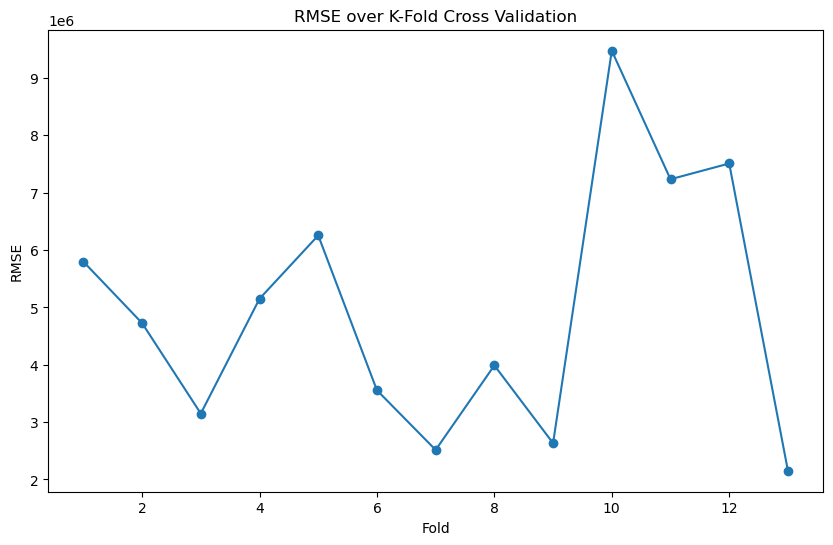

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, best_params['n_splits']+1), rmse_values, marker='o')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE over K-Fold Cross Validation')
plt.show()

### Feature importance 시각화

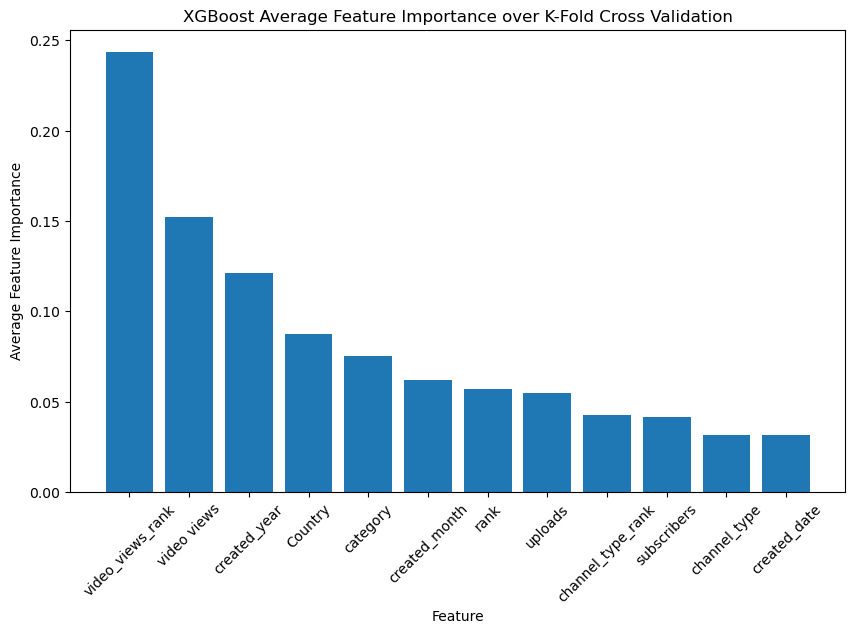

In [27]:
# Feature importance 평균 계산
avg_feature_importance = np.mean(feature_importance_list, axis=0)

sorted_idx = np.argsort(avg_feature_importance)[::-1]
features = X.columns

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx)), avg_feature_importance[sorted_idx])
plt.xticks(range(len(sorted_idx)), features[sorted_idx], rotation=45)
plt.xlabel('Feature')
plt.ylabel('Average Feature Importance')
plt.title('XGBoost Average Feature Importance over K-Fold Cross Validation')
plt.show()

- 연수입은 영상 조회수 (video_views_rank ,video views)에 가장 큰 영향을 받는다는 것을 확인할 수 있다.
- created_year도 연수입을 예측하는데 영향을 많이 받았다. 이는 해당 채널의 유튜브가 지속적으로 운영되었다는 점에서 이러한 결과가 나왔다고 판단한다.
- Country 간의 연수입 차이도 존재했는데, 이는 Country에 따라 유튜브 사용자의 수(인구)가 다르기 때문이라 생각된다.
- Category 간의 연수입 차이도 있다는 것을 확인할 수 있다.